<a href="https://colab.research.google.com/github/Prattbuw/STAT535_Final_Classification_CIFAR10/blob/main/Copy_of_STAT535_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT535: Final Project - Train a NN for 10 class (0-9) classification

### Brandon Pratt, 11/23/2020

#### Project Description:

Each project will have the same training set as starting point. You will perform 10 class classification on this data. You will train a predictor of your choice for this task, and do all you can to obtain a low expected classification error.
You will have to submit a report (approximately 10 pages) about what you did, submit your code (excluding the packages you may have used), and make a 1-2 slide summary. Besides the written project, you will have a short presentation 1-2 minutes followed by 1-2 questions from the instructors and the audience. A few days before the last day of classes, we will provide a test set with hidden labels. You will run your predictor on the test set and submit the results, which I and Zhaoqi will evaluate. In the same class, we'll unveil and compare the results.

Data sets The data is a subset of CIFAR 10, containing 40,000 examples divided approximately equally into 10 classes. The data sets for training are available on canvas under "Files Project" folder. It is a subset of size 40,000 of the CIFAR-10 dataset with some preprocessing. Each line represents a 32*32 image with 3 RGB channels. Note that the dataset is presented in a pickle format to reduce file sizes. To read these files and convert them into txt format (so that they are readable in R), please run the script unpack_files.py which is also posted in the same folder (the package numpy for Python is required for running this script). More instructions will come later. Use these data as you wish to obtain your predictor. Later, we will post an unlabeled test set, with the same format, on which you will test the predictor you obtained.

For any method, you should explore the data first, and do some preprocessing. In particular, you can derive new features from the existing ones, or you can define a particular type of "distance" in the space of images. In addition, whenever it makes sense, it is highly recommended that you also use the raw features in the same classifier, for comparison. Tell us in the project how the raw features fared compared to the features "engineered" by you.

Time line
Data available	Nov 12
Choose method	Nov 19
Test set available	!!!Nov 30
Test results due	!!!Dec 3, midnight
Award ceremony	!!!Dec 6 lecture
Submit report	!!!Dec 6 midnight

Report outline
Preprocessing, what feature set you used
Predictor(s): complete model description, parametrization
Basic training algorithm(s): what algorithm, what parameters, anything unusual you did. Do not reproduce the algorithms from books or lecture unless you make modifications.
Training strategy. Reproducible description of what you did for training (e.g training set sizes, number epochs, how initialized, did you do CV or model selection)
Experimental results, e.g learning curve(s), training (validation) losses, estimated parameter values if they are interpretable and plottable. Be selectivein what you show! Credit will given for careful analysis or visualization of the results.
Estimate of the classification error L. Optionally, an interval [Lmin, Lmax] where you believe L will be, and how you estimated these.
Optional: references
Total length: no more than 5 pages of contents, with extra pages containing references or figures, up to no more than 10 pages total.
How to submit your test set results
for the 5000 examples in the test set, you will produce 5000 labels with values from 0 to 9 by your Predictor. Create the file y.out with the following format:
predicted_classification_error
yhat_example_1
yhat_example_2
....
(5001 lines)
E.g. y.out
For the value of predicted_classification_error you should input your best guess of how your method will perform on the training set.


In [ ]:
# import python libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import io
import os
import sys
from tqdm import tqdm
from skimage.transform import resize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd() 

my_dir = "/content/drive/My Drive/Colab Notebooks/"
os.chdir(my_dir)
os.getcwd()
os.listdir()


['Copy of text_generation.ipynb',
 'Copy of test.ipynb',
 'image-train.txt',
 'label-train.txt',
 'STAT535_Final_Project (1).ipynb',
 'CIFAR_model1',
 'CIFAR_model2',
 'CIFAR_model_SGD1',
 'CIFAR_model_SGD2',
 'CIFAR_model_SGD3',
 'CIFAR_model_SGD4',
 'CIFAR_model_SGD5',
 'CIFAR_model_SGD6',
 'CIFAR_model_SGD7',
 'CIFAR_model_SGD8',
 'grayscale_SGD_training_loss.npy',
 'grayscale_SGD_training_accuracy.npy',
 'grayscale_SGD_validation_loss.npy',
 'grayscale_SGD_validation_accuracy.npy',
 'grayscale_SGD_final_validation_prediction.npy',
 'grayscale_SGD_final_validation_target.npy',
 'CIFAR_model_Adam1',
 'CIFAR_model_Adam2',
 'CIFAR_model_Adam3',
 'CIFAR_model_Adam4',
 'CIFAR_model_Adam5',
 'CIFAR_model_Adam6',
 'CIFAR_model_Adam7',
 'CIFAR_model_Adam8',
 'grayscale_Adam_training_loss.npy',
 'grayscale_Adam_training_accuracy.npy',
 'grayscale_Adam_validation_loss.npy',
 'grayscale_Adam_validation_accuracy.npy',
 'grayscale_Adam_final_validation_prediction.npy',
 'grayscale_Adam_final_val

In [ ]:
# load in training data and corresponding labels
img_data = np.loadtxt('image-train.txt', delimiter=None).astype(float)

In [ ]:
# load in the labels
labels = np.loadtxt('label-train.txt', delimiter=None).astype(int)

In [ ]:
# preprocessing: transform RGB images into grayscale
N=img_data.shape[0] # number of samples
img_size = 32**2 # 32 x 32 pixel images
grayscale_imgs=np.zeros((N,img_size))
R_imgs=np.zeros((N,img_size))
B_imgs=np.zeros((N,img_size))
G_imgs=np.zeros((N,img_size))
for j in range(N):
    # current image
    curr_img = img_data[j]
    
    # channels
    R = curr_img[0:img_size] # red channel
    G = curr_img[img_size:2*img_size] # green channel
    B = curr_img[2*img_size:3*img_size] 

    R_imgs[j,:] = np.round(R)
    B_imgs[j,:] = np.round(B)
    G_imgs[j,:] = np.round(G)
    
    # grayscale images
    grayscale_imgs[j,:]= np.round((R + G + B)/3)
    
# make pixel values integers
grayscale_imgs=grayscale_imgs.astype(int)
rgb_imgs=[R_imgs.astype(int), G_imgs.astype(int), B_imgs.astype(int)]
     

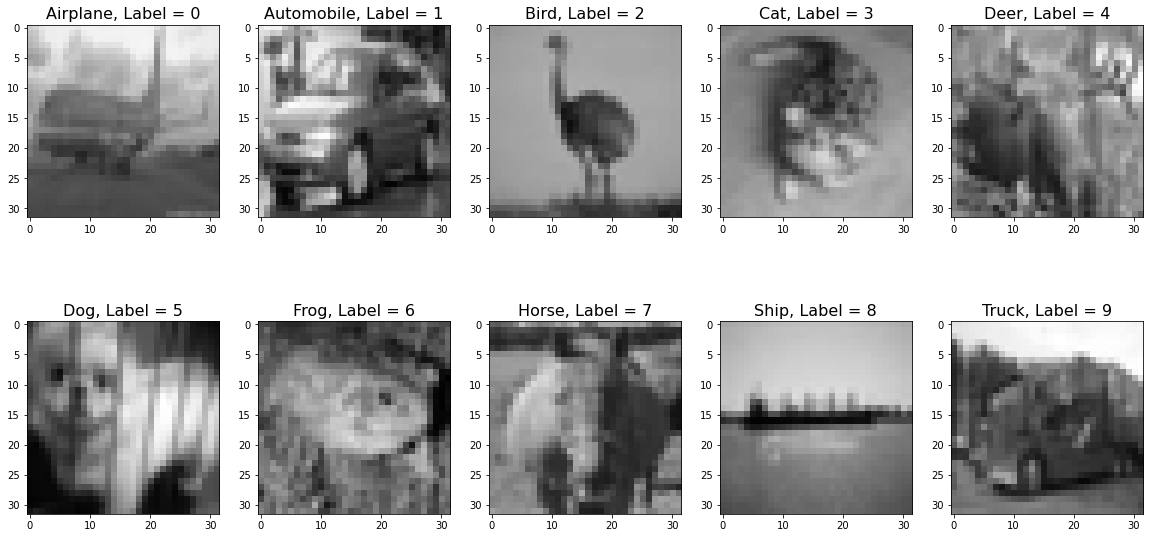

In [ ]:
# display a couple of images with their labels
fig1 = plt.figure(1, figsize=[20,10])
img = 0
plt.subplot(2,5,1)
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Airplane, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,2)
img=9
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Automobile, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,3)
img=17
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Bird, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,4)
img=5
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Cat, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,5)
img=32
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Deer, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,6)
img=7
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Dog, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,7)
img=11
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Frog, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,8)
img=4
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Horse, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,9)
img=1
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Ship, Label = ' + str(labels[img]), fontsize=16)

plt.subplot(2,5,10)
img=3
plt.imshow(np.reshape(grayscale_imgs[img], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Truck, Label = ' + str(labels[img]), fontsize=16)

fig1.savefig('labeled_images.png', dpi = 300)

### Display horizontal flip

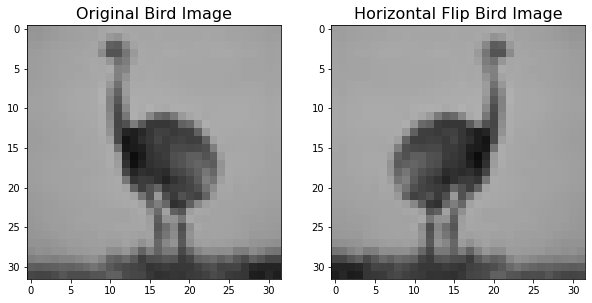

In [ ]:
flip_r = np.flip(np.reshape(rgb_imgs[0][17,:],(32,32)),axis=1)
flip_g = np.flip(np.reshape(rgb_imgs[1][17,:],(32,32)),axis=1)
flip_b = np.flip(np.reshape(rgb_imgs[2][17,:],(32,32)),axis=1)
grayscale_im = (flip_r + flip_g + flip_b)/3

fig1 = plt.figure(1, figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(np.reshape(grayscale_imgs[17], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Original Bird Image', fontsize=16)

plt.subplot(1,2, 2)
plt.imshow(grayscale_im ,cmap='gray', vmin=0, vmax=255)
plt.title('Horizontal Flip Bird Image', fontsize=16)

fig1.savefig('horizontal_flip.png', dpi=300)

Display Center Crop

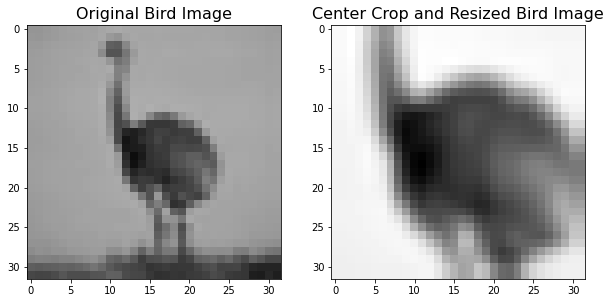

In [ ]:
# R channel
curr_R_img = np.reshape(rgb_imgs[0][17,:],(32,32))
crop_R = curr_R_img[8:24, 8:24] 
# resize to original image
R_resized = resize(crop_R, (32, 32),anti_aliasing=True)

# G channel
curr_G_img = np.reshape(rgb_imgs[1][17,:],(32,32))
crop_G = curr_G_img[8:24, 8:24] 
# resize to original image
G_resized = resize(crop_G, (32, 32),anti_aliasing=True)

# B channel
curr_B_img = np.reshape(rgb_imgs[2][17,:],(32,32))
crop_B = curr_B_img[8:24, 8:24] 
# resize to original image
B_resized = resize(crop_B, (32, 32),anti_aliasing=True)

crop_im = (R_resized  + G_resized + B_resized)/3

fig1 = plt.figure(1, figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(np.reshape(grayscale_imgs[17], (32, 32)),cmap='gray', vmin=0, vmax=255)
plt.title('Original Bird Image', fontsize=16)

plt.subplot(1,2, 2)
plt.imshow(crop_im ,cmap='gray')
plt.title('Center Crop and Resized Bird Image', fontsize=16)

fig1.savefig('center_crop.png', dpi=300)

### Setup CNN for Multi-Class Classification

In [ ]:
# check for GPU
_cuda = False
if torch.cuda.is_available():
  _cuda=True
print('GPU: ', _cuda)

GPU:  True


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### CNN

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # convultional layers
    self.ConvLayer1 = nn.Sequential(
        nn.Conv2d(3,8,3), #(1,8,3) change for the number of channels
        nn.Conv2d(8,16,3),
        nn.MaxPool2d(2),
        nn.ReLU()
    )

    self.ConvLayer2 = nn.Sequential(
        nn.Conv2d(16,32,3),
        nn.Conv2d(32,32,3),
        nn.MaxPool2d(2),
        nn.ReLU()
    )

    # linear layers
    self.LinLayer1 = nn.Linear(5*5*32,160) #nn.Linear(5*5*32,160)
    self.LinLayer2= nn.Linear(160, 84)
    self.LinLayer3= nn.Linear(84,10) # 10 output features


  def forward(self, x):
      # Max pooling over a (2, 2) window
      x = self.ConvLayer1(x)
      x = self.ConvLayer2(x)
      x = x.view(x.size(0), -1) # flatten
      x = self.LinLayer1(x)
      x = self.LinLayer2(x)
      x = self.LinLayer3(x)

      return x #F.log_softmax(x, dim = 1)

print(Net())


Net(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (LinLayer1): Linear(in_features=800, out_features=160, bias=True)
  (LinLayer2): Linear(in_features=160, out_features=84, bias=True)
  (LinLayer3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

NameError: ignored

### Train the network


#### No mini-batch

In [ ]:
# Perform 8-fold cross-validation
img_indices=np.arange(0,N)
fold_size=int(N/8)
fold_start=np.arange(0,N,fold_size)
fold_end=np.arange(fold_size,N+fold_size,fold_size)
NUM_EPOCHS = 100
n_folds = 1

# store the empirical loss, expected loss, and validation accuracy for each CV fold
fold_empirical_loss = np.zeros((n_folds, NUM_EPOCHS))
fold_expected_loss = np.zeros((n_folds, NUM_EPOCHS))
fold_validation_accuracy = np.zeros((n_folds, NUM_EPOCHS))
fold_training_accuracy = np.zeros((n_folds, NUM_EPOCHS))

# for confusion matrix
target_store=np.zeros((n_folds, 5000))
pred_store=np.zeros((n_folds, 5000))

for fold in range(n_folds): #range(8):
  print('CV FOLD: ', fold+1)

  # validation test set
  test_data=grayscale_imgs[fold_start[fold]:fold_end[fold],:]
  test_labels=labels[fold_start[fold]:fold_end[fold]]
  
  # training data
  test_indices=np.arange(fold_start[fold],fold_end[fold])
  training_indices = np.setdiff1d(img_indices, test_indices)
  training_data=grayscale_imgs[training_indices,:]
  training_labels=labels[training_indices]


  # transform the input data into a tensor
  # grayscale training data
  input_gray_training_data = torch.empty(training_data.shape[0], 1, 32, 32)
  for j in range(training_data.shape[0]):
    input_gray_training_data[j,0,:,:] = torch.from_numpy(np.reshape(training_data[j,:], (32, 32)))

  # convert training labels into a tensor
  training_target = torch.from_numpy(training_labels)

  # validation data
  valid_data = torch.empty(test_data.shape[0],1,32,32)
  for j in range(test_data.shape[0]):
    valid_data[j,0,:,:] = torch.from_numpy(np.reshape(test_data[j,:], (32, 32)))
  valid_target = torch.from_numpy(test_labels)

  # send data to GPU
  # input_gray_training_data = input_gray_training_data.to(device)
  # training_target = training_target.to(device)
  # valid_data = valid_data.to(device)
  # valid_target = valid_target.to(device)
  
  # set model to work with GPU
  net = Net()
  net = net.to(device)

  # Measure loss with Cross Entropy: log_softmax is already included.
  criterion = nn.CrossEntropyLoss()

  # Define optimizer: Compare Stochastic Gradient Descent with Adam
  optimizer = optim.SGD(net.parameters(), lr = 0.0001)
  #optimizer = optim.Adam(net.parameters(), lr = 0.0001)

  # iterate the training set for a given number of epochs
  store_loss = np.zeros(NUM_EPOCHS)
  store_training_accuracy = np.zeros(NUM_EPOCHS)
  store_expected_loss = np.zeros(NUM_EPOCHS)
  valid_accuracy_store=np.zeros(NUM_EPOCHS)
  for epoch in tqdm(range(NUM_EPOCHS)):
    print('Epoch: ', epoch)

    # track the loss
    running_loss = 0
    training_accuracy = 0
    for j in range(input_gray_training_data.shape[0]):
      optimizer.zero_grad()   # zero the gradient buffers
      input = torch.empty(1,1,32,32)
      input[0,0,:,:] = input_gray_training_data[j,:,:,:]
      target = torch.empty(1)
      target[0] = training_target[j]
      target=target.long()
      input = input.to(device)
      target = target.to(device)
      output = net(input)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()    # Does the update

      # track loss
      running_loss += loss.item()

      # compute training accuracy
      output_softmax = F.log_softmax(output, dim = 1) 
      max_idx = torch.argmax(output_softmax)

      # check to see if the index matches the target
      if max_idx.item() == target.item():
        training_accuracy = training_accuracy + 1

    # store loss
    store_loss[epoch] = running_loss/input_gray_training_data.shape[0] # Average Cross Entropy Loss
    print('Empirical Loss = ', running_loss/input_gray_training_data.shape[0])

    # store training accuracy
    curr_training_accuracy = (training_accuracy/input_gray_training_data.shape[0])*100
    store_training_accuracy[epoch] = curr_training_accuracy
    print('Training Accuracy = ', curr_training_accuracy,'%')


    # Expected loss and validation accuracry
    expected_loss = 0
    correct_classification=0

    with torch.no_grad():
      for k in range(valid_data.shape[0]):
        optimizer.zero_grad()
        input = torch.empty(1,1,32,32)
        input[0,0,:,:] = valid_data[k,:,:,:]
        target = torch.empty(1)
        target[0] = valid_target[k]
        target=target.long()
        input = input.to(device)
        target = target.to(device)
        output = net(input)
        loss = criterion(output, target)

        # track expected loss
        expected_loss += loss.item()

        # compute validation accuracy
        output_softmax = F.log_softmax(output, dim = 1) 
        max_idx = torch.argmax(output_softmax)

        # check to see if the index matches the target
        if max_idx.item() == target.item():
          correct_classification = correct_classification + 1
        
        # save predictions for confusion matrix
        if epoch == NUM_EPOCHS-1:
          target_store[fold,k] = max_idx.item()
          pred_store[fold,k] = target.item()
      
      # average expected loss
      expected_loss = expected_loss/valid_data.shape[0]
      store_expected_loss[epoch] = expected_loss 
      print('Expected Loss = ', expected_loss)

      # validation accuracy
      valid_accuracy = (correct_classification/valid_data.shape[0]) * 100
      valid_accuracy_store[epoch] = valid_accuracy
      print('Validation Accuracy = ', valid_accuracy,'%')
  print('Training Complete')

  fold_empirical_loss[fold,:] = store_loss
  fold_expected_loss[fold,:] = store_expected_loss
  fold_validation_accuracy[fold,:] = valid_accuracy_store
  fold_training_accuracy[fold,:] = store_training_accuracy

  # save the current model 
  model_name = 'CIFAR_model_SGD' + str(fold+1)
  # model_name = 'CIFAR_model_Adam' + str(fold+1)
  torch.save(net, model_name)

NameError: ignored

#### with mini-batch of 25


In [ ]:
# Perform 8-fold cross-validation
img_indices=np.arange(0,N)
fold_size=int(N/8)
fold_start=np.arange(0,N,fold_size)
fold_end=np.arange(fold_size,N+fold_size,fold_size)
NUM_EPOCHS = 100
n_folds = 8

# store the empirical loss, expected loss, and validation accuracy for each CV fold
fold_empirical_loss = np.zeros((n_folds, NUM_EPOCHS))
fold_expected_loss = np.zeros((n_folds, NUM_EPOCHS))
fold_validation_accuracy = np.zeros((n_folds, NUM_EPOCHS))
fold_training_accuracy = np.zeros((n_folds, NUM_EPOCHS))

# for confusion matrix
target_store=np.zeros((n_folds, 5000))
pred_store=np.zeros((n_folds, 5000))

for fold in range(n_folds): #range(8):
  print('CV FOLD: ', fold+1)

  # validation test set
  test_data=grayscale_imgs[fold_start[fold]:fold_end[fold],:]
  test_labels=labels[fold_start[fold]:fold_end[fold]]
  
  # training data
  test_indices=np.arange(fold_start[fold],fold_end[fold])
  training_indices = np.setdiff1d(img_indices, test_indices)
  training_data=grayscale_imgs[training_indices,:]
  training_labels=labels[training_indices]

  # transform the input data into a tensor
  # grayscale training data
  input_gray_training_data = torch.empty(training_data.shape[0], 1, 32, 32)
  for j in range(training_data.shape[0]):
    input_gray_training_data[j,0,:,:] = torch.from_numpy(np.reshape(training_data[j,:], (32, 32)))

  # convert training labels into a tensor
  training_target = torch.from_numpy(training_labels)

  # rbg training data

  # validation data
  valid_data = torch.empty(test_data.shape[0],1,32,32)
  for j in range(test_data.shape[0]):
    valid_data[j,0,:,:] = torch.from_numpy(np.reshape(test_data[j,:], (32, 32)))
  valid_target = torch.from_numpy(test_labels)

  # send data to GPU
  # input_gray_training_data = input_gray_training_data.to(device)
  # training_target = training_target.to(device)
  # valid_data = valid_data.to(device)
  # valid_target = valid_target.to(device)
  
  # set model to work with GPU
  net = Net()
  net = net.to(device)

  # Measure loss with Cross Entropy: log_softmax is already included.
  criterion = nn.CrossEntropyLoss()

  # Define optimizer: Compare Stochastic Gradient Descent with Adam
  # optimizer = optim.SGD(net.parameters(), lr = 0.0001)
  optimizer = optim.Adam(net.parameters(), lr = 0.0001)

  # iterate the training set for a given number of epochs
  store_loss = np.zeros(NUM_EPOCHS)
  store_training_accuracy = np.zeros(NUM_EPOCHS)
  store_expected_loss = np.zeros(NUM_EPOCHS)
  valid_accuracy_store=np.zeros(NUM_EPOCHS)
  for epoch in tqdm(range(NUM_EPOCHS)):
    print('Epoch: ', epoch)

    # Batch the images into groups of 100
    batch_size=25
    n_batches=round(input_gray_training_data.shape[0]/batch_size)
    batch_start=0
    # track the loss
    running_loss = 0
    training_accuracy = 0

    for j in range(n_batches):
      optimizer.zero_grad()   # zero the gradient buffers
      # input = torch.empty(1,1,32,32)
      input = input_gray_training_data[batch_start:batch_start+batch_size,:,:,:]
      # target = torch.empty(1)
      target = training_target[batch_start:batch_start+batch_size]
      target=target.long()
      input = input.to(device)
      target = target.to(device)
      output = net(input)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()    # Does the update

      # update batch start
      batch_start = batch_start + batch_size

      # track loss
      running_loss += loss.item()

      # compute training accuracy
      output_softmax = F.log_softmax(output, dim = 1) 
      for pred in range(output_softmax.shape[0]):
        max_idx = torch.argmax(output_softmax[pred])

        # check to see if the index matches the target
        if max_idx.item() == target[pred].item():
          training_accuracy = training_accuracy + 1

    # store loss
    store_loss[epoch] = running_loss/input_gray_training_data.shape[0] # Average Cross Entropy Loss
    print('Empirical Loss = ', running_loss/input_gray_training_data.shape[0])

    # store training accuracy
    curr_training_accuracy = (training_accuracy/input_gray_training_data.shape[0])*100
    store_training_accuracy[epoch] = curr_training_accuracy
    print('Training Accuracy = ', curr_training_accuracy,'%')


    # Expected loss and validation accuracry
    expected_loss = 0
    correct_classification=0
    batch_start=0
    count=0
    n_batches=round(valid_data.shape[0]/batch_size)

    with torch.no_grad():
      for k in range(n_batches):
        optimizer.zero_grad()
        input = valid_data[batch_start:batch_start+batch_size,:,:,:]
        target = valid_target[batch_start:batch_start+batch_size]
        target = target.long()
        input = input.to(device)
        target = target.to(device)
        output = net(input)
        loss = criterion(output, target)

        # track expected loss
        expected_loss += loss.item()

        # compute validation accuracy
        output_softmax = F.log_softmax(output, dim = 1) 
        for pred in range(output_softmax.shape[0]):
          max_idx = torch.argmax(output_softmax[pred])

          # check to see if the index matches the target
          if max_idx.item() == target[pred].item():
            correct_classification = correct_classification + 1
        
          # save predictions for confusion matrix
          if epoch == NUM_EPOCHS-1:
            target_store[fold,count] = max_idx.item()
            pred_store[fold,count] = target[pred].item()
            count=count+1

        # update batch start
        batch_start = batch_start + batch_size
      
      # average expected loss
      expected_loss = expected_loss/valid_data.shape[0]
      store_expected_loss[epoch] = expected_loss 
      print('Expected Loss = ', expected_loss)

      # validation accuracy
      valid_accuracy = (correct_classification/valid_data.shape[0]) * 100
      valid_accuracy_store[epoch] = valid_accuracy
      print('Validation Accuracy = ', valid_accuracy,'%')
  print('Training Complete')

  fold_empirical_loss[fold,:] = store_loss
  fold_expected_loss[fold,:] = store_expected_loss
  fold_validation_accuracy[fold,:] = valid_accuracy_store
  fold_training_accuracy[fold,:] = store_training_accuracy

  # save the current model 
  # model_name = 'CIFAR_model_SGD' + str(fold+1)
  model_name = 'RBG_CIFAR_model_Adam' + str(fold+1)
  torch.save(net, model_name)

CV FOLD:  1



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.07097105560983931
Training Accuracy =  36.6 %



  1%|          | 1/100 [00:08<13:42,  8.30s/it]

Expected Loss =  0.06089869723320007
Validation Accuracy =  46.300000000000004 %
Epoch:  1
Empirical Loss =  0.05808718204157693
Training Accuracy =  49.26 %



  2%|▏         | 2/100 [00:16<13:26,  8.23s/it]

Expected Loss =  0.055452639949321744
Validation Accuracy =  52.22 %
Epoch:  2
Empirical Loss =  0.053085126214368006
Training Accuracy =  54.19714285714286 %



  3%|▎         | 3/100 [00:24<13:20,  8.25s/it]

Expected Loss =  0.05310822585821152
Validation Accuracy =  54.800000000000004 %
Epoch:  3
Empirical Loss =  0.04977956542628152
Training Accuracy =  57.30571428571428 %



  4%|▍         | 4/100 [00:33<13:19,  8.33s/it]

Expected Loss =  0.051128740000724794
Validation Accuracy =  57.02 %
Epoch:  4
Empirical Loss =  0.04722325035163334
Training Accuracy =  59.674285714285716 %



  5%|▌         | 5/100 [00:41<13:07,  8.29s/it]

Expected Loss =  0.04965064055919647
Validation Accuracy =  58.64 %
Epoch:  5
Empirical Loss =  0.045231617426872255
Training Accuracy =  61.4 %



  6%|▌         | 6/100 [00:49<12:54,  8.24s/it]

Expected Loss =  0.048904829061031344
Validation Accuracy =  59.419999999999995 %
Epoch:  6
Empirical Loss =  0.043619962918758394
Training Accuracy =  62.99142857142858 %



  7%|▋         | 7/100 [00:57<12:51,  8.30s/it]

Expected Loss =  0.048157112896442415
Validation Accuracy =  60.46 %
Epoch:  7
Empirical Loss =  0.04234352530155863
Training Accuracy =  64.07142857142857 %



  8%|▊         | 8/100 [01:06<12:38,  8.24s/it]

Expected Loss =  0.04749623141288757
Validation Accuracy =  61.019999999999996 %
Epoch:  8
Empirical Loss =  0.041213533222675326
Training Accuracy =  65.05714285714286 %



  9%|▉         | 9/100 [01:14<12:31,  8.26s/it]

Expected Loss =  0.04704421453475952
Validation Accuracy =  61.86000000000001 %
Epoch:  9
Empirical Loss =  0.04025275501949446
Training Accuracy =  65.89428571428572 %



 10%|█         | 10/100 [01:22<12:20,  8.23s/it]

Expected Loss =  0.04685069941282272
Validation Accuracy =  61.980000000000004 %
Epoch:  10
Empirical Loss =  0.03940128104942186
Training Accuracy =  66.73428571428572 %



 11%|█         | 11/100 [01:30<12:09,  8.20s/it]

Expected Loss =  0.04657247748374939
Validation Accuracy =  62.260000000000005 %
Epoch:  11
Empirical Loss =  0.03861805186612265
Training Accuracy =  67.55428571428571 %



 12%|█▏        | 12/100 [01:38<11:55,  8.13s/it]

Expected Loss =  0.04650666646957397
Validation Accuracy =  62.2 %
Epoch:  12
Empirical Loss =  0.037885400203296116
Training Accuracy =  68.03714285714285 %



 13%|█▎        | 13/100 [01:46<11:47,  8.13s/it]

Expected Loss =  0.04657598501443863
Validation Accuracy =  61.86000000000001 %
Epoch:  13
Empirical Loss =  0.037227930642877306
Training Accuracy =  68.66 %



 14%|█▍        | 14/100 [01:54<11:34,  8.08s/it]

Expected Loss =  0.046557015782594684
Validation Accuracy =  61.86000000000001 %
Epoch:  14
Empirical Loss =  0.036599275802714486
Training Accuracy =  69.02285714285713 %



 15%|█▌        | 15/100 [02:02<11:31,  8.13s/it]

Expected Loss =  0.046519647377729414
Validation Accuracy =  62.019999999999996 %
Epoch:  15
Empirical Loss =  0.036024505940505436
Training Accuracy =  69.54 %



 16%|█▌        | 16/100 [02:11<11:26,  8.17s/it]

Expected Loss =  0.046601221060752866
Validation Accuracy =  61.96 %
Epoch:  16
Empirical Loss =  0.03546972303560802
Training Accuracy =  70.05142857142857 %



 17%|█▋        | 17/100 [02:19<11:16,  8.16s/it]

Expected Loss =  0.046616042363643646
Validation Accuracy =  62.06 %
Epoch:  17
Empirical Loss =  0.034964888725110464
Training Accuracy =  70.45142857142858 %



 18%|█▊        | 18/100 [02:27<11:10,  8.17s/it]

Expected Loss =  0.04658149631023407
Validation Accuracy =  62.36000000000001 %
Epoch:  18
Empirical Loss =  0.03450661062087332
Training Accuracy =  70.89999999999999 %



 19%|█▉        | 19/100 [02:35<11:00,  8.16s/it]

Expected Loss =  0.04659488252401352
Validation Accuracy =  62.480000000000004 %
Epoch:  19
Empirical Loss =  0.03403660409109933
Training Accuracy =  71.25142857142858 %



 20%|██        | 20/100 [02:44<11:02,  8.28s/it]

Expected Loss =  0.04672335250377655
Validation Accuracy =  62.96000000000001 %
Epoch:  20
Empirical Loss =  0.03358237601603781
Training Accuracy =  71.56 %



 21%|██        | 21/100 [02:52<10:47,  8.19s/it]

Expected Loss =  0.046883022713661196
Validation Accuracy =  62.9 %
Epoch:  21
Empirical Loss =  0.033153021466732026
Training Accuracy =  71.93428571428572 %



 22%|██▏       | 22/100 [03:00<10:38,  8.18s/it]

Expected Loss =  0.04702158397436142
Validation Accuracy =  62.96000000000001 %
Epoch:  22
Empirical Loss =  0.03276462015339306
Training Accuracy =  72.44285714285714 %



 23%|██▎       | 23/100 [03:08<10:35,  8.26s/it]

Expected Loss =  0.047251720815896986
Validation Accuracy =  62.8 %
Epoch:  23
Empirical Loss =  0.032366251917396276
Training Accuracy =  72.60285714285715 %



 24%|██▍       | 24/100 [03:16<10:23,  8.20s/it]

Expected Loss =  0.04745173453688622
Validation Accuracy =  62.660000000000004 %
Epoch:  24
Empirical Loss =  0.032008480017525806
Training Accuracy =  72.84571428571428 %



 25%|██▌       | 25/100 [03:25<10:14,  8.20s/it]

Expected Loss =  0.0477069732606411
Validation Accuracy =  62.46000000000001 %
Epoch:  25
Empirical Loss =  0.031638919295583455
Training Accuracy =  73.12857142857143 %



 26%|██▌       | 26/100 [03:33<10:02,  8.14s/it]

Expected Loss =  0.047985054063796995
Validation Accuracy =  62.5 %
Epoch:  26
Empirical Loss =  0.03128860244665827
Training Accuracy =  73.42571428571428 %



 27%|██▋       | 27/100 [03:41<09:58,  8.20s/it]

Expected Loss =  0.04825672561526299
Validation Accuracy =  62.339999999999996 %
Epoch:  27
Empirical Loss =  0.030970681984935487
Training Accuracy =  73.76285714285714 %



 28%|██▊       | 28/100 [03:49<09:54,  8.26s/it]

Expected Loss =  0.04856820479631424
Validation Accuracy =  62.18 %
Epoch:  28
Empirical Loss =  0.03066126434803009
Training Accuracy =  74.01714285714286 %



 29%|██▉       | 29/100 [03:58<09:55,  8.38s/it]

Expected Loss =  0.0489353832244873
Validation Accuracy =  62.019999999999996 %
Epoch:  29
Empirical Loss =  0.030357383942604066
Training Accuracy =  74.28285714285714 %



 30%|███       | 30/100 [04:06<09:38,  8.26s/it]

Expected Loss =  0.04920420982837677
Validation Accuracy =  61.94 %
Epoch:  30
Empirical Loss =  0.030058712639978953
Training Accuracy =  74.50285714285714 %



 31%|███       | 31/100 [04:14<09:28,  8.24s/it]

Expected Loss =  0.04939617511630058
Validation Accuracy =  61.9 %
Epoch:  31
Empirical Loss =  0.029759651485511233
Training Accuracy =  74.69142857142857 %



 32%|███▏      | 32/100 [04:22<09:17,  8.19s/it]

Expected Loss =  0.04961578991413117
Validation Accuracy =  61.980000000000004 %
Epoch:  32
Empirical Loss =  0.02950620873059545
Training Accuracy =  74.92857142857143 %



 33%|███▎      | 33/100 [04:31<09:11,  8.23s/it]

Expected Loss =  0.049863722747564315
Validation Accuracy =  61.8 %
Epoch:  33
Empirical Loss =  0.02922942927820342
Training Accuracy =  75.17714285714285 %



 34%|███▍      | 34/100 [04:39<08:59,  8.17s/it]

Expected Loss =  0.05032079598903656
Validation Accuracy =  61.739999999999995 %
Epoch:  34
Empirical Loss =  0.02896583809001105
Training Accuracy =  75.34571428571428 %



 35%|███▌      | 35/100 [04:47<08:47,  8.11s/it]

Expected Loss =  0.05069871798157692
Validation Accuracy =  61.72 %
Epoch:  35
Empirical Loss =  0.028720117419958113
Training Accuracy =  75.58857142857143 %



 36%|███▌      | 36/100 [04:55<08:36,  8.08s/it]

Expected Loss =  0.05103871938586235
Validation Accuracy =  61.739999999999995 %
Epoch:  36
Empirical Loss =  0.02847858510357993
Training Accuracy =  75.68 %



 37%|███▋      | 37/100 [05:03<08:28,  8.07s/it]

Expected Loss =  0.051314271593093874
Validation Accuracy =  61.7 %
Epoch:  37
Empirical Loss =  0.02824903145815645
Training Accuracy =  75.91142857142857 %



 38%|███▊      | 38/100 [05:10<08:17,  8.02s/it]

Expected Loss =  0.05156857968568802
Validation Accuracy =  61.8 %
Epoch:  38
Empirical Loss =  0.02799998493705477
Training Accuracy =  76.04857142857144 %



 39%|███▉      | 39/100 [05:19<08:18,  8.16s/it]

Expected Loss =  0.05188214350342751
Validation Accuracy =  61.760000000000005 %
Epoch:  39
Empirical Loss =  0.027769122787032807
Training Accuracy =  76.22571428571429 %



 40%|████      | 40/100 [05:27<08:08,  8.14s/it]

Expected Loss =  0.05227008504867554
Validation Accuracy =  61.53999999999999 %
Epoch:  40
Empirical Loss =  0.02753035063743591
Training Accuracy =  76.44 %



 41%|████      | 41/100 [05:35<07:54,  8.03s/it]

Expected Loss =  0.05278911806344986
Validation Accuracy =  61.46 %
Epoch:  41
Empirical Loss =  0.027293529970731055
Training Accuracy =  76.68857142857142 %



 42%|████▏     | 42/100 [05:43<07:42,  7.97s/it]

Expected Loss =  0.053282220029830935
Validation Accuracy =  61.419999999999995 %
Epoch:  42
Empirical Loss =  0.02706973508128098
Training Accuracy =  76.91428571428571 %



 43%|████▎     | 43/100 [05:51<07:35,  7.99s/it]

Expected Loss =  0.053674321871995924
Validation Accuracy =  61.199999999999996 %
Epoch:  43
Empirical Loss =  0.026866544382061278
Training Accuracy =  77.05428571428573 %



 44%|████▍     | 44/100 [05:59<07:29,  8.03s/it]

Expected Loss =  0.05422316517829895
Validation Accuracy =  61.160000000000004 %
Epoch:  44
Empirical Loss =  0.02664566013131823
Training Accuracy =  77.28857142857143 %



 45%|████▌     | 45/100 [06:07<07:23,  8.06s/it]

Expected Loss =  0.054689325976371765
Validation Accuracy =  61.1 %
Epoch:  45
Empirical Loss =  0.026441452817405973
Training Accuracy =  77.44 %



 46%|████▌     | 46/100 [06:15<07:14,  8.05s/it]

Expected Loss =  0.05496926230192185
Validation Accuracy =  61.38 %
Epoch:  46
Empirical Loss =  0.026239307094471795
Training Accuracy =  77.62571428571428 %



 47%|████▋     | 47/100 [06:23<07:09,  8.10s/it]

Expected Loss =  0.05541058354377747
Validation Accuracy =  60.980000000000004 %
Epoch:  47
Empirical Loss =  0.026041502476164272
Training Accuracy =  77.76857142857143 %



 48%|████▊     | 48/100 [06:31<07:00,  8.08s/it]

Expected Loss =  0.05583192121386528
Validation Accuracy =  61.08 %
Epoch:  48
Empirical Loss =  0.025857708702768597
Training Accuracy =  77.86 %



 49%|████▉     | 49/100 [06:40<06:56,  8.17s/it]

Expected Loss =  0.05615587049126625
Validation Accuracy =  61.18 %
Epoch:  49
Empirical Loss =  0.025650616475088255
Training Accuracy =  78.1542857142857 %



 50%|█████     | 50/100 [06:48<06:46,  8.14s/it]

Expected Loss =  0.05657023874521255
Validation Accuracy =  61.019999999999996 %
Epoch:  50
Empirical Loss =  0.025475151933942522
Training Accuracy =  78.28571428571428 %



 51%|█████     | 51/100 [06:56<06:37,  8.12s/it]

Expected Loss =  0.05708002164959908
Validation Accuracy =  61.0 %
Epoch:  51
Empirical Loss =  0.02530166320204735
Training Accuracy =  78.42 %



 52%|█████▏    | 52/100 [07:04<06:27,  8.07s/it]

Expected Loss =  0.05747206532359123
Validation Accuracy =  60.72 %
Epoch:  52
Empirical Loss =  0.02512164156351771
Training Accuracy =  78.7057142857143 %



 53%|█████▎    | 53/100 [07:12<06:17,  8.03s/it]

Expected Loss =  0.058151069366931915
Validation Accuracy =  60.760000000000005 %
Epoch:  53
Empirical Loss =  0.02496264373106616
Training Accuracy =  78.86571428571429 %



 54%|█████▍    | 54/100 [07:20<06:08,  8.02s/it]

Expected Loss =  0.05851749491095543
Validation Accuracy =  60.64000000000001 %
Epoch:  54
Empirical Loss =  0.02480417080947331
Training Accuracy =  78.91428571428571 %



 55%|█████▌    | 55/100 [07:28<06:00,  8.02s/it]

Expected Loss =  0.05904339634776115
Validation Accuracy =  60.46 %
Epoch:  55
Empirical Loss =  0.024650656941533088
Training Accuracy =  79.16285714285715 %



 56%|█████▌    | 56/100 [07:36<05:54,  8.06s/it]

Expected Loss =  0.05931722955703735
Validation Accuracy =  60.34 %
Epoch:  56
Empirical Loss =  0.024470797924484526
Training Accuracy =  79.26857142857143 %



 57%|█████▋    | 57/100 [07:44<05:49,  8.14s/it]

Expected Loss =  0.05986468752622604
Validation Accuracy =  60.36 %
Epoch:  57
Empirical Loss =  0.024329933285287448
Training Accuracy =  79.37428571428572 %



 58%|█████▊    | 58/100 [07:52<05:40,  8.10s/it]

Expected Loss =  0.060372760504484174
Validation Accuracy =  60.199999999999996 %
Epoch:  58
Empirical Loss =  0.02417318609058857
Training Accuracy =  79.52857142857142 %



 59%|█████▉    | 59/100 [08:01<05:35,  8.19s/it]

Expected Loss =  0.06057595855593682
Validation Accuracy =  60.36 %
Epoch:  59
Empirical Loss =  0.024023642047388213
Training Accuracy =  79.74285714285713 %



 60%|██████    | 60/100 [08:09<05:28,  8.21s/it]

Expected Loss =  0.06115887412428856
Validation Accuracy =  60.36 %
Epoch:  60
Empirical Loss =  0.023867034331815584
Training Accuracy =  79.83428571428571 %



 61%|██████    | 61/100 [08:17<05:17,  8.13s/it]

Expected Loss =  0.06155589597225189
Validation Accuracy =  60.46 %
Epoch:  61
Empirical Loss =  0.02372886586018971
Training Accuracy =  79.90285714285714 %



 62%|██████▏   | 62/100 [08:25<05:08,  8.11s/it]

Expected Loss =  0.062009086143970486
Validation Accuracy =  60.22 %
Epoch:  62
Empirical Loss =  0.023590339059489113
Training Accuracy =  80.00571428571429 %



 63%|██████▎   | 63/100 [08:33<05:02,  8.18s/it]

Expected Loss =  0.06255669080018997
Validation Accuracy =  60.12 %
Epoch:  63
Empirical Loss =  0.02345736777952739
Training Accuracy =  80.05428571428571 %



 64%|██████▍   | 64/100 [08:41<04:55,  8.20s/it]

Expected Loss =  0.062960321778059
Validation Accuracy =  60.24 %
Epoch:  64
Empirical Loss =  0.023337509714705603
Training Accuracy =  80.22571428571429 %



 65%|██████▌   | 65/100 [08:50<04:48,  8.24s/it]

Expected Loss =  0.06331002346277237
Validation Accuracy =  60.019999999999996 %
Epoch:  65
Empirical Loss =  0.02323327798289912
Training Accuracy =  80.27428571428571 %



 66%|██████▌   | 66/100 [08:58<04:38,  8.20s/it]

Expected Loss =  0.06411198790073394
Validation Accuracy =  60.019999999999996 %
Epoch:  66
Empirical Loss =  0.023080272196871893
Training Accuracy =  80.45714285714286 %



 67%|██████▋   | 67/100 [09:06<04:33,  8.28s/it]

Expected Loss =  0.06439971514940261
Validation Accuracy =  60.06 %
Epoch:  67
Empirical Loss =  0.022960197303124836
Training Accuracy =  80.62285714285714 %



 68%|██████▊   | 68/100 [09:15<04:25,  8.29s/it]

Expected Loss =  0.06494925372004509
Validation Accuracy =  59.8 %
Epoch:  68
Empirical Loss =  0.022840695042695317
Training Accuracy =  80.78571428571428 %



 69%|██████▉   | 69/100 [09:23<04:15,  8.25s/it]

Expected Loss =  0.06521989504098892
Validation Accuracy =  59.86 %
Epoch:  69
Empirical Loss =  0.022708712470105717
Training Accuracy =  80.8742857142857 %



 70%|███████   | 70/100 [09:31<04:08,  8.29s/it]

Expected Loss =  0.06549369885325432
Validation Accuracy =  59.88 %
Epoch:  70
Empirical Loss =  0.02260804650911263
Training Accuracy =  80.88285714285715 %



 71%|███████   | 71/100 [09:40<04:01,  8.32s/it]

Expected Loss =  0.06584597508907318
Validation Accuracy =  59.81999999999999 %
Epoch:  71
Empirical Loss =  0.02249238378362996
Training Accuracy =  80.91428571428571 %



 72%|███████▏  | 72/100 [09:48<03:53,  8.33s/it]

Expected Loss =  0.0665772879600525
Validation Accuracy =  59.699999999999996 %
Epoch:  72
Empirical Loss =  0.022384483756763593
Training Accuracy =  81.12285714285714 %



 73%|███████▎  | 73/100 [09:56<03:42,  8.24s/it]

Expected Loss =  0.066888496696949
Validation Accuracy =  59.8 %
Epoch:  73
Empirical Loss =  0.022280428399784225
Training Accuracy =  81.11142857142856 %



 74%|███████▍  | 74/100 [10:04<03:32,  8.18s/it]

Expected Loss =  0.0671631927549839
Validation Accuracy =  59.74 %
Epoch:  74
Empirical Loss =  0.022150711054035595
Training Accuracy =  81.17999999999999 %



 75%|███████▌  | 75/100 [10:12<03:24,  8.18s/it]

Expected Loss =  0.06757765273451805
Validation Accuracy =  59.699999999999996 %
Epoch:  75
Empirical Loss =  0.02205772207038743
Training Accuracy =  81.3 %



 76%|███████▌  | 76/100 [10:20<03:16,  8.20s/it]

Expected Loss =  0.06790026471018791
Validation Accuracy =  59.58 %
Epoch:  76
Empirical Loss =  0.02194080139909472
Training Accuracy =  81.42 %



 77%|███████▋  | 77/100 [10:29<03:09,  8.22s/it]

Expected Loss =  0.06825727250576019
Validation Accuracy =  59.68 %
Epoch:  77
Empirical Loss =  0.021846500940408027
Training Accuracy =  81.52285714285713 %



 78%|███████▊  | 78/100 [10:37<03:01,  8.24s/it]

Expected Loss =  0.0690004817545414
Validation Accuracy =  59.540000000000006 %
Epoch:  78
Empirical Loss =  0.021748596010889326
Training Accuracy =  81.61142857142856 %



 79%|███████▉  | 79/100 [10:45<02:52,  8.21s/it]

Expected Loss =  0.0690094496190548
Validation Accuracy =  59.919999999999995 %
Epoch:  79
Empirical Loss =  0.02165178117454052
Training Accuracy =  81.59142857142857 %



 80%|████████  | 80/100 [10:53<02:43,  8.19s/it]

Expected Loss =  0.06954271659851075
Validation Accuracy =  59.599999999999994 %
Epoch:  80
Empirical Loss =  0.02154298769874232
Training Accuracy =  81.73714285714286 %



 81%|████████  | 81/100 [11:01<02:34,  8.16s/it]

Expected Loss =  0.0699818804860115
Validation Accuracy =  59.72 %
Epoch:  81
Empirical Loss =  0.02144190327184541
Training Accuracy =  81.82285714285715 %



 82%|████████▏ | 82/100 [11:10<02:28,  8.23s/it]

Expected Loss =  0.07035634132623672
Validation Accuracy =  59.8 %
Epoch:  82
Empirical Loss =  0.02136208469910281
Training Accuracy =  81.89142857142858 %



 83%|████████▎ | 83/100 [11:18<02:19,  8.19s/it]

Expected Loss =  0.07102774465680123
Validation Accuracy =  59.56 %
Epoch:  83
Empirical Loss =  0.021252360309021813
Training Accuracy =  82.01428571428572 %



 84%|████████▍ | 84/100 [11:26<02:11,  8.21s/it]

Expected Loss =  0.07153826419115067
Validation Accuracy =  59.74 %
Epoch:  84
Empirical Loss =  0.021166350695490836
Training Accuracy =  82.0 %



 85%|████████▌ | 85/100 [11:34<02:02,  8.17s/it]

Expected Loss =  0.07176917300820351
Validation Accuracy =  59.62 %
Epoch:  85
Empirical Loss =  0.021051352615015846
Training Accuracy =  82.15428571428572 %



 86%|████████▌ | 86/100 [11:42<01:54,  8.20s/it]

Expected Loss =  0.07211571127176285
Validation Accuracy =  59.440000000000005 %
Epoch:  86
Empirical Loss =  0.020959946439095906
Training Accuracy =  82.22571428571429 %



 87%|████████▋ | 87/100 [11:51<01:46,  8.18s/it]

Expected Loss =  0.07243764977455139
Validation Accuracy =  59.5 %
Epoch:  87
Empirical Loss =  0.02086989276281425
Training Accuracy =  82.41428571428571 %



 88%|████████▊ | 88/100 [11:59<01:38,  8.18s/it]

Expected Loss =  0.07270447046160698
Validation Accuracy =  59.46 %
Epoch:  88
Empirical Loss =  0.020786452700836316
Training Accuracy =  82.53142857142856 %



 89%|████████▉ | 89/100 [12:07<01:31,  8.31s/it]

Expected Loss =  0.07339681303501129
Validation Accuracy =  59.599999999999994 %
Epoch:  89
Empirical Loss =  0.020685175202574048
Training Accuracy =  82.58285714285715 %



 90%|█████████ | 90/100 [12:16<01:22,  8.28s/it]

Expected Loss =  0.07370432564020157
Validation Accuracy =  59.660000000000004 %
Epoch:  90
Empirical Loss =  0.02061622630911214
Training Accuracy =  82.53428571428572 %



 91%|█████████ | 91/100 [12:24<01:14,  8.26s/it]

Expected Loss =  0.07424620350599288
Validation Accuracy =  59.46 %
Epoch:  91
Empirical Loss =  0.020514803827234678
Training Accuracy =  82.67142857142858 %



 92%|█████████▏| 92/100 [12:32<01:05,  8.20s/it]

Expected Loss =  0.07489155498743057
Validation Accuracy =  59.699999999999996 %
Epoch:  92
Empirical Loss =  0.020418036506431442
Training Accuracy =  82.80571428571429 %



 93%|█████████▎| 93/100 [12:40<00:57,  8.17s/it]

Expected Loss =  0.0754402975320816
Validation Accuracy =  59.31999999999999 %
Epoch:  93
Empirical Loss =  0.0203314074162926
Training Accuracy =  82.85714285714286 %



 94%|█████████▍| 94/100 [12:48<00:49,  8.25s/it]

Expected Loss =  0.07575353935956955
Validation Accuracy =  59.74 %
Epoch:  94
Empirical Loss =  0.020260452596204622
Training Accuracy =  82.88857142857144 %



 95%|█████████▌| 95/100 [12:56<00:41,  8.21s/it]

Expected Loss =  0.07590847616195678
Validation Accuracy =  59.940000000000005 %
Epoch:  95
Empirical Loss =  0.020163474901020526
Training Accuracy =  82.98 %



 96%|█████████▌| 96/100 [13:04<00:32,  8.14s/it]

Expected Loss =  0.0763513145327568
Validation Accuracy =  59.86 %
Epoch:  96
Empirical Loss =  0.020104469303999627
Training Accuracy =  83.00857142857143 %



 97%|█████████▋| 97/100 [13:13<00:24,  8.15s/it]

Expected Loss =  0.07701380271911622
Validation Accuracy =  59.78 %
Epoch:  97
Empirical Loss =  0.02003029574964728
Training Accuracy =  82.89714285714285 %



 98%|█████████▊| 98/100 [13:21<00:16,  8.15s/it]

Expected Loss =  0.07716792168617248
Validation Accuracy =  59.74 %
Epoch:  98
Empirical Loss =  0.019948318730720453
Training Accuracy =  83.14 %



 99%|█████████▉| 99/100 [13:29<00:08,  8.23s/it]

Expected Loss =  0.07778781495094299
Validation Accuracy =  59.78 %
Epoch:  99
Empirical Loss =  0.019921037863407817
Training Accuracy =  83.20571428571428 %



100%|██████████| 100/100 [13:37<00:00,  8.18s/it]

Expected Loss =  0.07827807854413986
Validation Accuracy =  59.699999999999996 %
Training Complete
CV FOLD:  2




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.06847002270732608
Training Accuracy =  38.777142857142856 %



  1%|          | 1/100 [00:08<13:20,  8.09s/it]

Expected Loss =  0.05916908260583877
Validation Accuracy =  47.96 %
Epoch:  1
Empirical Loss =  0.0563455621276583
Training Accuracy =  51.15142857142857 %



  2%|▏         | 2/100 [00:16<13:16,  8.13s/it]

Expected Loss =  0.05342675737142563
Validation Accuracy =  53.18000000000001 %
Epoch:  2
Empirical Loss =  0.05141772769859859
Training Accuracy =  55.777142857142856 %



  3%|▎         | 3/100 [00:24<13:06,  8.11s/it]

Expected Loss =  0.04998081818819046
Validation Accuracy =  56.58 %
Epoch:  3
Empirical Loss =  0.04813482930830547
Training Accuracy =  58.76571428571429 %



  4%|▍         | 4/100 [00:32<13:09,  8.23s/it]

Expected Loss =  0.048013092935085294
Validation Accuracy =  58.660000000000004 %
Epoch:  4
Empirical Loss =  0.045617755235944475
Training Accuracy =  60.91142857142857 %



  5%|▌         | 5/100 [00:41<13:13,  8.35s/it]

Expected Loss =  0.04656132615804672
Validation Accuracy =  59.81999999999999 %
Epoch:  5
Empirical Loss =  0.04351911774873733
Training Accuracy =  62.794285714285714 %



  6%|▌         | 6/100 [00:49<13:01,  8.32s/it]

Expected Loss =  0.045569579207897185
Validation Accuracy =  60.74 %
Epoch:  6
Empirical Loss =  0.04182822058371135
Training Accuracy =  64.35714285714286 %



  7%|▋         | 7/100 [00:57<12:49,  8.27s/it]

Expected Loss =  0.044750162136554715
Validation Accuracy =  61.839999999999996 %
Epoch:  7
Empirical Loss =  0.0404620376603944
Training Accuracy =  65.62571428571428 %



  8%|▊         | 8/100 [01:05<12:35,  8.21s/it]

Expected Loss =  0.0443215468287468
Validation Accuracy =  62.6 %
Epoch:  8
Empirical Loss =  0.03931542538063867
Training Accuracy =  66.65714285714286 %



  9%|▉         | 9/100 [01:14<12:22,  8.16s/it]

Expected Loss =  0.044012247824668886
Validation Accuracy =  63.54 %
Epoch:  9
Empirical Loss =  0.038318510278633665
Training Accuracy =  67.46857142857144 %



 10%|█         | 10/100 [01:22<12:14,  8.16s/it]

Expected Loss =  0.04384494420289993
Validation Accuracy =  63.68000000000001 %
Epoch:  10
Empirical Loss =  0.037453939480440956
Training Accuracy =  68.21428571428572 %



 11%|█         | 11/100 [01:30<12:01,  8.11s/it]

Expected Loss =  0.04372293214797974
Validation Accuracy =  63.580000000000005 %
Epoch:  11
Empirical Loss =  0.036691939574480054
Training Accuracy =  68.90857142857143 %



 12%|█▏        | 12/100 [01:38<11:52,  8.10s/it]

Expected Loss =  0.0435335677921772
Validation Accuracy =  64.1 %
Epoch:  12
Empirical Loss =  0.03603113312125206
Training Accuracy =  69.21428571428572 %



 13%|█▎        | 13/100 [01:46<11:54,  8.21s/it]

Expected Loss =  0.04350008013248444
Validation Accuracy =  64.28 %
Epoch:  13
Empirical Loss =  0.035422095021179746
Training Accuracy =  69.73714285714286 %



 14%|█▍        | 14/100 [01:55<11:51,  8.28s/it]

Expected Loss =  0.043353987544775006
Validation Accuracy =  64.25999999999999 %
Epoch:  14
Empirical Loss =  0.03486249188525336
Training Accuracy =  70.30857142857143 %



 15%|█▌        | 15/100 [02:03<11:42,  8.26s/it]

Expected Loss =  0.04336040344834328
Validation Accuracy =  64.58 %
Epoch:  15
Empirical Loss =  0.034342683569022585
Training Accuracy =  70.70571428571428 %



 16%|█▌        | 16/100 [02:11<11:32,  8.24s/it]

Expected Loss =  0.04348420054912567
Validation Accuracy =  64.5 %
Epoch:  16
Empirical Loss =  0.03385232103892735
Training Accuracy =  71.07714285714286 %



 17%|█▋        | 17/100 [02:19<11:22,  8.22s/it]

Expected Loss =  0.04360883548855782
Validation Accuracy =  64.56 %
Epoch:  17
Empirical Loss =  0.033403449632440296
Training Accuracy =  71.44285714285714 %



 18%|█▊        | 18/100 [02:28<11:23,  8.33s/it]

Expected Loss =  0.04381076626181603
Validation Accuracy =  64.56 %
Epoch:  18
Empirical Loss =  0.03298333956003189
Training Accuracy =  71.78571428571429 %



 19%|█▉        | 19/100 [02:36<11:14,  8.33s/it]

Expected Loss =  0.043948584616184234
Validation Accuracy =  64.52 %
Epoch:  19
Empirical Loss =  0.0325813067640577
Training Accuracy =  72.1 %



 20%|██        | 20/100 [02:44<11:02,  8.28s/it]

Expected Loss =  0.04409017974734306
Validation Accuracy =  64.52 %
Epoch:  20
Empirical Loss =  0.03219901183503015
Training Accuracy =  72.44285714285714 %



 21%|██        | 21/100 [02:53<11:14,  8.54s/it]

Expected Loss =  0.044348416620492936
Validation Accuracy =  64.44 %
Epoch:  21
Empirical Loss =  0.03181036639383861
Training Accuracy =  72.84571428571428 %



 22%|██▏       | 22/100 [03:02<11:08,  8.57s/it]

Expected Loss =  0.04467899315953255
Validation Accuracy =  64.36 %
Epoch:  22
Empirical Loss =  0.03147936262616089
Training Accuracy =  73.10571428571428 %



 23%|██▎       | 23/100 [03:11<11:02,  8.61s/it]

Expected Loss =  0.044965508466959
Validation Accuracy =  64.32 %
Epoch:  23
Empirical Loss =  0.031152743497490882
Training Accuracy =  73.37714285714286 %



 24%|██▍       | 24/100 [03:20<11:08,  8.80s/it]

Expected Loss =  0.045249188327789305
Validation Accuracy =  64.52 %
Epoch:  24
Empirical Loss =  0.030835843796815192
Training Accuracy =  73.68285714285715 %



 25%|██▌       | 25/100 [03:29<10:58,  8.78s/it]

Expected Loss =  0.04548721163272858
Validation Accuracy =  64.62 %
Epoch:  25
Empirical Loss =  0.030508810987642833
Training Accuracy =  73.97142857142858 %



 26%|██▌       | 26/100 [03:38<10:48,  8.76s/it]

Expected Loss =  0.0458045627951622
Validation Accuracy =  64.75999999999999 %
Epoch:  26
Empirical Loss =  0.03022185617685318
Training Accuracy =  74.14571428571428 %



 27%|██▋       | 27/100 [03:46<10:40,  8.77s/it]

Expected Loss =  0.04603089527487755
Validation Accuracy =  64.8 %
Epoch:  27
Empirical Loss =  0.029921424493619373
Training Accuracy =  74.41142857142857 %



 28%|██▊       | 28/100 [03:55<10:21,  8.64s/it]

Expected Loss =  0.04635411669015884
Validation Accuracy =  64.9 %
Epoch:  28
Empirical Loss =  0.029632973246063506
Training Accuracy =  74.58 %



 29%|██▉       | 29/100 [04:03<10:05,  8.53s/it]

Expected Loss =  0.046567455637454985
Validation Accuracy =  64.96 %
Epoch:  29
Empirical Loss =  0.029345580560394696
Training Accuracy =  74.79142857142858 %



 30%|███       | 30/100 [04:11<09:53,  8.48s/it]

Expected Loss =  0.046944665151834486
Validation Accuracy =  64.7 %
Epoch:  30
Empirical Loss =  0.029088827545728002
Training Accuracy =  75.00857142857143 %



 31%|███       | 31/100 [04:20<09:40,  8.41s/it]

Expected Loss =  0.04735296227931976
Validation Accuracy =  64.52 %
Epoch:  31
Empirical Loss =  0.028830739772745542
Training Accuracy =  75.18857142857142 %



 32%|███▏      | 32/100 [04:28<09:37,  8.49s/it]

Expected Loss =  0.04766747370958328
Validation Accuracy =  64.4 %
Epoch:  32
Empirical Loss =  0.028563887491396496
Training Accuracy =  75.49714285714286 %



 33%|███▎      | 33/100 [04:37<09:30,  8.51s/it]

Expected Loss =  0.048045037299394605
Validation Accuracy =  64.1 %
Epoch:  33
Empirical Loss =  0.02832597733097417
Training Accuracy =  75.70285714285714 %



 34%|███▍      | 34/100 [04:45<09:19,  8.48s/it]

Expected Loss =  0.04837783801555633
Validation Accuracy =  64.36 %
Epoch:  34
Empirical Loss =  0.0280823961773089
Training Accuracy =  75.89714285714285 %



 35%|███▌      | 35/100 [04:54<09:11,  8.49s/it]

Expected Loss =  0.048686949998140334
Validation Accuracy =  63.92 %
Epoch:  35
Empirical Loss =  0.02784584280720779
Training Accuracy =  76.14571428571428 %



 36%|███▌      | 36/100 [05:02<09:06,  8.53s/it]

Expected Loss =  0.04888885699510574
Validation Accuracy =  63.92 %
Epoch:  36
Empirical Loss =  0.02762328630217484
Training Accuracy =  76.3 %



 37%|███▋      | 37/100 [05:11<09:03,  8.62s/it]

Expected Loss =  0.04935816006064415
Validation Accuracy =  63.660000000000004 %
Epoch:  37
Empirical Loss =  0.02739660789327962
Training Accuracy =  76.51142857142858 %



 38%|███▊      | 38/100 [05:20<08:53,  8.60s/it]

Expected Loss =  0.0498264129281044
Validation Accuracy =  63.32 %
Epoch:  38
Empirical Loss =  0.02718728719523975
Training Accuracy =  76.69714285714285 %



 39%|███▉      | 39/100 [05:28<08:44,  8.59s/it]

Expected Loss =  0.05011097506284714
Validation Accuracy =  63.38 %
Epoch:  39
Empirical Loss =  0.026999865045717785
Training Accuracy =  76.85142857142857 %



 40%|████      | 40/100 [05:37<08:32,  8.54s/it]

Expected Loss =  0.050530052602291105
Validation Accuracy =  63.38 %
Epoch:  40
Empirical Loss =  0.02678265995468412
Training Accuracy =  77.09428571428572 %



 41%|████      | 41/100 [05:45<08:23,  8.53s/it]

Expected Loss =  0.050714593064785006
Validation Accuracy =  63.42 %
Epoch:  41
Empirical Loss =  0.026583682356136187
Training Accuracy =  77.28 %



 42%|████▏     | 42/100 [05:54<08:18,  8.60s/it]

Expected Loss =  0.05110596421957016
Validation Accuracy =  63.56 %
Epoch:  42
Empirical Loss =  0.026375972911715506
Training Accuracy =  77.53714285714285 %



 43%|████▎     | 43/100 [06:02<08:03,  8.48s/it]

Expected Loss =  0.05153673974275589
Validation Accuracy =  63.5 %
Epoch:  43
Empirical Loss =  0.026181220646841186
Training Accuracy =  77.72 %



 44%|████▍     | 44/100 [06:10<07:49,  8.39s/it]

Expected Loss =  0.051867052471637726
Validation Accuracy =  63.4 %
Epoch:  44
Empirical Loss =  0.025996057695150374
Training Accuracy =  77.96857142857144 %



 45%|████▌     | 45/100 [06:19<07:39,  8.36s/it]

Expected Loss =  0.05222371211051941
Validation Accuracy =  63.239999999999995 %
Epoch:  45
Empirical Loss =  0.02581331800222397
Training Accuracy =  78.10285714285715 %



 46%|████▌     | 46/100 [06:27<07:33,  8.40s/it]

Expected Loss =  0.052614153110980985
Validation Accuracy =  63.13999999999999 %
Epoch:  46
Empirical Loss =  0.025631702163389752
Training Accuracy =  78.27142857142857 %



 47%|████▋     | 47/100 [06:35<07:23,  8.37s/it]

Expected Loss =  0.05280936350822449
Validation Accuracy =  63.13999999999999 %
Epoch:  47
Empirical Loss =  0.025447051119378634
Training Accuracy =  78.47142857142858 %



 48%|████▊     | 48/100 [06:44<07:15,  8.38s/it]

Expected Loss =  0.05313171865344048
Validation Accuracy =  63.1 %
Epoch:  48
Empirical Loss =  0.02525105516357081
Training Accuracy =  78.66 %



 49%|████▉     | 49/100 [06:52<07:08,  8.39s/it]

Expected Loss =  0.05352796643376351
Validation Accuracy =  63.12 %
Epoch:  49
Empirical Loss =  0.025078718712074417
Training Accuracy =  78.81714285714285 %



 50%|█████     | 50/100 [07:00<06:55,  8.32s/it]

Expected Loss =  0.053852500081062314
Validation Accuracy =  63.12 %
Epoch:  50
Empirical Loss =  0.024910078126192094
Training Accuracy =  78.88285714285715 %



 51%|█████     | 51/100 [07:09<06:47,  8.32s/it]

Expected Loss =  0.05426804305911064
Validation Accuracy =  62.7 %
Epoch:  51
Empirical Loss =  0.024745313544358525
Training Accuracy =  79.13714285714286 %



 52%|█████▏    | 52/100 [07:17<06:39,  8.32s/it]

Expected Loss =  0.0547160342335701
Validation Accuracy =  62.88 %
Epoch:  52
Empirical Loss =  0.024590503099560738
Training Accuracy =  79.20285714285714 %



 53%|█████▎    | 53/100 [07:25<06:30,  8.30s/it]

Expected Loss =  0.054965631306171416
Validation Accuracy =  63.0 %
Epoch:  53
Empirical Loss =  0.024423204476492745
Training Accuracy =  79.33428571428571 %



 54%|█████▍    | 54/100 [07:34<06:27,  8.43s/it]

Expected Loss =  0.05548717721700668
Validation Accuracy =  62.839999999999996 %
Epoch:  54
Empirical Loss =  0.024275932300942285
Training Accuracy =  79.41714285714285 %



 55%|█████▌    | 55/100 [07:43<06:23,  8.53s/it]

Expected Loss =  0.0557345586180687
Validation Accuracy =  62.580000000000005 %
Epoch:  55
Empirical Loss =  0.024136604246497155
Training Accuracy =  79.46571428571428 %



 56%|█████▌    | 56/100 [07:51<06:14,  8.51s/it]

Expected Loss =  0.05598113294839859
Validation Accuracy =  62.580000000000005 %
Epoch:  56
Empirical Loss =  0.02397766451409885
Training Accuracy =  79.64857142857143 %



 57%|█████▋    | 57/100 [08:00<06:04,  8.47s/it]

Expected Loss =  0.056293345928192136
Validation Accuracy =  62.56 %
Epoch:  57
Empirical Loss =  0.02382639745601586
Training Accuracy =  79.77142857142857 %



 58%|█████▊    | 58/100 [08:08<05:57,  8.51s/it]

Expected Loss =  0.056579556834697724
Validation Accuracy =  62.660000000000004 %
Epoch:  58
Empirical Loss =  0.023653131230814115
Training Accuracy =  79.92 %



 59%|█████▉    | 59/100 [08:17<05:50,  8.54s/it]

Expected Loss =  0.056966927003860475
Validation Accuracy =  62.44 %
Epoch:  59
Empirical Loss =  0.0235161918759346
Training Accuracy =  80.02 %



 60%|██████    | 60/100 [08:25<05:38,  8.46s/it]

Expected Loss =  0.057328168630599974
Validation Accuracy =  62.4 %
Epoch:  60
Empirical Loss =  0.023374376722318787
Training Accuracy =  80.14571428571429 %



 61%|██████    | 61/100 [08:34<05:33,  8.55s/it]

Expected Loss =  0.057683671867847446
Validation Accuracy =  62.239999999999995 %
Epoch:  61
Empirical Loss =  0.023228354773351126
Training Accuracy =  80.26285714285714 %



 62%|██████▏   | 62/100 [08:42<05:24,  8.53s/it]

Expected Loss =  0.058023768675327304
Validation Accuracy =  62.260000000000005 %
Epoch:  62
Empirical Loss =  0.023094581781966345
Training Accuracy =  80.50857142857143 %



 63%|██████▎   | 63/100 [08:51<05:12,  8.46s/it]

Expected Loss =  0.058411362361907956
Validation Accuracy =  62.339999999999996 %
Epoch:  63
Empirical Loss =  0.022950389606612068
Training Accuracy =  80.62285714285714 %



 64%|██████▍   | 64/100 [08:59<05:04,  8.47s/it]

Expected Loss =  0.05897844679355621
Validation Accuracy =  62.44 %
Epoch:  64
Empirical Loss =  0.02280994264781475
Training Accuracy =  80.70571428571428 %



 65%|██████▌   | 65/100 [09:07<04:54,  8.41s/it]

Expected Loss =  0.059451185715198515
Validation Accuracy =  62.339999999999996 %
Epoch:  65
Empirical Loss =  0.022675191664269994
Training Accuracy =  80.90857142857143 %



 66%|██████▌   | 66/100 [09:16<04:45,  8.40s/it]

Expected Loss =  0.05986548935174942
Validation Accuracy =  62.260000000000005 %
Epoch:  66
Empirical Loss =  0.02255271953003747
Training Accuracy =  80.93714285714285 %



 67%|██████▋   | 67/100 [09:24<04:37,  8.40s/it]

Expected Loss =  0.06028768688440323
Validation Accuracy =  62.239999999999995 %
Epoch:  67
Empirical Loss =  0.02241241978449481
Training Accuracy =  81.09142857142857 %



 68%|██████▊   | 68/100 [09:33<04:29,  8.43s/it]

Expected Loss =  0.06071926271915436
Validation Accuracy =  62.260000000000005 %
Epoch:  68
Empirical Loss =  0.022307787101609366
Training Accuracy =  81.11142857142856 %



 69%|██████▉   | 69/100 [09:41<04:22,  8.46s/it]

Expected Loss =  0.061188446283340456
Validation Accuracy =  62.12 %
Epoch:  69
Empirical Loss =  0.022179379947270667
Training Accuracy =  81.23714285714286 %



 70%|███████   | 70/100 [09:50<04:12,  8.42s/it]

Expected Loss =  0.061683608686923984
Validation Accuracy =  61.980000000000004 %
Epoch:  70
Empirical Loss =  0.022063075467518397
Training Accuracy =  81.41428571428571 %



 71%|███████   | 71/100 [09:58<04:03,  8.40s/it]

Expected Loss =  0.062078045427799225
Validation Accuracy =  61.760000000000005 %
Epoch:  71
Empirical Loss =  0.021942876141411917
Training Accuracy =  81.52857142857142 %



 72%|███████▏  | 72/100 [10:06<03:54,  8.36s/it]

Expected Loss =  0.062370517146587375
Validation Accuracy =  61.86000000000001 %
Epoch:  72
Empirical Loss =  0.021832200927393776
Training Accuracy =  81.61142857142856 %



 73%|███████▎  | 73/100 [10:15<03:45,  8.35s/it]

Expected Loss =  0.06272457958459854
Validation Accuracy =  62.0 %
Epoch:  73
Empirical Loss =  0.02172380212545395
Training Accuracy =  81.6542857142857 %



 74%|███████▍  | 74/100 [10:23<03:38,  8.41s/it]

Expected Loss =  0.06305023536682129
Validation Accuracy =  61.980000000000004 %
Epoch:  74
Empirical Loss =  0.02163153161534241
Training Accuracy =  81.76571428571428 %



 75%|███████▌  | 75/100 [10:32<03:32,  8.50s/it]

Expected Loss =  0.06347465393543243
Validation Accuracy =  61.78 %
Epoch:  75
Empirical Loss =  0.02151311688210283
Training Accuracy =  81.91714285714285 %



 76%|███████▌  | 76/100 [10:40<03:24,  8.53s/it]

Expected Loss =  0.06375039101839065
Validation Accuracy =  61.8 %
Epoch:  76
Empirical Loss =  0.021405468341708183
Training Accuracy =  82.03714285714285 %



 77%|███████▋  | 77/100 [10:49<03:16,  8.56s/it]

Expected Loss =  0.06409411451816559
Validation Accuracy =  61.82 %
Epoch:  77
Empirical Loss =  0.021300865243588176
Training Accuracy =  82.13714285714285 %



 78%|███████▊  | 78/100 [10:58<03:12,  8.75s/it]

Expected Loss =  0.06448994522094727
Validation Accuracy =  61.8 %
Epoch:  78
Empirical Loss =  0.02118713735980647
Training Accuracy =  82.22 %



 79%|███████▉  | 79/100 [11:07<03:05,  8.83s/it]

Expected Loss =  0.06477964046001435
Validation Accuracy =  61.739999999999995 %
Epoch:  79
Empirical Loss =  0.021077531239816122
Training Accuracy =  82.33142857142856 %



 80%|████████  | 80/100 [11:16<02:56,  8.80s/it]

Expected Loss =  0.0653011862039566
Validation Accuracy =  62.08 %
Epoch:  80
Empirical Loss =  0.02095913388133049
Training Accuracy =  82.46857142857142 %



 81%|████████  | 81/100 [11:24<02:44,  8.65s/it]

Expected Loss =  0.06573015766143799
Validation Accuracy =  61.96 %
Epoch:  81
Empirical Loss =  0.020843860127244675
Training Accuracy =  82.62285714285714 %



 82%|████████▏ | 82/100 [11:33<02:34,  8.59s/it]

Expected Loss =  0.06612155741453171
Validation Accuracy =  62.03999999999999 %
Epoch:  82
Empirical Loss =  0.020760973066091537
Training Accuracy =  82.73142857142857 %



 83%|████████▎ | 83/100 [11:42<02:27,  8.66s/it]

Expected Loss =  0.06654162670373917
Validation Accuracy =  61.72 %
Epoch:  83
Empirical Loss =  0.020651480776071547
Training Accuracy =  82.71428571428572 %



 84%|████████▍ | 84/100 [11:50<02:16,  8.55s/it]

Expected Loss =  0.06701919766664505
Validation Accuracy =  61.68 %
Epoch:  84
Empirical Loss =  0.020561141187804086
Training Accuracy =  82.85142857142857 %



 85%|████████▌ | 85/100 [11:58<02:07,  8.49s/it]

Expected Loss =  0.0675139154434204
Validation Accuracy =  61.62 %
Epoch:  85
Empirical Loss =  0.02045846293440887
Training Accuracy =  82.89714285714285 %



 86%|████████▌ | 86/100 [12:07<01:59,  8.56s/it]

Expected Loss =  0.06802650434970856
Validation Accuracy =  61.46 %
Epoch:  86
Empirical Loss =  0.02035131713620254
Training Accuracy =  83.02000000000001 %



 87%|████████▋ | 87/100 [12:16<01:51,  8.60s/it]

Expected Loss =  0.06867471741437912
Validation Accuracy =  61.31999999999999 %
Epoch:  87
Empirical Loss =  0.020243330752423832
Training Accuracy =  83.12285714285714 %



 88%|████████▊ | 88/100 [12:24<01:41,  8.45s/it]

Expected Loss =  0.06912424191236496
Validation Accuracy =  61.339999999999996 %
Epoch:  88
Empirical Loss =  0.02016180494768279
Training Accuracy =  83.18571428571428 %



 89%|████████▉ | 89/100 [12:32<01:33,  8.49s/it]

Expected Loss =  0.06962413309812546
Validation Accuracy =  61.480000000000004 %
Epoch:  89
Empirical Loss =  0.020076605155638284
Training Accuracy =  83.21142857142857 %



 90%|█████████ | 90/100 [12:41<01:24,  8.49s/it]

Expected Loss =  0.0699870213985443
Validation Accuracy =  61.56 %
Epoch:  90
Empirical Loss =  0.01998691850623914
Training Accuracy =  83.26857142857142 %



 91%|█████████ | 91/100 [12:49<01:16,  8.51s/it]

Expected Loss =  0.0703515576004982
Validation Accuracy =  61.56 %
Epoch:  91
Empirical Loss =  0.019902265703891003
Training Accuracy =  83.36571428571429 %



 92%|█████████▏| 92/100 [12:57<01:07,  8.39s/it]

Expected Loss =  0.07069572747945785
Validation Accuracy =  61.28 %
Epoch:  92
Empirical Loss =  0.01978612295133727
Training Accuracy =  83.42 %



 93%|█████████▎| 93/100 [13:06<00:58,  8.34s/it]

Expected Loss =  0.07112825057506561
Validation Accuracy =  61.46 %
Epoch:  93
Empirical Loss =  0.019707353064630714
Training Accuracy =  83.60285714285715 %



 94%|█████████▍| 94/100 [13:14<00:49,  8.33s/it]

Expected Loss =  0.07152957617044449
Validation Accuracy =  61.38 %
Epoch:  94
Empirical Loss =  0.01961330674013921
Training Accuracy =  83.5942857142857 %



 95%|█████████▌| 95/100 [13:22<00:41,  8.24s/it]

Expected Loss =  0.07196580095291137
Validation Accuracy =  61.53999999999999 %
Epoch:  95
Empirical Loss =  0.019542729713448455
Training Accuracy =  83.72285714285714 %



 96%|█████████▌| 96/100 [13:31<00:33,  8.36s/it]

Expected Loss =  0.0725088779091835
Validation Accuracy =  61.44 %
Epoch:  96
Empirical Loss =  0.019463134655143533
Training Accuracy =  83.78 %



 97%|█████████▋| 97/100 [13:39<00:25,  8.39s/it]

Expected Loss =  0.07315070161223411
Validation Accuracy =  61.419999999999995 %
Epoch:  97
Empirical Loss =  0.019374246932566164
Training Accuracy =  83.78 %



 98%|█████████▊| 98/100 [13:48<00:16,  8.43s/it]

Expected Loss =  0.07327395893335342
Validation Accuracy =  61.44 %
Epoch:  98
Empirical Loss =  0.019309562813384192
Training Accuracy =  83.96857142857142 %



 99%|█████████▉| 99/100 [13:57<00:08,  8.60s/it]

Expected Loss =  0.07372544901371002
Validation Accuracy =  61.28 %
Epoch:  99
Empirical Loss =  0.019228586384015423
Training Accuracy =  84.04285714285714 %



100%|██████████| 100/100 [14:05<00:00,  8.46s/it]

Expected Loss =  0.07411402015089989
Validation Accuracy =  61.18 %
Training Complete
CV FOLD:  3




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.06928567230871746
Training Accuracy =  38.19714285714286 %



  1%|          | 1/100 [00:08<14:50,  9.00s/it]

Expected Loss =  0.05936294403076172
Validation Accuracy =  48.52 %
Epoch:  1
Empirical Loss =  0.0553857267839568
Training Accuracy =  51.72857142857142 %



  2%|▏         | 2/100 [00:17<14:32,  8.90s/it]

Expected Loss =  0.054050355529785155
Validation Accuracy =  54.0 %
Epoch:  2
Empirical Loss =  0.050099218215261185
Training Accuracy =  56.722857142857144 %



  3%|▎         | 3/100 [00:26<14:29,  8.97s/it]

Expected Loss =  0.05056948667764664
Validation Accuracy =  57.04 %
Epoch:  3
Empirical Loss =  0.04655305976697377
Training Accuracy =  59.88285714285714 %



  4%|▍         | 4/100 [00:35<14:12,  8.88s/it]

Expected Loss =  0.04826905035972595
Validation Accuracy =  59.08 %
Epoch:  4
Empirical Loss =  0.04401550555910383
Training Accuracy =  62.36857142857143 %



  5%|▌         | 5/100 [00:43<13:52,  8.77s/it]

Expected Loss =  0.04669076238870621
Validation Accuracy =  60.660000000000004 %
Epoch:  5
Empirical Loss =  0.04210198599270412
Training Accuracy =  64.17142857142856 %



  6%|▌         | 6/100 [00:52<13:30,  8.62s/it]

Expected Loss =  0.04563402211666107
Validation Accuracy =  62.0 %
Epoch:  6
Empirical Loss =  0.040566539952584676
Training Accuracy =  65.37142857142857 %



  7%|▋         | 7/100 [01:00<13:17,  8.57s/it]

Expected Loss =  0.04483956537246704
Validation Accuracy =  62.82 %
Epoch:  7
Empirical Loss =  0.03928191464883941
Training Accuracy =  66.48571428571428 %



  8%|▊         | 8/100 [01:09<13:10,  8.59s/it]

Expected Loss =  0.04425061994791031
Validation Accuracy =  63.92 %
Epoch:  8
Empirical Loss =  0.03817651097944805
Training Accuracy =  67.35142857142857 %



  9%|▉         | 9/100 [01:18<13:05,  8.63s/it]

Expected Loss =  0.04395336126089096
Validation Accuracy =  64.02 %
Epoch:  9
Empirical Loss =  0.037213144364527294
Training Accuracy =  68.21428571428572 %



 10%|█         | 10/100 [01:26<12:54,  8.60s/it]

Expected Loss =  0.043691405129432676
Validation Accuracy =  64.24 %
Epoch:  10
Empirical Loss =  0.03633216551371983
Training Accuracy =  68.85714285714286 %



 11%|█         | 11/100 [01:34<12:36,  8.50s/it]

Expected Loss =  0.043490884745121
Validation Accuracy =  64.38000000000001 %
Epoch:  11
Empirical Loss =  0.03554269778302738
Training Accuracy =  69.48 %



 12%|█▏        | 12/100 [01:43<12:25,  8.48s/it]

Expected Loss =  0.04338317088484764
Validation Accuracy =  64.34 %
Epoch:  12
Empirical Loss =  0.034839036935567856
Training Accuracy =  70.11714285714285 %



 13%|█▎        | 13/100 [01:51<12:19,  8.49s/it]

Expected Loss =  0.04337191505432129
Validation Accuracy =  64.74 %
Epoch:  13
Empirical Loss =  0.03419513908709799
Training Accuracy =  70.68571428571428 %



 14%|█▍        | 14/100 [02:00<12:20,  8.61s/it]

Expected Loss =  0.04342633076906204
Validation Accuracy =  64.7 %
Epoch:  14
Empirical Loss =  0.03359834451675415
Training Accuracy =  71.18571428571428 %



 15%|█▌        | 15/100 [02:09<12:09,  8.59s/it]

Expected Loss =  0.04348489475250244
Validation Accuracy =  64.9 %
Epoch:  15
Empirical Loss =  0.03305450120823724
Training Accuracy =  71.79142857142857 %



 16%|█▌        | 16/100 [02:17<12:01,  8.59s/it]

Expected Loss =  0.04363632968068123
Validation Accuracy =  65.06 %
Epoch:  16
Empirical Loss =  0.03253610924822944
Training Accuracy =  72.18285714285713 %



 17%|█▋        | 17/100 [02:26<11:57,  8.64s/it]

Expected Loss =  0.04368957889676094
Validation Accuracy =  64.9 %
Epoch:  17
Empirical Loss =  0.03207260285956519
Training Accuracy =  72.57142857142857 %



 18%|█▊        | 18/100 [02:35<11:44,  8.59s/it]

Expected Loss =  0.043705975925922395
Validation Accuracy =  65.12 %
Epoch:  18
Empirical Loss =  0.03161825956872531
Training Accuracy =  73.07142857142857 %



 19%|█▉        | 19/100 [02:43<11:31,  8.54s/it]

Expected Loss =  0.043899323868751526
Validation Accuracy =  64.98 %
Epoch:  19
Empirical Loss =  0.03119482525246484
Training Accuracy =  73.46285714285715 %



 20%|██        | 20/100 [02:51<11:19,  8.50s/it]

Expected Loss =  0.04412415411472321
Validation Accuracy =  64.7 %
Epoch:  20
Empirical Loss =  0.03078533725993974
Training Accuracy =  73.80857142857143 %



 21%|██        | 21/100 [03:00<11:09,  8.48s/it]

Expected Loss =  0.04457998279333115
Validation Accuracy =  64.62 %
Epoch:  21
Empirical Loss =  0.030390046255077633
Training Accuracy =  74.10571428571428 %



 22%|██▏       | 22/100 [03:08<10:55,  8.40s/it]

Expected Loss =  0.044923822230100635
Validation Accuracy =  64.44 %
Epoch:  22
Empirical Loss =  0.0300155265382358
Training Accuracy =  74.44857142857143 %



 23%|██▎       | 23/100 [03:16<10:45,  8.39s/it]

Expected Loss =  0.04509009519815445
Validation Accuracy =  64.56 %
Epoch:  23
Empirical Loss =  0.02966314558982849
Training Accuracy =  74.82857142857144 %



 24%|██▍       | 24/100 [03:25<10:36,  8.37s/it]

Expected Loss =  0.045470132011175154
Validation Accuracy =  64.74 %
Epoch:  24
Empirical Loss =  0.02932005769312382
Training Accuracy =  75.17142857142856 %



 25%|██▌       | 25/100 [03:33<10:28,  8.37s/it]

Expected Loss =  0.04587581213712692
Validation Accuracy =  64.64 %
Epoch:  25
Empirical Loss =  0.028983298661453383
Training Accuracy =  75.53142857142858 %



 26%|██▌       | 26/100 [03:42<10:22,  8.41s/it]

Expected Loss =  0.04622432016134262
Validation Accuracy =  64.7 %
Epoch:  26
Empirical Loss =  0.028662787373576845
Training Accuracy =  75.81714285714285 %



 27%|██▋       | 27/100 [03:51<10:24,  8.56s/it]

Expected Loss =  0.04651094747781753
Validation Accuracy =  64.38000000000001 %
Epoch:  27
Empirical Loss =  0.028347736088718687
Training Accuracy =  76.12571428571428 %



 28%|██▊       | 28/100 [03:59<10:15,  8.54s/it]

Expected Loss =  0.04687993265390396
Validation Accuracy =  64.38000000000001 %
Epoch:  28
Empirical Loss =  0.028073387469564167
Training Accuracy =  76.29428571428572 %



 29%|██▉       | 29/100 [04:08<10:07,  8.55s/it]

Expected Loss =  0.04719233386516571
Validation Accuracy =  64.52 %
Epoch:  29
Empirical Loss =  0.0277895410576037
Training Accuracy =  76.59142857142858 %



 30%|███       | 30/100 [04:16<09:53,  8.48s/it]

Expected Loss =  0.047509558069705964
Validation Accuracy =  64.2 %
Epoch:  30
Empirical Loss =  0.027524628566844123
Training Accuracy =  76.78857142857143 %



 31%|███       | 31/100 [04:24<09:42,  8.44s/it]

Expected Loss =  0.04770050777196884
Validation Accuracy =  64.2 %
Epoch:  31
Empirical Loss =  0.027256541072470802
Training Accuracy =  77.00571428571429 %



 32%|███▏      | 32/100 [04:33<09:32,  8.42s/it]

Expected Loss =  0.04805395163297653
Validation Accuracy =  64.42 %
Epoch:  32
Empirical Loss =  0.0269882752427033
Training Accuracy =  77.12571428571428 %



 33%|███▎      | 33/100 [04:41<09:23,  8.42s/it]

Expected Loss =  0.04829072521924972
Validation Accuracy =  64.42 %
Epoch:  33
Empirical Loss =  0.026725547518900463
Training Accuracy =  77.28285714285714 %



 34%|███▍      | 34/100 [04:49<09:13,  8.39s/it]

Expected Loss =  0.04864486267566681
Validation Accuracy =  64.4 %
Epoch:  34
Empirical Loss =  0.026479021287390166
Training Accuracy =  77.62857142857142 %



 35%|███▌      | 35/100 [04:58<09:09,  8.45s/it]

Expected Loss =  0.049079044938087464
Validation Accuracy =  64.14 %
Epoch:  35
Empirical Loss =  0.026230576473048755
Training Accuracy =  77.82 %



 36%|███▌      | 36/100 [05:07<09:07,  8.55s/it]

Expected Loss =  0.049600425040721895
Validation Accuracy =  63.94 %
Epoch:  36
Empirical Loss =  0.025983670296839307
Training Accuracy =  77.94857142857143 %



 37%|███▋      | 37/100 [05:16<09:06,  8.67s/it]

Expected Loss =  0.04991606228351593
Validation Accuracy =  63.660000000000004 %
Epoch:  37
Empirical Loss =  0.02574932146838733
Training Accuracy =  78.19714285714285 %



 38%|███▊      | 38/100 [05:24<08:53,  8.61s/it]

Expected Loss =  0.05030834056138992
Validation Accuracy =  63.54 %
Epoch:  38
Empirical Loss =  0.025511194278512683
Training Accuracy =  78.42571428571429 %



 39%|███▉      | 39/100 [05:33<08:42,  8.56s/it]

Expected Loss =  0.05080342148542404
Validation Accuracy =  63.68000000000001 %
Epoch:  39
Empirical Loss =  0.02528116428043161
Training Accuracy =  78.60571428571428 %



 40%|████      | 40/100 [05:41<08:37,  8.62s/it]

Expected Loss =  0.05123338035345078
Validation Accuracy =  63.62 %
Epoch:  40
Empirical Loss =  0.025055926112617765
Training Accuracy =  78.78857142857143 %



 41%|████      | 41/100 [05:50<08:27,  8.60s/it]

Expected Loss =  0.05182584601640701
Validation Accuracy =  63.580000000000005 %
Epoch:  41
Empirical Loss =  0.02483304175223623
Training Accuracy =  78.97142857142858 %



 42%|████▏     | 42/100 [05:59<08:23,  8.68s/it]

Expected Loss =  0.05234353542327881
Validation Accuracy =  63.660000000000004 %
Epoch:  42
Empirical Loss =  0.02461965246626309
Training Accuracy =  79.15714285714286 %



 43%|████▎     | 43/100 [06:07<08:13,  8.67s/it]

Expected Loss =  0.05300743720531464
Validation Accuracy =  63.6 %
Epoch:  43
Empirical Loss =  0.024432438893829074
Training Accuracy =  79.34571428571428 %



 44%|████▍     | 44/100 [06:16<08:02,  8.62s/it]

Expected Loss =  0.0536381179690361
Validation Accuracy =  63.3 %
Epoch:  44
Empirical Loss =  0.024240515149491174
Training Accuracy =  79.53428571428572 %



 45%|████▌     | 45/100 [06:24<07:51,  8.57s/it]

Expected Loss =  0.05396695413589477
Validation Accuracy =  63.04 %
Epoch:  45
Empirical Loss =  0.024039795554961475
Training Accuracy =  79.7057142857143 %



 46%|████▌     | 46/100 [06:33<07:39,  8.50s/it]

Expected Loss =  0.05455853818655014
Validation Accuracy =  63.04 %
Epoch:  46
Empirical Loss =  0.023862281323330743
Training Accuracy =  79.89428571428572 %



 47%|████▋     | 47/100 [06:41<07:25,  8.41s/it]

Expected Loss =  0.05501656935214996
Validation Accuracy =  62.9 %
Epoch:  47
Empirical Loss =  0.023677087224807058
Training Accuracy =  80.10571428571428 %



 48%|████▊     | 48/100 [06:49<07:16,  8.39s/it]

Expected Loss =  0.05542166215181351
Validation Accuracy =  62.68 %
Epoch:  48
Empirical Loss =  0.023494371688365937
Training Accuracy =  80.33428571428571 %



 49%|████▉     | 49/100 [06:58<07:06,  8.37s/it]

Expected Loss =  0.05595053671598434
Validation Accuracy =  62.63999999999999 %
Epoch:  49
Empirical Loss =  0.023318198989118848
Training Accuracy =  80.51428571428572 %



 50%|█████     | 50/100 [07:06<06:57,  8.34s/it]

Expected Loss =  0.05651832424402237
Validation Accuracy =  62.660000000000004 %
Epoch:  50
Empirical Loss =  0.023158563994084086
Training Accuracy =  80.64857142857143 %



 51%|█████     | 51/100 [07:14<06:49,  8.37s/it]

Expected Loss =  0.0571052353143692
Validation Accuracy =  62.62 %
Epoch:  51
Empirical Loss =  0.022991038509351868
Training Accuracy =  80.71428571428572 %



 52%|█████▏    | 52/100 [07:23<06:42,  8.39s/it]

Expected Loss =  0.057657825982570646
Validation Accuracy =  62.480000000000004 %
Epoch:  52
Empirical Loss =  0.022816040022884097
Training Accuracy =  80.90285714285714 %



 53%|█████▎    | 53/100 [07:31<06:34,  8.38s/it]

Expected Loss =  0.05820791749954224
Validation Accuracy =  62.3 %
Epoch:  53
Empirical Loss =  0.02265076312976224
Training Accuracy =  81.05714285714286 %



 54%|█████▍    | 54/100 [07:39<06:22,  8.32s/it]

Expected Loss =  0.05877497229576111
Validation Accuracy =  62.22 %
Epoch:  54
Empirical Loss =  0.022492079256687846
Training Accuracy =  81.14571428571429 %



 55%|█████▌    | 55/100 [07:48<06:15,  8.35s/it]

Expected Loss =  0.059133248019218446
Validation Accuracy =  62.2 %
Epoch:  55
Empirical Loss =  0.022337338941863606
Training Accuracy =  81.40285714285714 %



 56%|█████▌    | 56/100 [07:56<06:11,  8.43s/it]

Expected Loss =  0.05964473447799683
Validation Accuracy =  62.08 %
Epoch:  56
Empirical Loss =  0.02218500964982169
Training Accuracy =  81.51714285714286 %



 57%|█████▋    | 57/100 [08:05<06:04,  8.49s/it]

Expected Loss =  0.06017060180902481
Validation Accuracy =  62.0 %
Epoch:  57
Empirical Loss =  0.022047807175346785
Training Accuracy =  81.69428571428571 %



 58%|█████▊    | 58/100 [08:13<05:56,  8.48s/it]

Expected Loss =  0.060588840687274936
Validation Accuracy =  62.160000000000004 %
Epoch:  58
Empirical Loss =  0.021908909500070982
Training Accuracy =  81.77714285714286 %



 59%|█████▉    | 59/100 [08:22<05:46,  8.45s/it]

Expected Loss =  0.061262495887279514
Validation Accuracy =  62.13999999999999 %
Epoch:  59
Empirical Loss =  0.021762307923606464
Training Accuracy =  81.91714285714285 %



 60%|██████    | 60/100 [08:30<05:40,  8.50s/it]

Expected Loss =  0.06195842214822769
Validation Accuracy =  62.0 %
Epoch:  60
Empirical Loss =  0.021594429668358395
Training Accuracy =  82.02857142857142 %



 61%|██████    | 61/100 [08:39<05:33,  8.54s/it]

Expected Loss =  0.062440554809570316
Validation Accuracy =  62.12 %
Epoch:  61
Empirical Loss =  0.02147455277996404
Training Accuracy =  82.11142857142858 %



 62%|██████▏   | 62/100 [08:48<05:23,  8.53s/it]

Expected Loss =  0.0628184494972229
Validation Accuracy =  61.980000000000004 %
Epoch:  62
Empirical Loss =  0.02135271895655564
Training Accuracy =  82.19142857142857 %



 63%|██████▎   | 63/100 [08:56<05:15,  8.52s/it]

Expected Loss =  0.06332611149549484
Validation Accuracy =  61.94 %
Epoch:  63
Empirical Loss =  0.02121460959549461
Training Accuracy =  82.23428571428572 %



 64%|██████▍   | 64/100 [09:05<05:10,  8.62s/it]

Expected Loss =  0.0637802236199379
Validation Accuracy =  62.06 %
Epoch:  64
Empirical Loss =  0.02107426156103611
Training Accuracy =  82.32000000000001 %



 65%|██████▌   | 65/100 [09:13<04:59,  8.57s/it]

Expected Loss =  0.06426829538345337
Validation Accuracy =  61.88 %
Epoch:  65
Empirical Loss =  0.02095509940768991
Training Accuracy =  82.43428571428572 %



 66%|██████▌   | 66/100 [09:22<04:51,  8.58s/it]

Expected Loss =  0.06480020835399627
Validation Accuracy =  62.019999999999996 %
Epoch:  66
Empirical Loss =  0.02083278376438788
Training Accuracy =  82.50571428571428 %



 67%|██████▋   | 67/100 [09:30<04:38,  8.45s/it]

Expected Loss =  0.06531468113660813
Validation Accuracy =  62.1 %
Epoch:  67
Empirical Loss =  0.020717437970212527
Training Accuracy =  82.62285714285714 %



 68%|██████▊   | 68/100 [09:38<04:28,  8.41s/it]

Expected Loss =  0.06586825196743011
Validation Accuracy =  62.239999999999995 %
Epoch:  68
Empirical Loss =  0.020592331932697976
Training Accuracy =  82.72 %



 69%|██████▉   | 69/100 [09:47<04:27,  8.62s/it]

Expected Loss =  0.06597774746417999
Validation Accuracy =  62.2 %
Epoch:  69
Empirical Loss =  0.020472901010087557
Training Accuracy =  82.88571428571429 %



 70%|███████   | 70/100 [09:56<04:18,  8.63s/it]

Expected Loss =  0.06663649438619614
Validation Accuracy =  62.13999999999999 %
Epoch:  70
Empirical Loss =  0.02038007849007845
Training Accuracy =  82.88857142857144 %



 71%|███████   | 71/100 [10:04<04:07,  8.52s/it]

Expected Loss =  0.0673271952867508
Validation Accuracy =  61.78 %
Epoch:  71
Empirical Loss =  0.020250909053427833
Training Accuracy =  83.04285714285714 %



 72%|███████▏  | 72/100 [10:13<03:58,  8.52s/it]

Expected Loss =  0.06767378506660461
Validation Accuracy =  62.03999999999999 %
Epoch:  72
Empirical Loss =  0.020137231967704637
Training Accuracy =  83.17142857142858 %



 73%|███████▎  | 73/100 [10:22<03:50,  8.54s/it]

Expected Loss =  0.06850179427862167
Validation Accuracy =  61.919999999999995 %
Epoch:  73
Empirical Loss =  0.02002618372440338
Training Accuracy =  83.19714285714286 %



 74%|███████▍  | 74/100 [10:30<03:40,  8.48s/it]

Expected Loss =  0.06921698775291443
Validation Accuracy =  61.68 %
Epoch:  74
Empirical Loss =  0.019914383411194597
Training Accuracy =  83.28285714285715 %



 75%|███████▌  | 75/100 [10:38<03:33,  8.52s/it]

Expected Loss =  0.06975059020519257
Validation Accuracy =  61.68 %
Epoch:  75
Empirical Loss =  0.01982487166907106
Training Accuracy =  83.50571428571428 %



 76%|███████▌  | 76/100 [10:47<03:26,  8.58s/it]

Expected Loss =  0.07025043460130692
Validation Accuracy =  61.739999999999995 %
Epoch:  76
Empirical Loss =  0.019712175158730576
Training Accuracy =  83.63428571428571 %



 77%|███████▋  | 77/100 [10:55<03:15,  8.48s/it]

Expected Loss =  0.07108308309316635
Validation Accuracy =  61.88 %
Epoch:  77
Empirical Loss =  0.01963191356850522
Training Accuracy =  83.66 %



 78%|███████▊  | 78/100 [11:04<03:04,  8.40s/it]

Expected Loss =  0.07172889099121094
Validation Accuracy =  61.839999999999996 %
Epoch:  78
Empirical Loss =  0.01951602329079594
Training Accuracy =  83.74000000000001 %



 79%|███████▉  | 79/100 [11:12<02:55,  8.36s/it]

Expected Loss =  0.07227236044406891
Validation Accuracy =  61.7 %
Epoch:  79
Empirical Loss =  0.019426331228017808
Training Accuracy =  83.83714285714285 %



 80%|████████  | 80/100 [11:20<02:45,  8.30s/it]

Expected Loss =  0.0731220968723297
Validation Accuracy =  61.63999999999999 %
Epoch:  80
Empirical Loss =  0.019338872041659697
Training Accuracy =  83.91999999999999 %



 81%|████████  | 81/100 [11:28<02:37,  8.31s/it]

Expected Loss =  0.07378920794725419
Validation Accuracy =  61.6 %
Epoch:  81
Empirical Loss =  0.01925486694106034
Training Accuracy =  83.95428571428572 %



 82%|████████▏ | 82/100 [11:37<02:29,  8.31s/it]

Expected Loss =  0.0742112207531929
Validation Accuracy =  61.58 %
Epoch:  82
Empirical Loss =  0.01915949996794973
Training Accuracy =  84.01714285714286 %



 83%|████████▎ | 83/100 [11:45<02:21,  8.31s/it]

Expected Loss =  0.07467347935438157
Validation Accuracy =  61.9 %
Epoch:  83
Empirical Loss =  0.019087754297895092
Training Accuracy =  84.02857142857142 %



 84%|████████▍ | 84/100 [11:54<02:13,  8.37s/it]

Expected Loss =  0.07535154356956482
Validation Accuracy =  61.9 %
Epoch:  84
Empirical Loss =  0.018996204170584678
Training Accuracy =  84.18857142857142 %



 85%|████████▌ | 85/100 [12:02<02:05,  8.35s/it]

Expected Loss =  0.07620702865123749
Validation Accuracy =  61.919999999999995 %
Epoch:  85
Empirical Loss =  0.0189140796361225
Training Accuracy =  84.32 %



 86%|████████▌ | 86/100 [12:10<01:57,  8.38s/it]

Expected Loss =  0.07715159173011779
Validation Accuracy =  61.7 %
Epoch:  86
Empirical Loss =  0.01884672587066889
Training Accuracy =  84.35428571428571 %



 87%|████████▋ | 87/100 [12:19<01:48,  8.35s/it]

Expected Loss =  0.07746941993236542
Validation Accuracy =  61.78 %
Epoch:  87
Empirical Loss =  0.018747659500581878
Training Accuracy =  84.5 %



 88%|████████▊ | 88/100 [12:27<01:42,  8.50s/it]

Expected Loss =  0.07819891792535782
Validation Accuracy =  61.56 %
Epoch:  88
Empirical Loss =  0.018651860148140364
Training Accuracy =  84.55142857142857 %



 89%|████████▉ | 89/100 [12:36<01:34,  8.58s/it]

Expected Loss =  0.07897624098062515
Validation Accuracy =  61.62 %
Epoch:  89
Empirical Loss =  0.018595050992284503
Training Accuracy =  84.59142857142858 %



 90%|█████████ | 90/100 [12:45<01:25,  8.52s/it]

Expected Loss =  0.07950891923904418
Validation Accuracy =  61.480000000000004 %
Epoch:  90
Empirical Loss =  0.018508301322162152
Training Accuracy =  84.66 %



 91%|█████████ | 91/100 [12:53<01:16,  8.46s/it]

Expected Loss =  0.08055655972957611
Validation Accuracy =  61.56 %
Epoch:  91
Empirical Loss =  0.018413250591073717
Training Accuracy =  84.74571428571429 %



 92%|█████████▏| 92/100 [13:01<01:07,  8.45s/it]

Expected Loss =  0.08096442053318023
Validation Accuracy =  61.5 %
Epoch:  92
Empirical Loss =  0.018352668938572916
Training Accuracy =  84.81714285714285 %



 93%|█████████▎| 93/100 [13:10<00:58,  8.41s/it]

Expected Loss =  0.08135652611255646
Validation Accuracy =  61.82 %
Epoch:  93
Empirical Loss =  0.01826785484201142
Training Accuracy =  84.88285714285713 %



 94%|█████████▍| 94/100 [13:18<00:50,  8.44s/it]

Expected Loss =  0.08219217683076858
Validation Accuracy =  61.7 %
Epoch:  94
Empirical Loss =  0.018214547489902803
Training Accuracy =  84.93142857142857 %



 95%|█████████▌| 95/100 [13:26<00:41,  8.36s/it]

Expected Loss =  0.08252198942899704
Validation Accuracy =  61.839999999999996 %
Epoch:  95
Empirical Loss =  0.018126022962800095
Training Accuracy =  84.96857142857142 %



 96%|█████████▌| 96/100 [13:35<00:33,  8.39s/it]

Expected Loss =  0.08318376351594925
Validation Accuracy =  61.8 %
Epoch:  96
Empirical Loss =  0.018064414230201924
Training Accuracy =  84.99714285714286 %



 97%|█████████▋| 97/100 [13:43<00:25,  8.42s/it]

Expected Loss =  0.08311779171824456
Validation Accuracy =  61.86000000000001 %
Epoch:  97
Empirical Loss =  0.017988167567976884
Training Accuracy =  85.04285714285714 %



 98%|█████████▊| 98/100 [13:52<00:16,  8.47s/it]

Expected Loss =  0.08428443917036056
Validation Accuracy =  61.6 %
Epoch:  98
Empirical Loss =  0.01793976193836757
Training Accuracy =  85.06857142857143 %



 99%|█████████▉| 99/100 [14:01<00:08,  8.53s/it]

Expected Loss =  0.08439271460771561
Validation Accuracy =  61.8 %
Epoch:  99
Empirical Loss =  0.017845649053156377
Training Accuracy =  85.23142857142857 %



100%|██████████| 100/100 [14:09<00:00,  8.50s/it]

Expected Loss =  0.08519201953411103
Validation Accuracy =  61.7 %
Training Complete
CV FOLD:  4




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.06944457381282534
Training Accuracy =  38.24 %



  1%|          | 1/100 [00:08<14:22,  8.71s/it]

Expected Loss =  0.06198474133014679
Validation Accuracy =  45.96 %
Epoch:  1
Empirical Loss =  0.05628599952459335
Training Accuracy =  51.291428571428575 %



  2%|▏         | 2/100 [00:17<14:20,  8.78s/it]

Expected Loss =  0.0564249599814415
Validation Accuracy =  51.25999999999999 %
Epoch:  2
Empirical Loss =  0.0509889362352235
Training Accuracy =  56.114285714285714 %



  3%|▎         | 3/100 [00:25<13:55,  8.61s/it]

Expected Loss =  0.053131338226795194
Validation Accuracy =  54.58 %
Epoch:  3
Empirical Loss =  0.04768594056367874
Training Accuracy =  59.13142857142857 %



  4%|▍         | 4/100 [00:34<13:51,  8.66s/it]

Expected Loss =  0.05116203554868698
Validation Accuracy =  56.42 %
Epoch:  4
Empirical Loss =  0.04534946271010808
Training Accuracy =  61.20285714285715 %



  5%|▌         | 5/100 [00:43<13:38,  8.62s/it]

Expected Loss =  0.049520110034942624
Validation Accuracy =  58.06 %
Epoch:  5
Empirical Loss =  0.043527695444652015
Training Accuracy =  62.754285714285714 %



  6%|▌         | 6/100 [00:51<13:21,  8.53s/it]

Expected Loss =  0.048737173414230346
Validation Accuracy =  58.919999999999995 %
Epoch:  6
Empirical Loss =  0.042013385424443654
Training Accuracy =  63.988571428571426 %



  7%|▋         | 7/100 [01:00<13:21,  8.62s/it]

Expected Loss =  0.04801266292333603
Validation Accuracy =  59.56 %
Epoch:  7
Empirical Loss =  0.04068770701544625
Training Accuracy =  65.37714285714286 %



  8%|▊         | 8/100 [01:08<13:03,  8.51s/it]

Expected Loss =  0.047513309442996976
Validation Accuracy =  60.199999999999996 %
Epoch:  8
Empirical Loss =  0.03955138419100217
Training Accuracy =  66.41714285714285 %



  9%|▉         | 9/100 [01:17<12:53,  8.50s/it]

Expected Loss =  0.04718880225419998
Validation Accuracy =  60.6 %
Epoch:  9
Empirical Loss =  0.03850950137206486
Training Accuracy =  67.30857142857143 %



 10%|█         | 10/100 [01:25<12:40,  8.45s/it]

Expected Loss =  0.04690839787721634
Validation Accuracy =  61.4 %
Epoch:  10
Empirical Loss =  0.0376056430373873
Training Accuracy =  68.13714285714285 %



 11%|█         | 11/100 [01:33<12:25,  8.38s/it]

Expected Loss =  0.046694324564933776
Validation Accuracy =  61.839999999999996 %
Epoch:  11
Empirical Loss =  0.03675306755985532
Training Accuracy =  68.83428571428571 %



 12%|█▏        | 12/100 [01:41<12:15,  8.36s/it]

Expected Loss =  0.04660498524904251
Validation Accuracy =  61.82 %
Epoch:  12
Empirical Loss =  0.036002587000812804
Training Accuracy =  69.48 %



 13%|█▎        | 13/100 [01:50<12:02,  8.31s/it]

Expected Loss =  0.04662835682630539
Validation Accuracy =  61.519999999999996 %
Epoch:  13
Empirical Loss =  0.035350347300938195
Training Accuracy =  70.08285714285715 %



 14%|█▍        | 14/100 [01:58<11:52,  8.28s/it]

Expected Loss =  0.04664065871238709
Validation Accuracy =  62.03999999999999 %
Epoch:  14
Empirical Loss =  0.0347625378702368
Training Accuracy =  70.6 %



 15%|█▌        | 15/100 [02:06<11:51,  8.37s/it]

Expected Loss =  0.046823019289970395
Validation Accuracy =  62.03999999999999 %
Epoch:  15
Empirical Loss =  0.03420624680263656
Training Accuracy =  71.11714285714285 %



 16%|█▌        | 16/100 [02:15<11:47,  8.43s/it]

Expected Loss =  0.04690912989377975
Validation Accuracy =  62.22 %
Epoch:  16
Empirical Loss =  0.03366486469677516
Training Accuracy =  71.59714285714286 %



 17%|█▋        | 17/100 [02:24<11:48,  8.54s/it]

Expected Loss =  0.04719659186601639
Validation Accuracy =  61.739999999999995 %
Epoch:  17
Empirical Loss =  0.03319249939407621
Training Accuracy =  71.98 %



 18%|█▊        | 18/100 [02:32<11:36,  8.50s/it]

Expected Loss =  0.04717823269367218
Validation Accuracy =  61.96 %
Epoch:  18
Empirical Loss =  0.03272631694248745
Training Accuracy =  72.31142857142856 %



 19%|█▉        | 19/100 [02:41<11:26,  8.47s/it]

Expected Loss =  0.047481111967563626
Validation Accuracy =  62.03999999999999 %
Epoch:  19
Empirical Loss =  0.032285528417996
Training Accuracy =  72.70285714285714 %



 20%|██        | 20/100 [02:49<11:16,  8.45s/it]

Expected Loss =  0.047676281368732455
Validation Accuracy =  61.94 %
Epoch:  20
Empirical Loss =  0.031855863939864296
Training Accuracy =  73.16571428571429 %



 21%|██        | 21/100 [02:57<11:02,  8.38s/it]

Expected Loss =  0.04807874457836151
Validation Accuracy =  62.0 %
Epoch:  21
Empirical Loss =  0.03145214742336954
Training Accuracy =  73.54857142857144 %



 22%|██▏       | 22/100 [03:05<10:52,  8.36s/it]

Expected Loss =  0.04836724793314934
Validation Accuracy =  61.739999999999995 %
Epoch:  22
Empirical Loss =  0.031058481571504048
Training Accuracy =  73.88857142857142 %



 23%|██▎       | 23/100 [03:14<10:42,  8.35s/it]

Expected Loss =  0.04872014982700348
Validation Accuracy =  61.72 %
Epoch:  23
Empirical Loss =  0.03069067540168762
Training Accuracy =  74.16285714285713 %



 24%|██▍       | 24/100 [03:22<10:34,  8.35s/it]

Expected Loss =  0.04882094769477844
Validation Accuracy =  61.760000000000005 %
Epoch:  24
Empirical Loss =  0.030328241146462303
Training Accuracy =  74.40857142857142 %



 25%|██▌       | 25/100 [03:31<10:31,  8.42s/it]

Expected Loss =  0.04920678842067718
Validation Accuracy =  62.06 %
Epoch:  25
Empirical Loss =  0.02998172451257706
Training Accuracy =  74.73714285714286 %



 26%|██▌       | 26/100 [03:40<10:33,  8.56s/it]

Expected Loss =  0.04944117930531502
Validation Accuracy =  62.08 %
Epoch:  26
Empirical Loss =  0.029651704462936947
Training Accuracy =  75.04285714285714 %



 27%|██▋       | 27/100 [03:48<10:19,  8.49s/it]

Expected Loss =  0.049798763179779056
Validation Accuracy =  61.9 %
Epoch:  27
Empirical Loss =  0.029340714097874504
Training Accuracy =  75.30857142857143 %



 28%|██▊       | 28/100 [03:56<10:04,  8.40s/it]

Expected Loss =  0.05018778917193413
Validation Accuracy =  61.86000000000001 %
Epoch:  28
Empirical Loss =  0.02903122265253748
Training Accuracy =  75.5142857142857 %



 29%|██▉       | 29/100 [04:04<09:52,  8.34s/it]

Expected Loss =  0.050351230323314664
Validation Accuracy =  61.88 %
Epoch:  29
Empirical Loss =  0.028760338049275535
Training Accuracy =  75.63714285714286 %



 30%|███       | 30/100 [04:13<09:46,  8.37s/it]

Expected Loss =  0.050519363236427306
Validation Accuracy =  62.0 %
Epoch:  30
Empirical Loss =  0.02845822839140892
Training Accuracy =  75.94571428571429 %



 31%|███       | 31/100 [04:21<09:36,  8.36s/it]

Expected Loss =  0.05081258315443993
Validation Accuracy =  61.760000000000005 %
Epoch:  31
Empirical Loss =  0.028189319724696023
Training Accuracy =  76.22285714285715 %



 32%|███▏      | 32/100 [04:29<09:23,  8.29s/it]

Expected Loss =  0.05103623399138451
Validation Accuracy =  61.760000000000005 %
Epoch:  32
Empirical Loss =  0.027926628246051924
Training Accuracy =  76.45428571428572 %



 33%|███▎      | 33/100 [04:38<09:17,  8.32s/it]

Expected Loss =  0.0514799800157547
Validation Accuracy =  61.38 %
Epoch:  33
Empirical Loss =  0.02767317084670067
Training Accuracy =  76.63714285714286 %



 34%|███▍      | 34/100 [04:46<09:05,  8.27s/it]

Expected Loss =  0.0517614556491375
Validation Accuracy =  61.22 %
Epoch:  34
Empirical Loss =  0.02746002045912402
Training Accuracy =  76.76571428571428 %



 35%|███▌      | 35/100 [04:55<09:09,  8.45s/it]

Expected Loss =  0.052096097350120545
Validation Accuracy =  61.38 %
Epoch:  35
Empirical Loss =  0.027216892414433615
Training Accuracy =  76.94857142857143 %



 36%|███▌      | 36/100 [05:03<09:07,  8.56s/it]

Expected Loss =  0.052524879616498946
Validation Accuracy =  61.44 %
Epoch:  36
Empirical Loss =  0.027001977024333816
Training Accuracy =  77.09714285714286 %



 37%|███▋      | 37/100 [05:12<08:54,  8.49s/it]

Expected Loss =  0.05291612384915352
Validation Accuracy =  61.18 %
Epoch:  37
Empirical Loss =  0.02679114823298795
Training Accuracy =  77.31142857142858 %



 38%|███▊      | 38/100 [05:20<08:40,  8.40s/it]

Expected Loss =  0.053278275495767594
Validation Accuracy =  60.96 %
Epoch:  38
Empirical Loss =  0.026583348193764688
Training Accuracy =  77.53714285714285 %



 39%|███▉      | 39/100 [05:28<08:30,  8.37s/it]

Expected Loss =  0.053661190730333326
Validation Accuracy =  60.919999999999995 %
Epoch:  39
Empirical Loss =  0.02636836724962507
Training Accuracy =  77.73142857142858 %



 40%|████      | 40/100 [05:37<08:21,  8.36s/it]

Expected Loss =  0.05427707239985466
Validation Accuracy =  60.980000000000004 %
Epoch:  40
Empirical Loss =  0.026152863112943514
Training Accuracy =  77.82285714285713 %



 41%|████      | 41/100 [05:45<08:12,  8.35s/it]

Expected Loss =  0.05470115814805031
Validation Accuracy =  61.18 %
Epoch:  41
Empirical Loss =  0.02596124654369695
Training Accuracy =  77.85428571428571 %



 42%|████▏     | 42/100 [05:53<08:04,  8.36s/it]

Expected Loss =  0.055279046207666396
Validation Accuracy =  61.14000000000001 %
Epoch:  42
Empirical Loss =  0.025760591274499894
Training Accuracy =  78.01142857142858 %



 43%|████▎     | 43/100 [06:02<07:53,  8.31s/it]

Expected Loss =  0.05569097750782966
Validation Accuracy =  61.14000000000001 %
Epoch:  43
Empirical Loss =  0.02556686112667833
Training Accuracy =  78.14285714285715 %



 44%|████▍     | 44/100 [06:10<07:45,  8.31s/it]

Expected Loss =  0.056117879617214206
Validation Accuracy =  61.14000000000001 %
Epoch:  44
Empirical Loss =  0.02538587296945708
Training Accuracy =  78.34 %



 45%|████▌     | 45/100 [06:19<07:44,  8.45s/it]

Expected Loss =  0.05655665935277939
Validation Accuracy =  61.18 %
Epoch:  45
Empirical Loss =  0.025194718225938932
Training Accuracy =  78.48 %



 46%|████▌     | 46/100 [06:27<07:37,  8.46s/it]

Expected Loss =  0.05707835268974304
Validation Accuracy =  61.18 %
Epoch:  46
Empirical Loss =  0.02503843969660146
Training Accuracy =  78.62 %



 47%|████▋     | 47/100 [06:36<07:29,  8.48s/it]

Expected Loss =  0.05765421283245087
Validation Accuracy =  60.940000000000005 %
Epoch:  47
Empirical Loss =  0.024856820573977062
Training Accuracy =  78.74 %



 48%|████▊     | 48/100 [06:44<07:19,  8.46s/it]

Expected Loss =  0.058197589325904846
Validation Accuracy =  61.12 %
Epoch:  48
Empirical Loss =  0.024692992539490973
Training Accuracy =  78.84571428571428 %



 49%|████▉     | 49/100 [06:53<07:12,  8.47s/it]

Expected Loss =  0.058664767998456956
Validation Accuracy =  60.980000000000004 %
Epoch:  49
Empirical Loss =  0.024544462144800595
Training Accuracy =  78.94 %



 50%|█████     | 50/100 [07:01<06:59,  8.38s/it]

Expected Loss =  0.058933820414543155
Validation Accuracy =  60.88 %
Epoch:  50
Empirical Loss =  0.024399707899774824
Training Accuracy =  79.0 %



 51%|█████     | 51/100 [07:09<06:46,  8.30s/it]

Expected Loss =  0.059409238290786745
Validation Accuracy =  60.88 %
Epoch:  51
Empirical Loss =  0.024235704272985457
Training Accuracy =  79.12285714285714 %



 52%|█████▏    | 52/100 [07:17<06:36,  8.25s/it]

Expected Loss =  0.05994802045226097
Validation Accuracy =  60.81999999999999 %
Epoch:  52
Empirical Loss =  0.024091599936996187
Training Accuracy =  79.28857142857143 %



 53%|█████▎    | 53/100 [07:26<06:32,  8.35s/it]

Expected Loss =  0.06071300205588341
Validation Accuracy =  60.58 %
Epoch:  53
Empirical Loss =  0.023939736518689563
Training Accuracy =  79.4057142857143 %



 54%|█████▍    | 54/100 [07:34<06:22,  8.32s/it]

Expected Loss =  0.06112258158922195
Validation Accuracy =  60.56 %
Epoch:  54
Empirical Loss =  0.023787901121377946
Training Accuracy =  79.59142857142857 %



 55%|█████▌    | 55/100 [07:42<06:13,  8.30s/it]

Expected Loss =  0.06168443314433098
Validation Accuracy =  60.36 %
Epoch:  55
Empirical Loss =  0.02364623371362686
Training Accuracy =  79.73142857142858 %



 56%|█████▌    | 56/100 [07:50<06:06,  8.32s/it]

Expected Loss =  0.06207695107460022
Validation Accuracy =  60.519999999999996 %
Epoch:  56
Empirical Loss =  0.02351018886395863
Training Accuracy =  79.84285714285714 %



 57%|█████▋    | 57/100 [07:59<05:58,  8.33s/it]

Expected Loss =  0.0625942843556404
Validation Accuracy =  60.24 %
Epoch:  57
Empirical Loss =  0.023382519124661175
Training Accuracy =  79.99142857142857 %



 58%|█████▊    | 58/100 [08:07<05:51,  8.38s/it]

Expected Loss =  0.06286963866353035
Validation Accuracy =  60.18 %
Epoch:  58
Empirical Loss =  0.023253896567651203
Training Accuracy =  80.13142857142857 %



 59%|█████▉    | 59/100 [08:16<05:42,  8.36s/it]

Expected Loss =  0.06351632443666458
Validation Accuracy =  60.440000000000005 %
Epoch:  59
Empirical Loss =  0.0231172762964453
Training Accuracy =  80.25714285714287 %



 60%|██████    | 60/100 [08:24<05:37,  8.44s/it]

Expected Loss =  0.06368953037858009
Validation Accuracy =  60.38 %
Epoch:  60
Empirical Loss =  0.022989616272704943
Training Accuracy =  80.32571428571428 %



 61%|██████    | 61/100 [08:33<05:30,  8.46s/it]

Expected Loss =  0.06401713213920593
Validation Accuracy =  60.62 %
Epoch:  61
Empirical Loss =  0.022870443823507853
Training Accuracy =  80.45714285714286 %



 62%|██████▏   | 62/100 [08:42<05:26,  8.58s/it]

Expected Loss =  0.06434377883672714
Validation Accuracy =  60.62 %
Epoch:  62
Empirical Loss =  0.022750242021679877
Training Accuracy =  80.45428571428572 %



 63%|██████▎   | 63/100 [08:50<05:18,  8.62s/it]

Expected Loss =  0.06485227078199386
Validation Accuracy =  60.540000000000006 %
Epoch:  63
Empirical Loss =  0.02263734342157841
Training Accuracy =  80.57142857142857 %



 64%|██████▍   | 64/100 [08:59<05:11,  8.66s/it]

Expected Loss =  0.06532740854024888
Validation Accuracy =  60.540000000000006 %
Epoch:  64
Empirical Loss =  0.022498352076538972
Training Accuracy =  80.74 %



 65%|██████▌   | 65/100 [09:07<05:00,  8.58s/it]

Expected Loss =  0.0657954642534256
Validation Accuracy =  60.38 %
Epoch:  65
Empirical Loss =  0.022401886160884586
Training Accuracy =  80.84857142857143 %



 66%|██████▌   | 66/100 [09:16<04:50,  8.56s/it]

Expected Loss =  0.06618907418251038
Validation Accuracy =  60.22 %
Epoch:  66
Empirical Loss =  0.02227769295828683
Training Accuracy =  80.97142857142858 %



 67%|██████▋   | 67/100 [09:25<04:43,  8.59s/it]

Expected Loss =  0.0664707946062088
Validation Accuracy =  60.38 %
Epoch:  67
Empirical Loss =  0.02215183135122061
Training Accuracy =  81.08285714285715 %



 68%|██████▊   | 68/100 [09:33<04:35,  8.60s/it]

Expected Loss =  0.06697605607509613
Validation Accuracy =  60.24 %
Epoch:  68
Empirical Loss =  0.022035943723789284
Training Accuracy =  81.22571428571429 %



 69%|██████▉   | 69/100 [09:42<04:25,  8.57s/it]

Expected Loss =  0.06730444349050523
Validation Accuracy =  60.06 %
Epoch:  69
Empirical Loss =  0.021920745582027095
Training Accuracy =  81.32000000000001 %



 70%|███████   | 70/100 [09:50<04:15,  8.52s/it]

Expected Loss =  0.0676462203502655
Validation Accuracy =  60.160000000000004 %
Epoch:  70
Empirical Loss =  0.021804836230831487
Training Accuracy =  81.41714285714285 %



 71%|███████   | 71/100 [09:59<04:06,  8.52s/it]

Expected Loss =  0.06797391383647919
Validation Accuracy =  60.160000000000004 %
Epoch:  71
Empirical Loss =  0.021674794004431792
Training Accuracy =  81.54571428571428 %



 72%|███████▏  | 72/100 [10:07<03:57,  8.47s/it]

Expected Loss =  0.06813477811813355
Validation Accuracy =  60.31999999999999 %
Epoch:  72
Empirical Loss =  0.021551852575370244
Training Accuracy =  81.61714285714285 %



 73%|███████▎  | 73/100 [10:15<03:47,  8.44s/it]

Expected Loss =  0.06840265152454376
Validation Accuracy =  60.099999999999994 %
Epoch:  73
Empirical Loss =  0.021453007007709572
Training Accuracy =  81.69142857142857 %



 74%|███████▍  | 74/100 [10:24<03:38,  8.39s/it]

Expected Loss =  0.06906980266571044
Validation Accuracy =  60.260000000000005 %
Epoch:  74
Empirical Loss =  0.02134298425231661
Training Accuracy =  81.85714285714286 %



 75%|███████▌  | 75/100 [10:32<03:29,  8.39s/it]

Expected Loss =  0.0694746976017952
Validation Accuracy =  60.3 %
Epoch:  75
Empirical Loss =  0.021237021918807712
Training Accuracy =  81.88571428571429 %



 76%|███████▌  | 76/100 [10:41<03:22,  8.45s/it]

Expected Loss =  0.06990969371795654
Validation Accuracy =  60.18 %
Epoch:  76
Empirical Loss =  0.021136834036239557
Training Accuracy =  82.01142857142857 %



 77%|███████▋  | 77/100 [10:49<03:13,  8.40s/it]

Expected Loss =  0.07048526884317398
Validation Accuracy =  60.12 %
Epoch:  77
Empirical Loss =  0.02103951560854912
Training Accuracy =  82.10571428571428 %



 78%|███████▊  | 78/100 [10:58<03:06,  8.48s/it]

Expected Loss =  0.0706603006720543
Validation Accuracy =  60.019999999999996 %
Epoch:  78
Empirical Loss =  0.020924747200948852
Training Accuracy =  82.11428571428571 %



 79%|███████▉  | 79/100 [11:06<02:56,  8.40s/it]

Expected Loss =  0.07126679348945618
Validation Accuracy =  59.919999999999995 %
Epoch:  79
Empirical Loss =  0.02081150873175689
Training Accuracy =  82.31714285714285 %



 80%|████████  | 80/100 [11:14<02:47,  8.36s/it]

Expected Loss =  0.07184199583530426
Validation Accuracy =  59.919999999999995 %
Epoch:  80
Empirical Loss =  0.02070646153880017
Training Accuracy =  82.34285714285714 %



 81%|████████  | 81/100 [11:22<02:38,  8.37s/it]

Expected Loss =  0.07254716701507569
Validation Accuracy =  60.12 %
Epoch:  81
Empirical Loss =  0.020595603460924965
Training Accuracy =  82.46285714285713 %



 82%|████████▏ | 82/100 [11:31<02:31,  8.44s/it]

Expected Loss =  0.07334539209604263
Validation Accuracy =  59.98 %
Epoch:  82
Empirical Loss =  0.020489320792683532
Training Accuracy =  82.52857142857142 %



 83%|████████▎ | 83/100 [11:39<02:23,  8.43s/it]

Expected Loss =  0.07383314110040665
Validation Accuracy =  59.86 %
Epoch:  83
Empirical Loss =  0.020398305150653634
Training Accuracy =  82.61142857142858 %



 84%|████████▍ | 84/100 [11:48<02:15,  8.44s/it]

Expected Loss =  0.07450790545940399
Validation Accuracy =  59.64 %
Epoch:  84
Empirical Loss =  0.02031359680103404
Training Accuracy =  82.68857142857144 %



 85%|████████▌ | 85/100 [11:56<02:05,  8.40s/it]

Expected Loss =  0.0751328336238861
Validation Accuracy =  59.96 %
Epoch:  85
Empirical Loss =  0.02023101072907448
Training Accuracy =  82.78571428571428 %



 86%|████████▌ | 86/100 [12:04<01:56,  8.33s/it]

Expected Loss =  0.07561003586053848
Validation Accuracy =  59.78 %
Epoch:  86
Empirical Loss =  0.02011329230921609
Training Accuracy =  82.87142857142857 %



 87%|████████▋ | 87/100 [12:13<01:48,  8.34s/it]

Expected Loss =  0.07616938849687577
Validation Accuracy =  59.72 %
Epoch:  87
Empirical Loss =  0.020032986991107463
Training Accuracy =  82.96285714285713 %



 88%|████████▊ | 88/100 [12:21<01:40,  8.36s/it]

Expected Loss =  0.07669865629673005
Validation Accuracy =  59.68 %
Epoch:  88
Empirical Loss =  0.01993422156806503
Training Accuracy =  82.95142857142858 %



 89%|████████▉ | 89/100 [12:30<01:32,  8.40s/it]

Expected Loss =  0.07719700765609741
Validation Accuracy =  59.46 %
Epoch:  89
Empirical Loss =  0.019822695732329573
Training Accuracy =  83.04 %



 90%|█████████ | 90/100 [12:38<01:24,  8.49s/it]

Expected Loss =  0.07805779212713242
Validation Accuracy =  59.519999999999996 %
Epoch:  90
Empirical Loss =  0.019733616216693606
Training Accuracy =  83.20857142857143 %



 91%|█████████ | 91/100 [12:47<01:17,  8.56s/it]

Expected Loss =  0.0786449903011322
Validation Accuracy =  59.3 %
Epoch:  91
Empirical Loss =  0.019651176809625966
Training Accuracy =  83.36 %



 92%|█████████▏| 92/100 [12:56<01:08,  8.55s/it]

Expected Loss =  0.07922982077598571
Validation Accuracy =  59.3 %
Epoch:  92
Empirical Loss =  0.019569552747266634
Training Accuracy =  83.26857142857142 %



 93%|█████████▎| 93/100 [13:04<00:59,  8.53s/it]

Expected Loss =  0.07991542688608169
Validation Accuracy =  59.48 %
Epoch:  93
Empirical Loss =  0.01946201902159623
Training Accuracy =  83.42857142857143 %



 94%|█████████▍| 94/100 [13:13<00:51,  8.52s/it]

Expected Loss =  0.08012452663183212
Validation Accuracy =  59.540000000000006 %
Epoch:  94
Empirical Loss =  0.019400137656075615
Training Accuracy =  83.38285714285715 %



 95%|█████████▌| 95/100 [13:21<00:42,  8.49s/it]

Expected Loss =  0.08111353590488433
Validation Accuracy =  59.5 %
Epoch:  95
Empirical Loss =  0.019298358715857777
Training Accuracy =  83.5457142857143 %



 96%|█████████▌| 96/100 [13:29<00:33,  8.45s/it]

Expected Loss =  0.08106412529945374
Validation Accuracy =  59.58 %
Epoch:  96
Empirical Loss =  0.019203479962476663
Training Accuracy =  83.48571428571428 %



 97%|█████████▋| 97/100 [13:38<00:25,  8.52s/it]

Expected Loss =  0.08160748517513275
Validation Accuracy =  59.5 %
Epoch:  97
Empirical Loss =  0.019140391988413673
Training Accuracy =  83.62857142857143 %



 98%|█████████▊| 98/100 [13:47<00:17,  8.64s/it]

Expected Loss =  0.08217472970485687
Validation Accuracy =  59.62 %
Epoch:  98
Empirical Loss =  0.019072870919108392
Training Accuracy =  83.85142857142857 %



 99%|█████████▉| 99/100 [13:56<00:08,  8.70s/it]

Expected Loss =  0.08279821945428849
Validation Accuracy =  59.519999999999996 %
Epoch:  99
Empirical Loss =  0.01902295677512884
Training Accuracy =  83.71142857142857 %



100%|██████████| 100/100 [14:04<00:00,  8.45s/it]

Expected Loss =  0.08298496633768082
Validation Accuracy =  59.48 %
Training Complete
CV FOLD:  5




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.0706816529580525
Training Accuracy =  36.72571428571428 %



  1%|          | 1/100 [00:08<13:52,  8.41s/it]

Expected Loss =  0.06153329305648804
Validation Accuracy =  46.1 %
Epoch:  1
Empirical Loss =  0.05896553847789764
Training Accuracy =  48.33714285714286 %



  2%|▏         | 2/100 [00:16<13:44,  8.42s/it]

Expected Loss =  0.056551729822158815
Validation Accuracy =  50.96000000000001 %
Epoch:  2
Empirical Loss =  0.05409741816350392
Training Accuracy =  53.36857142857143 %



  3%|▎         | 3/100 [00:25<13:35,  8.41s/it]

Expected Loss =  0.0532698444724083
Validation Accuracy =  54.44 %
Epoch:  3
Empirical Loss =  0.05084542603833335
Training Accuracy =  56.44 %



  4%|▍         | 4/100 [00:33<13:26,  8.40s/it]

Expected Loss =  0.05109747550487518
Validation Accuracy =  56.8 %
Epoch:  4
Empirical Loss =  0.04836169844865799
Training Accuracy =  58.605714285714285 %



  5%|▌         | 5/100 [00:41<13:15,  8.38s/it]

Expected Loss =  0.049489530515670774
Validation Accuracy =  58.08 %
Epoch:  5
Empirical Loss =  0.04638611663579941
Training Accuracy =  60.36857142857143 %



  6%|▌         | 6/100 [00:50<13:25,  8.57s/it]

Expected Loss =  0.04851792927980423
Validation Accuracy =  58.68 %
Epoch:  6
Empirical Loss =  0.04478720594389098
Training Accuracy =  61.888571428571424 %



  7%|▋         | 7/100 [00:59<13:14,  8.55s/it]

Expected Loss =  0.047885403668880465
Validation Accuracy =  59.24 %
Epoch:  7
Empirical Loss =  0.04342663675546646
Training Accuracy =  62.97428571428571 %



  8%|▊         | 8/100 [01:08<13:10,  8.59s/it]

Expected Loss =  0.04747260800600052
Validation Accuracy =  59.88 %
Epoch:  8
Empirical Loss =  0.04227566270828247
Training Accuracy =  63.92285714285715 %



  9%|▉         | 9/100 [01:16<12:57,  8.54s/it]

Expected Loss =  0.047128190410137175
Validation Accuracy =  60.440000000000005 %
Epoch:  9
Empirical Loss =  0.041260174879857475
Training Accuracy =  64.76285714285714 %



 10%|█         | 10/100 [01:24<12:45,  8.50s/it]

Expected Loss =  0.04704572170376778
Validation Accuracy =  60.4 %
Epoch:  10
Empirical Loss =  0.04033221665109907
Training Accuracy =  65.66857142857143 %



 11%|█         | 11/100 [01:33<12:36,  8.50s/it]

Expected Loss =  0.04687275818586349
Validation Accuracy =  60.84 %
Epoch:  11
Empirical Loss =  0.03949301307031086
Training Accuracy =  66.34857142857142 %



 12%|█▏        | 12/100 [01:42<12:30,  8.52s/it]

Expected Loss =  0.04692259945869446
Validation Accuracy =  60.86 %
Epoch:  12
Empirical Loss =  0.03872977338603565
Training Accuracy =  67.04 %



 13%|█▎        | 13/100 [01:50<12:11,  8.41s/it]

Expected Loss =  0.04676681588292122
Validation Accuracy =  61.14000000000001 %
Epoch:  13
Empirical Loss =  0.0379713088793414
Training Accuracy =  67.61428571428571 %



 14%|█▍        | 14/100 [01:58<12:11,  8.50s/it]

Expected Loss =  0.04674906902313233
Validation Accuracy =  61.5 %
Epoch:  14
Empirical Loss =  0.03728089168242046
Training Accuracy =  68.17999999999999 %



 15%|█▌        | 15/100 [02:07<11:58,  8.45s/it]

Expected Loss =  0.046657083201408385
Validation Accuracy =  61.53999999999999 %
Epoch:  15
Empirical Loss =  0.03664336259961128
Training Accuracy =  68.65142857142857 %



 16%|█▌        | 16/100 [02:15<11:46,  8.41s/it]

Expected Loss =  0.04661149092912674
Validation Accuracy =  61.5 %
Epoch:  16
Empirical Loss =  0.03604497187393052
Training Accuracy =  69.19999999999999 %



 17%|█▋        | 17/100 [02:23<11:36,  8.39s/it]

Expected Loss =  0.04667126646637917
Validation Accuracy =  61.519999999999996 %
Epoch:  17
Empirical Loss =  0.035499594589642115
Training Accuracy =  69.66571428571429 %



 18%|█▊        | 18/100 [02:32<11:31,  8.44s/it]

Expected Loss =  0.04662353349924087
Validation Accuracy =  61.68 %
Epoch:  18
Empirical Loss =  0.03497069902930941
Training Accuracy =  70.17142857142858 %



 19%|█▉        | 19/100 [02:40<11:22,  8.42s/it]

Expected Loss =  0.04674768072366715
Validation Accuracy =  61.9 %
Epoch:  19
Empirical Loss =  0.03448243962952069
Training Accuracy =  70.53428571428572 %



 20%|██        | 20/100 [02:49<11:13,  8.42s/it]

Expected Loss =  0.04675355313420296
Validation Accuracy =  61.88 %
Epoch:  20
Empirical Loss =  0.03402022964102881
Training Accuracy =  71.05714285714285 %



 21%|██        | 21/100 [02:57<11:03,  8.40s/it]

Expected Loss =  0.04685904142856598
Validation Accuracy =  62.0 %
Epoch:  21
Empirical Loss =  0.03355440245483603
Training Accuracy =  71.60571428571428 %



 22%|██▏       | 22/100 [03:06<10:59,  8.46s/it]

Expected Loss =  0.04694072163105011
Validation Accuracy =  62.12 %
Epoch:  22
Empirical Loss =  0.03314188974201679
Training Accuracy =  71.85428571428571 %



 23%|██▎       | 23/100 [03:14<10:48,  8.42s/it]

Expected Loss =  0.04727438413500786
Validation Accuracy =  61.839999999999996 %
Epoch:  23
Empirical Loss =  0.03274491928986141
Training Accuracy =  72.14857142857143 %



 24%|██▍       | 24/100 [03:22<10:40,  8.42s/it]

Expected Loss =  0.04754577689170837
Validation Accuracy =  62.06 %
Epoch:  24
Empirical Loss =  0.032371784541862354
Training Accuracy =  72.43142857142857 %



 25%|██▌       | 25/100 [03:31<10:35,  8.47s/it]

Expected Loss =  0.047760284012556074
Validation Accuracy =  61.839999999999996 %
Epoch:  25
Empirical Loss =  0.0319930107734033
Training Accuracy =  72.83142857142857 %



 26%|██▌       | 26/100 [03:40<10:28,  8.49s/it]

Expected Loss =  0.04808674002885818
Validation Accuracy =  61.919999999999995 %
Epoch:  26
Empirical Loss =  0.03165547007237162
Training Accuracy =  73.02571428571429 %



 27%|██▋       | 27/100 [03:48<10:20,  8.50s/it]

Expected Loss =  0.04835406416654587
Validation Accuracy =  62.06 %
Epoch:  27
Empirical Loss =  0.03131022191303117
Training Accuracy =  73.4 %



 28%|██▊       | 28/100 [03:57<10:12,  8.50s/it]

Expected Loss =  0.048721601778268814
Validation Accuracy =  61.9 %
Epoch:  28
Empirical Loss =  0.030997233268192835
Training Accuracy =  73.65142857142857 %



 29%|██▉       | 29/100 [04:05<10:05,  8.53s/it]

Expected Loss =  0.048872601741552356
Validation Accuracy =  62.160000000000004 %
Epoch:  29
Empirical Loss =  0.030704767982023103
Training Accuracy =  73.80285714285715 %



 30%|███       | 30/100 [04:13<09:49,  8.42s/it]

Expected Loss =  0.04909703472852707
Validation Accuracy =  62.18 %
Epoch:  30
Empirical Loss =  0.030416693046263286
Training Accuracy =  74.05428571428571 %



 31%|███       | 31/100 [04:22<09:37,  8.36s/it]

Expected Loss =  0.04932211211919785
Validation Accuracy =  61.94 %
Epoch:  31
Empirical Loss =  0.030136422456588065
Training Accuracy =  74.27428571428571 %



 32%|███▏      | 32/100 [04:30<09:36,  8.47s/it]

Expected Loss =  0.049484642112255096
Validation Accuracy =  62.06 %
Epoch:  32
Empirical Loss =  0.029878363613145692
Training Accuracy =  74.54285714285714 %



 33%|███▎      | 33/100 [04:39<09:25,  8.44s/it]

Expected Loss =  0.049867005956172945
Validation Accuracy =  61.980000000000004 %
Epoch:  33
Empirical Loss =  0.02963041022292205
Training Accuracy =  74.6 %



 34%|███▍      | 34/100 [04:47<09:20,  8.50s/it]

Expected Loss =  0.0499712219119072
Validation Accuracy =  62.1 %
Epoch:  34
Empirical Loss =  0.029390080518807683
Training Accuracy =  74.94285714285715 %



 35%|███▌      | 35/100 [04:56<09:16,  8.56s/it]

Expected Loss =  0.05007072389125824
Validation Accuracy =  62.13999999999999 %
Epoch:  35
Empirical Loss =  0.02914260247860636
Training Accuracy =  75.22857142857143 %



 36%|███▌      | 36/100 [05:05<09:06,  8.54s/it]

Expected Loss =  0.050161147260665895
Validation Accuracy =  62.08 %
Epoch:  36
Empirical Loss =  0.028900100764206477
Training Accuracy =  75.41428571428571 %



 37%|███▋      | 37/100 [05:13<08:55,  8.49s/it]

Expected Loss =  0.05031535277366638
Validation Accuracy =  62.28 %
Epoch:  37
Empirical Loss =  0.028662445843645506
Training Accuracy =  75.62 %



 38%|███▊      | 38/100 [05:21<08:45,  8.48s/it]

Expected Loss =  0.0506891019821167
Validation Accuracy =  62.260000000000005 %
Epoch:  38
Empirical Loss =  0.02844979372024536
Training Accuracy =  75.77142857142857 %



 39%|███▉      | 39/100 [05:30<08:35,  8.45s/it]

Expected Loss =  0.050876462680101396
Validation Accuracy =  62.239999999999995 %
Epoch:  39
Empirical Loss =  0.0282142881495612
Training Accuracy =  76.00571428571429 %



 40%|████      | 40/100 [05:38<08:23,  8.39s/it]

Expected Loss =  0.051268970239162444
Validation Accuracy =  62.28 %
Epoch:  40
Empirical Loss =  0.027992239579132626
Training Accuracy =  76.25999999999999 %



 41%|████      | 41/100 [05:46<08:12,  8.35s/it]

Expected Loss =  0.051517308527231215
Validation Accuracy =  62.339999999999996 %
Epoch:  41
Empirical Loss =  0.02777428983279637
Training Accuracy =  76.39142857142858 %



 42%|████▏     | 42/100 [05:54<08:01,  8.30s/it]

Expected Loss =  0.051664678519964216
Validation Accuracy =  62.480000000000004 %
Epoch:  42
Empirical Loss =  0.02755211637701307
Training Accuracy =  76.62 %



 43%|████▎     | 43/100 [06:03<07:54,  8.32s/it]

Expected Loss =  0.051926373434066773
Validation Accuracy =  62.44 %
Epoch:  43
Empirical Loss =  0.027358029337865967
Training Accuracy =  76.75999999999999 %



 44%|████▍     | 44/100 [06:11<07:49,  8.39s/it]

Expected Loss =  0.05229402861595154
Validation Accuracy =  62.480000000000004 %
Epoch:  44
Empirical Loss =  0.027152577981352805
Training Accuracy =  76.95428571428572 %



 45%|████▌     | 45/100 [06:20<07:40,  8.38s/it]

Expected Loss =  0.05266631402373314
Validation Accuracy =  62.480000000000004 %
Epoch:  45
Empirical Loss =  0.02695289308130741
Training Accuracy =  77.12285714285714 %



 46%|████▌     | 46/100 [06:28<07:33,  8.39s/it]

Expected Loss =  0.05286285398006439
Validation Accuracy =  62.6 %
Epoch:  46
Empirical Loss =  0.0267747364452907
Training Accuracy =  77.15428571428572 %



 47%|████▋     | 47/100 [06:36<07:23,  8.37s/it]

Expected Loss =  0.05309612330198288
Validation Accuracy =  62.36000000000001 %
Epoch:  47
Empirical Loss =  0.026593471366592816
Training Accuracy =  77.26857142857143 %



 48%|████▊     | 48/100 [06:45<07:16,  8.39s/it]

Expected Loss =  0.05334894663095474
Validation Accuracy =  62.580000000000005 %
Epoch:  48
Empirical Loss =  0.02639836937870298
Training Accuracy =  77.45714285714286 %



 49%|████▉     | 49/100 [06:54<07:16,  8.57s/it]

Expected Loss =  0.0535915177822113
Validation Accuracy =  62.56 %
Epoch:  49
Empirical Loss =  0.026221407392621042
Training Accuracy =  77.62571428571428 %



 50%|█████     | 50/100 [07:02<07:04,  8.50s/it]

Expected Loss =  0.0539154063463211
Validation Accuracy =  62.7 %
Epoch:  50
Empirical Loss =  0.026041990056208202
Training Accuracy =  77.78 %



 51%|█████     | 51/100 [07:11<06:53,  8.45s/it]

Expected Loss =  0.05426812918782234
Validation Accuracy =  62.53999999999999 %
Epoch:  51
Empirical Loss =  0.025873761180043222
Training Accuracy =  77.92857142857143 %



 52%|█████▏    | 52/100 [07:19<06:41,  8.36s/it]

Expected Loss =  0.05457618808150291
Validation Accuracy =  62.419999999999995 %
Epoch:  52
Empirical Loss =  0.025718124086090498
Training Accuracy =  78.08 %



 53%|█████▎    | 53/100 [07:27<06:32,  8.36s/it]

Expected Loss =  0.054678631591796874
Validation Accuracy =  62.660000000000004 %
Epoch:  53
Empirical Loss =  0.0255467530301639
Training Accuracy =  78.17142857142856 %



 54%|█████▍    | 54/100 [07:35<06:23,  8.33s/it]

Expected Loss =  0.05495719023346901
Validation Accuracy =  62.660000000000004 %
Epoch:  54
Empirical Loss =  0.025390266836115293
Training Accuracy =  78.26571428571428 %



 55%|█████▌    | 55/100 [07:44<06:13,  8.30s/it]

Expected Loss =  0.05519567818641662
Validation Accuracy =  62.8 %
Epoch:  55
Empirical Loss =  0.02522581976737295
Training Accuracy =  78.42285714285714 %



 56%|█████▌    | 56/100 [07:52<06:04,  8.29s/it]

Expected Loss =  0.05567389851808548
Validation Accuracy =  62.68 %
Epoch:  56
Empirical Loss =  0.02507981677012784
Training Accuracy =  78.57142857142857 %



 57%|█████▋    | 57/100 [08:00<05:58,  8.35s/it]

Expected Loss =  0.05613682946562767
Validation Accuracy =  62.56 %
Epoch:  57
Empirical Loss =  0.024928569667254177
Training Accuracy =  78.63428571428571 %



 58%|█████▊    | 58/100 [08:08<05:46,  8.25s/it]

Expected Loss =  0.056474221456050876
Validation Accuracy =  62.480000000000004 %
Epoch:  58
Empirical Loss =  0.024797941170845713
Training Accuracy =  78.71428571428571 %



 59%|█████▉    | 59/100 [08:16<05:35,  8.18s/it]

Expected Loss =  0.056852356415987015
Validation Accuracy =  62.32 %
Epoch:  59
Empirical Loss =  0.024650369880029135
Training Accuracy =  78.85714285714286 %



 60%|██████    | 60/100 [08:25<05:30,  8.25s/it]

Expected Loss =  0.05713384705781937
Validation Accuracy =  62.260000000000005 %
Epoch:  60
Empirical Loss =  0.024524680097188268
Training Accuracy =  78.95142857142858 %



 61%|██████    | 61/100 [08:33<05:19,  8.20s/it]

Expected Loss =  0.057344763565063475
Validation Accuracy =  61.919999999999995 %
Epoch:  61
Empirical Loss =  0.024386414908937046
Training Accuracy =  79.09428571428572 %



 62%|██████▏   | 62/100 [08:41<05:15,  8.29s/it]

Expected Loss =  0.057671423053741455
Validation Accuracy =  62.160000000000004 %
Epoch:  62
Empirical Loss =  0.024264860757333893
Training Accuracy =  79.19714285714285 %



 63%|██████▎   | 63/100 [08:50<05:10,  8.38s/it]

Expected Loss =  0.0579264828979969
Validation Accuracy =  62.06 %
Epoch:  63
Empirical Loss =  0.02412955726938588
Training Accuracy =  79.32000000000001 %



 64%|██████▍   | 64/100 [08:58<04:59,  8.33s/it]

Expected Loss =  0.05842442446351051
Validation Accuracy =  62.03999999999999 %
Epoch:  64
Empirical Loss =  0.0240074840928827
Training Accuracy =  79.45428571428572 %



 65%|██████▌   | 65/100 [09:06<04:50,  8.31s/it]

Expected Loss =  0.05879293009638786
Validation Accuracy =  61.980000000000004 %
Epoch:  65
Empirical Loss =  0.023883735244614738
Training Accuracy =  79.57428571428572 %



 66%|██████▌   | 66/100 [09:15<04:42,  8.30s/it]

Expected Loss =  0.05915969843864441
Validation Accuracy =  62.019999999999996 %
Epoch:  66
Empirical Loss =  0.023775149399893624
Training Accuracy =  79.67142857142858 %



 67%|██████▋   | 67/100 [09:23<04:31,  8.24s/it]

Expected Loss =  0.05929529659152031
Validation Accuracy =  61.96 %
Epoch:  67
Empirical Loss =  0.02365535574385098
Training Accuracy =  79.71428571428572 %



 68%|██████▊   | 68/100 [09:31<04:26,  8.32s/it]

Expected Loss =  0.059747437393665316
Validation Accuracy =  62.0 %
Epoch:  68
Empirical Loss =  0.023536525690555574
Training Accuracy =  79.86571428571429 %



 69%|██████▉   | 69/100 [09:40<04:21,  8.43s/it]

Expected Loss =  0.060053687590360644
Validation Accuracy =  61.839999999999996 %
Epoch:  69
Empirical Loss =  0.023422099408507348
Training Accuracy =  79.91428571428571 %



 70%|███████   | 70/100 [09:49<04:13,  8.46s/it]

Expected Loss =  0.06058517680168152
Validation Accuracy =  61.8 %
Epoch:  70
Empirical Loss =  0.023306527815972054
Training Accuracy =  80.00857142857143 %



 71%|███████   | 71/100 [09:57<04:04,  8.44s/it]

Expected Loss =  0.060774318301677704
Validation Accuracy =  61.760000000000005 %
Epoch:  71
Empirical Loss =  0.023189506979925292
Training Accuracy =  80.05142857142857 %



 72%|███████▏  | 72/100 [10:06<03:59,  8.55s/it]

Expected Loss =  0.061116253274679185
Validation Accuracy =  61.58 %
Epoch:  72
Empirical Loss =  0.023087507052506718
Training Accuracy =  80.24285714285713 %



 73%|███████▎  | 73/100 [10:14<03:48,  8.46s/it]

Expected Loss =  0.0614581383228302
Validation Accuracy =  61.63999999999999 %
Epoch:  73
Empirical Loss =  0.022965877879943166
Training Accuracy =  80.39428571428572 %



 74%|███████▍  | 74/100 [10:22<03:37,  8.36s/it]

Expected Loss =  0.06215743891596794
Validation Accuracy =  61.63999999999999 %
Epoch:  74
Empirical Loss =  0.022872762469734464
Training Accuracy =  80.49714285714286 %



 75%|███████▌  | 75/100 [10:30<03:27,  8.31s/it]

Expected Loss =  0.06248646599650383
Validation Accuracy =  61.63999999999999 %
Epoch:  75
Empirical Loss =  0.022788716700247357
Training Accuracy =  80.60000000000001 %



 76%|███████▌  | 76/100 [10:38<03:17,  8.24s/it]

Expected Loss =  0.06297597427368164
Validation Accuracy =  61.7 %
Epoch:  76
Empirical Loss =  0.022668858865754943
Training Accuracy =  80.75142857142858 %



 77%|███████▋  | 77/100 [10:47<03:10,  8.30s/it]

Expected Loss =  0.06347010732293129
Validation Accuracy =  61.660000000000004 %
Epoch:  77
Empirical Loss =  0.022564507118293217
Training Accuracy =  80.90285714285714 %



 78%|███████▊  | 78/100 [10:55<03:01,  8.26s/it]

Expected Loss =  0.06377547723650932
Validation Accuracy =  61.8 %
Epoch:  78
Empirical Loss =  0.02246228002352374
Training Accuracy =  80.97428571428571 %



 79%|███████▉  | 79/100 [11:03<02:54,  8.30s/it]

Expected Loss =  0.0642929594039917
Validation Accuracy =  61.6 %
Epoch:  79
Empirical Loss =  0.022344184279441834
Training Accuracy =  81.04285714285714 %



 80%|████████  | 80/100 [11:12<02:46,  8.33s/it]

Expected Loss =  0.06488674287199975
Validation Accuracy =  61.44 %
Epoch:  80
Empirical Loss =  0.02225765339774745
Training Accuracy =  81.06571428571428 %



 81%|████████  | 81/100 [11:20<02:37,  8.30s/it]

Expected Loss =  0.06543530580997467
Validation Accuracy =  61.28 %
Epoch:  81
Empirical Loss =  0.022177776440126556
Training Accuracy =  81.15142857142857 %



 82%|████████▏ | 82/100 [11:28<02:28,  8.26s/it]

Expected Loss =  0.06559256088137627
Validation Accuracy =  61.260000000000005 %
Epoch:  82
Empirical Loss =  0.022078665922369275
Training Accuracy =  81.23142857142858 %



 83%|████████▎ | 83/100 [11:37<02:21,  8.33s/it]

Expected Loss =  0.06618691139817239
Validation Accuracy =  61.019999999999996 %
Epoch:  83
Empirical Loss =  0.021990912657550404
Training Accuracy =  81.34285714285714 %



 84%|████████▍ | 84/100 [11:45<02:13,  8.37s/it]

Expected Loss =  0.0664348432302475
Validation Accuracy =  60.919999999999995 %
Epoch:  84
Empirical Loss =  0.0218872683431421
Training Accuracy =  81.35714285714286 %



 85%|████████▌ | 85/100 [11:54<02:06,  8.42s/it]

Expected Loss =  0.06675799605250358
Validation Accuracy =  61.14000000000001 %
Epoch:  85
Empirical Loss =  0.0217756691383464
Training Accuracy =  81.46 %



 86%|████████▌ | 86/100 [12:02<01:58,  8.44s/it]

Expected Loss =  0.0672627526819706
Validation Accuracy =  60.96 %
Epoch:  86
Empirical Loss =  0.021713203708614622
Training Accuracy =  81.53428571428572 %



 87%|████████▋ | 87/100 [12:10<01:49,  8.42s/it]

Expected Loss =  0.06771003286242486
Validation Accuracy =  60.940000000000005 %
Epoch:  87
Empirical Loss =  0.021630624574422837
Training Accuracy =  81.58285714285715 %



 88%|████████▊ | 88/100 [12:19<01:40,  8.36s/it]

Expected Loss =  0.06813588257431984
Validation Accuracy =  60.9 %
Epoch:  88
Empirical Loss =  0.021552286821603775
Training Accuracy =  81.66 %



 89%|████████▉ | 89/100 [12:27<01:32,  8.41s/it]

Expected Loss =  0.06849004837274551
Validation Accuracy =  60.72 %
Epoch:  89
Empirical Loss =  0.021471091593589103
Training Accuracy =  81.73714285714286 %



 90%|█████████ | 90/100 [12:36<01:23,  8.39s/it]

Expected Loss =  0.06872822378873825
Validation Accuracy =  60.68 %
Epoch:  90
Empirical Loss =  0.021367587404165948
Training Accuracy =  81.85428571428571 %



 91%|█████████ | 91/100 [12:44<01:15,  8.40s/it]

Expected Loss =  0.06937730886340142
Validation Accuracy =  60.519999999999996 %
Epoch:  91
Empirical Loss =  0.02129183843902179
Training Accuracy =  81.93142857142857 %



 92%|█████████▏| 92/100 [12:52<01:06,  8.36s/it]

Expected Loss =  0.07002105869054795
Validation Accuracy =  60.419999999999995 %
Epoch:  92
Empirical Loss =  0.02120303678682872
Training Accuracy =  81.95714285714286 %



 93%|█████████▎| 93/100 [13:01<00:58,  8.37s/it]

Expected Loss =  0.07042946634292603
Validation Accuracy =  60.38 %
Epoch:  93
Empirical Loss =  0.021126645911591392
Training Accuracy =  82.14 %



 94%|█████████▍| 94/100 [13:09<00:50,  8.41s/it]

Expected Loss =  0.07063379333615304
Validation Accuracy =  60.36 %
Epoch:  94
Empirical Loss =  0.021048430046864918
Training Accuracy =  82.28 %



 95%|█████████▌| 95/100 [13:17<00:41,  8.33s/it]

Expected Loss =  0.07106489217877388
Validation Accuracy =  60.24 %
Epoch:  95
Empirical Loss =  0.020958230395827976
Training Accuracy =  82.39714285714285 %



 96%|█████████▌| 96/100 [13:26<00:33,  8.34s/it]

Expected Loss =  0.07166036371588708
Validation Accuracy =  60.24 %
Epoch:  96
Empirical Loss =  0.02087249601823943
Training Accuracy =  82.45142857142858 %



 97%|█████████▋| 97/100 [13:34<00:25,  8.35s/it]

Expected Loss =  0.07198231351971626
Validation Accuracy =  59.98 %
Epoch:  97
Empirical Loss =  0.020807125437898297
Training Accuracy =  82.44 %



 98%|█████████▊| 98/100 [13:42<00:16,  8.35s/it]

Expected Loss =  0.07245834569334984
Validation Accuracy =  60.14000000000001 %
Epoch:  98
Empirical Loss =  0.020706335050719126
Training Accuracy =  82.51714285714286 %



 99%|█████████▉| 99/100 [13:51<00:08,  8.33s/it]

Expected Loss =  0.07312009400725365
Validation Accuracy =  60.099999999999994 %
Epoch:  99
Empirical Loss =  0.02064562960607665
Training Accuracy =  82.54857142857142 %



100%|██████████| 100/100 [13:59<00:00,  8.40s/it]

Expected Loss =  0.07342007187008857
Validation Accuracy =  60.160000000000004 %
Training Complete
CV FOLD:  6




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.0690172309773309
Training Accuracy =  38.61142857142857 %



  1%|          | 1/100 [00:08<13:51,  8.40s/it]

Expected Loss =  0.059367089974880216
Validation Accuracy =  47.68 %
Epoch:  1
Empirical Loss =  0.056148136636189054
Training Accuracy =  51.291428571428575 %



  2%|▏         | 2/100 [00:16<13:43,  8.40s/it]

Expected Loss =  0.053939833211898804
Validation Accuracy =  53.12 %
Epoch:  2
Empirical Loss =  0.05129391737154552
Training Accuracy =  55.84285714285714 %



  3%|▎         | 3/100 [00:24<13:28,  8.34s/it]

Expected Loss =  0.05095543525218964
Validation Accuracy =  55.58 %
Epoch:  3
Empirical Loss =  0.04824741716214589
Training Accuracy =  58.54571428571429 %



  4%|▍         | 4/100 [00:33<13:12,  8.26s/it]

Expected Loss =  0.04924199166297913
Validation Accuracy =  57.440000000000005 %
Epoch:  4
Empirical Loss =  0.04601641240460532
Training Accuracy =  60.59714285714286 %



  5%|▌         | 5/100 [00:41<13:00,  8.21s/it]

Expected Loss =  0.04812747138738632
Validation Accuracy =  58.940000000000005 %
Epoch:  5
Empirical Loss =  0.044242702303613934
Training Accuracy =  62.23142857142857 %



  6%|▌         | 6/100 [00:49<12:50,  8.20s/it]

Expected Loss =  0.04738857049942016
Validation Accuracy =  59.84 %
Epoch:  6
Empirical Loss =  0.04277133462003299
Training Accuracy =  63.41714285714286 %



  7%|▋         | 7/100 [00:57<12:45,  8.23s/it]

Expected Loss =  0.04696461974978447
Validation Accuracy =  60.040000000000006 %
Epoch:  7
Empirical Loss =  0.041543977984360284
Training Accuracy =  64.64285714285715 %



  8%|▊         | 8/100 [01:06<12:43,  8.30s/it]

Expected Loss =  0.04660259203314781
Validation Accuracy =  60.31999999999999 %
Epoch:  8
Empirical Loss =  0.04048087848510061
Training Accuracy =  65.50571428571429 %



  9%|▉         | 9/100 [01:14<12:45,  8.42s/it]

Expected Loss =  0.046331743651628496
Validation Accuracy =  61.160000000000004 %
Epoch:  9
Empirical Loss =  0.03950984211138316
Training Accuracy =  66.32857142857142 %



 10%|█         | 10/100 [01:23<12:37,  8.42s/it]

Expected Loss =  0.04617265986204147
Validation Accuracy =  61.260000000000005 %
Epoch:  10
Empirical Loss =  0.03865619021824428
Training Accuracy =  67.10857142857142 %



 11%|█         | 11/100 [01:31<12:24,  8.36s/it]

Expected Loss =  0.04591072968244553
Validation Accuracy =  61.28 %
Epoch:  11
Empirical Loss =  0.037868351135083606
Training Accuracy =  67.84285714285714 %



 12%|█▏        | 12/100 [01:39<12:14,  8.34s/it]

Expected Loss =  0.04575574266910553
Validation Accuracy =  61.4 %
Epoch:  12
Empirical Loss =  0.03715122054900442
Training Accuracy =  68.42 %



 13%|█▎        | 13/100 [01:48<12:08,  8.37s/it]

Expected Loss =  0.04571044660806656
Validation Accuracy =  61.7 %
Epoch:  13
Empirical Loss =  0.036470294513021195
Training Accuracy =  69.06857142857142 %



 14%|█▍        | 14/100 [01:56<11:53,  8.30s/it]

Expected Loss =  0.045735496425628665
Validation Accuracy =  62.260000000000005 %
Epoch:  14
Empirical Loss =  0.03584408749852862
Training Accuracy =  69.50857142857143 %



 15%|█▌        | 15/100 [02:04<11:53,  8.39s/it]

Expected Loss =  0.04570796350240707
Validation Accuracy =  62.1 %
Epoch:  15
Empirical Loss =  0.035252442420380455
Training Accuracy =  70.08857142857143 %



 16%|█▌        | 16/100 [02:13<11:53,  8.49s/it]

Expected Loss =  0.04584092635512352
Validation Accuracy =  62.3 %
Epoch:  16
Empirical Loss =  0.034696747935669764
Training Accuracy =  70.43714285714286 %



 17%|█▋        | 17/100 [02:21<11:38,  8.42s/it]

Expected Loss =  0.04590884474515915
Validation Accuracy =  62.22 %
Epoch:  17
Empirical Loss =  0.03417231147800173
Training Accuracy =  70.93142857142857 %



 18%|█▊        | 18/100 [02:30<11:33,  8.46s/it]

Expected Loss =  0.04606033907532692
Validation Accuracy =  62.5 %
Epoch:  18
Empirical Loss =  0.033692237374186515
Training Accuracy =  71.39714285714285 %



 19%|█▉        | 19/100 [02:38<11:26,  8.47s/it]

Expected Loss =  0.046214180874824526
Validation Accuracy =  62.72 %
Epoch:  19
Empirical Loss =  0.03321059221242156
Training Accuracy =  71.73428571428572 %



 20%|██        | 20/100 [02:47<11:18,  8.48s/it]

Expected Loss =  0.04631622943878174
Validation Accuracy =  62.46000000000001 %
Epoch:  20
Empirical Loss =  0.032754888107521196
Training Accuracy =  72.14857142857143 %



 21%|██        | 21/100 [02:55<11:00,  8.36s/it]

Expected Loss =  0.04664174917936325
Validation Accuracy =  62.46000000000001 %
Epoch:  21
Empirical Loss =  0.03235341540021556
Training Accuracy =  72.57428571428571 %



 22%|██▏       | 22/100 [03:03<10:49,  8.32s/it]

Expected Loss =  0.046841882693767545
Validation Accuracy =  62.519999999999996 %
Epoch:  22
Empirical Loss =  0.0319624663655247
Training Accuracy =  72.80857142857144 %



 23%|██▎       | 23/100 [03:12<10:40,  8.32s/it]

Expected Loss =  0.047175917929410935
Validation Accuracy =  62.13999999999999 %
Epoch:  23
Empirical Loss =  0.0315913566925696
Training Accuracy =  73.08 %



 24%|██▍       | 24/100 [03:20<10:35,  8.36s/it]

Expected Loss =  0.04739535351395607
Validation Accuracy =  62.08 %
Epoch:  24
Empirical Loss =  0.031223911566393717
Training Accuracy =  73.44285714285715 %



 25%|██▌       | 25/100 [03:28<10:21,  8.29s/it]

Expected Loss =  0.047698162525892256
Validation Accuracy =  62.13999999999999 %
Epoch:  25
Empirical Loss =  0.030870179722138815
Training Accuracy =  73.75142857142856 %



 26%|██▌       | 26/100 [03:36<10:10,  8.25s/it]

Expected Loss =  0.04810792393088341
Validation Accuracy =  61.96 %
Epoch:  26
Empirical Loss =  0.03053487374356815
Training Accuracy =  73.98285714285714 %



 27%|██▋       | 27/100 [03:45<10:05,  8.29s/it]

Expected Loss =  0.048407174444198606
Validation Accuracy =  61.82 %
Epoch:  27
Empirical Loss =  0.03023495579787663
Training Accuracy =  74.16571428571429 %



 28%|██▊       | 28/100 [03:53<10:01,  8.35s/it]

Expected Loss =  0.048746477085351944
Validation Accuracy =  61.739999999999995 %
Epoch:  28
Empirical Loss =  0.02992867109647819
Training Accuracy =  74.44857142857143 %



 29%|██▉       | 29/100 [04:01<09:50,  8.32s/it]

Expected Loss =  0.04903082446455956
Validation Accuracy =  61.94 %
Epoch:  29
Empirical Loss =  0.029637446248105593
Training Accuracy =  74.82571428571428 %



 30%|███       | 30/100 [04:10<09:38,  8.26s/it]

Expected Loss =  0.04947431346774101
Validation Accuracy =  62.12 %
Epoch:  30
Empirical Loss =  0.029345270637954984
Training Accuracy =  75.05714285714285 %



 31%|███       | 31/100 [04:17<09:22,  8.16s/it]

Expected Loss =  0.04998289842605591
Validation Accuracy =  62.1 %
Epoch:  31
Empirical Loss =  0.02906607080698013
Training Accuracy =  75.27714285714285 %



 32%|███▏      | 32/100 [04:25<09:10,  8.09s/it]

Expected Loss =  0.050304121679067615
Validation Accuracy =  62.2 %
Epoch:  32
Empirical Loss =  0.02879092705973557
Training Accuracy =  75.44571428571429 %



 33%|███▎      | 33/100 [04:33<08:57,  8.03s/it]

Expected Loss =  0.050869205564260486
Validation Accuracy =  62.1 %
Epoch:  33
Empirical Loss =  0.02853020271531173
Training Accuracy =  75.64 %



 34%|███▍      | 34/100 [04:41<08:51,  8.05s/it]

Expected Loss =  0.0513088874578476
Validation Accuracy =  62.36000000000001 %
Epoch:  34
Empirical Loss =  0.02828778386754649
Training Accuracy =  75.84857142857143 %



 35%|███▌      | 35/100 [04:49<08:38,  7.98s/it]

Expected Loss =  0.05168280598521233
Validation Accuracy =  62.339999999999996 %
Epoch:  35
Empirical Loss =  0.028048586595909936
Training Accuracy =  75.96285714285715 %



 36%|███▌      | 36/100 [04:57<08:32,  8.01s/it]

Expected Loss =  0.05201504930257797
Validation Accuracy =  62.339999999999996 %
Epoch:  36
Empirical Loss =  0.027816432851552962
Training Accuracy =  76.20285714285714 %



 37%|███▋      | 37/100 [05:06<08:28,  8.08s/it]

Expected Loss =  0.05253014373779297
Validation Accuracy =  61.96 %
Epoch:  37
Empirical Loss =  0.027589001128077505
Training Accuracy =  76.38857142857142 %



 38%|███▊      | 38/100 [05:14<08:22,  8.11s/it]

Expected Loss =  0.05298524059653282
Validation Accuracy =  62.06 %
Epoch:  38
Empirical Loss =  0.027376103723049165
Training Accuracy =  76.54857142857144 %



 39%|███▉      | 39/100 [05:22<08:10,  8.04s/it]

Expected Loss =  0.053257626456022264
Validation Accuracy =  61.94 %
Epoch:  39
Empirical Loss =  0.02718034933422293
Training Accuracy =  76.74857142857144 %



 40%|████      | 40/100 [05:30<08:03,  8.06s/it]

Expected Loss =  0.05374958633780479
Validation Accuracy =  62.03999999999999 %
Epoch:  40
Empirical Loss =  0.026968054242644993
Training Accuracy =  76.92 %



 41%|████      | 41/100 [05:38<07:55,  8.05s/it]

Expected Loss =  0.05427498157024384
Validation Accuracy =  61.7 %
Epoch:  41
Empirical Loss =  0.026763366411413466
Training Accuracy =  77.13714285714286 %



 42%|████▏     | 42/100 [05:46<07:55,  8.19s/it]

Expected Loss =  0.05472831580638886
Validation Accuracy =  61.56 %
Epoch:  42
Empirical Loss =  0.026574916103056498
Training Accuracy =  77.23142857142858 %



 43%|████▎     | 43/100 [05:54<07:40,  8.07s/it]

Expected Loss =  0.05515224945545197
Validation Accuracy =  61.480000000000004 %
Epoch:  43
Empirical Loss =  0.0263998688940491
Training Accuracy =  77.36 %



 44%|████▍     | 44/100 [06:02<07:29,  8.04s/it]

Expected Loss =  0.05567156084775925
Validation Accuracy =  60.940000000000005 %
Epoch:  44
Empirical Loss =  0.026222174226811956
Training Accuracy =  77.48 %



 45%|████▌     | 45/100 [06:11<07:32,  8.23s/it]

Expected Loss =  0.05618288410305977
Validation Accuracy =  60.8 %
Epoch:  45
Empirical Loss =  0.026049992940681322
Training Accuracy =  77.75428571428571 %



 46%|████▌     | 46/100 [06:19<07:21,  8.18s/it]

Expected Loss =  0.05652719551920891
Validation Accuracy =  60.919999999999995 %
Epoch:  46
Empirical Loss =  0.025890577496801105
Training Accuracy =  77.84285714285714 %



 47%|████▋     | 47/100 [06:27<07:21,  8.33s/it]

Expected Loss =  0.056991415983438494
Validation Accuracy =  61.0 %
Epoch:  47
Empirical Loss =  0.025721590767587933
Training Accuracy =  78.03428571428572 %



 48%|████▊     | 48/100 [06:36<07:16,  8.40s/it]

Expected Loss =  0.057347462522983554
Validation Accuracy =  60.74 %
Epoch:  48
Empirical Loss =  0.02557950955884797
Training Accuracy =  78.15714285714286 %



 49%|████▉     | 49/100 [06:44<07:00,  8.25s/it]

Expected Loss =  0.057695857900381085
Validation Accuracy =  60.660000000000004 %
Epoch:  49
Empirical Loss =  0.02542933599139963
Training Accuracy =  78.32285714285715 %



 50%|█████     | 50/100 [06:52<06:50,  8.21s/it]

Expected Loss =  0.05808142880797386
Validation Accuracy =  60.88 %
Epoch:  50
Empirical Loss =  0.02525952062010765
Training Accuracy =  78.46 %



 51%|█████     | 51/100 [07:00<06:38,  8.12s/it]

Expected Loss =  0.058404914593696594
Validation Accuracy =  60.660000000000004 %
Epoch:  51
Empirical Loss =  0.02510867902806827
Training Accuracy =  78.58285714285714 %



 52%|█████▏    | 52/100 [07:08<06:28,  8.09s/it]

Expected Loss =  0.058766373205184935
Validation Accuracy =  60.8 %
Epoch:  52
Empirical Loss =  0.024951311890142304
Training Accuracy =  78.79714285714286 %



 53%|█████▎    | 53/100 [07:16<06:23,  8.17s/it]

Expected Loss =  0.059032493257522585
Validation Accuracy =  60.919999999999995 %
Epoch:  53
Empirical Loss =  0.0248066479912826
Training Accuracy =  78.89142857142856 %



 54%|█████▍    | 54/100 [07:25<06:19,  8.24s/it]

Expected Loss =  0.059676134335994724
Validation Accuracy =  60.86 %
Epoch:  54
Empirical Loss =  0.02465641400728907
Training Accuracy =  79.02571428571429 %



 55%|█████▌    | 55/100 [07:33<06:06,  8.15s/it]

Expected Loss =  0.06002436736226082
Validation Accuracy =  60.68 %
Epoch:  55
Empirical Loss =  0.02449876301586628
Training Accuracy =  79.17142857142856 %



 56%|█████▌    | 56/100 [07:41<05:57,  8.13s/it]

Expected Loss =  0.06042711104154587
Validation Accuracy =  60.440000000000005 %
Epoch:  56
Empirical Loss =  0.02435612858746733
Training Accuracy =  79.24571428571429 %



 57%|█████▋    | 57/100 [07:49<05:52,  8.20s/it]

Expected Loss =  0.06083028529286385
Validation Accuracy =  60.480000000000004 %
Epoch:  57
Empirical Loss =  0.02422504071167537
Training Accuracy =  79.38285714285715 %



 58%|█████▊    | 58/100 [07:57<05:39,  8.07s/it]

Expected Loss =  0.06127477107644081
Validation Accuracy =  60.480000000000004 %
Epoch:  58
Empirical Loss =  0.024098647010752133
Training Accuracy =  79.34857142857142 %



 59%|█████▉    | 59/100 [08:05<05:34,  8.15s/it]

Expected Loss =  0.06174361466169357
Validation Accuracy =  60.34 %
Epoch:  59
Empirical Loss =  0.023974042206576892
Training Accuracy =  79.51142857142857 %



 60%|██████    | 60/100 [08:13<05:27,  8.18s/it]

Expected Loss =  0.06213247522115707
Validation Accuracy =  60.24 %
Epoch:  60
Empirical Loss =  0.023835662715775627
Training Accuracy =  79.59428571428572 %



 61%|██████    | 61/100 [08:21<05:14,  8.08s/it]

Expected Loss =  0.06264994145035743
Validation Accuracy =  60.4 %
Epoch:  61
Empirical Loss =  0.02370468867293426
Training Accuracy =  79.76285714285714 %



 62%|██████▏   | 62/100 [08:30<05:09,  8.15s/it]

Expected Loss =  0.06309200212955475
Validation Accuracy =  60.260000000000005 %
Epoch:  62
Empirical Loss =  0.023579915302991868
Training Accuracy =  79.91428571428571 %



 63%|██████▎   | 63/100 [08:38<05:05,  8.26s/it]

Expected Loss =  0.06351481510996819
Validation Accuracy =  60.18 %
Epoch:  63
Empirical Loss =  0.02344981682598591
Training Accuracy =  80.0 %



 64%|██████▍   | 64/100 [08:46<04:58,  8.28s/it]

Expected Loss =  0.06386793677806854
Validation Accuracy =  59.919999999999995 %
Epoch:  64
Empirical Loss =  0.023336677775212696
Training Accuracy =  80.18285714285715 %



 65%|██████▌   | 65/100 [08:55<04:47,  8.22s/it]

Expected Loss =  0.06422898170948028
Validation Accuracy =  59.940000000000005 %
Epoch:  65
Empirical Loss =  0.023216484496423176
Training Accuracy =  80.24285714285713 %



 66%|██████▌   | 66/100 [09:02<04:36,  8.14s/it]

Expected Loss =  0.06459958311319351
Validation Accuracy =  59.84 %
Epoch:  66
Empirical Loss =  0.023109483875547135
Training Accuracy =  80.36285714285715 %



 67%|██████▋   | 67/100 [09:11<04:30,  8.19s/it]

Expected Loss =  0.06487944168448448
Validation Accuracy =  59.940000000000005 %
Epoch:  67
Empirical Loss =  0.02299845711375986
Training Accuracy =  80.50857142857143 %



 68%|██████▊   | 68/100 [09:19<04:22,  8.20s/it]

Expected Loss =  0.06534344919919968
Validation Accuracy =  60.06 %
Epoch:  68
Empirical Loss =  0.022877411814246858
Training Accuracy =  80.49428571428572 %



 69%|██████▉   | 69/100 [09:27<04:13,  8.19s/it]

Expected Loss =  0.06583895500302314
Validation Accuracy =  59.9 %
Epoch:  69
Empirical Loss =  0.022777016579253333
Training Accuracy =  80.58857142857143 %



 70%|███████   | 70/100 [09:35<04:05,  8.17s/it]

Expected Loss =  0.06618327286839486
Validation Accuracy =  59.8 %
Epoch:  70
Empirical Loss =  0.022660208378945078
Training Accuracy =  80.6257142857143 %



 71%|███████   | 71/100 [09:43<03:56,  8.16s/it]

Expected Loss =  0.06682263036966324
Validation Accuracy =  59.64 %
Epoch:  71
Empirical Loss =  0.02254541923914637
Training Accuracy =  80.77714285714286 %



 72%|███████▏  | 72/100 [09:52<03:48,  8.15s/it]

Expected Loss =  0.06736980527639388
Validation Accuracy =  59.56 %
Epoch:  72
Empirical Loss =  0.022453730959125926
Training Accuracy =  80.95142857142858 %



 73%|███████▎  | 73/100 [10:00<03:39,  8.11s/it]

Expected Loss =  0.0681918951869011
Validation Accuracy =  59.440000000000005 %
Epoch:  73
Empirical Loss =  0.022353010639122553
Training Accuracy =  81.05714285714286 %



 74%|███████▍  | 74/100 [10:08<03:30,  8.08s/it]

Expected Loss =  0.06855176793336869
Validation Accuracy =  59.64 %
Epoch:  74
Empirical Loss =  0.02224576908009393
Training Accuracy =  81.04571428571428 %



 75%|███████▌  | 75/100 [10:16<03:21,  8.06s/it]

Expected Loss =  0.06917997957468033
Validation Accuracy =  59.56 %
Epoch:  75
Empirical Loss =  0.022158687226261412
Training Accuracy =  81.16285714285715 %



 76%|███████▌  | 76/100 [10:24<03:14,  8.11s/it]

Expected Loss =  0.06937443865537643
Validation Accuracy =  59.84 %
Epoch:  76
Empirical Loss =  0.022062133895073617
Training Accuracy =  81.23714285714286 %



 77%|███████▋  | 77/100 [10:32<03:07,  8.14s/it]

Expected Loss =  0.0697479096353054
Validation Accuracy =  59.81999999999999 %
Epoch:  77
Empirical Loss =  0.021960352339914866
Training Accuracy =  81.30857142857143 %



 78%|███████▊  | 78/100 [10:40<02:59,  8.17s/it]

Expected Loss =  0.07033305634856224
Validation Accuracy =  59.81999999999999 %
Epoch:  78
Empirical Loss =  0.021865155507411277
Training Accuracy =  81.37714285714286 %



 79%|███████▉  | 79/100 [10:48<02:50,  8.14s/it]

Expected Loss =  0.07071326783895493
Validation Accuracy =  60.040000000000006 %
Epoch:  79
Empirical Loss =  0.02177605116750513
Training Accuracy =  81.44285714285714 %



 80%|████████  | 80/100 [10:57<02:43,  8.18s/it]

Expected Loss =  0.07114623097777367
Validation Accuracy =  59.88 %
Epoch:  80
Empirical Loss =  0.021682478553482463
Training Accuracy =  81.56 %



 81%|████████  | 81/100 [11:05<02:35,  8.18s/it]

Expected Loss =  0.07126987124681473
Validation Accuracy =  60.18 %
Epoch:  81
Empirical Loss =  0.021580471720865795
Training Accuracy =  81.63142857142857 %



 82%|████████▏ | 82/100 [11:13<02:26,  8.16s/it]

Expected Loss =  0.07178515049219132
Validation Accuracy =  60.040000000000006 %
Epoch:  82
Empirical Loss =  0.021498805522067205
Training Accuracy =  81.69142857142857 %



 83%|████████▎ | 83/100 [11:21<02:18,  8.12s/it]

Expected Loss =  0.07211564146280289
Validation Accuracy =  59.96 %
Epoch:  83
Empirical Loss =  0.021388780118312155
Training Accuracy =  81.82285714285715 %



 84%|████████▍ | 84/100 [11:29<02:09,  8.12s/it]

Expected Loss =  0.07278566709160805
Validation Accuracy =  60.019999999999996 %
Epoch:  84
Empirical Loss =  0.021302289385880743
Training Accuracy =  81.81142857142856 %



 85%|████████▌ | 85/100 [11:37<02:03,  8.20s/it]

Expected Loss =  0.07308439440727234
Validation Accuracy =  60.06 %
Epoch:  85
Empirical Loss =  0.021228969205277306
Training Accuracy =  81.99428571428572 %



 86%|████████▌ | 86/100 [11:46<01:57,  8.39s/it]

Expected Loss =  0.07365440517663956
Validation Accuracy =  59.919999999999995 %
Epoch:  86
Empirical Loss =  0.02114410319498607
Training Accuracy =  82.02000000000001 %



 87%|████████▋ | 87/100 [11:55<01:48,  8.38s/it]

Expected Loss =  0.07450703872442245
Validation Accuracy =  60.06 %
Epoch:  87
Empirical Loss =  0.02105957697204181
Training Accuracy =  82.15142857142858 %



 88%|████████▊ | 88/100 [12:03<01:39,  8.30s/it]

Expected Loss =  0.07472581009864807
Validation Accuracy =  59.86 %
Epoch:  88
Empirical Loss =  0.020967228677868842
Training Accuracy =  82.18857142857144 %



 89%|████████▉ | 89/100 [12:11<01:31,  8.31s/it]

Expected Loss =  0.07556248247623444
Validation Accuracy =  59.919999999999995 %
Epoch:  89
Empirical Loss =  0.020888476249575613
Training Accuracy =  82.24857142857142 %



 90%|█████████ | 90/100 [12:19<01:22,  8.26s/it]

Expected Loss =  0.07570369397401809
Validation Accuracy =  59.8 %
Epoch:  90
Empirical Loss =  0.0207885763832501
Training Accuracy =  82.33428571428571 %



 91%|█████████ | 91/100 [12:28<01:14,  8.29s/it]

Expected Loss =  0.07605820616483688
Validation Accuracy =  59.86 %
Epoch:  91
Empirical Loss =  0.020715929981427534
Training Accuracy =  82.44 %



 92%|█████████▏| 92/100 [12:36<01:06,  8.26s/it]

Expected Loss =  0.0767187849521637
Validation Accuracy =  59.96 %
Epoch:  92
Empirical Loss =  0.020648077754463468
Training Accuracy =  82.55142857142857 %



 93%|█████████▎| 93/100 [12:44<00:57,  8.20s/it]

Expected Loss =  0.07699453967809677
Validation Accuracy =  60.06 %
Epoch:  93
Empirical Loss =  0.02057694972242628
Training Accuracy =  82.55714285714286 %



 94%|█████████▍| 94/100 [12:52<00:49,  8.21s/it]

Expected Loss =  0.07718852977752685
Validation Accuracy =  59.86 %
Epoch:  94
Empirical Loss =  0.020481476187918866
Training Accuracy =  82.69428571428571 %



 95%|█████████▌| 95/100 [13:00<00:40,  8.16s/it]

Expected Loss =  0.07708392144441605
Validation Accuracy =  59.74 %
Epoch:  95
Empirical Loss =  0.020410923850962093
Training Accuracy =  82.75714285714287 %



 96%|█████████▌| 96/100 [13:09<00:32,  8.24s/it]

Expected Loss =  0.07767717543840408
Validation Accuracy =  59.81999999999999 %
Epoch:  96
Empirical Loss =  0.02033034050847803
Training Accuracy =  82.8742857142857 %



 97%|█████████▋| 97/100 [13:17<00:24,  8.25s/it]

Expected Loss =  0.07797248543500901
Validation Accuracy =  59.64 %
Epoch:  97
Empirical Loss =  0.020268403728519166
Training Accuracy =  82.93142857142857 %



 98%|█████████▊| 98/100 [13:25<00:16,  8.23s/it]

Expected Loss =  0.07846650549173355
Validation Accuracy =  59.4 %
Epoch:  98
Empirical Loss =  0.020181592406545365
Training Accuracy =  83.02571428571429 %



 99%|█████████▉| 99/100 [13:33<00:08,  8.16s/it]

Expected Loss =  0.07852747304439545
Validation Accuracy =  59.46 %
Epoch:  99
Empirical Loss =  0.02011283746510744
Training Accuracy =  83.11142857142858 %



100%|██████████| 100/100 [13:41<00:00,  8.22s/it]

Expected Loss =  0.07886226742267609
Validation Accuracy =  59.440000000000005 %
Training Complete
CV FOLD:  7




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.06921708650929587
Training Accuracy =  38.62 %



  1%|          | 1/100 [00:08<13:29,  8.17s/it]

Expected Loss =  0.06094370868206024
Validation Accuracy =  46.98 %
Epoch:  1
Empirical Loss =  0.05545700624500002
Training Accuracy =  52.05142857142857 %



  2%|▏         | 2/100 [00:16<13:17,  8.14s/it]

Expected Loss =  0.05480226074457169
Validation Accuracy =  52.559999999999995 %
Epoch:  2
Empirical Loss =  0.05022993706464767
Training Accuracy =  56.74 %



  3%|▎         | 3/100 [00:24<13:08,  8.13s/it]

Expected Loss =  0.050863881635665895
Validation Accuracy =  56.36 %
Epoch:  3
Empirical Loss =  0.046851098018033166
Training Accuracy =  60.068571428571424 %



  4%|▍         | 4/100 [00:33<13:16,  8.30s/it]

Expected Loss =  0.0483525169968605
Validation Accuracy =  58.98 %
Epoch:  4
Empirical Loss =  0.044442353090218135
Training Accuracy =  62.06 %



  5%|▌         | 5/100 [00:41<13:05,  8.27s/it]

Expected Loss =  0.046892134749889375
Validation Accuracy =  60.5 %
Epoch:  5
Empirical Loss =  0.042594256797858644
Training Accuracy =  63.63142857142857 %



  6%|▌         | 6/100 [00:49<12:51,  8.21s/it]

Expected Loss =  0.04596956752538681
Validation Accuracy =  61.46 %
Epoch:  6
Empirical Loss =  0.041105912427391325
Training Accuracy =  65.04857142857144 %



  7%|▋         | 7/100 [00:57<12:48,  8.26s/it]

Expected Loss =  0.0454305119395256
Validation Accuracy =  62.12 %
Epoch:  7
Empirical Loss =  0.039806978398561475
Training Accuracy =  66.29428571428572 %



  8%|▊         | 8/100 [01:06<12:41,  8.28s/it]

Expected Loss =  0.044904044544696806
Validation Accuracy =  62.760000000000005 %
Epoch:  8
Empirical Loss =  0.03867032285417829
Training Accuracy =  67.28 %



  9%|▉         | 9/100 [01:14<12:25,  8.20s/it]

Expected Loss =  0.04442927244901657
Validation Accuracy =  63.2 %
Epoch:  9
Empirical Loss =  0.0376618044929845
Training Accuracy =  68.18857142857144 %



 10%|█         | 10/100 [01:22<12:17,  8.20s/it]

Expected Loss =  0.04416655448079109
Validation Accuracy =  63.88 %
Epoch:  10
Empirical Loss =  0.03673505114487239
Training Accuracy =  69.05714285714286 %



 11%|█         | 11/100 [01:30<12:15,  8.27s/it]

Expected Loss =  0.0438955143392086
Validation Accuracy =  63.88 %
Epoch:  11
Empirical Loss =  0.03594164462174688
Training Accuracy =  69.55428571428571 %



 12%|█▏        | 12/100 [01:38<12:03,  8.22s/it]

Expected Loss =  0.04373544081449509
Validation Accuracy =  63.85999999999999 %
Epoch:  12
Empirical Loss =  0.03521852282711438
Training Accuracy =  70.26285714285714 %



 13%|█▎        | 13/100 [01:47<12:00,  8.28s/it]

Expected Loss =  0.04365974314808845
Validation Accuracy =  63.94 %
Epoch:  13
Empirical Loss =  0.0345512183197907
Training Accuracy =  70.82285714285715 %



 14%|█▍        | 14/100 [01:55<11:51,  8.28s/it]

Expected Loss =  0.04366928512454033
Validation Accuracy =  64.03999999999999 %
Epoch:  14
Empirical Loss =  0.03396828808784485
Training Accuracy =  71.23714285714286 %



 15%|█▌        | 15/100 [02:03<11:39,  8.23s/it]

Expected Loss =  0.04376024374365806
Validation Accuracy =  64.22 %
Epoch:  15
Empirical Loss =  0.03341319523198264
Training Accuracy =  71.55428571428571 %



 16%|█▌        | 16/100 [02:11<11:33,  8.26s/it]

Expected Loss =  0.04378540216088295
Validation Accuracy =  64.4 %
Epoch:  16
Empirical Loss =  0.032864563264165605
Training Accuracy =  72.02857142857142 %



 17%|█▋        | 17/100 [02:19<11:20,  8.20s/it]

Expected Loss =  0.043956628978252414
Validation Accuracy =  64.25999999999999 %
Epoch:  17
Empirical Loss =  0.03238440934249333
Training Accuracy =  72.42 %



 18%|█▊        | 18/100 [02:28<11:10,  8.17s/it]

Expected Loss =  0.04415964231491089
Validation Accuracy =  64.32 %
Epoch:  18
Empirical Loss =  0.031908057787588665
Training Accuracy =  72.76285714285714 %



 19%|█▉        | 19/100 [02:36<11:01,  8.17s/it]

Expected Loss =  0.04429470816254616
Validation Accuracy =  64.36 %
Epoch:  19
Empirical Loss =  0.03146919895665986
Training Accuracy =  73.15428571428572 %



 20%|██        | 20/100 [02:44<10:55,  8.19s/it]

Expected Loss =  0.04456016057133674
Validation Accuracy =  64.38000000000001 %
Epoch:  20
Empirical Loss =  0.0310444037348032
Training Accuracy =  73.59428571428572 %



 21%|██        | 21/100 [02:52<10:41,  8.13s/it]

Expected Loss =  0.044813175570964814
Validation Accuracy =  64.46 %
Epoch:  21
Empirical Loss =  0.030637256762811114
Training Accuracy =  73.87142857142858 %



 22%|██▏       | 22/100 [03:00<10:34,  8.13s/it]

Expected Loss =  0.045120799964666364
Validation Accuracy =  64.5 %
Epoch:  22
Empirical Loss =  0.030269835054448673
Training Accuracy =  74.25428571428571 %



 23%|██▎       | 23/100 [03:09<10:34,  8.24s/it]

Expected Loss =  0.04532141185998917
Validation Accuracy =  64.44 %
Epoch:  23
Empirical Loss =  0.02989346505829266
Training Accuracy =  74.54571428571428 %



 24%|██▍       | 24/100 [03:17<10:23,  8.20s/it]

Expected Loss =  0.045526289296150206
Validation Accuracy =  64.28 %
Epoch:  24
Empirical Loss =  0.02953850653384413
Training Accuracy =  74.96285714285715 %



 25%|██▌       | 25/100 [03:25<10:16,  8.22s/it]

Expected Loss =  0.04585536639094353
Validation Accuracy =  64.1 %
Epoch:  25
Empirical Loss =  0.029225252125092915
Training Accuracy =  75.22857142857143 %



 26%|██▌       | 26/100 [03:33<10:05,  8.18s/it]

Expected Loss =  0.046095125257968904
Validation Accuracy =  64.38000000000001 %
Epoch:  26
Empirical Loss =  0.02892828608751297
Training Accuracy =  75.48857142857143 %



 27%|██▋       | 27/100 [03:41<09:53,  8.13s/it]

Expected Loss =  0.046269848757982256
Validation Accuracy =  64.24 %
Epoch:  27
Empirical Loss =  0.028627084577509336
Training Accuracy =  75.79428571428572 %



 28%|██▊       | 28/100 [03:49<09:44,  8.11s/it]

Expected Loss =  0.046720462197065354
Validation Accuracy =  64.14 %
Epoch:  28
Empirical Loss =  0.02835433756709099
Training Accuracy =  76.00571428571429 %



 29%|██▉       | 29/100 [03:57<09:34,  8.09s/it]

Expected Loss =  0.04695091558098793
Validation Accuracy =  64.3 %
Epoch:  29
Empirical Loss =  0.028077028296249255
Training Accuracy =  76.17428571428572 %



 30%|███       | 30/100 [04:05<09:27,  8.10s/it]

Expected Loss =  0.047328882789611816
Validation Accuracy =  64.05999999999999 %
Epoch:  30
Empirical Loss =  0.027823305667723928
Training Accuracy =  76.36285714285714 %



 31%|███       | 31/100 [04:13<09:16,  8.07s/it]

Expected Loss =  0.04758264273405075
Validation Accuracy =  64.12 %
Epoch:  31
Empirical Loss =  0.02759135775225503
Training Accuracy =  76.66857142857143 %



 32%|███▏      | 32/100 [04:21<09:08,  8.07s/it]

Expected Loss =  0.04790347704291344
Validation Accuracy =  64.05999999999999 %
Epoch:  32
Empirical Loss =  0.0273465060119118
Training Accuracy =  76.83142857142857 %



 33%|███▎      | 33/100 [04:29<09:00,  8.07s/it]

Expected Loss =  0.04818094344139099
Validation Accuracy =  63.92 %
Epoch:  33
Empirical Loss =  0.027110185307690077
Training Accuracy =  77.05142857142857 %



 34%|███▍      | 34/100 [04:38<08:55,  8.12s/it]

Expected Loss =  0.048555705219507216
Validation Accuracy =  64.02 %
Epoch:  34
Empirical Loss =  0.026892372096010617
Training Accuracy =  77.24285714285715 %



 35%|███▌      | 35/100 [04:46<08:53,  8.20s/it]

Expected Loss =  0.04899746267795563
Validation Accuracy =  64.0 %
Epoch:  35
Empirical Loss =  0.02667515513215746
Training Accuracy =  77.40285714285714 %



 36%|███▌      | 36/100 [04:54<08:45,  8.21s/it]

Expected Loss =  0.04928969281315804
Validation Accuracy =  63.739999999999995 %
Epoch:  36
Empirical Loss =  0.02646592149053301
Training Accuracy =  77.59714285714286 %



 37%|███▋      | 37/100 [05:02<08:35,  8.19s/it]

Expected Loss =  0.04969224351048469
Validation Accuracy =  63.78 %
Epoch:  37
Empirical Loss =  0.026254327645472118
Training Accuracy =  77.83714285714287 %



 38%|███▊      | 38/100 [05:10<08:24,  8.14s/it]

Expected Loss =  0.05001821268796921
Validation Accuracy =  63.42 %
Epoch:  38
Empirical Loss =  0.02605947471346174
Training Accuracy =  78.06857142857143 %



 39%|███▉      | 39/100 [05:19<08:26,  8.30s/it]

Expected Loss =  0.05025234056711197
Validation Accuracy =  63.54 %
Epoch:  39
Empirical Loss =  0.025854031116621833
Training Accuracy =  78.25714285714285 %



 40%|████      | 40/100 [05:27<08:15,  8.26s/it]

Expected Loss =  0.05063765799403191
Validation Accuracy =  63.46000000000001 %
Epoch:  40
Empirical Loss =  0.025643643907564028
Training Accuracy =  78.37428571428572 %



 41%|████      | 41/100 [05:36<08:15,  8.41s/it]

Expected Loss =  0.05104386760592461
Validation Accuracy =  63.660000000000004 %
Epoch:  41
Empirical Loss =  0.025463806189809528
Training Accuracy =  78.56857142857143 %



 42%|████▏     | 42/100 [05:44<08:05,  8.37s/it]

Expected Loss =  0.05145780143737793
Validation Accuracy =  63.6 %
Epoch:  42
Empirical Loss =  0.02527787581213883
Training Accuracy =  78.75714285714285 %



 43%|████▎     | 43/100 [05:52<07:53,  8.31s/it]

Expected Loss =  0.05184763079881668
Validation Accuracy =  63.519999999999996 %
Epoch:  43
Empirical Loss =  0.025114660590461323
Training Accuracy =  78.86 %



 44%|████▍     | 44/100 [06:01<07:46,  8.33s/it]

Expected Loss =  0.05230782057642937
Validation Accuracy =  63.660000000000004 %
Epoch:  44
Empirical Loss =  0.024938145356518882
Training Accuracy =  79.00571428571429 %



 45%|████▌     | 45/100 [06:09<07:39,  8.35s/it]

Expected Loss =  0.05267085247039795
Validation Accuracy =  63.46000000000001 %
Epoch:  45
Empirical Loss =  0.02476692603783948
Training Accuracy =  79.14857142857143 %



 46%|████▌     | 46/100 [06:18<07:30,  8.34s/it]

Expected Loss =  0.053016536724567416
Validation Accuracy =  63.44 %
Epoch:  46
Empirical Loss =  0.024604224772964204
Training Accuracy =  79.26285714285714 %



 47%|████▋     | 47/100 [06:26<07:20,  8.30s/it]

Expected Loss =  0.053469472217559814
Validation Accuracy =  63.22 %
Epoch:  47
Empirical Loss =  0.024445848474332264
Training Accuracy =  79.44285714285715 %



 48%|████▊     | 48/100 [06:34<07:15,  8.38s/it]

Expected Loss =  0.05380112631320953
Validation Accuracy =  63.32 %
Epoch:  48
Empirical Loss =  0.02429192734020097
Training Accuracy =  79.55428571428571 %



 49%|████▉     | 49/100 [06:43<07:06,  8.36s/it]

Expected Loss =  0.05397405089139938
Validation Accuracy =  63.260000000000005 %
Epoch:  49
Empirical Loss =  0.024131017332843372
Training Accuracy =  79.67428571428572 %



 50%|█████     | 50/100 [06:51<06:59,  8.39s/it]

Expected Loss =  0.054456510931253435
Validation Accuracy =  63.160000000000004 %
Epoch:  50
Empirical Loss =  0.02398942107813699
Training Accuracy =  79.82571428571428 %



 51%|█████     | 51/100 [06:59<06:49,  8.35s/it]

Expected Loss =  0.05468900915384293
Validation Accuracy =  62.94 %
Epoch:  51
Empirical Loss =  0.023831543180772238
Training Accuracy =  79.92571428571429 %



 52%|█████▏    | 52/100 [07:08<06:39,  8.32s/it]

Expected Loss =  0.05497431601881981
Validation Accuracy =  62.94 %
Epoch:  52
Empirical Loss =  0.02369091067441872
Training Accuracy =  79.99714285714286 %



 53%|█████▎    | 53/100 [07:16<06:29,  8.28s/it]

Expected Loss =  0.05518758903741836
Validation Accuracy =  62.88 %
Epoch:  53
Empirical Loss =  0.023546430527738162
Training Accuracy =  80.14571428571429 %



 54%|█████▍    | 54/100 [07:24<06:22,  8.31s/it]

Expected Loss =  0.0555767735183239
Validation Accuracy =  63.080000000000005 %
Epoch:  54
Empirical Loss =  0.02339530541428498
Training Accuracy =  80.27428571428571 %



 55%|█████▌    | 55/100 [07:33<06:16,  8.36s/it]

Expected Loss =  0.0557180597782135
Validation Accuracy =  62.980000000000004 %
Epoch:  55
Empirical Loss =  0.023255334950344903
Training Accuracy =  80.3742857142857 %



 56%|█████▌    | 56/100 [07:41<06:07,  8.36s/it]

Expected Loss =  0.055998327672481536
Validation Accuracy =  62.86000000000001 %
Epoch:  56
Empirical Loss =  0.02313313379436731
Training Accuracy =  80.50285714285714 %



 57%|█████▋    | 57/100 [07:50<06:01,  8.40s/it]

Expected Loss =  0.05621572282910347
Validation Accuracy =  62.68 %
Epoch:  57
Empirical Loss =  0.022978224897384644
Training Accuracy =  80.68285714285715 %



 58%|█████▊    | 58/100 [07:58<05:52,  8.39s/it]

Expected Loss =  0.05652687762379646
Validation Accuracy =  62.760000000000005 %
Epoch:  58
Empirical Loss =  0.02284277403035334
Training Accuracy =  80.74 %



 59%|█████▉    | 59/100 [08:06<05:42,  8.35s/it]

Expected Loss =  0.05685253069996834
Validation Accuracy =  63.019999999999996 %
Epoch:  59
Empirical Loss =  0.022699376328715257
Training Accuracy =  80.87714285714286 %



 60%|██████    | 60/100 [08:14<05:33,  8.33s/it]

Expected Loss =  0.057207643330097195
Validation Accuracy =  62.78 %
Epoch:  60
Empirical Loss =  0.022560987119589534
Training Accuracy =  81.00857142857143 %



 61%|██████    | 61/100 [08:23<05:27,  8.40s/it]

Expected Loss =  0.057527377367019655
Validation Accuracy =  63.0 %
Epoch:  61
Empirical Loss =  0.022423472817242145
Training Accuracy =  81.09428571428572 %



 62%|██████▏   | 62/100 [08:32<05:21,  8.45s/it]

Expected Loss =  0.05789967386126518
Validation Accuracy =  63.06 %
Epoch:  62
Empirical Loss =  0.022294523050316744
Training Accuracy =  81.16571428571429 %



 63%|██████▎   | 63/100 [08:40<05:16,  8.55s/it]

Expected Loss =  0.05823020206093788
Validation Accuracy =  62.739999999999995 %
Epoch:  63
Empirical Loss =  0.022160815932495255
Training Accuracy =  81.28285714285714 %



 64%|██████▍   | 64/100 [08:49<05:05,  8.48s/it]

Expected Loss =  0.05859652706384659
Validation Accuracy =  62.8 %
Epoch:  64
Empirical Loss =  0.02204868483138936
Training Accuracy =  81.44 %



 65%|██████▌   | 65/100 [08:57<04:55,  8.45s/it]

Expected Loss =  0.058968859231472014
Validation Accuracy =  62.760000000000005 %
Epoch:  65
Empirical Loss =  0.021908923557826452
Training Accuracy =  81.54285714285714 %



 66%|██████▌   | 66/100 [09:06<04:51,  8.59s/it]

Expected Loss =  0.05945996396541595
Validation Accuracy =  62.760000000000005 %
Epoch:  66
Empirical Loss =  0.02179347190878221
Training Accuracy =  81.70571428571428 %



 67%|██████▋   | 67/100 [09:15<04:45,  8.65s/it]

Expected Loss =  0.05970054013729095
Validation Accuracy =  62.7 %
Epoch:  67
Empirical Loss =  0.021699491821016582
Training Accuracy =  81.74857142857142 %



 68%|██████▊   | 68/100 [09:23<04:37,  8.67s/it]

Expected Loss =  0.060011171692609784
Validation Accuracy =  62.18 %
Epoch:  68
Empirical Loss =  0.021575300990896565
Training Accuracy =  81.91142857142857 %



 69%|██████▉   | 69/100 [09:32<04:26,  8.61s/it]

Expected Loss =  0.06048237268328667
Validation Accuracy =  62.03999999999999 %
Epoch:  69
Empirical Loss =  0.02146236026414803
Training Accuracy =  81.95714285714286 %



 70%|███████   | 70/100 [09:40<04:17,  8.58s/it]

Expected Loss =  0.06080295506715774
Validation Accuracy =  61.839999999999996 %
Epoch:  70
Empirical Loss =  0.021359027990060193
Training Accuracy =  82.03714285714285 %



 71%|███████   | 71/100 [09:49<04:07,  8.52s/it]

Expected Loss =  0.0611024229824543
Validation Accuracy =  61.760000000000005 %
Epoch:  71
Empirical Loss =  0.0212395231329969
Training Accuracy =  82.08285714285715 %



 72%|███████▏  | 72/100 [09:57<03:58,  8.53s/it]

Expected Loss =  0.06135903481245041
Validation Accuracy =  61.919999999999995 %
Epoch:  72
Empirical Loss =  0.02115323632444654
Training Accuracy =  82.12285714285714 %



 73%|███████▎  | 73/100 [10:06<03:48,  8.48s/it]

Expected Loss =  0.06180124504566192
Validation Accuracy =  61.839999999999996 %
Epoch:  73
Empirical Loss =  0.021024441623900617
Training Accuracy =  82.25428571428571 %



 74%|███████▍  | 74/100 [10:14<03:38,  8.39s/it]

Expected Loss =  0.06234580543041229
Validation Accuracy =  61.7 %
Epoch:  74
Empirical Loss =  0.020926762081256933
Training Accuracy =  82.34285714285714 %



 75%|███████▌  | 75/100 [10:23<03:34,  8.59s/it]

Expected Loss =  0.06283679385185242
Validation Accuracy =  61.36000000000001 %
Epoch:  75
Empirical Loss =  0.020835267941866603
Training Accuracy =  82.41714285714285 %



 76%|███████▌  | 76/100 [10:32<03:26,  8.60s/it]

Expected Loss =  0.06335288426876068
Validation Accuracy =  61.18 %
Epoch:  76
Empirical Loss =  0.020725985333110604
Training Accuracy =  82.52857142857142 %



 77%|███████▋  | 77/100 [10:40<03:18,  8.61s/it]

Expected Loss =  0.06364583987593651
Validation Accuracy =  61.24000000000001 %
Epoch:  77
Empirical Loss =  0.02062510072163173
Training Accuracy =  82.64571428571429 %



 78%|███████▊  | 78/100 [10:49<03:09,  8.61s/it]

Expected Loss =  0.06432054997086525
Validation Accuracy =  61.12 %
Epoch:  78
Empirical Loss =  0.020516799359236445
Training Accuracy =  82.77428571428571 %



 79%|███████▉  | 79/100 [10:57<02:59,  8.56s/it]

Expected Loss =  0.06502581369876861
Validation Accuracy =  60.980000000000004 %
Epoch:  79
Empirical Loss =  0.02044328915647098
Training Accuracy =  82.85428571428571 %



 80%|████████  | 80/100 [11:06<02:49,  8.47s/it]

Expected Loss =  0.0655070103764534
Validation Accuracy =  60.86 %
Epoch:  80
Empirical Loss =  0.02034662241360971
Training Accuracy =  82.93142857142857 %



 81%|████████  | 81/100 [11:14<02:41,  8.52s/it]

Expected Loss =  0.06606775845885277
Validation Accuracy =  60.6 %
Epoch:  81
Empirical Loss =  0.02024282672703266
Training Accuracy =  83.03428571428572 %



 82%|████████▏ | 82/100 [11:22<02:32,  8.45s/it]

Expected Loss =  0.06666771231293678
Validation Accuracy =  60.64000000000001 %
Epoch:  82
Empirical Loss =  0.020164382145447392
Training Accuracy =  83.03714285714285 %



 83%|████████▎ | 83/100 [11:31<02:22,  8.37s/it]

Expected Loss =  0.06691302301883698
Validation Accuracy =  60.74 %
Epoch:  83
Empirical Loss =  0.02005296702746834
Training Accuracy =  83.09142857142857 %



 84%|████████▍ | 84/100 [11:39<02:15,  8.47s/it]

Expected Loss =  0.06755074924230575
Validation Accuracy =  60.660000000000004 %
Epoch:  84
Empirical Loss =  0.01994917985264744
Training Accuracy =  83.28 %



 85%|████████▌ | 85/100 [11:48<02:06,  8.44s/it]

Expected Loss =  0.06811286099553109
Validation Accuracy =  60.58 %
Epoch:  85
Empirical Loss =  0.019842793033804214
Training Accuracy =  83.30285714285715 %



 86%|████████▌ | 86/100 [11:56<01:57,  8.42s/it]

Expected Loss =  0.06828840759396552
Validation Accuracy =  60.68 %
Epoch:  86
Empirical Loss =  0.01976079714000225
Training Accuracy =  83.38571428571429 %



 87%|████████▋ | 87/100 [12:04<01:49,  8.39s/it]

Expected Loss =  0.06869242169857025
Validation Accuracy =  60.699999999999996 %
Epoch:  87
Empirical Loss =  0.019682848526750292
Training Accuracy =  83.50285714285715 %



 88%|████████▊ | 88/100 [12:13<01:40,  8.34s/it]

Expected Loss =  0.06948178468346596
Validation Accuracy =  60.34 %
Epoch:  88
Empirical Loss =  0.01957571342481034
Training Accuracy =  83.56285714285714 %



 89%|████████▉ | 89/100 [12:21<01:31,  8.32s/it]

Expected Loss =  0.06971126279234886
Validation Accuracy =  60.58 %
Epoch:  89
Empirical Loss =  0.019493364234907287
Training Accuracy =  83.62857142857143 %



 90%|█████████ | 90/100 [12:29<01:23,  8.37s/it]

Expected Loss =  0.0703060019671917
Validation Accuracy =  60.56 %
Epoch:  90
Empirical Loss =  0.019389191574390445
Training Accuracy =  83.69428571428571 %



 91%|█████████ | 91/100 [12:38<01:15,  8.40s/it]

Expected Loss =  0.07036531484723091
Validation Accuracy =  60.56 %
Epoch:  91
Empirical Loss =  0.019316483088263444
Training Accuracy =  83.74857142857142 %



 92%|█████████▏| 92/100 [12:46<01:06,  8.36s/it]

Expected Loss =  0.07094284557104111
Validation Accuracy =  60.5 %
Epoch:  92
Empirical Loss =  0.019221126036452395
Training Accuracy =  83.77142857142857 %



 93%|█████████▎| 93/100 [12:55<00:58,  8.36s/it]

Expected Loss =  0.07142104936540127
Validation Accuracy =  60.6 %
Epoch:  93
Empirical Loss =  0.019136539283394812
Training Accuracy =  83.81428571428572 %



 94%|█████████▍| 94/100 [13:03<00:50,  8.44s/it]

Expected Loss =  0.07165098099708557
Validation Accuracy =  60.419999999999995 %
Epoch:  94
Empirical Loss =  0.019031302720840488
Training Accuracy =  84.04285714285714 %



 95%|█████████▌| 95/100 [13:12<00:42,  8.42s/it]

Expected Loss =  0.07235906604230403
Validation Accuracy =  60.419999999999995 %
Epoch:  95
Empirical Loss =  0.018944517426724945
Training Accuracy =  84.07142857142857 %



 96%|█████████▌| 96/100 [13:20<00:33,  8.36s/it]

Expected Loss =  0.07282327528595925
Validation Accuracy =  60.540000000000006 %
Epoch:  96
Empirical Loss =  0.01884667324934687
Training Accuracy =  84.24000000000001 %



 97%|█████████▋| 97/100 [13:29<00:25,  8.49s/it]

Expected Loss =  0.07357839738428593
Validation Accuracy =  60.38 %
Epoch:  97
Empirical Loss =  0.01878468981693898
Training Accuracy =  84.24285714285715 %



 98%|█████████▊| 98/100 [13:37<00:16,  8.50s/it]

Expected Loss =  0.07380808669030667
Validation Accuracy =  60.58 %
Epoch:  98
Empirical Loss =  0.018684597368431942
Training Accuracy =  84.35428571428571 %



 99%|█████████▉| 99/100 [13:46<00:08,  8.61s/it]

Expected Loss =  0.07428822320401668
Validation Accuracy =  60.419999999999995 %
Epoch:  99
Empirical Loss =  0.018616178096830846
Training Accuracy =  84.41142857142857 %



100%|██████████| 100/100 [13:55<00:00,  8.35s/it]

Expected Loss =  0.074282181930542
Validation Accuracy =  60.099999999999994 %
Training Complete
CV FOLD:  8




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.07138846724884851
Training Accuracy =  36.55714285714286 %



  1%|          | 1/100 [00:08<14:04,  8.53s/it]

Expected Loss =  0.06315316152572632
Validation Accuracy =  45.300000000000004 %
Epoch:  1
Empirical Loss =  0.05820590582575117
Training Accuracy =  49.42857142857143 %



  2%|▏         | 2/100 [00:17<14:02,  8.60s/it]

Expected Loss =  0.0548060797214508
Validation Accuracy =  52.6 %
Epoch:  2
Empirical Loss =  0.052182187293257035
Training Accuracy =  54.76285714285714 %



  3%|▎         | 3/100 [00:25<13:49,  8.55s/it]

Expected Loss =  0.05166725995540619
Validation Accuracy =  55.26 %
Epoch:  3
Empirical Loss =  0.04855071471418653
Training Accuracy =  58.465714285714284 %



  4%|▍         | 4/100 [00:34<13:35,  8.49s/it]

Expected Loss =  0.049662776160240174
Validation Accuracy =  56.720000000000006 %
Epoch:  4
Empirical Loss =  0.045966387706143516
Training Accuracy =  60.86285714285714 %



  5%|▌         | 5/100 [00:42<13:25,  8.48s/it]

Expected Loss =  0.04867465904951095
Validation Accuracy =  57.99999999999999 %
Epoch:  5
Empirical Loss =  0.04400803448132106
Training Accuracy =  62.53999999999999 %



  6%|▌         | 6/100 [00:50<13:11,  8.42s/it]

Expected Loss =  0.04766234072446823
Validation Accuracy =  59.160000000000004 %
Epoch:  6
Empirical Loss =  0.0424238669855254
Training Accuracy =  63.90571428571429 %



  7%|▋         | 7/100 [00:59<13:01,  8.41s/it]

Expected Loss =  0.04715730632543564
Validation Accuracy =  59.4 %
Epoch:  7
Empirical Loss =  0.04109938915457044
Training Accuracy =  65.00857142857143 %



  8%|▊         | 8/100 [01:07<12:54,  8.42s/it]

Expected Loss =  0.04662307158708572
Validation Accuracy =  60.260000000000005 %
Epoch:  8
Empirical Loss =  0.039949333511080064
Training Accuracy =  66.01714285714286 %



  9%|▉         | 9/100 [01:15<12:42,  8.38s/it]

Expected Loss =  0.04630689414739609
Validation Accuracy =  61.06 %
Epoch:  9
Empirical Loss =  0.038942859240089146
Training Accuracy =  66.75428571428571 %



 10%|█         | 10/100 [01:24<12:32,  8.36s/it]

Expected Loss =  0.04609344751834869
Validation Accuracy =  61.31999999999999 %
Epoch:  10
Empirical Loss =  0.03804814879383359
Training Accuracy =  67.56285714285714 %



 11%|█         | 11/100 [01:32<12:21,  8.34s/it]

Expected Loss =  0.045874714314937594
Validation Accuracy =  61.86000000000001 %
Epoch:  11
Empirical Loss =  0.03724411170056888
Training Accuracy =  68.24 %



 12%|█▏        | 12/100 [01:40<12:09,  8.29s/it]

Expected Loss =  0.045607206511497494
Validation Accuracy =  62.339999999999996 %
Epoch:  12
Empirical Loss =  0.036501060759169715
Training Accuracy =  68.76571428571428 %



 13%|█▎        | 13/100 [01:49<12:01,  8.30s/it]

Expected Loss =  0.04558206987380981
Validation Accuracy =  62.53999999999999 %
Epoch:  13
Empirical Loss =  0.03584159903781755
Training Accuracy =  69.46571428571428 %



 14%|█▍        | 14/100 [01:57<12:01,  8.39s/it]

Expected Loss =  0.04553370612859726
Validation Accuracy =  62.519999999999996 %
Epoch:  14
Empirical Loss =  0.03522670300177166
Training Accuracy =  69.98285714285714 %



 15%|█▌        | 15/100 [02:06<11:53,  8.39s/it]

Expected Loss =  0.045390499997138976
Validation Accuracy =  62.839999999999996 %
Epoch:  15
Empirical Loss =  0.03465997927444322
Training Accuracy =  70.39999999999999 %



 16%|█▌        | 16/100 [02:14<11:47,  8.43s/it]

Expected Loss =  0.045610617220401765
Validation Accuracy =  63.04 %
Epoch:  16
Empirical Loss =  0.03410773106643132
Training Accuracy =  70.94285714285714 %



 17%|█▋        | 17/100 [02:23<11:41,  8.45s/it]

Expected Loss =  0.04567894300222397
Validation Accuracy =  62.96000000000001 %
Epoch:  17
Empirical Loss =  0.0336161342390946
Training Accuracy =  71.34857142857143 %



 18%|█▊        | 18/100 [02:31<11:36,  8.50s/it]

Expected Loss =  0.045794799721240995
Validation Accuracy =  62.96000000000001 %
Epoch:  18
Empirical Loss =  0.033139326880659375
Training Accuracy =  71.80857142857143 %



 19%|█▉        | 19/100 [02:40<11:25,  8.46s/it]

Expected Loss =  0.045917611980438235
Validation Accuracy =  62.62 %
Epoch:  19
Empirical Loss =  0.032678635251522065
Training Accuracy =  72.18857142857142 %



 20%|██        | 20/100 [02:48<11:10,  8.38s/it]

Expected Loss =  0.04596121799945831
Validation Accuracy =  62.760000000000005 %
Epoch:  20
Empirical Loss =  0.03228241278869765
Training Accuracy =  72.51142857142857 %



 21%|██        | 21/100 [02:56<11:01,  8.37s/it]

Expected Loss =  0.046148420596122744
Validation Accuracy =  62.88 %
Epoch:  21
Empirical Loss =  0.03186438217929431
Training Accuracy =  72.93428571428572 %



 22%|██▏       | 22/100 [03:04<10:53,  8.38s/it]

Expected Loss =  0.04637205624580383
Validation Accuracy =  62.88 %
Epoch:  22
Empirical Loss =  0.031465885200670785
Training Accuracy =  73.29142857142857 %



 23%|██▎       | 23/100 [03:13<10:40,  8.32s/it]

Expected Loss =  0.0468136514544487
Validation Accuracy =  62.88 %
Epoch:  23
Empirical Loss =  0.031088374999591283
Training Accuracy =  73.72285714285715 %



 24%|██▍       | 24/100 [03:21<10:32,  8.33s/it]

Expected Loss =  0.0469609204530716
Validation Accuracy =  62.88 %
Epoch:  24
Empirical Loss =  0.030735546825613295
Training Accuracy =  74.12571428571428 %



 25%|██▌       | 25/100 [03:29<10:18,  8.24s/it]

Expected Loss =  0.04727637836933136
Validation Accuracy =  63.0 %
Epoch:  25
Empirical Loss =  0.030405111168963567
Training Accuracy =  74.26285714285714 %



 26%|██▌       | 26/100 [03:38<10:17,  8.34s/it]

Expected Loss =  0.04763257005214691
Validation Accuracy =  62.839999999999996 %
Epoch:  26
Empirical Loss =  0.03007785550355911
Training Accuracy =  74.53142857142858 %



 27%|██▋       | 27/100 [03:46<10:09,  8.35s/it]

Expected Loss =  0.047842537224292755
Validation Accuracy =  62.38 %
Epoch:  27
Empirical Loss =  0.029775680679934365
Training Accuracy =  74.82857142857144 %



 28%|██▊       | 28/100 [03:55<10:07,  8.44s/it]

Expected Loss =  0.048090233051776884
Validation Accuracy =  62.44 %
Epoch:  28
Empirical Loss =  0.029483889939103808
Training Accuracy =  75.03428571428572 %



 29%|██▉       | 29/100 [04:03<09:55,  8.39s/it]

Expected Loss =  0.04847100419998169
Validation Accuracy =  62.32 %
Epoch:  29
Empirical Loss =  0.029203388405697688
Training Accuracy =  75.17142857142856 %



 30%|███       | 30/100 [04:12<09:53,  8.48s/it]

Expected Loss =  0.04863376017808914
Validation Accuracy =  62.44 %
Epoch:  30
Empirical Loss =  0.028911939205016408
Training Accuracy =  75.36 %



 31%|███       | 31/100 [04:20<09:45,  8.48s/it]

Expected Loss =  0.04899486029148102
Validation Accuracy =  62.28 %
Epoch:  31
Empirical Loss =  0.028630518175874437
Training Accuracy =  75.55428571428571 %



 32%|███▏      | 32/100 [04:28<09:31,  8.41s/it]

Expected Loss =  0.04923613706827164
Validation Accuracy =  62.760000000000005 %
Epoch:  32
Empirical Loss =  0.028380352914333343
Training Accuracy =  75.85142857142857 %



 33%|███▎      | 33/100 [04:37<09:21,  8.38s/it]

Expected Loss =  0.049271796023845675
Validation Accuracy =  62.86000000000001 %
Epoch:  33
Empirical Loss =  0.02811943781035287
Training Accuracy =  75.9857142857143 %



 34%|███▍      | 34/100 [04:45<09:20,  8.49s/it]

Expected Loss =  0.04955636696815491
Validation Accuracy =  62.72 %
Epoch:  34
Empirical Loss =  0.02785482450595924
Training Accuracy =  76.21142857142857 %



 35%|███▌      | 35/100 [04:54<09:10,  8.47s/it]

Expected Loss =  0.04978387395143509
Validation Accuracy =  62.6 %
Epoch:  35
Empirical Loss =  0.027625982588955333
Training Accuracy =  76.44 %



 36%|███▌      | 36/100 [05:02<08:58,  8.41s/it]

Expected Loss =  0.04997552801370621
Validation Accuracy =  62.739999999999995 %
Epoch:  36
Empirical Loss =  0.027399131391729628
Training Accuracy =  76.65142857142857 %



 37%|███▋      | 37/100 [05:11<08:50,  8.43s/it]

Expected Loss =  0.05029785336256027
Validation Accuracy =  62.660000000000004 %
Epoch:  37
Empirical Loss =  0.027172035117234504
Training Accuracy =  76.92857142857143 %



 38%|███▊      | 38/100 [05:19<08:39,  8.37s/it]

Expected Loss =  0.0505027007818222
Validation Accuracy =  62.480000000000004 %
Epoch:  38
Empirical Loss =  0.026951724324481827
Training Accuracy =  77.08 %



 39%|███▉      | 39/100 [05:27<08:34,  8.43s/it]

Expected Loss =  0.05082323632240295
Validation Accuracy =  62.480000000000004 %
Epoch:  39
Empirical Loss =  0.026736952830638205
Training Accuracy =  77.27428571428572 %



 40%|████      | 40/100 [05:36<08:22,  8.38s/it]

Expected Loss =  0.0509978767156601
Validation Accuracy =  62.739999999999995 %
Epoch:  40
Empirical Loss =  0.026515122230989594
Training Accuracy =  77.4 %



 41%|████      | 41/100 [05:44<08:19,  8.47s/it]

Expected Loss =  0.0513492506146431
Validation Accuracy =  62.660000000000004 %
Epoch:  41
Empirical Loss =  0.02632930451120649
Training Accuracy =  77.61142857142858 %



 42%|████▏     | 42/100 [05:53<08:11,  8.47s/it]

Expected Loss =  0.05160768573284149
Validation Accuracy =  62.6 %
Epoch:  42
Empirical Loss =  0.02613472112970693
Training Accuracy =  77.82857142857142 %



 43%|████▎     | 43/100 [06:01<08:02,  8.47s/it]

Expected Loss =  0.05189961633682251
Validation Accuracy =  62.53999999999999 %
Epoch:  43
Empirical Loss =  0.025942204902853285
Training Accuracy =  78.02 %



 44%|████▍     | 44/100 [06:10<07:52,  8.44s/it]

Expected Loss =  0.05206918405294418
Validation Accuracy =  62.839999999999996 %
Epoch:  44
Empirical Loss =  0.025763147403938428
Training Accuracy =  78.12571428571428 %



 45%|████▌     | 45/100 [06:18<07:49,  8.53s/it]

Expected Loss =  0.052174317979812625
Validation Accuracy =  62.78 %
Epoch:  45
Empirical Loss =  0.025587404736024992
Training Accuracy =  78.28857142857143 %



 46%|████▌     | 46/100 [06:27<07:38,  8.49s/it]

Expected Loss =  0.052472899174690245
Validation Accuracy =  62.62 %
Epoch:  46
Empirical Loss =  0.02538541343510151
Training Accuracy =  78.4 %



 47%|████▋     | 47/100 [06:35<07:33,  8.56s/it]

Expected Loss =  0.05281437531709671
Validation Accuracy =  62.760000000000005 %
Epoch:  47
Empirical Loss =  0.025218765872716903
Training Accuracy =  78.62571428571428 %



 48%|████▊     | 48/100 [06:44<07:26,  8.58s/it]

Expected Loss =  0.05321661767959595
Validation Accuracy =  62.580000000000005 %
Epoch:  48
Empirical Loss =  0.025025765884774072
Training Accuracy =  78.75714285714285 %



 49%|████▉     | 49/100 [06:52<07:14,  8.51s/it]

Expected Loss =  0.053567003452777866
Validation Accuracy =  62.62 %
Epoch:  49
Empirical Loss =  0.024863462001936776
Training Accuracy =  78.86571428571429 %



 50%|█████     | 50/100 [07:01<07:03,  8.47s/it]

Expected Loss =  0.05403981683254242
Validation Accuracy =  62.53999999999999 %
Epoch:  50
Empirical Loss =  0.024694610422423907
Training Accuracy =  79.02285714285713 %



 51%|█████     | 51/100 [07:09<06:52,  8.42s/it]

Expected Loss =  0.05447180247306824
Validation Accuracy =  62.480000000000004 %
Epoch:  51
Empirical Loss =  0.0245337225407362
Training Accuracy =  79.1542857142857 %



 52%|█████▏    | 52/100 [07:17<06:43,  8.41s/it]

Expected Loss =  0.05482605029344559
Validation Accuracy =  62.36000000000001 %
Epoch:  52
Empirical Loss =  0.02437160465802465
Training Accuracy =  79.29428571428572 %



 53%|█████▎    | 53/100 [07:26<06:40,  8.52s/it]

Expected Loss =  0.05523643114566803
Validation Accuracy =  62.339999999999996 %
Epoch:  53
Empirical Loss =  0.024222277668544224
Training Accuracy =  79.34285714285714 %



 54%|█████▍    | 54/100 [07:35<06:32,  8.53s/it]

Expected Loss =  0.05573318418264389
Validation Accuracy =  62.260000000000005 %
Epoch:  54
Empirical Loss =  0.024074742237159184
Training Accuracy =  79.52571428571429 %



 55%|█████▌    | 55/100 [07:43<06:20,  8.46s/it]

Expected Loss =  0.05607406769990921
Validation Accuracy =  62.32 %
Epoch:  55
Empirical Loss =  0.02392938762945788
Training Accuracy =  79.60285714285715 %



 56%|█████▌    | 56/100 [07:51<06:08,  8.37s/it]

Expected Loss =  0.0565200820684433
Validation Accuracy =  62.22 %
Epoch:  56
Empirical Loss =  0.023795949511868614
Training Accuracy =  79.69142857142857 %



 57%|█████▋    | 57/100 [08:00<05:58,  8.33s/it]

Expected Loss =  0.05689023923873902
Validation Accuracy =  62.339999999999996 %
Epoch:  57
Empirical Loss =  0.02365139240877969
Training Accuracy =  79.85714285714286 %



 58%|█████▊    | 58/100 [08:08<05:48,  8.29s/it]

Expected Loss =  0.05728844611644745
Validation Accuracy =  62.160000000000004 %
Epoch:  58
Empirical Loss =  0.023515303384406227
Training Accuracy =  79.97999999999999 %



 59%|█████▉    | 59/100 [08:16<05:39,  8.27s/it]

Expected Loss =  0.057814810013771055
Validation Accuracy =  62.13999999999999 %
Epoch:  59
Empirical Loss =  0.023393099223715918
Training Accuracy =  80.18857142857144 %



 60%|██████    | 60/100 [08:24<05:30,  8.27s/it]

Expected Loss =  0.05824654411077499
Validation Accuracy =  62.239999999999995 %
Epoch:  60
Empirical Loss =  0.02325108933874539
Training Accuracy =  80.31428571428572 %



 61%|██████    | 61/100 [08:32<05:21,  8.24s/it]

Expected Loss =  0.0588603670835495
Validation Accuracy =  61.96 %
Epoch:  61
Empirical Loss =  0.023122095076526916
Training Accuracy =  80.52571428571429 %



 62%|██████▏   | 62/100 [08:41<05:17,  8.36s/it]

Expected Loss =  0.0593250029206276
Validation Accuracy =  61.94 %
Epoch:  62
Empirical Loss =  0.023010782574330056
Training Accuracy =  80.67999999999999 %



 63%|██████▎   | 63/100 [08:49<05:08,  8.33s/it]

Expected Loss =  0.059937312126159666
Validation Accuracy =  61.62 %
Epoch:  63
Empirical Loss =  0.022872439276320593
Training Accuracy =  80.79142857142857 %



 64%|██████▍   | 64/100 [08:58<05:00,  8.36s/it]

Expected Loss =  0.060441938436031344
Validation Accuracy =  61.86000000000001 %
Epoch:  64
Empirical Loss =  0.022762688556313516
Training Accuracy =  80.85142857142857 %



 65%|██████▌   | 65/100 [09:06<04:56,  8.47s/it]

Expected Loss =  0.06087639396190643
Validation Accuracy =  61.88 %
Epoch:  65
Empirical Loss =  0.022646146341306822
Training Accuracy =  80.89428571428572 %



 66%|██████▌   | 66/100 [09:15<04:50,  8.56s/it]

Expected Loss =  0.06126557582616806
Validation Accuracy =  61.919999999999995 %
Epoch:  66
Empirical Loss =  0.022523704302310942
Training Accuracy =  80.98571428571428 %



 67%|██████▋   | 67/100 [09:24<04:43,  8.58s/it]

Expected Loss =  0.061711900126934054
Validation Accuracy =  61.760000000000005 %
Epoch:  67
Empirical Loss =  0.02240618978525911
Training Accuracy =  81.18857142857144 %



 68%|██████▊   | 68/100 [09:32<04:32,  8.51s/it]

Expected Loss =  0.06231457089185715
Validation Accuracy =  62.019999999999996 %
Epoch:  68
Empirical Loss =  0.0222901872583798
Training Accuracy =  81.36 %



 69%|██████▉   | 69/100 [09:41<04:24,  8.54s/it]

Expected Loss =  0.06281526596546173
Validation Accuracy =  61.94 %
Epoch:  69
Empirical Loss =  0.022195817116328648
Training Accuracy =  81.46285714285715 %



 70%|███████   | 70/100 [09:49<04:16,  8.55s/it]

Expected Loss =  0.06324379696846008
Validation Accuracy =  61.72 %
Epoch:  70
Empirical Loss =  0.022081105040865284
Training Accuracy =  81.60285714285715 %



 71%|███████   | 71/100 [09:58<04:09,  8.61s/it]

Expected Loss =  0.06345796300172805
Validation Accuracy =  62.019999999999996 %
Epoch:  71
Empirical Loss =  0.02196121306163924
Training Accuracy =  81.66857142857143 %



 72%|███████▏  | 72/100 [10:06<03:59,  8.54s/it]

Expected Loss =  0.0640259385228157
Validation Accuracy =  61.78 %
Epoch:  72
Empirical Loss =  0.02185878148525953
Training Accuracy =  81.72 %



 73%|███████▎  | 73/100 [10:15<03:49,  8.50s/it]

Expected Loss =  0.0642865895152092
Validation Accuracy =  61.9 %
Epoch:  73
Empirical Loss =  0.021752753225394657
Training Accuracy =  81.79142857142857 %



 74%|███████▍  | 74/100 [10:23<03:40,  8.47s/it]

Expected Loss =  0.06476269400119782
Validation Accuracy =  61.8 %
Epoch:  74
Empirical Loss =  0.02164064908368247
Training Accuracy =  81.96 %



 75%|███████▌  | 75/100 [10:32<03:30,  8.43s/it]

Expected Loss =  0.06518477510213852
Validation Accuracy =  61.519999999999996 %
Epoch:  75
Empirical Loss =  0.021534471585069385
Training Accuracy =  81.96 %



 76%|███████▌  | 76/100 [10:40<03:21,  8.38s/it]

Expected Loss =  0.06582656873464585
Validation Accuracy =  61.46 %
Epoch:  76
Empirical Loss =  0.021440555191040038
Training Accuracy =  82.06 %



 77%|███████▋  | 77/100 [10:48<03:12,  8.39s/it]

Expected Loss =  0.06628222702741624
Validation Accuracy =  61.36000000000001 %
Epoch:  77
Empirical Loss =  0.021332894887243
Training Accuracy =  82.14 %



 78%|███████▊  | 78/100 [10:56<03:03,  8.33s/it]

Expected Loss =  0.0667846902012825
Validation Accuracy =  61.38 %
Epoch:  78
Empirical Loss =  0.02126546098291874
Training Accuracy =  82.20285714285714 %



 79%|███████▉  | 79/100 [11:05<02:55,  8.37s/it]

Expected Loss =  0.06710750617980957
Validation Accuracy =  61.199999999999996 %
Epoch:  79
Empirical Loss =  0.021159520727396013
Training Accuracy =  82.26285714285714 %



 80%|████████  | 80/100 [11:14<02:49,  8.48s/it]

Expected Loss =  0.06741270611286164
Validation Accuracy =  61.31999999999999 %
Epoch:  80
Empirical Loss =  0.021060793267616205
Training Accuracy =  82.34285714285714 %



 81%|████████  | 81/100 [11:22<02:40,  8.44s/it]

Expected Loss =  0.06766102312803268
Validation Accuracy =  61.3 %
Epoch:  81
Empirical Loss =  0.020965900898618356
Training Accuracy =  82.38285714285715 %



 82%|████████▏ | 82/100 [11:30<02:31,  8.41s/it]

Expected Loss =  0.06808957155942917
Validation Accuracy =  61.08 %
Epoch:  82
Empirical Loss =  0.020869811929123742
Training Accuracy =  82.42 %



 83%|████████▎ | 83/100 [11:39<02:22,  8.40s/it]

Expected Loss =  0.0686007298707962
Validation Accuracy =  61.160000000000004 %
Epoch:  83
Empirical Loss =  0.020780144271680286
Training Accuracy =  82.53142857142856 %



 84%|████████▍ | 84/100 [11:47<02:14,  8.42s/it]

Expected Loss =  0.06916760051250458
Validation Accuracy =  60.940000000000005 %
Epoch:  84
Empirical Loss =  0.02068824480346271
Training Accuracy =  82.57142857142857 %



 85%|████████▌ | 85/100 [11:55<02:05,  8.36s/it]

Expected Loss =  0.06942820514440537
Validation Accuracy =  61.08 %
Epoch:  85
Empirical Loss =  0.020588819891427246
Training Accuracy =  82.74857142857142 %



 86%|████████▌ | 86/100 [12:04<01:56,  8.30s/it]

Expected Loss =  0.07014046995639801
Validation Accuracy =  60.8 %
Epoch:  86
Empirical Loss =  0.020504589294535774
Training Accuracy =  82.83428571428571 %



 87%|████████▋ | 87/100 [12:12<01:47,  8.30s/it]

Expected Loss =  0.0703944396495819
Validation Accuracy =  60.940000000000005 %
Epoch:  87
Empirical Loss =  0.020428649057660783
Training Accuracy =  82.82285714285715 %



 88%|████████▊ | 88/100 [12:20<01:38,  8.25s/it]

Expected Loss =  0.07072000313997269
Validation Accuracy =  60.9 %
Epoch:  88
Empirical Loss =  0.020327265640454634
Training Accuracy =  82.97714285714287 %



 89%|████████▉ | 89/100 [12:28<01:31,  8.29s/it]

Expected Loss =  0.07134152499437332
Validation Accuracy =  60.699999999999996 %
Epoch:  89
Empirical Loss =  0.020244916741762844
Training Accuracy =  83.07142857142857 %



 90%|█████████ | 90/100 [12:37<01:22,  8.29s/it]

Expected Loss =  0.07170631686449051
Validation Accuracy =  60.760000000000005 %
Epoch:  90
Empirical Loss =  0.02016841158952032
Training Accuracy =  83.14285714285714 %



 91%|█████████ | 91/100 [12:45<01:14,  8.22s/it]

Expected Loss =  0.07226149532794952
Validation Accuracy =  60.62 %
Epoch:  91
Empirical Loss =  0.020081696609088352
Training Accuracy =  83.27714285714286 %



 92%|█████████▏| 92/100 [12:53<01:05,  8.18s/it]

Expected Loss =  0.07294726748466492
Validation Accuracy =  60.660000000000004 %
Epoch:  92
Empirical Loss =  0.020009514525745595
Training Accuracy =  83.42285714285714 %



 93%|█████████▎| 93/100 [13:01<00:57,  8.19s/it]

Expected Loss =  0.07313677308559417
Validation Accuracy =  60.78 %
Epoch:  93
Empirical Loss =  0.01993040133778538
Training Accuracy =  83.43142857142857 %



 94%|█████████▍| 94/100 [13:09<00:49,  8.22s/it]

Expected Loss =  0.07340792540311813
Validation Accuracy =  60.699999999999996 %
Epoch:  94
Empirical Loss =  0.01985093031887497
Training Accuracy =  83.41142857142857 %



 95%|█████████▌| 95/100 [13:18<00:41,  8.22s/it]

Expected Loss =  0.07410229387283325
Validation Accuracy =  60.56 %
Epoch:  95
Empirical Loss =  0.01979763108683484
Training Accuracy =  83.46000000000001 %



 96%|█████████▌| 96/100 [13:26<00:32,  8.20s/it]

Expected Loss =  0.07422950011491776
Validation Accuracy =  60.419999999999995 %
Epoch:  96
Empirical Loss =  0.019741880356201103
Training Accuracy =  83.54 %



 97%|█████████▋| 97/100 [13:34<00:24,  8.24s/it]

Expected Loss =  0.07472456550598144
Validation Accuracy =  60.440000000000005 %
Epoch:  97
Empirical Loss =  0.01966681501524789
Training Accuracy =  83.61428571428571 %



 98%|█████████▊| 98/100 [13:42<00:16,  8.20s/it]

Expected Loss =  0.07486896320581436
Validation Accuracy =  60.5 %
Epoch:  98
Empirical Loss =  0.019597005793665138
Training Accuracy =  83.64857142857143 %



 99%|█████████▉| 99/100 [13:50<00:08,  8.22s/it]

Expected Loss =  0.07537804616689682
Validation Accuracy =  60.4 %
Epoch:  99
Empirical Loss =  0.019539397720141072
Training Accuracy =  83.66285714285713 %



100%|██████████| 100/100 [13:59<00:00,  8.40s/it]

Expected Loss =  0.07554274418354034
Validation Accuracy =  60.22 %
Training Complete


### CNN training with RGB data


In [ ]:
# Perform 8-fold cross-validation
img_indices=np.arange(0,N)
fold_size=int(N/8)
fold_start=np.arange(0,N,fold_size)
fold_end=np.arange(fold_size,N+fold_size,fold_size)
NUM_EPOCHS = 300
n_folds = 8

# store the empirical loss, expected loss, and validation accuracy for each CV fold
fold_empirical_loss = np.zeros((n_folds, NUM_EPOCHS))
fold_expected_loss = np.zeros((n_folds, NUM_EPOCHS))
fold_validation_accuracy = np.zeros((n_folds, NUM_EPOCHS))
fold_training_accuracy = np.zeros((n_folds, NUM_EPOCHS))

# for confusion matrix
target_store=np.zeros((n_folds, 5000))
pred_store=np.zeros((n_folds, 5000))

img_indices=np.arange(0,N)
fold_size=int(N/8)
fold_start=np.arange(0,N,fold_size)
fold_end=np.arange(fold_size,N+fold_size,fold_size)
n_folds = 8

for fold in range(n_folds): #range(8):
  print('CV FOLD: ', fold+1)

  # validation test set
  test_data=grayscale_imgs[fold_start[fold]:fold_end[fold],:]
  test_labels=labels[fold_start[fold]:fold_end[fold]]
  
  # training data
  test_indices=np.arange(fold_start[fold],fold_end[fold])
  training_indices = np.setdiff1d(img_indices, test_indices)
  training_data=grayscale_imgs[training_indices,:]
  training_labels=labels[training_indices]

  # RBG training and test data
  # training
  R_training_data=rgb_imgs[0][training_indices,:]
  G_training_data=rgb_imgs[1][training_indices,:]
  B_training_data=rgb_imgs[2][training_indices,:]

  RGB_training = [R_training_data, G_training_data, B_training_data]

  # test
  R_test_data=rgb_imgs[0][fold_start[fold]:fold_end[fold],:]
  G_test_data=rgb_imgs[1][fold_start[fold]:fold_end[fold],:]
  B_test_data=rgb_imgs[2][fold_start[fold]:fold_end[fold],:]
  RGB_test = [R_test_data, G_test_data, B_test_data]

  # transform the input data into a tensor
  # grayscale training data
  input_gray_training_data = torch.empty(training_data.shape[0], 1, 32, 32)
  for j in range(training_data.shape[0]):
    input_gray_training_data[j,0,:,:] = torch.from_numpy(np.reshape(training_data[j,:], (32, 32)))

  # convert training labels into a tensor
  training_target = torch.from_numpy(training_labels)

  # validation data
  valid_data = torch.empty(test_data.shape[0],3,32,32)
  for j in range(test_data.shape[0]):
    for ch in range(3):
      valid_data[j,ch,:,:] = torch.from_numpy(np.reshape(RGB_test[ch][j,:], (32, 32)))
  valid_target = torch.from_numpy(test_labels)

  # RBG labels
  input_rgb_training_data = torch.empty(training_data.shape[0], 3, 32, 32)
  for j in range(training_data.shape[0]):
    for ch in range(3):
      input_rgb_training_data[j,ch,:,:]=torch.from_numpy(np.reshape(RGB_training[ch][j,:], (32, 32)))

  # send data to GPU
  # input_gray_training_data = input_gray_training_data.to(device)
  # training_target = training_target.to(device)
  # valid_data = valid_data.to(device)
  # valid_target = valid_target.to(device)
  
  # set model to work with GPU
  net = Net()
  net = net.to(device)

  # Measure loss with Cross Entropy: log_softmax is already included.
  criterion = nn.CrossEntropyLoss()

  # Define optimizer: Compare Stochastic Gradient Descent with Adam
  optimizer = optim.SGD(net.parameters(), lr = 0.0001)
  # optimizer = optim.Adam(net.parameters(), lr = 0.0001)

  # iterate the training set for a given number of epochs
  store_loss = np.zeros(NUM_EPOCHS)
  store_training_accuracy = np.zeros(NUM_EPOCHS)
  store_expected_loss = np.zeros(NUM_EPOCHS)
  valid_accuracy_store=np.zeros(NUM_EPOCHS)
  for epoch in tqdm(range(NUM_EPOCHS)):
    print('Epoch: ', epoch)

    # Batch the images into groups of 100
    batch_size=25
    n_batches=round(input_rgb_training_data.shape[0]/batch_size)
    batch_start=0
    # track the loss
    running_loss = 0
    training_accuracy = 0

    for j in range(n_batches):
      optimizer.zero_grad()   # zero the gradient buffers
      # input = torch.empty(1,1,32,32)
      input = input_rgb_training_data[batch_start:batch_start+batch_size,:,:,:]
      # target = torch.empty(1)
      target = training_target[batch_start:batch_start+batch_size]
      target=target.long()
      input = input.to(device)
      target = target.to(device)
      output = net(input)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()    # Does the update

      # update batch start
      batch_start = batch_start + batch_size

      # track loss
      running_loss += loss.item()

      # compute training accuracy
      output_softmax = F.log_softmax(output, dim = 1) 
      for pred in range(output_softmax.shape[0]):
        max_idx = torch.argmax(output_softmax[pred])

        # check to see if the index matches the target
        if max_idx.item() == target[pred].item():
          training_accuracy = training_accuracy + 1

    # store loss
    store_loss[epoch] = running_loss/input_rgb_training_data.shape[0] # Average Cross Entropy Loss
    print('Empirical Loss = ', running_loss/input_rgb_training_data.shape[0])

    # store training accuracy
    curr_training_accuracy = (training_accuracy/input_rgb_training_data.shape[0])*100
    store_training_accuracy[epoch] = curr_training_accuracy
    print('Training Accuracy = ', curr_training_accuracy,'%')


    # Expected loss and validation accuracry
    expected_loss = 0
    correct_classification=0
    batch_start=0
    count=0
    n_batches=round(valid_data.shape[0]/batch_size)

    with torch.no_grad():
      for k in range(n_batches):
        optimizer.zero_grad()
        input = valid_data[batch_start:batch_start+batch_size,:,:,:]
        target = valid_target[batch_start:batch_start+batch_size]
        target = target.long()
        input = input.to(device)
        target = target.to(device)
        output = net(input)
        loss = criterion(output, target)

        # track expected loss
        expected_loss += loss.item()

        # compute validation accuracy
        output_softmax = F.log_softmax(output, dim = 1) 
        for pred in range(output_softmax.shape[0]):
          max_idx = torch.argmax(output_softmax[pred])

          # check to see if the index matches the target
          if max_idx.item() == target[pred].item():
            correct_classification = correct_classification + 1
        
          # save predictions for confusion matrix
          if epoch == NUM_EPOCHS-1:
            target_store[fold,count] = max_idx.item()
            pred_store[fold,count] = target[pred].item()
            count=count+1

        # update batch start
        batch_start = batch_start + batch_size
      
      # average expected loss
      expected_loss = expected_loss/valid_data.shape[0]
      store_expected_loss[epoch] = expected_loss 
      print('Expected Loss = ', expected_loss)

      # validation accuracy
      valid_accuracy = (correct_classification/valid_data.shape[0]) * 100
      valid_accuracy_store[epoch] = valid_accuracy
      print('Validation Accuracy = ', valid_accuracy,'%')
  print('Training Complete')

  fold_empirical_loss[fold,:] = store_loss
  fold_expected_loss[fold,:] = store_expected_loss
  fold_validation_accuracy[fold,:] = valid_accuracy_store
  fold_training_accuracy[fold,:] = store_training_accuracy

  # save the current model 
  # model_name = 'CIFAR_model_SGD' + str(fold+1)
  model_name = 'RGB_CIFAR_model_SGD' + str(fold+1)
  torch.save(net, model_name)

CV FOLD:  1


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.08734372922011784
Training Accuracy =  19.645714285714284 %


  0%|          | 1/300 [00:07<35:41,  7.16s/it]

Expected Loss =  0.08055409283638
Validation Accuracy =  27.500000000000004 %
Epoch:  1
Empirical Loss =  0.0759669146163123
Training Accuracy =  31.128571428571426 %


  1%|          | 2/300 [00:13<34:45,  7.00s/it]

Expected Loss =  0.07310524775981903
Validation Accuracy =  33.98 %
Epoch:  2
Empirical Loss =  0.07126707515375955
Training Accuracy =  35.72857142857143 %


  1%|          | 3/300 [00:20<34:36,  6.99s/it]

Expected Loss =  0.07003382747173309
Validation Accuracy =  36.919999999999995 %
Epoch:  3
Empirical Loss =  0.06890363812446594
Training Accuracy =  38.09142857142857 %


  1%|▏         | 4/300 [00:27<33:41,  6.83s/it]

Expected Loss =  0.0680031228542328
Validation Accuracy =  39.12 %
Epoch:  4
Empirical Loss =  0.06712902503694806
Training Accuracy =  39.682857142857145 %


  2%|▏         | 5/300 [00:34<33:59,  6.91s/it]

Expected Loss =  0.06630645687580108
Validation Accuracy =  40.739999999999995 %
Epoch:  5
Empirical Loss =  0.06555774152619498
Training Accuracy =  41.214285714285715 %


  2%|▏         | 6/300 [00:41<33:37,  6.86s/it]

Expected Loss =  0.06473358702659607
Validation Accuracy =  42.18 %
Epoch:  6
Empirical Loss =  0.06405481840201786
Training Accuracy =  42.82 %


  2%|▏         | 7/300 [00:47<33:23,  6.84s/it]

Expected Loss =  0.06321841313838959
Validation Accuracy =  43.34 %
Epoch:  7
Empirical Loss =  0.06262044382095337
Training Accuracy =  44.111428571428576 %


  3%|▎         | 8/300 [00:54<33:02,  6.79s/it]

Expected Loss =  0.06183930358886719
Validation Accuracy =  44.56 %
Epoch:  8
Empirical Loss =  0.06132046975919179
Training Accuracy =  45.25714285714286 %


  3%|▎         | 9/300 [01:01<32:36,  6.72s/it]

Expected Loss =  0.06069416954517365
Validation Accuracy =  45.78 %
Epoch:  9
Empirical Loss =  0.06018446239914213
Training Accuracy =  46.38285714285714 %


  3%|▎         | 10/300 [01:07<32:31,  6.73s/it]

Expected Loss =  0.05978184475898743
Validation Accuracy =  46.06 %
Epoch:  10
Empirical Loss =  0.05918051465409142
Training Accuracy =  47.33428571428571 %


  4%|▎         | 11/300 [01:14<32:26,  6.74s/it]

Expected Loss =  0.058952006864547726
Validation Accuracy =  46.839999999999996 %
Epoch:  11
Empirical Loss =  0.05827659704514912
Training Accuracy =  48.14 %


  4%|▍         | 12/300 [01:21<32:25,  6.76s/it]

Expected Loss =  0.05820492224693298
Validation Accuracy =  47.86 %
Epoch:  12
Empirical Loss =  0.057445147943496706
Training Accuracy =  48.87428571428571 %


  4%|▍         | 13/300 [01:28<32:33,  6.81s/it]

Expected Loss =  0.057489783954620365
Validation Accuracy =  48.620000000000005 %
Epoch:  13
Empirical Loss =  0.056671391585894994
Training Accuracy =  49.64857142857143 %


  5%|▍         | 14/300 [01:35<32:18,  6.78s/it]

Expected Loss =  0.05682140128612518
Validation Accuracy =  49.54 %
Epoch:  14
Empirical Loss =  0.05594281577042171
Training Accuracy =  50.39142857142858 %


  5%|▌         | 15/300 [01:41<31:57,  6.73s/it]

Expected Loss =  0.05617297382354736
Validation Accuracy =  50.12 %
Epoch:  15
Empirical Loss =  0.05525058598177773
Training Accuracy =  51.04 %


  5%|▌         | 16/300 [01:48<32:15,  6.81s/it]

Expected Loss =  0.055566039860248564
Validation Accuracy =  50.82 %
Epoch:  16
Empirical Loss =  0.05459412061827523
Training Accuracy =  51.78285714285714 %


  6%|▌         | 17/300 [01:55<31:50,  6.75s/it]

Expected Loss =  0.05496551653146744
Validation Accuracy =  51.22 %
Epoch:  17
Empirical Loss =  0.05396517619064876
Training Accuracy =  52.44285714285715 %


  6%|▌         | 18/300 [02:02<31:49,  6.77s/it]

Expected Loss =  0.05439384237527847
Validation Accuracy =  51.76 %
Epoch:  18
Empirical Loss =  0.05336147229841777
Training Accuracy =  53.048571428571435 %


  6%|▋         | 19/300 [02:08<31:52,  6.81s/it]

Expected Loss =  0.05386172313690186
Validation Accuracy =  52.2 %
Epoch:  19
Empirical Loss =  0.05278356843335288
Training Accuracy =  53.611428571428576 %


  7%|▋         | 20/300 [02:15<31:33,  6.76s/it]

Expected Loss =  0.0533449224114418
Validation Accuracy =  52.7 %
Epoch:  20
Empirical Loss =  0.052228725237505776
Training Accuracy =  54.18571428571428 %


  7%|▋         | 21/300 [02:22<31:52,  6.85s/it]

Expected Loss =  0.05286373937129974
Validation Accuracy =  53.080000000000005 %
Epoch:  21
Empirical Loss =  0.05170387396131243
Training Accuracy =  54.674285714285716 %


  7%|▋         | 22/300 [02:29<31:37,  6.83s/it]

Expected Loss =  0.05240265209674835
Validation Accuracy =  53.44 %
Epoch:  22
Empirical Loss =  0.05119925541196551
Training Accuracy =  55.21714285714285 %


  8%|▊         | 23/300 [02:36<31:28,  6.82s/it]

Expected Loss =  0.051981681978702544
Validation Accuracy =  53.779999999999994 %
Epoch:  23
Empirical Loss =  0.0507130002617836
Training Accuracy =  55.69142857142857 %


  8%|▊         | 24/300 [02:42<31:00,  6.74s/it]

Expected Loss =  0.05157962087392807
Validation Accuracy =  54.24 %
Epoch:  24
Empirical Loss =  0.05024632722990854
Training Accuracy =  56.04571428571429 %


  8%|▊         | 25/300 [02:49<31:07,  6.79s/it]

Expected Loss =  0.05117180474996567
Validation Accuracy =  54.800000000000004 %
Epoch:  25
Empirical Loss =  0.049795833696637835
Training Accuracy =  56.471428571428575 %


  9%|▊         | 26/300 [02:56<31:01,  6.79s/it]

Expected Loss =  0.050789982664585114
Validation Accuracy =  55.14 %
Epoch:  26
Empirical Loss =  0.04936374499627522
Training Accuracy =  56.82000000000001 %


  9%|▉         | 27/300 [03:03<30:37,  6.73s/it]

Expected Loss =  0.0504254981637001
Validation Accuracy =  55.42 %
Epoch:  27
Empirical Loss =  0.04894929878882
Training Accuracy =  57.220000000000006 %


  9%|▉         | 28/300 [03:10<30:45,  6.79s/it]

Expected Loss =  0.05006725319623947
Validation Accuracy =  55.94 %
Epoch:  28
Empirical Loss =  0.04854771098579679
Training Accuracy =  57.51714285714286 %


 10%|▉         | 29/300 [03:16<30:14,  6.70s/it]

Expected Loss =  0.049746650040149686
Validation Accuracy =  56.34 %
Epoch:  29
Empirical Loss =  0.04816146345649447
Training Accuracy =  57.76857142857143 %


 10%|█         | 30/300 [03:23<30:10,  6.71s/it]

Expected Loss =  0.049433392882347105
Validation Accuracy =  56.599999999999994 %
Epoch:  30
Empirical Loss =  0.04778378151314599
Training Accuracy =  58.14 %


 10%|█         | 31/300 [03:29<30:05,  6.71s/it]

Expected Loss =  0.049144183933734896
Validation Accuracy =  56.84 %
Epoch:  31
Empirical Loss =  0.047417908997195106
Training Accuracy =  58.39142857142857 %


 11%|█         | 32/300 [03:36<30:21,  6.80s/it]

Expected Loss =  0.04884635581970215
Validation Accuracy =  57.199999999999996 %
Epoch:  32
Empirical Loss =  0.047064240104811535
Training Accuracy =  58.76 %


 11%|█         | 33/300 [03:43<30:11,  6.78s/it]

Expected Loss =  0.0485561391711235
Validation Accuracy =  57.42 %
Epoch:  33
Empirical Loss =  0.0467203249999455
Training Accuracy =  59.11142857142857 %


 11%|█▏        | 34/300 [03:50<30:05,  6.79s/it]

Expected Loss =  0.04828347978591919
Validation Accuracy =  57.720000000000006 %
Epoch:  34
Empirical Loss =  0.04638937789542334
Training Accuracy =  59.44285714285714 %


 12%|█▏        | 35/300 [03:57<30:02,  6.80s/it]

Expected Loss =  0.04802251522541046
Validation Accuracy =  57.99999999999999 %
Epoch:  35
Empirical Loss =  0.046068992352485655
Training Accuracy =  59.72857142857143 %


 12%|█▏        | 36/300 [04:03<29:40,  6.74s/it]

Expected Loss =  0.04777658092975617
Validation Accuracy =  58.46 %
Epoch:  36
Empirical Loss =  0.04575828403404781
Training Accuracy =  60.06285714285714 %


 12%|█▏        | 37/300 [04:11<30:09,  6.88s/it]

Expected Loss =  0.04753690388202667
Validation Accuracy =  58.660000000000004 %
Epoch:  37
Empirical Loss =  0.045456926916326794
Training Accuracy =  60.38 %


 13%|█▎        | 38/300 [04:17<29:47,  6.82s/it]

Expected Loss =  0.04730113267898559
Validation Accuracy =  59.019999999999996 %
Epoch:  38
Empirical Loss =  0.0451625230380467
Training Accuracy =  60.70285714285715 %


 13%|█▎        | 39/300 [04:24<29:41,  6.83s/it]

Expected Loss =  0.04706091868877411
Validation Accuracy =  59.06 %
Epoch:  39
Empirical Loss =  0.04487673629181726
Training Accuracy =  60.92285714285715 %


 13%|█▎        | 40/300 [04:31<29:08,  6.72s/it]

Expected Loss =  0.04683373637199402
Validation Accuracy =  59.419999999999995 %
Epoch:  40
Empirical Loss =  0.044599562244755885
Training Accuracy =  61.22 %


 14%|█▎        | 41/300 [04:37<28:56,  6.70s/it]

Expected Loss =  0.046620254707336425
Validation Accuracy =  59.599999999999994 %
Epoch:  41
Empirical Loss =  0.0443291247521128
Training Accuracy =  61.542857142857144 %


 14%|█▍        | 42/300 [04:44<29:13,  6.80s/it]

Expected Loss =  0.04641594904661179
Validation Accuracy =  59.68 %
Epoch:  42
Empirical Loss =  0.04406647710289274
Training Accuracy =  61.808571428571426 %


 14%|█▍        | 43/300 [04:51<29:03,  6.79s/it]

Expected Loss =  0.04621341273784638
Validation Accuracy =  60.0 %
Epoch:  43
Empirical Loss =  0.043807663031986785
Training Accuracy =  62.037142857142854 %


 15%|█▍        | 44/300 [04:58<28:47,  6.75s/it]

Expected Loss =  0.04602142170667648
Validation Accuracy =  60.08 %
Epoch:  44
Empirical Loss =  0.04355641950709479
Training Accuracy =  62.28 %


 15%|█▌        | 45/300 [05:05<28:51,  6.79s/it]

Expected Loss =  0.045829357147216795
Validation Accuracy =  60.260000000000005 %
Epoch:  45
Empirical Loss =  0.043313762186254774
Training Accuracy =  62.53428571428571 %


 15%|█▌        | 46/300 [05:11<28:28,  6.72s/it]

Expected Loss =  0.04564400773048401
Validation Accuracy =  60.4 %
Epoch:  46
Empirical Loss =  0.04307479156255722
Training Accuracy =  62.70285714285714 %


 16%|█▌        | 47/300 [05:18<27:57,  6.63s/it]

Expected Loss =  0.04546696346998215
Validation Accuracy =  60.660000000000004 %
Epoch:  47
Empirical Loss =  0.042839723076139175
Training Accuracy =  62.888571428571424 %


 16%|█▌        | 48/300 [05:24<27:59,  6.67s/it]

Expected Loss =  0.0452922624707222
Validation Accuracy =  60.88 %
Epoch:  48
Empirical Loss =  0.04260926742553711
Training Accuracy =  63.082857142857144 %


 16%|█▋        | 49/300 [05:31<27:44,  6.63s/it]

Expected Loss =  0.04512053292989731
Validation Accuracy =  60.980000000000004 %
Epoch:  49
Empirical Loss =  0.04238505480630057
Training Accuracy =  63.29714285714285 %


 17%|█▋        | 50/300 [05:38<28:03,  6.73s/it]

Expected Loss =  0.04494876012802124
Validation Accuracy =  61.06 %
Epoch:  50
Empirical Loss =  0.04216559682232993
Training Accuracy =  63.44571428571428 %


 17%|█▋        | 51/300 [05:45<28:05,  6.77s/it]

Expected Loss =  0.04478268618583679
Validation Accuracy =  61.28 %
Epoch:  51
Empirical Loss =  0.04195031321219036
Training Accuracy =  63.62571428571429 %


 17%|█▋        | 52/300 [05:52<28:06,  6.80s/it]

Expected Loss =  0.04462093135118485
Validation Accuracy =  61.31999999999999 %
Epoch:  52
Empirical Loss =  0.04173855137995311
Training Accuracy =  63.822857142857146 %


 18%|█▊        | 53/300 [05:58<27:59,  6.80s/it]

Expected Loss =  0.04446994832754135
Validation Accuracy =  61.62 %
Epoch:  53
Empirical Loss =  0.04153011204515185
Training Accuracy =  64.05999999999999 %


 18%|█▊        | 54/300 [06:05<27:45,  6.77s/it]

Expected Loss =  0.044316860818862915
Validation Accuracy =  61.660000000000004 %
Epoch:  54
Empirical Loss =  0.04132560841526304
Training Accuracy =  64.23142857142857 %


 18%|█▊        | 55/300 [06:12<27:46,  6.80s/it]

Expected Loss =  0.04416688976287842
Validation Accuracy =  61.760000000000005 %
Epoch:  55
Empirical Loss =  0.04112500181538718
Training Accuracy =  64.46285714285715 %


 19%|█▊        | 56/300 [06:19<27:39,  6.80s/it]

Expected Loss =  0.044029414117336275
Validation Accuracy =  61.8 %
Epoch:  56
Empirical Loss =  0.040929038798809055
Training Accuracy =  64.68857142857144 %


 19%|█▉        | 57/300 [06:26<27:33,  6.81s/it]

Expected Loss =  0.04388578654527664
Validation Accuracy =  61.86000000000001 %
Epoch:  57
Empirical Loss =  0.04073842515604836
Training Accuracy =  64.83714285714287 %


 19%|█▉        | 58/300 [06:32<27:32,  6.83s/it]

Expected Loss =  0.043756871807575225
Validation Accuracy =  62.0 %
Epoch:  58
Empirical Loss =  0.04055143987877028
Training Accuracy =  64.9857142857143 %


 20%|█▉        | 59/300 [06:39<27:19,  6.80s/it]

Expected Loss =  0.04362549290657043
Validation Accuracy =  62.18 %
Epoch:  59
Empirical Loss =  0.040366503754683904
Training Accuracy =  65.17142857142856 %


 20%|██        | 60/300 [06:46<26:51,  6.72s/it]

Expected Loss =  0.04350321491956711
Validation Accuracy =  62.38 %
Epoch:  60
Empirical Loss =  0.040186029451234
Training Accuracy =  65.33714285714287 %


 20%|██        | 61/300 [06:53<26:52,  6.75s/it]

Expected Loss =  0.04338092048168182
Validation Accuracy =  62.5 %
Epoch:  61
Empirical Loss =  0.04000974439127104
Training Accuracy =  65.48857142857143 %


 21%|██        | 62/300 [06:59<26:33,  6.69s/it]

Expected Loss =  0.04325876249074936
Validation Accuracy =  62.86000000000001 %
Epoch:  62
Empirical Loss =  0.03983601229275976
Training Accuracy =  65.67428571428572 %


 21%|██        | 63/300 [07:06<26:36,  6.74s/it]

Expected Loss =  0.04313985077142715
Validation Accuracy =  63.1 %
Epoch:  63
Empirical Loss =  0.03966374306338174
Training Accuracy =  65.84857142857143 %


 21%|██▏       | 64/300 [07:12<26:07,  6.64s/it]

Expected Loss =  0.04303373483419418
Validation Accuracy =  63.13999999999999 %
Epoch:  64
Empirical Loss =  0.039495628685610636
Training Accuracy =  66.01142857142858 %


 22%|██▏       | 65/300 [07:19<26:15,  6.71s/it]

Expected Loss =  0.04293024559020996
Validation Accuracy =  63.1 %
Epoch:  65
Empirical Loss =  0.03933048013874463
Training Accuracy =  66.18285714285715 %


 22%|██▏       | 66/300 [07:26<25:45,  6.60s/it]

Expected Loss =  0.04282297441959381
Validation Accuracy =  63.080000000000005 %
Epoch:  66
Empirical Loss =  0.039169353907448905
Training Accuracy =  66.31142857142858 %


 22%|██▏       | 67/300 [07:32<25:20,  6.53s/it]

Expected Loss =  0.042715867376327515
Validation Accuracy =  63.12 %
Epoch:  67
Empirical Loss =  0.0390096640918936
Training Accuracy =  66.44857142857143 %


 23%|██▎       | 68/300 [07:38<25:01,  6.47s/it]

Expected Loss =  0.04261929030418396
Validation Accuracy =  63.13999999999999 %
Epoch:  68
Empirical Loss =  0.038852751450879235
Training Accuracy =  66.56857142857143 %


 23%|██▎       | 69/300 [07:45<24:46,  6.44s/it]

Expected Loss =  0.04252196944952011
Validation Accuracy =  63.32 %
Epoch:  69
Empirical Loss =  0.0386995572081634
Training Accuracy =  66.69714285714285 %


 23%|██▎       | 70/300 [07:51<25:04,  6.54s/it]

Expected Loss =  0.042426517391204836
Validation Accuracy =  63.4 %
Epoch:  70
Empirical Loss =  0.03854703674657004
Training Accuracy =  66.81428571428572 %


 24%|██▎       | 71/300 [07:58<24:50,  6.51s/it]

Expected Loss =  0.04233887678384781
Validation Accuracy =  63.4 %
Epoch:  71
Empirical Loss =  0.03839836998752185
Training Accuracy =  66.93714285714286 %


 24%|██▍       | 72/300 [08:04<24:47,  6.53s/it]

Expected Loss =  0.042247515451908114
Validation Accuracy =  63.5 %
Epoch:  72
Empirical Loss =  0.038250575806413376
Training Accuracy =  67.06857142857143 %


 24%|██▍       | 73/300 [08:11<24:26,  6.46s/it]

Expected Loss =  0.04217004752159119
Validation Accuracy =  63.63999999999999 %
Epoch:  73
Empirical Loss =  0.038107646833147324
Training Accuracy =  67.25714285714287 %


 25%|██▍       | 74/300 [08:17<24:06,  6.40s/it]

Expected Loss =  0.04209003050327301
Validation Accuracy =  63.72 %
Epoch:  74
Empirical Loss =  0.03796504603283746
Training Accuracy =  67.43714285714286 %


 25%|██▌       | 75/300 [08:23<24:02,  6.41s/it]

Expected Loss =  0.04200311214923859
Validation Accuracy =  63.959999999999994 %
Epoch:  75
Empirical Loss =  0.03782460738846234
Training Accuracy =  67.54571428571428 %


 25%|██▌       | 76/300 [08:30<23:55,  6.41s/it]

Expected Loss =  0.04192020373344421
Validation Accuracy =  64.0 %
Epoch:  76
Empirical Loss =  0.037686003452539446
Training Accuracy =  67.59428571428572 %


 26%|██▌       | 77/300 [08:36<23:30,  6.32s/it]

Expected Loss =  0.041843935060501096
Validation Accuracy =  64.1 %
Epoch:  77
Empirical Loss =  0.037550691650594985
Training Accuracy =  67.73428571428572 %


 26%|██▌       | 78/300 [08:42<23:24,  6.33s/it]

Expected Loss =  0.04176416388750076
Validation Accuracy =  64.08 %
Epoch:  78
Empirical Loss =  0.037416441730942045
Training Accuracy =  67.86 %


 26%|██▋       | 79/300 [08:49<23:24,  6.35s/it]

Expected Loss =  0.04168952686786652
Validation Accuracy =  64.16 %
Epoch:  79
Empirical Loss =  0.037284466220651354
Training Accuracy =  67.94571428571429 %


 27%|██▋       | 80/300 [08:55<23:03,  6.29s/it]

Expected Loss =  0.041620006024837494
Validation Accuracy =  64.2 %
Epoch:  80
Empirical Loss =  0.03715582965527262
Training Accuracy =  68.07714285714286 %


 27%|██▋       | 81/300 [09:01<23:12,  6.36s/it]

Expected Loss =  0.041556676959991455
Validation Accuracy =  64.38000000000001 %
Epoch:  81
Empirical Loss =  0.03702592567460877
Training Accuracy =  68.24 %


 27%|██▋       | 82/300 [09:08<23:09,  6.37s/it]

Expected Loss =  0.04149141323566437
Validation Accuracy =  64.38000000000001 %
Epoch:  82
Empirical Loss =  0.03690011485985347
Training Accuracy =  68.36 %


 28%|██▊       | 83/300 [09:14<22:52,  6.33s/it]

Expected Loss =  0.04141607366800308
Validation Accuracy =  64.42 %
Epoch:  83
Empirical Loss =  0.03677472836630685
Training Accuracy =  68.45428571428572 %


 28%|██▊       | 84/300 [09:20<22:25,  6.23s/it]

Expected Loss =  0.04134757162332535
Validation Accuracy =  64.44 %
Epoch:  84
Empirical Loss =  0.03665101416196142
Training Accuracy =  68.55142857142857 %


 28%|██▊       | 85/300 [09:27<22:36,  6.31s/it]

Expected Loss =  0.041280819404125216
Validation Accuracy =  64.36 %
Epoch:  85
Empirical Loss =  0.03652846760068621
Training Accuracy =  68.74 %


 29%|██▊       | 86/300 [09:33<22:11,  6.22s/it]

Expected Loss =  0.04121343363523483
Validation Accuracy =  64.36 %
Epoch:  86
Empirical Loss =  0.036407785178933824
Training Accuracy =  68.84285714285714 %


 29%|██▉       | 87/300 [09:39<22:13,  6.26s/it]

Expected Loss =  0.04115650742650032
Validation Accuracy =  64.34 %
Epoch:  87
Empirical Loss =  0.03629076433777809
Training Accuracy =  68.94 %


 29%|██▉       | 88/300 [09:45<22:09,  6.27s/it]

Expected Loss =  0.04110172460079193
Validation Accuracy =  64.42 %
Epoch:  88
Empirical Loss =  0.036173994232075554
Training Accuracy =  69.03428571428572 %


 30%|██▉       | 89/300 [09:51<22:06,  6.29s/it]

Expected Loss =  0.04105099069476128
Validation Accuracy =  64.34 %
Epoch:  89
Empirical Loss =  0.03605792841485569
Training Accuracy =  69.10571428571428 %


 30%|███       | 90/300 [09:58<21:55,  6.26s/it]

Expected Loss =  0.04100317937731743
Validation Accuracy =  64.36 %
Epoch:  90
Empirical Loss =  0.03594195312091283
Training Accuracy =  69.19999999999999 %


 30%|███       | 91/300 [10:04<22:03,  6.33s/it]

Expected Loss =  0.040952792406082156
Validation Accuracy =  64.52 %
Epoch:  91
Empirical Loss =  0.03582767127411706
Training Accuracy =  69.31714285714285 %


 31%|███       | 92/300 [10:10<21:51,  6.31s/it]

Expected Loss =  0.040893929451704024
Validation Accuracy =  64.66 %
Epoch:  92
Empirical Loss =  0.03571451925465039
Training Accuracy =  69.41714285714285 %


 31%|███       | 93/300 [10:17<21:54,  6.35s/it]

Expected Loss =  0.04084149491786957
Validation Accuracy =  64.74 %
Epoch:  93
Empirical Loss =  0.03560307418363435
Training Accuracy =  69.53142857142856 %


 31%|███▏      | 94/300 [10:23<21:52,  6.37s/it]

Expected Loss =  0.04078561058044434
Validation Accuracy =  64.84 %
Epoch:  94
Empirical Loss =  0.03549189229437283
Training Accuracy =  69.64571428571429 %


 32%|███▏      | 95/300 [10:30<21:52,  6.40s/it]

Expected Loss =  0.0407409385740757
Validation Accuracy =  64.88000000000001 %
Epoch:  95
Empirical Loss =  0.03538116928083556
Training Accuracy =  69.69999999999999 %


 32%|███▏      | 96/300 [10:36<21:48,  6.41s/it]

Expected Loss =  0.04069980311393738
Validation Accuracy =  64.92 %
Epoch:  96
Empirical Loss =  0.03527148381386484
Training Accuracy =  69.78857142857143 %


 32%|███▏      | 97/300 [10:42<21:27,  6.34s/it]

Expected Loss =  0.04065529196858406
Validation Accuracy =  65.06 %
Epoch:  97
Empirical Loss =  0.0351628962635994
Training Accuracy =  69.89142857142858 %


 33%|███▎      | 98/300 [10:49<21:28,  6.38s/it]

Expected Loss =  0.04060758014321327
Validation Accuracy =  65.25999999999999 %
Epoch:  98
Empirical Loss =  0.035056167890344346
Training Accuracy =  69.92857142857143 %


 33%|███▎      | 99/300 [10:55<21:28,  6.41s/it]

Expected Loss =  0.040562902891635895
Validation Accuracy =  65.34 %
Epoch:  99
Empirical Loss =  0.03495080454179219
Training Accuracy =  70.01142857142857 %


 33%|███▎      | 100/300 [11:02<21:25,  6.43s/it]

Expected Loss =  0.04052485294342041
Validation Accuracy =  65.5 %
Epoch:  100
Empirical Loss =  0.034845846837759015
Training Accuracy =  70.12285714285714 %


 34%|███▎      | 101/300 [11:08<21:32,  6.50s/it]

Expected Loss =  0.04048649269938469
Validation Accuracy =  65.42 %
Epoch:  101
Empirical Loss =  0.034740490053381236
Training Accuracy =  70.19428571428571 %


 34%|███▍      | 102/300 [11:15<21:26,  6.50s/it]

Expected Loss =  0.04044919379353523
Validation Accuracy =  65.4 %
Epoch:  102
Empirical Loss =  0.034637466417040144
Training Accuracy =  70.28571428571428 %


 34%|███▍      | 103/300 [11:21<21:16,  6.48s/it]

Expected Loss =  0.04041002095937729
Validation Accuracy =  65.46 %
Epoch:  103
Empirical Loss =  0.034535180813074114
Training Accuracy =  70.35714285714286 %


 35%|███▍      | 104/300 [11:28<21:24,  6.55s/it]

Expected Loss =  0.040381948119401934
Validation Accuracy =  65.42 %
Epoch:  104
Empirical Loss =  0.03443370732750212
Training Accuracy =  70.46857142857142 %


 35%|███▌      | 105/300 [11:34<21:01,  6.47s/it]

Expected Loss =  0.04035589049458504
Validation Accuracy =  65.42 %
Epoch:  105
Empirical Loss =  0.03433292218361582
Training Accuracy =  70.53142857142856 %


 35%|███▌      | 106/300 [11:41<21:01,  6.50s/it]

Expected Loss =  0.04032264695763588
Validation Accuracy =  65.53999999999999 %
Epoch:  106
Empirical Loss =  0.0342327751653535
Training Accuracy =  70.62285714285714 %


 36%|███▌      | 107/300 [11:48<21:02,  6.54s/it]

Expected Loss =  0.040294891369342806
Validation Accuracy =  65.52 %
Epoch:  107
Empirical Loss =  0.03413492183685303
Training Accuracy =  70.73142857142857 %


 36%|███▌      | 108/300 [11:54<21:04,  6.58s/it]

Expected Loss =  0.040267195856571195
Validation Accuracy =  65.53999999999999 %
Epoch:  108
Empirical Loss =  0.034038755811112265
Training Accuracy =  70.8457142857143 %


 36%|███▋      | 109/300 [12:01<20:44,  6.52s/it]

Expected Loss =  0.040240196323394775
Validation Accuracy =  65.52 %
Epoch:  109
Empirical Loss =  0.03394188830767359
Training Accuracy =  70.87142857142858 %


 37%|███▋      | 110/300 [12:07<20:49,  6.58s/it]

Expected Loss =  0.04021609017252922
Validation Accuracy =  65.60000000000001 %
Epoch:  110
Empirical Loss =  0.033846923163107466
Training Accuracy =  70.98 %


 37%|███▋      | 111/300 [12:14<20:47,  6.60s/it]

Expected Loss =  0.0401902223944664
Validation Accuracy =  65.58 %
Epoch:  111
Empirical Loss =  0.033752204896722524
Training Accuracy =  71.06857142857143 %


 37%|███▋      | 112/300 [12:21<20:40,  6.60s/it]

Expected Loss =  0.04016980732083321
Validation Accuracy =  65.62 %
Epoch:  112
Empirical Loss =  0.03365850572160312
Training Accuracy =  71.18285714285715 %


 38%|███▊      | 113/300 [12:27<20:28,  6.57s/it]

Expected Loss =  0.0401549573123455
Validation Accuracy =  65.64 %
Epoch:  113
Empirical Loss =  0.03356482732466289
Training Accuracy =  71.2942857142857 %


 38%|███▊      | 114/300 [12:34<20:38,  6.66s/it]

Expected Loss =  0.04014152772426605
Validation Accuracy =  65.68 %
Epoch:  114
Empirical Loss =  0.033473810376439775
Training Accuracy =  71.37714285714286 %


 38%|███▊      | 115/300 [12:40<20:17,  6.58s/it]

Expected Loss =  0.040119880431890485
Validation Accuracy =  65.7 %
Epoch:  115
Empirical Loss =  0.0333817300924233
Training Accuracy =  71.48857142857142 %


 39%|███▊      | 116/300 [12:47<20:10,  6.58s/it]

Expected Loss =  0.04009914163351059
Validation Accuracy =  65.75999999999999 %
Epoch:  116
Empirical Loss =  0.03328999447567122
Training Accuracy =  71.63428571428571 %


 39%|███▉      | 117/300 [12:54<20:17,  6.65s/it]

Expected Loss =  0.040087232494354245
Validation Accuracy =  65.66 %
Epoch:  117
Empirical Loss =  0.03320023131285395
Training Accuracy =  71.69714285714286 %


 39%|███▉      | 118/300 [13:01<20:28,  6.75s/it]

Expected Loss =  0.040073528748750684
Validation Accuracy =  65.62 %
Epoch:  118
Empirical Loss =  0.03310962830015591
Training Accuracy =  71.73714285714286 %


 40%|███▉      | 119/300 [13:08<20:26,  6.78s/it]

Expected Loss =  0.04005326558947563
Validation Accuracy =  65.72 %
Epoch:  119
Empirical Loss =  0.03302035899162292
Training Accuracy =  71.84857142857143 %


 40%|████      | 120/300 [13:14<20:15,  6.75s/it]

Expected Loss =  0.04004302882552147
Validation Accuracy =  65.72 %
Epoch:  120
Empirical Loss =  0.032931005838087626
Training Accuracy =  71.90857142857143 %


 40%|████      | 121/300 [13:21<20:04,  6.73s/it]

Expected Loss =  0.0400275407075882
Validation Accuracy =  65.56 %
Epoch:  121
Empirical Loss =  0.03284404091238975
Training Accuracy =  71.96857142857142 %


 41%|████      | 122/300 [13:28<20:01,  6.75s/it]

Expected Loss =  0.040013025069236756
Validation Accuracy =  65.62 %
Epoch:  122
Empirical Loss =  0.032756350163902555
Training Accuracy =  72.04857142857144 %


 41%|████      | 123/300 [13:35<20:02,  6.79s/it]

Expected Loss =  0.04000276426076889
Validation Accuracy =  65.78 %
Epoch:  123
Empirical Loss =  0.03266980878370149
Training Accuracy =  72.08285714285714 %


 41%|████▏     | 124/300 [13:41<19:44,  6.73s/it]

Expected Loss =  0.039996352052688595
Validation Accuracy =  65.88000000000001 %
Epoch:  124
Empirical Loss =  0.03258441109486988
Training Accuracy =  72.13142857142857 %


 42%|████▏     | 125/300 [13:48<19:31,  6.69s/it]

Expected Loss =  0.039982779425382614
Validation Accuracy =  65.9 %
Epoch:  125
Empirical Loss =  0.032500255405051366
Training Accuracy =  72.20857142857143 %


 42%|████▏     | 126/300 [13:55<19:24,  6.69s/it]

Expected Loss =  0.0399769009411335
Validation Accuracy =  65.86 %
Epoch:  126
Empirical Loss =  0.032415713678939
Training Accuracy =  72.26857142857142 %


 42%|████▏     | 127/300 [14:01<19:27,  6.75s/it]

Expected Loss =  0.03996970235109329
Validation Accuracy =  65.78 %
Epoch:  127
Empirical Loss =  0.03233118748324258
Training Accuracy =  72.37428571428572 %


 43%|████▎     | 128/300 [14:08<19:10,  6.69s/it]

Expected Loss =  0.03996232017874718
Validation Accuracy =  65.82000000000001 %
Epoch:  128
Empirical Loss =  0.03224625886508397
Training Accuracy =  72.44857142857143 %


 43%|████▎     | 129/300 [14:15<19:12,  6.74s/it]

Expected Loss =  0.03995991747379303
Validation Accuracy =  65.9 %
Epoch:  129
Empirical Loss =  0.0321642379122121
Training Accuracy =  72.50285714285715 %


 43%|████▎     | 130/300 [14:22<19:13,  6.78s/it]

Expected Loss =  0.03995602304339409
Validation Accuracy =  66.0 %
Epoch:  130
Empirical Loss =  0.032082490906545094
Training Accuracy =  72.58857142857143 %


 44%|████▎     | 131/300 [14:28<18:57,  6.73s/it]

Expected Loss =  0.03995562544465065
Validation Accuracy =  65.92 %
Epoch:  131
Empirical Loss =  0.03199935433098248
Training Accuracy =  72.64571428571429 %


 44%|████▍     | 132/300 [14:35<18:36,  6.64s/it]

Expected Loss =  0.03995110276937485
Validation Accuracy =  65.9 %
Epoch:  132
Empirical Loss =  0.03191892488087927
Training Accuracy =  72.74571428571429 %


 44%|████▍     | 133/300 [14:41<18:16,  6.57s/it]

Expected Loss =  0.03995244985818863
Validation Accuracy =  65.8 %
Epoch:  133
Empirical Loss =  0.03183830803547587
Training Accuracy =  72.80857142857144 %


 45%|████▍     | 134/300 [14:48<18:13,  6.59s/it]

Expected Loss =  0.03996026075482369
Validation Accuracy =  65.8 %
Epoch:  134
Empirical Loss =  0.03175874440414565
Training Accuracy =  72.89428571428572 %


 45%|████▌     | 135/300 [14:54<18:02,  6.56s/it]

Expected Loss =  0.03996291630864143
Validation Accuracy =  65.84 %
Epoch:  135
Empirical Loss =  0.03167874067596027
Training Accuracy =  73.01142857142857 %


 45%|████▌     | 136/300 [15:01<18:22,  6.72s/it]

Expected Loss =  0.03996429362297058
Validation Accuracy =  65.9 %
Epoch:  136
Empirical Loss =  0.031600175301517756
Training Accuracy =  73.06857142857143 %


 46%|████▌     | 137/300 [15:08<18:10,  6.69s/it]

Expected Loss =  0.03996451008319855
Validation Accuracy =  65.84 %
Epoch:  137
Empirical Loss =  0.0315217484320913
Training Accuracy =  73.08571428571429 %


 46%|████▌     | 138/300 [15:15<18:08,  6.72s/it]

Expected Loss =  0.039968627762794494
Validation Accuracy =  65.82000000000001 %
Epoch:  138
Empirical Loss =  0.03144405360392162
Training Accuracy =  73.16285714285713 %


 46%|████▋     | 139/300 [15:21<17:46,  6.62s/it]

Expected Loss =  0.039974405390024184
Validation Accuracy =  65.78 %
Epoch:  139
Empirical Loss =  0.03136679486376898
Training Accuracy =  73.21142857142857 %


 47%|████▋     | 140/300 [15:28<17:44,  6.66s/it]

Expected Loss =  0.03997726798653602
Validation Accuracy =  65.82000000000001 %
Epoch:  140
Empirical Loss =  0.03129012135182108
Training Accuracy =  73.3 %


 47%|████▋     | 141/300 [15:35<17:33,  6.63s/it]

Expected Loss =  0.03998175231814385
Validation Accuracy =  65.9 %
Epoch:  141
Empirical Loss =  0.031213409789970944
Training Accuracy =  73.34571428571428 %


 47%|████▋     | 142/300 [15:41<17:37,  6.69s/it]

Expected Loss =  0.039989610946178436
Validation Accuracy =  66.03999999999999 %
Epoch:  142
Empirical Loss =  0.03113688525898116
Training Accuracy =  73.41428571428571 %


 48%|████▊     | 143/300 [15:48<17:29,  6.69s/it]

Expected Loss =  0.03998803442716598
Validation Accuracy =  66.08000000000001 %
Epoch:  143
Empirical Loss =  0.031061720051084245
Training Accuracy =  73.4857142857143 %


 48%|████▊     | 144/300 [15:55<17:31,  6.74s/it]

Expected Loss =  0.0399963189125061
Validation Accuracy =  66.12 %
Epoch:  144
Empirical Loss =  0.0309868094597544
Training Accuracy =  73.56 %


 48%|████▊     | 145/300 [16:01<17:16,  6.69s/it]

Expected Loss =  0.03999389273524284
Validation Accuracy =  66.18 %
Epoch:  145
Empirical Loss =  0.030911898971455437
Training Accuracy =  73.63428571428572 %


 49%|████▊     | 146/300 [16:08<17:05,  6.66s/it]

Expected Loss =  0.03999553661942482
Validation Accuracy =  66.24 %
Epoch:  146
Empirical Loss =  0.030839456523316246
Training Accuracy =  73.68857142857142 %


 49%|████▉     | 147/300 [16:15<16:49,  6.60s/it]

Expected Loss =  0.040001003265380856
Validation Accuracy =  66.22 %
Epoch:  147
Empirical Loss =  0.03076690326333046
Training Accuracy =  73.73142857142857 %


 49%|████▉     | 148/300 [16:21<16:36,  6.55s/it]

Expected Loss =  0.040009774148464204
Validation Accuracy =  66.24 %
Epoch:  148
Empirical Loss =  0.03069456001520157
Training Accuracy =  73.78285714285714 %


 50%|████▉     | 149/300 [16:28<16:42,  6.64s/it]

Expected Loss =  0.04001817448139191
Validation Accuracy =  66.22 %
Epoch:  149
Empirical Loss =  0.03062336180124964
Training Accuracy =  73.83999999999999 %


 50%|█████     | 150/300 [16:34<16:27,  6.59s/it]

Expected Loss =  0.040028219890594484
Validation Accuracy =  66.38 %
Epoch:  150
Empirical Loss =  0.030551620934690746
Training Accuracy =  73.90571428571428 %


 50%|█████     | 151/300 [16:41<16:22,  6.60s/it]

Expected Loss =  0.040039589220285415
Validation Accuracy =  66.3 %
Epoch:  151
Empirical Loss =  0.030479928233793804
Training Accuracy =  74.0142857142857 %


 51%|█████     | 152/300 [16:47<16:15,  6.59s/it]

Expected Loss =  0.04005128675699234
Validation Accuracy =  66.36 %
Epoch:  152
Empirical Loss =  0.030410495369774956
Training Accuracy =  74.04571428571428 %


 51%|█████     | 153/300 [16:54<16:11,  6.61s/it]

Expected Loss =  0.0400626280605793
Validation Accuracy =  66.32000000000001 %
Epoch:  153
Empirical Loss =  0.030340855927126747
Training Accuracy =  74.10285714285715 %


 51%|█████▏    | 154/300 [17:01<16:08,  6.63s/it]

Expected Loss =  0.04007257444262505
Validation Accuracy =  66.46 %
Epoch:  154
Empirical Loss =  0.030271150758436748
Training Accuracy =  74.2 %


 52%|█████▏    | 155/300 [17:07<16:05,  6.66s/it]

Expected Loss =  0.040082423400878905
Validation Accuracy =  66.4 %
Epoch:  155
Empirical Loss =  0.03020188707453864
Training Accuracy =  74.18857142857142 %


 52%|█████▏    | 156/300 [17:14<15:48,  6.59s/it]

Expected Loss =  0.04010178653597832
Validation Accuracy =  66.4 %
Epoch:  156
Empirical Loss =  0.030134001912389484
Training Accuracy =  74.28857142857143 %


 52%|█████▏    | 157/300 [17:20<15:39,  6.57s/it]

Expected Loss =  0.04011043229699135
Validation Accuracy =  66.4 %
Epoch:  157
Empirical Loss =  0.030066051480599813
Training Accuracy =  74.36571428571429 %


 53%|█████▎    | 158/300 [17:27<15:34,  6.58s/it]

Expected Loss =  0.040119517493247984
Validation Accuracy =  66.36 %
Epoch:  158
Empirical Loss =  0.030000333315134048
Training Accuracy =  74.41714285714286 %


 53%|█████▎    | 159/300 [17:34<15:30,  6.60s/it]

Expected Loss =  0.0401343335211277
Validation Accuracy =  66.42 %
Epoch:  159
Empirical Loss =  0.029934108559574398
Training Accuracy =  74.4857142857143 %


 53%|█████▎    | 160/300 [17:40<15:24,  6.60s/it]

Expected Loss =  0.04015158869028092
Validation Accuracy =  66.44 %
Epoch:  160
Empirical Loss =  0.02986748851963452
Training Accuracy =  74.55142857142857 %


 54%|█████▎    | 161/300 [17:47<15:20,  6.62s/it]

Expected Loss =  0.040167794889211655
Validation Accuracy =  66.46 %
Epoch:  161
Empirical Loss =  0.029802562524591174
Training Accuracy =  74.62571428571428 %


 54%|█████▍    | 162/300 [17:54<15:15,  6.63s/it]

Expected Loss =  0.04018347610235214
Validation Accuracy =  66.58 %
Epoch:  162
Empirical Loss =  0.029736620846816473
Training Accuracy =  74.7 %


 54%|█████▍    | 163/300 [18:00<15:17,  6.70s/it]

Expected Loss =  0.040201667141914366
Validation Accuracy =  66.58 %
Epoch:  163
Empirical Loss =  0.029671769041674477
Training Accuracy =  74.69714285714286 %


 55%|█████▍    | 164/300 [18:07<15:07,  6.67s/it]

Expected Loss =  0.04022471401691437
Validation Accuracy =  66.60000000000001 %
Epoch:  164
Empirical Loss =  0.02960686477337565
Training Accuracy =  74.73142857142857 %


 55%|█████▌    | 165/300 [18:14<14:54,  6.63s/it]

Expected Loss =  0.040247195053100586
Validation Accuracy =  66.5 %
Epoch:  165
Empirical Loss =  0.02954179473689624
Training Accuracy =  74.73142857142857 %


 55%|█████▌    | 166/300 [18:20<14:44,  6.60s/it]

Expected Loss =  0.04026366799473763
Validation Accuracy =  66.44 %
Epoch:  166
Empirical Loss =  0.02947669237937246
Training Accuracy =  74.78857142857143 %


 56%|█████▌    | 167/300 [18:27<14:34,  6.58s/it]

Expected Loss =  0.040283015829324725
Validation Accuracy =  66.5 %
Epoch:  167
Empirical Loss =  0.029413281683410918
Training Accuracy =  74.86 %


 56%|█████▌    | 168/300 [18:33<14:20,  6.52s/it]

Expected Loss =  0.040302722352743146
Validation Accuracy =  66.64 %
Epoch:  168
Empirical Loss =  0.02934927091087614
Training Accuracy =  74.92857142857143 %


 56%|█████▋    | 169/300 [18:40<14:11,  6.50s/it]

Expected Loss =  0.04032404127717018
Validation Accuracy =  66.56 %
Epoch:  169
Empirical Loss =  0.029286401035530228
Training Accuracy =  74.9857142857143 %


 57%|█████▋    | 170/300 [18:46<14:10,  6.54s/it]

Expected Loss =  0.040347442269325254
Validation Accuracy =  66.62 %
Epoch:  170
Empirical Loss =  0.029223997388992992
Training Accuracy =  75.07714285714286 %


 57%|█████▋    | 171/300 [18:53<14:04,  6.55s/it]

Expected Loss =  0.04037018224596977
Validation Accuracy =  66.67999999999999 %
Epoch:  171
Empirical Loss =  0.029162834974271912
Training Accuracy =  75.04857142857144 %


 57%|█████▋    | 172/300 [18:59<14:05,  6.61s/it]

Expected Loss =  0.04039420620799065
Validation Accuracy =  66.66 %
Epoch:  172
Empirical Loss =  0.0291002745700734
Training Accuracy =  75.09714285714286 %


 58%|█████▊    | 173/300 [19:06<13:57,  6.59s/it]

Expected Loss =  0.040425554090738294
Validation Accuracy =  66.67999999999999 %
Epoch:  173
Empirical Loss =  0.029039780641453607
Training Accuracy =  75.14571428571428 %


 58%|█████▊    | 174/300 [19:13<13:56,  6.64s/it]

Expected Loss =  0.040446667593717574
Validation Accuracy =  66.58 %
Epoch:  174
Empirical Loss =  0.02897779089808464
Training Accuracy =  75.21714285714286 %


 58%|█████▊    | 175/300 [19:19<13:44,  6.60s/it]

Expected Loss =  0.04046844794154167
Validation Accuracy =  66.62 %
Epoch:  175
Empirical Loss =  0.02891613244967801
Training Accuracy =  75.3 %


 59%|█████▊    | 176/300 [19:26<13:50,  6.70s/it]

Expected Loss =  0.04049246136546135
Validation Accuracy =  66.56 %
Epoch:  176
Empirical Loss =  0.0288549290231296
Training Accuracy =  75.33428571428571 %


 59%|█████▉    | 177/300 [19:33<13:39,  6.67s/it]

Expected Loss =  0.04050340639352799
Validation Accuracy =  66.56 %
Epoch:  177
Empirical Loss =  0.02879524984402316
Training Accuracy =  75.36571428571428 %


 59%|█████▉    | 178/300 [19:40<13:42,  6.74s/it]

Expected Loss =  0.040530218487977984
Validation Accuracy =  66.64 %
Epoch:  178
Empirical Loss =  0.028735622919883047
Training Accuracy =  75.40285714285714 %


 60%|█████▉    | 179/300 [19:46<13:30,  6.70s/it]

Expected Loss =  0.04054956174492836
Validation Accuracy =  66.60000000000001 %
Epoch:  179
Empirical Loss =  0.028675581498656955
Training Accuracy =  75.47428571428571 %


 60%|██████    | 180/300 [19:53<13:24,  6.71s/it]

Expected Loss =  0.0405718676507473
Validation Accuracy =  66.64 %
Epoch:  180
Empirical Loss =  0.02861671599320003
Training Accuracy =  75.50285714285714 %


 60%|██████    | 181/300 [20:00<13:09,  6.64s/it]

Expected Loss =  0.040590273201465604
Validation Accuracy =  66.66 %
Epoch:  181
Empirical Loss =  0.028556816697546415
Training Accuracy =  75.56857142857143 %


 61%|██████    | 182/300 [20:06<13:00,  6.62s/it]

Expected Loss =  0.04061301766633987
Validation Accuracy =  66.72 %
Epoch:  182
Empirical Loss =  0.028498221516609194
Training Accuracy =  75.62 %


 61%|██████    | 183/300 [20:13<12:48,  6.57s/it]

Expected Loss =  0.04063829402923584
Validation Accuracy =  66.74 %
Epoch:  183
Empirical Loss =  0.028441054717983517
Training Accuracy =  75.68 %


 61%|██████▏   | 184/300 [20:19<12:50,  6.64s/it]

Expected Loss =  0.04066619819998741
Validation Accuracy =  66.75999999999999 %
Epoch:  184
Empirical Loss =  0.02838157628604344
Training Accuracy =  75.74571428571429 %


 62%|██████▏   | 185/300 [20:26<12:40,  6.62s/it]

Expected Loss =  0.040685362756252286
Validation Accuracy =  66.78 %
Epoch:  185
Empirical Loss =  0.028324009692243166
Training Accuracy =  75.79428571428572 %


 62%|██████▏   | 186/300 [20:32<12:30,  6.58s/it]

Expected Loss =  0.04071046298146248
Validation Accuracy =  66.82000000000001 %
Epoch:  186
Empirical Loss =  0.02826539402604103
Training Accuracy =  75.84285714285714 %


 62%|██████▏   | 187/300 [20:39<12:23,  6.58s/it]

Expected Loss =  0.04073348730802536
Validation Accuracy =  66.75999999999999 %
Epoch:  187
Empirical Loss =  0.02820760107210704
Training Accuracy =  75.85714285714286 %


 63%|██████▎   | 188/300 [20:46<12:21,  6.62s/it]

Expected Loss =  0.04076380025148392
Validation Accuracy =  66.7 %
Epoch:  188
Empirical Loss =  0.028149943298101426
Training Accuracy =  75.91142857142857 %


 63%|██████▎   | 189/300 [20:52<12:12,  6.60s/it]

Expected Loss =  0.04078687967658043
Validation Accuracy =  66.74 %
Epoch:  189
Empirical Loss =  0.02809413034107004
Training Accuracy =  75.96857142857144 %


 63%|██████▎   | 190/300 [20:59<12:05,  6.60s/it]

Expected Loss =  0.04081388876438141
Validation Accuracy =  66.75999999999999 %
Epoch:  190
Empirical Loss =  0.028038129452296667
Training Accuracy =  76.01142857142858 %


 64%|██████▎   | 191/300 [21:05<12:00,  6.61s/it]

Expected Loss =  0.0408455661714077
Validation Accuracy =  66.86 %
Epoch:  191
Empirical Loss =  0.02798088163818632
Training Accuracy =  76.06857142857143 %


 64%|██████▍   | 192/300 [21:12<12:01,  6.68s/it]

Expected Loss =  0.04086766560673714
Validation Accuracy =  66.9 %
Epoch:  192
Empirical Loss =  0.027926060804298946
Training Accuracy =  76.11714285714287 %


 64%|██████▍   | 193/300 [21:19<11:46,  6.60s/it]

Expected Loss =  0.04088760982751846
Validation Accuracy =  66.86 %
Epoch:  193
Empirical Loss =  0.027870005170362335
Training Accuracy =  76.15142857142857 %


 65%|██████▍   | 194/300 [21:25<11:41,  6.62s/it]

Expected Loss =  0.04091518412232399
Validation Accuracy =  66.84 %
Epoch:  194
Empirical Loss =  0.0278140228752579
Training Accuracy =  76.16857142857143 %


 65%|██████▌   | 195/300 [21:32<11:37,  6.64s/it]

Expected Loss =  0.040942005330324174
Validation Accuracy =  66.8 %
Epoch:  195
Empirical Loss =  0.027760207223040716
Training Accuracy =  76.2057142857143 %


 65%|██████▌   | 196/300 [21:39<11:32,  6.66s/it]

Expected Loss =  0.040970410352945325
Validation Accuracy =  66.8 %
Epoch:  196
Empirical Loss =  0.027705766090750695
Training Accuracy =  76.24571428571429 %


 66%|██████▌   | 197/300 [21:46<11:28,  6.69s/it]

Expected Loss =  0.041000555115938184
Validation Accuracy =  66.74 %
Epoch:  197
Empirical Loss =  0.027650828777040753
Training Accuracy =  76.3 %


 66%|██████▌   | 198/300 [21:53<11:30,  6.77s/it]

Expected Loss =  0.04102547390460968
Validation Accuracy =  66.64 %
Epoch:  198
Empirical Loss =  0.027596424204962593
Training Accuracy =  76.34571428571428 %


 66%|██████▋   | 199/300 [21:59<11:27,  6.81s/it]

Expected Loss =  0.04105034827589989
Validation Accuracy =  66.66 %
Epoch:  199
Empirical Loss =  0.02754267390838691
Training Accuracy =  76.36571428571428 %


 67%|██████▋   | 200/300 [22:06<11:21,  6.82s/it]

Expected Loss =  0.04107899367809296
Validation Accuracy =  66.62 %
Epoch:  200
Empirical Loss =  0.02748885529594762
Training Accuracy =  76.4 %


 67%|██████▋   | 201/300 [22:13<11:08,  6.75s/it]

Expected Loss =  0.04110052468180656
Validation Accuracy =  66.7 %
Epoch:  201
Empirical Loss =  0.027435319495201112
Training Accuracy =  76.40285714285714 %


 67%|██████▋   | 202/300 [22:20<11:03,  6.77s/it]

Expected Loss =  0.041127492618560794
Validation Accuracy =  66.60000000000001 %
Epoch:  202
Empirical Loss =  0.02738317265169961
Training Accuracy =  76.47714285714285 %


 68%|██████▊   | 203/300 [22:26<10:53,  6.74s/it]

Expected Loss =  0.041156052392721174
Validation Accuracy =  66.58 %
Epoch:  203
Empirical Loss =  0.027329945861016
Training Accuracy =  76.5142857142857 %


 68%|██████▊   | 204/300 [22:33<10:50,  6.78s/it]

Expected Loss =  0.041183201682567595
Validation Accuracy =  66.58 %
Epoch:  204
Empirical Loss =  0.02727671271605151
Training Accuracy =  76.55999999999999 %


 68%|██████▊   | 205/300 [22:40<10:36,  6.70s/it]

Expected Loss =  0.0412162481367588
Validation Accuracy =  66.52 %
Epoch:  205
Empirical Loss =  0.027225745538728578
Training Accuracy =  76.61428571428571 %


 69%|██████▊   | 206/300 [22:47<10:39,  6.81s/it]

Expected Loss =  0.04124771801829338
Validation Accuracy =  66.56 %
Epoch:  206
Empirical Loss =  0.02717385176249913
Training Accuracy =  76.64285714285714 %


 69%|██████▉   | 207/300 [22:54<10:35,  6.84s/it]

Expected Loss =  0.0412765334546566
Validation Accuracy =  66.42 %
Epoch:  207
Empirical Loss =  0.02712260578785624
Training Accuracy =  76.63428571428571 %


 69%|██████▉   | 208/300 [23:00<10:21,  6.76s/it]

Expected Loss =  0.04130843253731727
Validation Accuracy =  66.42 %
Epoch:  208
Empirical Loss =  0.027071093141606876
Training Accuracy =  76.66857142857143 %


 70%|██████▉   | 209/300 [23:07<10:17,  6.79s/it]

Expected Loss =  0.04133753939270973
Validation Accuracy =  66.42 %
Epoch:  209
Empirical Loss =  0.027020351783292634
Training Accuracy =  76.7 %


 70%|███████   | 210/300 [23:14<10:07,  6.75s/it]

Expected Loss =  0.04137286558151245
Validation Accuracy =  66.36 %
Epoch:  210
Empirical Loss =  0.02696957829977785
Training Accuracy =  76.72571428571429 %


 70%|███████   | 211/300 [23:20<09:52,  6.66s/it]

Expected Loss =  0.04139658654928208
Validation Accuracy =  66.42 %
Epoch:  211
Empirical Loss =  0.026918213681663784
Training Accuracy =  76.79714285714286 %


 71%|███████   | 212/300 [23:27<09:44,  6.64s/it]

Expected Loss =  0.041431489539146424
Validation Accuracy =  66.46 %
Epoch:  212
Empirical Loss =  0.02686771522419793
Training Accuracy =  76.83142857142857 %


 71%|███████   | 213/300 [23:33<09:37,  6.64s/it]

Expected Loss =  0.04145860687494278
Validation Accuracy =  66.5 %
Epoch:  213
Empirical Loss =  0.02681713081726006
Training Accuracy =  76.88000000000001 %


 71%|███████▏  | 214/300 [23:40<09:29,  6.62s/it]

Expected Loss =  0.04148593611717224
Validation Accuracy =  66.5 %
Epoch:  214
Empirical Loss =  0.026765569764801433
Training Accuracy =  76.9857142857143 %


 72%|███████▏  | 215/300 [23:47<09:21,  6.60s/it]

Expected Loss =  0.041518307602405546
Validation Accuracy =  66.52 %
Epoch:  215
Empirical Loss =  0.02671711149258273
Training Accuracy =  77.0 %


 72%|███████▏  | 216/300 [23:53<09:07,  6.52s/it]

Expected Loss =  0.04155325391888619
Validation Accuracy =  66.52 %
Epoch:  216
Empirical Loss =  0.026666238023553574
Training Accuracy =  77.00857142857143 %


 72%|███████▏  | 217/300 [23:59<08:54,  6.44s/it]

Expected Loss =  0.041584938770532605
Validation Accuracy =  66.52 %
Epoch:  217
Empirical Loss =  0.02661617834227426
Training Accuracy =  77.03142857142858 %


 73%|███████▎  | 218/300 [24:06<08:51,  6.48s/it]

Expected Loss =  0.04160651388168335
Validation Accuracy =  66.52 %
Epoch:  218
Empirical Loss =  0.026566657977444785
Training Accuracy =  77.09142857142857 %


 73%|███████▎  | 219/300 [24:12<08:47,  6.51s/it]

Expected Loss =  0.041633419841527936
Validation Accuracy =  66.47999999999999 %
Epoch:  219
Empirical Loss =  0.026517940638746535
Training Accuracy =  77.12285714285714 %


 73%|███████▎  | 220/300 [24:19<08:33,  6.42s/it]

Expected Loss =  0.04166203809976578
Validation Accuracy =  66.46 %
Epoch:  220
Empirical Loss =  0.026468806513292448
Training Accuracy =  77.13714285714286 %


 74%|███████▎  | 221/300 [24:25<08:27,  6.43s/it]

Expected Loss =  0.04169447199106217
Validation Accuracy =  66.44 %
Epoch:  221
Empirical Loss =  0.026420146086812018
Training Accuracy =  77.19428571428571 %


 74%|███████▍  | 222/300 [24:31<08:20,  6.42s/it]

Expected Loss =  0.041721656912565235
Validation Accuracy =  66.38 %
Epoch:  222
Empirical Loss =  0.02637159500036921
Training Accuracy =  77.22285714285714 %


 74%|███████▍  | 223/300 [24:38<08:18,  6.47s/it]

Expected Loss =  0.041751263689994815
Validation Accuracy =  66.36 %
Epoch:  223
Empirical Loss =  0.026323753870810783
Training Accuracy =  77.26285714285714 %


 75%|███████▍  | 224/300 [24:45<08:17,  6.54s/it]

Expected Loss =  0.04178264762163162
Validation Accuracy =  66.46 %
Epoch:  224
Empirical Loss =  0.026275346049240658
Training Accuracy =  77.29714285714286 %


 75%|███████▌  | 225/300 [24:51<08:07,  6.51s/it]

Expected Loss =  0.041809123975038526
Validation Accuracy =  66.46 %
Epoch:  225
Empirical Loss =  0.026227464682289533
Training Accuracy =  77.32 %


 75%|███████▌  | 226/300 [24:57<07:58,  6.47s/it]

Expected Loss =  0.041837065494060514
Validation Accuracy =  66.53999999999999 %
Epoch:  226
Empirical Loss =  0.026179397806525232
Training Accuracy =  77.38000000000001 %


 76%|███████▌  | 227/300 [25:04<07:49,  6.43s/it]

Expected Loss =  0.04187155656218529
Validation Accuracy =  66.5 %
Epoch:  227
Empirical Loss =  0.026132904144695827
Training Accuracy =  77.40571428571428 %


 76%|███████▌  | 228/300 [25:10<07:44,  6.45s/it]

Expected Loss =  0.041901965510845185
Validation Accuracy =  66.47999999999999 %
Epoch:  228
Empirical Loss =  0.02608628701737949
Training Accuracy =  77.4857142857143 %


 76%|███████▋  | 229/300 [25:16<07:30,  6.35s/it]

Expected Loss =  0.0419389865398407
Validation Accuracy =  66.53999999999999 %
Epoch:  229
Empirical Loss =  0.026038719383307866
Training Accuracy =  77.52857142857142 %


 77%|███████▋  | 230/300 [25:23<07:20,  6.30s/it]

Expected Loss =  0.04197057045698166
Validation Accuracy =  66.58 %
Epoch:  230
Empirical Loss =  0.02599139894119331
Training Accuracy =  77.60285714285715 %


 77%|███████▋  | 231/300 [25:29<07:16,  6.33s/it]

Expected Loss =  0.04200000945329666
Validation Accuracy =  66.62 %
Epoch:  231
Empirical Loss =  0.025943824272070613
Training Accuracy =  77.62571428571428 %


 77%|███████▋  | 232/300 [25:35<07:10,  6.33s/it]

Expected Loss =  0.042029043835401535
Validation Accuracy =  66.60000000000001 %
Epoch:  232
Empirical Loss =  0.025896331934843746
Training Accuracy =  77.68571428571428 %


 78%|███████▊  | 233/300 [25:42<07:03,  6.33s/it]

Expected Loss =  0.04205534687638283
Validation Accuracy =  66.56 %
Epoch:  233
Empirical Loss =  0.025849561556322235
Training Accuracy =  77.73142857142858 %


 78%|███████▊  | 234/300 [25:48<06:54,  6.28s/it]

Expected Loss =  0.04208969909548759
Validation Accuracy =  66.58 %
Epoch:  234
Empirical Loss =  0.025802794919269425
Training Accuracy =  77.72 %


 78%|███████▊  | 235/300 [25:54<06:48,  6.28s/it]

Expected Loss =  0.042122130209207534
Validation Accuracy =  66.62 %
Epoch:  235
Empirical Loss =  0.025757474912064416
Training Accuracy =  77.75714285714285 %


 79%|███████▊  | 236/300 [26:00<06:43,  6.30s/it]

Expected Loss =  0.0421548384308815
Validation Accuracy =  66.67999999999999 %
Epoch:  236
Empirical Loss =  0.025711533130066737
Training Accuracy =  77.80285714285714 %


 79%|███████▉  | 237/300 [26:07<06:32,  6.24s/it]

Expected Loss =  0.042189493745565416
Validation Accuracy =  66.72 %
Epoch:  237
Empirical Loss =  0.025665826952883174
Training Accuracy =  77.80285714285714 %


 79%|███████▉  | 238/300 [26:13<06:25,  6.22s/it]

Expected Loss =  0.04221538910269737
Validation Accuracy =  66.78 %
Epoch:  238
Empirical Loss =  0.025620038482972552
Training Accuracy =  77.87714285714286 %


 80%|███████▉  | 239/300 [26:19<06:21,  6.26s/it]

Expected Loss =  0.04225002729892731
Validation Accuracy =  66.72 %
Epoch:  239
Empirical Loss =  0.02557517064682075
Training Accuracy =  77.94 %


 80%|████████  | 240/300 [26:25<06:15,  6.26s/it]

Expected Loss =  0.04228579018115997
Validation Accuracy =  66.78 %
Epoch:  240
Empirical Loss =  0.025529751633746284
Training Accuracy =  77.99428571428571 %


 80%|████████  | 241/300 [26:32<06:13,  6.34s/it]

Expected Loss =  0.042327007377147674
Validation Accuracy =  66.72 %
Epoch:  241
Empirical Loss =  0.025484902701207568
Training Accuracy =  78.01714285714286 %


 81%|████████  | 242/300 [26:38<06:05,  6.30s/it]

Expected Loss =  0.042357590490579605
Validation Accuracy =  66.72 %
Epoch:  242
Empirical Loss =  0.02544096975539412
Training Accuracy =  78.03714285714285 %


 81%|████████  | 243/300 [26:44<05:58,  6.29s/it]

Expected Loss =  0.0423977572619915
Validation Accuracy =  66.8 %
Epoch:  243
Empirical Loss =  0.02539581780050482
Training Accuracy =  78.09714285714286 %


 81%|████████▏ | 244/300 [26:51<05:53,  6.31s/it]

Expected Loss =  0.042428686422109604
Validation Accuracy =  66.75999999999999 %
Epoch:  244
Empirical Loss =  0.02535238861952509
Training Accuracy =  78.14857142857143 %


 82%|████████▏ | 245/300 [26:57<05:45,  6.28s/it]

Expected Loss =  0.04246522570848465
Validation Accuracy =  66.67999999999999 %
Epoch:  245
Empirical Loss =  0.025308485449637687
Training Accuracy =  78.18571428571428 %


 82%|████████▏ | 246/300 [27:03<05:38,  6.26s/it]

Expected Loss =  0.042494959723949434
Validation Accuracy =  66.66 %
Epoch:  246
Empirical Loss =  0.025264322791780744
Training Accuracy =  78.20285714285714 %


 82%|████████▏ | 247/300 [27:10<05:34,  6.31s/it]

Expected Loss =  0.042534636503458026
Validation Accuracy =  66.72 %
Epoch:  247
Empirical Loss =  0.02522005481975419
Training Accuracy =  78.22 %


 83%|████████▎ | 248/300 [27:16<05:25,  6.25s/it]

Expected Loss =  0.042569924193620684
Validation Accuracy =  66.62 %
Epoch:  248
Empirical Loss =  0.025176507884263993
Training Accuracy =  78.23714285714286 %


 83%|████████▎ | 249/300 [27:22<05:23,  6.35s/it]

Expected Loss =  0.042598320692777636
Validation Accuracy =  66.64 %
Epoch:  249
Empirical Loss =  0.025132565990941866
Training Accuracy =  78.27714285714286 %


 83%|████████▎ | 250/300 [27:29<05:18,  6.37s/it]

Expected Loss =  0.042632421737909314
Validation Accuracy =  66.56 %
Epoch:  250
Empirical Loss =  0.025089323976210186
Training Accuracy =  78.34285714285714 %


 84%|████████▎ | 251/300 [27:35<05:09,  6.32s/it]

Expected Loss =  0.04267350997328758
Validation Accuracy =  66.58 %
Epoch:  251
Empirical Loss =  0.025048059356638362
Training Accuracy =  78.31714285714285 %


 84%|████████▍ | 252/300 [27:41<05:03,  6.32s/it]

Expected Loss =  0.04270316898226738
Validation Accuracy =  66.56 %
Epoch:  252
Empirical Loss =  0.02500484550723008
Training Accuracy =  78.34285714285714 %


 84%|████████▍ | 253/300 [27:48<05:00,  6.39s/it]

Expected Loss =  0.04273305056095123
Validation Accuracy =  66.58 %
Epoch:  253
Empirical Loss =  0.024961201364653452
Training Accuracy =  78.41714285714285 %


 85%|████████▍ | 254/300 [27:54<04:54,  6.41s/it]

Expected Loss =  0.04277455412149429
Validation Accuracy =  66.66 %
Epoch:  254
Empirical Loss =  0.024919958453093256
Training Accuracy =  78.44 %


 85%|████████▌ | 255/300 [28:00<04:46,  6.37s/it]

Expected Loss =  0.04281601873040199
Validation Accuracy =  66.62 %
Epoch:  255
Empirical Loss =  0.02487770459481648
Training Accuracy =  78.47714285714285 %


 85%|████████▌ | 256/300 [28:07<04:38,  6.34s/it]

Expected Loss =  0.042858145201206205
Validation Accuracy =  66.64 %
Epoch:  256
Empirical Loss =  0.024836928621360235
Training Accuracy =  78.48571428571428 %


 86%|████████▌ | 257/300 [28:13<04:29,  6.27s/it]

Expected Loss =  0.042890622740983965
Validation Accuracy =  66.74 %
Epoch:  257
Empirical Loss =  0.02479471228122711
Training Accuracy =  78.53714285714287 %


 86%|████████▌ | 258/300 [28:19<04:21,  6.22s/it]

Expected Loss =  0.04292559521794319
Validation Accuracy =  66.78 %
Epoch:  258
Empirical Loss =  0.024754222306609154
Training Accuracy =  78.56285714285714 %


 86%|████████▋ | 259/300 [28:25<04:14,  6.22s/it]

Expected Loss =  0.042961919033527377
Validation Accuracy =  66.72 %
Epoch:  259
Empirical Loss =  0.02471171111592225
Training Accuracy =  78.58000000000001 %


 87%|████████▋ | 260/300 [28:32<04:10,  6.26s/it]

Expected Loss =  0.043001145666837694
Validation Accuracy =  66.67999999999999 %
Epoch:  260
Empirical Loss =  0.024671072659322193
Training Accuracy =  78.65142857142857 %


 87%|████████▋ | 261/300 [28:38<04:01,  6.20s/it]

Expected Loss =  0.04304442882537842
Validation Accuracy =  66.66 %
Epoch:  261
Empirical Loss =  0.02462934921000685
Training Accuracy =  78.70285714285714 %


 87%|████████▋ | 262/300 [28:44<03:59,  6.29s/it]

Expected Loss =  0.04308889182806015
Validation Accuracy =  66.67999999999999 %
Epoch:  262
Empirical Loss =  0.024588180814470565
Training Accuracy =  78.74 %


 88%|████████▊ | 263/300 [28:50<03:51,  6.27s/it]

Expected Loss =  0.04312645936608314
Validation Accuracy =  66.67999999999999 %
Epoch:  263
Empirical Loss =  0.024546260875889233
Training Accuracy =  78.77142857142857 %


 88%|████████▊ | 264/300 [28:57<03:45,  6.25s/it]

Expected Loss =  0.04316270443201065
Validation Accuracy =  66.60000000000001 %
Epoch:  264
Empirical Loss =  0.024504652169772555
Training Accuracy =  78.81714285714285 %


 88%|████████▊ | 265/300 [29:03<03:40,  6.30s/it]

Expected Loss =  0.043201494795084
Validation Accuracy =  66.60000000000001 %
Epoch:  265
Empirical Loss =  0.02446333441393716
Training Accuracy =  78.83142857142857 %


 89%|████████▊ | 266/300 [29:09<03:33,  6.28s/it]

Expected Loss =  0.04324294871687889
Validation Accuracy =  66.67999999999999 %
Epoch:  266
Empirical Loss =  0.024422772826041494
Training Accuracy =  78.88 %


 89%|████████▉ | 267/300 [29:15<03:26,  6.25s/it]

Expected Loss =  0.0432834115087986
Validation Accuracy =  66.64 %
Epoch:  267
Empirical Loss =  0.02438277026968343
Training Accuracy =  78.89142857142856 %


 89%|████████▉ | 268/300 [29:22<03:22,  6.32s/it]

Expected Loss =  0.043326776206493375
Validation Accuracy =  66.60000000000001 %
Epoch:  268
Empirical Loss =  0.024343091432111604
Training Accuracy =  78.95142857142858 %


 90%|████████▉ | 269/300 [29:28<03:16,  6.34s/it]

Expected Loss =  0.04336720941662788
Validation Accuracy =  66.66 %
Epoch:  269
Empirical Loss =  0.024302731716632844
Training Accuracy =  78.97714285714285 %


 90%|█████████ | 270/300 [29:34<03:09,  6.32s/it]

Expected Loss =  0.04340520166754722
Validation Accuracy =  66.66 %
Epoch:  270
Empirical Loss =  0.02426115654536656
Training Accuracy =  79.00571428571429 %


 90%|█████████ | 271/300 [29:41<03:03,  6.34s/it]

Expected Loss =  0.043445688247680664
Validation Accuracy =  66.7 %
Epoch:  271
Empirical Loss =  0.02422136998517173
Training Accuracy =  79.05428571428571 %


 91%|█████████ | 272/300 [29:47<02:59,  6.40s/it]

Expected Loss =  0.04348919236063957
Validation Accuracy =  66.78 %
Epoch:  272
Empirical Loss =  0.024180959153601102
Training Accuracy =  79.09714285714286 %


 91%|█████████ | 273/300 [29:54<02:51,  6.37s/it]

Expected Loss =  0.043538125628232956
Validation Accuracy =  66.8 %
Epoch:  273
Empirical Loss =  0.024140314371670996
Training Accuracy =  79.14857142857143 %


 91%|█████████▏| 274/300 [30:00<02:43,  6.29s/it]

Expected Loss =  0.04358121456503868
Validation Accuracy =  66.82000000000001 %
Epoch:  274
Empirical Loss =  0.024099942525795528
Training Accuracy =  79.19428571428571 %


 92%|█████████▏| 275/300 [30:06<02:35,  6.22s/it]

Expected Loss =  0.04362755137085915
Validation Accuracy =  66.78 %
Epoch:  275
Empirical Loss =  0.02406046813769
Training Accuracy =  79.24 %


 92%|█████████▏| 276/300 [30:12<02:30,  6.26s/it]

Expected Loss =  0.04365921213626862
Validation Accuracy =  66.78 %
Epoch:  276
Empirical Loss =  0.02402152422964573
Training Accuracy =  79.30285714285714 %


 92%|█████████▏| 277/300 [30:19<02:26,  6.38s/it]

Expected Loss =  0.043705831825733184
Validation Accuracy =  66.75999999999999 %
Epoch:  277
Empirical Loss =  0.02398021495086806
Training Accuracy =  79.36 %


 93%|█████████▎| 278/300 [30:25<02:18,  6.31s/it]

Expected Loss =  0.0437502161026001
Validation Accuracy =  66.7 %
Epoch:  278
Empirical Loss =  0.023941129171422548
Training Accuracy =  79.41428571428571 %


 93%|█████████▎| 279/300 [30:31<02:13,  6.34s/it]

Expected Loss =  0.043796423190832136
Validation Accuracy =  66.7 %
Epoch:  279
Empirical Loss =  0.02390166097666536
Training Accuracy =  79.44285714285715 %


 93%|█████████▎| 280/300 [30:38<02:08,  6.40s/it]

Expected Loss =  0.04383505839109421
Validation Accuracy =  66.67999999999999 %
Epoch:  280
Empirical Loss =  0.023861376530783518
Training Accuracy =  79.47428571428571 %


 94%|█████████▎| 281/300 [30:44<02:01,  6.40s/it]

Expected Loss =  0.043891357660293576
Validation Accuracy =  66.67999999999999 %
Epoch:  281
Empirical Loss =  0.02382335088806493
Training Accuracy =  79.53428571428572 %


 94%|█████████▍| 282/300 [30:51<01:54,  6.37s/it]

Expected Loss =  0.04393549062013626
Validation Accuracy =  66.74 %
Epoch:  282
Empirical Loss =  0.02378421465541635
Training Accuracy =  79.57714285714286 %


 94%|█████████▍| 283/300 [30:57<01:47,  6.30s/it]

Expected Loss =  0.04397970947623253
Validation Accuracy =  66.72 %
Epoch:  283
Empirical Loss =  0.023746245415295873
Training Accuracy =  79.61142857142856 %


 95%|█████████▍| 284/300 [31:03<01:40,  6.27s/it]

Expected Loss =  0.04402556099891663
Validation Accuracy =  66.72 %
Epoch:  284
Empirical Loss =  0.023708126750588417
Training Accuracy =  79.67999999999999 %


 95%|█████████▌| 285/300 [31:09<01:34,  6.27s/it]

Expected Loss =  0.0440703938305378
Validation Accuracy =  66.72 %
Epoch:  285
Empirical Loss =  0.02366946086713246
Training Accuracy =  79.73428571428572 %


 95%|█████████▌| 286/300 [31:16<01:28,  6.36s/it]

Expected Loss =  0.04412153009176254
Validation Accuracy =  66.72 %
Epoch:  286
Empirical Loss =  0.02363053134424346
Training Accuracy =  79.77714285714286 %


 96%|█████████▌| 287/300 [31:22<01:23,  6.39s/it]

Expected Loss =  0.04416433035731315
Validation Accuracy =  66.72 %
Epoch:  287
Empirical Loss =  0.02359171295464039
Training Accuracy =  79.83428571428571 %


 96%|█████████▌| 288/300 [31:29<01:16,  6.38s/it]

Expected Loss =  0.044219046592712405
Validation Accuracy =  66.75999999999999 %
Epoch:  288
Empirical Loss =  0.02355390591578824
Training Accuracy =  79.84571428571428 %


 96%|█████████▋| 289/300 [31:35<01:10,  6.37s/it]

Expected Loss =  0.0442674686729908
Validation Accuracy =  66.74 %
Epoch:  289
Empirical Loss =  0.023515615181837764
Training Accuracy =  79.86571428571429 %


 97%|█████████▋| 290/300 [31:41<01:03,  6.39s/it]

Expected Loss =  0.04431999415755272
Validation Accuracy =  66.78 %
Epoch:  290
Empirical Loss =  0.02347768490399633
Training Accuracy =  79.9057142857143 %


 97%|█████████▋| 291/300 [31:48<00:56,  6.33s/it]

Expected Loss =  0.044367210924625394
Validation Accuracy =  66.72 %
Epoch:  291
Empirical Loss =  0.023440233985015324
Training Accuracy =  79.91428571428571 %


 97%|█████████▋| 292/300 [31:54<00:50,  6.30s/it]

Expected Loss =  0.04441545409560203
Validation Accuracy =  66.66 %
Epoch:  292
Empirical Loss =  0.023402592400567874
Training Accuracy =  79.96 %


 98%|█████████▊| 293/300 [32:00<00:44,  6.34s/it]

Expected Loss =  0.04446564830243588
Validation Accuracy =  66.72 %
Epoch:  293
Empirical Loss =  0.02336549893234457
Training Accuracy =  79.97714285714285 %


 98%|█████████▊| 294/300 [32:07<00:38,  6.35s/it]

Expected Loss =  0.044519315150380136
Validation Accuracy =  66.62 %
Epoch:  294
Empirical Loss =  0.02333034412392548
Training Accuracy =  80.02857142857142 %


 98%|█████████▊| 295/300 [32:13<00:31,  6.26s/it]

Expected Loss =  0.04456899911761284
Validation Accuracy =  66.53999999999999 %
Epoch:  295
Empirical Loss =  0.02329432481484754
Training Accuracy =  80.03714285714287 %


 99%|█████████▊| 296/300 [32:19<00:25,  6.26s/it]

Expected Loss =  0.0446116659373045
Validation Accuracy =  66.53999999999999 %
Epoch:  296
Empirical Loss =  0.023256954405988964
Training Accuracy =  80.09142857142857 %


 99%|█████████▉| 297/300 [32:25<00:18,  6.29s/it]

Expected Loss =  0.04466223654747009
Validation Accuracy =  66.58 %
Epoch:  297
Empirical Loss =  0.02322116922565869
Training Accuracy =  80.10571428571428 %


 99%|█████████▉| 298/300 [32:31<00:12,  6.23s/it]

Expected Loss =  0.04471233527958393
Validation Accuracy =  66.53999999999999 %
Epoch:  298
Empirical Loss =  0.023184273242524693
Training Accuracy =  80.15142857142857 %


100%|█████████▉| 299/300 [32:37<00:06,  6.18s/it]

Expected Loss =  0.04476401351094246
Validation Accuracy =  66.46 %
Epoch:  299
Empirical Loss =  0.023147675317951612
Training Accuracy =  80.18571428571428 %


100%|██████████| 300/300 [32:44<00:00,  6.55s/it]

Expected Loss =  0.04482017670571804
Validation Accuracy =  66.42 %
Training Complete


CV FOLD:  2


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.08492954708167484
Training Accuracy =  23.20285714285714 %


  0%|          | 1/300 [00:06<30:23,  6.10s/it]

Expected Loss =  0.07865782086849213
Validation Accuracy =  29.86 %
Epoch:  1
Empirical Loss =  0.0772543450832367
Training Accuracy =  31.414285714285718 %


  1%|          | 2/300 [00:12<30:38,  6.17s/it]

Expected Loss =  0.07469911260604858
Validation Accuracy =  33.76 %
Epoch:  2
Empirical Loss =  0.0736794654914311
Training Accuracy =  34.81142857142857 %


  1%|          | 3/300 [00:18<30:54,  6.24s/it]

Expected Loss =  0.0715189327955246
Validation Accuracy =  37.1 %
Epoch:  3
Empirical Loss =  0.07077892850467137
Training Accuracy =  37.362857142857145 %


  1%|▏         | 4/300 [00:25<30:48,  6.24s/it]

Expected Loss =  0.06893746619224549
Validation Accuracy =  39.04 %
Epoch:  4
Empirical Loss =  0.06839073456014906
Training Accuracy =  39.00857142857143 %


  2%|▏         | 5/300 [00:31<31:07,  6.33s/it]

Expected Loss =  0.06682411894798279
Validation Accuracy =  40.68 %
Epoch:  5
Empirical Loss =  0.06641872917924609
Training Accuracy =  40.637142857142855 %


  2%|▏         | 6/300 [00:38<31:14,  6.38s/it]

Expected Loss =  0.0649832377910614
Validation Accuracy =  41.82 %
Epoch:  6
Empirical Loss =  0.06481389078412737
Training Accuracy =  41.97428571428571 %


  2%|▏         | 7/300 [00:44<30:54,  6.33s/it]

Expected Loss =  0.06344655532836914
Validation Accuracy =  43.44 %
Epoch:  7
Empirical Loss =  0.06349224607944488
Training Accuracy =  43.08857142857143 %


  3%|▎         | 8/300 [00:50<30:21,  6.24s/it]

Expected Loss =  0.06206241226196289
Validation Accuracy =  44.98 %
Epoch:  8
Empirical Loss =  0.06237032514640263
Training Accuracy =  44.05714285714286 %


  3%|▎         | 9/300 [00:56<30:09,  6.22s/it]

Expected Loss =  0.06105378792285919
Validation Accuracy =  45.94 %
Epoch:  9
Empirical Loss =  0.06140984936441694
Training Accuracy =  45.15714285714286 %


  3%|▎         | 10/300 [01:02<29:47,  6.16s/it]

Expected Loss =  0.06018141297101975
Validation Accuracy =  46.64 %
Epoch:  10
Empirical Loss =  0.060575331839493346
Training Accuracy =  45.96 %


  4%|▎         | 11/300 [01:08<29:44,  6.17s/it]

Expected Loss =  0.05943238308429718
Validation Accuracy =  47.56 %
Epoch:  11
Empirical Loss =  0.059825653885092055
Training Accuracy =  46.54571428571428 %


  4%|▍         | 12/300 [01:15<29:54,  6.23s/it]

Expected Loss =  0.05877292634248733
Validation Accuracy =  48.02 %
Epoch:  12
Empirical Loss =  0.05913607339348112
Training Accuracy =  47.177142857142854 %


  4%|▍         | 13/300 [01:21<29:35,  6.19s/it]

Expected Loss =  0.058199980616569516
Validation Accuracy =  48.4 %
Epoch:  13
Empirical Loss =  0.05849331185817719
Training Accuracy =  47.72 %


  5%|▍         | 14/300 [01:27<29:33,  6.20s/it]

Expected Loss =  0.057665218818187716
Validation Accuracy =  48.76 %
Epoch:  14
Empirical Loss =  0.057880903938838414
Training Accuracy =  48.31142857142857 %


  5%|▌         | 15/300 [01:33<29:17,  6.17s/it]

Expected Loss =  0.05713081359863281
Validation Accuracy =  49.08 %
Epoch:  15
Empirical Loss =  0.05729911334003721
Training Accuracy =  48.93142857142857 %


  5%|▌         | 16/300 [01:39<29:18,  6.19s/it]

Expected Loss =  0.05666517158746719
Validation Accuracy =  49.44 %
Epoch:  16
Empirical Loss =  0.05673488920075553
Training Accuracy =  49.41428571428572 %


  6%|▌         | 17/300 [01:46<29:22,  6.23s/it]

Expected Loss =  0.05620407874584198
Validation Accuracy =  49.78 %
Epoch:  17
Empirical Loss =  0.0561855054123061
Training Accuracy =  49.93714285714286 %


  6%|▌         | 18/300 [01:52<29:18,  6.23s/it]

Expected Loss =  0.05575033243894577
Validation Accuracy =  50.28 %
Epoch:  18
Empirical Loss =  0.055653273384911675
Training Accuracy =  50.54571428571428 %


  6%|▋         | 19/300 [01:58<29:19,  6.26s/it]

Expected Loss =  0.05529915452003479
Validation Accuracy =  50.68 %
Epoch:  19
Empirical Loss =  0.05512410782575607
Training Accuracy =  50.91714285714286 %


  7%|▋         | 20/300 [02:04<29:06,  6.24s/it]

Expected Loss =  0.054865581631660464
Validation Accuracy =  51.04 %
Epoch:  20
Empirical Loss =  0.05460632449558803
Training Accuracy =  51.39714285714285 %


  7%|▋         | 21/300 [02:11<29:16,  6.29s/it]

Expected Loss =  0.05446116579771042
Validation Accuracy =  51.5 %
Epoch:  21
Empirical Loss =  0.0541025377869606
Training Accuracy =  51.95142857142857 %


  7%|▋         | 22/300 [02:17<28:57,  6.25s/it]

Expected Loss =  0.054019131195545196
Validation Accuracy =  52.059999999999995 %
Epoch:  22
Empirical Loss =  0.05360798089674541
Training Accuracy =  52.394285714285715 %


  8%|▊         | 23/300 [02:23<28:52,  6.25s/it]

Expected Loss =  0.053628102815151214
Validation Accuracy =  52.42 %
Epoch:  23
Empirical Loss =  0.05311775742258344
Training Accuracy =  52.82857142857142 %


  8%|▊         | 24/300 [02:29<28:35,  6.21s/it]

Expected Loss =  0.05323465671539307
Validation Accuracy =  52.92 %
Epoch:  24
Empirical Loss =  0.05263595117330551
Training Accuracy =  53.27142857142857 %


  8%|▊         | 25/300 [02:35<28:17,  6.17s/it]

Expected Loss =  0.052840632116794586
Validation Accuracy =  53.22 %
Epoch:  25
Empirical Loss =  0.052163365377698626
Training Accuracy =  53.74285714285715 %


  9%|▊         | 26/300 [02:42<28:14,  6.18s/it]

Expected Loss =  0.052459908747673034
Validation Accuracy =  53.339999999999996 %
Epoch:  26
Empirical Loss =  0.05170012235811779
Training Accuracy =  54.237142857142864 %


  9%|▉         | 27/300 [02:48<28:33,  6.27s/it]

Expected Loss =  0.05206879918575287
Validation Accuracy =  54.0 %
Epoch:  27
Empirical Loss =  0.051241697154726304
Training Accuracy =  54.620000000000005 %


  9%|▉         | 28/300 [02:54<28:13,  6.22s/it]

Expected Loss =  0.05167074387073517
Validation Accuracy =  54.44 %
Epoch:  28
Empirical Loss =  0.05079524629626955
Training Accuracy =  55.07428571428571 %


 10%|▉         | 29/300 [03:00<28:04,  6.22s/it]

Expected Loss =  0.051288605308532714
Validation Accuracy =  54.879999999999995 %
Epoch:  29
Empirical Loss =  0.050359915023190635
Training Accuracy =  55.559999999999995 %


 10%|█         | 30/300 [03:07<28:03,  6.23s/it]

Expected Loss =  0.05090825272798538
Validation Accuracy =  55.44 %
Epoch:  30
Empirical Loss =  0.049933050623961854
Training Accuracy =  55.95142857142857 %


 10%|█         | 31/300 [03:13<28:10,  6.28s/it]

Expected Loss =  0.0505579057097435
Validation Accuracy =  55.64 %
Epoch:  31
Empirical Loss =  0.04951890023265566
Training Accuracy =  56.38285714285715 %


 11%|█         | 32/300 [03:19<28:13,  6.32s/it]

Expected Loss =  0.050211920082569125
Validation Accuracy =  55.94 %
Epoch:  32
Empirical Loss =  0.04911574207203729
Training Accuracy =  56.86571428571428 %


 11%|█         | 33/300 [03:26<28:05,  6.31s/it]

Expected Loss =  0.04987832405567169
Validation Accuracy =  56.26 %
Epoch:  33
Empirical Loss =  0.04871856975214822
Training Accuracy =  57.31428571428572 %


 11%|█▏        | 34/300 [03:32<27:50,  6.28s/it]

Expected Loss =  0.049547849333286285
Validation Accuracy =  56.49999999999999 %
Epoch:  34
Empirical Loss =  0.04833650579452515
Training Accuracy =  57.62571428571429 %


 12%|█▏        | 35/300 [03:38<27:24,  6.21s/it]

Expected Loss =  0.049214320743083954
Validation Accuracy =  56.66 %
Epoch:  35
Empirical Loss =  0.04796530473402568
Training Accuracy =  57.99428571428571 %


 12%|█▏        | 36/300 [03:44<27:17,  6.20s/it]

Expected Loss =  0.04888407765626907
Validation Accuracy =  56.879999999999995 %
Epoch:  36
Empirical Loss =  0.04761214075769697
Training Accuracy =  58.371428571428574 %


 12%|█▏        | 37/300 [03:50<27:08,  6.19s/it]

Expected Loss =  0.04857489711046219
Validation Accuracy =  57.08 %
Epoch:  37
Empirical Loss =  0.04726371218476977
Training Accuracy =  58.77142857142857 %


 13%|█▎        | 38/300 [03:57<27:27,  6.29s/it]

Expected Loss =  0.04828197360038757
Validation Accuracy =  57.48 %
Epoch:  38
Empirical Loss =  0.04692876204933439
Training Accuracy =  59.12857142857143 %


 13%|█▎        | 39/300 [04:03<27:00,  6.21s/it]

Expected Loss =  0.047995167434215544
Validation Accuracy =  57.84 %
Epoch:  39
Empirical Loss =  0.046603202661446165
Training Accuracy =  59.40571428571428 %


 13%|█▎        | 40/300 [04:09<27:04,  6.25s/it]

Expected Loss =  0.047724717903137204
Validation Accuracy =  58.18 %
Epoch:  40
Empirical Loss =  0.046287486416952954
Training Accuracy =  59.68 %


 14%|█▎        | 41/300 [04:16<27:35,  6.39s/it]

Expected Loss =  0.047465729784965514
Validation Accuracy =  58.42 %
Epoch:  41
Empirical Loss =  0.04598544213942119
Training Accuracy =  59.96571428571429 %


 14%|█▍        | 42/300 [04:22<27:13,  6.33s/it]

Expected Loss =  0.04723117800951004
Validation Accuracy =  58.76 %
Epoch:  42
Empirical Loss =  0.04568827193634851
Training Accuracy =  60.24857142857143 %


 14%|█▍        | 43/300 [04:28<26:49,  6.26s/it]

Expected Loss =  0.04699276530742645
Validation Accuracy =  59.06 %
Epoch:  43
Empirical Loss =  0.04540243489742279
Training Accuracy =  60.57714285714285 %


 15%|█▍        | 44/300 [04:35<27:01,  6.33s/it]

Expected Loss =  0.04677433834075928
Validation Accuracy =  59.440000000000005 %
Epoch:  44
Empirical Loss =  0.0451218014717102
Training Accuracy =  60.822857142857146 %


 15%|█▌        | 45/300 [04:41<26:30,  6.24s/it]

Expected Loss =  0.046560353136062625
Validation Accuracy =  59.599999999999994 %
Epoch:  45
Empirical Loss =  0.04484904304742813
Training Accuracy =  61.04857142857143 %


 15%|█▌        | 46/300 [04:47<26:15,  6.20s/it]

Expected Loss =  0.04634382526874542
Validation Accuracy =  59.84 %
Epoch:  46
Empirical Loss =  0.0445857860650335
Training Accuracy =  61.27142857142858 %


 16%|█▌        | 47/300 [04:53<26:19,  6.24s/it]

Expected Loss =  0.04613823091983795
Validation Accuracy =  60.12 %
Epoch:  47
Empirical Loss =  0.04432707294992038
Training Accuracy =  61.511428571428574 %


 16%|█▌        | 48/300 [05:00<26:25,  6.29s/it]

Expected Loss =  0.045953363132476804
Validation Accuracy =  60.160000000000004 %
Epoch:  48
Empirical Loss =  0.04407663939339774
Training Accuracy =  61.76571428571429 %


 16%|█▋        | 49/300 [05:06<26:14,  6.27s/it]

Expected Loss =  0.04577191534042358
Validation Accuracy =  60.419999999999995 %
Epoch:  49
Empirical Loss =  0.04383309861166137
Training Accuracy =  61.98571428571429 %


 17%|█▋        | 50/300 [05:12<26:02,  6.25s/it]

Expected Loss =  0.045589838576316835
Validation Accuracy =  60.62 %
Epoch:  50
Empirical Loss =  0.04359245999710901
Training Accuracy =  62.28 %


 17%|█▋        | 51/300 [05:18<25:44,  6.20s/it]

Expected Loss =  0.04541193709373474
Validation Accuracy =  60.81999999999999 %
Epoch:  51
Empirical Loss =  0.043359458415848866
Training Accuracy =  62.50285714285714 %


 17%|█▋        | 52/300 [05:24<25:45,  6.23s/it]

Expected Loss =  0.045248668003082276
Validation Accuracy =  61.06 %
Epoch:  52
Empirical Loss =  0.04312941186257771
Training Accuracy =  62.677142857142854 %


 18%|█▊        | 53/300 [05:31<25:53,  6.29s/it]

Expected Loss =  0.04508084613084793
Validation Accuracy =  61.339999999999996 %
Epoch:  53
Empirical Loss =  0.042906498653548106
Training Accuracy =  62.885714285714286 %


 18%|█▊        | 54/300 [05:37<26:08,  6.38s/it]

Expected Loss =  0.044921055698394774
Validation Accuracy =  61.5 %
Epoch:  54
Empirical Loss =  0.04268604037335941
Training Accuracy =  63.12285714285715 %


 18%|█▊        | 55/300 [05:43<25:38,  6.28s/it]

Expected Loss =  0.04476885088682175
Validation Accuracy =  61.53999999999999 %
Epoch:  55
Empirical Loss =  0.04246876044443675
Training Accuracy =  63.29714285714285 %


 19%|█▊        | 56/300 [05:50<25:49,  6.35s/it]

Expected Loss =  0.044627699613571166
Validation Accuracy =  61.6 %
Epoch:  56
Empirical Loss =  0.04225846255336489
Training Accuracy =  63.465714285714284 %


 19%|█▉        | 57/300 [05:56<25:23,  6.27s/it]

Expected Loss =  0.04448657169342041
Validation Accuracy =  61.68 %
Epoch:  57
Empirical Loss =  0.042054245579242706
Training Accuracy =  63.691428571428574 %


 19%|█▉        | 58/300 [06:02<25:10,  6.24s/it]

Expected Loss =  0.044350793766975406
Validation Accuracy =  61.760000000000005 %
Epoch:  58
Empirical Loss =  0.04185307997976031
Training Accuracy =  63.90571428571429 %


 20%|█▉        | 59/300 [06:09<25:12,  6.28s/it]

Expected Loss =  0.044238197493553164
Validation Accuracy =  62.03999999999999 %
Epoch:  59
Empirical Loss =  0.04165504005977086
Training Accuracy =  64.16571428571429 %


 20%|██        | 60/300 [06:15<25:16,  6.32s/it]

Expected Loss =  0.044126641976833345
Validation Accuracy =  62.03999999999999 %
Epoch:  60
Empirical Loss =  0.04146059708254678
Training Accuracy =  64.34857142857143 %


 20%|██        | 61/300 [06:21<24:50,  6.24s/it]

Expected Loss =  0.04400324106216431
Validation Accuracy =  62.160000000000004 %
Epoch:  61
Empirical Loss =  0.041272962872471126
Training Accuracy =  64.53714285714285 %


 21%|██        | 62/300 [06:27<24:29,  6.17s/it]

Expected Loss =  0.04387568144798279
Validation Accuracy =  61.96 %
Epoch:  62
Empirical Loss =  0.04108802448681423
Training Accuracy =  64.7057142857143 %


 21%|██        | 63/300 [06:33<24:19,  6.16s/it]

Expected Loss =  0.04375611754655838
Validation Accuracy =  62.12 %
Epoch:  63
Empirical Loss =  0.04090609634688922
Training Accuracy =  64.84285714285714 %


 21%|██▏       | 64/300 [06:40<24:33,  6.24s/it]

Expected Loss =  0.0436480931520462
Validation Accuracy =  62.32 %
Epoch:  64
Empirical Loss =  0.04072928554500852
Training Accuracy =  65.06285714285714 %


 22%|██▏       | 65/300 [06:46<24:19,  6.21s/it]

Expected Loss =  0.043542922246456145
Validation Accuracy =  62.53999999999999 %
Epoch:  65
Empirical Loss =  0.040555640288761685
Training Accuracy =  65.25714285714285 %


 22%|██▏       | 66/300 [06:52<24:07,  6.18s/it]

Expected Loss =  0.043436820435523986
Validation Accuracy =  62.63999999999999 %
Epoch:  66
Empirical Loss =  0.040385475949730194
Training Accuracy =  65.41428571428571 %


 22%|██▏       | 67/300 [06:58<23:55,  6.16s/it]

Expected Loss =  0.043356767225265505
Validation Accuracy =  62.68 %
Epoch:  67
Empirical Loss =  0.04021841241121292
Training Accuracy =  65.55428571428571 %


 23%|██▎       | 68/300 [07:04<23:53,  6.18s/it]

Expected Loss =  0.04324796996116638
Validation Accuracy =  62.92 %
Epoch:  68
Empirical Loss =  0.04005333813939776
Training Accuracy =  65.69714285714285 %


 23%|██▎       | 69/300 [07:11<24:04,  6.25s/it]

Expected Loss =  0.04314148136377335
Validation Accuracy =  63.019999999999996 %
Epoch:  69
Empirical Loss =  0.039891834596225195
Training Accuracy =  65.87428571428572 %


 23%|██▎       | 70/300 [07:17<23:55,  6.24s/it]

Expected Loss =  0.04304507421255112
Validation Accuracy =  63.019999999999996 %
Epoch:  70
Empirical Loss =  0.03973579461489405
Training Accuracy =  65.99142857142857 %


 24%|██▎       | 71/300 [07:23<24:02,  6.30s/it]

Expected Loss =  0.04295317656993866
Validation Accuracy =  63.13999999999999 %
Epoch:  71
Empirical Loss =  0.0395812429521765
Training Accuracy =  66.11714285714285 %


 24%|██▍       | 72/300 [07:29<23:36,  6.21s/it]

Expected Loss =  0.042864996933937076
Validation Accuracy =  63.36000000000001 %
Epoch:  72
Empirical Loss =  0.03942769789355142
Training Accuracy =  66.27142857142857 %


 24%|██▍       | 73/300 [07:36<23:35,  6.24s/it]

Expected Loss =  0.04277786227464676
Validation Accuracy =  63.6 %
Epoch:  73
Empirical Loss =  0.039279596668481825
Training Accuracy =  66.45714285714286 %


 25%|██▍       | 74/300 [07:42<23:29,  6.24s/it]

Expected Loss =  0.04268228199481964
Validation Accuracy =  63.580000000000005 %
Epoch:  74
Empirical Loss =  0.03913110861522811
Training Accuracy =  66.62857142857142 %


 25%|██▌       | 75/300 [07:48<23:35,  6.29s/it]

Expected Loss =  0.04260006954669952
Validation Accuracy =  63.7 %
Epoch:  75
Empirical Loss =  0.03898542845164026
Training Accuracy =  66.74 %


 25%|██▌       | 76/300 [07:55<23:43,  6.35s/it]

Expected Loss =  0.04252784743309021
Validation Accuracy =  63.7 %
Epoch:  76
Empirical Loss =  0.03884218078170504
Training Accuracy =  66.86285714285715 %


 26%|██▌       | 77/300 [08:01<23:13,  6.25s/it]

Expected Loss =  0.04245986046791077
Validation Accuracy =  63.82 %
Epoch:  77
Empirical Loss =  0.038699615782499315
Training Accuracy =  67.01714285714286 %


 26%|██▌       | 78/300 [08:07<23:25,  6.33s/it]

Expected Loss =  0.042389732730388645
Validation Accuracy =  63.82 %
Epoch:  78
Empirical Loss =  0.03856058358550072
Training Accuracy =  67.09428571428572 %


 26%|██▋       | 79/300 [08:14<23:24,  6.36s/it]

Expected Loss =  0.04231205049753189
Validation Accuracy =  63.9 %
Epoch:  79
Empirical Loss =  0.03842388180409159
Training Accuracy =  67.20285714285714 %


 27%|██▋       | 80/300 [08:20<23:05,  6.30s/it]

Expected Loss =  0.042235626423358916
Validation Accuracy =  63.9 %
Epoch:  80
Empirical Loss =  0.038289118505375724
Training Accuracy =  67.31428571428572 %


 27%|██▋       | 81/300 [08:26<22:47,  6.24s/it]

Expected Loss =  0.0421649959564209
Validation Accuracy =  64.0 %
Epoch:  81
Empirical Loss =  0.03815562411376408
Training Accuracy =  67.43714285714286 %


 27%|██▋       | 82/300 [08:32<22:36,  6.22s/it]

Expected Loss =  0.04209755926132202
Validation Accuracy =  64.03999999999999 %
Epoch:  82
Empirical Loss =  0.03802448383825166
Training Accuracy =  67.62285714285714 %


 28%|██▊       | 83/300 [08:38<22:14,  6.15s/it]

Expected Loss =  0.04203704932928085
Validation Accuracy =  64.12 %
Epoch:  83
Empirical Loss =  0.037897406897374565
Training Accuracy =  67.71142857142857 %


 28%|██▊       | 84/300 [08:44<22:10,  6.16s/it]

Expected Loss =  0.041982113933563235
Validation Accuracy =  64.18 %
Epoch:  84
Empirical Loss =  0.03777081895640918
Training Accuracy =  67.77428571428571 %


 28%|██▊       | 85/300 [08:50<21:53,  6.11s/it]

Expected Loss =  0.041921488547325136
Validation Accuracy =  64.18 %
Epoch:  85
Empirical Loss =  0.03764513358729226
Training Accuracy =  67.91428571428571 %


 29%|██▊       | 86/300 [08:57<21:55,  6.15s/it]

Expected Loss =  0.04186509656906128
Validation Accuracy =  64.25999999999999 %
Epoch:  86
Empirical Loss =  0.03752226994207927
Training Accuracy =  67.95142857142858 %


 29%|██▉       | 87/300 [09:03<22:17,  6.28s/it]

Expected Loss =  0.0418126056432724
Validation Accuracy =  64.38000000000001 %
Epoch:  87
Empirical Loss =  0.03740042142868042
Training Accuracy =  68.04285714285714 %


 29%|██▉       | 88/300 [09:09<22:09,  6.27s/it]

Expected Loss =  0.04176220874786377
Validation Accuracy =  64.53999999999999 %
Epoch:  88
Empirical Loss =  0.037279629791634426
Training Accuracy =  68.1257142857143 %


 30%|██▉       | 89/300 [09:15<21:48,  6.20s/it]

Expected Loss =  0.04171348903179169
Validation Accuracy =  64.53999999999999 %
Epoch:  89
Empirical Loss =  0.03716056694473539
Training Accuracy =  68.18571428571428 %


 30%|███       | 90/300 [09:22<21:41,  6.20s/it]

Expected Loss =  0.041663805162906645
Validation Accuracy =  64.42 %
Epoch:  90
Empirical Loss =  0.03704237411362784
Training Accuracy =  68.26857142857143 %


 30%|███       | 91/300 [09:28<21:28,  6.17s/it]

Expected Loss =  0.04161645896434784
Validation Accuracy =  64.53999999999999 %
Epoch:  91
Empirical Loss =  0.03692558624233518
Training Accuracy =  68.34285714285714 %


 31%|███       | 92/300 [09:34<21:29,  6.20s/it]

Expected Loss =  0.04157408357858658
Validation Accuracy =  64.60000000000001 %
Epoch:  92
Empirical Loss =  0.036811896339484625
Training Accuracy =  68.47714285714287 %


 31%|███       | 93/300 [09:40<21:24,  6.21s/it]

Expected Loss =  0.04152633497714996
Validation Accuracy =  64.62 %
Epoch:  93
Empirical Loss =  0.03669786587357521
Training Accuracy =  68.56285714285715 %


 31%|███▏      | 94/300 [09:46<21:16,  6.20s/it]

Expected Loss =  0.04148174973726273
Validation Accuracy =  64.64 %
Epoch:  94
Empirical Loss =  0.03658486942137991
Training Accuracy =  68.69142857142857 %


 32%|███▏      | 95/300 [09:52<21:03,  6.16s/it]

Expected Loss =  0.04144124995470047
Validation Accuracy =  64.60000000000001 %
Epoch:  95
Empirical Loss =  0.036474809940372194
Training Accuracy =  68.77142857142857 %


 32%|███▏      | 96/300 [09:59<20:58,  6.17s/it]

Expected Loss =  0.041399750280380246
Validation Accuracy =  64.53999999999999 %
Epoch:  96
Empirical Loss =  0.036364779930455345
Training Accuracy =  68.88 %


 32%|███▏      | 97/300 [10:05<21:11,  6.26s/it]

Expected Loss =  0.04135922789573669
Validation Accuracy =  64.53999999999999 %
Epoch:  97
Empirical Loss =  0.03625524519937379
Training Accuracy =  68.98857142857143 %


 33%|███▎      | 98/300 [10:11<20:51,  6.19s/it]

Expected Loss =  0.04132052289247513
Validation Accuracy =  64.66 %
Epoch:  98
Empirical Loss =  0.03614661749175617
Training Accuracy =  69.08857142857143 %


 33%|███▎      | 99/300 [10:17<20:34,  6.14s/it]

Expected Loss =  0.041285986262559894
Validation Accuracy =  64.68 %
Epoch:  99
Empirical Loss =  0.036039823263032095
Training Accuracy =  69.20285714285714 %


 33%|███▎      | 100/300 [10:23<20:34,  6.17s/it]

Expected Loss =  0.0412598193526268
Validation Accuracy =  64.62 %
Epoch:  100
Empirical Loss =  0.035932750729152134
Training Accuracy =  69.31428571428572 %


 34%|███▎      | 101/300 [10:29<20:19,  6.13s/it]

Expected Loss =  0.04122850844860077
Validation Accuracy =  64.64 %
Epoch:  101
Empirical Loss =  0.035826005337919506
Training Accuracy =  69.40285714285714 %


 34%|███▍      | 102/300 [10:36<20:15,  6.14s/it]

Expected Loss =  0.04119736825227738
Validation Accuracy =  64.7 %
Epoch:  102
Empirical Loss =  0.03572230956298964
Training Accuracy =  69.5 %


 34%|███▍      | 103/300 [10:42<20:08,  6.14s/it]

Expected Loss =  0.04117566558718681
Validation Accuracy =  64.84 %
Epoch:  103
Empirical Loss =  0.035619621606384
Training Accuracy =  69.57428571428571 %


 35%|███▍      | 104/300 [10:48<19:58,  6.11s/it]

Expected Loss =  0.041151396858692166
Validation Accuracy =  64.82 %
Epoch:  104
Empirical Loss =  0.03551632680552346
Training Accuracy =  69.64571428571429 %


 35%|███▌      | 105/300 [10:54<20:14,  6.23s/it]

Expected Loss =  0.04109680252075195
Validation Accuracy =  64.8 %
Epoch:  105
Empirical Loss =  0.03541490323032652
Training Accuracy =  69.69142857142857 %


 35%|███▌      | 106/300 [11:01<20:12,  6.25s/it]

Expected Loss =  0.041067885994911194
Validation Accuracy =  64.84 %
Epoch:  106
Empirical Loss =  0.035313391742536
Training Accuracy =  69.76857142857142 %


 36%|███▌      | 107/300 [11:07<19:56,  6.20s/it]

Expected Loss =  0.04104481996893883
Validation Accuracy =  64.82 %
Epoch:  107
Empirical Loss =  0.03521125377161162
Training Accuracy =  69.92 %


 36%|███▌      | 108/300 [11:13<20:00,  6.25s/it]

Expected Loss =  0.04102053719162941
Validation Accuracy =  64.84 %
Epoch:  108
Empirical Loss =  0.03511173036949975
Training Accuracy =  69.96857142857142 %


 36%|███▋      | 109/300 [11:19<19:56,  6.26s/it]

Expected Loss =  0.040998601204156875
Validation Accuracy =  64.92 %
Epoch:  109
Empirical Loss =  0.03501314530883517
Training Accuracy =  70.03714285714285 %


 37%|███▋      | 110/300 [11:26<19:45,  6.24s/it]

Expected Loss =  0.04098626338243484
Validation Accuracy =  65.03999999999999 %
Epoch:  110
Empirical Loss =  0.03491435659442629
Training Accuracy =  70.04 %


 37%|███▋      | 111/300 [11:32<19:41,  6.25s/it]

Expected Loss =  0.04097146062850952
Validation Accuracy =  65.12 %
Epoch:  111
Empirical Loss =  0.03481817806363106
Training Accuracy =  70.12857142857143 %


 37%|███▋      | 112/300 [11:38<19:34,  6.24s/it]

Expected Loss =  0.04094452484846115
Validation Accuracy =  65.06 %
Epoch:  112
Empirical Loss =  0.0347200263100011
Training Accuracy =  70.24571428571429 %


 38%|███▊      | 113/300 [11:44<19:26,  6.24s/it]

Expected Loss =  0.040917541855573655
Validation Accuracy =  65.12 %
Epoch:  113
Empirical Loss =  0.03462348397033555
Training Accuracy =  70.34 %


 38%|███▊      | 114/300 [11:51<19:21,  6.24s/it]

Expected Loss =  0.040895580577850345
Validation Accuracy =  65.08 %
Epoch:  114
Empirical Loss =  0.03452744626573154
Training Accuracy =  70.42285714285714 %


 38%|███▊      | 115/300 [11:57<19:15,  6.25s/it]

Expected Loss =  0.040871358346939085
Validation Accuracy =  65.10000000000001 %
Epoch:  115
Empirical Loss =  0.03443256978222302
Training Accuracy =  70.48571428571428 %


 39%|███▊      | 116/300 [12:03<18:53,  6.16s/it]

Expected Loss =  0.040853483831882476
Validation Accuracy =  65.14 %
Epoch:  116
Empirical Loss =  0.03433744453276907
Training Accuracy =  70.56 %


 39%|███▉      | 117/300 [12:09<18:55,  6.20s/it]

Expected Loss =  0.04083698217868805
Validation Accuracy =  65.24 %
Epoch:  117
Empirical Loss =  0.034244090116875514
Training Accuracy =  70.64 %


 39%|███▉      | 118/300 [12:15<18:52,  6.22s/it]

Expected Loss =  0.040817071413993836
Validation Accuracy =  65.2 %
Epoch:  118
Empirical Loss =  0.034149704559360235
Training Accuracy =  70.72285714285714 %


 40%|███▉      | 119/300 [12:22<18:49,  6.24s/it]

Expected Loss =  0.04079013003110886
Validation Accuracy =  65.24 %
Epoch:  119
Empirical Loss =  0.034058094092777796
Training Accuracy =  70.76 %


 40%|████      | 120/300 [12:28<18:37,  6.21s/it]

Expected Loss =  0.040779183155298236
Validation Accuracy =  65.32 %
Epoch:  120
Empirical Loss =  0.033965699998821534
Training Accuracy =  70.86 %


 40%|████      | 121/300 [12:34<18:31,  6.21s/it]

Expected Loss =  0.04075653110742569
Validation Accuracy =  65.3 %
Epoch:  121
Empirical Loss =  0.033875847909280235
Training Accuracy =  70.93428571428572 %


 41%|████      | 122/300 [12:40<18:19,  6.18s/it]

Expected Loss =  0.04074028010368347
Validation Accuracy =  65.38000000000001 %
Epoch:  122
Empirical Loss =  0.03378542922479766
Training Accuracy =  70.98 %


 41%|████      | 123/300 [12:46<18:00,  6.10s/it]

Expected Loss =  0.040721022695302964
Validation Accuracy =  65.52 %
Epoch:  123
Empirical Loss =  0.03369565262879644
Training Accuracy =  71.05142857142857 %


 41%|████▏     | 124/300 [12:52<18:10,  6.20s/it]

Expected Loss =  0.04070079274773598
Validation Accuracy =  65.52 %
Epoch:  124
Empirical Loss =  0.033606233164242334
Training Accuracy =  71.10857142857144 %


 42%|████▏     | 125/300 [12:58<17:51,  6.12s/it]

Expected Loss =  0.04068318623900413
Validation Accuracy =  65.62 %
Epoch:  125
Empirical Loss =  0.033516871295656475
Training Accuracy =  71.20857142857143 %


 42%|████▏     | 126/300 [13:05<17:47,  6.14s/it]

Expected Loss =  0.0406809919834137
Validation Accuracy =  65.66 %
Epoch:  126
Empirical Loss =  0.033428137721334183
Training Accuracy =  71.28 %


 42%|████▏     | 127/300 [13:11<17:42,  6.14s/it]

Expected Loss =  0.04067115859985351
Validation Accuracy =  65.7 %
Epoch:  127
Empirical Loss =  0.0333414834686688
Training Accuracy =  71.38857142857142 %


 43%|████▎     | 128/300 [13:17<17:29,  6.10s/it]

Expected Loss =  0.040662584346532825
Validation Accuracy =  65.78 %
Epoch:  128
Empirical Loss =  0.03325764516421727
Training Accuracy =  71.49428571428571 %


 43%|████▎     | 129/300 [13:23<17:17,  6.07s/it]

Expected Loss =  0.04065648266077042
Validation Accuracy =  65.66 %
Epoch:  129
Empirical Loss =  0.03317241707955088
Training Accuracy =  71.55714285714285 %


 43%|████▎     | 130/300 [13:29<17:23,  6.14s/it]

Expected Loss =  0.040657659298181534
Validation Accuracy =  65.64 %
Epoch:  130
Empirical Loss =  0.03308933316213744
Training Accuracy =  71.62571428571428 %


 44%|████▎     | 131/300 [13:35<17:21,  6.16s/it]

Expected Loss =  0.04064873855710029
Validation Accuracy =  65.68 %
Epoch:  131
Empirical Loss =  0.03300881664497512
Training Accuracy =  71.68857142857142 %


 44%|████▍     | 132/300 [13:42<17:28,  6.24s/it]

Expected Loss =  0.04064136545658112
Validation Accuracy =  65.68 %
Epoch:  132
Empirical Loss =  0.032926761947359356
Training Accuracy =  71.79142857142857 %


 44%|████▍     | 133/300 [13:48<17:15,  6.20s/it]

Expected Loss =  0.04063583511710167
Validation Accuracy =  65.7 %
Epoch:  133
Empirical Loss =  0.03284504533410072
Training Accuracy =  71.84285714285714 %


 45%|████▍     | 134/300 [13:54<17:01,  6.15s/it]

Expected Loss =  0.040635238057374956
Validation Accuracy =  65.75999999999999 %
Epoch:  134
Empirical Loss =  0.03276404762438365
Training Accuracy =  71.91142857142857 %


 45%|████▌     | 135/300 [14:00<16:51,  6.13s/it]

Expected Loss =  0.04063762174248695
Validation Accuracy =  65.82000000000001 %
Epoch:  135
Empirical Loss =  0.03268343200002398
Training Accuracy =  71.97428571428571 %


 45%|████▌     | 136/300 [14:06<17:03,  6.24s/it]

Expected Loss =  0.04064134876728058
Validation Accuracy =  65.82000000000001 %
Epoch:  136
Empirical Loss =  0.03260438067231859
Training Accuracy =  72.04285714285714 %


 46%|████▌     | 137/300 [14:13<17:00,  6.26s/it]

Expected Loss =  0.04064407134056091
Validation Accuracy =  65.82000000000001 %
Epoch:  137
Empirical Loss =  0.03252748153635434
Training Accuracy =  72.11142857142858 %


 46%|████▌     | 138/300 [14:19<16:45,  6.21s/it]

Expected Loss =  0.04064672096371651
Validation Accuracy =  65.88000000000001 %
Epoch:  138
Empirical Loss =  0.032449046375921796
Training Accuracy =  72.16571428571429 %


 46%|████▋     | 139/300 [14:25<16:29,  6.14s/it]

Expected Loss =  0.04064895154833793
Validation Accuracy =  65.8 %
Epoch:  139
Empirical Loss =  0.03237310630168234
Training Accuracy =  72.21142857142857 %


 47%|████▋     | 140/300 [14:31<16:17,  6.11s/it]

Expected Loss =  0.04064962860941887
Validation Accuracy =  65.88000000000001 %
Epoch:  140
Empirical Loss =  0.03229671537876129
Training Accuracy =  72.26857142857142 %


 47%|████▋     | 141/300 [14:37<16:18,  6.15s/it]

Expected Loss =  0.040662840157747265
Validation Accuracy =  65.84 %
Epoch:  141
Empirical Loss =  0.03222116058639118
Training Accuracy =  72.35428571428571 %


 47%|████▋     | 142/300 [14:43<16:12,  6.16s/it]

Expected Loss =  0.04067141699790955
Validation Accuracy =  65.9 %
Epoch:  142
Empirical Loss =  0.032146338886874064
Training Accuracy =  72.40285714285714 %


 48%|████▊     | 143/300 [14:50<16:30,  6.31s/it]

Expected Loss =  0.04066680592894554
Validation Accuracy =  65.94 %
Epoch:  143
Empirical Loss =  0.03207254370536123
Training Accuracy =  72.44 %


 48%|████▊     | 144/300 [14:56<16:18,  6.27s/it]

Expected Loss =  0.040662459474802015
Validation Accuracy =  65.98 %
Epoch:  144
Empirical Loss =  0.0319988818696567
Training Accuracy =  72.49142857142857 %


 48%|████▊     | 145/300 [15:02<16:04,  6.22s/it]

Expected Loss =  0.040679589867591855
Validation Accuracy =  66.02 %
Epoch:  145
Empirical Loss =  0.031925699951819014
Training Accuracy =  72.53428571428572 %


 49%|████▊     | 146/300 [15:09<16:13,  6.32s/it]

Expected Loss =  0.04069195203185082
Validation Accuracy =  66.02 %
Epoch:  146
Empirical Loss =  0.031854157614707945
Training Accuracy =  72.58285714285714 %


 49%|████▉     | 147/300 [15:15<15:57,  6.26s/it]

Expected Loss =  0.04069149718880653
Validation Accuracy =  66.06 %
Epoch:  147
Empirical Loss =  0.03178140067543302
Training Accuracy =  72.62571428571428 %


 49%|████▉     | 148/300 [15:21<16:04,  6.34s/it]

Expected Loss =  0.04070472972393036
Validation Accuracy =  66.03999999999999 %
Epoch:  148
Empirical Loss =  0.03171034172688212
Training Accuracy =  72.66 %


 50%|████▉     | 149/300 [15:28<16:02,  6.37s/it]

Expected Loss =  0.04071494517922401
Validation Accuracy =  66.08000000000001 %
Epoch:  149
Empirical Loss =  0.03163964004431452
Training Accuracy =  72.69428571428571 %


 50%|█████     | 150/300 [15:34<15:49,  6.33s/it]

Expected Loss =  0.040727789068222046
Validation Accuracy =  65.94 %
Epoch:  150
Empirical Loss =  0.03157029105765479
Training Accuracy =  72.7942857142857 %


 50%|█████     | 151/300 [15:40<15:36,  6.28s/it]

Expected Loss =  0.04074833744168282
Validation Accuracy =  65.9 %
Epoch:  151
Empirical Loss =  0.03150180127961295
Training Accuracy =  72.81142857142856 %


 51%|█████     | 152/300 [15:46<15:16,  6.20s/it]

Expected Loss =  0.040756407129764555
Validation Accuracy =  65.98 %
Epoch:  152
Empirical Loss =  0.03143363627365657
Training Accuracy =  72.91714285714286 %


 51%|█████     | 153/300 [15:52<15:01,  6.13s/it]

Expected Loss =  0.040772880697250366
Validation Accuracy =  65.96 %
Epoch:  153
Empirical Loss =  0.03136397895302091
Training Accuracy =  72.97428571428571 %


 51%|█████▏    | 154/300 [15:58<14:50,  6.10s/it]

Expected Loss =  0.04078826079964638
Validation Accuracy =  65.86 %
Epoch:  154
Empirical Loss =  0.031296763244697025
Training Accuracy =  73.00857142857143 %


 52%|█████▏    | 155/300 [16:04<14:39,  6.07s/it]

Expected Loss =  0.04079389976859093
Validation Accuracy =  65.82000000000001 %
Epoch:  155
Empirical Loss =  0.031227701300382615
Training Accuracy =  73.06 %


 52%|█████▏    | 156/300 [16:10<14:38,  6.10s/it]

Expected Loss =  0.040797501492500304
Validation Accuracy =  65.88000000000001 %
Epoch:  156
Empirical Loss =  0.031161486336163113
Training Accuracy =  73.13714285714286 %


 52%|█████▏    | 157/300 [16:17<14:45,  6.19s/it]

Expected Loss =  0.04081356105208397
Validation Accuracy =  65.86 %
Epoch:  157
Empirical Loss =  0.03109595981495721
Training Accuracy =  73.20571428571428 %


 53%|█████▎    | 158/300 [16:23<14:33,  6.15s/it]

Expected Loss =  0.04083463749289513
Validation Accuracy =  65.92 %
Epoch:  158
Empirical Loss =  0.031029544749430246
Training Accuracy =  73.24285714285715 %


 53%|█████▎    | 159/300 [16:29<14:24,  6.13s/it]

Expected Loss =  0.04084477003216744
Validation Accuracy =  65.86 %
Epoch:  159
Empirical Loss =  0.030965041903087073
Training Accuracy =  73.32857142857144 %


 53%|█████▎    | 160/300 [16:35<14:34,  6.25s/it]

Expected Loss =  0.040862494856119154
Validation Accuracy =  65.8 %
Epoch:  160
Empirical Loss =  0.030898948046990803
Training Accuracy =  73.39714285714287 %


 54%|█████▎    | 161/300 [16:42<14:25,  6.23s/it]

Expected Loss =  0.04087810640335083
Validation Accuracy =  65.8 %
Epoch:  161
Empirical Loss =  0.0308351370879582
Training Accuracy =  73.44000000000001 %


 54%|█████▍    | 162/300 [16:48<14:33,  6.33s/it]

Expected Loss =  0.040895554459095
Validation Accuracy =  65.78 %
Epoch:  162
Empirical Loss =  0.03077131883076259
Training Accuracy =  73.49428571428571 %


 54%|█████▍    | 163/300 [16:54<14:21,  6.29s/it]

Expected Loss =  0.04091695358753204
Validation Accuracy =  65.75999999999999 %
Epoch:  163
Empirical Loss =  0.03070810968364988
Training Accuracy =  73.53714285714285 %


 55%|█████▍    | 164/300 [17:00<14:03,  6.20s/it]

Expected Loss =  0.04093206930160522
Validation Accuracy =  65.78 %
Epoch:  164
Empirical Loss =  0.030645016296420777
Training Accuracy =  73.59428571428572 %


 55%|█████▌    | 165/300 [17:07<13:55,  6.19s/it]

Expected Loss =  0.0409486439704895
Validation Accuracy =  65.75999999999999 %
Epoch:  165
Empirical Loss =  0.03058362078326089
Training Accuracy =  73.64857142857143 %


 55%|█████▌    | 166/300 [17:13<14:01,  6.28s/it]

Expected Loss =  0.040962873673439024
Validation Accuracy =  65.74 %
Epoch:  166
Empirical Loss =  0.030519948603425707
Training Accuracy =  73.71142857142857 %


 56%|█████▌    | 167/300 [17:19<13:52,  6.26s/it]

Expected Loss =  0.04097257720828056
Validation Accuracy =  65.75999999999999 %
Epoch:  167
Empirical Loss =  0.03045852876816477
Training Accuracy =  73.74857142857142 %


 56%|█████▌    | 168/300 [17:25<13:36,  6.18s/it]

Expected Loss =  0.04099299238920212
Validation Accuracy =  65.82000000000001 %
Epoch:  168
Empirical Loss =  0.030396882901872906
Training Accuracy =  73.81428571428572 %


 56%|█████▋    | 169/300 [17:32<13:34,  6.21s/it]

Expected Loss =  0.04101278912425041
Validation Accuracy =  65.92 %
Epoch:  169
Empirical Loss =  0.030335758378676005
Training Accuracy =  73.86285714285714 %


 57%|█████▋    | 170/300 [17:38<13:36,  6.28s/it]

Expected Loss =  0.04103575178384781
Validation Accuracy =  65.92 %
Epoch:  170
Empirical Loss =  0.03027428868157523
Training Accuracy =  73.93714285714286 %


 57%|█████▋    | 171/300 [17:44<13:25,  6.24s/it]

Expected Loss =  0.04106734509468079
Validation Accuracy =  65.94 %
Epoch:  171
Empirical Loss =  0.030214058651242937
Training Accuracy =  74.02857142857144 %


 57%|█████▋    | 172/300 [17:50<13:17,  6.23s/it]

Expected Loss =  0.04108515641093254
Validation Accuracy =  65.98 %
Epoch:  172
Empirical Loss =  0.030153481388943536
Training Accuracy =  74.05714285714285 %


 58%|█████▊    | 173/300 [17:56<13:06,  6.19s/it]

Expected Loss =  0.0411013848900795
Validation Accuracy =  66.02 %
Epoch:  173
Empirical Loss =  0.030093711979900087
Training Accuracy =  74.10857142857142 %


 58%|█████▊    | 174/300 [18:03<13:01,  6.20s/it]

Expected Loss =  0.041116021293401715
Validation Accuracy =  66.10000000000001 %
Epoch:  174
Empirical Loss =  0.030035714037077766
Training Accuracy =  74.13714285714286 %


 58%|█████▊    | 175/300 [18:09<12:54,  6.19s/it]

Expected Loss =  0.04113112207055092
Validation Accuracy =  66.08000000000001 %
Epoch:  175
Empirical Loss =  0.029977425189529148
Training Accuracy =  74.18857142857142 %


 59%|█████▊    | 176/300 [18:15<12:47,  6.19s/it]

Expected Loss =  0.04114793416261673
Validation Accuracy =  66.10000000000001 %
Epoch:  176
Empirical Loss =  0.029919015261530877
Training Accuracy =  74.24571428571429 %


 59%|█████▉    | 177/300 [18:21<12:36,  6.15s/it]

Expected Loss =  0.041175823211669925
Validation Accuracy =  66.06 %
Epoch:  177
Empirical Loss =  0.0298605693003961
Training Accuracy =  74.29714285714286 %


 59%|█████▉    | 178/300 [18:27<12:22,  6.08s/it]

Expected Loss =  0.04120685830116272
Validation Accuracy =  66.0 %
Epoch:  178
Empirical Loss =  0.029804415495055064
Training Accuracy =  74.37142857142857 %


 60%|█████▉    | 179/300 [18:33<12:14,  6.07s/it]

Expected Loss =  0.041224137318134305
Validation Accuracy =  66.0 %
Epoch:  179
Empirical Loss =  0.029745962242143494
Training Accuracy =  74.42 %


 60%|██████    | 180/300 [18:39<12:05,  6.05s/it]

Expected Loss =  0.041247832554578784
Validation Accuracy =  66.10000000000001 %
Epoch:  180
Empirical Loss =  0.029689530873298644
Training Accuracy =  74.47428571428571 %


 60%|██████    | 181/300 [18:45<12:01,  6.06s/it]

Expected Loss =  0.04125711337924003
Validation Accuracy =  66.12 %
Epoch:  181
Empirical Loss =  0.02963297007722514
Training Accuracy =  74.52 %


 61%|██████    | 182/300 [18:51<12:05,  6.15s/it]

Expected Loss =  0.04127814607620239
Validation Accuracy =  66.14 %
Epoch:  182
Empirical Loss =  0.02957799288545336
Training Accuracy =  74.57142857142857 %


 61%|██████    | 183/300 [18:58<12:08,  6.22s/it]

Expected Loss =  0.041308588600158694
Validation Accuracy =  66.16 %
Epoch:  183
Empirical Loss =  0.02952274680563382
Training Accuracy =  74.63714285714286 %


 61%|██████▏   | 184/300 [19:04<12:02,  6.22s/it]

Expected Loss =  0.04132488188147545
Validation Accuracy =  66.16 %
Epoch:  184
Empirical Loss =  0.02946768385086741
Training Accuracy =  74.67428571428572 %


 62%|██████▏   | 185/300 [19:11<12:10,  6.35s/it]

Expected Loss =  0.04134108471870422
Validation Accuracy =  66.16 %
Epoch:  185
Empirical Loss =  0.029413149547151157
Training Accuracy =  74.75428571428571 %


 62%|██████▏   | 186/300 [19:17<11:57,  6.29s/it]

Expected Loss =  0.04136479032039642
Validation Accuracy =  66.14 %
Epoch:  186
Empirical Loss =  0.029360132677640233
Training Accuracy =  74.7942857142857 %


 62%|██████▏   | 187/300 [19:23<11:44,  6.23s/it]

Expected Loss =  0.04138900142908096
Validation Accuracy =  66.12 %
Epoch:  187
Empirical Loss =  0.029306572333403995
Training Accuracy =  74.85714285714286 %


 63%|██████▎   | 188/300 [19:30<11:50,  6.34s/it]

Expected Loss =  0.04141251503825188
Validation Accuracy =  66.10000000000001 %
Epoch:  188
Empirical Loss =  0.029253011815462793
Training Accuracy =  74.94285714285715 %


 63%|██████▎   | 189/300 [19:36<11:41,  6.32s/it]

Expected Loss =  0.04141770685315132
Validation Accuracy =  66.10000000000001 %
Epoch:  189
Empirical Loss =  0.029198527188386236
Training Accuracy =  74.97714285714285 %


 63%|██████▎   | 190/300 [19:42<11:24,  6.22s/it]

Expected Loss =  0.041446237450838086
Validation Accuracy =  66.12 %
Epoch:  190
Empirical Loss =  0.02914599821141788
Training Accuracy =  74.9857142857143 %


 64%|██████▎   | 191/300 [19:48<11:16,  6.20s/it]

Expected Loss =  0.04147488819360733
Validation Accuracy =  66.06 %
Epoch:  191
Empirical Loss =  0.029093180106367383
Training Accuracy =  75.07428571428572 %


 64%|██████▍   | 192/300 [19:55<11:28,  6.37s/it]

Expected Loss =  0.04149953047037125
Validation Accuracy =  66.08000000000001 %
Epoch:  192
Empirical Loss =  0.029040442004799844
Training Accuracy =  75.10571428571428 %


 64%|██████▍   | 193/300 [20:01<11:11,  6.27s/it]

Expected Loss =  0.041514698255062106
Validation Accuracy =  66.10000000000001 %
Epoch:  193
Empirical Loss =  0.028985270625778606
Training Accuracy =  75.18 %


 65%|██████▍   | 194/300 [20:07<10:57,  6.21s/it]

Expected Loss =  0.041530436837673185
Validation Accuracy =  66.16 %
Epoch:  194
Empirical Loss =  0.028933716323546
Training Accuracy =  75.21142857142857 %


 65%|██████▌   | 195/300 [20:13<11:01,  6.30s/it]

Expected Loss =  0.041552779746055604
Validation Accuracy =  66.16 %
Epoch:  195
Empirical Loss =  0.028882824343868664
Training Accuracy =  75.27714285714285 %


 65%|██████▌   | 196/300 [20:20<10:58,  6.33s/it]

Expected Loss =  0.04158333354592323
Validation Accuracy =  66.14 %
Epoch:  196
Empirical Loss =  0.02883135469002383
Training Accuracy =  75.31428571428572 %


 66%|██████▌   | 197/300 [20:26<10:38,  6.20s/it]

Expected Loss =  0.041602583438158036
Validation Accuracy =  66.16 %
Epoch:  197
Empirical Loss =  0.028780180899585995
Training Accuracy =  75.35714285714286 %


 66%|██████▌   | 198/300 [20:32<10:35,  6.23s/it]

Expected Loss =  0.04163635234832764
Validation Accuracy =  66.14 %
Epoch:  198
Empirical Loss =  0.028728949634517942
Training Accuracy =  75.46285714285715 %


 66%|██████▋   | 199/300 [20:38<10:27,  6.21s/it]

Expected Loss =  0.04166209421753883
Validation Accuracy =  66.03999999999999 %
Epoch:  199
Empirical Loss =  0.028678692801083837
Training Accuracy =  75.54571428571428 %


 67%|██████▋   | 200/300 [20:44<10:18,  6.19s/it]

Expected Loss =  0.04170795819759369
Validation Accuracy =  66.03999999999999 %
Epoch:  200
Empirical Loss =  0.028628574523755484
Training Accuracy =  75.58857142857143 %


 67%|██████▋   | 201/300 [20:50<10:10,  6.17s/it]

Expected Loss =  0.04173672494888306
Validation Accuracy =  66.02 %
Epoch:  201
Empirical Loss =  0.028579527111564362
Training Accuracy =  75.61428571428571 %


 67%|██████▋   | 202/300 [20:57<10:04,  6.16s/it]

Expected Loss =  0.04175830754637718
Validation Accuracy =  66.0 %
Epoch:  202
Empirical Loss =  0.02853238813621657
Training Accuracy =  75.66857142857143 %


 68%|██████▊   | 203/300 [21:03<09:55,  6.14s/it]

Expected Loss =  0.04179171465635299
Validation Accuracy =  66.0 %
Epoch:  203
Empirical Loss =  0.02848398877637727
Training Accuracy =  75.71142857142857 %


 68%|██████▊   | 204/300 [21:09<09:49,  6.14s/it]

Expected Loss =  0.04182753568887711
Validation Accuracy =  66.03999999999999 %
Epoch:  204
Empirical Loss =  0.02843550006576947
Training Accuracy =  75.7057142857143 %


 68%|██████▊   | 205/300 [21:15<09:42,  6.13s/it]

Expected Loss =  0.04185747242569923
Validation Accuracy =  66.08000000000001 %
Epoch:  205
Empirical Loss =  0.028387465502534594
Training Accuracy =  75.77142857142857 %


 69%|██████▊   | 206/300 [21:21<09:30,  6.07s/it]

Expected Loss =  0.04188408816456795
Validation Accuracy =  66.12 %
Epoch:  206
Empirical Loss =  0.028339893397688866
Training Accuracy =  75.78857142857143 %


 69%|██████▉   | 207/300 [21:27<09:38,  6.22s/it]

Expected Loss =  0.041918776112794875
Validation Accuracy =  66.16 %
Epoch:  207
Empirical Loss =  0.028292090718661036
Training Accuracy =  75.81428571428572 %


 69%|██████▉   | 208/300 [21:34<09:38,  6.29s/it]

Expected Loss =  0.0419481265604496
Validation Accuracy =  66.2 %
Epoch:  208
Empirical Loss =  0.028244596661840166
Training Accuracy =  75.86857142857143 %


 70%|██████▉   | 209/300 [21:40<09:32,  6.29s/it]

Expected Loss =  0.04197416368722916
Validation Accuracy =  66.14 %
Epoch:  209
Empirical Loss =  0.028197483990022115
Training Accuracy =  75.88857142857142 %


 70%|███████   | 210/300 [21:46<09:19,  6.21s/it]

Expected Loss =  0.04200510542988777
Validation Accuracy =  66.18 %
Epoch:  210
Empirical Loss =  0.028150532290765216
Training Accuracy =  75.91428571428571 %


 70%|███████   | 211/300 [21:52<09:10,  6.19s/it]

Expected Loss =  0.042042175877094266
Validation Accuracy =  66.16 %
Epoch:  211
Empirical Loss =  0.028104938072817665
Training Accuracy =  75.95428571428572 %


 71%|███████   | 212/300 [21:59<09:05,  6.20s/it]

Expected Loss =  0.04207100341916084
Validation Accuracy =  66.18 %
Epoch:  212
Empirical Loss =  0.028057686713337898
Training Accuracy =  76.03142857142858 %


 71%|███████   | 213/300 [22:04<08:52,  6.12s/it]

Expected Loss =  0.042101231157779695
Validation Accuracy =  66.16 %
Epoch:  213
Empirical Loss =  0.028012436054434094
Training Accuracy =  76.04857142857144 %


 71%|███████▏  | 214/300 [22:10<08:41,  6.07s/it]

Expected Loss =  0.042140384769439695
Validation Accuracy =  66.14 %
Epoch:  214
Empirical Loss =  0.027966727474331855
Training Accuracy =  76.06857142857143 %


 72%|███████▏  | 215/300 [22:17<08:48,  6.21s/it]

Expected Loss =  0.042172180759906766
Validation Accuracy =  66.08000000000001 %
Epoch:  215
Empirical Loss =  0.02792155816427299
Training Accuracy =  76.15428571428572 %


 72%|███████▏  | 216/300 [22:23<08:42,  6.22s/it]

Expected Loss =  0.042208835357427595
Validation Accuracy =  66.10000000000001 %
Epoch:  216
Empirical Loss =  0.027876437606556077
Training Accuracy =  76.19142857142857 %


 72%|███████▏  | 217/300 [22:29<08:36,  6.22s/it]

Expected Loss =  0.042241794687509535
Validation Accuracy =  66.12 %
Epoch:  217
Empirical Loss =  0.027832229732615607
Training Accuracy =  76.2342857142857 %


 73%|███████▎  | 218/300 [22:35<08:26,  6.18s/it]

Expected Loss =  0.042281067490577695
Validation Accuracy =  66.12 %
Epoch:  218
Empirical Loss =  0.02778734183524336
Training Accuracy =  76.28571428571429 %


 73%|███████▎  | 219/300 [22:42<08:16,  6.13s/it]

Expected Loss =  0.042308542251586916
Validation Accuracy =  66.10000000000001 %
Epoch:  219
Empirical Loss =  0.027743000434126173
Training Accuracy =  76.30857142857143 %


 73%|███████▎  | 220/300 [22:48<08:18,  6.23s/it]

Expected Loss =  0.04232910977005958
Validation Accuracy =  66.08000000000001 %
Epoch:  220
Empirical Loss =  0.027696864066805157
Training Accuracy =  76.35428571428572 %


 74%|███████▎  | 221/300 [22:55<08:22,  6.36s/it]

Expected Loss =  0.04236619782447815
Validation Accuracy =  66.03999999999999 %
Epoch:  221
Empirical Loss =  0.02765275457075664
Training Accuracy =  76.35428571428572 %


 74%|███████▍  | 222/300 [23:01<08:14,  6.34s/it]

Expected Loss =  0.04238923147320747
Validation Accuracy =  65.92 %
Epoch:  222
Empirical Loss =  0.027609598016313144
Training Accuracy =  76.42285714285715 %


 74%|███████▍  | 223/300 [23:07<08:05,  6.30s/it]

Expected Loss =  0.04242227928638458
Validation Accuracy =  66.02 %
Epoch:  223
Empirical Loss =  0.027564033420596806
Training Accuracy =  76.45428571428572 %


 75%|███████▍  | 224/300 [23:14<08:01,  6.34s/it]

Expected Loss =  0.042460142409801484
Validation Accuracy =  65.92 %
Epoch:  224
Empirical Loss =  0.027520218337433677
Training Accuracy =  76.51142857142858 %


 75%|███████▌  | 225/300 [23:20<07:50,  6.27s/it]

Expected Loss =  0.042483425813913345
Validation Accuracy =  65.96 %
Epoch:  225
Empirical Loss =  0.02747802739271096
Training Accuracy =  76.52571428571429 %


 75%|███████▌  | 226/300 [23:26<07:42,  6.25s/it]

Expected Loss =  0.04250893929600716
Validation Accuracy =  66.12 %
Epoch:  226
Empirical Loss =  0.027435431279454914
Training Accuracy =  76.54571428571428 %


 76%|███████▌  | 227/300 [23:33<07:45,  6.37s/it]

Expected Loss =  0.04253614754676819
Validation Accuracy =  66.08000000000001 %
Epoch:  227
Empirical Loss =  0.027391922559056963
Training Accuracy =  76.60285714285713 %


 76%|███████▌  | 228/300 [23:39<07:35,  6.33s/it]

Expected Loss =  0.04256622185707092
Validation Accuracy =  65.96 %
Epoch:  228
Empirical Loss =  0.027350283778139525
Training Accuracy =  76.65428571428572 %


 76%|███████▋  | 229/300 [23:45<07:23,  6.24s/it]

Expected Loss =  0.0425868246793747
Validation Accuracy =  65.88000000000001 %
Epoch:  229
Empirical Loss =  0.027306292897037097
Training Accuracy =  76.71142857142857 %


 77%|███████▋  | 230/300 [23:51<07:15,  6.22s/it]

Expected Loss =  0.04261399272680282
Validation Accuracy =  65.9 %
Epoch:  230
Empirical Loss =  0.027264338023747718
Training Accuracy =  76.80571428571429 %


 77%|███████▋  | 231/300 [23:57<07:03,  6.14s/it]

Expected Loss =  0.04264098646640778
Validation Accuracy =  65.96 %
Epoch:  231
Empirical Loss =  0.027222087976762226
Training Accuracy =  76.8 %


 77%|███████▋  | 232/300 [24:04<07:06,  6.28s/it]

Expected Loss =  0.04265990414619446
Validation Accuracy =  65.98 %
Epoch:  232
Empirical Loss =  0.027179077021564756
Training Accuracy =  76.86 %


 78%|███████▊  | 233/300 [24:10<07:01,  6.29s/it]

Expected Loss =  0.04269016053676605
Validation Accuracy =  65.98 %
Epoch:  233
Empirical Loss =  0.027137022402031082
Training Accuracy =  76.88571428571429 %


 78%|███████▊  | 234/300 [24:16<06:52,  6.25s/it]

Expected Loss =  0.04271517134904861
Validation Accuracy =  65.96 %
Epoch:  234
Empirical Loss =  0.027097219583392142
Training Accuracy =  76.92571428571429 %


 78%|███████▊  | 235/300 [24:22<06:46,  6.26s/it]

Expected Loss =  0.04273968159556389
Validation Accuracy =  65.96 %
Epoch:  235
Empirical Loss =  0.027056133787972586
Training Accuracy =  77.01714285714286 %


 79%|███████▊  | 236/300 [24:28<06:37,  6.21s/it]

Expected Loss =  0.042756342083215715
Validation Accuracy =  65.96 %
Epoch:  236
Empirical Loss =  0.02701502707898617
Training Accuracy =  77.05142857142857 %


 79%|███████▉  | 237/300 [24:34<06:25,  6.12s/it]

Expected Loss =  0.04278734668493271
Validation Accuracy =  66.0 %
Epoch:  237
Empirical Loss =  0.026974531297598567
Training Accuracy =  77.07142857142857 %


 79%|███████▉  | 238/300 [24:41<06:21,  6.16s/it]

Expected Loss =  0.042813327038288114
Validation Accuracy =  65.98 %
Epoch:  238
Empirical Loss =  0.026932224511248725
Training Accuracy =  77.13714285714286 %


 80%|███████▉  | 239/300 [24:47<06:17,  6.19s/it]

Expected Loss =  0.0428459401845932
Validation Accuracy =  66.08000000000001 %
Epoch:  239
Empirical Loss =  0.026892170625925065
Training Accuracy =  77.19428571428571 %


 80%|████████  | 240/300 [24:53<06:12,  6.21s/it]

Expected Loss =  0.04287191599011421
Validation Accuracy =  66.03999999999999 %
Epoch:  240
Empirical Loss =  0.026852138911400522
Training Accuracy =  77.19714285714285 %


 80%|████████  | 241/300 [24:59<06:03,  6.16s/it]

Expected Loss =  0.04290297302007675
Validation Accuracy =  66.03999999999999 %
Epoch:  241
Empirical Loss =  0.02681215963406222
Training Accuracy =  77.24857142857144 %


 81%|████████  | 242/300 [25:05<05:58,  6.18s/it]

Expected Loss =  0.04293171192407608
Validation Accuracy =  66.03999999999999 %
Epoch:  242
Empirical Loss =  0.026771352127620152
Training Accuracy =  77.25999999999999 %


 81%|████████  | 243/300 [25:11<05:50,  6.15s/it]

Expected Loss =  0.04295669393539429
Validation Accuracy =  66.06 %
Epoch:  243
Empirical Loss =  0.02673068281837872
Training Accuracy =  77.29142857142857 %


 81%|████████▏ | 244/300 [25:18<05:48,  6.23s/it]

Expected Loss =  0.04299819270968437
Validation Accuracy =  66.08000000000001 %
Epoch:  244
Empirical Loss =  0.02669131626529353
Training Accuracy =  77.32857142857142 %


 82%|████████▏ | 245/300 [25:24<05:37,  6.13s/it]

Expected Loss =  0.04302537652254105
Validation Accuracy =  66.12 %
Epoch:  245
Empirical Loss =  0.026650818515249662
Training Accuracy =  77.39142857142856 %


 82%|████████▏ | 246/300 [25:30<05:31,  6.14s/it]

Expected Loss =  0.04306591967344284
Validation Accuracy =  66.03999999999999 %
Epoch:  246
Empirical Loss =  0.0266108507505485
Training Accuracy =  77.38285714285715 %


 82%|████████▏ | 247/300 [25:36<05:30,  6.24s/it]

Expected Loss =  0.04309701335430145
Validation Accuracy =  66.08000000000001 %
Epoch:  247
Empirical Loss =  0.026571573784947396
Training Accuracy =  77.43714285714286 %


 83%|████████▎ | 248/300 [25:43<05:23,  6.22s/it]

Expected Loss =  0.04313020523786545
Validation Accuracy =  66.08000000000001 %
Epoch:  248
Empirical Loss =  0.026531783417293002
Training Accuracy =  77.4542857142857 %


 83%|████████▎ | 249/300 [25:48<05:12,  6.13s/it]

Expected Loss =  0.04315137639045715
Validation Accuracy =  66.0 %
Epoch:  249
Empirical Loss =  0.026492764040402003
Training Accuracy =  77.49714285714285 %


 83%|████████▎ | 250/300 [25:54<05:04,  6.10s/it]

Expected Loss =  0.04317534554004669
Validation Accuracy =  66.06 %
Epoch:  250
Empirical Loss =  0.02645180884046214
Training Accuracy =  77.56857142857143 %


 84%|████████▎ | 251/300 [26:01<04:59,  6.11s/it]

Expected Loss =  0.04321027703285217
Validation Accuracy =  66.10000000000001 %
Epoch:  251
Empirical Loss =  0.02641394301865782
Training Accuracy =  77.61428571428571 %


 84%|████████▍ | 252/300 [26:07<04:52,  6.10s/it]

Expected Loss =  0.04324980166554451
Validation Accuracy =  66.16 %
Epoch:  252
Empirical Loss =  0.02637387815841607
Training Accuracy =  77.64857142857143 %


 84%|████████▍ | 253/300 [26:13<04:46,  6.11s/it]

Expected Loss =  0.04327687011361122
Validation Accuracy =  66.16 %
Epoch:  253
Empirical Loss =  0.026332883082543102
Training Accuracy =  77.69714285714285 %


 85%|████████▍ | 254/300 [26:19<04:43,  6.16s/it]

Expected Loss =  0.04331732738614082
Validation Accuracy =  66.14 %
Epoch:  254
Empirical Loss =  0.02629357742198876
Training Accuracy =  77.7342857142857 %


 85%|████████▌ | 255/300 [26:25<04:37,  6.17s/it]

Expected Loss =  0.043348022532463074
Validation Accuracy =  66.16 %
Epoch:  255
Empirical Loss =  0.026254249614477157
Training Accuracy =  77.76857142857143 %


 85%|████████▌ | 256/300 [26:31<04:29,  6.12s/it]

Expected Loss =  0.043391263324022294
Validation Accuracy =  66.16 %
Epoch:  256
Empirical Loss =  0.026215644352776665
Training Accuracy =  77.80285714285714 %


 86%|████████▌ | 257/300 [26:37<04:20,  6.07s/it]

Expected Loss =  0.04342698485851288
Validation Accuracy =  66.16 %
Epoch:  257
Empirical Loss =  0.02617713020827089
Training Accuracy =  77.85428571428571 %


 86%|████████▌ | 258/300 [26:44<04:17,  6.13s/it]

Expected Loss =  0.04346772310137749
Validation Accuracy =  66.06 %
Epoch:  258
Empirical Loss =  0.02613841377028397
Training Accuracy =  77.90857142857142 %


 86%|████████▋ | 259/300 [26:50<04:10,  6.12s/it]

Expected Loss =  0.04351426118612289
Validation Accuracy =  66.03999999999999 %
Epoch:  259
Empirical Loss =  0.026100401146071296
Training Accuracy =  77.96 %


 87%|████████▋ | 260/300 [26:56<04:07,  6.18s/it]

Expected Loss =  0.04356279548406601
Validation Accuracy =  66.06 %
Epoch:  260
Empirical Loss =  0.0260619009660823
Training Accuracy =  78.00285714285714 %


 87%|████████▋ | 261/300 [27:02<04:01,  6.18s/it]

Expected Loss =  0.043598635405302046
Validation Accuracy =  66.06 %
Epoch:  261
Empirical Loss =  0.02602389887017863
Training Accuracy =  78.04285714285714 %


 87%|████████▋ | 262/300 [27:08<03:54,  6.16s/it]

Expected Loss =  0.04363271307349205
Validation Accuracy =  66.08000000000001 %
Epoch:  262
Empirical Loss =  0.025985760896120754
Training Accuracy =  78.09142857142857 %


 88%|████████▊ | 263/300 [27:14<03:46,  6.11s/it]

Expected Loss =  0.043666156405210495
Validation Accuracy =  66.06 %
Epoch:  263
Empirical Loss =  0.025948263709459986
Training Accuracy =  78.12857142857142 %


 88%|████████▊ | 264/300 [27:20<03:38,  6.06s/it]

Expected Loss =  0.043705611407756806
Validation Accuracy =  66.08000000000001 %
Epoch:  264
Empirical Loss =  0.02591043689250946
Training Accuracy =  78.14285714285715 %


 88%|████████▊ | 265/300 [27:26<03:32,  6.07s/it]

Expected Loss =  0.04374249314069748
Validation Accuracy =  66.06 %
Epoch:  265
Empirical Loss =  0.02587209864131042
Training Accuracy =  78.18571428571428 %


 89%|████████▊ | 266/300 [27:32<03:26,  6.07s/it]

Expected Loss =  0.043780053579807285
Validation Accuracy =  66.10000000000001 %
Epoch:  266
Empirical Loss =  0.02583454983021532
Training Accuracy =  78.22857142857143 %


 89%|████████▉ | 267/300 [27:38<03:20,  6.07s/it]

Expected Loss =  0.04382370007634163
Validation Accuracy =  66.10000000000001 %
Epoch:  267
Empirical Loss =  0.02579625205738204
Training Accuracy =  78.26571428571428 %


 89%|████████▉ | 268/300 [27:45<03:16,  6.13s/it]

Expected Loss =  0.043868586027622225
Validation Accuracy =  66.14 %
Epoch:  268
Empirical Loss =  0.02575878755365099
Training Accuracy =  78.29428571428572 %


 90%|████████▉ | 269/300 [27:51<03:09,  6.12s/it]

Expected Loss =  0.04391025189757347
Validation Accuracy =  66.02 %
Epoch:  269
Empirical Loss =  0.025719549188443592
Training Accuracy =  78.33142857142857 %


 90%|█████████ | 270/300 [27:57<03:04,  6.15s/it]

Expected Loss =  0.043963573604822156
Validation Accuracy =  66.03999999999999 %
Epoch:  270
Empirical Loss =  0.02568155951159341
Training Accuracy =  78.39428571428572 %


 90%|█████████ | 271/300 [28:03<02:59,  6.19s/it]

Expected Loss =  0.04400169862508774
Validation Accuracy =  66.03999999999999 %
Epoch:  271
Empirical Loss =  0.02564384627682822
Training Accuracy =  78.41714285714285 %


 91%|█████████ | 272/300 [28:10<02:53,  6.21s/it]

Expected Loss =  0.04404701700806618
Validation Accuracy =  66.0 %
Epoch:  272
Empirical Loss =  0.02560583822599479
Training Accuracy =  78.43714285714286 %


 91%|█████████ | 273/300 [28:16<02:48,  6.24s/it]

Expected Loss =  0.04408931690454483
Validation Accuracy =  66.0 %
Epoch:  273
Empirical Loss =  0.025568663078120776
Training Accuracy =  78.48857142857143 %


 91%|█████████▏| 274/300 [28:22<02:44,  6.35s/it]

Expected Loss =  0.044136218512058255
Validation Accuracy =  66.03999999999999 %
Epoch:  274
Empirical Loss =  0.025531429890223913
Training Accuracy =  78.53142857142858 %


 92%|█████████▏| 275/300 [28:28<02:35,  6.22s/it]

Expected Loss =  0.0441726244866848
Validation Accuracy =  66.0 %
Epoch:  275
Empirical Loss =  0.025494040038755963
Training Accuracy =  78.58571428571427 %


 92%|█████████▏| 276/300 [28:35<02:28,  6.21s/it]

Expected Loss =  0.044212264370918276
Validation Accuracy =  66.08000000000001 %
Epoch:  276
Empirical Loss =  0.02545656285541398
Training Accuracy =  78.61428571428571 %


 92%|█████████▏| 277/300 [28:41<02:24,  6.27s/it]

Expected Loss =  0.0442681921184063
Validation Accuracy =  66.06 %
Epoch:  277
Empirical Loss =  0.025421553302236964
Training Accuracy =  78.65142857142857 %


 93%|█████████▎| 278/300 [28:47<02:18,  6.30s/it]

Expected Loss =  0.044311100202798846
Validation Accuracy =  66.03999999999999 %
Epoch:  278
Empirical Loss =  0.025384380356754575
Training Accuracy =  78.68285714285715 %


 93%|█████████▎| 279/300 [28:54<02:12,  6.30s/it]

Expected Loss =  0.04436110171675682
Validation Accuracy =  66.02 %
Epoch:  279
Empirical Loss =  0.025350328362413816
Training Accuracy =  78.73428571428572 %


 93%|█████████▎| 280/300 [29:00<02:06,  6.33s/it]

Expected Loss =  0.044407224267721174
Validation Accuracy =  66.02 %
Epoch:  280
Empirical Loss =  0.025315216110859597
Training Accuracy =  78.75999999999999 %


 94%|█████████▎| 281/300 [29:06<02:01,  6.38s/it]

Expected Loss =  0.04445373974442482
Validation Accuracy =  65.98 %
Epoch:  281
Empirical Loss =  0.02527957905488355
Training Accuracy =  78.77714285714286 %


 94%|█████████▍| 282/300 [29:13<01:54,  6.35s/it]

Expected Loss =  0.04450469745993614
Validation Accuracy =  65.9 %
Epoch:  282
Empirical Loss =  0.025243455031514168
Training Accuracy =  78.79428571428572 %


 94%|█████████▍| 283/300 [29:19<01:48,  6.37s/it]

Expected Loss =  0.04455056483745575
Validation Accuracy =  65.86 %
Epoch:  283
Empirical Loss =  0.025207451227733067
Training Accuracy =  78.82571428571428 %


 95%|█████████▍| 284/300 [29:26<01:41,  6.36s/it]

Expected Loss =  0.04458572545647621
Validation Accuracy =  65.84 %
Epoch:  284
Empirical Loss =  0.025171097127028873
Training Accuracy =  78.84571428571428 %


 95%|█████████▌| 285/300 [29:32<01:36,  6.43s/it]

Expected Loss =  0.04463878069519996
Validation Accuracy =  65.84 %
Epoch:  285
Empirical Loss =  0.025134619448440417
Training Accuracy =  78.88571428571429 %


 95%|█████████▌| 286/300 [29:38<01:29,  6.37s/it]

Expected Loss =  0.04468162705302239
Validation Accuracy =  65.84 %
Epoch:  286
Empirical Loss =  0.02509819803919111
Training Accuracy =  78.91428571428571 %


 96%|█████████▌| 287/300 [29:45<01:22,  6.37s/it]

Expected Loss =  0.044725156664848324
Validation Accuracy =  65.72 %
Epoch:  287
Empirical Loss =  0.025063650144849504
Training Accuracy =  78.92857142857143 %


 96%|█████████▌| 288/300 [29:51<01:16,  6.38s/it]

Expected Loss =  0.044778048384189605
Validation Accuracy =  65.75999999999999 %
Epoch:  288
Empirical Loss =  0.02502839158007077
Training Accuracy =  78.92571428571429 %


 96%|█████████▋| 289/300 [29:57<01:09,  6.34s/it]

Expected Loss =  0.04482895594239235
Validation Accuracy =  65.72 %
Epoch:  289
Empirical Loss =  0.024993707206419535
Training Accuracy =  78.93142857142857 %


 97%|█████████▋| 290/300 [30:04<01:03,  6.33s/it]

Expected Loss =  0.044876981085538864
Validation Accuracy =  65.72 %
Epoch:  290
Empirical Loss =  0.024959029000997543
Training Accuracy =  78.98571428571428 %


 97%|█████████▋| 291/300 [30:10<00:56,  6.29s/it]

Expected Loss =  0.04492313059568405
Validation Accuracy =  65.75999999999999 %
Epoch:  291
Empirical Loss =  0.02492380509674549
Training Accuracy =  79.01142857142858 %


 97%|█████████▋| 292/300 [30:16<00:50,  6.28s/it]

Expected Loss =  0.044965305685997006
Validation Accuracy =  65.66 %
Epoch:  292
Empirical Loss =  0.024889461068596158
Training Accuracy =  79.03999999999999 %


 98%|█████████▊| 293/300 [30:22<00:43,  6.24s/it]

Expected Loss =  0.04500998459458351
Validation Accuracy =  65.62 %
Epoch:  293
Empirical Loss =  0.02485421615413257
Training Accuracy =  79.06857142857143 %


 98%|█████████▊| 294/300 [30:28<00:37,  6.20s/it]

Expected Loss =  0.04504291213154793
Validation Accuracy =  65.56 %
Epoch:  294
Empirical Loss =  0.02481880042382649
Training Accuracy =  79.09714285714286 %


 98%|█████████▊| 295/300 [30:34<00:30,  6.17s/it]

Expected Loss =  0.045095039767026904
Validation Accuracy =  65.56 %
Epoch:  295
Empirical Loss =  0.0247844205728599
Training Accuracy =  79.14285714285715 %


 99%|█████████▊| 296/300 [30:41<00:25,  6.35s/it]

Expected Loss =  0.04514381939172745
Validation Accuracy =  65.66 %
Epoch:  296
Empirical Loss =  0.024751566343648092
Training Accuracy =  79.18571428571428 %


 99%|█████████▉| 297/300 [30:48<00:19,  6.34s/it]

Expected Loss =  0.0451959037899971
Validation Accuracy =  65.66 %
Epoch:  297
Empirical Loss =  0.02471779784517629
Training Accuracy =  79.17999999999999 %


 99%|█████████▉| 298/300 [30:54<00:12,  6.34s/it]

Expected Loss =  0.045245600408315656
Validation Accuracy =  65.64 %
Epoch:  298
Empirical Loss =  0.024684429367950983
Training Accuracy =  79.22857142857143 %


100%|█████████▉| 299/300 [31:01<00:06,  6.44s/it]

Expected Loss =  0.04528275195360184
Validation Accuracy =  65.60000000000001 %
Epoch:  299
Empirical Loss =  0.024649684618200576
Training Accuracy =  79.25142857142858 %


100%|██████████| 300/300 [31:07<00:00,  6.22s/it]

Expected Loss =  0.04533309491276741
Validation Accuracy =  65.56 %
Training Complete


CV FOLD:  3


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.08703494662216732
Training Accuracy =  19.588571428571427 %


  0%|          | 1/300 [00:06<30:04,  6.04s/it]

Expected Loss =  0.08053177864551544
Validation Accuracy =  26.979999999999997 %
Epoch:  1
Empirical Loss =  0.07807446042810168
Training Accuracy =  29.2 %


  1%|          | 2/300 [00:12<30:26,  6.13s/it]

Expected Loss =  0.07518072214126587
Validation Accuracy =  33.0 %
Epoch:  2
Empirical Loss =  0.07347322283812932
Training Accuracy =  34.15714285714286 %


  1%|          | 3/300 [00:18<30:23,  6.14s/it]

Expected Loss =  0.07149425840377807
Validation Accuracy =  37.66 %
Epoch:  3
Empirical Loss =  0.07033585277966091
Training Accuracy =  37.174285714285716 %


  1%|▏         | 4/300 [00:24<30:27,  6.17s/it]

Expected Loss =  0.06886188402175904
Validation Accuracy =  39.5 %
Epoch:  4
Empirical Loss =  0.06795267119748252
Training Accuracy =  39.4 %


  2%|▏         | 5/300 [00:31<31:11,  6.34s/it]

Expected Loss =  0.06672099969387055
Validation Accuracy =  41.54 %
Epoch:  5
Empirical Loss =  0.06595181744098663
Training Accuracy =  40.98285714285714 %


  2%|▏         | 6/300 [00:37<31:03,  6.34s/it]

Expected Loss =  0.06491781079769135
Validation Accuracy =  42.42 %
Epoch:  6
Empirical Loss =  0.06420970492022378
Training Accuracy =  42.76 %


  2%|▏         | 7/300 [00:44<31:25,  6.44s/it]

Expected Loss =  0.06334826807975769
Validation Accuracy =  43.78 %
Epoch:  7
Empirical Loss =  0.06268060804094587
Training Accuracy =  44.07714285714286 %


  3%|▎         | 8/300 [00:50<31:04,  6.39s/it]

Expected Loss =  0.06191753294467926
Validation Accuracy =  45.0 %
Epoch:  8
Empirical Loss =  0.06135558700902122
Training Accuracy =  45.40571428571429 %


  3%|▎         | 9/300 [00:57<31:06,  6.42s/it]

Expected Loss =  0.0606867255449295
Validation Accuracy =  46.379999999999995 %
Epoch:  9
Empirical Loss =  0.060212557697296144
Training Accuracy =  46.58571428571429 %


  3%|▎         | 10/300 [01:03<30:49,  6.38s/it]

Expected Loss =  0.05961810108423233
Validation Accuracy =  47.44 %
Epoch:  10
Empirical Loss =  0.05922162858928953
Training Accuracy =  47.48857142857143 %


  4%|▎         | 11/300 [01:09<30:34,  6.35s/it]

Expected Loss =  0.058648979711532594
Validation Accuracy =  48.22 %
Epoch:  11
Empirical Loss =  0.05834489003760474
Training Accuracy =  48.18857142857143 %


  4%|▍         | 12/300 [01:16<30:50,  6.43s/it]

Expected Loss =  0.057806402587890625
Validation Accuracy =  49.44 %
Epoch:  12
Empirical Loss =  0.05756183100938797
Training Accuracy =  48.95142857142857 %


  4%|▍         | 13/300 [01:22<30:45,  6.43s/it]

Expected Loss =  0.05708026667833328
Validation Accuracy =  50.22 %
Epoch:  13
Empirical Loss =  0.056846319447244914
Training Accuracy =  49.65428571428571 %


  5%|▍         | 14/300 [01:29<30:55,  6.49s/it]

Expected Loss =  0.05639348353147507
Validation Accuracy =  50.78 %
Epoch:  14
Empirical Loss =  0.056184928151539394
Training Accuracy =  50.26571428571428 %


  5%|▌         | 15/300 [01:35<30:47,  6.48s/it]

Expected Loss =  0.055761117720603944
Validation Accuracy =  51.12 %
Epoch:  15
Empirical Loss =  0.05556575541155679
Training Accuracy =  50.87142857142857 %


  5%|▌         | 16/300 [01:42<30:34,  6.46s/it]

Expected Loss =  0.05515720098018646
Validation Accuracy =  51.800000000000004 %
Epoch:  16
Empirical Loss =  0.05497729927471706
Training Accuracy =  51.50285714285714 %


  6%|▌         | 17/300 [01:48<30:23,  6.45s/it]

Expected Loss =  0.05460973074436188
Validation Accuracy =  52.04 %
Epoch:  17
Empirical Loss =  0.0544086650797299
Training Accuracy =  52.022857142857134 %


  6%|▌         | 18/300 [01:55<29:56,  6.37s/it]

Expected Loss =  0.054084797859191895
Validation Accuracy =  52.800000000000004 %
Epoch:  18
Empirical Loss =  0.05386419249262128
Training Accuracy =  52.60285714285714 %


  6%|▋         | 19/300 [02:01<30:12,  6.45s/it]

Expected Loss =  0.05357565381526947
Validation Accuracy =  53.38 %
Epoch:  19
Empirical Loss =  0.053344368650232045
Training Accuracy =  53.065714285714286 %


  7%|▋         | 20/300 [02:08<30:24,  6.52s/it]

Expected Loss =  0.05311985813379288
Validation Accuracy =  53.72 %
Epoch:  20
Empirical Loss =  0.05284626314469746
Training Accuracy =  53.528571428571425 %


  7%|▋         | 21/300 [02:14<30:05,  6.47s/it]

Expected Loss =  0.05266295682191849
Validation Accuracy =  54.120000000000005 %
Epoch:  21
Empirical Loss =  0.052364927893025534
Training Accuracy =  53.994285714285716 %


  7%|▋         | 22/300 [02:21<29:49,  6.44s/it]

Expected Loss =  0.05224843562841416
Validation Accuracy =  54.67999999999999 %
Epoch:  22
Empirical Loss =  0.05190191661800657
Training Accuracy =  54.45142857142857 %


  8%|▊         | 23/300 [02:27<29:51,  6.47s/it]

Expected Loss =  0.05184287356138229
Validation Accuracy =  54.94 %
Epoch:  23
Empirical Loss =  0.05145660645621163
Training Accuracy =  54.92571428571429 %


  8%|▊         | 24/300 [02:33<29:33,  6.43s/it]

Expected Loss =  0.05145607833862305
Validation Accuracy =  55.44 %
Epoch:  24
Empirical Loss =  0.051027358058520725
Training Accuracy =  55.33428571428571 %


  8%|▊         | 25/300 [02:40<29:46,  6.50s/it]

Expected Loss =  0.0510912326335907
Validation Accuracy =  55.7 %
Epoch:  25
Empirical Loss =  0.050615217544351304
Training Accuracy =  55.71142857142857 %


  9%|▊         | 26/300 [02:46<29:26,  6.45s/it]

Expected Loss =  0.05075881386995316
Validation Accuracy =  56.04 %
Epoch:  26
Empirical Loss =  0.05021832227706909
Training Accuracy =  56.09428571428572 %


  9%|▉         | 27/300 [02:53<29:00,  6.37s/it]

Expected Loss =  0.05044632589817047
Validation Accuracy =  56.32 %
Epoch:  27
Empirical Loss =  0.049832437660012927
Training Accuracy =  56.48 %


  9%|▉         | 28/300 [02:59<28:30,  6.29s/it]

Expected Loss =  0.05013558007478714
Validation Accuracy =  56.74 %
Epoch:  28
Empirical Loss =  0.0494594756603241
Training Accuracy =  56.75714285714286 %


 10%|▉         | 29/300 [03:05<27:56,  6.19s/it]

Expected Loss =  0.04985026862621307
Validation Accuracy =  57.04 %
Epoch:  29
Empirical Loss =  0.04909746355329241
Training Accuracy =  57.09428571428572 %


 10%|█         | 30/300 [03:11<27:58,  6.22s/it]

Expected Loss =  0.04958390470743179
Validation Accuracy =  57.3 %
Epoch:  30
Empirical Loss =  0.048747915477412085
Training Accuracy =  57.45714285714286 %


 10%|█         | 31/300 [03:17<27:34,  6.15s/it]

Expected Loss =  0.04933031270503998
Validation Accuracy =  57.48 %
Epoch:  31
Empirical Loss =  0.048409750924791606
Training Accuracy =  57.79714285714286 %


 11%|█         | 32/300 [03:23<27:50,  6.23s/it]

Expected Loss =  0.04908700224161148
Validation Accuracy =  57.66 %
Epoch:  32
Empirical Loss =  0.0480809355872018
Training Accuracy =  58.09428571428571 %


 11%|█         | 33/300 [03:30<28:06,  6.32s/it]

Expected Loss =  0.04886586526632309
Validation Accuracy =  57.879999999999995 %
Epoch:  33
Empirical Loss =  0.047761923796789986
Training Accuracy =  58.371428571428574 %


 11%|█▏        | 34/300 [03:36<27:32,  6.21s/it]

Expected Loss =  0.04863856819868088
Validation Accuracy =  58.099999999999994 %
Epoch:  34
Empirical Loss =  0.047451247985022406
Training Accuracy =  58.668571428571425 %


 12%|█▏        | 35/300 [03:42<27:56,  6.33s/it]

Expected Loss =  0.048416068613529206
Validation Accuracy =  58.379999999999995 %
Epoch:  35
Empirical Loss =  0.047149855732917786
Training Accuracy =  58.902857142857144 %


 12%|█▏        | 36/300 [03:49<27:40,  6.29s/it]

Expected Loss =  0.048202609634399415
Validation Accuracy =  58.5 %
Epoch:  36
Empirical Loss =  0.04685257204260145
Training Accuracy =  59.097142857142856 %


 12%|█▏        | 37/300 [03:55<27:05,  6.18s/it]

Expected Loss =  0.04801863378286362
Validation Accuracy =  58.78 %
Epoch:  37
Empirical Loss =  0.04656537256411144
Training Accuracy =  59.348571428571425 %


 13%|█▎        | 38/300 [04:01<27:36,  6.32s/it]

Expected Loss =  0.04783074684143066
Validation Accuracy =  59.019999999999996 %
Epoch:  38
Empirical Loss =  0.046286188425336564
Training Accuracy =  59.62571428571428 %


 13%|█▎        | 39/300 [04:07<27:09,  6.25s/it]

Expected Loss =  0.04762579334974289
Validation Accuracy =  59.160000000000004 %
Epoch:  39
Empirical Loss =  0.04601105405943734
Training Accuracy =  59.84285714285714 %


 13%|█▎        | 40/300 [04:13<26:49,  6.19s/it]

Expected Loss =  0.04745192201137543
Validation Accuracy =  59.38 %
Epoch:  40
Empirical Loss =  0.04574271921260016
Training Accuracy =  60.168571428571425 %


 14%|█▎        | 41/300 [04:19<26:32,  6.15s/it]

Expected Loss =  0.047282230532169345
Validation Accuracy =  59.46 %
Epoch:  41
Empirical Loss =  0.04548079053674425
Training Accuracy =  60.39714285714286 %


 14%|█▍        | 42/300 [04:26<27:03,  6.29s/it]

Expected Loss =  0.047119227266311646
Validation Accuracy =  59.540000000000006 %
Epoch:  42
Empirical Loss =  0.045224440954412734
Training Accuracy =  60.64000000000001 %


 14%|█▍        | 43/300 [04:32<26:40,  6.23s/it]

Expected Loss =  0.04696043574810028
Validation Accuracy =  59.56 %
Epoch:  43
Empirical Loss =  0.04497256563901901
Training Accuracy =  60.791428571428575 %


 15%|█▍        | 44/300 [04:38<26:12,  6.14s/it]

Expected Loss =  0.04680557512044907
Validation Accuracy =  59.660000000000004 %
Epoch:  44
Empirical Loss =  0.04472602528333664
Training Accuracy =  61.08285714285714 %


 15%|█▌        | 45/300 [04:45<26:34,  6.25s/it]

Expected Loss =  0.04664761587381363
Validation Accuracy =  59.78 %
Epoch:  45
Empirical Loss =  0.04448426353931427
Training Accuracy =  61.27142857142858 %


 15%|█▌        | 46/300 [04:51<26:19,  6.22s/it]

Expected Loss =  0.046482290315628054
Validation Accuracy =  59.98 %
Epoch:  46
Empirical Loss =  0.04424870852913175
Training Accuracy =  61.51714285714286 %


 16%|█▌        | 47/300 [04:57<25:55,  6.15s/it]

Expected Loss =  0.04633840065002441
Validation Accuracy =  60.3 %
Epoch:  47
Empirical Loss =  0.044017694195679254
Training Accuracy =  61.72571428571428 %


 16%|█▌        | 48/300 [05:03<25:44,  6.13s/it]

Expected Loss =  0.04617962064743042
Validation Accuracy =  60.58 %
Epoch:  48
Empirical Loss =  0.043789271192891256
Training Accuracy =  61.91142857142857 %


 16%|█▋        | 49/300 [05:09<25:40,  6.14s/it]

Expected Loss =  0.04603498069047928
Validation Accuracy =  60.9 %
Epoch:  49
Empirical Loss =  0.04356460623911449
Training Accuracy =  62.10285714285714 %


 17%|█▋        | 50/300 [05:15<25:54,  6.22s/it]

Expected Loss =  0.04587786289453506
Validation Accuracy =  61.260000000000005 %
Epoch:  50
Empirical Loss =  0.04334299312489373
Training Accuracy =  62.31428571428571 %


 17%|█▋        | 51/300 [05:22<25:57,  6.26s/it]

Expected Loss =  0.04573628187179565
Validation Accuracy =  61.339999999999996 %
Epoch:  51
Empirical Loss =  0.04312487025431224
Training Accuracy =  62.54857142857143 %


 17%|█▋        | 52/300 [05:28<25:38,  6.20s/it]

Expected Loss =  0.04559279048442841
Validation Accuracy =  61.4 %
Epoch:  52
Empirical Loss =  0.042909889263766154
Training Accuracy =  62.78857142857143 %


 18%|█▊        | 53/300 [05:34<25:27,  6.19s/it]

Expected Loss =  0.045449677276611325
Validation Accuracy =  61.519999999999996 %
Epoch:  53
Empirical Loss =  0.042699994038684026
Training Accuracy =  62.988571428571426 %


 18%|█▊        | 54/300 [05:40<25:24,  6.20s/it]

Expected Loss =  0.04531680474281311
Validation Accuracy =  61.62 %
Epoch:  54
Empirical Loss =  0.042493219519512994
Training Accuracy =  63.18285714285714 %


 18%|█▊        | 55/300 [05:46<25:09,  6.16s/it]

Expected Loss =  0.04519175353050232
Validation Accuracy =  61.660000000000004 %
Epoch:  55
Empirical Loss =  0.042287146815231866
Training Accuracy =  63.38 %


 19%|█▊        | 56/300 [05:52<24:56,  6.13s/it]

Expected Loss =  0.045051286995410916
Validation Accuracy =  61.96 %
Epoch:  56
Empirical Loss =  0.04208821144870349
Training Accuracy =  63.55142857142857 %


 19%|█▉        | 57/300 [05:58<24:47,  6.12s/it]

Expected Loss =  0.0449248210310936
Validation Accuracy =  62.0 %
Epoch:  57
Empirical Loss =  0.04189182780385017
Training Accuracy =  63.64857142857143 %


 19%|█▉        | 58/300 [06:04<24:41,  6.12s/it]

Expected Loss =  0.04481060072183609
Validation Accuracy =  62.1 %
Epoch:  58
Empirical Loss =  0.041698700836726596
Training Accuracy =  63.82857142857142 %


 20%|█▉        | 59/300 [06:11<24:32,  6.11s/it]

Expected Loss =  0.04469060435295105
Validation Accuracy =  62.32 %
Epoch:  59
Empirical Loss =  0.04150946331279618
Training Accuracy =  64.02571428571429 %


 20%|██        | 60/300 [06:17<24:37,  6.15s/it]

Expected Loss =  0.04458483287096023
Validation Accuracy =  62.56 %
Epoch:  60
Empirical Loss =  0.041323732679230826
Training Accuracy =  64.19428571428571 %


 20%|██        | 61/300 [06:23<24:28,  6.14s/it]

Expected Loss =  0.044463324236869814
Validation Accuracy =  62.660000000000004 %
Epoch:  61
Empirical Loss =  0.04113950682708195
Training Accuracy =  64.32 %


 21%|██        | 62/300 [06:29<24:11,  6.10s/it]

Expected Loss =  0.04434582631587982
Validation Accuracy =  62.88 %
Epoch:  62
Empirical Loss =  0.04095989026427269
Training Accuracy =  64.44857142857143 %


 21%|██        | 63/300 [06:35<24:19,  6.16s/it]

Expected Loss =  0.04422897907495499
Validation Accuracy =  62.92 %
Epoch:  63
Empirical Loss =  0.04078208216854504
Training Accuracy =  64.58 %


 21%|██▏       | 64/300 [06:41<24:13,  6.16s/it]

Expected Loss =  0.0441260680437088
Validation Accuracy =  63.18 %
Epoch:  64
Empirical Loss =  0.040607533410617284
Training Accuracy =  64.75428571428571 %


 22%|██▏       | 65/300 [06:48<24:06,  6.16s/it]

Expected Loss =  0.04403482460975647
Validation Accuracy =  63.239999999999995 %
Epoch:  65
Empirical Loss =  0.04043599507127489
Training Accuracy =  64.94285714285715 %


 22%|██▏       | 66/300 [06:53<23:43,  6.08s/it]

Expected Loss =  0.04393159831762314
Validation Accuracy =  63.2 %
Epoch:  66
Empirical Loss =  0.04026653021999768
Training Accuracy =  65.13714285714286 %


 22%|██▏       | 67/300 [07:00<23:44,  6.11s/it]

Expected Loss =  0.043844928765296935
Validation Accuracy =  63.260000000000005 %
Epoch:  67
Empirical Loss =  0.04009961529885019
Training Accuracy =  65.28571428571428 %


 23%|██▎       | 68/300 [07:06<23:50,  6.17s/it]

Expected Loss =  0.04375666998624802
Validation Accuracy =  63.1 %
Epoch:  68
Empirical Loss =  0.03993522848912648
Training Accuracy =  65.47142857142858 %


 23%|██▎       | 69/300 [07:12<23:38,  6.14s/it]

Expected Loss =  0.04366373466253281
Validation Accuracy =  63.2 %
Epoch:  69
Empirical Loss =  0.039772881041254315
Training Accuracy =  65.61714285714285 %


 23%|██▎       | 70/300 [07:18<23:29,  6.13s/it]

Expected Loss =  0.04358406925201416
Validation Accuracy =  63.38 %
Epoch:  70
Empirical Loss =  0.03961152776139123
Training Accuracy =  65.76857142857143 %


 24%|██▎       | 71/300 [07:24<23:23,  6.13s/it]

Expected Loss =  0.0435107794880867
Validation Accuracy =  63.46000000000001 %
Epoch:  71
Empirical Loss =  0.03945257205452238
Training Accuracy =  65.92857142857143 %


 24%|██▍       | 72/300 [07:30<23:22,  6.15s/it]

Expected Loss =  0.04342405486106873
Validation Accuracy =  63.56 %
Epoch:  72
Empirical Loss =  0.039297127123389924
Training Accuracy =  66.06857142857143 %


 24%|██▍       | 73/300 [07:36<22:59,  6.08s/it]

Expected Loss =  0.04334502531290054
Validation Accuracy =  63.739999999999995 %
Epoch:  73
Empirical Loss =  0.0391441897051675
Training Accuracy =  66.25428571428571 %


 25%|██▍       | 74/300 [07:42<22:41,  6.02s/it]

Expected Loss =  0.04326609175205231
Validation Accuracy =  63.739999999999995 %
Epoch:  74
Empirical Loss =  0.03899162863663265
Training Accuracy =  66.42 %


 25%|██▌       | 75/300 [07:48<22:47,  6.08s/it]

Expected Loss =  0.04319631769657135
Validation Accuracy =  63.82 %
Epoch:  75
Empirical Loss =  0.03884311940073967
Training Accuracy =  66.52285714285713 %


 25%|██▌       | 76/300 [07:55<23:08,  6.20s/it]

Expected Loss =  0.04312166191339493
Validation Accuracy =  63.78 %
Epoch:  76
Empirical Loss =  0.03869656574811254
Training Accuracy =  66.63428571428571 %


 26%|██▌       | 77/300 [08:01<22:58,  6.18s/it]

Expected Loss =  0.043047782361507414
Validation Accuracy =  63.72 %
Epoch:  77
Empirical Loss =  0.03855044368931226
Training Accuracy =  66.76857142857143 %


 26%|██▌       | 78/300 [08:07<22:52,  6.18s/it]

Expected Loss =  0.04298516434431076
Validation Accuracy =  63.85999999999999 %
Epoch:  78
Empirical Loss =  0.038409211231981
Training Accuracy =  66.91142857142857 %


 26%|██▋       | 79/300 [08:14<22:59,  6.24s/it]

Expected Loss =  0.0429213329911232
Validation Accuracy =  63.9 %
Epoch:  79
Empirical Loss =  0.03826962802580425
Training Accuracy =  67.02 %


 27%|██▋       | 80/300 [08:20<23:02,  6.28s/it]

Expected Loss =  0.04285586141347885
Validation Accuracy =  63.959999999999994 %
Epoch:  80
Empirical Loss =  0.03813331075651305
Training Accuracy =  67.14285714285714 %


 27%|██▋       | 81/300 [08:26<22:46,  6.24s/it]

Expected Loss =  0.04279899698495865
Validation Accuracy =  64.03999999999999 %
Epoch:  81
Empirical Loss =  0.03799865932890347
Training Accuracy =  67.28 %


 27%|██▋       | 82/300 [08:32<22:15,  6.12s/it]

Expected Loss =  0.04274189219474792
Validation Accuracy =  64.05999999999999 %
Epoch:  82
Empirical Loss =  0.037865264813389095
Training Accuracy =  67.37142857142857 %


 28%|██▊       | 83/300 [08:39<22:38,  6.26s/it]

Expected Loss =  0.04268585776090622
Validation Accuracy =  64.0 %
Epoch:  83
Empirical Loss =  0.037734665779556545
Training Accuracy =  67.51714285714286 %


 28%|██▊       | 84/300 [08:45<22:38,  6.29s/it]

Expected Loss =  0.04263906118869781
Validation Accuracy =  64.14 %
Epoch:  84
Empirical Loss =  0.03760670910818236
Training Accuracy =  67.64285714285714 %


 28%|██▊       | 85/300 [08:51<22:14,  6.21s/it]

Expected Loss =  0.0425879698574543
Validation Accuracy =  64.2 %
Epoch:  85
Empirical Loss =  0.037480984281642094
Training Accuracy =  67.80285714285714 %


 29%|██▊       | 86/300 [08:57<22:05,  6.19s/it]

Expected Loss =  0.042541817718744275
Validation Accuracy =  64.18 %
Epoch:  86
Empirical Loss =  0.03735767276372228
Training Accuracy =  67.94 %


 29%|██▉       | 87/300 [09:03<22:06,  6.23s/it]

Expected Loss =  0.04248780810832977
Validation Accuracy =  64.03999999999999 %
Epoch:  87
Empirical Loss =  0.03723615847229957
Training Accuracy =  68.04285714285714 %


 29%|██▉       | 88/300 [09:09<21:48,  6.17s/it]

Expected Loss =  0.0424375665307045
Validation Accuracy =  64.05999999999999 %
Epoch:  88
Empirical Loss =  0.03711659126792635
Training Accuracy =  68.17428571428572 %


 30%|██▉       | 89/300 [09:16<21:43,  6.18s/it]

Expected Loss =  0.042384876865148545
Validation Accuracy =  64.12 %
Epoch:  89
Empirical Loss =  0.03699806414927755
Training Accuracy =  68.30571428571429 %


 30%|███       | 90/300 [09:22<21:27,  6.13s/it]

Expected Loss =  0.04233201728463173
Validation Accuracy =  64.24 %
Epoch:  90
Empirical Loss =  0.03688054079924311
Training Accuracy =  68.39142857142858 %


 30%|███       | 91/300 [09:28<21:41,  6.23s/it]

Expected Loss =  0.04228328402638435
Validation Accuracy =  64.28 %
Epoch:  91
Empirical Loss =  0.03676462982552392
Training Accuracy =  68.51428571428572 %


 31%|███       | 92/300 [09:34<21:28,  6.19s/it]

Expected Loss =  0.042235796642303466
Validation Accuracy =  64.34 %
Epoch:  92
Empirical Loss =  0.03665026429380689
Training Accuracy =  68.63714285714285 %


 31%|███       | 93/300 [09:41<21:36,  6.26s/it]

Expected Loss =  0.04220112376213074
Validation Accuracy =  64.34 %
Epoch:  93
Empirical Loss =  0.03653852811626026
Training Accuracy =  68.75714285714287 %


 31%|███▏      | 94/300 [09:47<21:45,  6.34s/it]

Expected Loss =  0.04215365824699402
Validation Accuracy =  64.34 %
Epoch:  94
Empirical Loss =  0.036427996155193876
Training Accuracy =  68.89714285714285 %


 32%|███▏      | 95/300 [09:53<21:36,  6.32s/it]

Expected Loss =  0.042106834959983824
Validation Accuracy =  64.3 %
Epoch:  95
Empirical Loss =  0.03631830502322742
Training Accuracy =  68.97428571428571 %


 32%|███▏      | 96/300 [09:59<21:06,  6.21s/it]

Expected Loss =  0.04207474108338356
Validation Accuracy =  64.3 %
Epoch:  96
Empirical Loss =  0.03621110333204269
Training Accuracy =  69.05142857142857 %


 32%|███▏      | 97/300 [10:06<21:07,  6.24s/it]

Expected Loss =  0.04203417021632194
Validation Accuracy =  64.36 %
Epoch:  97
Empirical Loss =  0.03610555437888418
Training Accuracy =  69.22 %


 33%|███▎      | 98/300 [10:12<20:47,  6.18s/it]

Expected Loss =  0.04199558672904968
Validation Accuracy =  64.4 %
Epoch:  98
Empirical Loss =  0.03600137387343815
Training Accuracy =  69.3 %


 33%|███▎      | 99/300 [10:18<20:36,  6.15s/it]

Expected Loss =  0.04195921745300293
Validation Accuracy =  64.56 %
Epoch:  99
Empirical Loss =  0.03589845524089677
Training Accuracy =  69.34857142857143 %


 33%|███▎      | 100/300 [10:24<20:18,  6.09s/it]

Expected Loss =  0.041927073675394055
Validation Accuracy =  64.56 %
Epoch:  100
Empirical Loss =  0.03579622254371643
Training Accuracy =  69.44 %


 34%|███▎      | 101/300 [10:30<20:15,  6.11s/it]

Expected Loss =  0.041896934127807615
Validation Accuracy =  64.64 %
Epoch:  101
Empirical Loss =  0.035696692505904605
Training Accuracy =  69.53428571428572 %


 34%|███▍      | 102/300 [10:36<20:01,  6.07s/it]

Expected Loss =  0.04187267150878906
Validation Accuracy =  64.60000000000001 %
Epoch:  102
Empirical Loss =  0.035598931532246726
Training Accuracy =  69.56 %


 34%|███▍      | 103/300 [10:42<19:56,  6.07s/it]

Expected Loss =  0.04184066913723945
Validation Accuracy =  64.53999999999999 %
Epoch:  103
Empirical Loss =  0.03550301759157862
Training Accuracy =  69.62857142857143 %


 35%|███▍      | 104/300 [10:48<19:52,  6.09s/it]

Expected Loss =  0.041815039134025574
Validation Accuracy =  64.62 %
Epoch:  104
Empirical Loss =  0.03540811695541654
Training Accuracy =  69.70857142857143 %


 35%|███▌      | 105/300 [10:54<19:44,  6.07s/it]

Expected Loss =  0.04179646078944206
Validation Accuracy =  64.66 %
Epoch:  105
Empirical Loss =  0.03531466420803751
Training Accuracy =  69.83428571428571 %


 35%|███▌      | 106/300 [11:00<19:46,  6.12s/it]

Expected Loss =  0.041773860377073285
Validation Accuracy =  64.72 %
Epoch:  106
Empirical Loss =  0.03522135710801397
Training Accuracy =  69.90857142857143 %


 36%|███▌      | 107/300 [11:06<19:36,  6.09s/it]

Expected Loss =  0.04175666664838791
Validation Accuracy =  64.82 %
Epoch:  107
Empirical Loss =  0.03512935527903693
Training Accuracy =  69.96571428571428 %


 36%|███▌      | 108/300 [11:12<19:28,  6.09s/it]

Expected Loss =  0.0417412830889225
Validation Accuracy =  64.84 %
Epoch:  108
Empirical Loss =  0.0350380543581077
Training Accuracy =  70.07428571428571 %


 36%|███▋      | 109/300 [11:19<19:33,  6.14s/it]

Expected Loss =  0.041725202745199204
Validation Accuracy =  64.84 %
Epoch:  109
Empirical Loss =  0.03494761219620705
Training Accuracy =  70.17428571428572 %


 37%|███▋      | 110/300 [11:25<19:44,  6.23s/it]

Expected Loss =  0.04170746130347252
Validation Accuracy =  64.92 %
Epoch:  110
Empirical Loss =  0.03485889181750161
Training Accuracy =  70.24285714285713 %


 37%|███▋      | 111/300 [11:31<19:25,  6.17s/it]

Expected Loss =  0.04169250807762146
Validation Accuracy =  64.88000000000001 %
Epoch:  111
Empirical Loss =  0.03477124873995781
Training Accuracy =  70.35142857142857 %


 37%|███▋      | 112/300 [11:38<19:35,  6.25s/it]

Expected Loss =  0.041672377479076386
Validation Accuracy =  64.92 %
Epoch:  112
Empirical Loss =  0.03468296847598893
Training Accuracy =  70.39428571428572 %


 38%|███▊      | 113/300 [11:44<19:16,  6.18s/it]

Expected Loss =  0.04166049130558967
Validation Accuracy =  64.92 %
Epoch:  113
Empirical Loss =  0.03459605325545583
Training Accuracy =  70.48857142857143 %


 38%|███▊      | 114/300 [11:50<19:06,  6.16s/it]

Expected Loss =  0.04164251588582993
Validation Accuracy =  65.0 %
Epoch:  114
Empirical Loss =  0.03450998907514981
Training Accuracy =  70.58857142857143 %


 38%|███▊      | 115/300 [11:56<18:59,  6.16s/it]

Expected Loss =  0.04162952069044113
Validation Accuracy =  65.08 %
Epoch:  115
Empirical Loss =  0.034425236572538105
Training Accuracy =  70.67714285714285 %


 39%|███▊      | 116/300 [12:02<18:55,  6.17s/it]

Expected Loss =  0.041613319033384326
Validation Accuracy =  65.10000000000001 %
Epoch:  116
Empirical Loss =  0.03434250608938081
Training Accuracy =  70.80571428571429 %


 39%|███▉      | 117/300 [12:08<18:46,  6.16s/it]

Expected Loss =  0.041603365767002104
Validation Accuracy =  65.08 %
Epoch:  117
Empirical Loss =  0.03425964876498495
Training Accuracy =  70.88 %


 39%|███▉      | 118/300 [12:14<18:31,  6.11s/it]

Expected Loss =  0.04159580377936363
Validation Accuracy =  65.06 %
Epoch:  118
Empirical Loss =  0.03417756469079426
Training Accuracy =  70.97428571428571 %


 40%|███▉      | 119/300 [12:20<18:17,  6.07s/it]

Expected Loss =  0.0415773496568203
Validation Accuracy =  65.22 %
Epoch:  119
Empirical Loss =  0.034096308703933445
Training Accuracy =  71.05714285714285 %


 40%|████      | 120/300 [12:26<18:20,  6.12s/it]

Expected Loss =  0.04156749604940414
Validation Accuracy =  65.24 %
Epoch:  120
Empirical Loss =  0.034014832753794536
Training Accuracy =  71.08857142857143 %


 40%|████      | 121/300 [12:32<18:09,  6.08s/it]

Expected Loss =  0.04155567273497582
Validation Accuracy =  65.24 %
Epoch:  121
Empirical Loss =  0.03393422712087631
Training Accuracy =  71.20571428571428 %


 41%|████      | 122/300 [12:38<17:56,  6.05s/it]

Expected Loss =  0.0415405611038208
Validation Accuracy =  65.28 %
Epoch:  122
Empirical Loss =  0.033855029747315815
Training Accuracy =  71.25142857142858 %


 41%|████      | 123/300 [12:45<17:51,  6.05s/it]

Expected Loss =  0.04152502331137657
Validation Accuracy =  65.32 %
Epoch:  123
Empirical Loss =  0.03377532626135009
Training Accuracy =  71.33142857142857 %


 41%|████▏     | 124/300 [12:50<17:35,  6.00s/it]

Expected Loss =  0.04150683919787407
Validation Accuracy =  65.44 %
Epoch:  124
Empirical Loss =  0.03369613237210682
Training Accuracy =  71.39999999999999 %


 42%|████▏     | 125/300 [12:56<17:23,  5.96s/it]

Expected Loss =  0.04149883544445038
Validation Accuracy =  65.48 %
Epoch:  125
Empirical Loss =  0.033618404440368926
Training Accuracy =  71.45142857142858 %


 42%|████▏     | 126/300 [13:02<17:23,  6.00s/it]

Expected Loss =  0.04148929011821747
Validation Accuracy =  65.5 %
Epoch:  126
Empirical Loss =  0.03354219467299325
Training Accuracy =  71.46285714285713 %


 42%|████▏     | 127/300 [13:08<17:18,  6.00s/it]

Expected Loss =  0.04148039956092835
Validation Accuracy =  65.66 %
Epoch:  127
Empirical Loss =  0.03346468353016036
Training Accuracy =  71.5457142857143 %


 43%|████▎     | 128/300 [13:14<17:15,  6.02s/it]

Expected Loss =  0.04147410473823547
Validation Accuracy =  65.64 %
Epoch:  128
Empirical Loss =  0.03338928934250559
Training Accuracy =  71.55714285714285 %


 43%|████▎     | 129/300 [13:20<17:02,  5.98s/it]

Expected Loss =  0.04146894668936729
Validation Accuracy =  65.72 %
Epoch:  129
Empirical Loss =  0.033312882795504165
Training Accuracy =  71.67142857142858 %


 43%|████▎     | 130/300 [13:26<17:02,  6.02s/it]

Expected Loss =  0.04146287363767624
Validation Accuracy =  65.82000000000001 %
Epoch:  130
Empirical Loss =  0.03323784897327423
Training Accuracy =  71.73714285714286 %


 44%|████▎     | 131/300 [13:33<17:09,  6.09s/it]

Expected Loss =  0.041460028314590454
Validation Accuracy =  65.82000000000001 %
Epoch:  131
Empirical Loss =  0.03316242187278611
Training Accuracy =  71.78 %


 44%|████▍     | 132/300 [13:39<17:00,  6.07s/it]

Expected Loss =  0.04145295205116272
Validation Accuracy =  65.86 %
Epoch:  132
Empirical Loss =  0.03308868035674095
Training Accuracy =  71.80285714285715 %


 44%|████▍     | 133/300 [13:45<16:47,  6.03s/it]

Expected Loss =  0.04145123274922371
Validation Accuracy =  65.96 %
Epoch:  133
Empirical Loss =  0.03301471707395145
Training Accuracy =  71.82857142857144 %


 45%|████▍     | 134/300 [13:51<16:41,  6.03s/it]

Expected Loss =  0.0414511681675911
Validation Accuracy =  66.03999999999999 %
Epoch:  134
Empirical Loss =  0.03294105238573892
Training Accuracy =  71.91142857142857 %


 45%|████▌     | 135/300 [13:57<16:35,  6.03s/it]

Expected Loss =  0.04145002101659775
Validation Accuracy =  66.03999999999999 %
Epoch:  135
Empirical Loss =  0.03286849434375763
Training Accuracy =  71.99714285714286 %


 45%|████▌     | 136/300 [14:03<16:39,  6.10s/it]

Expected Loss =  0.04144997882246971
Validation Accuracy =  66.06 %
Epoch:  136
Empirical Loss =  0.03279819496359144
Training Accuracy =  72.03428571428572 %


 46%|████▌     | 137/300 [14:09<16:29,  6.07s/it]

Expected Loss =  0.04145455642342567
Validation Accuracy =  66.08000000000001 %
Epoch:  137
Empirical Loss =  0.03272618271538189
Training Accuracy =  72.10857142857144 %


 46%|████▌     | 138/300 [14:15<16:40,  6.18s/it]

Expected Loss =  0.041459471553564074
Validation Accuracy =  66.10000000000001 %
Epoch:  138
Empirical Loss =  0.03265578149216516
Training Accuracy =  72.16571428571429 %


 46%|████▋     | 139/300 [14:21<16:22,  6.10s/it]

Expected Loss =  0.0414624401986599
Validation Accuracy =  66.10000000000001 %
Epoch:  139
Empirical Loss =  0.032583871151719776
Training Accuracy =  72.26285714285714 %


 47%|████▋     | 140/300 [14:27<16:07,  6.04s/it]

Expected Loss =  0.041464633220434186
Validation Accuracy =  66.06 %
Epoch:  140
Empirical Loss =  0.032514168293987004
Training Accuracy =  72.28857142857143 %


 47%|████▋     | 141/300 [14:33<16:09,  6.10s/it]

Expected Loss =  0.04146901505589485
Validation Accuracy =  66.08000000000001 %
Epoch:  141
Empirical Loss =  0.032445128775494436
Training Accuracy =  72.36571428571429 %


 47%|████▋     | 142/300 [14:39<15:52,  6.03s/it]

Expected Loss =  0.04146745002269745
Validation Accuracy =  66.2 %
Epoch:  142
Empirical Loss =  0.032374963084289006
Training Accuracy =  72.39714285714285 %


 48%|████▊     | 143/300 [14:46<15:59,  6.11s/it]

Expected Loss =  0.04146759111881256
Validation Accuracy =  66.16 %
Epoch:  143
Empirical Loss =  0.032306215188332967
Training Accuracy =  72.44 %


 48%|████▊     | 144/300 [14:52<15:44,  6.05s/it]

Expected Loss =  0.041472046476602555
Validation Accuracy =  66.0 %
Epoch:  144
Empirical Loss =  0.032238386273384094
Training Accuracy =  72.51714285714286 %


 48%|████▊     | 145/300 [14:58<15:38,  6.05s/it]

Expected Loss =  0.041481767117977145
Validation Accuracy =  65.94 %
Epoch:  145
Empirical Loss =  0.03217018238731793
Training Accuracy =  72.60285714285715 %


 49%|████▊     | 146/300 [15:04<15:47,  6.15s/it]

Expected Loss =  0.04149346066117287
Validation Accuracy =  65.94 %
Epoch:  146
Empirical Loss =  0.032101220878532954
Training Accuracy =  72.66285714285713 %


 49%|████▉     | 147/300 [15:10<15:37,  6.13s/it]

Expected Loss =  0.04150081298351288
Validation Accuracy =  66.06 %
Epoch:  147
Empirical Loss =  0.0320333337358066
Training Accuracy =  72.72571428571428 %


 49%|████▉     | 148/300 [15:16<15:42,  6.20s/it]

Expected Loss =  0.041507754242420196
Validation Accuracy =  66.2 %
Epoch:  148
Empirical Loss =  0.03196554548570088
Training Accuracy =  72.74571428571429 %


 50%|████▉     | 149/300 [15:22<15:30,  6.16s/it]

Expected Loss =  0.04151383892297745
Validation Accuracy =  66.18 %
Epoch:  149
Empirical Loss =  0.0318982085279056
Training Accuracy =  72.84285714285714 %


 50%|█████     | 150/300 [15:29<15:19,  6.13s/it]

Expected Loss =  0.04151360045671463
Validation Accuracy =  66.22 %
Epoch:  150
Empirical Loss =  0.03183110971876553
Training Accuracy =  72.89142857142858 %


 50%|█████     | 151/300 [15:34<15:05,  6.08s/it]

Expected Loss =  0.04151930321455002
Validation Accuracy =  66.16 %
Epoch:  151
Empirical Loss =  0.031765767456804005
Training Accuracy =  72.98571428571428 %


 51%|█████     | 152/300 [15:41<15:07,  6.13s/it]

Expected Loss =  0.04152813652157784
Validation Accuracy =  66.16 %
Epoch:  152
Empirical Loss =  0.03169901847924505
Training Accuracy =  73.00857142857143 %


 51%|█████     | 153/300 [15:47<15:00,  6.12s/it]

Expected Loss =  0.0415315091907978
Validation Accuracy =  66.3 %
Epoch:  153
Empirical Loss =  0.03163433529053416
Training Accuracy =  73.07142857142857 %


 51%|█████▏    | 154/300 [15:53<14:46,  6.07s/it]

Expected Loss =  0.04153726610541344
Validation Accuracy =  66.32000000000001 %
Epoch:  154
Empirical Loss =  0.03156939540079662
Training Accuracy =  73.12285714285714 %


 52%|█████▏    | 155/300 [15:59<14:36,  6.04s/it]

Expected Loss =  0.04154759395718575
Validation Accuracy =  66.25999999999999 %
Epoch:  155
Empirical Loss =  0.031504077237844465
Training Accuracy =  73.16285714285713 %


 52%|█████▏    | 156/300 [16:05<14:28,  6.03s/it]

Expected Loss =  0.04155336878299713
Validation Accuracy =  66.25999999999999 %
Epoch:  156
Empirical Loss =  0.03144089539902551
Training Accuracy =  73.23714285714286 %


 52%|█████▏    | 157/300 [16:11<14:14,  5.98s/it]

Expected Loss =  0.04156175410747528
Validation Accuracy =  66.28 %
Epoch:  157
Empirical Loss =  0.03137812030996595
Training Accuracy =  73.30285714285715 %


 53%|█████▎    | 158/300 [16:17<14:13,  6.01s/it]

Expected Loss =  0.04156836171150208
Validation Accuracy =  66.25999999999999 %
Epoch:  158
Empirical Loss =  0.031314037370681766
Training Accuracy =  73.33714285714285 %


 53%|█████▎    | 159/300 [16:23<14:12,  6.05s/it]

Expected Loss =  0.04157310756444931
Validation Accuracy =  66.38 %
Epoch:  159
Empirical Loss =  0.031250060514892854
Training Accuracy =  73.36857142857143 %


 53%|█████▎    | 160/300 [16:29<14:14,  6.10s/it]

Expected Loss =  0.04158206142783165
Validation Accuracy =  66.4 %
Epoch:  160
Empirical Loss =  0.031187518176010676
Training Accuracy =  73.39142857142858 %


 54%|█████▎    | 161/300 [16:35<14:05,  6.08s/it]

Expected Loss =  0.04158669382333755
Validation Accuracy =  66.5 %
Epoch:  161
Empirical Loss =  0.031125325610807962
Training Accuracy =  73.46000000000001 %


 54%|█████▍    | 162/300 [16:41<14:00,  6.09s/it]

Expected Loss =  0.04159884847998619
Validation Accuracy =  66.47999999999999 %
Epoch:  162
Empirical Loss =  0.031062898185423442
Training Accuracy =  73.49428571428571 %


 54%|█████▍    | 163/300 [16:48<14:03,  6.15s/it]

Expected Loss =  0.041611080455780027
Validation Accuracy =  66.52 %
Epoch:  163
Empirical Loss =  0.031001751106977463
Training Accuracy =  73.51714285714286 %


 55%|█████▍    | 164/300 [16:53<13:47,  6.09s/it]

Expected Loss =  0.04161655017733574
Validation Accuracy =  66.52 %
Epoch:  164
Empirical Loss =  0.030939762320688794
Training Accuracy =  73.57714285714285 %


 55%|█████▌    | 165/300 [17:00<13:45,  6.11s/it]

Expected Loss =  0.041628063398599625
Validation Accuracy =  66.56 %
Epoch:  165
Empirical Loss =  0.03087851010305541
Training Accuracy =  73.63714285714286 %


 55%|█████▌    | 166/300 [17:06<13:42,  6.14s/it]

Expected Loss =  0.041638198632001876
Validation Accuracy =  66.58 %
Epoch:  166
Empirical Loss =  0.03081759911434991
Training Accuracy =  73.70285714285714 %


 56%|█████▌    | 167/300 [17:12<13:35,  6.13s/it]

Expected Loss =  0.041647114872932434
Validation Accuracy =  66.56 %
Epoch:  167
Empirical Loss =  0.030756829607912473
Training Accuracy =  73.80571428571429 %


 56%|█████▌    | 168/300 [17:18<13:20,  6.06s/it]

Expected Loss =  0.041660601454973224
Validation Accuracy =  66.56 %
Epoch:  168
Empirical Loss =  0.030697591655594964
Training Accuracy =  73.86285714285714 %


 56%|█████▋    | 169/300 [17:24<13:08,  6.02s/it]

Expected Loss =  0.041678979128599164
Validation Accuracy =  66.66 %
Epoch:  169
Empirical Loss =  0.030638992928181376
Training Accuracy =  73.92857142857143 %


 57%|█████▋    | 170/300 [17:30<13:18,  6.14s/it]

Expected Loss =  0.041695125579833986
Validation Accuracy =  66.62 %
Epoch:  170
Empirical Loss =  0.030580570275868687
Training Accuracy =  73.92857142857143 %


 57%|█████▋    | 171/300 [17:36<13:15,  6.17s/it]

Expected Loss =  0.04170990715026855
Validation Accuracy =  66.64 %
Epoch:  171
Empirical Loss =  0.030522818719489232
Training Accuracy =  73.99428571428571 %


 57%|█████▋    | 172/300 [17:43<13:13,  6.20s/it]

Expected Loss =  0.04172316590547562
Validation Accuracy =  66.60000000000001 %
Epoch:  172
Empirical Loss =  0.030465205827781134
Training Accuracy =  74.04857142857144 %


 58%|█████▊    | 173/300 [17:49<12:57,  6.12s/it]

Expected Loss =  0.041739900022745136
Validation Accuracy =  66.53999999999999 %
Epoch:  173
Empirical Loss =  0.030407636667149407
Training Accuracy =  74.10571428571428 %


 58%|█████▊    | 174/300 [17:55<12:42,  6.05s/it]

Expected Loss =  0.041753529608249663
Validation Accuracy =  66.46 %
Epoch:  174
Empirical Loss =  0.03035232685804367
Training Accuracy =  74.13428571428572 %


 58%|█████▊    | 175/300 [18:00<12:30,  6.00s/it]

Expected Loss =  0.04176817810535431
Validation Accuracy =  66.5 %
Epoch:  175
Empirical Loss =  0.030294970921959197
Training Accuracy =  74.18285714285715 %


 59%|█████▊    | 176/300 [18:06<12:21,  5.98s/it]

Expected Loss =  0.04178742957115173
Validation Accuracy =  66.44 %
Epoch:  176
Empirical Loss =  0.030239479199477604
Training Accuracy =  74.22 %


 59%|█████▉    | 177/300 [18:12<12:17,  6.00s/it]

Expected Loss =  0.04180594924688339
Validation Accuracy =  66.44 %
Epoch:  177
Empirical Loss =  0.030183113976887294
Training Accuracy =  74.26285714285714 %


 59%|█████▉    | 178/300 [18:19<12:22,  6.09s/it]

Expected Loss =  0.04182642701864243
Validation Accuracy =  66.5 %
Epoch:  178
Empirical Loss =  0.0301270104855299
Training Accuracy =  74.30857142857143 %


 60%|█████▉    | 179/300 [18:25<12:21,  6.13s/it]

Expected Loss =  0.041843730425834655
Validation Accuracy =  66.5 %
Epoch:  179
Empirical Loss =  0.030072476576907294
Training Accuracy =  74.36285714285714 %


 60%|██████    | 180/300 [18:31<12:13,  6.11s/it]

Expected Loss =  0.04185612385869026
Validation Accuracy =  66.53999999999999 %
Epoch:  180
Empirical Loss =  0.030016235701526915
Training Accuracy =  74.40285714285714 %


 60%|██████    | 181/300 [18:37<12:08,  6.12s/it]

Expected Loss =  0.0418740801692009
Validation Accuracy =  66.47999999999999 %
Epoch:  181
Empirical Loss =  0.029961110647661344
Training Accuracy =  74.50857142857143 %


 61%|██████    | 182/300 [18:43<12:08,  6.17s/it]

Expected Loss =  0.041888312762975694
Validation Accuracy =  66.46 %
Epoch:  182
Empirical Loss =  0.029906526643037796
Training Accuracy =  74.6 %


 61%|██████    | 183/300 [18:50<12:09,  6.23s/it]

Expected Loss =  0.04190765389800072
Validation Accuracy =  66.38 %
Epoch:  183
Empirical Loss =  0.029851657133868763
Training Accuracy =  74.62857142857143 %


 61%|██████▏   | 184/300 [18:56<11:54,  6.16s/it]

Expected Loss =  0.0419250053524971
Validation Accuracy =  66.5 %
Epoch:  184
Empirical Loss =  0.02979789178414004
Training Accuracy =  74.71714285714286 %


 62%|██████▏   | 185/300 [19:02<11:51,  6.19s/it]

Expected Loss =  0.04194800087213516
Validation Accuracy =  66.53999999999999 %
Epoch:  185
Empirical Loss =  0.029744381717698914
Training Accuracy =  74.78857142857143 %


 62%|██████▏   | 186/300 [19:08<11:50,  6.24s/it]

Expected Loss =  0.04196542284488678
Validation Accuracy =  66.58 %
Epoch:  186
Empirical Loss =  0.02968968571126461
Training Accuracy =  74.83714285714285 %


 62%|██████▏   | 187/300 [19:15<11:43,  6.22s/it]

Expected Loss =  0.04198164620399475
Validation Accuracy =  66.60000000000001 %
Epoch:  187
Empirical Loss =  0.029636869287065097
Training Accuracy =  74.87142857142857 %


 63%|██████▎   | 188/300 [19:21<11:36,  6.22s/it]

Expected Loss =  0.042003145694732666
Validation Accuracy =  66.56 %
Epoch:  188
Empirical Loss =  0.029584111543212617
Training Accuracy =  74.91714285714286 %


 63%|██████▎   | 189/300 [19:27<11:26,  6.18s/it]

Expected Loss =  0.04201953669786453
Validation Accuracy =  66.56 %
Epoch:  189
Empirical Loss =  0.029530900147983007
Training Accuracy =  74.96285714285715 %


 63%|██████▎   | 190/300 [19:33<11:14,  6.13s/it]

Expected Loss =  0.042039906948804856
Validation Accuracy =  66.47999999999999 %
Epoch:  190
Empirical Loss =  0.029478077484454426
Training Accuracy =  75.01142857142857 %


 64%|██████▎   | 191/300 [19:39<11:01,  6.06s/it]

Expected Loss =  0.042057359689474105
Validation Accuracy =  66.5 %
Epoch:  191
Empirical Loss =  0.029427272321070945
Training Accuracy =  75.02285714285715 %


 64%|██████▍   | 192/300 [19:45<10:56,  6.08s/it]

Expected Loss =  0.04208158680796623
Validation Accuracy =  66.58 %
Epoch:  192
Empirical Loss =  0.029374762313706535
Training Accuracy =  75.06857142857143 %


 64%|██████▍   | 193/300 [19:51<10:52,  6.10s/it]

Expected Loss =  0.042105083107948305
Validation Accuracy =  66.62 %
Epoch:  193
Empirical Loss =  0.02932257874906063
Training Accuracy =  75.13142857142857 %


 65%|██████▍   | 194/300 [19:57<10:48,  6.12s/it]

Expected Loss =  0.04211790034770965
Validation Accuracy =  66.64 %
Epoch:  194
Empirical Loss =  0.029272396820357868
Training Accuracy =  75.18571428571428 %


 65%|██████▌   | 195/300 [20:03<10:40,  6.10s/it]

Expected Loss =  0.04213617933988571
Validation Accuracy =  66.60000000000001 %
Epoch:  195
Empirical Loss =  0.02922100766641753
Training Accuracy =  75.2 %


 65%|██████▌   | 196/300 [20:09<10:31,  6.07s/it]

Expected Loss =  0.04215168340206146
Validation Accuracy =  66.67999999999999 %
Epoch:  196
Empirical Loss =  0.029169412871769496
Training Accuracy =  75.24 %


 66%|██████▌   | 197/300 [20:16<10:31,  6.13s/it]

Expected Loss =  0.04216703455448151
Validation Accuracy =  66.60000000000001 %
Epoch:  197
Empirical Loss =  0.0291186604985169
Training Accuracy =  75.26 %


 66%|██████▌   | 198/300 [20:22<10:25,  6.14s/it]

Expected Loss =  0.04218661507368088
Validation Accuracy =  66.58 %
Epoch:  198
Empirical Loss =  0.029067125887104445
Training Accuracy =  75.3 %


 66%|██████▋   | 199/300 [20:28<10:23,  6.17s/it]

Expected Loss =  0.04221453514695168
Validation Accuracy =  66.78 %
Epoch:  199
Empirical Loss =  0.029016449568101337
Training Accuracy =  75.32285714285715 %


 67%|██████▋   | 200/300 [20:35<10:29,  6.30s/it]

Expected Loss =  0.04222341518402099
Validation Accuracy =  66.62 %
Epoch:  200
Empirical Loss =  0.028964908170700073
Training Accuracy =  75.38 %


 67%|██████▋   | 201/300 [20:41<10:27,  6.34s/it]

Expected Loss =  0.04224825475215912
Validation Accuracy =  66.58 %
Epoch:  201
Empirical Loss =  0.028915051362344197
Training Accuracy =  75.39142857142858 %


 67%|██████▋   | 202/300 [20:47<10:21,  6.34s/it]

Expected Loss =  0.04227023034095764
Validation Accuracy =  66.58 %
Epoch:  202
Empirical Loss =  0.028864302667975426
Training Accuracy =  75.42857142857143 %


 68%|██████▊   | 203/300 [20:54<10:16,  6.36s/it]

Expected Loss =  0.04229690542817116
Validation Accuracy =  66.62 %
Epoch:  203
Empirical Loss =  0.028814262883578027
Training Accuracy =  75.48 %


 68%|██████▊   | 204/300 [21:00<10:13,  6.39s/it]

Expected Loss =  0.042318956679105756
Validation Accuracy =  66.66 %
Epoch:  204
Empirical Loss =  0.028764123299292156
Training Accuracy =  75.5 %


 68%|██████▊   | 205/300 [21:06<10:02,  6.34s/it]

Expected Loss =  0.042337108570337297
Validation Accuracy =  66.78 %
Epoch:  205
Empirical Loss =  0.028715177205204962
Training Accuracy =  75.54571428571428 %


 69%|██████▊   | 206/300 [21:13<10:02,  6.40s/it]

Expected Loss =  0.04236095278263092
Validation Accuracy =  66.74 %
Epoch:  206
Empirical Loss =  0.028665019370828358
Training Accuracy =  75.54285714285714 %


 69%|██████▉   | 207/300 [21:19<09:52,  6.37s/it]

Expected Loss =  0.04237619280219078
Validation Accuracy =  66.67999999999999 %
Epoch:  207
Empirical Loss =  0.02861627579970019
Training Accuracy =  75.59142857142858 %


 69%|██████▉   | 208/300 [21:26<09:46,  6.38s/it]

Expected Loss =  0.04239821894168854
Validation Accuracy =  66.67999999999999 %
Epoch:  208
Empirical Loss =  0.02856717208283288
Training Accuracy =  75.64 %


 70%|██████▉   | 209/300 [21:32<09:40,  6.38s/it]

Expected Loss =  0.04242398936152458
Validation Accuracy =  66.67999999999999 %
Epoch:  209
Empirical Loss =  0.028519298256720817
Training Accuracy =  75.73714285714286 %


 70%|███████   | 210/300 [21:38<09:31,  6.35s/it]

Expected Loss =  0.04244238483309746
Validation Accuracy =  66.78 %
Epoch:  210
Empirical Loss =  0.02847000444446291
Training Accuracy =  75.8 %


 70%|███████   | 211/300 [21:45<09:28,  6.38s/it]

Expected Loss =  0.04246609560847282
Validation Accuracy =  66.82000000000001 %
Epoch:  211
Empirical Loss =  0.02842238321857793
Training Accuracy =  75.84285714285714 %


 71%|███████   | 212/300 [21:51<09:20,  6.37s/it]

Expected Loss =  0.04248738777041435
Validation Accuracy =  66.75999999999999 %
Epoch:  212
Empirical Loss =  0.028374894002079962
Training Accuracy =  75.92 %


 71%|███████   | 213/300 [21:57<09:09,  6.32s/it]

Expected Loss =  0.042511979740858075
Validation Accuracy =  66.72 %
Epoch:  213
Empirical Loss =  0.028326885622314044
Training Accuracy =  75.95714285714286 %


 71%|███████▏  | 214/300 [22:04<09:05,  6.34s/it]

Expected Loss =  0.04254928477406502
Validation Accuracy =  66.74 %
Epoch:  214
Empirical Loss =  0.028280643426946233
Training Accuracy =  76.01142857142858 %


 72%|███████▏  | 215/300 [22:10<08:59,  6.35s/it]

Expected Loss =  0.04256746281981468
Validation Accuracy =  66.64 %
Epoch:  215
Empirical Loss =  0.028232703008396285
Training Accuracy =  76.06571428571428 %


 72%|███████▏  | 216/300 [22:17<08:55,  6.37s/it]

Expected Loss =  0.04259296405911445
Validation Accuracy =  66.7 %
Epoch:  216
Empirical Loss =  0.028185935236726488
Training Accuracy =  76.1 %


 72%|███████▏  | 217/300 [22:23<08:50,  6.39s/it]

Expected Loss =  0.04261785124540329
Validation Accuracy =  66.74 %
Epoch:  217
Empirical Loss =  0.0281387990547078
Training Accuracy =  76.14571428571428 %


 73%|███████▎  | 218/300 [22:29<08:45,  6.41s/it]

Expected Loss =  0.0426450117111206
Validation Accuracy =  66.8 %
Epoch:  218
Empirical Loss =  0.028092428152476038
Training Accuracy =  76.22571428571429 %


 73%|███████▎  | 219/300 [22:36<08:38,  6.40s/it]

Expected Loss =  0.04266501524448395
Validation Accuracy =  66.86 %
Epoch:  219
Empirical Loss =  0.02804654314815998
Training Accuracy =  76.24285714285715 %


 73%|███████▎  | 220/300 [22:42<08:31,  6.40s/it]

Expected Loss =  0.04268889006376266
Validation Accuracy =  66.94 %
Epoch:  220
Empirical Loss =  0.028000590024675642
Training Accuracy =  76.27428571428571 %


 74%|███████▎  | 221/300 [22:49<08:32,  6.49s/it]

Expected Loss =  0.04270923863649368
Validation Accuracy =  66.9 %
Epoch:  221
Empirical Loss =  0.027955049911567144
Training Accuracy =  76.31714285714285 %


 74%|███████▍  | 222/300 [22:55<08:23,  6.46s/it]

Expected Loss =  0.04273848248124123
Validation Accuracy =  66.9 %
Epoch:  222
Empirical Loss =  0.02790952972471714
Training Accuracy =  76.32857142857142 %


 74%|███████▍  | 223/300 [23:02<08:18,  6.48s/it]

Expected Loss =  0.04277456482052803
Validation Accuracy =  66.82000000000001 %
Epoch:  223
Empirical Loss =  0.027865372752291815
Training Accuracy =  76.31428571428572 %


 75%|███████▍  | 224/300 [23:08<08:11,  6.46s/it]

Expected Loss =  0.042806003725528716
Validation Accuracy =  66.9 %
Epoch:  224
Empirical Loss =  0.027820738079292435
Training Accuracy =  76.38571428571429 %


 75%|███████▌  | 225/300 [23:15<08:04,  6.47s/it]

Expected Loss =  0.04283546335697174
Validation Accuracy =  66.92 %
Epoch:  225
Empirical Loss =  0.02777736317089626
Training Accuracy =  76.40285714285714 %


 75%|███████▌  | 226/300 [23:21<07:57,  6.46s/it]

Expected Loss =  0.042868777585029605
Validation Accuracy =  66.86 %
Epoch:  226
Empirical Loss =  0.0277327843857663
Training Accuracy =  76.42571428571429 %


 76%|███████▌  | 227/300 [23:28<07:50,  6.45s/it]

Expected Loss =  0.04289373652935028
Validation Accuracy =  66.84 %
Epoch:  227
Empirical Loss =  0.027689461161834853
Training Accuracy =  76.46285714285715 %


 76%|███████▌  | 228/300 [23:34<07:37,  6.36s/it]

Expected Loss =  0.042916759258508685
Validation Accuracy =  66.88 %
Epoch:  228
Empirical Loss =  0.027644925939611025
Training Accuracy =  76.49714285714285 %


 76%|███████▋  | 229/300 [23:40<07:28,  6.31s/it]

Expected Loss =  0.04294518701434136
Validation Accuracy =  66.82000000000001 %
Epoch:  229
Empirical Loss =  0.027600400588342122
Training Accuracy =  76.53714285714285 %


 77%|███████▋  | 230/300 [23:46<07:26,  6.38s/it]

Expected Loss =  0.04297302905917168
Validation Accuracy =  66.82000000000001 %
Epoch:  230
Empirical Loss =  0.027556936706815447
Training Accuracy =  76.58571428571429 %


 77%|███████▋  | 231/300 [23:53<07:22,  6.41s/it]

Expected Loss =  0.0430003719329834
Validation Accuracy =  66.72 %
Epoch:  231
Empirical Loss =  0.02751311412538801
Training Accuracy =  76.62 %


 77%|███████▋  | 232/300 [23:59<07:12,  6.36s/it]

Expected Loss =  0.043034516906738284
Validation Accuracy =  66.82000000000001 %
Epoch:  232
Empirical Loss =  0.027470446093167577
Training Accuracy =  76.67428571428572 %


 78%|███████▊  | 233/300 [24:05<07:04,  6.33s/it]

Expected Loss =  0.043062986850738526
Validation Accuracy =  66.82000000000001 %
Epoch:  233
Empirical Loss =  0.02742631497340543
Training Accuracy =  76.72 %


 78%|███████▊  | 234/300 [24:11<06:52,  6.25s/it]

Expected Loss =  0.04309778538346291
Validation Accuracy =  66.82000000000001 %
Epoch:  234
Empirical Loss =  0.027383858930213112
Training Accuracy =  76.75714285714285 %


 78%|███████▊  | 235/300 [24:18<06:48,  6.28s/it]

Expected Loss =  0.04313079854249954
Validation Accuracy =  66.78 %
Epoch:  235
Empirical Loss =  0.027340400152547017
Training Accuracy =  76.75142857142858 %


 79%|███████▊  | 236/300 [24:24<06:47,  6.37s/it]

Expected Loss =  0.043156793439388275
Validation Accuracy =  66.82000000000001 %
Epoch:  236
Empirical Loss =  0.027297137414557592
Training Accuracy =  76.79714285714286 %


 79%|███████▉  | 237/300 [24:31<06:38,  6.32s/it]

Expected Loss =  0.04319021244645119
Validation Accuracy =  66.78 %
Epoch:  237
Empirical Loss =  0.02725556109377316
Training Accuracy =  76.80571428571429 %


 79%|███████▉  | 238/300 [24:37<06:29,  6.28s/it]

Expected Loss =  0.04322206719517708
Validation Accuracy =  66.78 %
Epoch:  238
Empirical Loss =  0.02721321016379765
Training Accuracy =  76.84 %


 80%|███████▉  | 239/300 [24:43<06:23,  6.29s/it]

Expected Loss =  0.04325965265035629
Validation Accuracy =  66.8 %
Epoch:  239
Empirical Loss =  0.02717060705636229
Training Accuracy =  76.88000000000001 %


 80%|████████  | 240/300 [24:50<06:19,  6.33s/it]

Expected Loss =  0.043285650581121445
Validation Accuracy =  66.8 %
Epoch:  240
Empirical Loss =  0.027129007699659893
Training Accuracy =  76.92 %


 80%|████████  | 241/300 [24:56<06:07,  6.23s/it]

Expected Loss =  0.04332150346040726
Validation Accuracy =  66.72 %
Epoch:  241
Empirical Loss =  0.0270870960938079
Training Accuracy =  76.94285714285715 %


 81%|████████  | 242/300 [25:02<06:09,  6.37s/it]

Expected Loss =  0.04335702570676803
Validation Accuracy =  66.74 %
Epoch:  242
Empirical Loss =  0.02704516504066331
Training Accuracy =  76.97428571428571 %


 81%|████████  | 243/300 [25:09<06:03,  6.38s/it]

Expected Loss =  0.04338635135889053
Validation Accuracy =  66.7 %
Epoch:  243
Empirical Loss =  0.02700371405993189
Training Accuracy =  77.02571428571429 %


 81%|████████▏ | 244/300 [25:15<05:53,  6.32s/it]

Expected Loss =  0.043423914474248884
Validation Accuracy =  66.7 %
Epoch:  244
Empirical Loss =  0.026962807950803212
Training Accuracy =  77.04857142857144 %


 82%|████████▏ | 245/300 [25:21<05:48,  6.33s/it]

Expected Loss =  0.043446446949243545
Validation Accuracy =  66.7 %
Epoch:  245
Empirical Loss =  0.026922136024917876
Training Accuracy =  77.05428571428573 %


 82%|████████▏ | 246/300 [25:27<05:41,  6.32s/it]

Expected Loss =  0.04348289490938187
Validation Accuracy =  66.7 %
Epoch:  246
Empirical Loss =  0.026880854700718607
Training Accuracy =  77.09714285714286 %


 82%|████████▏ | 247/300 [25:34<05:32,  6.28s/it]

Expected Loss =  0.043516518461704255
Validation Accuracy =  66.72 %
Epoch:  247
Empirical Loss =  0.0268404684986387
Training Accuracy =  77.12857142857142 %


 83%|████████▎ | 248/300 [25:40<05:26,  6.28s/it]

Expected Loss =  0.04354970939159393
Validation Accuracy =  66.74 %
Epoch:  248
Empirical Loss =  0.02680045712036746
Training Accuracy =  77.19142857142856 %


 83%|████████▎ | 249/300 [25:46<05:18,  6.24s/it]

Expected Loss =  0.04357433466911316
Validation Accuracy =  66.72 %
Epoch:  249
Empirical Loss =  0.026760412715162548
Training Accuracy =  77.24285714285715 %


 83%|████████▎ | 250/300 [25:52<05:12,  6.26s/it]

Expected Loss =  0.04360376913547516
Validation Accuracy =  66.78 %
Epoch:  250
Empirical Loss =  0.02671983031162194
Training Accuracy =  77.28285714285714 %


 84%|████████▎ | 251/300 [25:58<05:03,  6.20s/it]

Expected Loss =  0.043637567657232285
Validation Accuracy =  66.82000000000001 %
Epoch:  251
Empirical Loss =  0.026679069407071387
Training Accuracy =  77.33714285714287 %


 84%|████████▍ | 252/300 [26:05<04:57,  6.20s/it]

Expected Loss =  0.04366499311327934
Validation Accuracy =  66.86 %
Epoch:  252
Empirical Loss =  0.026637852065478054
Training Accuracy =  77.38857142857142 %


 84%|████████▍ | 253/300 [26:11<04:54,  6.27s/it]

Expected Loss =  0.043705610400438306
Validation Accuracy =  66.78 %
Epoch:  253
Empirical Loss =  0.026597446153419357
Training Accuracy =  77.44285714285715 %


 85%|████████▍ | 254/300 [26:17<04:46,  6.22s/it]

Expected Loss =  0.043754700696468356
Validation Accuracy =  66.8 %
Epoch:  254
Empirical Loss =  0.02655715167565005
Training Accuracy =  77.47428571428571 %


 85%|████████▌ | 255/300 [26:24<04:41,  6.26s/it]

Expected Loss =  0.0437871690094471
Validation Accuracy =  66.78 %
Epoch:  255
Empirical Loss =  0.026516721633076668
Training Accuracy =  77.50857142857143 %


 85%|████████▌ | 256/300 [26:29<04:31,  6.17s/it]

Expected Loss =  0.043817608481645585
Validation Accuracy =  66.8 %
Epoch:  256
Empirical Loss =  0.02647641839981079
Training Accuracy =  77.54285714285714 %


 86%|████████▌ | 257/300 [26:35<04:22,  6.10s/it]

Expected Loss =  0.043855819547176364
Validation Accuracy =  66.82000000000001 %
Epoch:  257
Empirical Loss =  0.026436171270268306
Training Accuracy =  77.60571428571428 %


 86%|████████▌ | 258/300 [26:41<04:15,  6.08s/it]

Expected Loss =  0.04388604014515877
Validation Accuracy =  66.75999999999999 %
Epoch:  258
Empirical Loss =  0.026396555486747197
Training Accuracy =  77.64571428571429 %


 86%|████████▋ | 259/300 [26:48<04:13,  6.19s/it]

Expected Loss =  0.04391283476352691
Validation Accuracy =  66.7 %
Epoch:  259
Empirical Loss =  0.026357065135240554
Training Accuracy =  77.66285714285715 %


 87%|████████▋ | 260/300 [26:54<04:04,  6.11s/it]

Expected Loss =  0.0439507282614708
Validation Accuracy =  66.72 %
Epoch:  260
Empirical Loss =  0.02631641549255167
Training Accuracy =  77.67142857142856 %


 87%|████████▋ | 261/300 [27:00<03:59,  6.14s/it]

Expected Loss =  0.0439736374437809
Validation Accuracy =  66.82000000000001 %
Epoch:  261
Empirical Loss =  0.026276776443208968
Training Accuracy =  77.7 %


 87%|████████▋ | 262/300 [27:06<03:51,  6.09s/it]

Expected Loss =  0.04401841733455658
Validation Accuracy =  66.74 %
Epoch:  262
Empirical Loss =  0.02623733566275665
Training Accuracy =  77.69428571428571 %


 88%|████████▊ | 263/300 [27:12<03:43,  6.03s/it]

Expected Loss =  0.04405059713125229
Validation Accuracy =  66.74 %
Epoch:  263
Empirical Loss =  0.02619776797379766
Training Accuracy =  77.75714285714285 %


 88%|████████▊ | 264/300 [27:18<03:38,  6.07s/it]

Expected Loss =  0.04408261186480522
Validation Accuracy =  66.74 %
Epoch:  264
Empirical Loss =  0.026159771297233445
Training Accuracy =  77.80857142857143 %


 88%|████████▊ | 265/300 [27:24<03:34,  6.11s/it]

Expected Loss =  0.0441087812423706
Validation Accuracy =  66.8 %
Epoch:  265
Empirical Loss =  0.026120870407138553
Training Accuracy =  77.84 %


 89%|████████▊ | 266/300 [27:31<03:29,  6.16s/it]

Expected Loss =  0.04414002307653427
Validation Accuracy =  66.8 %
Epoch:  266
Empirical Loss =  0.026081795774613108
Training Accuracy =  77.86571428571428 %


 89%|████████▉ | 267/300 [27:37<03:25,  6.22s/it]

Expected Loss =  0.04417463021874428
Validation Accuracy =  66.8 %
Epoch:  267
Empirical Loss =  0.02604376650410039
Training Accuracy =  77.90285714285714 %


 89%|████████▉ | 268/300 [27:43<03:19,  6.23s/it]

Expected Loss =  0.0442058758854866
Validation Accuracy =  66.78 %
Epoch:  268
Empirical Loss =  0.026007224743281092
Training Accuracy =  77.9542857142857 %


 90%|████████▉ | 269/300 [27:50<03:15,  6.29s/it]

Expected Loss =  0.04424112641215324
Validation Accuracy =  66.75999999999999 %
Epoch:  269
Empirical Loss =  0.025968951442837715
Training Accuracy =  77.99142857142857 %


 90%|█████████ | 270/300 [27:56<03:11,  6.37s/it]

Expected Loss =  0.044290427333116535
Validation Accuracy =  66.75999999999999 %
Epoch:  270
Empirical Loss =  0.025931286293693952
Training Accuracy =  78.03999999999999 %


 90%|█████████ | 271/300 [28:02<03:03,  6.33s/it]

Expected Loss =  0.04432137166261673
Validation Accuracy =  66.7 %
Epoch:  271
Empirical Loss =  0.02589299040905067
Training Accuracy =  78.08857142857143 %


 91%|█████████ | 272/300 [28:09<02:55,  6.26s/it]

Expected Loss =  0.044359211182594296
Validation Accuracy =  66.64 %
Epoch:  272
Empirical Loss =  0.025854633539489337
Training Accuracy =  78.13428571428571 %


 91%|█████████ | 273/300 [28:15<02:49,  6.28s/it]

Expected Loss =  0.04439604451656341
Validation Accuracy =  66.7 %
Epoch:  273
Empirical Loss =  0.025816373250739915
Training Accuracy =  78.18285714285715 %


 91%|█████████▏| 274/300 [28:21<02:43,  6.31s/it]

Expected Loss =  0.04442863936424255
Validation Accuracy =  66.67999999999999 %
Epoch:  274
Empirical Loss =  0.02577797745040485
Training Accuracy =  78.16857142857143 %


 92%|█████████▏| 275/300 [28:28<02:38,  6.34s/it]

Expected Loss =  0.04447515877485275
Validation Accuracy =  66.75999999999999 %
Epoch:  275
Empirical Loss =  0.02573986624777317
Training Accuracy =  78.23714285714286 %


 92%|█████████▏| 276/300 [28:34<02:29,  6.22s/it]

Expected Loss =  0.044508779340982435
Validation Accuracy =  66.75999999999999 %
Epoch:  276
Empirical Loss =  0.025702573396904127
Training Accuracy =  78.26857142857143 %


 92%|█████████▏| 277/300 [28:40<02:22,  6.19s/it]

Expected Loss =  0.04454219059944153
Validation Accuracy =  66.78 %
Epoch:  277
Empirical Loss =  0.025664540366615567
Training Accuracy =  78.32285714285715 %


 93%|█████████▎| 278/300 [28:46<02:16,  6.21s/it]

Expected Loss =  0.04457432590723038
Validation Accuracy =  66.82000000000001 %
Epoch:  278
Empirical Loss =  0.025627357206600053
Training Accuracy =  78.35428571428571 %


 93%|█████████▎| 279/300 [28:53<02:13,  6.35s/it]

Expected Loss =  0.04460292809605598
Validation Accuracy =  66.88 %
Epoch:  279
Empirical Loss =  0.025590297978690692
Training Accuracy =  78.38571428571429 %


 93%|█████████▎| 280/300 [28:59<02:05,  6.29s/it]

Expected Loss =  0.044640789026021956
Validation Accuracy =  66.88 %
Epoch:  280
Empirical Loss =  0.02555292900460107
Training Accuracy =  78.38285714285715 %


 94%|█████████▎| 281/300 [29:05<01:59,  6.28s/it]

Expected Loss =  0.04468338403105736
Validation Accuracy =  66.82000000000001 %
Epoch:  281
Empirical Loss =  0.025516507732016698
Training Accuracy =  78.42 %


 94%|█████████▍| 282/300 [29:12<01:54,  6.37s/it]

Expected Loss =  0.04471719663143158
Validation Accuracy =  66.86 %
Epoch:  282
Empirical Loss =  0.025479495281406812
Training Accuracy =  78.43714285714286 %


 94%|█████████▍| 283/300 [29:18<01:46,  6.24s/it]

Expected Loss =  0.04475879715681076
Validation Accuracy =  66.92 %
Epoch:  283
Empirical Loss =  0.02544310804648059
Training Accuracy =  78.45142857142858 %


 95%|█████████▍| 284/300 [29:24<01:38,  6.16s/it]

Expected Loss =  0.04480054269433022
Validation Accuracy =  66.9 %
Epoch:  284
Empirical Loss =  0.025406610720072473
Training Accuracy =  78.5 %


 95%|█████████▌| 285/300 [29:29<01:31,  6.08s/it]

Expected Loss =  0.044841015374660495
Validation Accuracy =  66.88 %
Epoch:  285
Empirical Loss =  0.025370654611928122
Training Accuracy =  78.52 %


 95%|█████████▌| 286/300 [29:36<01:25,  6.13s/it]

Expected Loss =  0.044882698905467984
Validation Accuracy =  66.97999999999999 %
Epoch:  286
Empirical Loss =  0.02533402813715594
Training Accuracy =  78.53428571428572 %


 96%|█████████▌| 287/300 [29:42<01:18,  6.06s/it]

Expected Loss =  0.044922274082899095
Validation Accuracy =  66.88 %
Epoch:  287
Empirical Loss =  0.02529828283233302
Training Accuracy =  78.60571428571428 %


 96%|█████████▌| 288/300 [29:48<01:12,  6.04s/it]

Expected Loss =  0.044960992789268496
Validation Accuracy =  66.88 %
Epoch:  288
Empirical Loss =  0.02526186700292996
Training Accuracy =  78.62857142857142 %


 96%|█████████▋| 289/300 [29:54<01:06,  6.07s/it]

Expected Loss =  0.04500788382291794
Validation Accuracy =  66.86 %
Epoch:  289
Empirical Loss =  0.025225743778688567
Training Accuracy =  78.67714285714285 %


 97%|█████████▋| 290/300 [30:00<01:01,  6.12s/it]

Expected Loss =  0.04505002596974373
Validation Accuracy =  66.82000000000001 %
Epoch:  290
Empirical Loss =  0.025190021090422357
Training Accuracy =  78.7 %


 97%|█████████▋| 291/300 [30:06<00:54,  6.11s/it]

Expected Loss =  0.04508375242352486
Validation Accuracy =  66.78 %
Epoch:  291
Empirical Loss =  0.025152857446244785
Training Accuracy =  78.71714285714285 %


 97%|█████████▋| 292/300 [30:12<00:48,  6.05s/it]

Expected Loss =  0.04513304792046547
Validation Accuracy =  66.74 %
Epoch:  292
Empirical Loss =  0.02511753790804318
Training Accuracy =  78.76857142857143 %


 98%|█████████▊| 293/300 [30:18<00:41,  6.00s/it]

Expected Loss =  0.04517771143913269
Validation Accuracy =  66.74 %
Epoch:  293
Empirical Loss =  0.025080889042360444
Training Accuracy =  78.78857142857143 %


 98%|█████████▊| 294/300 [30:24<00:36,  6.07s/it]

Expected Loss =  0.04521751876473427
Validation Accuracy =  66.72 %
Epoch:  294
Empirical Loss =  0.025044863318971225
Training Accuracy =  78.8 %


 98%|█████████▊| 295/300 [30:30<00:30,  6.12s/it]

Expected Loss =  0.045263143140077594
Validation Accuracy =  66.7 %
Epoch:  295
Empirical Loss =  0.025009880727955274
Training Accuracy =  78.83428571428571 %


 99%|█████████▊| 296/300 [30:37<00:24,  6.21s/it]

Expected Loss =  0.04530572725534439
Validation Accuracy =  66.62 %
Epoch:  296
Empirical Loss =  0.024973987380095892
Training Accuracy =  78.84 %


 99%|█████████▉| 297/300 [30:43<00:18,  6.20s/it]

Expected Loss =  0.04534648677110672
Validation Accuracy =  66.60000000000001 %
Epoch:  297
Empirical Loss =  0.02493867987053735
Training Accuracy =  78.87142857142857 %


 99%|█████████▉| 298/300 [30:49<00:12,  6.25s/it]

Expected Loss =  0.0453905393242836
Validation Accuracy =  66.53999999999999 %
Epoch:  298
Empirical Loss =  0.024902524246488297
Training Accuracy =  78.89714285714285 %


100%|█████████▉| 299/300 [30:55<00:06,  6.15s/it]

Expected Loss =  0.04542332527041435
Validation Accuracy =  66.42 %
Epoch:  299
Empirical Loss =  0.024866923067399432
Training Accuracy =  78.93714285714286 %


100%|██████████| 300/300 [31:01<00:00,  6.21s/it]

Expected Loss =  0.04545874886512756
Validation Accuracy =  66.38 %
Training Complete


CV FOLD:  4


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.0887162263393402
Training Accuracy =  16.997142857142858 %


  0%|          | 1/300 [00:06<30:56,  6.21s/it]

Expected Loss =  0.08303825421333313
Validation Accuracy =  23.080000000000002 %
Epoch:  1
Empirical Loss =  0.07932747568402972
Training Accuracy =  27.54 %


  1%|          | 2/300 [00:12<30:51,  6.21s/it]

Expected Loss =  0.0769662112236023
Validation Accuracy =  30.42 %
Epoch:  2
Empirical Loss =  0.07458841297967093
Training Accuracy =  32.677142857142854 %


  1%|          | 3/300 [00:18<30:58,  6.26s/it]

Expected Loss =  0.07372345585823059
Validation Accuracy =  32.98 %
Epoch:  3
Empirical Loss =  0.07174032333578383
Training Accuracy =  35.77428571428571 %


  1%|▏         | 4/300 [00:25<30:54,  6.26s/it]

Expected Loss =  0.0714318617105484
Validation Accuracy =  35.260000000000005 %
Epoch:  4
Empirical Loss =  0.06947898184912546
Training Accuracy =  37.848571428571425 %


  2%|▏         | 5/300 [00:31<31:06,  6.33s/it]

Expected Loss =  0.06933978164196014
Validation Accuracy =  37.26 %
Epoch:  5
Empirical Loss =  0.06739203731673105
Training Accuracy =  39.5 %


  2%|▏         | 6/300 [00:37<30:53,  6.30s/it]

Expected Loss =  0.06736484167575836
Validation Accuracy =  38.519999999999996 %
Epoch:  6
Empirical Loss =  0.06549655545098441
Training Accuracy =  41.32857142857143 %


  2%|▏         | 7/300 [00:44<30:47,  6.31s/it]

Expected Loss =  0.06562992720603943
Validation Accuracy =  40.32 %
Epoch:  7
Empirical Loss =  0.06386647935254233
Training Accuracy =  42.70857142857143 %


  3%|▎         | 8/300 [00:50<30:33,  6.28s/it]

Expected Loss =  0.06419436621665954
Validation Accuracy =  41.699999999999996 %
Epoch:  8
Empirical Loss =  0.06252390364238194
Training Accuracy =  44.051428571428566 %


  3%|▎         | 9/300 [00:56<30:02,  6.19s/it]

Expected Loss =  0.06303754642009735
Validation Accuracy =  42.96 %
Epoch:  9
Empirical Loss =  0.06141604327474322
Training Accuracy =  45.097142857142856 %


  3%|▎         | 10/300 [01:02<30:07,  6.23s/it]

Expected Loss =  0.06211656761169434
Validation Accuracy =  43.76 %
Epoch:  10
Empirical Loss =  0.06046436163697924
Training Accuracy =  46.02 %


  4%|▎         | 11/300 [01:08<30:06,  6.25s/it]

Expected Loss =  0.061321550726890564
Validation Accuracy =  44.379999999999995 %
Epoch:  11
Empirical Loss =  0.05962559081145695
Training Accuracy =  46.831428571428575 %


  4%|▍         | 12/300 [01:14<29:42,  6.19s/it]

Expected Loss =  0.060625926077365874
Validation Accuracy =  44.9 %
Epoch:  12
Empirical Loss =  0.05886676857641765
Training Accuracy =  47.59428571428572 %


  4%|▍         | 13/300 [01:21<29:48,  6.23s/it]

Expected Loss =  0.059994520723819736
Validation Accuracy =  45.58 %
Epoch:  13
Empirical Loss =  0.05817567130156926
Training Accuracy =  48.434285714285714 %


  5%|▍         | 14/300 [01:27<29:31,  6.19s/it]

Expected Loss =  0.05943018749952316
Validation Accuracy =  46.46 %
Epoch:  14
Empirical Loss =  0.05753570935896465
Training Accuracy =  49.21714285714286 %


  5%|▌         | 15/300 [01:33<29:12,  6.15s/it]

Expected Loss =  0.05891368879079819
Validation Accuracy =  46.82 %
Epoch:  15
Empirical Loss =  0.056930353917394365
Training Accuracy =  49.7 %


  5%|▌         | 16/300 [01:39<28:55,  6.11s/it]

Expected Loss =  0.05841054137945175
Validation Accuracy =  47.24 %
Epoch:  16
Empirical Loss =  0.05635460481303079
Training Accuracy =  50.31142857142857 %


  6%|▌         | 17/300 [01:45<28:30,  6.04s/it]

Expected Loss =  0.05794862892627716
Validation Accuracy =  47.86 %
Epoch:  17
Empirical Loss =  0.055799650653770995
Training Accuracy =  50.90285714285714 %


  6%|▌         | 18/300 [01:51<28:15,  6.01s/it]

Expected Loss =  0.05748825635910034
Validation Accuracy =  48.52 %
Epoch:  18
Empirical Loss =  0.05526408994538443
Training Accuracy =  51.45428571428572 %


  6%|▋         | 19/300 [01:57<28:44,  6.14s/it]

Expected Loss =  0.057042146706581115
Validation Accuracy =  48.82 %
Epoch:  19
Empirical Loss =  0.05474391018663134
Training Accuracy =  51.90285714285714 %


  7%|▋         | 20/300 [02:03<28:48,  6.17s/it]

Expected Loss =  0.05660812228918075
Validation Accuracy =  49.120000000000005 %
Epoch:  20
Empirical Loss =  0.05423753099271229
Training Accuracy =  52.38285714285714 %


  7%|▋         | 21/300 [02:10<29:10,  6.27s/it]

Expected Loss =  0.05619832689762116
Validation Accuracy =  49.7 %
Epoch:  21
Empirical Loss =  0.053743713433401924
Training Accuracy =  52.768571428571434 %


  7%|▋         | 22/300 [02:16<28:35,  6.17s/it]

Expected Loss =  0.05579113764762878
Validation Accuracy =  49.919999999999995 %
Epoch:  22
Empirical Loss =  0.05325875675167356
Training Accuracy =  53.28571428571428 %


  8%|▊         | 23/300 [02:22<28:16,  6.13s/it]

Expected Loss =  0.05539785352945328
Validation Accuracy =  50.160000000000004 %
Epoch:  23
Empirical Loss =  0.052783364840916225
Training Accuracy =  53.737142857142864 %


  8%|▊         | 24/300 [02:28<28:02,  6.10s/it]

Expected Loss =  0.05500632027387619
Validation Accuracy =  50.580000000000005 %
Epoch:  24
Empirical Loss =  0.05231740263019289
Training Accuracy =  54.114285714285714 %


  8%|▊         | 25/300 [02:34<27:50,  6.08s/it]

Expected Loss =  0.05460746464729309
Validation Accuracy =  51.12 %
Epoch:  25
Empirical Loss =  0.051859510052204134
Training Accuracy =  54.53714285714286 %


  9%|▊         | 26/300 [02:40<27:56,  6.12s/it]

Expected Loss =  0.05423465735912323
Validation Accuracy =  51.519999999999996 %
Epoch:  26
Empirical Loss =  0.05140656177997589
Training Accuracy =  54.917142857142856 %


  9%|▉         | 27/300 [02:46<27:51,  6.12s/it]

Expected Loss =  0.053860260689258574
Validation Accuracy =  51.800000000000004 %
Epoch:  27
Empirical Loss =  0.050958473811830794
Training Accuracy =  55.22857142857143 %


  9%|▉         | 28/300 [02:52<27:28,  6.06s/it]

Expected Loss =  0.05348109117746353
Validation Accuracy =  52.38 %
Epoch:  28
Empirical Loss =  0.050515220611436026
Training Accuracy =  55.63142857142858 %


 10%|▉         | 29/300 [02:58<27:16,  6.04s/it]

Expected Loss =  0.05311587198972702
Validation Accuracy =  52.72 %
Epoch:  29
Empirical Loss =  0.05008290103673935
Training Accuracy =  56.034285714285716 %


 10%|█         | 30/300 [03:04<27:01,  6.01s/it]

Expected Loss =  0.05275324878692627
Validation Accuracy =  53.26 %
Epoch:  30
Empirical Loss =  0.04965363238028118
Training Accuracy =  56.431428571428576 %


 10%|█         | 31/300 [03:10<27:15,  6.08s/it]

Expected Loss =  0.05239253512620926
Validation Accuracy =  53.74 %
Epoch:  31
Empirical Loss =  0.049225735226699284
Training Accuracy =  56.902857142857144 %


 11%|█         | 32/300 [03:16<26:52,  6.02s/it]

Expected Loss =  0.05205980931520462
Validation Accuracy =  53.98 %
Epoch:  32
Empirical Loss =  0.04881119927167892
Training Accuracy =  57.27428571428571 %


 11%|█         | 33/300 [03:23<27:52,  6.26s/it]

Expected Loss =  0.05172504526376724
Validation Accuracy =  54.279999999999994 %
Epoch:  33
Empirical Loss =  0.04840515189681734
Training Accuracy =  57.64857142857143 %


 11%|█▏        | 34/300 [03:30<27:59,  6.31s/it]

Expected Loss =  0.05140379799604416
Validation Accuracy =  54.36 %
Epoch:  34
Empirical Loss =  0.048007933577469415
Training Accuracy =  58.07714285714286 %


 12%|█▏        | 35/300 [03:36<28:10,  6.38s/it]

Expected Loss =  0.05109661544561386
Validation Accuracy =  54.800000000000004 %
Epoch:  35
Empirical Loss =  0.04761757802282061
Training Accuracy =  58.38857142857143 %


 12%|█▏        | 36/300 [03:42<27:51,  6.33s/it]

Expected Loss =  0.050805188286304474
Validation Accuracy =  55.04 %
Epoch:  36
Empirical Loss =  0.04723517231941223
Training Accuracy =  58.81142857142857 %


 12%|█▏        | 37/300 [03:49<27:33,  6.29s/it]

Expected Loss =  0.05052930340766907
Validation Accuracy =  55.60000000000001 %
Epoch:  37
Empirical Loss =  0.04686890404054097
Training Accuracy =  59.12571428571428 %


 13%|█▎        | 38/300 [03:54<27:00,  6.19s/it]

Expected Loss =  0.05025459623336792
Validation Accuracy =  55.76 %
Epoch:  38
Empirical Loss =  0.04651537756408964
Training Accuracy =  59.46571428571429 %


 13%|█▎        | 39/300 [04:00<26:39,  6.13s/it]

Expected Loss =  0.04999580928087235
Validation Accuracy =  56.18 %
Epoch:  39
Empirical Loss =  0.046175237594332015
Training Accuracy =  59.77714285714286 %


 13%|█▎        | 40/300 [04:07<26:34,  6.13s/it]

Expected Loss =  0.04976164566278458
Validation Accuracy =  56.54 %
Epoch:  40
Empirical Loss =  0.04584930637053081
Training Accuracy =  60.09714285714286 %


 14%|█▎        | 41/300 [04:13<26:23,  6.11s/it]

Expected Loss =  0.04953051247596741
Validation Accuracy =  56.699999999999996 %
Epoch:  41
Empirical Loss =  0.04553661883728845
Training Accuracy =  60.394285714285715 %


 14%|█▍        | 42/300 [04:19<26:37,  6.19s/it]

Expected Loss =  0.049296581876277924
Validation Accuracy =  56.86 %
Epoch:  42
Empirical Loss =  0.04523492713315146
Training Accuracy =  60.75142857142857 %


 14%|█▍        | 43/300 [04:26<26:52,  6.28s/it]

Expected Loss =  0.0490806495308876
Validation Accuracy =  57.099999999999994 %
Epoch:  43
Empirical Loss =  0.04494240667479379
Training Accuracy =  61.040000000000006 %


 15%|█▍        | 44/300 [04:32<26:53,  6.30s/it]

Expected Loss =  0.04887362641096115
Validation Accuracy =  57.3 %
Epoch:  44
Empirical Loss =  0.04466233268124717
Training Accuracy =  61.28285714285714 %


 15%|█▌        | 45/300 [04:38<26:52,  6.32s/it]

Expected Loss =  0.048681234276294706
Validation Accuracy =  57.76 %
Epoch:  45
Empirical Loss =  0.044389454189368655
Training Accuracy =  61.53999999999999 %


 15%|█▌        | 46/300 [04:44<26:23,  6.23s/it]

Expected Loss =  0.04849982806444168
Validation Accuracy =  57.86 %
Epoch:  46
Empirical Loss =  0.04412696619033814
Training Accuracy =  61.808571428571426 %


 16%|█▌        | 47/300 [04:50<26:04,  6.18s/it]

Expected Loss =  0.048321188020706174
Validation Accuracy =  58.160000000000004 %
Epoch:  47
Empirical Loss =  0.04387165511165347
Training Accuracy =  62.011428571428574 %


 16%|█▌        | 48/300 [04:57<26:10,  6.23s/it]

Expected Loss =  0.04816082252264023
Validation Accuracy =  58.52 %
Epoch:  48
Empirical Loss =  0.04362678260973522
Training Accuracy =  62.28857142857143 %


 16%|█▋        | 49/300 [05:03<26:15,  6.28s/it]

Expected Loss =  0.047991219830513
Validation Accuracy =  58.64 %
Epoch:  49
Empirical Loss =  0.04338904508778027
Training Accuracy =  62.50857142857142 %


 17%|█▋        | 50/300 [05:09<26:13,  6.30s/it]

Expected Loss =  0.047835381817817685
Validation Accuracy =  59.0 %
Epoch:  50
Empirical Loss =  0.04315783499819892
Training Accuracy =  62.705714285714286 %


 17%|█▋        | 51/300 [05:16<26:13,  6.32s/it]

Expected Loss =  0.04769010183811188
Validation Accuracy =  59.0 %
Epoch:  51
Empirical Loss =  0.042934017579044616
Training Accuracy =  62.94 %


 17%|█▋        | 52/300 [05:22<26:10,  6.33s/it]

Expected Loss =  0.04757222385406494
Validation Accuracy =  59.160000000000004 %
Epoch:  52
Empirical Loss =  0.04271778315986906
Training Accuracy =  63.09714285714285 %


 18%|█▊        | 53/300 [05:28<25:35,  6.22s/it]

Expected Loss =  0.047432740688323975
Validation Accuracy =  59.48 %
Epoch:  53
Empirical Loss =  0.042504014343874796
Training Accuracy =  63.339999999999996 %


 18%|█▊        | 54/300 [05:34<25:18,  6.17s/it]

Expected Loss =  0.047305102157592774
Validation Accuracy =  59.56 %
Epoch:  54
Empirical Loss =  0.04230201610497066
Training Accuracy =  63.497142857142855 %


 18%|█▊        | 55/300 [05:41<25:31,  6.25s/it]

Expected Loss =  0.04719297003746033
Validation Accuracy =  59.74 %
Epoch:  55
Empirical Loss =  0.042104074147769385
Training Accuracy =  63.69428571428571 %


 19%|█▊        | 56/300 [05:47<25:28,  6.26s/it]

Expected Loss =  0.04705347552299499
Validation Accuracy =  59.96 %
Epoch:  56
Empirical Loss =  0.04191090583545821
Training Accuracy =  63.89714285714285 %


 19%|█▉        | 57/300 [05:53<25:06,  6.20s/it]

Expected Loss =  0.046940668439865114
Validation Accuracy =  60.199999999999996 %
Epoch:  57
Empirical Loss =  0.041721694970982416
Training Accuracy =  64.06571428571428 %


 19%|█▉        | 58/300 [05:59<24:56,  6.19s/it]

Expected Loss =  0.046836737155914306
Validation Accuracy =  60.31999999999999 %
Epoch:  58
Empirical Loss =  0.04154130948611668
Training Accuracy =  64.24 %


 20%|█▉        | 59/300 [06:05<24:30,  6.10s/it]

Expected Loss =  0.046727825033664704
Validation Accuracy =  60.4 %
Epoch:  59
Empirical Loss =  0.04136246375952448
Training Accuracy =  64.35714285714286 %


 20%|██        | 60/300 [06:11<24:12,  6.05s/it]

Expected Loss =  0.046624127066135404
Validation Accuracy =  60.68 %
Epoch:  60
Empirical Loss =  0.041188207191228864
Training Accuracy =  64.56 %


 20%|██        | 61/300 [06:17<24:04,  6.04s/it]

Expected Loss =  0.04652334960699082
Validation Accuracy =  60.84 %
Epoch:  61
Empirical Loss =  0.041017735488074164
Training Accuracy =  64.71714285714286 %


 21%|██        | 62/300 [06:23<23:57,  6.04s/it]

Expected Loss =  0.046426451015472416
Validation Accuracy =  61.12 %
Epoch:  62
Empirical Loss =  0.040851911092656
Training Accuracy =  64.89142857142856 %


 21%|██        | 63/300 [06:29<24:05,  6.10s/it]

Expected Loss =  0.046328080236911776
Validation Accuracy =  61.14000000000001 %
Epoch:  63
Empirical Loss =  0.040689764245918816
Training Accuracy =  65.04571428571428 %


 21%|██▏       | 64/300 [06:36<24:13,  6.16s/it]

Expected Loss =  0.04622781575918198
Validation Accuracy =  61.040000000000006 %
Epoch:  64
Empirical Loss =  0.04053061274715832
Training Accuracy =  65.23714285714286 %


 22%|██▏       | 65/300 [06:42<24:04,  6.14s/it]

Expected Loss =  0.04614258142709732
Validation Accuracy =  61.08 %
Epoch:  65
Empirical Loss =  0.04037652690410614
Training Accuracy =  65.35142857142857 %


 22%|██▏       | 66/300 [06:48<23:41,  6.08s/it]

Expected Loss =  0.04605923730134964
Validation Accuracy =  61.12 %
Epoch:  66
Empirical Loss =  0.04022582959703037
Training Accuracy =  65.48571428571428 %


 22%|██▏       | 67/300 [06:54<23:26,  6.04s/it]

Expected Loss =  0.04597112408876419
Validation Accuracy =  61.22 %
Epoch:  67
Empirical Loss =  0.0400777848652431
Training Accuracy =  65.58571428571427 %


 23%|██▎       | 68/300 [07:00<23:40,  6.12s/it]

Expected Loss =  0.04588904597759247
Validation Accuracy =  61.260000000000005 %
Epoch:  68
Empirical Loss =  0.039933228654520855
Training Accuracy =  65.74857142857144 %


 23%|██▎       | 69/300 [07:06<23:28,  6.10s/it]

Expected Loss =  0.045811495685577394
Validation Accuracy =  61.36000000000001 %
Epoch:  69
Empirical Loss =  0.03979119048884937
Training Accuracy =  65.94285714285715 %


 23%|██▎       | 70/300 [07:12<23:35,  6.15s/it]

Expected Loss =  0.04572867561578751
Validation Accuracy =  61.519999999999996 %
Epoch:  70
Empirical Loss =  0.039651425476585116
Training Accuracy =  66.01714285714286 %


 24%|██▎       | 71/300 [07:18<23:32,  6.17s/it]

Expected Loss =  0.045650564885139466
Validation Accuracy =  61.63999999999999 %
Epoch:  71
Empirical Loss =  0.039514647511925016
Training Accuracy =  66.11142857142858 %


 24%|██▍       | 72/300 [07:25<23:47,  6.26s/it]

Expected Loss =  0.04556876286268234
Validation Accuracy =  61.58 %
Epoch:  72
Empirical Loss =  0.03937787930454527
Training Accuracy =  66.15142857142857 %


 24%|██▍       | 73/300 [07:31<24:07,  6.38s/it]

Expected Loss =  0.045481282591819765
Validation Accuracy =  61.53999999999999 %
Epoch:  73
Empirical Loss =  0.03924489512528692
Training Accuracy =  66.23428571428572 %


 25%|██▍       | 74/300 [07:38<23:51,  6.33s/it]

Expected Loss =  0.04542059825658798
Validation Accuracy =  61.53999999999999 %
Epoch:  74
Empirical Loss =  0.0391144830099174
Training Accuracy =  66.36571428571429 %


 25%|██▌       | 75/300 [07:44<23:38,  6.30s/it]

Expected Loss =  0.045345997905731204
Validation Accuracy =  61.7 %
Epoch:  75
Empirical Loss =  0.03898542895913124
Training Accuracy =  66.48857142857143 %


 25%|██▌       | 76/300 [07:50<23:10,  6.21s/it]

Expected Loss =  0.045268055367469785
Validation Accuracy =  61.72 %
Epoch:  76
Empirical Loss =  0.0388589349082538
Training Accuracy =  66.53999999999999 %


 26%|██▌       | 77/300 [07:56<22:45,  6.12s/it]

Expected Loss =  0.04520153877735138
Validation Accuracy =  61.7 %
Epoch:  77
Empirical Loss =  0.03873420867068427
Training Accuracy =  66.69428571428571 %


 26%|██▌       | 78/300 [08:02<22:33,  6.10s/it]

Expected Loss =  0.04513664671182632
Validation Accuracy =  61.660000000000004 %
Epoch:  78
Empirical Loss =  0.038610600704806194
Training Accuracy =  66.82000000000001 %


 26%|██▋       | 79/300 [08:08<22:21,  6.07s/it]

Expected Loss =  0.04507292355298996
Validation Accuracy =  61.72 %
Epoch:  79
Empirical Loss =  0.03849108268022537
Training Accuracy =  66.94 %


 27%|██▋       | 80/300 [08:14<22:48,  6.22s/it]

Expected Loss =  0.04500565214157105
Validation Accuracy =  61.82 %
Epoch:  80
Empirical Loss =  0.038371764844655994
Training Accuracy =  67.06285714285714 %


 27%|██▋       | 81/300 [08:21<22:36,  6.19s/it]

Expected Loss =  0.04495080740451813
Validation Accuracy =  61.8 %
Epoch:  81
Empirical Loss =  0.03825421195200512
Training Accuracy =  67.17428571428572 %


 27%|██▋       | 82/300 [08:27<22:13,  6.12s/it]

Expected Loss =  0.044885660719871524
Validation Accuracy =  61.839999999999996 %
Epoch:  82
Empirical Loss =  0.0381396069245679
Training Accuracy =  67.22285714285714 %


 28%|██▊       | 83/300 [08:33<22:31,  6.23s/it]

Expected Loss =  0.0448512403845787
Validation Accuracy =  61.94 %
Epoch:  83
Empirical Loss =  0.03802730784841946
Training Accuracy =  67.36 %


 28%|██▊       | 84/300 [08:39<22:39,  6.29s/it]

Expected Loss =  0.044783667135238646
Validation Accuracy =  62.06 %
Epoch:  84
Empirical Loss =  0.03791388855661665
Training Accuracy =  67.46285714285715 %


 28%|██▊       | 85/300 [08:46<22:33,  6.30s/it]

Expected Loss =  0.044732399094104765
Validation Accuracy =  62.019999999999996 %
Epoch:  85
Empirical Loss =  0.03780304955158915
Training Accuracy =  67.59428571428572 %


 29%|██▊       | 86/300 [08:52<22:31,  6.32s/it]

Expected Loss =  0.04468451614379883
Validation Accuracy =  62.08 %
Epoch:  86
Empirical Loss =  0.037693596113579614
Training Accuracy =  67.67714285714285 %


 29%|██▉       | 87/300 [08:59<22:37,  6.37s/it]

Expected Loss =  0.044637126541137696
Validation Accuracy =  62.22 %
Epoch:  87
Empirical Loss =  0.037585585550751005
Training Accuracy =  67.77714285714286 %


 29%|██▉       | 88/300 [09:05<22:22,  6.33s/it]

Expected Loss =  0.04459421944618225
Validation Accuracy =  62.239999999999995 %
Epoch:  88
Empirical Loss =  0.03747889726247106
Training Accuracy =  67.86285714285715 %


 30%|██▉       | 89/300 [09:11<22:13,  6.32s/it]

Expected Loss =  0.044553498017787935
Validation Accuracy =  62.32 %
Epoch:  89
Empirical Loss =  0.03737339016028813
Training Accuracy =  67.93142857142857 %


 30%|███       | 90/300 [09:18<22:17,  6.37s/it]

Expected Loss =  0.04451271185874939
Validation Accuracy =  62.32 %
Epoch:  90
Empirical Loss =  0.037269711678368705
Training Accuracy =  68.09142857142857 %


 30%|███       | 91/300 [09:24<21:59,  6.31s/it]

Expected Loss =  0.0444667062163353
Validation Accuracy =  62.28 %
Epoch:  91
Empirical Loss =  0.03716711932846478
Training Accuracy =  68.14571428571429 %


 31%|███       | 92/300 [09:30<21:44,  6.27s/it]

Expected Loss =  0.04442016694545746
Validation Accuracy =  62.46000000000001 %
Epoch:  92
Empirical Loss =  0.03706810695699283
Training Accuracy =  68.23428571428572 %


 31%|███       | 93/300 [09:36<21:38,  6.27s/it]

Expected Loss =  0.04437173416614532
Validation Accuracy =  62.63999999999999 %
Epoch:  93
Empirical Loss =  0.03696689257962363
Training Accuracy =  68.35142857142857 %


 31%|███▏      | 94/300 [09:43<21:54,  6.38s/it]

Expected Loss =  0.044328719770908354
Validation Accuracy =  62.53999999999999 %
Epoch:  94
Empirical Loss =  0.03686774018236569
Training Accuracy =  68.43428571428572 %


 32%|███▏      | 95/300 [09:49<21:31,  6.30s/it]

Expected Loss =  0.04429592528343201
Validation Accuracy =  62.68 %
Epoch:  95
Empirical Loss =  0.03677002843788692
Training Accuracy =  68.53428571428572 %


 32%|███▏      | 96/300 [09:55<21:17,  6.26s/it]

Expected Loss =  0.04425294760465622
Validation Accuracy =  62.62 %
Epoch:  96
Empirical Loss =  0.03667217056410653
Training Accuracy =  68.64 %


 32%|███▏      | 97/300 [10:01<21:11,  6.26s/it]

Expected Loss =  0.04421517513990402
Validation Accuracy =  62.68 %
Epoch:  97
Empirical Loss =  0.03657549878103392
Training Accuracy =  68.69142857142857 %


 33%|███▎      | 98/300 [10:08<21:06,  6.27s/it]

Expected Loss =  0.04417886379957199
Validation Accuracy =  62.8 %
Epoch:  98
Empirical Loss =  0.036480122472558704
Training Accuracy =  68.81714285714285 %


 33%|███▎      | 99/300 [10:14<20:56,  6.25s/it]

Expected Loss =  0.04414686422348022
Validation Accuracy =  62.839999999999996 %
Epoch:  99
Empirical Loss =  0.03638686601775033
Training Accuracy =  68.91142857142857 %


 33%|███▎      | 100/300 [10:20<20:52,  6.26s/it]

Expected Loss =  0.04410164626836777
Validation Accuracy =  62.96000000000001 %
Epoch:  100
Empirical Loss =  0.036292599578414644
Training Accuracy =  68.98571428571428 %


 34%|███▎      | 101/300 [10:26<20:42,  6.25s/it]

Expected Loss =  0.04406983444690704
Validation Accuracy =  63.019999999999996 %
Epoch:  101
Empirical Loss =  0.03620081259693418
Training Accuracy =  69.10857142857142 %


 34%|███▍      | 102/300 [10:33<20:33,  6.23s/it]

Expected Loss =  0.044033518195152284
Validation Accuracy =  63.06 %
Epoch:  102
Empirical Loss =  0.03610888788529805
Training Accuracy =  69.19714285714285 %


 34%|███▍      | 103/300 [10:39<20:11,  6.15s/it]

Expected Loss =  0.04400216776132584
Validation Accuracy =  62.96000000000001 %
Epoch:  103
Empirical Loss =  0.036016755913836615
Training Accuracy =  69.28 %


 35%|███▍      | 104/300 [10:45<19:53,  6.09s/it]

Expected Loss =  0.043971559190750124
Validation Accuracy =  63.1 %
Epoch:  104
Empirical Loss =  0.035926077950000766
Training Accuracy =  69.34 %


 35%|███▌      | 105/300 [10:51<20:00,  6.16s/it]

Expected Loss =  0.04393877422809601
Validation Accuracy =  63.1 %
Epoch:  105
Empirical Loss =  0.035835737114293234
Training Accuracy =  69.43428571428572 %


 35%|███▌      | 106/300 [10:57<20:01,  6.19s/it]

Expected Loss =  0.043912005126476285
Validation Accuracy =  63.2 %
Epoch:  106
Empirical Loss =  0.03574705135311399
Training Accuracy =  69.53428571428572 %


 36%|███▌      | 107/300 [11:03<19:49,  6.16s/it]

Expected Loss =  0.04387641988992691
Validation Accuracy =  63.239999999999995 %
Epoch:  107
Empirical Loss =  0.035658470972946714
Training Accuracy =  69.60285714285715 %


 36%|███▌      | 108/300 [11:09<19:45,  6.17s/it]

Expected Loss =  0.04383874984979629
Validation Accuracy =  63.13999999999999 %
Epoch:  108
Empirical Loss =  0.03557100133299827
Training Accuracy =  69.68857142857144 %


 36%|███▋      | 109/300 [11:16<19:34,  6.15s/it]

Expected Loss =  0.043811692440509795
Validation Accuracy =  63.22 %
Epoch:  109
Empirical Loss =  0.035483674518551146
Training Accuracy =  69.81142857142856 %


 37%|███▋      | 110/300 [11:22<19:28,  6.15s/it]

Expected Loss =  0.043778558051586154
Validation Accuracy =  63.239999999999995 %
Epoch:  110
Empirical Loss =  0.03539703982557569
Training Accuracy =  69.88285714285715 %


 37%|███▋      | 111/300 [11:28<19:10,  6.09s/it]

Expected Loss =  0.043754609811306
Validation Accuracy =  63.28 %
Epoch:  111
Empirical Loss =  0.0353108859871115
Training Accuracy =  69.94285714285714 %


 37%|███▋      | 112/300 [11:34<19:25,  6.20s/it]

Expected Loss =  0.04372705473899841
Validation Accuracy =  63.28 %
Epoch:  112
Empirical Loss =  0.035224514208521164
Training Accuracy =  70.06285714285714 %


 38%|███▊      | 113/300 [11:41<19:39,  6.31s/it]

Expected Loss =  0.043696699476242065
Validation Accuracy =  63.3 %
Epoch:  113
Empirical Loss =  0.03513874349849565
Training Accuracy =  70.13428571428571 %


 38%|███▊      | 114/300 [11:47<19:30,  6.29s/it]

Expected Loss =  0.04364886164665222
Validation Accuracy =  63.160000000000004 %
Epoch:  114
Empirical Loss =  0.035054113460438595
Training Accuracy =  70.22571428571428 %


 38%|███▊      | 115/300 [11:53<19:02,  6.17s/it]

Expected Loss =  0.043613308346271515
Validation Accuracy =  63.18 %
Epoch:  115
Empirical Loss =  0.034970544603892734
Training Accuracy =  70.27428571428571 %


 39%|███▊      | 116/300 [11:59<18:56,  6.18s/it]

Expected Loss =  0.04358607124090195
Validation Accuracy =  63.3 %
Epoch:  116
Empirical Loss =  0.03488629960247448
Training Accuracy =  70.36285714285714 %


 39%|███▉      | 117/300 [12:05<18:40,  6.12s/it]

Expected Loss =  0.04356120401620865
Validation Accuracy =  63.36000000000001 %
Epoch:  117
Empirical Loss =  0.03480348864878927
Training Accuracy =  70.42 %


 39%|███▉      | 118/300 [12:11<18:29,  6.10s/it]

Expected Loss =  0.043544758892059325
Validation Accuracy =  63.54 %
Epoch:  118
Empirical Loss =  0.03472152089050838
Training Accuracy =  70.48 %


 40%|███▉      | 119/300 [12:17<18:38,  6.18s/it]

Expected Loss =  0.04350765203237533
Validation Accuracy =  63.580000000000005 %
Epoch:  119
Empirical Loss =  0.03463763445019722
Training Accuracy =  70.52571428571429 %


 40%|████      | 120/300 [12:24<18:36,  6.21s/it]

Expected Loss =  0.043482548332214356
Validation Accuracy =  63.63999999999999 %
Epoch:  120
Empirical Loss =  0.034556931071622034
Training Accuracy =  70.5942857142857 %


 40%|████      | 121/300 [12:30<18:31,  6.21s/it]

Expected Loss =  0.04345694748163223
Validation Accuracy =  63.62 %
Epoch:  121
Empirical Loss =  0.03447697208098003
Training Accuracy =  70.63142857142857 %


 41%|████      | 122/300 [12:36<18:11,  6.13s/it]

Expected Loss =  0.043428979182243345
Validation Accuracy =  63.7 %
Epoch:  122
Empirical Loss =  0.03439674045613834
Training Accuracy =  70.70285714285714 %


 41%|████      | 123/300 [12:42<17:59,  6.10s/it]

Expected Loss =  0.04339914803504944
Validation Accuracy =  63.7 %
Epoch:  123
Empirical Loss =  0.034315054757254465
Training Accuracy =  70.7942857142857 %


 41%|████▏     | 124/300 [12:48<17:44,  6.05s/it]

Expected Loss =  0.043364724338054654
Validation Accuracy =  63.68000000000001 %
Epoch:  124
Empirical Loss =  0.03423614236286708
Training Accuracy =  70.87714285714286 %


 42%|████▏     | 125/300 [12:54<17:38,  6.05s/it]

Expected Loss =  0.04332158395051956
Validation Accuracy =  63.6 %
Epoch:  125
Empirical Loss =  0.034156311022383826
Training Accuracy =  70.91714285714286 %


 42%|████▏     | 126/300 [13:00<17:53,  6.17s/it]

Expected Loss =  0.043287718856334687
Validation Accuracy =  63.63999999999999 %
Epoch:  126
Empirical Loss =  0.034078347495623995
Training Accuracy =  70.98857142857142 %


 42%|████▏     | 127/300 [13:06<17:41,  6.14s/it]

Expected Loss =  0.043254814851284025
Validation Accuracy =  63.68000000000001 %
Epoch:  127
Empirical Loss =  0.034000829006092886
Training Accuracy =  71.04857142857142 %


 43%|████▎     | 128/300 [13:12<17:35,  6.14s/it]

Expected Loss =  0.04323416874408722
Validation Accuracy =  63.72 %
Epoch:  128
Empirical Loss =  0.03392300467150552
Training Accuracy =  71.06285714285714 %


 43%|████▎     | 129/300 [13:19<17:28,  6.13s/it]

Expected Loss =  0.0432135539650917
Validation Accuracy =  63.800000000000004 %
Epoch:  129
Empirical Loss =  0.03384577188406672
Training Accuracy =  71.11714285714285 %


 43%|████▎     | 130/300 [13:25<17:13,  6.08s/it]

Expected Loss =  0.04319453184604645
Validation Accuracy =  63.88 %
Epoch:  130
Empirical Loss =  0.03376988764830998
Training Accuracy =  71.22857142857143 %


 44%|████▎     | 131/300 [13:31<17:02,  6.05s/it]

Expected Loss =  0.043162728798389435
Validation Accuracy =  63.92 %
Epoch:  131
Empirical Loss =  0.03369339647207941
Training Accuracy =  71.30285714285715 %


 44%|████▍     | 132/300 [13:37<17:12,  6.14s/it]

Expected Loss =  0.043129435753822325
Validation Accuracy =  63.94 %
Epoch:  132
Empirical Loss =  0.033619584129537854
Training Accuracy =  71.35428571428571 %


 44%|████▍     | 133/300 [13:43<16:52,  6.07s/it]

Expected Loss =  0.04310037755966187
Validation Accuracy =  64.05999999999999 %
Epoch:  133
Empirical Loss =  0.03354406299165317
Training Accuracy =  71.44 %


 45%|████▍     | 134/300 [13:49<16:39,  6.02s/it]

Expected Loss =  0.04306732980012894
Validation Accuracy =  64.03999999999999 %
Epoch:  134
Empirical Loss =  0.03346940004399845
Training Accuracy =  71.48 %


 45%|████▌     | 135/300 [13:55<16:46,  6.10s/it]

Expected Loss =  0.043038883221149446
Validation Accuracy =  64.1 %
Epoch:  135
Empirical Loss =  0.03339440716334752
Training Accuracy =  71.58857142857143 %


 45%|████▌     | 136/300 [14:01<16:58,  6.21s/it]

Expected Loss =  0.043010016000270844
Validation Accuracy =  64.1 %
Epoch:  136
Empirical Loss =  0.03331948278461184
Training Accuracy =  71.67714285714285 %


 46%|████▌     | 137/300 [14:08<17:04,  6.29s/it]

Expected Loss =  0.042989587676525116
Validation Accuracy =  64.18 %
Epoch:  137
Empirical Loss =  0.033245379918813704
Training Accuracy =  71.75142857142856 %


 46%|████▌     | 138/300 [14:14<16:41,  6.18s/it]

Expected Loss =  0.0429699159860611
Validation Accuracy =  64.25999999999999 %
Epoch:  138
Empirical Loss =  0.033170453482866284
Training Accuracy =  71.82285714285715 %


 46%|████▋     | 139/300 [14:20<16:24,  6.12s/it]

Expected Loss =  0.04294745352268219
Validation Accuracy =  64.34 %
Epoch:  139
Empirical Loss =  0.03309516265477453
Training Accuracy =  71.87428571428572 %


 47%|████▋     | 140/300 [14:26<16:16,  6.11s/it]

Expected Loss =  0.04292103505134583
Validation Accuracy =  64.34 %
Epoch:  140
Empirical Loss =  0.03302073682120868
Training Accuracy =  71.94 %


 47%|████▋     | 141/300 [14:32<16:09,  6.10s/it]

Expected Loss =  0.0429063645362854
Validation Accuracy =  64.22 %
Epoch:  141
Empirical Loss =  0.03294715642333031
Training Accuracy =  71.94857142857143 %


 47%|████▋     | 142/300 [14:38<16:08,  6.13s/it]

Expected Loss =  0.04288032180070877
Validation Accuracy =  64.25999999999999 %
Epoch:  142
Empirical Loss =  0.03287461685538292
Training Accuracy =  71.98285714285714 %


 48%|████▊     | 143/300 [14:44<15:57,  6.10s/it]

Expected Loss =  0.042857561647892
Validation Accuracy =  64.3 %
Epoch:  143
Empirical Loss =  0.032799537793227605
Training Accuracy =  72.07142857142857 %


 48%|████▊     | 144/300 [14:50<15:46,  6.07s/it]

Expected Loss =  0.04283572052717209
Validation Accuracy =  64.24 %
Epoch:  144
Empirical Loss =  0.03272733738422394
Training Accuracy =  72.13714285714286 %


 48%|████▊     | 145/300 [14:56<15:31,  6.01s/it]

Expected Loss =  0.04281117913722992
Validation Accuracy =  64.25999999999999 %
Epoch:  145
Empirical Loss =  0.03265317586064339
Training Accuracy =  72.21142857142857 %


 49%|████▊     | 146/300 [15:02<15:22,  5.99s/it]

Expected Loss =  0.04279028747081757
Validation Accuracy =  64.24 %
Epoch:  146
Empirical Loss =  0.03258098096506936
Training Accuracy =  72.26 %


 49%|████▉     | 147/300 [15:08<15:12,  5.97s/it]

Expected Loss =  0.042782819163799286
Validation Accuracy =  64.28 %
Epoch:  147
Empirical Loss =  0.03250756697058678
Training Accuracy =  72.35142857142857 %


 49%|████▉     | 148/300 [15:14<15:10,  5.99s/it]

Expected Loss =  0.04275516957044601
Validation Accuracy =  64.34 %
Epoch:  148
Empirical Loss =  0.03243590876374926
Training Accuracy =  72.40285714285714 %


 50%|████▉     | 149/300 [15:20<15:07,  6.01s/it]

Expected Loss =  0.04274048593044281
Validation Accuracy =  64.34 %
Epoch:  149
Empirical Loss =  0.03236345782365118
Training Accuracy =  72.46857142857142 %


 50%|█████     | 150/300 [15:26<15:06,  6.05s/it]

Expected Loss =  0.04271150439977646
Validation Accuracy =  64.28 %
Epoch:  150
Empirical Loss =  0.03229152030859675
Training Accuracy =  72.58857142857143 %


 50%|█████     | 151/300 [15:32<15:01,  6.05s/it]

Expected Loss =  0.042692950665950774
Validation Accuracy =  64.36 %
Epoch:  151
Empirical Loss =  0.03222187084896224
Training Accuracy =  72.64857142857143 %


 51%|█████     | 152/300 [15:38<14:55,  6.05s/it]

Expected Loss =  0.04266949808597565
Validation Accuracy =  64.4 %
Epoch:  152
Empirical Loss =  0.03214999878406525
Training Accuracy =  72.68857142857142 %


 51%|█████     | 153/300 [15:45<14:59,  6.12s/it]

Expected Loss =  0.04265138573646545
Validation Accuracy =  64.34 %
Epoch:  153
Empirical Loss =  0.032079324905361445
Training Accuracy =  72.74571428571429 %


 51%|█████▏    | 154/300 [15:51<15:10,  6.24s/it]

Expected Loss =  0.042631315457820895
Validation Accuracy =  64.44 %
Epoch:  154
Empirical Loss =  0.032007874863062585
Training Accuracy =  72.82571428571428 %


 52%|█████▏    | 155/300 [15:57<15:07,  6.26s/it]

Expected Loss =  0.04261082663536072
Validation Accuracy =  64.53999999999999 %
Epoch:  155
Empirical Loss =  0.0319378262928554
Training Accuracy =  72.86285714285714 %


 52%|█████▏    | 156/300 [16:04<14:55,  6.22s/it]

Expected Loss =  0.042589494168758395
Validation Accuracy =  64.52 %
Epoch:  156
Empirical Loss =  0.031868395758526666
Training Accuracy =  72.92 %


 52%|█████▏    | 157/300 [16:10<14:49,  6.22s/it]

Expected Loss =  0.04257613331079483
Validation Accuracy =  64.62 %
Epoch:  157
Empirical Loss =  0.031798280665278435
Training Accuracy =  72.97428571428571 %


 53%|█████▎    | 158/300 [16:16<14:28,  6.12s/it]

Expected Loss =  0.04255856809616089
Validation Accuracy =  64.62 %
Epoch:  158
Empirical Loss =  0.03172845447318894
Training Accuracy =  73.02285714285715 %


 53%|█████▎    | 159/300 [16:22<14:18,  6.09s/it]

Expected Loss =  0.0425462655544281
Validation Accuracy =  64.62 %
Epoch:  159
Empirical Loss =  0.031658681611503876
Training Accuracy =  73.08857142857143 %


 53%|█████▎    | 160/300 [16:28<14:09,  6.07s/it]

Expected Loss =  0.04253608510494232
Validation Accuracy =  64.58 %
Epoch:  160
Empirical Loss =  0.031588985282608444
Training Accuracy =  73.14285714285714 %


 54%|█████▎    | 161/300 [16:34<14:15,  6.16s/it]

Expected Loss =  0.04252286378741264
Validation Accuracy =  64.7 %
Epoch:  161
Empirical Loss =  0.03151981514607157
Training Accuracy =  73.16857142857143 %


 54%|█████▍    | 162/300 [16:40<14:00,  6.09s/it]

Expected Loss =  0.042506239533424375
Validation Accuracy =  64.74 %
Epoch:  162
Empirical Loss =  0.03144994730991977
Training Accuracy =  73.22857142857143 %


 54%|█████▍    | 163/300 [16:46<13:56,  6.11s/it]

Expected Loss =  0.042490533357858656
Validation Accuracy =  64.72 %
Epoch:  163
Empirical Loss =  0.03138058098639761
Training Accuracy =  73.26857142857143 %


 55%|█████▍    | 164/300 [16:52<14:02,  6.19s/it]

Expected Loss =  0.04247323622107506
Validation Accuracy =  64.64 %
Epoch:  164
Empirical Loss =  0.031311460598026
Training Accuracy =  73.3 %


 55%|█████▌    | 165/300 [16:59<13:54,  6.18s/it]

Expected Loss =  0.04246547493934631
Validation Accuracy =  64.66 %
Epoch:  165
Empirical Loss =  0.031242058256268503
Training Accuracy =  73.38 %


 55%|█████▌    | 166/300 [17:05<13:49,  6.19s/it]

Expected Loss =  0.04245271223783493
Validation Accuracy =  64.64 %
Epoch:  166
Empirical Loss =  0.03117374513064112
Training Accuracy =  73.43428571428572 %


 56%|█████▌    | 167/300 [17:11<13:31,  6.10s/it]

Expected Loss =  0.04245034037232399
Validation Accuracy =  64.66 %
Epoch:  167
Empirical Loss =  0.031104847443955284
Training Accuracy =  73.5142857142857 %


 56%|█████▌    | 168/300 [17:17<13:46,  6.26s/it]

Expected Loss =  0.04243833695650101
Validation Accuracy =  64.66 %
Epoch:  168
Empirical Loss =  0.031036920765042306
Training Accuracy =  73.55428571428571 %


 56%|█████▋    | 169/300 [17:24<13:37,  6.24s/it]

Expected Loss =  0.04243474541902542
Validation Accuracy =  64.78 %
Epoch:  169
Empirical Loss =  0.03096968689262867
Training Accuracy =  73.61428571428571 %


 57%|█████▋    | 170/300 [17:30<13:27,  6.21s/it]

Expected Loss =  0.0424259479701519
Validation Accuracy =  64.78 %
Epoch:  170
Empirical Loss =  0.03090247190807547
Training Accuracy =  73.68857142857142 %


 57%|█████▋    | 171/300 [17:36<13:21,  6.21s/it]

Expected Loss =  0.04241532961130142
Validation Accuracy =  64.88000000000001 %
Epoch:  171
Empirical Loss =  0.03083561224596841
Training Accuracy =  73.73714285714286 %


 57%|█████▋    | 172/300 [17:43<13:36,  6.38s/it]

Expected Loss =  0.04240772711634636
Validation Accuracy =  64.86 %
Epoch:  172
Empirical Loss =  0.030769462502428464
Training Accuracy =  73.82571428571428 %


 58%|█████▊    | 173/300 [17:49<13:18,  6.28s/it]

Expected Loss =  0.04240345887541771
Validation Accuracy =  64.94 %
Epoch:  173
Empirical Loss =  0.030702812697631972
Training Accuracy =  73.90857142857142 %


 58%|█████▊    | 174/300 [17:55<13:08,  6.26s/it]

Expected Loss =  0.04240755082368851
Validation Accuracy =  64.92 %
Epoch:  174
Empirical Loss =  0.03063625349146979
Training Accuracy =  73.96857142857142 %


 58%|█████▊    | 175/300 [18:01<12:54,  6.20s/it]

Expected Loss =  0.0424072123169899
Validation Accuracy =  64.94 %
Epoch:  175
Empirical Loss =  0.030569862637775284
Training Accuracy =  73.9857142857143 %


 59%|█████▊    | 176/300 [18:07<12:37,  6.11s/it]

Expected Loss =  0.04241086536645889
Validation Accuracy =  65.03999999999999 %
Epoch:  176
Empirical Loss =  0.030504623789446694
Training Accuracy =  74.0142857142857 %


 59%|█████▉    | 177/300 [18:13<12:30,  6.10s/it]

Expected Loss =  0.042410219591856
Validation Accuracy =  65.02 %
Epoch:  177
Empirical Loss =  0.03044056516289711
Training Accuracy =  74.07142857142858 %


 59%|█████▉    | 178/300 [18:19<12:26,  6.12s/it]

Expected Loss =  0.04240723472833634
Validation Accuracy =  65.10000000000001 %
Epoch:  178
Empirical Loss =  0.030375989725760052
Training Accuracy =  74.15714285714286 %


 60%|█████▉    | 179/300 [18:25<12:12,  6.05s/it]

Expected Loss =  0.04240732950568199
Validation Accuracy =  65.08 %
Epoch:  179
Empirical Loss =  0.03031282937313829
Training Accuracy =  74.21142857142857 %


 60%|██████    | 180/300 [18:31<12:03,  6.03s/it]

Expected Loss =  0.042417260271310805
Validation Accuracy =  65.16 %
Epoch:  180
Empirical Loss =  0.030248664087482863
Training Accuracy =  74.24285714285715 %


 60%|██████    | 181/300 [18:37<12:01,  6.06s/it]

Expected Loss =  0.04242020645141602
Validation Accuracy =  65.2 %
Epoch:  181
Empirical Loss =  0.030185657660876
Training Accuracy =  74.34571428571428 %


 61%|██████    | 182/300 [18:43<11:48,  6.00s/it]

Expected Loss =  0.042415079414844514
Validation Accuracy =  65.24 %
Epoch:  182
Empirical Loss =  0.03012127121942384
Training Accuracy =  74.38 %


 61%|██████    | 183/300 [18:49<11:57,  6.13s/it]

Expected Loss =  0.04242279236912727
Validation Accuracy =  65.28 %
Epoch:  183
Empirical Loss =  0.03005931788129466
Training Accuracy =  74.44857142857143 %


 61%|██████▏   | 184/300 [18:56<11:51,  6.14s/it]

Expected Loss =  0.04243274110555649
Validation Accuracy =  65.25999999999999 %
Epoch:  184
Empirical Loss =  0.029995699372036118
Training Accuracy =  74.5 %


 62%|██████▏   | 185/300 [19:02<11:41,  6.10s/it]

Expected Loss =  0.04243012827038765
Validation Accuracy =  65.32 %
Epoch:  185
Empirical Loss =  0.029933169122678894
Training Accuracy =  74.53714285714285 %


 62%|██████▏   | 186/300 [19:08<11:29,  6.04s/it]

Expected Loss =  0.04244162550568581
Validation Accuracy =  65.36 %
Epoch:  186
Empirical Loss =  0.02987174860409328
Training Accuracy =  74.58571428571429 %


 62%|██████▏   | 187/300 [19:14<11:28,  6.09s/it]

Expected Loss =  0.0424471608877182
Validation Accuracy =  65.34 %
Epoch:  187
Empirical Loss =  0.029809475200516838
Training Accuracy =  74.62 %


 63%|██████▎   | 188/300 [19:20<11:24,  6.11s/it]

Expected Loss =  0.042457093995809554
Validation Accuracy =  65.34 %
Epoch:  188
Empirical Loss =  0.029748238476685115
Training Accuracy =  74.66285714285715 %


 63%|██████▎   | 189/300 [19:27<11:34,  6.26s/it]

Expected Loss =  0.042469192403554915
Validation Accuracy =  65.4 %
Epoch:  189
Empirical Loss =  0.029687172710895538
Training Accuracy =  74.73142857142857 %


 63%|██████▎   | 190/300 [19:33<11:40,  6.37s/it]

Expected Loss =  0.04247248064875603
Validation Accuracy =  65.38000000000001 %
Epoch:  190
Empirical Loss =  0.029627163883192198
Training Accuracy =  74.79142857142858 %


 64%|██████▎   | 191/300 [19:40<11:44,  6.46s/it]

Expected Loss =  0.042483820569515225
Validation Accuracy =  65.46 %
Epoch:  191
Empirical Loss =  0.029566549616200585
Training Accuracy =  74.84285714285714 %


 64%|██████▍   | 192/300 [19:46<11:31,  6.41s/it]

Expected Loss =  0.042501699632406235
Validation Accuracy =  65.4 %
Epoch:  192
Empirical Loss =  0.029507771457944598
Training Accuracy =  74.86 %


 64%|██████▍   | 193/300 [19:53<11:26,  6.42s/it]

Expected Loss =  0.04251091386675835
Validation Accuracy =  65.44 %
Epoch:  193
Empirical Loss =  0.02944779078066349
Training Accuracy =  74.92857142857143 %


 65%|██████▍   | 194/300 [19:59<11:22,  6.44s/it]

Expected Loss =  0.042520036685466764
Validation Accuracy =  65.46 %
Epoch:  194
Empirical Loss =  0.029389414031164986
Training Accuracy =  74.99428571428571 %


 65%|██████▌   | 195/300 [20:05<11:05,  6.34s/it]

Expected Loss =  0.04252563982605934
Validation Accuracy =  65.48 %
Epoch:  195
Empirical Loss =  0.029329449674912862
Training Accuracy =  75.0657142857143 %


 65%|██████▌   | 196/300 [20:11<10:45,  6.21s/it]

Expected Loss =  0.04254738312363625
Validation Accuracy =  65.46 %
Epoch:  196
Empirical Loss =  0.029272305334465846
Training Accuracy =  75.04285714285714 %


 66%|██████▌   | 197/300 [20:17<10:41,  6.23s/it]

Expected Loss =  0.04255581422448158
Validation Accuracy =  65.48 %
Epoch:  197
Empirical Loss =  0.02921410975626537
Training Accuracy =  75.12571428571428 %


 66%|██████▌   | 198/300 [20:23<10:33,  6.21s/it]

Expected Loss =  0.04256592274904251
Validation Accuracy =  65.48 %
Epoch:  198
Empirical Loss =  0.029158045597161567
Training Accuracy =  75.18285714285715 %


 66%|██████▋   | 199/300 [20:30<10:24,  6.18s/it]

Expected Loss =  0.04257796306610107
Validation Accuracy =  65.5 %
Epoch:  199
Empirical Loss =  0.02910022680078234
Training Accuracy =  75.25714285714285 %


 67%|██████▋   | 200/300 [20:36<10:10,  6.10s/it]

Expected Loss =  0.04259813694357872
Validation Accuracy =  65.53999999999999 %
Epoch:  200
Empirical Loss =  0.029044313779047558
Training Accuracy =  75.28857142857143 %


 67%|██████▋   | 201/300 [20:42<10:04,  6.10s/it]

Expected Loss =  0.042613496255874635
Validation Accuracy =  65.48 %
Epoch:  201
Empirical Loss =  0.028986657851508685
Training Accuracy =  75.32857142857144 %


 67%|██████▋   | 202/300 [20:48<10:05,  6.17s/it]

Expected Loss =  0.04262932344675064
Validation Accuracy =  65.5 %
Epoch:  202
Empirical Loss =  0.028929896951573237
Training Accuracy =  75.38285714285713 %


 68%|██████▊   | 203/300 [20:55<10:13,  6.32s/it]

Expected Loss =  0.04264704676270485
Validation Accuracy =  65.48 %
Epoch:  203
Empirical Loss =  0.028873816006524222
Training Accuracy =  75.43714285714286 %


 68%|██████▊   | 204/300 [21:01<10:02,  6.28s/it]

Expected Loss =  0.04266630879044533
Validation Accuracy =  65.52 %
Epoch:  204
Empirical Loss =  0.028817866987415723
Training Accuracy =  75.48 %


 68%|██████▊   | 205/300 [21:07<09:58,  6.30s/it]

Expected Loss =  0.04267514596581459
Validation Accuracy =  65.53999999999999 %
Epoch:  205
Empirical Loss =  0.02876221478666578
Training Accuracy =  75.51714285714286 %


 69%|██████▊   | 206/300 [21:13<09:52,  6.31s/it]

Expected Loss =  0.0426927473962307
Validation Accuracy =  65.56 %
Epoch:  206
Empirical Loss =  0.02870549864726407
Training Accuracy =  75.53714285714285 %


 69%|██████▉   | 207/300 [21:19<09:37,  6.21s/it]

Expected Loss =  0.04272122021317482
Validation Accuracy =  65.53999999999999 %
Epoch:  207
Empirical Loss =  0.028650214863249233
Training Accuracy =  75.58 %


 69%|██████▉   | 208/300 [21:26<09:32,  6.23s/it]

Expected Loss =  0.0427402381002903
Validation Accuracy =  65.56 %
Epoch:  208
Empirical Loss =  0.028595626455119677
Training Accuracy =  75.60285714285713 %


 70%|██████▉   | 209/300 [21:32<09:25,  6.21s/it]

Expected Loss =  0.042767733329534534
Validation Accuracy =  65.60000000000001 %
Epoch:  209
Empirical Loss =  0.028539350155421667
Training Accuracy =  75.69714285714285 %


 70%|███████   | 210/300 [21:38<09:17,  6.19s/it]

Expected Loss =  0.04279003831744194
Validation Accuracy =  65.66 %
Epoch:  210
Empirical Loss =  0.028484947122420584
Training Accuracy =  75.74285714285715 %


 70%|███████   | 211/300 [21:45<09:17,  6.27s/it]

Expected Loss =  0.042807962894439694
Validation Accuracy =  65.56 %
Epoch:  211
Empirical Loss =  0.028429610524432998
Training Accuracy =  75.77142857142857 %


 71%|███████   | 212/300 [21:51<09:07,  6.22s/it]

Expected Loss =  0.04282184906005859
Validation Accuracy =  65.60000000000001 %
Epoch:  212
Empirical Loss =  0.028375444823077748
Training Accuracy =  75.84285714285714 %


 71%|███████   | 213/300 [21:57<08:59,  6.20s/it]

Expected Loss =  0.0428438099861145
Validation Accuracy =  65.64 %
Epoch:  213
Empirical Loss =  0.028322043094038962
Training Accuracy =  75.86857142857143 %


 71%|███████▏  | 214/300 [22:03<08:46,  6.12s/it]

Expected Loss =  0.04286864715218544
Validation Accuracy =  65.53999999999999 %
Epoch:  214
Empirical Loss =  0.028267855708088194
Training Accuracy =  75.91142857142857 %


 72%|███████▏  | 215/300 [22:09<08:50,  6.24s/it]

Expected Loss =  0.04289686094522476
Validation Accuracy =  65.62 %
Epoch:  215
Empirical Loss =  0.02821423617729119
Training Accuracy =  75.98285714285714 %


 72%|███████▏  | 216/300 [22:16<08:50,  6.32s/it]

Expected Loss =  0.04291466875076294
Validation Accuracy =  65.64 %
Epoch:  216
Empirical Loss =  0.028160948984963553
Training Accuracy =  76.05714285714285 %


 72%|███████▏  | 217/300 [22:22<08:38,  6.25s/it]

Expected Loss =  0.04293770990371704
Validation Accuracy =  65.66 %
Epoch:  217
Empirical Loss =  0.028107549957718168
Training Accuracy =  76.09142857142858 %


 73%|███████▎  | 218/300 [22:28<08:31,  6.23s/it]

Expected Loss =  0.0429659494638443
Validation Accuracy =  65.68 %
Epoch:  218
Empirical Loss =  0.028055746842707906
Training Accuracy =  76.13714285714286 %


 73%|███████▎  | 219/300 [22:34<08:20,  6.17s/it]

Expected Loss =  0.0429894533097744
Validation Accuracy =  65.7 %
Epoch:  219
Empirical Loss =  0.02800151805281639
Training Accuracy =  76.19142857142857 %


 73%|███████▎  | 220/300 [22:41<08:23,  6.29s/it]

Expected Loss =  0.04301317337155342
Validation Accuracy =  65.7 %
Epoch:  220
Empirical Loss =  0.02794957333420004
Training Accuracy =  76.23142857142857 %


 74%|███████▎  | 221/300 [22:47<08:12,  6.23s/it]

Expected Loss =  0.043036288541555404
Validation Accuracy =  65.84 %
Epoch:  221
Empirical Loss =  0.027897173046639988
Training Accuracy =  76.25999999999999 %


 74%|███████▍  | 222/300 [22:53<08:06,  6.23s/it]

Expected Loss =  0.04305903587341309
Validation Accuracy =  65.82000000000001 %
Epoch:  222
Empirical Loss =  0.027845000883511134
Training Accuracy =  76.33428571428571 %


 74%|███████▍  | 223/300 [22:59<08:00,  6.24s/it]

Expected Loss =  0.04308917914032936
Validation Accuracy =  65.7 %
Epoch:  223
Empirical Loss =  0.02779265539731298
Training Accuracy =  76.36 %


 75%|███████▍  | 224/300 [23:06<07:59,  6.31s/it]

Expected Loss =  0.04311288883686066
Validation Accuracy =  65.68 %
Epoch:  224
Empirical Loss =  0.027740351307392122
Training Accuracy =  76.42 %


 75%|███████▌  | 225/300 [23:12<07:47,  6.24s/it]

Expected Loss =  0.04313519321680069
Validation Accuracy =  65.75999999999999 %
Epoch:  225
Empirical Loss =  0.027688840951238358
Training Accuracy =  76.46571428571428 %


 75%|███████▌  | 226/300 [23:18<07:35,  6.15s/it]

Expected Loss =  0.04315368139743805
Validation Accuracy =  65.68 %
Epoch:  226
Empirical Loss =  0.027637629718014173
Training Accuracy =  76.51142857142858 %


 76%|███████▌  | 227/300 [23:24<07:31,  6.18s/it]

Expected Loss =  0.04318986666798592
Validation Accuracy =  65.74 %
Epoch:  227
Empirical Loss =  0.02758704091140202
Training Accuracy =  76.56285714285714 %


 76%|███████▌  | 228/300 [23:30<07:22,  6.14s/it]

Expected Loss =  0.04323118775486946
Validation Accuracy =  65.74 %
Epoch:  228
Empirical Loss =  0.027535322139092853
Training Accuracy =  76.6 %


 76%|███████▋  | 229/300 [23:36<07:14,  6.13s/it]

Expected Loss =  0.04325199214220047
Validation Accuracy =  65.74 %
Epoch:  229
Empirical Loss =  0.027485166519454547
Training Accuracy =  76.7 %


 77%|███████▋  | 230/300 [23:42<07:11,  6.16s/it]

Expected Loss =  0.04327883075475693
Validation Accuracy =  65.74 %
Epoch:  230
Empirical Loss =  0.027434597011123385
Training Accuracy =  76.73714285714286 %


 77%|███████▋  | 231/300 [23:48<07:02,  6.13s/it]

Expected Loss =  0.043322007811069485
Validation Accuracy =  65.74 %
Epoch:  231
Empirical Loss =  0.027385391543592725
Training Accuracy =  76.76857142857143 %


 77%|███████▋  | 232/300 [23:55<06:58,  6.15s/it]

Expected Loss =  0.04335040292739868
Validation Accuracy =  65.7 %
Epoch:  232
Empirical Loss =  0.027334716364315576
Training Accuracy =  76.83142857142857 %


 78%|███████▊  | 233/300 [24:01<06:54,  6.18s/it]

Expected Loss =  0.043383092325925826
Validation Accuracy =  65.64 %
Epoch:  233
Empirical Loss =  0.027284943677272116
Training Accuracy =  76.88000000000001 %


 78%|███████▊  | 234/300 [24:07<06:45,  6.14s/it]

Expected Loss =  0.043417456138134004
Validation Accuracy =  65.66 %
Epoch:  234
Empirical Loss =  0.02723519495001861
Training Accuracy =  76.94571428571429 %


 78%|███████▊  | 235/300 [24:13<06:36,  6.10s/it]

Expected Loss =  0.043450784236192704
Validation Accuracy =  65.64 %
Epoch:  235
Empirical Loss =  0.027186540249841552
Training Accuracy =  76.97428571428571 %


 79%|███████▊  | 236/300 [24:19<06:30,  6.10s/it]

Expected Loss =  0.043480044227838514
Validation Accuracy =  65.64 %
Epoch:  236
Empirical Loss =  0.02713689202155386
Training Accuracy =  76.97714285714285 %


 79%|███████▉  | 237/300 [24:25<06:21,  6.05s/it]

Expected Loss =  0.04351642912626266
Validation Accuracy =  65.68 %
Epoch:  237
Empirical Loss =  0.027088751386318888
Training Accuracy =  77.06285714285714 %


 79%|███████▉  | 238/300 [24:31<06:11,  6.00s/it]

Expected Loss =  0.04353876637220383
Validation Accuracy =  65.7 %
Epoch:  238
Empirical Loss =  0.027041049259901046
Training Accuracy =  77.10571428571428 %


 80%|███████▉  | 239/300 [24:37<06:08,  6.05s/it]

Expected Loss =  0.04357270879745483
Validation Accuracy =  65.75999999999999 %
Epoch:  239
Empirical Loss =  0.026991900767598834
Training Accuracy =  77.14 %


 80%|████████  | 240/300 [24:43<06:01,  6.03s/it]

Expected Loss =  0.043606291884183884
Validation Accuracy =  65.8 %
Epoch:  240
Empirical Loss =  0.026943647371019636
Training Accuracy =  77.1857142857143 %


 80%|████████  | 241/300 [24:49<05:57,  6.06s/it]

Expected Loss =  0.043637162429094316
Validation Accuracy =  65.84 %
Epoch:  241
Empirical Loss =  0.026895874706762177
Training Accuracy =  77.25428571428571 %


 81%|████████  | 242/300 [24:55<05:57,  6.16s/it]

Expected Loss =  0.043679238510131835
Validation Accuracy =  65.82000000000001 %
Epoch:  242
Empirical Loss =  0.026849058428406715
Training Accuracy =  77.28571428571429 %


 81%|████████  | 243/300 [25:01<05:48,  6.11s/it]

Expected Loss =  0.0437156965315342
Validation Accuracy =  65.78 %
Epoch:  243
Empirical Loss =  0.026802542293923242
Training Accuracy =  77.32285714285713 %


 81%|████████▏ | 244/300 [25:08<05:43,  6.13s/it]

Expected Loss =  0.04374205077886582
Validation Accuracy =  65.88000000000001 %
Epoch:  244
Empirical Loss =  0.026755255878397395
Training Accuracy =  77.37428571428572 %


 82%|████████▏ | 245/300 [25:14<05:41,  6.20s/it]

Expected Loss =  0.043779708975553513
Validation Accuracy =  65.8 %
Epoch:  245
Empirical Loss =  0.026708677191393717
Training Accuracy =  77.40857142857142 %


 82%|████████▏ | 246/300 [25:20<05:35,  6.21s/it]

Expected Loss =  0.04380519857406616
Validation Accuracy =  65.78 %
Epoch:  246
Empirical Loss =  0.026662504327722956
Training Accuracy =  77.44 %


 82%|████████▏ | 247/300 [25:27<05:33,  6.29s/it]

Expected Loss =  0.0438456257879734
Validation Accuracy =  65.75999999999999 %
Epoch:  247
Empirical Loss =  0.02661708508006164
Training Accuracy =  77.46 %


 83%|████████▎ | 248/300 [25:33<05:23,  6.22s/it]

Expected Loss =  0.04387836945652962
Validation Accuracy =  65.74 %
Epoch:  248
Empirical Loss =  0.026571112657444818
Training Accuracy =  77.52571428571429 %


 83%|████████▎ | 249/300 [25:39<05:16,  6.20s/it]

Expected Loss =  0.04391595050096512
Validation Accuracy =  65.78 %
Epoch:  249
Empirical Loss =  0.02652476885361331
Training Accuracy =  77.53142857142858 %


 83%|████████▎ | 250/300 [25:45<05:09,  6.19s/it]

Expected Loss =  0.04395252873301506
Validation Accuracy =  65.8 %
Epoch:  250
Empirical Loss =  0.026480417382291385
Training Accuracy =  77.55714285714286 %


 84%|████████▎ | 251/300 [25:51<04:58,  6.10s/it]

Expected Loss =  0.04397550092935562
Validation Accuracy =  65.84 %
Epoch:  251
Empirical Loss =  0.026435454184668406
Training Accuracy =  77.61142857142858 %


 84%|████████▍ | 252/300 [25:57<04:51,  6.06s/it]

Expected Loss =  0.04400219105482101
Validation Accuracy =  65.86 %
Epoch:  252
Empirical Loss =  0.02639017168538911
Training Accuracy =  77.63428571428571 %


 84%|████████▍ | 253/300 [26:03<04:46,  6.10s/it]

Expected Loss =  0.044041783982515334
Validation Accuracy =  65.84 %
Epoch:  253
Empirical Loss =  0.026344941888962473
Training Accuracy =  77.69142857142856 %


 85%|████████▍ | 254/300 [26:09<04:40,  6.11s/it]

Expected Loss =  0.04407305471301079
Validation Accuracy =  65.92 %
Epoch:  254
Empirical Loss =  0.026301643788814544
Training Accuracy =  77.69428571428571 %


 85%|████████▌ | 255/300 [26:15<04:35,  6.13s/it]

Expected Loss =  0.044103421038389205
Validation Accuracy =  65.9 %
Epoch:  255
Empirical Loss =  0.026256436665143285
Training Accuracy =  77.79428571428572 %


 85%|████████▌ | 256/300 [26:22<04:34,  6.24s/it]

Expected Loss =  0.04413501373529434
Validation Accuracy =  65.84 %
Epoch:  256
Empirical Loss =  0.026212941733002662
Training Accuracy =  77.82285714285713 %


 86%|████████▌ | 257/300 [26:28<04:26,  6.19s/it]

Expected Loss =  0.044164466536045076
Validation Accuracy =  65.84 %
Epoch:  257
Empirical Loss =  0.026168362141081265
Training Accuracy =  77.84 %


 86%|████████▌ | 258/300 [26:34<04:16,  6.10s/it]

Expected Loss =  0.04419772197604179
Validation Accuracy =  65.8 %
Epoch:  258
Empirical Loss =  0.02612555930699621
Training Accuracy =  77.88285714285715 %


 86%|████████▋ | 259/300 [26:40<04:12,  6.16s/it]

Expected Loss =  0.04422817910909653
Validation Accuracy =  65.82000000000001 %
Epoch:  259
Empirical Loss =  0.026082226330467632
Training Accuracy =  77.92857142857143 %


 87%|████████▋ | 260/300 [26:46<04:07,  6.18s/it]

Expected Loss =  0.04425844119787216
Validation Accuracy =  65.84 %
Epoch:  260
Empirical Loss =  0.026040342762214796
Training Accuracy =  77.95714285714286 %


 87%|████████▋ | 261/300 [26:53<03:59,  6.15s/it]

Expected Loss =  0.04430787818431854
Validation Accuracy =  65.88000000000001 %
Epoch:  261
Empirical Loss =  0.02599719080371516
Training Accuracy =  78.00857142857143 %


 87%|████████▋ | 262/300 [26:59<03:53,  6.14s/it]

Expected Loss =  0.044327270984649655
Validation Accuracy =  65.84 %
Epoch:  262
Empirical Loss =  0.025954900051014765
Training Accuracy =  78.02857142857142 %


 88%|████████▊ | 263/300 [27:05<03:47,  6.16s/it]

Expected Loss =  0.044361626249551776
Validation Accuracy =  65.72 %
Epoch:  263
Empirical Loss =  0.025911874060971396
Training Accuracy =  78.08285714285714 %


 88%|████████▊ | 264/300 [27:11<03:40,  6.12s/it]

Expected Loss =  0.04439525826573372
Validation Accuracy =  65.66 %
Epoch:  264
Empirical Loss =  0.025870189620341575
Training Accuracy =  78.11714285714285 %


 88%|████████▊ | 265/300 [27:17<03:35,  6.17s/it]

Expected Loss =  0.044414680236577984
Validation Accuracy =  65.74 %
Epoch:  265
Empirical Loss =  0.025828025346568653
Training Accuracy =  78.18 %


 89%|████████▊ | 266/300 [27:23<03:26,  6.09s/it]

Expected Loss =  0.04444394384622574
Validation Accuracy =  65.78 %
Epoch:  266
Empirical Loss =  0.025785718733923775
Training Accuracy =  78.19714285714285 %


 89%|████████▉ | 267/300 [27:29<03:22,  6.14s/it]

Expected Loss =  0.0444728238761425
Validation Accuracy =  65.82000000000001 %
Epoch:  267
Empirical Loss =  0.025743823150651796
Training Accuracy =  78.26857142857143 %


 89%|████████▉ | 268/300 [27:36<03:18,  6.19s/it]

Expected Loss =  0.044513369524478916
Validation Accuracy =  65.84 %
Epoch:  268
Empirical Loss =  0.025700684730921474
Training Accuracy =  78.30571428571429 %


 90%|████████▉ | 269/300 [27:42<03:11,  6.16s/it]

Expected Loss =  0.044553550100326536
Validation Accuracy =  65.84 %
Epoch:  269
Empirical Loss =  0.0256605324357748
Training Accuracy =  78.36857142857143 %


 90%|█████████ | 270/300 [27:48<03:06,  6.21s/it]

Expected Loss =  0.04459069170355797
Validation Accuracy =  65.84 %
Epoch:  270
Empirical Loss =  0.025620841441835678
Training Accuracy =  78.4 %


 90%|█████████ | 271/300 [27:54<02:59,  6.19s/it]

Expected Loss =  0.044623018157482146
Validation Accuracy =  65.78 %
Epoch:  271
Empirical Loss =  0.02557882916160992
Training Accuracy =  78.44 %


 91%|█████████ | 272/300 [28:01<02:56,  6.31s/it]

Expected Loss =  0.044668152487277984
Validation Accuracy =  65.7 %
Epoch:  272
Empirical Loss =  0.025538031596371105
Training Accuracy =  78.46 %


 91%|█████████ | 273/300 [28:07<02:50,  6.32s/it]

Expected Loss =  0.044706982707977294
Validation Accuracy =  65.7 %
Epoch:  273
Empirical Loss =  0.025496273469073433
Training Accuracy =  78.50857142857143 %


 91%|█████████▏| 274/300 [28:13<02:44,  6.32s/it]

Expected Loss =  0.04475055543780327
Validation Accuracy =  65.72 %
Epoch:  274
Empirical Loss =  0.025456452671119144
Training Accuracy =  78.52285714285713 %


 92%|█████████▏| 275/300 [28:20<02:37,  6.29s/it]

Expected Loss =  0.044794108933210376
Validation Accuracy =  65.68 %
Epoch:  275
Empirical Loss =  0.025416676460419382
Training Accuracy =  78.56 %


 92%|█████████▏| 276/300 [28:26<02:30,  6.26s/it]

Expected Loss =  0.04483646751642227
Validation Accuracy =  65.7 %
Epoch:  276
Empirical Loss =  0.025376354874031885
Training Accuracy =  78.57714285714286 %


 92%|█████████▏| 277/300 [28:32<02:25,  6.34s/it]

Expected Loss =  0.044870607644319535
Validation Accuracy =  65.64 %
Epoch:  277
Empirical Loss =  0.025336754984089306
Training Accuracy =  78.66 %


 93%|█████████▎| 278/300 [28:38<02:18,  6.28s/it]

Expected Loss =  0.044906630063056945
Validation Accuracy =  65.64 %
Epoch:  278
Empirical Loss =  0.0252962086047445
Training Accuracy =  78.67714285714285 %


 93%|█████████▎| 279/300 [28:45<02:12,  6.32s/it]

Expected Loss =  0.04494344512224197
Validation Accuracy =  65.66 %
Epoch:  279
Empirical Loss =  0.025256235025184495
Training Accuracy =  78.69714285714285 %


 93%|█████████▎| 280/300 [28:51<02:07,  6.36s/it]

Expected Loss =  0.0449856873691082
Validation Accuracy =  65.68 %
Epoch:  280
Empirical Loss =  0.025216927116683552
Training Accuracy =  78.73714285714286 %


 94%|█████████▎| 281/300 [28:58<02:00,  6.34s/it]

Expected Loss =  0.0450211590886116
Validation Accuracy =  65.53999999999999 %
Epoch:  281
Empirical Loss =  0.025176997667125292
Training Accuracy =  78.78571428571428 %


 94%|█████████▍| 282/300 [29:04<01:53,  6.33s/it]

Expected Loss =  0.04505875124335289
Validation Accuracy =  65.62 %
Epoch:  282
Empirical Loss =  0.02513764081171581
Training Accuracy =  78.79428571428572 %


 94%|█████████▍| 283/300 [29:10<01:46,  6.28s/it]

Expected Loss =  0.04509450417757034
Validation Accuracy =  65.58 %
Epoch:  283
Empirical Loss =  0.02509690038348947
Training Accuracy =  78.85142857142857 %


 95%|█████████▍| 284/300 [29:16<01:39,  6.24s/it]

Expected Loss =  0.04514475137591362
Validation Accuracy =  65.60000000000001 %
Epoch:  284
Empirical Loss =  0.02505708290508815
Training Accuracy =  78.88285714285715 %


 95%|█████████▌| 285/300 [29:23<01:33,  6.24s/it]

Expected Loss =  0.045198218673467634
Validation Accuracy =  65.58 %
Epoch:  285
Empirical Loss =  0.025017345891680035
Training Accuracy =  78.9 %


 95%|█████████▌| 286/300 [29:29<01:27,  6.24s/it]

Expected Loss =  0.0452414014518261
Validation Accuracy =  65.64 %
Epoch:  286
Empirical Loss =  0.024978203492930957
Training Accuracy =  78.92285714285714 %


 96%|█████████▌| 287/300 [29:35<01:20,  6.16s/it]

Expected Loss =  0.04528827397227287
Validation Accuracy =  65.58 %
Epoch:  287
Empirical Loss =  0.0249394631841353
Training Accuracy =  78.9342857142857 %


 96%|█████████▌| 288/300 [29:41<01:13,  6.16s/it]

Expected Loss =  0.045335029059648514
Validation Accuracy =  65.62 %
Epoch:  288
Empirical Loss =  0.02490082006411893
Training Accuracy =  78.97428571428571 %


 96%|█████████▋| 289/300 [29:47<01:07,  6.14s/it]

Expected Loss =  0.045382468575239185
Validation Accuracy =  65.60000000000001 %
Epoch:  289
Empirical Loss =  0.024863007379855428
Training Accuracy =  79.00857142857143 %


 97%|█████████▋| 290/300 [29:53<01:00,  6.08s/it]

Expected Loss =  0.045418005722761154
Validation Accuracy =  65.53999999999999 %
Epoch:  290
Empirical Loss =  0.02482521911561489
Training Accuracy =  79.07714285714286 %


 97%|█████████▋| 291/300 [29:59<00:54,  6.03s/it]

Expected Loss =  0.04546627402901649
Validation Accuracy =  65.48 %
Epoch:  291
Empirical Loss =  0.024787082986746516
Training Accuracy =  79.08857142857143 %


 97%|█████████▋| 292/300 [30:05<00:48,  6.05s/it]

Expected Loss =  0.04552028849720955
Validation Accuracy =  65.5 %
Epoch:  292
Empirical Loss =  0.02474814262134688
Training Accuracy =  79.14571428571429 %


 98%|█████████▊| 293/300 [30:11<00:42,  6.07s/it]

Expected Loss =  0.04556337822675705
Validation Accuracy =  65.5 %
Epoch:  293
Empirical Loss =  0.024710717033914156
Training Accuracy =  79.17428571428572 %


 98%|█████████▊| 294/300 [30:18<00:37,  6.26s/it]

Expected Loss =  0.04561655035018921
Validation Accuracy =  65.5 %
Epoch:  294
Empirical Loss =  0.024673283258931977
Training Accuracy =  79.22857142857143 %


 98%|█████████▊| 295/300 [30:24<00:31,  6.33s/it]

Expected Loss =  0.0456604235470295
Validation Accuracy =  65.42 %
Epoch:  295
Empirical Loss =  0.02463479826578072
Training Accuracy =  79.25999999999999 %


 99%|█████████▊| 296/300 [30:31<00:25,  6.33s/it]

Expected Loss =  0.04570261826515198
Validation Accuracy =  65.38000000000001 %
Epoch:  296
Empirical Loss =  0.024596595739041056
Training Accuracy =  79.30285714285714 %


 99%|█████████▉| 297/300 [30:37<00:19,  6.35s/it]

Expected Loss =  0.04574811890125274
Validation Accuracy =  65.38000000000001 %
Epoch:  297
Empirical Loss =  0.02455881972185203
Training Accuracy =  79.32000000000001 %


 99%|█████████▉| 298/300 [30:43<00:12,  6.34s/it]

Expected Loss =  0.045788025867938995
Validation Accuracy =  65.36 %
Epoch:  298
Empirical Loss =  0.024521984600169317
Training Accuracy =  79.36285714285715 %


100%|█████████▉| 299/300 [30:50<00:06,  6.34s/it]

Expected Loss =  0.045832646679878235
Validation Accuracy =  65.38000000000001 %
Epoch:  299
Empirical Loss =  0.02448295598753861
Training Accuracy =  79.38857142857142 %


100%|██████████| 300/300 [30:56<00:00,  6.19s/it]

Expected Loss =  0.04588324224948883
Validation Accuracy =  65.34 %
Training Complete


CV FOLD:  5


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.08765848710196358
Training Accuracy =  20.34857142857143 %


  0%|          | 1/300 [00:06<32:00,  6.42s/it]

Expected Loss =  0.08152818994522094
Validation Accuracy =  26.14 %
Epoch:  1
Empirical Loss =  0.07881322753429412
Training Accuracy =  28.81142857142857 %


  1%|          | 2/300 [00:12<31:58,  6.44s/it]

Expected Loss =  0.07662048735618592
Validation Accuracy =  31.16 %
Epoch:  2
Empirical Loss =  0.07501143602303097
Training Accuracy =  32.87714285714286 %


  1%|          | 3/300 [00:18<31:08,  6.29s/it]

Expected Loss =  0.0732993980884552
Validation Accuracy =  34.28 %
Epoch:  3
Empirical Loss =  0.07190845710890634
Training Accuracy =  35.99428571428571 %


  1%|▏         | 4/300 [00:25<30:58,  6.28s/it]

Expected Loss =  0.07014533042907715
Validation Accuracy =  37.64 %
Epoch:  4
Empirical Loss =  0.06915559608595712
Training Accuracy =  38.49142857142857 %


  2%|▏         | 5/300 [00:31<31:07,  6.33s/it]

Expected Loss =  0.06757293500900269
Validation Accuracy =  40.06 %
Epoch:  5
Empirical Loss =  0.06701600344521659
Training Accuracy =  40.402857142857144 %


  2%|▏         | 6/300 [00:38<31:12,  6.37s/it]

Expected Loss =  0.06567344007492065
Validation Accuracy =  41.6 %
Epoch:  6
Empirical Loss =  0.06530200495379311
Training Accuracy =  41.83714285714286 %


  2%|▏         | 7/300 [00:44<31:20,  6.42s/it]

Expected Loss =  0.06413151850700378
Validation Accuracy =  43.5 %
Epoch:  7
Empirical Loss =  0.06382649648019245
Training Accuracy =  42.99142857142857 %


  3%|▎         | 8/300 [00:50<30:52,  6.34s/it]

Expected Loss =  0.06282804107666015
Validation Accuracy =  44.4 %
Epoch:  8
Empirical Loss =  0.06250516196319035
Training Accuracy =  44.27714285714286 %


  3%|▎         | 9/300 [00:57<31:35,  6.52s/it]

Expected Loss =  0.06166511492729187
Validation Accuracy =  45.76 %
Epoch:  9
Empirical Loss =  0.0612866052201816
Training Accuracy =  45.29142857142857 %


  3%|▎         | 10/300 [01:04<31:22,  6.49s/it]

Expected Loss =  0.06059643456935883
Validation Accuracy =  47.04 %
Epoch:  10
Empirical Loss =  0.06017681011131831
Training Accuracy =  46.37142857142857 %


  4%|▎         | 11/300 [01:10<31:11,  6.48s/it]

Expected Loss =  0.059625080823898315
Validation Accuracy =  48.16 %
Epoch:  11
Empirical Loss =  0.05917989611795971
Training Accuracy =  47.39142857142858 %


  4%|▍         | 12/300 [01:16<30:54,  6.44s/it]

Expected Loss =  0.05878333225250244
Validation Accuracy =  48.8 %
Epoch:  12
Empirical Loss =  0.058290390263284954
Training Accuracy =  48.22857142857143 %


  4%|▍         | 13/300 [01:23<30:56,  6.47s/it]

Expected Loss =  0.05803735466003418
Validation Accuracy =  49.44 %
Epoch:  13
Empirical Loss =  0.05748390926633563
Training Accuracy =  49.128571428571426 %


  5%|▍         | 14/300 [01:29<30:52,  6.48s/it]

Expected Loss =  0.05737374572753906
Validation Accuracy =  49.919999999999995 %
Epoch:  14
Empirical Loss =  0.0567513959305627
Training Accuracy =  49.82285714285714 %


  5%|▌         | 15/300 [01:36<30:48,  6.48s/it]

Expected Loss =  0.056770595836639404
Validation Accuracy =  50.44 %
Epoch:  15
Empirical Loss =  0.05606375796454293
Training Accuracy =  50.52857142857143 %


  5%|▌         | 16/300 [01:42<30:47,  6.51s/it]

Expected Loss =  0.056153815031051636
Validation Accuracy =  51.1 %
Epoch:  16
Empirical Loss =  0.05541978003978729
Training Accuracy =  51.13714285714286 %


  6%|▌         | 17/300 [01:49<30:35,  6.48s/it]

Expected Loss =  0.055575029456615445
Validation Accuracy =  51.22 %
Epoch:  17
Empirical Loss =  0.05481485276903425
Training Accuracy =  51.74857142857143 %


  6%|▌         | 18/300 [01:55<30:30,  6.49s/it]

Expected Loss =  0.05504538061618805
Validation Accuracy =  51.980000000000004 %
Epoch:  18
Empirical Loss =  0.05425175237144743
Training Accuracy =  52.38285714285714 %


  6%|▋         | 19/300 [02:02<31:01,  6.63s/it]

Expected Loss =  0.05458916153907776
Validation Accuracy =  52.28 %
Epoch:  19
Empirical Loss =  0.05371520766530718
Training Accuracy =  52.900000000000006 %


  7%|▋         | 20/300 [02:09<30:28,  6.53s/it]

Expected Loss =  0.05409494317770004
Validation Accuracy =  52.839999999999996 %
Epoch:  20
Empirical Loss =  0.053202999942643305
Training Accuracy =  53.47142857142857 %


  7%|▋         | 21/300 [02:15<30:18,  6.52s/it]

Expected Loss =  0.05361238801479339
Validation Accuracy =  53.52 %
Epoch:  21
Empirical Loss =  0.05271842544930322
Training Accuracy =  53.839999999999996 %


  7%|▋         | 22/300 [02:21<29:58,  6.47s/it]

Expected Loss =  0.05317747859954834
Validation Accuracy =  53.879999999999995 %
Epoch:  22
Empirical Loss =  0.05226115061214992
Training Accuracy =  54.35142857142857 %


  8%|▊         | 23/300 [02:28<29:19,  6.35s/it]

Expected Loss =  0.05274613224267959
Validation Accuracy =  54.339999999999996 %
Epoch:  23
Empirical Loss =  0.05182273653745651
Training Accuracy =  54.79142857142857 %


  8%|▊         | 24/300 [02:34<29:12,  6.35s/it]

Expected Loss =  0.05238261570930481
Validation Accuracy =  54.339999999999996 %
Epoch:  24
Empirical Loss =  0.051401279282569885
Training Accuracy =  55.088571428571434 %


  8%|▊         | 25/300 [02:40<29:02,  6.34s/it]

Expected Loss =  0.052024943602085115
Validation Accuracy =  54.86 %
Epoch:  25
Empirical Loss =  0.05100062764031547
Training Accuracy =  55.45714285714286 %


  9%|▊         | 26/300 [02:46<28:36,  6.26s/it]

Expected Loss =  0.051692613220214845
Validation Accuracy =  55.059999999999995 %
Epoch:  26
Empirical Loss =  0.050613618888173784
Training Accuracy =  55.84285714285714 %


  9%|▉         | 27/300 [02:53<28:30,  6.27s/it]

Expected Loss =  0.051364918422698976
Validation Accuracy =  55.44 %
Epoch:  27
Empirical Loss =  0.050241609053952356
Training Accuracy =  56.14857142857142 %


  9%|▉         | 28/300 [02:59<28:44,  6.34s/it]

Expected Loss =  0.051069449198246
Validation Accuracy =  55.67999999999999 %
Epoch:  28
Empirical Loss =  0.049876047345570156
Training Accuracy =  56.48 %


 10%|▉         | 29/300 [03:06<29:21,  6.50s/it]

Expected Loss =  0.05077858017683029
Validation Accuracy =  55.98 %
Epoch:  29
Empirical Loss =  0.04952376993724278
Training Accuracy =  56.77142857142857 %


 10%|█         | 30/300 [03:12<28:41,  6.38s/it]

Expected Loss =  0.050506105279922484
Validation Accuracy =  56.32 %
Epoch:  30
Empirical Loss =  0.04917810602358409
Training Accuracy =  57.08 %


 10%|█         | 31/300 [03:18<28:19,  6.32s/it]

Expected Loss =  0.050225862526893615
Validation Accuracy =  56.36 %
Epoch:  31
Empirical Loss =  0.04884498093298503
Training Accuracy =  57.35714285714286 %


 11%|█         | 32/300 [03:25<28:20,  6.35s/it]

Expected Loss =  0.04995377852916717
Validation Accuracy =  56.620000000000005 %
Epoch:  32
Empirical Loss =  0.04851553964614868
Training Accuracy =  57.54571428571429 %


 11%|█         | 33/300 [03:31<28:02,  6.30s/it]

Expected Loss =  0.049679400789737704
Validation Accuracy =  56.98 %
Epoch:  33
Empirical Loss =  0.0481924825668335
Training Accuracy =  57.81142857142857 %


 11%|█▏        | 34/300 [03:37<28:07,  6.34s/it]

Expected Loss =  0.04941648088693619
Validation Accuracy =  57.02 %
Epoch:  34
Empirical Loss =  0.047872481880869185
Training Accuracy =  58.08 %


 12%|█▏        | 35/300 [03:44<27:57,  6.33s/it]

Expected Loss =  0.04914538724422455
Validation Accuracy =  57.26 %
Epoch:  35
Empirical Loss =  0.04755587920972279
Training Accuracy =  58.371428571428574 %


 12%|█▏        | 36/300 [03:50<27:44,  6.31s/it]

Expected Loss =  0.04889175637960434
Validation Accuracy =  57.599999999999994 %
Epoch:  36
Empirical Loss =  0.04724759534767696
Training Accuracy =  58.66285714285714 %


 12%|█▏        | 37/300 [03:56<27:30,  6.27s/it]

Expected Loss =  0.04864875781536102
Validation Accuracy =  57.8 %
Epoch:  37
Empirical Loss =  0.04694646418605532
Training Accuracy =  58.96857142857142 %


 13%|█▎        | 38/300 [04:03<27:49,  6.37s/it]

Expected Loss =  0.04840342313051224
Validation Accuracy =  58.160000000000004 %
Epoch:  38
Empirical Loss =  0.046651566752365654
Training Accuracy =  59.260000000000005 %


 13%|█▎        | 39/300 [04:09<27:30,  6.32s/it]

Expected Loss =  0.048156025087833405
Validation Accuracy =  58.26 %
Epoch:  39
Empirical Loss =  0.046361123815604616
Training Accuracy =  59.52571428571428 %


 13%|█▎        | 40/300 [04:15<27:20,  6.31s/it]

Expected Loss =  0.04793049194812775
Validation Accuracy =  58.720000000000006 %
Epoch:  40
Empirical Loss =  0.0460732287475041
Training Accuracy =  59.83142857142857 %


 14%|█▎        | 41/300 [04:21<27:02,  6.26s/it]

Expected Loss =  0.0476949336886406
Validation Accuracy =  58.86 %
Epoch:  41
Empirical Loss =  0.04579120660339083
Training Accuracy =  60.199999999999996 %


 14%|█▍        | 42/300 [04:28<27:10,  6.32s/it]

Expected Loss =  0.047477155804634096
Validation Accuracy =  59.199999999999996 %
Epoch:  42
Empirical Loss =  0.0455160678761346
Training Accuracy =  60.457142857142856 %


 14%|█▍        | 43/300 [04:34<27:12,  6.35s/it]

Expected Loss =  0.04728835488557816
Validation Accuracy =  59.56 %
Epoch:  43
Empirical Loss =  0.04524805523497718
Training Accuracy =  60.722857142857144 %


 15%|█▍        | 44/300 [04:40<26:53,  6.30s/it]

Expected Loss =  0.047084937989711764
Validation Accuracy =  59.58 %
Epoch:  44
Empirical Loss =  0.044986380520888734
Training Accuracy =  60.94285714285714 %


 15%|█▌        | 45/300 [04:47<26:38,  6.27s/it]

Expected Loss =  0.04687403403520584
Validation Accuracy =  59.84 %
Epoch:  45
Empirical Loss =  0.04472959634406226
Training Accuracy =  61.177142857142854 %


 15%|█▌        | 46/300 [04:53<26:26,  6.24s/it]

Expected Loss =  0.04669294557571411
Validation Accuracy =  59.86 %
Epoch:  46
Empirical Loss =  0.0444802003639085
Training Accuracy =  61.41142857142857 %


 16%|█▌        | 47/300 [04:59<26:26,  6.27s/it]

Expected Loss =  0.04649802495241165
Validation Accuracy =  60.040000000000006 %
Epoch:  47
Empirical Loss =  0.044237231172834124
Training Accuracy =  61.69428571428571 %


 16%|█▌        | 48/300 [05:05<25:54,  6.17s/it]

Expected Loss =  0.04633601294755935
Validation Accuracy =  60.08 %
Epoch:  48
Empirical Loss =  0.044001219516141075
Training Accuracy =  61.917142857142856 %


 16%|█▋        | 49/300 [05:11<26:11,  6.26s/it]

Expected Loss =  0.04615232896804809
Validation Accuracy =  60.160000000000004 %
Epoch:  49
Empirical Loss =  0.04376750727381025
Training Accuracy =  62.12 %


 17%|█▋        | 50/300 [05:18<26:11,  6.28s/it]

Expected Loss =  0.04597930908203125
Validation Accuracy =  60.38 %
Epoch:  50
Empirical Loss =  0.043540518420083184
Training Accuracy =  62.38285714285714 %


 17%|█▋        | 51/300 [05:24<25:35,  6.17s/it]

Expected Loss =  0.045814096879959104
Validation Accuracy =  60.5 %
Epoch:  51
Empirical Loss =  0.04331714737245015
Training Accuracy =  62.551428571428566 %


 17%|█▋        | 52/300 [05:30<25:08,  6.08s/it]

Expected Loss =  0.04564906407594681
Validation Accuracy =  60.660000000000004 %
Epoch:  52
Empirical Loss =  0.04309593290431159
Training Accuracy =  62.777142857142856 %


 18%|█▊        | 53/300 [05:36<25:05,  6.09s/it]

Expected Loss =  0.04550582531690597
Validation Accuracy =  60.96 %
Epoch:  53
Empirical Loss =  0.0428793256844793
Training Accuracy =  62.96857142857143 %


 18%|█▊        | 54/300 [05:42<25:25,  6.20s/it]

Expected Loss =  0.04536460325717926
Validation Accuracy =  61.1 %
Epoch:  54
Empirical Loss =  0.04266926260164806
Training Accuracy =  63.13428571428571 %


 18%|█▊        | 55/300 [05:48<25:28,  6.24s/it]

Expected Loss =  0.04521192938089371
Validation Accuracy =  61.22 %
Epoch:  55
Empirical Loss =  0.04246300996541977
Training Accuracy =  63.339999999999996 %


 19%|█▊        | 56/300 [05:55<25:17,  6.22s/it]

Expected Loss =  0.04508586770296097
Validation Accuracy =  61.5 %
Epoch:  56
Empirical Loss =  0.042260948412758965
Training Accuracy =  63.50857142857143 %


 19%|█▉        | 57/300 [06:01<25:44,  6.36s/it]

Expected Loss =  0.044945686721801756
Validation Accuracy =  61.6 %
Epoch:  57
Empirical Loss =  0.042063269797393256
Training Accuracy =  63.677142857142854 %


 19%|█▉        | 58/300 [06:07<25:06,  6.23s/it]

Expected Loss =  0.04481101301908493
Validation Accuracy =  61.58 %
Epoch:  58
Empirical Loss =  0.04186817969083786
Training Accuracy =  63.91142857142857 %


 20%|█▉        | 59/300 [06:13<24:57,  6.21s/it]

Expected Loss =  0.044671090459823606
Validation Accuracy =  61.660000000000004 %
Epoch:  59
Empirical Loss =  0.04167638985174043
Training Accuracy =  64.13714285714286 %


 20%|██        | 60/300 [06:20<25:27,  6.37s/it]

Expected Loss =  0.044555820524692535
Validation Accuracy =  61.980000000000004 %
Epoch:  60
Empirical Loss =  0.041487016483715604
Training Accuracy =  64.29428571428572 %


 20%|██        | 61/300 [06:26<24:56,  6.26s/it]

Expected Loss =  0.04443090966939926
Validation Accuracy =  61.94 %
Epoch:  61
Empirical Loss =  0.04130111356888499
Training Accuracy =  64.42857142857143 %


 21%|██        | 62/300 [06:32<24:47,  6.25s/it]

Expected Loss =  0.04430684514045715
Validation Accuracy =  62.1 %
Epoch:  62
Empirical Loss =  0.04111789353489876
Training Accuracy =  64.51428571428572 %


 21%|██        | 63/300 [06:39<24:54,  6.30s/it]

Expected Loss =  0.044176659655570986
Validation Accuracy =  62.260000000000005 %
Epoch:  63
Empirical Loss =  0.040938444845165525
Training Accuracy =  64.66571428571429 %


 21%|██▏       | 64/300 [06:45<24:29,  6.23s/it]

Expected Loss =  0.04406262913942337
Validation Accuracy =  62.3 %
Epoch:  64
Empirical Loss =  0.04076081946321896
Training Accuracy =  64.86 %


 22%|██▏       | 65/300 [06:51<23:59,  6.13s/it]

Expected Loss =  0.0439373616695404
Validation Accuracy =  62.38 %
Epoch:  65
Empirical Loss =  0.04058758805990219
Training Accuracy =  64.97428571428571 %


 22%|██▏       | 66/300 [06:57<23:40,  6.07s/it]

Expected Loss =  0.043828256225585935
Validation Accuracy =  62.36000000000001 %
Epoch:  66
Empirical Loss =  0.04041709251063211
Training Accuracy =  65.14 %


 22%|██▏       | 67/300 [07:03<24:23,  6.28s/it]

Expected Loss =  0.043718698811531065
Validation Accuracy =  62.56 %
Epoch:  67
Empirical Loss =  0.04024924312659672
Training Accuracy =  65.34857142857143 %


 23%|██▎       | 68/300 [07:10<24:07,  6.24s/it]

Expected Loss =  0.043618960988521575
Validation Accuracy =  62.72 %
Epoch:  68
Empirical Loss =  0.04008443695136479
Training Accuracy =  65.52285714285713 %


 23%|██▎       | 69/300 [07:16<23:48,  6.19s/it]

Expected Loss =  0.0435087731719017
Validation Accuracy =  62.839999999999996 %
Epoch:  69
Empirical Loss =  0.03992262498566083
Training Accuracy =  65.66 %


 23%|██▎       | 70/300 [07:23<24:44,  6.45s/it]

Expected Loss =  0.04340161156654358
Validation Accuracy =  62.92 %
Epoch:  70
Empirical Loss =  0.03976315814767565
Training Accuracy =  65.81714285714285 %


 24%|██▎       | 71/300 [07:29<24:34,  6.44s/it]

Expected Loss =  0.04329876005649567
Validation Accuracy =  62.96000000000001 %
Epoch:  71
Empirical Loss =  0.03960587533031191
Training Accuracy =  65.97428571428571 %


 24%|██▍       | 72/300 [07:35<23:51,  6.28s/it]

Expected Loss =  0.04320842642784119
Validation Accuracy =  63.160000000000004 %
Epoch:  72
Empirical Loss =  0.03945142521347318
Training Accuracy =  66.15142857142857 %


 24%|██▍       | 73/300 [07:41<23:26,  6.19s/it]

Expected Loss =  0.04311884241104126
Validation Accuracy =  63.160000000000004 %
Epoch:  73
Empirical Loss =  0.03929953114049775
Training Accuracy =  66.24571428571429 %


 25%|██▍       | 74/300 [07:47<23:19,  6.19s/it]

Expected Loss =  0.04303462620973587
Validation Accuracy =  63.239999999999995 %
Epoch:  74
Empirical Loss =  0.039146514183282854
Training Accuracy =  66.31142857142858 %


 25%|██▌       | 75/300 [07:53<23:02,  6.14s/it]

Expected Loss =  0.04295063767433167
Validation Accuracy =  63.160000000000004 %
Epoch:  75
Empirical Loss =  0.03899786468488829
Training Accuracy =  66.46 %


 25%|██▌       | 76/300 [07:59<22:41,  6.08s/it]

Expected Loss =  0.0428667224407196
Validation Accuracy =  63.260000000000005 %
Epoch:  76
Empirical Loss =  0.03885245685492243
Training Accuracy =  66.64857142857143 %


 26%|██▌       | 77/300 [08:05<22:29,  6.05s/it]

Expected Loss =  0.04279332195520401
Validation Accuracy =  63.22 %
Epoch:  77
Empirical Loss =  0.038707166413749966
Training Accuracy =  66.79714285714286 %


 26%|██▌       | 78/300 [08:12<22:50,  6.18s/it]

Expected Loss =  0.04272226694822311
Validation Accuracy =  63.3 %
Epoch:  78
Empirical Loss =  0.03856351557799748
Training Accuracy =  66.87142857142857 %


 26%|██▋       | 79/300 [08:18<22:55,  6.22s/it]

Expected Loss =  0.042648510539531705
Validation Accuracy =  63.46000000000001 %
Epoch:  79
Empirical Loss =  0.03842175500648362
Training Accuracy =  67.00571428571429 %


 27%|██▋       | 80/300 [08:24<22:50,  6.23s/it]

Expected Loss =  0.04258467407226563
Validation Accuracy =  63.6 %
Epoch:  80
Empirical Loss =  0.038281089144945143
Training Accuracy =  67.16 %


 27%|██▋       | 81/300 [08:30<22:42,  6.22s/it]

Expected Loss =  0.0425059859752655
Validation Accuracy =  63.63999999999999 %
Epoch:  81
Empirical Loss =  0.03814140362995012
Training Accuracy =  67.27142857142857 %


 27%|██▋       | 82/300 [08:36<22:23,  6.16s/it]

Expected Loss =  0.042420590829849246
Validation Accuracy =  63.75999999999999 %
Epoch:  82
Empirical Loss =  0.03800241597720555
Training Accuracy =  67.42 %


 28%|██▊       | 83/300 [08:43<22:24,  6.20s/it]

Expected Loss =  0.04235947687625885
Validation Accuracy =  63.63999999999999 %
Epoch:  83
Empirical Loss =  0.03786820142354284
Training Accuracy =  67.54 %


 28%|██▊       | 84/300 [08:49<22:13,  6.18s/it]

Expected Loss =  0.04229593698978424
Validation Accuracy =  63.739999999999995 %
Epoch:  84
Empirical Loss =  0.037734773497070585
Training Accuracy =  67.66285714285715 %


 28%|██▊       | 85/300 [08:55<22:03,  6.16s/it]

Expected Loss =  0.042229879546165465
Validation Accuracy =  63.800000000000004 %
Epoch:  85
Empirical Loss =  0.03760338181853294
Training Accuracy =  67.78857142857143 %


 29%|██▊       | 86/300 [09:01<22:13,  6.23s/it]

Expected Loss =  0.04215545537471771
Validation Accuracy =  63.980000000000004 %
Epoch:  86
Empirical Loss =  0.037472099502597535
Training Accuracy =  67.92571428571429 %


 29%|██▉       | 87/300 [09:08<22:05,  6.22s/it]

Expected Loss =  0.04208438161611557
Validation Accuracy =  64.02 %
Epoch:  87
Empirical Loss =  0.03734259571347918
Training Accuracy =  68.00285714285714 %


 29%|██▉       | 88/300 [09:14<22:08,  6.27s/it]

Expected Loss =  0.042018758106231686
Validation Accuracy =  64.2 %
Epoch:  88
Empirical Loss =  0.037213340553215575
Training Accuracy =  68.15142857142857 %


 30%|██▉       | 89/300 [09:20<22:18,  6.35s/it]

Expected Loss =  0.041950661075115206
Validation Accuracy =  64.24 %
Epoch:  89
Empirical Loss =  0.03708394781436239
Training Accuracy =  68.25714285714287 %


 30%|███       | 90/300 [09:27<22:09,  6.33s/it]

Expected Loss =  0.041887686717510225
Validation Accuracy =  64.38000000000001 %
Epoch:  90
Empirical Loss =  0.036958318479572025
Training Accuracy =  68.3742857142857 %


 30%|███       | 91/300 [09:33<21:51,  6.28s/it]

Expected Loss =  0.041825969886779786
Validation Accuracy =  64.56 %
Epoch:  91
Empirical Loss =  0.03683321347151484
Training Accuracy =  68.44285714285714 %


 31%|███       | 92/300 [09:39<21:54,  6.32s/it]

Expected Loss =  0.041763116979599
Validation Accuracy =  64.66 %
Epoch:  92
Empirical Loss =  0.0367083685874939
Training Accuracy =  68.57428571428571 %


 31%|███       | 93/300 [09:46<21:43,  6.30s/it]

Expected Loss =  0.04170793395042419
Validation Accuracy =  64.60000000000001 %
Epoch:  93
Empirical Loss =  0.03658885669197355
Training Accuracy =  68.71714285714286 %


 31%|███▏      | 94/300 [09:52<21:58,  6.40s/it]

Expected Loss =  0.04164607263803482
Validation Accuracy =  64.62 %
Epoch:  94
Empirical Loss =  0.03646844757625035
Training Accuracy =  68.83714285714285 %


 32%|███▏      | 95/300 [09:58<21:38,  6.33s/it]

Expected Loss =  0.04159768310785294
Validation Accuracy =  64.62 %
Epoch:  95
Empirical Loss =  0.03634930462156023
Training Accuracy =  68.96285714285715 %


 32%|███▏      | 96/300 [10:05<21:39,  6.37s/it]

Expected Loss =  0.04153939745426178
Validation Accuracy =  64.78 %
Epoch:  96
Empirical Loss =  0.03623023167507989
Training Accuracy =  69.1 %


 32%|███▏      | 97/300 [10:11<21:38,  6.40s/it]

Expected Loss =  0.04147926127910614
Validation Accuracy =  64.75999999999999 %
Epoch:  97
Empirical Loss =  0.036112965997627804
Training Accuracy =  69.19999999999999 %


 33%|███▎      | 98/300 [10:18<21:26,  6.37s/it]

Expected Loss =  0.04143136155605316
Validation Accuracy =  64.78 %
Epoch:  98
Empirical Loss =  0.035996831748315264
Training Accuracy =  69.28857142857143 %


 33%|███▎      | 99/300 [10:24<21:17,  6.35s/it]

Expected Loss =  0.041378201460838315
Validation Accuracy =  64.84 %
Epoch:  99
Empirical Loss =  0.035882969691923686
Training Accuracy =  69.3742857142857 %


 33%|███▎      | 100/300 [10:30<20:59,  6.30s/it]

Expected Loss =  0.04132983818054199
Validation Accuracy =  64.96 %
Epoch:  100
Empirical Loss =  0.03576963708485876
Training Accuracy =  69.46857142857142 %


 34%|███▎      | 101/300 [10:37<20:58,  6.32s/it]

Expected Loss =  0.041279379200935364
Validation Accuracy =  65.2 %
Epoch:  101
Empirical Loss =  0.03565638556565557
Training Accuracy =  69.56857142857143 %


 34%|███▍      | 102/300 [10:43<20:58,  6.35s/it]

Expected Loss =  0.04123277510404587
Validation Accuracy =  65.3 %
Epoch:  102
Empirical Loss =  0.03554515633072172
Training Accuracy =  69.69714285714286 %


 34%|███▍      | 103/300 [10:49<20:48,  6.34s/it]

Expected Loss =  0.04118664870262146
Validation Accuracy =  65.3 %
Epoch:  103
Empirical Loss =  0.035435018833194463
Training Accuracy =  69.78 %


 35%|███▍      | 104/300 [10:56<20:44,  6.35s/it]

Expected Loss =  0.04113389163017273
Validation Accuracy =  65.32 %
Epoch:  104
Empirical Loss =  0.03532666503787041
Training Accuracy =  69.86571428571429 %


 35%|███▌      | 105/300 [11:02<20:38,  6.35s/it]

Expected Loss =  0.04109157876968384
Validation Accuracy =  65.28 %
Epoch:  105
Empirical Loss =  0.03521765630841255
Training Accuracy =  69.94571428571429 %


 35%|███▌      | 106/300 [11:08<20:30,  6.34s/it]

Expected Loss =  0.04103655927181244
Validation Accuracy =  65.34 %
Epoch:  106
Empirical Loss =  0.03511223395211356
Training Accuracy =  70.04285714285714 %


 36%|███▌      | 107/300 [11:15<20:20,  6.33s/it]

Expected Loss =  0.040995733869075776
Validation Accuracy =  65.32 %
Epoch:  107
Empirical Loss =  0.035006071980510436
Training Accuracy =  70.12857142857143 %


 36%|███▌      | 108/300 [11:21<20:22,  6.37s/it]

Expected Loss =  0.04094526606798172
Validation Accuracy =  65.25999999999999 %
Epoch:  108
Empirical Loss =  0.03490269733326776
Training Accuracy =  70.20285714285714 %


 36%|███▋      | 109/300 [11:28<20:23,  6.41s/it]

Expected Loss =  0.04089888195991516
Validation Accuracy =  65.36 %
Epoch:  109
Empirical Loss =  0.034799284189088
Training Accuracy =  70.28571428571428 %


 37%|███▋      | 110/300 [11:34<19:58,  6.31s/it]

Expected Loss =  0.04085632798671723
Validation Accuracy =  65.34 %
Epoch:  110
Empirical Loss =  0.03469610933150564
Training Accuracy =  70.40285714285714 %


 37%|███▋      | 111/300 [11:40<20:11,  6.41s/it]

Expected Loss =  0.040812382757663725
Validation Accuracy =  65.34 %
Epoch:  111
Empirical Loss =  0.03459326007621629
Training Accuracy =  70.53142857142856 %


 37%|███▋      | 112/300 [11:47<20:04,  6.41s/it]

Expected Loss =  0.04078152803182602
Validation Accuracy =  65.38000000000001 %
Epoch:  112
Empirical Loss =  0.03449184126172747
Training Accuracy =  70.58857142857143 %


 38%|███▊      | 113/300 [11:53<20:05,  6.44s/it]

Expected Loss =  0.040740557205677035
Validation Accuracy =  65.4 %
Epoch:  113
Empirical Loss =  0.03439149835024561
Training Accuracy =  70.67714285714285 %


 38%|███▊      | 114/300 [12:00<19:52,  6.41s/it]

Expected Loss =  0.04070708690881729
Validation Accuracy =  65.48 %
Epoch:  114
Empirical Loss =  0.03429068639278412
Training Accuracy =  70.73714285714286 %


 38%|███▊      | 115/300 [12:06<19:55,  6.46s/it]

Expected Loss =  0.04067389018535614
Validation Accuracy =  65.60000000000001 %
Epoch:  115
Empirical Loss =  0.03419242267693792
Training Accuracy =  70.87714285714286 %


 39%|███▊      | 116/300 [12:12<19:37,  6.40s/it]

Expected Loss =  0.04064352228045463
Validation Accuracy =  65.60000000000001 %
Epoch:  116
Empirical Loss =  0.03409401061449732
Training Accuracy =  70.95714285714286 %


 39%|███▉      | 117/300 [12:19<19:33,  6.41s/it]

Expected Loss =  0.04060395770072937
Validation Accuracy =  65.60000000000001 %
Epoch:  117
Empirical Loss =  0.03399913053682872
Training Accuracy =  71.08 %


 39%|███▉      | 118/300 [12:25<19:38,  6.48s/it]

Expected Loss =  0.040554233533143996
Validation Accuracy =  65.48 %
Epoch:  118
Empirical Loss =  0.03390324581776347
Training Accuracy =  71.15714285714286 %


 40%|███▉      | 119/300 [12:32<19:45,  6.55s/it]

Expected Loss =  0.04052152955532074
Validation Accuracy =  65.56 %
Epoch:  119
Empirical Loss =  0.03380795296941485
Training Accuracy =  71.26 %


 40%|████      | 120/300 [12:39<19:36,  6.54s/it]

Expected Loss =  0.04049088253974915
Validation Accuracy =  65.53999999999999 %
Epoch:  120
Empirical Loss =  0.033713012208257405
Training Accuracy =  71.35428571428571 %


 40%|████      | 121/300 [12:45<19:19,  6.48s/it]

Expected Loss =  0.040466230779886245
Validation Accuracy =  65.60000000000001 %
Epoch:  121
Empirical Loss =  0.03361882119945117
Training Accuracy =  71.43714285714286 %


 41%|████      | 122/300 [12:52<19:16,  6.50s/it]

Expected Loss =  0.04044261637330055
Validation Accuracy =  65.64 %
Epoch:  122
Empirical Loss =  0.03352585593206542
Training Accuracy =  71.49428571428571 %


 41%|████      | 123/300 [12:58<18:59,  6.44s/it]

Expected Loss =  0.04041724056601524
Validation Accuracy =  65.72 %
Epoch:  123
Empirical Loss =  0.03343414023518562
Training Accuracy =  71.56285714285714 %


 41%|████▏     | 124/300 [13:04<19:00,  6.48s/it]

Expected Loss =  0.04039135389328003
Validation Accuracy =  65.7 %
Epoch:  124
Empirical Loss =  0.033341988962037224
Training Accuracy =  71.63714285714285 %


 42%|████▏     | 125/300 [13:11<18:44,  6.43s/it]

Expected Loss =  0.04036308314204216
Validation Accuracy =  65.82000000000001 %
Epoch:  125
Empirical Loss =  0.033250006260190694
Training Accuracy =  71.7 %


 42%|████▏     | 126/300 [13:17<18:32,  6.39s/it]

Expected Loss =  0.04033419122695923
Validation Accuracy =  65.9 %
Epoch:  126
Empirical Loss =  0.033158729713303706
Training Accuracy =  71.75428571428571 %


 42%|████▏     | 127/300 [13:23<18:11,  6.31s/it]

Expected Loss =  0.04031114241480827
Validation Accuracy =  65.86 %
Epoch:  127
Empirical Loss =  0.0330675408916814
Training Accuracy =  71.84285714285714 %


 43%|████▎     | 128/300 [13:30<18:15,  6.37s/it]

Expected Loss =  0.04028682168722153
Validation Accuracy =  65.94 %
Epoch:  128
Empirical Loss =  0.03297668784005301
Training Accuracy =  71.95428571428572 %


 43%|████▎     | 129/300 [13:36<18:11,  6.38s/it]

Expected Loss =  0.040261248874664306
Validation Accuracy =  65.92 %
Epoch:  129
Empirical Loss =  0.03288669613259179
Training Accuracy =  72.00285714285715 %


 43%|████▎     | 130/300 [13:42<17:50,  6.30s/it]

Expected Loss =  0.04024208899736404
Validation Accuracy =  66.08000000000001 %
Epoch:  130
Empirical Loss =  0.03279975599646568
Training Accuracy =  72.1 %


 44%|████▎     | 131/300 [13:48<17:37,  6.26s/it]

Expected Loss =  0.040219537979364395
Validation Accuracy =  66.12 %
Epoch:  131
Empirical Loss =  0.03271066376566887
Training Accuracy =  72.17142857142858 %


 44%|████▍     | 132/300 [13:55<17:30,  6.25s/it]

Expected Loss =  0.04019805743098259
Validation Accuracy =  66.02 %
Epoch:  132
Empirical Loss =  0.032623099655764445
Training Accuracy =  72.23142857142857 %


 44%|████▍     | 133/300 [14:01<17:32,  6.30s/it]

Expected Loss =  0.040180595815181734
Validation Accuracy =  66.03999999999999 %
Epoch:  133
Empirical Loss =  0.03253602694187845
Training Accuracy =  72.3457142857143 %


 45%|████▍     | 134/300 [14:07<17:31,  6.33s/it]

Expected Loss =  0.04015573567152023
Validation Accuracy =  66.08000000000001 %
Epoch:  134
Empirical Loss =  0.03245053760068757
Training Accuracy =  72.43428571428572 %


 45%|████▌     | 135/300 [14:14<17:19,  6.30s/it]

Expected Loss =  0.040141545897722244
Validation Accuracy =  66.18 %
Epoch:  135
Empirical Loss =  0.03236524175320353
Training Accuracy =  72.49714285714286 %


 45%|████▌     | 136/300 [14:20<16:56,  6.20s/it]

Expected Loss =  0.04012572471499443
Validation Accuracy =  66.2 %
Epoch:  136
Empirical Loss =  0.03228005308168275
Training Accuracy =  72.57428571428571 %


 46%|████▌     | 137/300 [14:26<16:42,  6.15s/it]

Expected Loss =  0.04010869027972221
Validation Accuracy =  66.2 %
Epoch:  137
Empirical Loss =  0.032196530581372125
Training Accuracy =  72.63714285714286 %


 46%|████▌     | 138/300 [14:32<16:44,  6.20s/it]

Expected Loss =  0.04008470227718353
Validation Accuracy =  66.28 %
Epoch:  138
Empirical Loss =  0.03211221128702164
Training Accuracy =  72.68571428571428 %


 46%|████▋     | 139/300 [14:38<16:29,  6.14s/it]

Expected Loss =  0.040072270488739015
Validation Accuracy =  66.34 %
Epoch:  139
Empirical Loss =  0.0320291025187288
Training Accuracy =  72.78857142857143 %


 47%|████▋     | 140/300 [14:44<16:19,  6.12s/it]

Expected Loss =  0.04005196651220322
Validation Accuracy =  66.36 %
Epoch:  140
Empirical Loss =  0.03194666839923178
Training Accuracy =  72.85714285714285 %


 47%|████▋     | 141/300 [14:50<16:09,  6.10s/it]

Expected Loss =  0.040034538573026655
Validation Accuracy =  66.47999999999999 %
Epoch:  141
Empirical Loss =  0.03186447845697403
Training Accuracy =  72.89999999999999 %


 47%|████▋     | 142/300 [14:56<16:05,  6.11s/it]

Expected Loss =  0.04001821118593216
Validation Accuracy =  66.44 %
Epoch:  142
Empirical Loss =  0.03178136145131929
Training Accuracy =  72.94571428571427 %


 48%|████▊     | 143/300 [15:02<15:55,  6.08s/it]

Expected Loss =  0.04000170006752014
Validation Accuracy =  66.52 %
Epoch:  143
Empirical Loss =  0.031698967280558175
Training Accuracy =  73.04857142857144 %


 48%|████▊     | 144/300 [15:09<15:57,  6.14s/it]

Expected Loss =  0.0399955702483654
Validation Accuracy =  66.56 %
Epoch:  144
Empirical Loss =  0.03161937636392457
Training Accuracy =  73.10571428571428 %


 48%|████▊     | 145/300 [15:15<15:48,  6.12s/it]

Expected Loss =  0.0399858627140522
Validation Accuracy =  66.56 %
Epoch:  145
Empirical Loss =  0.03153735423513821
Training Accuracy =  73.15714285714286 %


 49%|████▊     | 146/300 [15:21<15:47,  6.15s/it]

Expected Loss =  0.03997168933153152
Validation Accuracy =  66.67999999999999 %
Epoch:  146
Empirical Loss =  0.03145683802621705
Training Accuracy =  73.23428571428572 %


 49%|████▉     | 147/300 [15:27<15:43,  6.17s/it]

Expected Loss =  0.03996883468031883
Validation Accuracy =  66.7 %
Epoch:  147
Empirical Loss =  0.031377227419614795
Training Accuracy =  73.3 %


 49%|████▉     | 148/300 [15:33<15:33,  6.14s/it]

Expected Loss =  0.03996342009902001
Validation Accuracy =  66.78 %
Epoch:  148
Empirical Loss =  0.03129856387376785
Training Accuracy =  73.37428571428572 %


 50%|████▉     | 149/300 [15:39<15:26,  6.14s/it]

Expected Loss =  0.03995598641037941
Validation Accuracy =  66.8 %
Epoch:  149
Empirical Loss =  0.031220276864085877
Training Accuracy =  73.51142857142857 %


 50%|█████     | 150/300 [15:45<15:19,  6.13s/it]

Expected Loss =  0.03994654116630554
Validation Accuracy =  66.84 %
Epoch:  150
Empirical Loss =  0.031144091538872036
Training Accuracy =  73.57714285714285 %


 50%|█████     | 151/300 [15:51<15:14,  6.13s/it]

Expected Loss =  0.03994087530374527
Validation Accuracy =  66.9 %
Epoch:  151
Empirical Loss =  0.031067037663289478
Training Accuracy =  73.64857142857143 %


 51%|█████     | 152/300 [15:58<15:17,  6.20s/it]

Expected Loss =  0.039934445667266845
Validation Accuracy =  66.88 %
Epoch:  152
Empirical Loss =  0.03099063242673874
Training Accuracy =  73.67428571428572 %


 51%|█████     | 153/300 [16:04<15:10,  6.20s/it]

Expected Loss =  0.03992392416000366
Validation Accuracy =  66.94 %
Epoch:  153
Empirical Loss =  0.03091355911067554
Training Accuracy =  73.77142857142857 %


 51%|█████▏    | 154/300 [16:10<15:06,  6.21s/it]

Expected Loss =  0.039915125119686125
Validation Accuracy =  66.97999999999999 %
Epoch:  154
Empirical Loss =  0.03083764373745237
Training Accuracy =  73.85428571428572 %


 52%|█████▏    | 155/300 [16:16<14:57,  6.19s/it]

Expected Loss =  0.03991130677461624
Validation Accuracy =  66.96 %
Epoch:  155
Empirical Loss =  0.030762497705221176
Training Accuracy =  73.94 %


 52%|█████▏    | 156/300 [16:23<14:51,  6.19s/it]

Expected Loss =  0.03990283169150353
Validation Accuracy =  67.06 %
Epoch:  156
Empirical Loss =  0.030688092518704278
Training Accuracy =  73.97714285714285 %


 52%|█████▏    | 157/300 [16:29<14:37,  6.14s/it]

Expected Loss =  0.03990029997229576
Validation Accuracy =  67.10000000000001 %
Epoch:  157
Empirical Loss =  0.030614572754928043
Training Accuracy =  74.07714285714285 %


 53%|█████▎    | 158/300 [16:35<14:26,  6.10s/it]

Expected Loss =  0.039903324550390244
Validation Accuracy =  67.14 %
Epoch:  158
Empirical Loss =  0.03054135486313275
Training Accuracy =  74.14571428571428 %


 53%|█████▎    | 159/300 [16:41<14:30,  6.18s/it]

Expected Loss =  0.039904286777973176
Validation Accuracy =  67.22 %
Epoch:  159
Empirical Loss =  0.030468750286528044
Training Accuracy =  74.17714285714285 %


 53%|█████▎    | 160/300 [16:47<14:21,  6.15s/it]

Expected Loss =  0.03990533483624458
Validation Accuracy =  67.2 %
Epoch:  160
Empirical Loss =  0.030397070636493818
Training Accuracy =  74.22285714285715 %


 54%|█████▎    | 161/300 [16:53<14:05,  6.08s/it]

Expected Loss =  0.03990437660217285
Validation Accuracy =  67.25999999999999 %
Epoch:  161
Empirical Loss =  0.03032607167320592
Training Accuracy =  74.31428571428572 %


 54%|█████▍    | 162/300 [16:59<14:00,  6.09s/it]

Expected Loss =  0.03991066925525665
Validation Accuracy =  67.22 %
Epoch:  162
Empirical Loss =  0.03025500321005072
Training Accuracy =  74.36571428571429 %


 54%|█████▍    | 163/300 [17:05<14:04,  6.16s/it]

Expected Loss =  0.03991189363598824
Validation Accuracy =  67.2 %
Epoch:  163
Empirical Loss =  0.030185767281055452
Training Accuracy =  74.44 %


 55%|█████▍    | 164/300 [17:11<13:49,  6.10s/it]

Expected Loss =  0.039917154961824415
Validation Accuracy =  67.25999999999999 %
Epoch:  164
Empirical Loss =  0.030116869304435592
Training Accuracy =  74.49428571428571 %


 55%|█████▌    | 165/300 [17:18<13:53,  6.18s/it]

Expected Loss =  0.03992832610607147
Validation Accuracy =  67.24 %
Epoch:  165
Empirical Loss =  0.03004831760610853
Training Accuracy =  74.52285714285715 %


 55%|█████▌    | 166/300 [17:24<13:36,  6.09s/it]

Expected Loss =  0.039936510956287384
Validation Accuracy =  67.24 %
Epoch:  166
Empirical Loss =  0.029979787816320148
Training Accuracy =  74.60857142857142 %


 56%|█████▌    | 167/300 [17:30<13:40,  6.17s/it]

Expected Loss =  0.039930478686094284
Validation Accuracy =  67.24 %
Epoch:  167
Empirical Loss =  0.029911685918058668
Training Accuracy =  74.66285714285715 %


 56%|█████▌    | 168/300 [17:36<13:41,  6.22s/it]

Expected Loss =  0.039930723279714586
Validation Accuracy =  67.17999999999999 %
Epoch:  168
Empirical Loss =  0.02984335913147245
Training Accuracy =  74.74571428571429 %


 56%|█████▋    | 169/300 [17:43<13:40,  6.26s/it]

Expected Loss =  0.03993365589380264
Validation Accuracy =  67.30000000000001 %
Epoch:  169
Empirical Loss =  0.02977686057303633
Training Accuracy =  74.79714285714286 %


 57%|█████▋    | 170/300 [17:49<13:36,  6.28s/it]

Expected Loss =  0.03994157899022102
Validation Accuracy =  67.30000000000001 %
Epoch:  170
Empirical Loss =  0.02971000908442906
Training Accuracy =  74.85428571428572 %


 57%|█████▋    | 171/300 [17:55<13:30,  6.28s/it]

Expected Loss =  0.039945509850978854
Validation Accuracy =  67.36 %
Epoch:  171
Empirical Loss =  0.029643052997333663
Training Accuracy =  74.90571428571428 %


 57%|█████▋    | 172/300 [18:01<13:11,  6.18s/it]

Expected Loss =  0.03994925634264946
Validation Accuracy =  67.4 %
Epoch:  172
Empirical Loss =  0.02957676677618708
Training Accuracy =  74.97714285714285 %


 58%|█████▊    | 173/300 [18:07<12:56,  6.11s/it]

Expected Loss =  0.03995883757472038
Validation Accuracy =  67.38 %
Epoch:  173
Empirical Loss =  0.029512293138674327
Training Accuracy =  75.03428571428572 %


 58%|█████▊    | 174/300 [18:13<12:41,  6.05s/it]

Expected Loss =  0.03996984133720398
Validation Accuracy =  67.42 %
Epoch:  174
Empirical Loss =  0.029446444131646838
Training Accuracy =  75.08571428571429 %


 58%|█████▊    | 175/300 [18:19<12:39,  6.08s/it]

Expected Loss =  0.0399844612300396
Validation Accuracy =  67.44 %
Epoch:  175
Empirical Loss =  0.029381612395814487
Training Accuracy =  75.14857142857143 %


 59%|█████▊    | 176/300 [18:26<12:54,  6.24s/it]

Expected Loss =  0.03999701970219612
Validation Accuracy =  67.46 %
Epoch:  176
Empirical Loss =  0.029317191900525775
Training Accuracy =  75.18571428571428 %


 59%|█████▉    | 177/300 [18:32<12:49,  6.26s/it]

Expected Loss =  0.04000412111282348
Validation Accuracy =  67.54 %
Epoch:  177
Empirical Loss =  0.029253681510686875
Training Accuracy =  75.25714285714285 %


 59%|█████▉    | 178/300 [18:39<12:49,  6.30s/it]

Expected Loss =  0.04001285083889961
Validation Accuracy =  67.54 %
Epoch:  178
Empirical Loss =  0.029190542909077237
Training Accuracy =  75.32857142857144 %


 60%|█████▉    | 179/300 [18:45<12:40,  6.29s/it]

Expected Loss =  0.04002468901872635
Validation Accuracy =  67.52 %
Epoch:  179
Empirical Loss =  0.02912819003888539
Training Accuracy =  75.37714285714286 %


 60%|██████    | 180/300 [18:51<12:34,  6.29s/it]

Expected Loss =  0.0400342531144619
Validation Accuracy =  67.5 %
Epoch:  180
Empirical Loss =  0.029067315961207662
Training Accuracy =  75.44 %


 60%|██████    | 181/300 [18:58<12:31,  6.32s/it]

Expected Loss =  0.04004814420938492
Validation Accuracy =  67.42 %
Epoch:  181
Empirical Loss =  0.02900470226449626
Training Accuracy =  75.50857142857143 %


 61%|██████    | 182/300 [19:04<12:18,  6.26s/it]

Expected Loss =  0.040053502905368805
Validation Accuracy =  67.47999999999999 %
Epoch:  182
Empirical Loss =  0.028942202043533326
Training Accuracy =  75.54285714285714 %


 61%|██████    | 183/300 [19:10<12:11,  6.26s/it]

Expected Loss =  0.04006218428015709
Validation Accuracy =  67.52 %
Epoch:  183
Empirical Loss =  0.028880762044021062
Training Accuracy =  75.62 %


 61%|██████▏   | 184/300 [19:16<12:01,  6.22s/it]

Expected Loss =  0.040070897263288496
Validation Accuracy =  67.47999999999999 %
Epoch:  184
Empirical Loss =  0.028819114379797662
Training Accuracy =  75.66857142857143 %


 62%|██████▏   | 185/300 [19:22<11:44,  6.13s/it]

Expected Loss =  0.04008782151341438
Validation Accuracy =  67.46 %
Epoch:  185
Empirical Loss =  0.028758611329538483
Training Accuracy =  75.70285714285714 %


 62%|██████▏   | 186/300 [19:28<11:42,  6.17s/it]

Expected Loss =  0.04010393588542938
Validation Accuracy =  67.54 %
Epoch:  186
Empirical Loss =  0.028697448515040535
Training Accuracy =  75.75714285714285 %


 62%|██████▏   | 187/300 [19:34<11:38,  6.18s/it]

Expected Loss =  0.04011400418281555
Validation Accuracy =  67.52 %
Epoch:  187
Empirical Loss =  0.028637655864868845
Training Accuracy =  75.78857142857143 %


 63%|██████▎   | 188/300 [19:41<11:33,  6.19s/it]

Expected Loss =  0.040135000282526014
Validation Accuracy =  67.5 %
Epoch:  188
Empirical Loss =  0.028578018481816566
Training Accuracy =  75.84 %


 63%|██████▎   | 189/300 [19:47<11:25,  6.18s/it]

Expected Loss =  0.04014006025791168
Validation Accuracy =  67.47999999999999 %
Epoch:  189
Empirical Loss =  0.028518584168383054
Training Accuracy =  75.91428571428571 %


 63%|██████▎   | 190/300 [19:53<11:14,  6.13s/it]

Expected Loss =  0.04015170066356659
Validation Accuracy =  67.52 %
Epoch:  190
Empirical Loss =  0.028459128132462503
Training Accuracy =  75.96857142857144 %


 64%|██████▎   | 191/300 [19:59<11:15,  6.20s/it]

Expected Loss =  0.040160626882314684
Validation Accuracy =  67.58 %
Epoch:  191
Empirical Loss =  0.028400420244676726
Training Accuracy =  76.01714285714286 %


 64%|██████▍   | 192/300 [20:06<11:15,  6.25s/it]

Expected Loss =  0.04017061704993248
Validation Accuracy =  67.62 %
Epoch:  192
Empirical Loss =  0.02834128510909421
Training Accuracy =  76.05142857142857 %


 64%|██████▍   | 193/300 [20:12<11:08,  6.25s/it]

Expected Loss =  0.04018683348298073
Validation Accuracy =  67.7 %
Epoch:  193
Empirical Loss =  0.02828275964132377
Training Accuracy =  76.1 %


 65%|██████▍   | 194/300 [20:18<11:04,  6.27s/it]

Expected Loss =  0.040199162882566454
Validation Accuracy =  67.75999999999999 %
Epoch:  194
Empirical Loss =  0.028225326593433107
Training Accuracy =  76.14571428571428 %


 65%|██████▌   | 195/300 [20:24<11:02,  6.31s/it]

Expected Loss =  0.040210288542509076
Validation Accuracy =  67.7 %
Epoch:  195
Empirical Loss =  0.028167524528503417
Training Accuracy =  76.18857142857142 %


 65%|██████▌   | 196/300 [20:31<11:02,  6.37s/it]

Expected Loss =  0.04022387601733208
Validation Accuracy =  67.72 %
Epoch:  196
Empirical Loss =  0.028108636593392917
Training Accuracy =  76.21714285714286 %


 66%|██████▌   | 197/300 [20:37<10:52,  6.34s/it]

Expected Loss =  0.04023906956911087
Validation Accuracy =  67.74 %
Epoch:  197
Empirical Loss =  0.028049448228308134
Training Accuracy =  76.26857142857143 %


 66%|██████▌   | 198/300 [20:43<10:42,  6.30s/it]

Expected Loss =  0.04026048512458801
Validation Accuracy =  67.84 %
Epoch:  198
Empirical Loss =  0.027991305931551115
Training Accuracy =  76.31428571428572 %


 66%|██████▋   | 199/300 [20:50<10:40,  6.34s/it]

Expected Loss =  0.04027680522203445
Validation Accuracy =  67.84 %
Epoch:  199
Empirical Loss =  0.027935181554726192
Training Accuracy =  76.33142857142857 %


 67%|██████▋   | 200/300 [20:56<10:26,  6.26s/it]

Expected Loss =  0.04030235380530357
Validation Accuracy =  67.78 %
Epoch:  200
Empirical Loss =  0.027878072054897035
Training Accuracy =  76.40857142857142 %


 67%|██████▋   | 201/300 [21:02<10:13,  6.20s/it]

Expected Loss =  0.04031820334196091
Validation Accuracy =  67.74 %
Epoch:  201
Empirical Loss =  0.027819847318530082
Training Accuracy =  76.41428571428571 %


 67%|██████▋   | 202/300 [21:08<10:14,  6.27s/it]

Expected Loss =  0.04033659444451332
Validation Accuracy =  67.74 %
Epoch:  202
Empirical Loss =  0.027763636976054735
Training Accuracy =  76.46571428571428 %


 68%|██████▊   | 203/300 [21:15<10:07,  6.27s/it]

Expected Loss =  0.04034685346484184
Validation Accuracy =  67.66 %
Epoch:  203
Empirical Loss =  0.02770714138150215
Training Accuracy =  76.51714285714286 %


 68%|██████▊   | 204/300 [21:21<10:07,  6.33s/it]

Expected Loss =  0.040366921210289
Validation Accuracy =  67.66 %
Epoch:  204
Empirical Loss =  0.02765139053804534
Training Accuracy =  76.56571428571428 %


 68%|██████▊   | 205/300 [21:27<09:57,  6.28s/it]

Expected Loss =  0.040384774708747864
Validation Accuracy =  67.72 %
Epoch:  205
Empirical Loss =  0.02759642022081784
Training Accuracy =  76.63428571428571 %


 69%|██████▊   | 206/300 [21:34<09:54,  6.32s/it]

Expected Loss =  0.04040666388869286
Validation Accuracy =  67.75999999999999 %
Epoch:  206
Empirical Loss =  0.027542139716233528
Training Accuracy =  76.66285714285715 %


 69%|██████▉   | 207/300 [21:40<09:44,  6.28s/it]

Expected Loss =  0.04042804269194603
Validation Accuracy =  67.7 %
Epoch:  207
Empirical Loss =  0.02748668547655855
Training Accuracy =  76.69428571428571 %


 69%|██████▉   | 208/300 [21:46<09:41,  6.33s/it]

Expected Loss =  0.0404526083946228
Validation Accuracy =  67.64 %
Epoch:  208
Empirical Loss =  0.02743119931944779
Training Accuracy =  76.75142857142858 %


 70%|██████▉   | 209/300 [21:53<09:44,  6.42s/it]

Expected Loss =  0.040477663660049436
Validation Accuracy =  67.56 %
Epoch:  209
Empirical Loss =  0.027377151050737927
Training Accuracy =  76.80285714285714 %


 70%|███████   | 210/300 [21:59<09:34,  6.38s/it]

Expected Loss =  0.04050744423866272
Validation Accuracy =  67.58 %
Epoch:  210
Empirical Loss =  0.02732191345010485
Training Accuracy =  76.82571428571428 %


 70%|███████   | 211/300 [22:06<09:33,  6.44s/it]

Expected Loss =  0.0405252364218235
Validation Accuracy =  67.56 %
Epoch:  211
Empirical Loss =  0.027268812138267925
Training Accuracy =  76.86 %


 71%|███████   | 212/300 [22:12<09:24,  6.42s/it]

Expected Loss =  0.04055253419280052
Validation Accuracy =  67.66 %
Epoch:  212
Empirical Loss =  0.027216050543529647
Training Accuracy =  76.86857142857143 %


 71%|███████   | 213/300 [22:19<09:17,  6.41s/it]

Expected Loss =  0.04057595763206482
Validation Accuracy =  67.60000000000001 %
Epoch:  213
Empirical Loss =  0.027162268718225614
Training Accuracy =  76.93714285714286 %


 71%|███████▏  | 214/300 [22:25<09:13,  6.44s/it]

Expected Loss =  0.04060630035996437
Validation Accuracy =  67.62 %
Epoch:  214
Empirical Loss =  0.027109365236759185
Training Accuracy =  77.0 %


 72%|███████▏  | 215/300 [22:32<09:08,  6.45s/it]

Expected Loss =  0.04062496609687805
Validation Accuracy =  67.64 %
Epoch:  215
Empirical Loss =  0.02705769351039614
Training Accuracy =  77.03428571428572 %


 72%|███████▏  | 216/300 [22:38<09:04,  6.49s/it]

Expected Loss =  0.040656037652492524
Validation Accuracy =  67.66 %
Epoch:  216
Empirical Loss =  0.02700506482890674
Training Accuracy =  77.08857142857143 %


 72%|███████▏  | 217/300 [22:44<08:51,  6.40s/it]

Expected Loss =  0.040682340294122696
Validation Accuracy =  67.66 %
Epoch:  217
Empirical Loss =  0.02695413971543312
Training Accuracy =  77.10000000000001 %


 73%|███████▎  | 218/300 [22:51<08:51,  6.48s/it]

Expected Loss =  0.04070332458019257
Validation Accuracy =  67.66 %
Epoch:  218
Empirical Loss =  0.02690220320395061
Training Accuracy =  77.17428571428572 %


 73%|███████▎  | 219/300 [22:58<08:48,  6.52s/it]

Expected Loss =  0.04073109257221222
Validation Accuracy =  67.7 %
Epoch:  219
Empirical Loss =  0.026850712036234993
Training Accuracy =  77.25428571428571 %


 73%|███████▎  | 220/300 [23:04<08:31,  6.39s/it]

Expected Loss =  0.040752745097875596
Validation Accuracy =  67.75999999999999 %
Epoch:  220
Empirical Loss =  0.02679957213614668
Training Accuracy =  77.3 %


 74%|███████▎  | 221/300 [23:11<08:32,  6.49s/it]

Expected Loss =  0.0407801693379879
Validation Accuracy =  67.74 %
Epoch:  221
Empirical Loss =  0.026746949020028114
Training Accuracy =  77.40857142857142 %


 74%|███████▍  | 222/300 [23:17<08:23,  6.46s/it]

Expected Loss =  0.04080099213123321
Validation Accuracy =  67.7 %
Epoch:  222
Empirical Loss =  0.026694998463988304
Training Accuracy =  77.46 %


 74%|███████▍  | 223/300 [23:23<08:17,  6.46s/it]

Expected Loss =  0.040826983308792114
Validation Accuracy =  67.74 %
Epoch:  223
Empirical Loss =  0.026643786501032964
Training Accuracy =  77.47428571428571 %


 75%|███████▍  | 224/300 [23:30<08:08,  6.43s/it]

Expected Loss =  0.040848044711351394
Validation Accuracy =  67.7 %
Epoch:  224
Empirical Loss =  0.026592560456054553
Training Accuracy =  77.51142857142858 %


 75%|███████▌  | 225/300 [23:36<08:00,  6.41s/it]

Expected Loss =  0.040871310383081436
Validation Accuracy =  67.78 %
Epoch:  225
Empirical Loss =  0.0265431673007352
Training Accuracy =  77.52285714285713 %


 75%|███████▌  | 226/300 [23:43<07:57,  6.46s/it]

Expected Loss =  0.04089271483421326
Validation Accuracy =  67.74 %
Epoch:  226
Empirical Loss =  0.026492672695858137
Training Accuracy =  77.55714285714286 %


 76%|███████▌  | 227/300 [23:49<07:47,  6.40s/it]

Expected Loss =  0.04090972691774368
Validation Accuracy =  67.80000000000001 %
Epoch:  227
Empirical Loss =  0.02644314090183803
Training Accuracy =  77.58571428571429 %


 76%|███████▌  | 228/300 [23:55<07:42,  6.43s/it]

Expected Loss =  0.040930850553512574
Validation Accuracy =  67.75999999999999 %
Epoch:  228
Empirical Loss =  0.026394438975623675
Training Accuracy =  77.62857142857142 %


 76%|███████▋  | 229/300 [24:02<07:36,  6.43s/it]

Expected Loss =  0.04095381856560707
Validation Accuracy =  67.75999999999999 %
Epoch:  229
Empirical Loss =  0.02634563522338867
Training Accuracy =  77.69428571428571 %


 77%|███████▋  | 230/300 [24:08<07:27,  6.39s/it]

Expected Loss =  0.04097477186322212
Validation Accuracy =  67.78 %
Epoch:  230
Empirical Loss =  0.02629656926861831
Training Accuracy =  77.71714285714286 %


 77%|███████▋  | 231/300 [24:14<07:16,  6.32s/it]

Expected Loss =  0.041009212893247604
Validation Accuracy =  67.72 %
Epoch:  231
Empirical Loss =  0.026247897656049048
Training Accuracy =  77.76285714285714 %


 77%|███████▋  | 232/300 [24:21<07:10,  6.33s/it]

Expected Loss =  0.041039238309860226
Validation Accuracy =  67.7 %
Epoch:  232
Empirical Loss =  0.026199210847701344
Training Accuracy =  77.79714285714286 %


 78%|███████▊  | 233/300 [24:27<07:06,  6.36s/it]

Expected Loss =  0.04107183235883713
Validation Accuracy =  67.64 %
Epoch:  233
Empirical Loss =  0.026151709355626787
Training Accuracy =  77.86571428571428 %


 78%|███████▊  | 234/300 [24:34<07:03,  6.41s/it]

Expected Loss =  0.04110683907866478
Validation Accuracy =  67.62 %
Epoch:  234
Empirical Loss =  0.026103496072547777
Training Accuracy =  77.88857142857142 %


 78%|███████▊  | 235/300 [24:40<06:54,  6.38s/it]

Expected Loss =  0.04113777803182602
Validation Accuracy =  67.60000000000001 %
Epoch:  235
Empirical Loss =  0.026055663056884493
Training Accuracy =  77.95714285714286 %


 79%|███████▊  | 236/300 [24:46<06:47,  6.37s/it]

Expected Loss =  0.04116673192977905
Validation Accuracy =  67.56 %
Epoch:  236
Empirical Loss =  0.026007644527299062
Training Accuracy =  78.00857142857143 %


 79%|███████▉  | 237/300 [24:53<06:41,  6.38s/it]

Expected Loss =  0.04119236813187599
Validation Accuracy =  67.58 %
Epoch:  237
Empirical Loss =  0.02595963237626212
Training Accuracy =  78.00857142857143 %


 79%|███████▉  | 238/300 [24:59<06:32,  6.33s/it]

Expected Loss =  0.041216702473163606
Validation Accuracy =  67.60000000000001 %
Epoch:  238
Empirical Loss =  0.025910492547495025
Training Accuracy =  78.09142857142857 %


 80%|███████▉  | 239/300 [25:05<06:18,  6.20s/it]

Expected Loss =  0.04124032574892044
Validation Accuracy =  67.54 %
Epoch:  239
Empirical Loss =  0.02586196138603347
Training Accuracy =  78.1542857142857 %


 80%|████████  | 240/300 [25:11<06:06,  6.11s/it]

Expected Loss =  0.04126770393848419
Validation Accuracy =  67.54 %
Epoch:  240
Empirical Loss =  0.025813366663030215
Training Accuracy =  78.2 %


 80%|████████  | 241/300 [25:17<06:02,  6.14s/it]

Expected Loss =  0.041300019162893296
Validation Accuracy =  67.52 %
Epoch:  241
Empirical Loss =  0.025767151339990753
Training Accuracy =  78.23714285714286 %


 81%|████████  | 242/300 [25:23<05:57,  6.17s/it]

Expected Loss =  0.04133365265727043
Validation Accuracy =  67.64 %
Epoch:  242
Empirical Loss =  0.02571998983493873
Training Accuracy =  78.25714285714285 %


 81%|████████  | 243/300 [25:29<05:49,  6.12s/it]

Expected Loss =  0.041363079184293744
Validation Accuracy =  67.60000000000001 %
Epoch:  243
Empirical Loss =  0.025674201046569006
Training Accuracy =  78.24857142857144 %


 81%|████████▏ | 244/300 [25:36<05:53,  6.31s/it]

Expected Loss =  0.04140203089118004
Validation Accuracy =  67.62 %
Epoch:  244
Empirical Loss =  0.025628302953072956
Training Accuracy =  78.29714285714286 %


 82%|████████▏ | 245/300 [25:42<05:43,  6.25s/it]

Expected Loss =  0.0414366035759449
Validation Accuracy =  67.58 %
Epoch:  245
Empirical Loss =  0.025581584483385086
Training Accuracy =  78.34285714285714 %


 82%|████████▏ | 246/300 [25:48<05:38,  6.27s/it]

Expected Loss =  0.04146589003801346
Validation Accuracy =  67.64 %
Epoch:  246
Empirical Loss =  0.025534386481557574
Training Accuracy =  78.37142857142857 %


 82%|████████▏ | 247/300 [25:54<05:30,  6.23s/it]

Expected Loss =  0.0415006428360939
Validation Accuracy =  67.54 %
Epoch:  247
Empirical Loss =  0.025489218508771488
Training Accuracy =  78.41142857142857 %


 83%|████████▎ | 248/300 [26:01<05:26,  6.28s/it]

Expected Loss =  0.04152981852293015
Validation Accuracy =  67.44 %
Epoch:  248
Empirical Loss =  0.025442789028797833
Training Accuracy =  78.46571428571428 %


 83%|████████▎ | 249/300 [26:07<05:21,  6.30s/it]

Expected Loss =  0.041564909356832505
Validation Accuracy =  67.44 %
Epoch:  249
Empirical Loss =  0.025397639516421728
Training Accuracy =  78.50857142857143 %


 83%|████████▎ | 250/300 [26:13<05:13,  6.27s/it]

Expected Loss =  0.04159178673028946
Validation Accuracy =  67.42 %
Epoch:  250
Empirical Loss =  0.02535262134543487
Training Accuracy =  78.56285714285714 %


 84%|████████▎ | 251/300 [26:20<05:10,  6.34s/it]

Expected Loss =  0.04162659621834755
Validation Accuracy =  67.36 %
Epoch:  251
Empirical Loss =  0.025307358766453607
Training Accuracy =  78.60571428571428 %


 84%|████████▍ | 252/300 [26:26<05:03,  6.33s/it]

Expected Loss =  0.041659708511829374
Validation Accuracy =  67.32000000000001 %
Epoch:  252
Empirical Loss =  0.025262156947595732
Training Accuracy =  78.66 %


 84%|████████▍ | 253/300 [26:32<04:56,  6.31s/it]

Expected Loss =  0.04169746714234352
Validation Accuracy =  67.32000000000001 %
Epoch:  253
Empirical Loss =  0.02521837583737714
Training Accuracy =  78.68571428571428 %


 85%|████████▍ | 254/300 [26:39<04:53,  6.37s/it]

Expected Loss =  0.041739513027668
Validation Accuracy =  67.24 %
Epoch:  254
Empirical Loss =  0.02517227654542242
Training Accuracy =  78.7057142857143 %


 85%|████████▌ | 255/300 [26:45<04:42,  6.29s/it]

Expected Loss =  0.04177704848051071
Validation Accuracy =  67.24 %
Epoch:  255
Empirical Loss =  0.02512808231328215
Training Accuracy =  78.75428571428571 %


 85%|████████▌ | 256/300 [26:51<04:36,  6.28s/it]

Expected Loss =  0.04182026605010033
Validation Accuracy =  67.16 %
Epoch:  256
Empirical Loss =  0.025083443336401667
Training Accuracy =  78.75142857142858 %


 86%|████████▌ | 257/300 [26:58<04:33,  6.35s/it]

Expected Loss =  0.04185474108457565
Validation Accuracy =  67.2 %
Epoch:  257
Empirical Loss =  0.02504078665971756
Training Accuracy =  78.76857142857143 %


 86%|████████▌ | 258/300 [27:04<04:24,  6.29s/it]

Expected Loss =  0.04188922221064568
Validation Accuracy =  67.22 %
Epoch:  258
Empirical Loss =  0.024995118005786625
Training Accuracy =  78.81428571428572 %


 86%|████████▋ | 259/300 [27:10<04:18,  6.30s/it]

Expected Loss =  0.041927871388196945
Validation Accuracy =  67.16 %
Epoch:  259
Empirical Loss =  0.024950155507240977
Training Accuracy =  78.84 %


 87%|████████▋ | 260/300 [27:17<04:14,  6.37s/it]

Expected Loss =  0.04196273045539856
Validation Accuracy =  67.16 %
Epoch:  260
Empirical Loss =  0.02490785273185798
Training Accuracy =  78.88285714285715 %


 87%|████████▋ | 261/300 [27:23<04:09,  6.41s/it]

Expected Loss =  0.041996539491415026
Validation Accuracy =  67.12 %
Epoch:  261
Empirical Loss =  0.024864622081603324
Training Accuracy =  78.92285714285714 %


 87%|████████▋ | 262/300 [27:30<04:02,  6.37s/it]

Expected Loss =  0.04203818165063858
Validation Accuracy =  67.10000000000001 %
Epoch:  262
Empirical Loss =  0.024821180379390715
Training Accuracy =  78.96571428571428 %


 88%|████████▊ | 263/300 [27:36<03:53,  6.31s/it]

Expected Loss =  0.042079474514722826
Validation Accuracy =  67.12 %
Epoch:  263
Empirical Loss =  0.024779131850174496
Training Accuracy =  78.98571428571428 %


 88%|████████▊ | 264/300 [27:42<03:48,  6.36s/it]

Expected Loss =  0.04212558314204216
Validation Accuracy =  67.12 %
Epoch:  264
Empirical Loss =  0.024736505814961025
Training Accuracy =  79.03714285714287 %


 88%|████████▊ | 265/300 [27:49<03:41,  6.32s/it]

Expected Loss =  0.04216986159086227
Validation Accuracy =  67.10000000000001 %
Epoch:  265
Empirical Loss =  0.024694314668859754
Training Accuracy =  79.07142857142857 %


 89%|████████▊ | 266/300 [27:54<03:31,  6.22s/it]

Expected Loss =  0.042213019382953645
Validation Accuracy =  67.06 %
Epoch:  266
Empirical Loss =  0.024651643939529146
Training Accuracy =  79.08857142857143 %


 89%|████████▉ | 267/300 [28:01<03:26,  6.26s/it]

Expected Loss =  0.04226430039405823
Validation Accuracy =  67.04 %
Epoch:  267
Empirical Loss =  0.02460930431016854
Training Accuracy =  79.11714285714285 %


 89%|████████▉ | 268/300 [28:07<03:20,  6.26s/it]

Expected Loss =  0.042301648253202435
Validation Accuracy =  67.06 %
Epoch:  268
Empirical Loss =  0.02456568486562797
Training Accuracy =  79.14857142857143 %


 90%|████████▉ | 269/300 [28:13<03:10,  6.14s/it]

Expected Loss =  0.04233552014827728
Validation Accuracy =  67.12 %
Epoch:  269
Empirical Loss =  0.02452401462835925
Training Accuracy =  79.17999999999999 %


 90%|█████████ | 270/300 [28:19<03:04,  6.15s/it]

Expected Loss =  0.04238198826313019
Validation Accuracy =  67.17999999999999 %
Epoch:  270
Empirical Loss =  0.02448377767886434
Training Accuracy =  79.21428571428571 %


 90%|█████████ | 271/300 [28:25<02:59,  6.20s/it]

Expected Loss =  0.0424224751830101
Validation Accuracy =  67.10000000000001 %
Epoch:  271
Empirical Loss =  0.024442717120051385
Training Accuracy =  79.25428571428571 %


 91%|█████████ | 272/300 [28:32<02:59,  6.40s/it]

Expected Loss =  0.04247048258185387
Validation Accuracy =  67.12 %
Epoch:  272
Empirical Loss =  0.024401304835932596
Training Accuracy =  79.30285714285714 %


 91%|█████████ | 273/300 [28:39<02:54,  6.46s/it]

Expected Loss =  0.04251983248591423
Validation Accuracy =  67.08 %
Epoch:  273
Empirical Loss =  0.024360499580843107
Training Accuracy =  79.34857142857142 %


 91%|█████████▏| 274/300 [28:46<02:50,  6.55s/it]

Expected Loss =  0.04256273806095123
Validation Accuracy =  67.14 %
Epoch:  274
Empirical Loss =  0.02431984314961093
Training Accuracy =  79.34 %


 92%|█████████▏| 275/300 [28:52<02:41,  6.47s/it]

Expected Loss =  0.04260775797367096
Validation Accuracy =  67.08 %
Epoch:  275
Empirical Loss =  0.0242798911179815
Training Accuracy =  79.38571428571429 %


 92%|█████████▏| 276/300 [28:58<02:34,  6.42s/it]

Expected Loss =  0.04263814854025841
Validation Accuracy =  67.08 %
Epoch:  276
Empirical Loss =  0.024240206497481893
Training Accuracy =  79.41714285714285 %


 92%|█████████▏| 277/300 [29:04<02:25,  6.33s/it]

Expected Loss =  0.04267459943890572
Validation Accuracy =  67.10000000000001 %
Epoch:  277
Empirical Loss =  0.02419962496161461
Training Accuracy =  79.43142857142857 %


 93%|█████████▎| 278/300 [29:11<02:19,  6.36s/it]

Expected Loss =  0.04272036693096161
Validation Accuracy =  67.22 %
Epoch:  278
Empirical Loss =  0.02415968621330602
Training Accuracy =  79.44571428571429 %


 93%|█████████▎| 279/300 [29:17<02:12,  6.30s/it]

Expected Loss =  0.04276481700539589
Validation Accuracy =  67.2 %
Epoch:  279
Empirical Loss =  0.024119835644108908
Training Accuracy =  79.46285714285715 %


 93%|█████████▎| 280/300 [29:23<02:04,  6.22s/it]

Expected Loss =  0.04279676486253738
Validation Accuracy =  67.25999999999999 %
Epoch:  280
Empirical Loss =  0.024080471804738046
Training Accuracy =  79.47714285714285 %


 94%|█████████▎| 281/300 [29:29<01:57,  6.17s/it]

Expected Loss =  0.0428446191072464
Validation Accuracy =  67.16 %
Epoch:  281
Empirical Loss =  0.024040882066743714
Training Accuracy =  79.51714285714286 %


 94%|█████████▍| 282/300 [29:35<01:51,  6.21s/it]

Expected Loss =  0.04288145126104355
Validation Accuracy =  67.16 %
Epoch:  282
Empirical Loss =  0.02400106056162289
Training Accuracy =  79.54857142857142 %


 94%|█████████▍| 283/300 [29:41<01:44,  6.14s/it]

Expected Loss =  0.042928426641225814
Validation Accuracy =  67.16 %
Epoch:  283
Empirical Loss =  0.02396096204136099
Training Accuracy =  79.6257142857143 %


 95%|█████████▍| 284/300 [29:47<01:36,  6.06s/it]

Expected Loss =  0.04296618431210518
Validation Accuracy =  67.10000000000001 %
Epoch:  284
Empirical Loss =  0.023922686211551938
Training Accuracy =  79.63142857142857 %


 95%|█████████▌| 285/300 [29:53<01:30,  6.02s/it]

Expected Loss =  0.04301512605547905
Validation Accuracy =  67.12 %
Epoch:  285
Empirical Loss =  0.023883403850027494
Training Accuracy =  79.68571428571428 %


 95%|█████████▌| 286/300 [29:59<01:23,  5.98s/it]

Expected Loss =  0.043067146110534665
Validation Accuracy =  67.10000000000001 %
Epoch:  286
Empirical Loss =  0.02384492581316403
Training Accuracy =  79.70285714285714 %


 96%|█████████▌| 287/300 [30:05<01:18,  6.02s/it]

Expected Loss =  0.04311962063908577
Validation Accuracy =  67.12 %
Epoch:  287
Empirical Loss =  0.023806357276439667
Training Accuracy =  79.76857142857143 %


 96%|█████████▌| 288/300 [30:11<01:11,  5.99s/it]

Expected Loss =  0.04316250046491623
Validation Accuracy =  67.16 %
Epoch:  288
Empirical Loss =  0.023767584126336234
Training Accuracy =  79.81142857142856 %


 96%|█████████▋| 289/300 [30:17<01:05,  5.99s/it]

Expected Loss =  0.04321359188556671
Validation Accuracy =  67.14 %
Epoch:  289
Empirical Loss =  0.02372998041638306
Training Accuracy =  79.85142857142857 %


 97%|█████████▋| 290/300 [30:23<00:59,  5.97s/it]

Expected Loss =  0.04326976873278618
Validation Accuracy =  67.06 %
Epoch:  290
Empirical Loss =  0.023691485813685825
Training Accuracy =  79.88571428571429 %


 97%|█████████▋| 291/300 [30:29<00:54,  6.03s/it]

Expected Loss =  0.04331064902544022
Validation Accuracy =  67.16 %
Epoch:  291
Empirical Loss =  0.02365300132717405
Training Accuracy =  79.92857142857143 %


 97%|█████████▋| 292/300 [30:36<00:49,  6.16s/it]

Expected Loss =  0.04335467512011528
Validation Accuracy =  67.14 %
Epoch:  292
Empirical Loss =  0.02361513011753559
Training Accuracy =  79.95714285714286 %


 98%|█████████▊| 293/300 [30:42<00:43,  6.18s/it]

Expected Loss =  0.043407188016176226
Validation Accuracy =  67.16 %
Epoch:  293
Empirical Loss =  0.02357831970495837
Training Accuracy =  80.02285714285713 %


 98%|█████████▊| 294/300 [30:48<00:36,  6.14s/it]

Expected Loss =  0.043451837545633316
Validation Accuracy =  67.17999999999999 %
Epoch:  294
Empirical Loss =  0.02353983809181622
Training Accuracy =  80.04571428571428 %


 98%|█████████▊| 295/300 [30:54<00:30,  6.11s/it]

Expected Loss =  0.0435052488386631
Validation Accuracy =  67.2 %
Epoch:  295
Empirical Loss =  0.023501326612063816
Training Accuracy =  80.07714285714286 %


 99%|█████████▊| 296/300 [31:00<00:24,  6.14s/it]

Expected Loss =  0.04355309064984322
Validation Accuracy =  67.24 %
Epoch:  296
Empirical Loss =  0.023464509380715235
Training Accuracy =  80.12285714285714 %


 99%|█████████▉| 297/300 [31:06<00:18,  6.20s/it]

Expected Loss =  0.04360012226104736
Validation Accuracy =  67.22 %
Epoch:  297
Empirical Loss =  0.023427007455910955
Training Accuracy =  80.16857142857144 %


 99%|█████████▉| 298/300 [31:12<00:12,  6.11s/it]

Expected Loss =  0.04364549151062965
Validation Accuracy =  67.17999999999999 %
Epoch:  298
Empirical Loss =  0.02338997679735933
Training Accuracy =  80.16285714285715 %


100%|█████████▉| 299/300 [31:18<00:06,  6.05s/it]

Expected Loss =  0.04369159848690033
Validation Accuracy =  67.2 %
Epoch:  299
Empirical Loss =  0.023353138371876307
Training Accuracy =  80.19714285714285 %


100%|██████████| 300/300 [31:25<00:00,  6.28s/it]

Expected Loss =  0.043738402009010316
Validation Accuracy =  67.2 %
Training Complete


CV FOLD:  6


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.08642142215796879
Training Accuracy =  19.54 %


  0%|          | 1/300 [00:06<30:53,  6.20s/it]

Expected Loss =  0.07966277904510498
Validation Accuracy =  27.82 %
Epoch:  1
Empirical Loss =  0.07718769512176514
Training Accuracy =  29.92571428571428 %


  1%|          | 2/300 [00:12<30:26,  6.13s/it]

Expected Loss =  0.0735118047952652
Validation Accuracy =  34.599999999999994 %
Epoch:  2
Empirical Loss =  0.07299319838796343
Training Accuracy =  34.191428571428574 %


  1%|          | 3/300 [00:18<30:27,  6.15s/it]

Expected Loss =  0.07018645651340484
Validation Accuracy =  37.74 %
Epoch:  3
Empirical Loss =  0.07022144281864166
Training Accuracy =  36.86857142857143 %


  1%|▏         | 4/300 [00:24<30:03,  6.09s/it]

Expected Loss =  0.06774523100852967
Validation Accuracy =  39.839999999999996 %
Epoch:  4
Empirical Loss =  0.06795080599444253
Training Accuracy =  38.91428571428571 %


  2%|▏         | 5/300 [00:30<29:46,  6.06s/it]

Expected Loss =  0.06566827521324158
Validation Accuracy =  41.9 %
Epoch:  5
Empirical Loss =  0.06598256808008467
Training Accuracy =  40.64285714285714 %


  2%|▏         | 6/300 [00:36<29:31,  6.02s/it]

Expected Loss =  0.06384940483570099
Validation Accuracy =  43.08 %
Epoch:  6
Empirical Loss =  0.06426192203078951
Training Accuracy =  42.34571428571429 %


  2%|▏         | 7/300 [00:42<29:11,  5.98s/it]

Expected Loss =  0.06228737432956696
Validation Accuracy =  44.2 %
Epoch:  7
Empirical Loss =  0.06279169057267053
Training Accuracy =  43.642857142857146 %


  3%|▎         | 8/300 [00:48<29:17,  6.02s/it]

Expected Loss =  0.06099730136394501
Validation Accuracy =  45.300000000000004 %
Epoch:  8
Empirical Loss =  0.06154389262369701
Training Accuracy =  44.90571428571429 %


  3%|▎         | 9/300 [00:54<29:40,  6.12s/it]

Expected Loss =  0.05993095703125
Validation Accuracy =  46.36 %
Epoch:  9
Empirical Loss =  0.06046505478961127
Training Accuracy =  45.92285714285714 %


  3%|▎         | 10/300 [01:00<29:35,  6.12s/it]

Expected Loss =  0.059033102118968964
Validation Accuracy =  47.28 %
Epoch:  10
Empirical Loss =  0.05950772856303624
Training Accuracy =  46.822857142857146 %


  4%|▎         | 11/300 [01:06<29:35,  6.14s/it]

Expected Loss =  0.058247671175003055
Validation Accuracy =  47.980000000000004 %
Epoch:  11
Empirical Loss =  0.058637585944788795
Training Accuracy =  47.68571428571428 %


  4%|▍         | 12/300 [01:13<29:25,  6.13s/it]

Expected Loss =  0.05754913519620895
Validation Accuracy =  48.54 %
Epoch:  12
Empirical Loss =  0.057848891961574556
Training Accuracy =  48.480000000000004 %


  4%|▍         | 13/300 [01:19<29:30,  6.17s/it]

Expected Loss =  0.056868323493003844
Validation Accuracy =  49.02 %
Epoch:  13
Empirical Loss =  0.0571161611199379
Training Accuracy =  49.220000000000006 %


  5%|▍         | 14/300 [01:25<29:26,  6.18s/it]

Expected Loss =  0.05628250391483307
Validation Accuracy =  49.76 %
Epoch:  14
Empirical Loss =  0.056434809829507555
Training Accuracy =  50.0 %


  5%|▌         | 15/300 [01:31<29:11,  6.14s/it]

Expected Loss =  0.055708387291431426
Validation Accuracy =  50.46000000000001 %
Epoch:  15
Empirical Loss =  0.05579228357417243
Training Accuracy =  50.66285714285714 %


  5%|▌         | 16/300 [01:37<29:13,  6.17s/it]

Expected Loss =  0.055178553962707516
Validation Accuracy =  51.080000000000005 %
Epoch:  16
Empirical Loss =  0.055189863749912804
Training Accuracy =  51.239999999999995 %


  6%|▌         | 17/300 [01:43<29:10,  6.19s/it]

Expected Loss =  0.0547016530752182
Validation Accuracy =  51.78 %
Epoch:  17
Empirical Loss =  0.05461932077407837
Training Accuracy =  51.75142857142857 %


  6%|▌         | 18/300 [01:50<29:14,  6.22s/it]

Expected Loss =  0.05420861923694611
Validation Accuracy =  52.14 %
Epoch:  18
Empirical Loss =  0.05407585606064115
Training Accuracy =  52.19142857142857 %


  6%|▋         | 19/300 [01:56<28:50,  6.16s/it]

Expected Loss =  0.05377007142305374
Validation Accuracy =  52.839999999999996 %
Epoch:  19
Empirical Loss =  0.05356068542855127
Training Accuracy =  52.63142857142857 %


  7%|▋         | 20/300 [02:02<28:28,  6.10s/it]

Expected Loss =  0.05333305671215057
Validation Accuracy =  53.26 %
Epoch:  20
Empirical Loss =  0.05306946001563753
Training Accuracy =  53.03142857142858 %


  7%|▋         | 21/300 [02:08<28:03,  6.03s/it]

Expected Loss =  0.05292328457832336
Validation Accuracy =  53.52 %
Epoch:  21
Empirical Loss =  0.052598704411302294
Training Accuracy =  53.40571428571429 %


  7%|▋         | 22/300 [02:14<28:00,  6.05s/it]

Expected Loss =  0.05252409918308258
Validation Accuracy =  53.779999999999994 %
Epoch:  22
Empirical Loss =  0.05214749023573739
Training Accuracy =  53.86 %


  8%|▊         | 23/300 [02:20<27:42,  6.00s/it]

Expected Loss =  0.052119032907485964
Validation Accuracy =  54.2 %
Epoch:  23
Empirical Loss =  0.051717202048642295
Training Accuracy =  54.29142857142857 %


  8%|▊         | 24/300 [02:26<27:27,  5.97s/it]

Expected Loss =  0.051737248182296754
Validation Accuracy =  54.52 %
Epoch:  24
Empirical Loss =  0.05129876958472388
Training Accuracy =  54.71714285714285 %


  8%|▊         | 25/300 [02:32<27:48,  6.07s/it]

Expected Loss =  0.05138634947538376
Validation Accuracy =  54.800000000000004 %
Epoch:  25
Empirical Loss =  0.05089818920748575
Training Accuracy =  54.98285714285714 %


  9%|▊         | 26/300 [02:38<27:32,  6.03s/it]

Expected Loss =  0.05104893269538879
Validation Accuracy =  55.120000000000005 %
Epoch:  26
Empirical Loss =  0.05051052795648575
Training Accuracy =  55.34571428571429 %


  9%|▉         | 27/300 [02:44<27:37,  6.07s/it]

Expected Loss =  0.05071593731641769
Validation Accuracy =  55.379999999999995 %
Epoch:  27
Empirical Loss =  0.05013506836550576
Training Accuracy =  55.682857142857145 %


  9%|▉         | 28/300 [02:50<27:22,  6.04s/it]

Expected Loss =  0.05039343618154526
Validation Accuracy =  55.67999999999999 %
Epoch:  28
Empirical Loss =  0.04977160754374095
Training Accuracy =  56.05142857142857 %


 10%|▉         | 29/300 [02:56<27:43,  6.14s/it]

Expected Loss =  0.0500990553021431
Validation Accuracy =  55.879999999999995 %
Epoch:  29
Empirical Loss =  0.04942289239168167
Training Accuracy =  56.39999999999999 %


 10%|█         | 30/300 [03:03<27:56,  6.21s/it]

Expected Loss =  0.049815323317050936
Validation Accuracy =  56.08 %
Epoch:  30
Empirical Loss =  0.04908072875567845
Training Accuracy =  56.84571428571429 %


 10%|█         | 31/300 [03:09<27:57,  6.24s/it]

Expected Loss =  0.0495292906999588
Validation Accuracy =  56.220000000000006 %
Epoch:  31
Empirical Loss =  0.04875047893694469
Training Accuracy =  57.128571428571426 %


 11%|█         | 32/300 [03:15<27:30,  6.16s/it]

Expected Loss =  0.049261697804927826
Validation Accuracy =  56.48 %
Epoch:  32
Empirical Loss =  0.04842795639378684
Training Accuracy =  57.4 %


 11%|█         | 33/300 [03:21<27:10,  6.11s/it]

Expected Loss =  0.04900287115573883
Validation Accuracy =  56.76 %
Epoch:  33
Empirical Loss =  0.04811502165964671
Training Accuracy =  57.70857142857143 %


 11%|█▏        | 34/300 [03:27<26:56,  6.08s/it]

Expected Loss =  0.048750622236728665
Validation Accuracy =  56.99999999999999 %
Epoch:  34
Empirical Loss =  0.04781125979764121
Training Accuracy =  58.037142857142854 %


 12%|█▏        | 35/300 [03:33<26:35,  6.02s/it]

Expected Loss =  0.0485146491765976
Validation Accuracy =  57.08 %
Epoch:  35
Empirical Loss =  0.0475127825481551
Training Accuracy =  58.34 %


 12%|█▏        | 36/300 [03:39<26:55,  6.12s/it]

Expected Loss =  0.0482803885102272
Validation Accuracy =  57.42 %
Epoch:  36
Empirical Loss =  0.04721937763690948
Training Accuracy =  58.57142857142858 %


 12%|█▏        | 37/300 [03:45<26:47,  6.11s/it]

Expected Loss =  0.0480545937538147
Validation Accuracy =  57.46 %
Epoch:  37
Empirical Loss =  0.046930890825816564
Training Accuracy =  58.85142857142858 %


 13%|█▎        | 38/300 [03:51<26:31,  6.08s/it]

Expected Loss =  0.047831459522247315
Validation Accuracy =  57.8 %
Epoch:  38
Empirical Loss =  0.04664928344658443
Training Accuracy =  59.07714285714286 %


 13%|█▎        | 39/300 [03:57<26:15,  6.04s/it]

Expected Loss =  0.04761326930522919
Validation Accuracy =  58.040000000000006 %
Epoch:  39
Empirical Loss =  0.046370951461791994
Training Accuracy =  59.348571428571425 %


 13%|█▎        | 40/300 [04:03<26:10,  6.04s/it]

Expected Loss =  0.04741711959838867
Validation Accuracy =  58.26 %
Epoch:  40
Empirical Loss =  0.04609700823851994
Training Accuracy =  59.599999999999994 %


 14%|█▎        | 41/300 [04:09<26:13,  6.08s/it]

Expected Loss =  0.04722420135736465
Validation Accuracy =  58.36 %
Epoch:  41
Empirical Loss =  0.045828416626793995
Training Accuracy =  59.825714285714284 %


 14%|█▍        | 42/300 [04:15<26:03,  6.06s/it]

Expected Loss =  0.04703589755296707
Validation Accuracy =  58.36 %
Epoch:  42
Empirical Loss =  0.045565759565149036
Training Accuracy =  60.15428571428571 %


 14%|█▍        | 43/300 [04:22<26:02,  6.08s/it]

Expected Loss =  0.04685431250333786
Validation Accuracy =  58.68 %
Epoch:  43
Empirical Loss =  0.04530713486160551
Training Accuracy =  60.394285714285715 %


 15%|█▍        | 44/300 [04:28<26:04,  6.11s/it]

Expected Loss =  0.04669471971988678
Validation Accuracy =  58.9 %
Epoch:  44
Empirical Loss =  0.045055687410490854
Training Accuracy =  60.59714285714286 %


 15%|█▌        | 45/300 [04:34<25:40,  6.04s/it]

Expected Loss =  0.04652590148448944
Validation Accuracy =  59.019999999999996 %
Epoch:  45
Empirical Loss =  0.04480824112551553
Training Accuracy =  60.822857142857146 %


 15%|█▌        | 46/300 [04:39<25:21,  5.99s/it]

Expected Loss =  0.046357947468757627
Validation Accuracy =  59.38 %
Epoch:  46
Empirical Loss =  0.044565035607133596
Training Accuracy =  61.05428571428572 %


 16%|█▌        | 47/300 [04:45<25:10,  5.97s/it]

Expected Loss =  0.046178445529937745
Validation Accuracy =  59.56 %
Epoch:  47
Empirical Loss =  0.044322457652432576
Training Accuracy =  61.36000000000001 %


 16%|█▌        | 48/300 [04:51<25:12,  6.00s/it]

Expected Loss =  0.04601852536201477
Validation Accuracy =  59.68 %
Epoch:  48
Empirical Loss =  0.04408358186142785
Training Accuracy =  61.60857142857142 %


 16%|█▋        | 49/300 [04:57<25:07,  6.01s/it]

Expected Loss =  0.045842731285095216
Validation Accuracy =  59.760000000000005 %
Epoch:  49
Empirical Loss =  0.043847725653648376
Training Accuracy =  61.73142857142857 %


 17%|█▋        | 50/300 [05:04<25:17,  6.07s/it]

Expected Loss =  0.045697883200645446
Validation Accuracy =  60.019999999999996 %
Epoch:  50
Empirical Loss =  0.043615307009220124
Training Accuracy =  61.99428571428571 %


 17%|█▋        | 51/300 [05:10<24:56,  6.01s/it]

Expected Loss =  0.045538829743862155
Validation Accuracy =  60.199999999999996 %
Epoch:  51
Empirical Loss =  0.04338482889788491
Training Accuracy =  62.22571428571428 %


 17%|█▋        | 52/300 [05:15<24:40,  5.97s/it]

Expected Loss =  0.045401399195194245
Validation Accuracy =  60.260000000000005 %
Epoch:  52
Empirical Loss =  0.043159932838167464
Training Accuracy =  62.40285714285714 %


 18%|█▊        | 53/300 [05:22<24:41,  6.00s/it]

Expected Loss =  0.04525705074071884
Validation Accuracy =  60.38 %
Epoch:  53
Empirical Loss =  0.04293843937090465
Training Accuracy =  62.614285714285714 %


 18%|█▊        | 54/300 [05:28<24:45,  6.04s/it]

Expected Loss =  0.04511905870437622
Validation Accuracy =  60.46 %
Epoch:  54
Empirical Loss =  0.04271972569738115
Training Accuracy =  62.808571428571426 %


 18%|█▊        | 55/300 [05:34<24:35,  6.02s/it]

Expected Loss =  0.044982547879219056
Validation Accuracy =  60.62 %
Epoch:  55
Empirical Loss =  0.042504575940540856
Training Accuracy =  63.08571428571429 %


 19%|█▊        | 56/300 [05:40<24:19,  5.98s/it]

Expected Loss =  0.04483367526531219
Validation Accuracy =  60.78 %
Epoch:  56
Empirical Loss =  0.04229192476613181
Training Accuracy =  63.222857142857144 %


 19%|█▉        | 57/300 [05:46<24:15,  5.99s/it]

Expected Loss =  0.044692570531368256
Validation Accuracy =  60.919999999999995 %
Epoch:  57
Empirical Loss =  0.04208445556163788
Training Accuracy =  63.39714285714285 %


 19%|█▉        | 58/300 [05:52<24:18,  6.03s/it]

Expected Loss =  0.04456354385614395
Validation Accuracy =  61.160000000000004 %
Epoch:  58
Empirical Loss =  0.041881799607617516
Training Accuracy =  63.59714285714285 %


 20%|█▉        | 59/300 [05:58<24:23,  6.07s/it]

Expected Loss =  0.044432434248924256
Validation Accuracy =  61.31999999999999 %
Epoch:  59
Empirical Loss =  0.04168250629731587
Training Accuracy =  63.79714285714285 %


 20%|██        | 60/300 [06:04<24:19,  6.08s/it]

Expected Loss =  0.04431257951259613
Validation Accuracy =  61.480000000000004 %
Epoch:  60
Empirical Loss =  0.041486515959671566
Training Accuracy =  63.95142857142857 %


 20%|██        | 61/300 [06:10<24:19,  6.11s/it]

Expected Loss =  0.044198179948329926
Validation Accuracy =  61.56 %
Epoch:  61
Empirical Loss =  0.04129308201415198
Training Accuracy =  64.16857142857143 %


 21%|██        | 62/300 [06:16<24:08,  6.09s/it]

Expected Loss =  0.0440903186917305
Validation Accuracy =  61.88 %
Epoch:  62
Empirical Loss =  0.04110531841346196
Training Accuracy =  64.32571428571428 %


 21%|██        | 63/300 [06:22<23:57,  6.07s/it]

Expected Loss =  0.04397189623117447
Validation Accuracy =  62.12 %
Epoch:  63
Empirical Loss =  0.04092023316451481
Training Accuracy =  64.48857142857143 %


 21%|██▏       | 64/300 [06:28<23:45,  6.04s/it]

Expected Loss =  0.0438734384059906
Validation Accuracy =  62.28 %
Epoch:  64
Empirical Loss =  0.04073944046582494
Training Accuracy =  64.63714285714286 %


 22%|██▏       | 65/300 [06:34<23:52,  6.09s/it]

Expected Loss =  0.04376479126214981
Validation Accuracy =  62.36000000000001 %
Epoch:  65
Empirical Loss =  0.04056098356076649
Training Accuracy =  64.77428571428572 %


 22%|██▏       | 66/300 [06:40<23:34,  6.04s/it]

Expected Loss =  0.04366496458053589
Validation Accuracy =  62.44 %
Epoch:  66
Empirical Loss =  0.04038576943618911
Training Accuracy =  64.92285714285714 %


 22%|██▏       | 67/300 [06:46<23:20,  6.01s/it]

Expected Loss =  0.04355108293294906
Validation Accuracy =  62.62 %
Epoch:  67
Empirical Loss =  0.04021034616998264
Training Accuracy =  65.12571428571428 %


 23%|██▎       | 68/300 [06:52<23:32,  6.09s/it]

Expected Loss =  0.043444911205768585
Validation Accuracy =  62.86000000000001 %
Epoch:  68
Empirical Loss =  0.0400400434587683
Training Accuracy =  65.29428571428572 %


 23%|██▎       | 69/300 [06:59<23:42,  6.16s/it]

Expected Loss =  0.04335607177019119
Validation Accuracy =  62.839999999999996 %
Epoch:  69
Empirical Loss =  0.03986986984269959
Training Accuracy =  65.35428571428571 %


 23%|██▎       | 70/300 [07:05<23:18,  6.08s/it]

Expected Loss =  0.04325951479673386
Validation Accuracy =  62.980000000000004 %
Epoch:  70
Empirical Loss =  0.039703784629276824
Training Accuracy =  65.52857142857142 %


 24%|██▎       | 71/300 [07:11<22:58,  6.02s/it]

Expected Loss =  0.043175058424472806
Validation Accuracy =  63.04 %
Epoch:  71
Empirical Loss =  0.039538724695784705
Training Accuracy =  65.61714285714285 %


 24%|██▍       | 72/300 [07:16<22:41,  5.97s/it]

Expected Loss =  0.04309061721563339
Validation Accuracy =  63.06 %
Epoch:  72
Empirical Loss =  0.03937570603489876
Training Accuracy =  65.7057142857143 %


 24%|██▍       | 73/300 [07:23<22:48,  6.03s/it]

Expected Loss =  0.043012246251106265
Validation Accuracy =  63.160000000000004 %
Epoch:  73
Empirical Loss =  0.03921588542972292
Training Accuracy =  65.85428571428571 %


 25%|██▍       | 74/300 [07:29<22:52,  6.07s/it]

Expected Loss =  0.04293753648996353
Validation Accuracy =  63.260000000000005 %
Epoch:  74
Empirical Loss =  0.0390568669957774
Training Accuracy =  66.05714285714286 %


 25%|██▌       | 75/300 [07:35<22:51,  6.09s/it]

Expected Loss =  0.04285953925848007
Validation Accuracy =  63.42 %
Epoch:  75
Empirical Loss =  0.03889913436174393
Training Accuracy =  66.19714285714285 %


 25%|██▌       | 76/300 [07:41<22:57,  6.15s/it]

Expected Loss =  0.042786866450309755
Validation Accuracy =  63.44 %
Epoch:  76
Empirical Loss =  0.03874570573994091
Training Accuracy =  66.41428571428571 %


 26%|██▌       | 77/300 [07:47<22:33,  6.07s/it]

Expected Loss =  0.04272442128658294
Validation Accuracy =  63.56 %
Epoch:  77
Empirical Loss =  0.03859262605479785
Training Accuracy =  66.55428571428571 %


 26%|██▌       | 78/300 [07:53<22:37,  6.11s/it]

Expected Loss =  0.04265501437187195
Validation Accuracy =  63.62 %
Epoch:  78
Empirical Loss =  0.03844294958284923
Training Accuracy =  66.7 %


 26%|██▋       | 79/300 [07:59<22:29,  6.11s/it]

Expected Loss =  0.04257793308496475
Validation Accuracy =  63.72 %
Epoch:  79
Empirical Loss =  0.038294094224487034
Training Accuracy =  66.85428571428571 %


 27%|██▋       | 80/300 [08:05<22:17,  6.08s/it]

Expected Loss =  0.04251493040323257
Validation Accuracy =  63.839999999999996 %
Epoch:  80
Empirical Loss =  0.03814849505594799
Training Accuracy =  67.02571428571429 %


 27%|██▋       | 81/300 [08:12<22:14,  6.10s/it]

Expected Loss =  0.04243784611225128
Validation Accuracy =  64.18 %
Epoch:  81
Empirical Loss =  0.038004677884067806
Training Accuracy =  67.11714285714285 %


 27%|██▋       | 82/300 [08:18<22:04,  6.08s/it]

Expected Loss =  0.042375617146492
Validation Accuracy =  64.14 %
Epoch:  82
Empirical Loss =  0.037862595443214686
Training Accuracy =  67.28 %


 28%|██▊       | 83/300 [08:23<21:46,  6.02s/it]

Expected Loss =  0.04230980986356735
Validation Accuracy =  64.1 %
Epoch:  83
Empirical Loss =  0.03772195085627692
Training Accuracy =  67.36285714285715 %


 28%|██▊       | 84/300 [08:30<21:56,  6.10s/it]

Expected Loss =  0.04225086591243744
Validation Accuracy =  64.16 %
Epoch:  84
Empirical Loss =  0.03758365058558328
Training Accuracy =  67.54 %


 28%|██▊       | 85/300 [08:36<21:48,  6.09s/it]

Expected Loss =  0.04219216216802597
Validation Accuracy =  64.32 %
Epoch:  85
Empirical Loss =  0.037445580795833044
Training Accuracy =  67.70571428571428 %


 29%|██▊       | 86/300 [08:42<21:33,  6.04s/it]

Expected Loss =  0.04213910984396935
Validation Accuracy =  64.38000000000001 %
Epoch:  86
Empirical Loss =  0.03730984921199935
Training Accuracy =  67.80285714285714 %


 29%|██▉       | 87/300 [08:48<21:37,  6.09s/it]

Expected Loss =  0.04208699187040329
Validation Accuracy =  64.34 %
Epoch:  87
Empirical Loss =  0.037175294893980027
Training Accuracy =  67.89142857142856 %


 29%|██▉       | 88/300 [08:54<21:36,  6.12s/it]

Expected Loss =  0.04204141235947609
Validation Accuracy =  64.32 %
Epoch:  88
Empirical Loss =  0.03704298024007252
Training Accuracy =  68.00285714285714 %


 30%|██▉       | 89/300 [09:00<21:26,  6.10s/it]

Expected Loss =  0.04199526699781418
Validation Accuracy =  64.36 %
Epoch:  89
Empirical Loss =  0.03691165331857545
Training Accuracy =  68.17142857142858 %


 30%|███       | 90/300 [09:06<21:10,  6.05s/it]

Expected Loss =  0.04195369630455971
Validation Accuracy =  64.4 %
Epoch:  90
Empirical Loss =  0.03678329344306673
Training Accuracy =  68.24 %


 30%|███       | 91/300 [09:12<20:54,  6.00s/it]

Expected Loss =  0.041901100575923916
Validation Accuracy =  64.48 %
Epoch:  91
Empirical Loss =  0.0366556687099593
Training Accuracy =  68.35428571428571 %


 31%|███       | 92/300 [09:18<21:00,  6.06s/it]

Expected Loss =  0.04184979580044747
Validation Accuracy =  64.5 %
Epoch:  92
Empirical Loss =  0.03653123380541801
Training Accuracy =  68.50571428571428 %


 31%|███       | 93/300 [09:24<21:05,  6.11s/it]

Expected Loss =  0.04180793445706368
Validation Accuracy =  64.56 %
Epoch:  93
Empirical Loss =  0.03640888618486268
Training Accuracy =  68.60571428571428 %


 31%|███▏      | 94/300 [09:30<20:51,  6.08s/it]

Expected Loss =  0.041764824497699735
Validation Accuracy =  64.60000000000001 %
Epoch:  94
Empirical Loss =  0.0362858730844089
Training Accuracy =  68.75142857142858 %


 32%|███▏      | 95/300 [09:36<20:37,  6.04s/it]

Expected Loss =  0.04171874644160271
Validation Accuracy =  64.60000000000001 %
Epoch:  95
Empirical Loss =  0.03616465972747122
Training Accuracy =  68.83142857142857 %


 32%|███▏      | 96/300 [09:43<20:45,  6.11s/it]

Expected Loss =  0.04166947271227837
Validation Accuracy =  64.66 %
Epoch:  96
Empirical Loss =  0.03604436903851373
Training Accuracy =  68.92285714285714 %


 32%|███▏      | 97/300 [09:49<20:53,  6.18s/it]

Expected Loss =  0.041631488889455795
Validation Accuracy =  64.68 %
Epoch:  97
Empirical Loss =  0.035924898720639094
Training Accuracy =  69.01714285714286 %


 33%|███▎      | 98/300 [09:55<21:02,  6.25s/it]

Expected Loss =  0.041583908689022064
Validation Accuracy =  64.75999999999999 %
Epoch:  98
Empirical Loss =  0.035807123777696064
Training Accuracy =  69.1257142857143 %


 33%|███▎      | 99/300 [10:02<20:50,  6.22s/it]

Expected Loss =  0.04154408186674118
Validation Accuracy =  64.64 %
Epoch:  99
Empirical Loss =  0.03569128472464425
Training Accuracy =  69.21428571428572 %


 33%|███▎      | 100/300 [10:08<20:30,  6.15s/it]

Expected Loss =  0.04150556069016457
Validation Accuracy =  64.68 %
Epoch:  100
Empirical Loss =  0.03557499222755432
Training Accuracy =  69.38 %


 34%|███▎      | 101/300 [10:13<20:09,  6.08s/it]

Expected Loss =  0.04147074337601662
Validation Accuracy =  64.8 %
Epoch:  101
Empirical Loss =  0.0354612167264734
Training Accuracy =  69.48857142857143 %


 34%|███▍      | 102/300 [10:20<20:05,  6.09s/it]

Expected Loss =  0.041440926915407184
Validation Accuracy =  64.82 %
Epoch:  102
Empirical Loss =  0.03534920274785587
Training Accuracy =  69.62857142857143 %


 34%|███▍      | 103/300 [10:26<20:22,  6.21s/it]

Expected Loss =  0.041411583656072615
Validation Accuracy =  64.88000000000001 %
Epoch:  103
Empirical Loss =  0.03523807461687497
Training Accuracy =  69.79428571428572 %


 35%|███▍      | 104/300 [10:32<20:13,  6.19s/it]

Expected Loss =  0.04138761239051819
Validation Accuracy =  64.88000000000001 %
Epoch:  104
Empirical Loss =  0.03512780934912818
Training Accuracy =  69.8457142857143 %


 35%|███▌      | 105/300 [10:38<20:03,  6.17s/it]

Expected Loss =  0.041355446445941926
Validation Accuracy =  64.94 %
Epoch:  105
Empirical Loss =  0.03502004754458155
Training Accuracy =  69.89999999999999 %


 35%|███▌      | 106/300 [10:45<20:03,  6.20s/it]

Expected Loss =  0.04132279589176178
Validation Accuracy =  64.88000000000001 %
Epoch:  106
Empirical Loss =  0.03491000268118722
Training Accuracy =  69.98571428571428 %


 36%|███▌      | 107/300 [10:51<20:07,  6.25s/it]

Expected Loss =  0.04130134986042976
Validation Accuracy =  64.82 %
Epoch:  107
Empirical Loss =  0.03480303586976869
Training Accuracy =  70.0657142857143 %


 36%|███▌      | 108/300 [10:57<19:45,  6.18s/it]

Expected Loss =  0.04126905184984207
Validation Accuracy =  64.88000000000001 %
Epoch:  108
Empirical Loss =  0.034695118457078934
Training Accuracy =  70.19714285714286 %


 36%|███▋      | 109/300 [11:03<19:29,  6.12s/it]

Expected Loss =  0.041239017456769944
Validation Accuracy =  64.75999999999999 %
Epoch:  109
Empirical Loss =  0.03458916827695711
Training Accuracy =  70.26571428571428 %


 37%|███▋      | 110/300 [11:09<19:15,  6.08s/it]

Expected Loss =  0.041221256440877915
Validation Accuracy =  64.86 %
Epoch:  110
Empirical Loss =  0.03448596655556134
Training Accuracy =  70.38857142857144 %


 37%|███▋      | 111/300 [11:16<19:39,  6.24s/it]

Expected Loss =  0.04120180117487907
Validation Accuracy =  64.92 %
Epoch:  111
Empirical Loss =  0.03438230990767479
Training Accuracy =  70.47142857142858 %


 37%|███▋      | 112/300 [11:22<19:39,  6.27s/it]

Expected Loss =  0.041191423231363294
Validation Accuracy =  64.84 %
Epoch:  112
Empirical Loss =  0.034279659819602966
Training Accuracy =  70.58857142857143 %


 38%|███▊      | 113/300 [11:28<19:43,  6.33s/it]

Expected Loss =  0.041167570614814755
Validation Accuracy =  64.9 %
Epoch:  113
Empirical Loss =  0.03417897911838123
Training Accuracy =  70.66857142857143 %


 38%|███▊      | 114/300 [11:34<19:12,  6.20s/it]

Expected Loss =  0.04115044925808906
Validation Accuracy =  65.02 %
Epoch:  114
Empirical Loss =  0.03407808274456433
Training Accuracy =  70.75142857142858 %


 38%|███▊      | 115/300 [11:40<18:49,  6.10s/it]

Expected Loss =  0.041138497513532636
Validation Accuracy =  65.03999999999999 %
Epoch:  115
Empirical Loss =  0.03397842814496585
Training Accuracy =  70.86857142857143 %


 39%|███▊      | 116/300 [11:46<18:36,  6.07s/it]

Expected Loss =  0.0411251276910305
Validation Accuracy =  65.10000000000001 %
Epoch:  116
Empirical Loss =  0.03388011667728424
Training Accuracy =  70.97428571428571 %


 39%|███▉      | 117/300 [11:52<18:21,  6.02s/it]

Expected Loss =  0.041105030900239946
Validation Accuracy =  65.06 %
Epoch:  117
Empirical Loss =  0.033781585437059405
Training Accuracy =  71.05714285714285 %


 39%|███▉      | 118/300 [11:58<18:29,  6.09s/it]

Expected Loss =  0.041094522815942766
Validation Accuracy =  64.96 %
Epoch:  118
Empirical Loss =  0.03368458766426359
Training Accuracy =  71.17714285714285 %


 40%|███▉      | 119/300 [12:05<18:29,  6.13s/it]

Expected Loss =  0.04106947097182274
Validation Accuracy =  64.94 %
Epoch:  119
Empirical Loss =  0.03358698052253042
Training Accuracy =  71.25714285714285 %


 40%|████      | 120/300 [12:11<18:31,  6.17s/it]

Expected Loss =  0.04106338070034981
Validation Accuracy =  64.96 %
Epoch:  120
Empirical Loss =  0.03349156352026122
Training Accuracy =  71.34285714285714 %


 40%|████      | 121/300 [12:17<18:08,  6.08s/it]

Expected Loss =  0.0410454015314579
Validation Accuracy =  65.0 %
Epoch:  121
Empirical Loss =  0.03339799225160054
Training Accuracy =  71.45714285714286 %


 41%|████      | 122/300 [12:23<18:11,  6.13s/it]

Expected Loss =  0.041029332214593886
Validation Accuracy =  65.10000000000001 %
Epoch:  122
Empirical Loss =  0.03330484481539045
Training Accuracy =  71.54 %


 41%|████      | 123/300 [12:29<17:56,  6.08s/it]

Expected Loss =  0.04102163482308388
Validation Accuracy =  65.03999999999999 %
Epoch:  123
Empirical Loss =  0.03321192143729755
Training Accuracy =  71.63142857142857 %


 41%|████▏     | 124/300 [12:35<17:48,  6.07s/it]

Expected Loss =  0.0410105249285698
Validation Accuracy =  65.12 %
Epoch:  124
Empirical Loss =  0.03312098071830613
Training Accuracy =  71.7 %


 42%|████▏     | 125/300 [12:41<17:32,  6.02s/it]

Expected Loss =  0.04099955275058746
Validation Accuracy =  65.2 %
Epoch:  125
Empirical Loss =  0.0330295695739133
Training Accuracy =  71.78285714285715 %


 42%|████▏     | 126/300 [12:47<17:29,  6.03s/it]

Expected Loss =  0.0409940374314785
Validation Accuracy =  65.22 %
Epoch:  126
Empirical Loss =  0.032940523718936104
Training Accuracy =  71.88285714285715 %


 42%|████▏     | 127/300 [12:53<17:32,  6.08s/it]

Expected Loss =  0.04098275246620178
Validation Accuracy =  65.24 %
Epoch:  127
Empirical Loss =  0.03285241795352527
Training Accuracy =  71.97142857142858 %


 43%|████▎     | 128/300 [12:59<17:32,  6.12s/it]

Expected Loss =  0.040974431377649306
Validation Accuracy =  65.25999999999999 %
Epoch:  128
Empirical Loss =  0.03276459987078394
Training Accuracy =  72.02 %


 43%|████▎     | 129/300 [13:05<17:20,  6.09s/it]

Expected Loss =  0.04097202163934708
Validation Accuracy =  65.32 %
Epoch:  129
Empirical Loss =  0.03267717316576413
Training Accuracy =  72.08 %


 43%|████▎     | 130/300 [13:11<17:14,  6.08s/it]

Expected Loss =  0.040969491624832155
Validation Accuracy =  65.28 %
Epoch:  130
Empirical Loss =  0.03258926683068276
Training Accuracy =  72.19142857142857 %


 44%|████▎     | 131/300 [13:17<17:05,  6.07s/it]

Expected Loss =  0.04095837371349335
Validation Accuracy =  65.3 %
Epoch:  131
Empirical Loss =  0.03250333822795323
Training Accuracy =  72.27142857142857 %


 44%|████▍     | 132/300 [13:24<17:05,  6.10s/it]

Expected Loss =  0.040951139724254605
Validation Accuracy =  65.28 %
Epoch:  132
Empirical Loss =  0.03241770811336381
Training Accuracy =  72.39714285714285 %


 44%|████▍     | 133/300 [13:30<17:01,  6.12s/it]

Expected Loss =  0.04094617406129837
Validation Accuracy =  65.42 %
Epoch:  133
Empirical Loss =  0.032333561410222735
Training Accuracy =  72.5142857142857 %


 45%|████▍     | 134/300 [13:36<16:46,  6.06s/it]

Expected Loss =  0.04093883069753647
Validation Accuracy =  65.5 %
Epoch:  134
Empirical Loss =  0.03224910224676132
Training Accuracy =  72.58 %


 45%|████▌     | 135/300 [13:42<16:55,  6.15s/it]

Expected Loss =  0.040931428056955335
Validation Accuracy =  65.46 %
Epoch:  135
Empirical Loss =  0.03216522156000137
Training Accuracy =  72.68 %


 45%|████▌     | 136/300 [13:48<16:34,  6.06s/it]

Expected Loss =  0.0409322583258152
Validation Accuracy =  65.56 %
Epoch:  136
Empirical Loss =  0.03208413853730474
Training Accuracy =  72.73714285714286 %


 46%|████▌     | 137/300 [13:54<16:38,  6.13s/it]

Expected Loss =  0.04093037528395653
Validation Accuracy =  65.46 %
Epoch:  137
Empirical Loss =  0.0320037139236927
Training Accuracy =  72.83714285714285 %


 46%|████▌     | 138/300 [14:00<16:21,  6.06s/it]

Expected Loss =  0.04092548125386238
Validation Accuracy =  65.44 %
Epoch:  138
Empirical Loss =  0.03192360394597053
Training Accuracy =  72.89142857142858 %


 46%|████▋     | 139/300 [14:06<16:14,  6.05s/it]

Expected Loss =  0.040922666054964064
Validation Accuracy =  65.34 %
Epoch:  139
Empirical Loss =  0.03184299266508647
Training Accuracy =  72.93428571428572 %


 47%|████▋     | 140/300 [14:12<16:18,  6.11s/it]

Expected Loss =  0.04092168093919754
Validation Accuracy =  65.32 %
Epoch:  140
Empirical Loss =  0.03176378175275666
Training Accuracy =  72.97428571428571 %


 47%|████▋     | 141/300 [14:19<16:14,  6.13s/it]

Expected Loss =  0.040923113399744034
Validation Accuracy =  65.3 %
Epoch:  141
Empirical Loss =  0.031685020047426224
Training Accuracy =  73.1 %


 47%|████▋     | 142/300 [14:25<16:10,  6.14s/it]

Expected Loss =  0.040926759523153305
Validation Accuracy =  65.32 %
Epoch:  142
Empirical Loss =  0.03160710814510073
Training Accuracy =  73.15142857142857 %


 48%|████▊     | 143/300 [14:31<16:06,  6.16s/it]

Expected Loss =  0.04092544379234314
Validation Accuracy =  65.36 %
Epoch:  143
Empirical Loss =  0.0315294112776007
Training Accuracy =  73.21428571428571 %


 48%|████▊     | 144/300 [14:37<16:01,  6.17s/it]

Expected Loss =  0.040932061034441
Validation Accuracy =  65.46 %
Epoch:  144
Empirical Loss =  0.031451707383564544
Training Accuracy =  73.28 %


 48%|████▊     | 145/300 [14:43<16:01,  6.20s/it]

Expected Loss =  0.04095083596110344
Validation Accuracy =  65.38000000000001 %
Epoch:  145
Empirical Loss =  0.031375533109903334
Training Accuracy =  73.31714285714285 %


 49%|████▊     | 146/300 [14:50<15:58,  6.22s/it]

Expected Loss =  0.040949315041303634
Validation Accuracy =  65.34 %
Epoch:  146
Empirical Loss =  0.031298902094789915
Training Accuracy =  73.38571428571429 %


 49%|████▉     | 147/300 [14:56<15:44,  6.18s/it]

Expected Loss =  0.04095470534563064
Validation Accuracy =  65.48 %
Epoch:  147
Empirical Loss =  0.031223937882270132
Training Accuracy =  73.46000000000001 %


 49%|████▉     | 148/300 [15:02<15:27,  6.10s/it]

Expected Loss =  0.04097160188555717
Validation Accuracy =  65.46 %
Epoch:  148
Empirical Loss =  0.031148058534520014
Training Accuracy =  73.51714285714286 %


 50%|████▉     | 149/300 [15:08<15:20,  6.10s/it]

Expected Loss =  0.04097263038754463
Validation Accuracy =  65.52 %
Epoch:  149
Empirical Loss =  0.031072997620276044
Training Accuracy =  73.58285714285714 %


 50%|█████     | 150/300 [15:14<15:13,  6.09s/it]

Expected Loss =  0.040978856694698335
Validation Accuracy =  65.56 %
Epoch:  150
Empirical Loss =  0.030997576676096233
Training Accuracy =  73.61999999999999 %


 50%|█████     | 151/300 [15:20<15:03,  6.07s/it]

Expected Loss =  0.04097791392207146
Validation Accuracy =  65.62 %
Epoch:  151
Empirical Loss =  0.030923208588787488
Training Accuracy =  73.72 %


 51%|█████     | 152/300 [15:26<15:05,  6.12s/it]

Expected Loss =  0.04098260574936867
Validation Accuracy =  65.68 %
Epoch:  152
Empirical Loss =  0.030849504563212393
Training Accuracy =  73.76 %


 51%|█████     | 153/300 [15:32<14:58,  6.11s/it]

Expected Loss =  0.040992692810297014
Validation Accuracy =  65.56 %
Epoch:  153
Empirical Loss =  0.03077512061255319
Training Accuracy =  73.81428571428572 %


 51%|█████▏    | 154/300 [15:38<14:57,  6.14s/it]

Expected Loss =  0.041004661542177204
Validation Accuracy =  65.52 %
Epoch:  154
Empirical Loss =  0.030702958472285952
Training Accuracy =  73.83999999999999 %


 52%|█████▏    | 155/300 [15:45<14:51,  6.15s/it]

Expected Loss =  0.04101506474018097
Validation Accuracy =  65.56 %
Epoch:  155
Empirical Loss =  0.030630528383169854
Training Accuracy =  73.86571428571429 %


 52%|█████▏    | 156/300 [15:51<14:42,  6.13s/it]

Expected Loss =  0.04102467637658119
Validation Accuracy =  65.56 %
Epoch:  156
Empirical Loss =  0.03055776494571141
Training Accuracy =  73.95142857142856 %


 52%|█████▏    | 157/300 [15:57<14:57,  6.27s/it]

Expected Loss =  0.041030284142494204
Validation Accuracy =  65.68 %
Epoch:  157
Empirical Loss =  0.030487022244078774
Training Accuracy =  74.01142857142857 %


 53%|█████▎    | 158/300 [16:04<14:58,  6.33s/it]

Expected Loss =  0.0410342489361763
Validation Accuracy =  65.8 %
Epoch:  158
Empirical Loss =  0.030416388291972025
Training Accuracy =  74.0657142857143 %


 53%|█████▎    | 159/300 [16:10<14:55,  6.35s/it]

Expected Loss =  0.04104253892898559
Validation Accuracy =  65.88000000000001 %
Epoch:  159
Empirical Loss =  0.030346924342427934
Training Accuracy =  74.15142857142857 %


 53%|█████▎    | 160/300 [16:16<14:39,  6.28s/it]

Expected Loss =  0.04104011693000793
Validation Accuracy =  65.94 %
Epoch:  160
Empirical Loss =  0.030276665561539785
Training Accuracy =  74.21428571428571 %


 54%|█████▎    | 161/300 [16:22<14:28,  6.25s/it]

Expected Loss =  0.04104845163226128
Validation Accuracy =  65.94 %
Epoch:  161
Empirical Loss =  0.03020715865407671
Training Accuracy =  74.25714285714285 %


 54%|█████▍    | 162/300 [16:28<14:15,  6.20s/it]

Expected Loss =  0.041054752826690674
Validation Accuracy =  65.94 %
Epoch:  162
Empirical Loss =  0.030137689593434335
Training Accuracy =  74.31142857142858 %


 54%|█████▍    | 163/300 [16:34<14:02,  6.15s/it]

Expected Loss =  0.041066644018888473
Validation Accuracy =  65.84 %
Epoch:  163
Empirical Loss =  0.03006885846342359
Training Accuracy =  74.39428571428572 %


 55%|█████▍    | 164/300 [16:41<13:50,  6.11s/it]

Expected Loss =  0.041071159797906875
Validation Accuracy =  65.9 %
Epoch:  164
Empirical Loss =  0.029999872999106135
Training Accuracy =  74.44 %


 55%|█████▌    | 165/300 [16:46<13:37,  6.06s/it]

Expected Loss =  0.041081367623806
Validation Accuracy =  65.9 %
Epoch:  165
Empirical Loss =  0.029931403492178234
Training Accuracy =  74.49428571428571 %


 55%|█████▌    | 166/300 [16:53<13:41,  6.13s/it]

Expected Loss =  0.041088234984874725
Validation Accuracy =  65.84 %
Epoch:  166
Empirical Loss =  0.029864281670536313
Training Accuracy =  74.56857142857143 %


 56%|█████▌    | 167/300 [16:59<13:56,  6.29s/it]

Expected Loss =  0.041110647827386854
Validation Accuracy =  66.03999999999999 %
Epoch:  167
Empirical Loss =  0.02979629430302552
Training Accuracy =  74.60857142857142 %


 56%|█████▌    | 168/300 [17:06<13:45,  6.25s/it]

Expected Loss =  0.04111740509867668
Validation Accuracy =  65.96 %
Epoch:  168
Empirical Loss =  0.029728555216959544
Training Accuracy =  74.63714285714286 %


 56%|█████▋    | 169/300 [17:12<13:40,  6.26s/it]

Expected Loss =  0.041136780607700346
Validation Accuracy =  66.08000000000001 %
Epoch:  169
Empirical Loss =  0.029663987886054174
Training Accuracy =  74.68571428571428 %


 57%|█████▋    | 170/300 [17:18<13:42,  6.32s/it]

Expected Loss =  0.04115055781006813
Validation Accuracy =  66.06 %
Epoch:  170
Empirical Loss =  0.029598677745035717
Training Accuracy =  74.71428571428571 %


 57%|█████▋    | 171/300 [17:24<13:27,  6.26s/it]

Expected Loss =  0.04116569125652313
Validation Accuracy =  66.03999999999999 %
Epoch:  171
Empirical Loss =  0.02953359672512327
Training Accuracy =  74.77428571428571 %


 57%|█████▋    | 172/300 [17:31<13:20,  6.25s/it]

Expected Loss =  0.041182058101892474
Validation Accuracy =  66.06 %
Epoch:  172
Empirical Loss =  0.029467842549511365
Training Accuracy =  74.83428571428571 %


 58%|█████▊    | 173/300 [17:37<13:14,  6.26s/it]

Expected Loss =  0.041203149718046186
Validation Accuracy =  66.06 %
Epoch:  173
Empirical Loss =  0.029404885127288956
Training Accuracy =  74.90857142857142 %


 58%|█████▊    | 174/300 [17:43<13:11,  6.28s/it]

Expected Loss =  0.04122457277178764
Validation Accuracy =  65.94 %
Epoch:  174
Empirical Loss =  0.029340990992529053
Training Accuracy =  74.93714285714286 %


 58%|█████▊    | 175/300 [17:49<12:57,  6.22s/it]

Expected Loss =  0.04124530457854271
Validation Accuracy =  65.9 %
Epoch:  175
Empirical Loss =  0.029276909116762024
Training Accuracy =  75.02571428571429 %


 59%|█████▊    | 176/300 [17:56<12:52,  6.23s/it]

Expected Loss =  0.04126596806645393
Validation Accuracy =  65.96 %
Epoch:  176
Empirical Loss =  0.02921411862926824
Training Accuracy =  75.12571428571428 %


 59%|█████▉    | 177/300 [18:02<12:47,  6.24s/it]

Expected Loss =  0.041279545778036116
Validation Accuracy =  66.0 %
Epoch:  177
Empirical Loss =  0.02915194795174258
Training Accuracy =  75.16285714285715 %


 59%|█████▉    | 178/300 [18:08<12:33,  6.17s/it]

Expected Loss =  0.04129528284668922
Validation Accuracy =  66.0 %
Epoch:  178
Empirical Loss =  0.029089339144740788
Training Accuracy =  75.23714285714286 %


 60%|█████▉    | 179/300 [18:14<12:39,  6.28s/it]

Expected Loss =  0.04131356093287468
Validation Accuracy =  66.06 %
Epoch:  179
Empirical Loss =  0.02902727491429874
Training Accuracy =  75.31428571428572 %


 60%|██████    | 180/300 [18:21<12:36,  6.31s/it]

Expected Loss =  0.0413320708334446
Validation Accuracy =  66.08000000000001 %
Epoch:  180
Empirical Loss =  0.02896555799288409
Training Accuracy =  75.35142857142857 %


 60%|██████    | 181/300 [18:27<12:19,  6.21s/it]

Expected Loss =  0.04134889317154884
Validation Accuracy =  66.16 %
Epoch:  181
Empirical Loss =  0.028903841102974757
Training Accuracy =  75.40857142857142 %


 61%|██████    | 182/300 [18:33<12:14,  6.22s/it]

Expected Loss =  0.041370633953809736
Validation Accuracy =  66.06 %
Epoch:  182
Empirical Loss =  0.028843474259972572
Training Accuracy =  75.49428571428571 %


 61%|██████    | 183/300 [18:39<12:15,  6.28s/it]

Expected Loss =  0.04139685052633286
Validation Accuracy =  66.03999999999999 %
Epoch:  183
Empirical Loss =  0.028781026742288045
Training Accuracy =  75.54285714285714 %


 61%|██████▏   | 184/300 [18:46<12:04,  6.25s/it]

Expected Loss =  0.041415566229820254
Validation Accuracy =  66.12 %
Epoch:  184
Empirical Loss =  0.028719818641883988
Training Accuracy =  75.62571428571428 %


 62%|██████▏   | 185/300 [18:52<12:05,  6.31s/it]

Expected Loss =  0.041443373841047286
Validation Accuracy =  66.12 %
Epoch:  185
Empirical Loss =  0.028659698445882117
Training Accuracy =  75.67142857142856 %


 62%|██████▏   | 186/300 [18:59<12:04,  6.35s/it]

Expected Loss =  0.04147031276226044
Validation Accuracy =  66.14 %
Epoch:  186
Empirical Loss =  0.028600625417062216
Training Accuracy =  75.74571428571429 %


 62%|██████▏   | 187/300 [19:05<11:59,  6.37s/it]

Expected Loss =  0.04149734234809876
Validation Accuracy =  66.14 %
Epoch:  187
Empirical Loss =  0.028541634979418345
Training Accuracy =  75.8 %


 63%|██████▎   | 188/300 [19:11<11:51,  6.35s/it]

Expected Loss =  0.04151242717504501
Validation Accuracy =  66.18 %
Epoch:  188
Empirical Loss =  0.028482450500130655
Training Accuracy =  75.85428571428572 %


 63%|██████▎   | 189/300 [19:18<11:47,  6.37s/it]

Expected Loss =  0.04153438597917557
Validation Accuracy =  66.28 %
Epoch:  189
Empirical Loss =  0.02842360447560038
Training Accuracy =  75.89714285714285 %


 63%|██████▎   | 190/300 [19:24<11:32,  6.29s/it]

Expected Loss =  0.04155719704031944
Validation Accuracy =  66.34 %
Epoch:  190
Empirical Loss =  0.028364319118431635
Training Accuracy =  75.96285714285715 %


 64%|██████▎   | 191/300 [19:30<11:29,  6.33s/it]

Expected Loss =  0.041577818554639816
Validation Accuracy =  66.36 %
Epoch:  191
Empirical Loss =  0.028306020826101303
Training Accuracy =  75.99714285714285 %


 64%|██████▍   | 192/300 [19:36<11:12,  6.22s/it]

Expected Loss =  0.04160153078436851
Validation Accuracy =  66.25999999999999 %
Epoch:  192
Empirical Loss =  0.028248244578923498
Training Accuracy =  76.07428571428572 %


 64%|██████▍   | 193/300 [19:42<11:03,  6.20s/it]

Expected Loss =  0.041623992854356764
Validation Accuracy =  66.25999999999999 %
Epoch:  193
Empirical Loss =  0.028191304572565214
Training Accuracy =  76.10285714285713 %


 65%|██████▍   | 194/300 [19:49<11:10,  6.32s/it]

Expected Loss =  0.04163925436139107
Validation Accuracy =  66.18 %
Epoch:  194
Empirical Loss =  0.028133239258187157
Training Accuracy =  76.14571428571428 %


 65%|██████▌   | 195/300 [19:55<10:55,  6.24s/it]

Expected Loss =  0.04166189476847649
Validation Accuracy =  66.08000000000001 %
Epoch:  195
Empirical Loss =  0.028076200693845747
Training Accuracy =  76.21714285714286 %


 65%|██████▌   | 196/300 [20:01<10:56,  6.31s/it]

Expected Loss =  0.041686797457933425
Validation Accuracy =  66.10000000000001 %
Epoch:  196
Empirical Loss =  0.028019217943719456
Training Accuracy =  76.26571428571428 %


 66%|██████▌   | 197/300 [20:08<10:59,  6.41s/it]

Expected Loss =  0.04170805542469025
Validation Accuracy =  66.08000000000001 %
Epoch:  197
Empirical Loss =  0.027963849847231593
Training Accuracy =  76.34 %


 66%|██████▌   | 198/300 [20:15<10:59,  6.47s/it]

Expected Loss =  0.041739572155475614
Validation Accuracy =  66.02 %
Epoch:  198
Empirical Loss =  0.027907978553005627
Training Accuracy =  76.39714285714285 %


 66%|██████▋   | 199/300 [20:21<10:44,  6.39s/it]

Expected Loss =  0.041769140952825544
Validation Accuracy =  65.98 %
Epoch:  199
Empirical Loss =  0.027851528648393496
Training Accuracy =  76.47142857142856 %


 67%|██████▋   | 200/300 [20:27<10:33,  6.34s/it]

Expected Loss =  0.04179614787101746
Validation Accuracy =  66.0 %
Epoch:  200
Empirical Loss =  0.02779692217324461
Training Accuracy =  76.54857142857144 %


 67%|██████▋   | 201/300 [20:33<10:25,  6.31s/it]

Expected Loss =  0.041825852370262144
Validation Accuracy =  66.08000000000001 %
Epoch:  201
Empirical Loss =  0.027741090049488205
Training Accuracy =  76.58285714285714 %


 67%|██████▋   | 202/300 [20:40<10:23,  6.36s/it]

Expected Loss =  0.0418497032225132
Validation Accuracy =  66.03999999999999 %
Epoch:  202
Empirical Loss =  0.027687449131267413
Training Accuracy =  76.62285714285714 %


 68%|██████▊   | 203/300 [20:46<10:11,  6.30s/it]

Expected Loss =  0.04187662336230278
Validation Accuracy =  66.03999999999999 %
Epoch:  203
Empirical Loss =  0.02763315376511642
Training Accuracy =  76.66571428571429 %


 68%|██████▊   | 204/300 [20:52<10:05,  6.31s/it]

Expected Loss =  0.04190085832476616
Validation Accuracy =  66.03999999999999 %
Epoch:  204
Empirical Loss =  0.02757877395961966
Training Accuracy =  76.69428571428571 %


 68%|██████▊   | 205/300 [20:59<09:55,  6.27s/it]

Expected Loss =  0.041923033797740934
Validation Accuracy =  66.08000000000001 %
Epoch:  205
Empirical Loss =  0.027525344499519894
Training Accuracy =  76.74 %


 69%|██████▊   | 206/300 [21:05<09:50,  6.29s/it]

Expected Loss =  0.041948904263973234
Validation Accuracy =  66.10000000000001 %
Epoch:  206
Empirical Loss =  0.027471878184165275
Training Accuracy =  76.83428571428571 %


 69%|██████▉   | 207/300 [21:11<09:49,  6.34s/it]

Expected Loss =  0.04198262099027634
Validation Accuracy =  66.0 %
Epoch:  207
Empirical Loss =  0.027419351378508976
Training Accuracy =  76.86285714285714 %


 69%|██████▉   | 208/300 [21:18<09:42,  6.34s/it]

Expected Loss =  0.04200362349748611
Validation Accuracy =  66.0 %
Epoch:  208
Empirical Loss =  0.02736616921382291
Training Accuracy =  76.92285714285715 %


 70%|██████▉   | 209/300 [21:24<09:28,  6.25s/it]

Expected Loss =  0.04203643072247505
Validation Accuracy =  66.02 %
Epoch:  209
Empirical Loss =  0.027313653406500816
Training Accuracy =  76.92571428571429 %


 70%|███████   | 210/300 [21:30<09:26,  6.29s/it]

Expected Loss =  0.042066815859079364
Validation Accuracy =  66.03999999999999 %
Epoch:  210
Empirical Loss =  0.02726017539245742
Training Accuracy =  76.96285714285715 %


 70%|███████   | 211/300 [21:36<09:18,  6.27s/it]

Expected Loss =  0.042091987538337705
Validation Accuracy =  66.12 %
Epoch:  211
Empirical Loss =  0.027208089594755853
Training Accuracy =  77.0 %


 71%|███████   | 212/300 [21:42<09:06,  6.21s/it]

Expected Loss =  0.04212035164833069
Validation Accuracy =  66.28 %
Epoch:  212
Empirical Loss =  0.027156064594643457
Training Accuracy =  77.05428571428573 %


 71%|███████   | 213/300 [21:49<09:06,  6.28s/it]

Expected Loss =  0.0421529578089714
Validation Accuracy =  66.24 %
Epoch:  213
Empirical Loss =  0.027104015228152274
Training Accuracy =  77.06 %


 71%|███████▏  | 214/300 [21:55<09:02,  6.31s/it]

Expected Loss =  0.04218262357115746
Validation Accuracy =  66.24 %
Epoch:  214
Empirical Loss =  0.027053897276946477
Training Accuracy =  77.09714285714286 %


 72%|███████▏  | 215/300 [22:01<08:51,  6.25s/it]

Expected Loss =  0.042211820220947265
Validation Accuracy =  66.14 %
Epoch:  215
Empirical Loss =  0.027001660591363906
Training Accuracy =  77.16857142857143 %


 72%|███████▏  | 216/300 [22:08<08:47,  6.28s/it]

Expected Loss =  0.042242643940448764
Validation Accuracy =  66.14 %
Epoch:  216
Empirical Loss =  0.02695124200965677
Training Accuracy =  77.19714285714285 %


 72%|███████▏  | 217/300 [22:14<08:43,  6.31s/it]

Expected Loss =  0.04227197606563568
Validation Accuracy =  66.08000000000001 %
Epoch:  217
Empirical Loss =  0.026901661849873408
Training Accuracy =  77.2057142857143 %


 73%|███████▎  | 218/300 [22:20<08:38,  6.32s/it]

Expected Loss =  0.042302176648378376
Validation Accuracy =  66.08000000000001 %
Epoch:  218
Empirical Loss =  0.026851935972486224
Training Accuracy =  77.29142857142857 %


 73%|███████▎  | 219/300 [22:27<08:34,  6.35s/it]

Expected Loss =  0.04234031613469124
Validation Accuracy =  65.96 %
Epoch:  219
Empirical Loss =  0.026801520531943866
Training Accuracy =  77.34571428571428 %


 73%|███████▎  | 220/300 [22:33<08:33,  6.42s/it]

Expected Loss =  0.042377200722694394
Validation Accuracy =  65.98 %
Epoch:  220
Empirical Loss =  0.02675277418749673
Training Accuracy =  77.39714285714285 %


 74%|███████▎  | 221/300 [22:40<08:24,  6.39s/it]

Expected Loss =  0.042411095201969146
Validation Accuracy =  65.9 %
Epoch:  221
Empirical Loss =  0.026704114802820342
Training Accuracy =  77.42857142857143 %


 74%|███████▍  | 222/300 [22:46<08:16,  6.36s/it]

Expected Loss =  0.04244562785029411
Validation Accuracy =  65.96 %
Epoch:  222
Empirical Loss =  0.02665549206818853
Training Accuracy =  77.48857142857143 %


 74%|███████▍  | 223/300 [22:52<08:09,  6.36s/it]

Expected Loss =  0.042482784700393676
Validation Accuracy =  65.9 %
Epoch:  223
Empirical Loss =  0.026606490077291215
Training Accuracy =  77.54285714285714 %


 75%|███████▍  | 224/300 [22:59<08:00,  6.33s/it]

Expected Loss =  0.04251196948885918
Validation Accuracy =  65.88000000000001 %
Epoch:  224
Empirical Loss =  0.02655694307599749
Training Accuracy =  77.57428571428572 %


 75%|███████▌  | 225/300 [23:05<07:57,  6.37s/it]

Expected Loss =  0.042541942131519316
Validation Accuracy =  65.86 %
Epoch:  225
Empirical Loss =  0.026508920890518598
Training Accuracy =  77.64571428571429 %


 75%|███████▌  | 226/300 [23:12<07:56,  6.43s/it]

Expected Loss =  0.04257287185192108
Validation Accuracy =  65.94 %
Epoch:  226
Empirical Loss =  0.026459857263096742
Training Accuracy =  77.68285714285715 %


 76%|███████▌  | 227/300 [23:18<07:52,  6.47s/it]

Expected Loss =  0.04260858639478683
Validation Accuracy =  65.94 %
Epoch:  227
Empirical Loss =  0.02641137921852725
Training Accuracy =  77.71142857142857 %


 76%|███████▌  | 228/300 [23:24<07:40,  6.40s/it]

Expected Loss =  0.042646452033519744
Validation Accuracy =  65.9 %
Epoch:  228
Empirical Loss =  0.026363538980058263
Training Accuracy =  77.74285714285715 %


 76%|███████▋  | 229/300 [23:31<07:31,  6.36s/it]

Expected Loss =  0.0426777827680111
Validation Accuracy =  65.96 %
Epoch:  229
Empirical Loss =  0.026315270007721017
Training Accuracy =  77.80857142857143 %


 77%|███████▋  | 230/300 [23:37<07:26,  6.38s/it]

Expected Loss =  0.042718907636404034
Validation Accuracy =  65.96 %
Epoch:  230
Empirical Loss =  0.026267000670092445
Training Accuracy =  77.84571428571428 %


 77%|███████▋  | 231/300 [23:43<07:17,  6.34s/it]

Expected Loss =  0.042751080054044724
Validation Accuracy =  65.96 %
Epoch:  231
Empirical Loss =  0.02622067966993366
Training Accuracy =  77.90857142857142 %


 77%|███████▋  | 232/300 [23:50<07:16,  6.42s/it]

Expected Loss =  0.042784522044658664
Validation Accuracy =  65.98 %
Epoch:  232
Empirical Loss =  0.026172805004247596
Training Accuracy =  77.91428571428571 %


 78%|███████▊  | 233/300 [23:56<07:06,  6.36s/it]

Expected Loss =  0.04282069408893585
Validation Accuracy =  66.03999999999999 %
Epoch:  233
Empirical Loss =  0.02612566690955843
Training Accuracy =  77.94857142857143 %


 78%|███████▊  | 234/300 [24:03<07:04,  6.42s/it]

Expected Loss =  0.04285573397874832
Validation Accuracy =  66.0 %
Epoch:  234
Empirical Loss =  0.026079407488661152
Training Accuracy =  77.99714285714285 %


 78%|███████▊  | 235/300 [24:09<06:58,  6.45s/it]

Expected Loss =  0.042883535492420195
Validation Accuracy =  66.03999999999999 %
Epoch:  235
Empirical Loss =  0.02603255889415741
Training Accuracy =  78.02857142857142 %


 79%|███████▊  | 236/300 [24:16<06:51,  6.42s/it]

Expected Loss =  0.04292068709135056
Validation Accuracy =  66.08000000000001 %
Epoch:  236
Empirical Loss =  0.025985931001603603
Training Accuracy =  78.08285714285714 %


 79%|███████▉  | 237/300 [24:22<06:41,  6.38s/it]

Expected Loss =  0.04295579277276993
Validation Accuracy =  66.12 %
Epoch:  237
Empirical Loss =  0.025940142484009266
Training Accuracy =  78.13428571428571 %


 79%|███████▉  | 238/300 [24:28<06:32,  6.33s/it]

Expected Loss =  0.04298452156186104
Validation Accuracy =  66.16 %
Epoch:  238
Empirical Loss =  0.025893175151731288
Training Accuracy =  78.2 %


 80%|███████▉  | 239/300 [24:34<06:26,  6.33s/it]

Expected Loss =  0.04302214499115944
Validation Accuracy =  66.10000000000001 %
Epoch:  239
Empirical Loss =  0.025845527606351035
Training Accuracy =  78.22571428571429 %


 80%|████████  | 240/300 [24:41<06:17,  6.29s/it]

Expected Loss =  0.04306897431612015
Validation Accuracy =  66.08000000000001 %
Epoch:  240
Empirical Loss =  0.025800694954395294
Training Accuracy =  78.27428571428572 %


 80%|████████  | 241/300 [24:47<06:14,  6.34s/it]

Expected Loss =  0.04310318114161491
Validation Accuracy =  66.16 %
Epoch:  241
Empirical Loss =  0.02575381405353546
Training Accuracy =  78.31428571428572 %


 81%|████████  | 242/300 [24:53<06:05,  6.30s/it]

Expected Loss =  0.0431375215947628
Validation Accuracy =  66.22 %
Epoch:  242
Empirical Loss =  0.02570815305731126
Training Accuracy =  78.36857142857143 %


 81%|████████  | 243/300 [25:00<05:58,  6.28s/it]

Expected Loss =  0.0431746946811676
Validation Accuracy =  66.18 %
Epoch:  243
Empirical Loss =  0.02566283547558955
Training Accuracy =  78.39714285714285 %


 81%|████████▏ | 244/300 [25:06<05:54,  6.33s/it]

Expected Loss =  0.043211382842063904
Validation Accuracy =  66.2 %
Epoch:  244
Empirical Loss =  0.02561565559038094
Training Accuracy =  78.48285714285714 %


 82%|████████▏ | 245/300 [25:12<05:49,  6.36s/it]

Expected Loss =  0.04324697040915489
Validation Accuracy =  66.22 %
Epoch:  245
Empirical Loss =  0.02557117444915431
Training Accuracy =  78.52285714285713 %


 82%|████████▏ | 246/300 [25:19<05:39,  6.29s/it]

Expected Loss =  0.04328495438694954
Validation Accuracy =  66.14 %
Epoch:  246
Empirical Loss =  0.025526689800194333
Training Accuracy =  78.50857142857143 %


 82%|████████▏ | 247/300 [25:25<05:32,  6.28s/it]

Expected Loss =  0.043323894464969634
Validation Accuracy =  66.24 %
Epoch:  247
Empirical Loss =  0.025482677782007628
Training Accuracy =  78.51428571428572 %


 83%|████████▎ | 248/300 [25:31<05:25,  6.26s/it]

Expected Loss =  0.04335561715364456
Validation Accuracy =  66.28 %
Epoch:  248
Empirical Loss =  0.025437363429154668
Training Accuracy =  78.54857142857142 %


 83%|████████▎ | 249/300 [25:37<05:18,  6.24s/it]

Expected Loss =  0.04339641125202179
Validation Accuracy =  66.28 %
Epoch:  249
Empirical Loss =  0.02539235315365451
Training Accuracy =  78.56285714285714 %


 83%|████████▎ | 250/300 [25:44<05:15,  6.31s/it]

Expected Loss =  0.04343405455350876
Validation Accuracy =  66.32000000000001 %
Epoch:  250
Empirical Loss =  0.025347369117183344
Training Accuracy =  78.64 %


 84%|████████▎ | 251/300 [25:50<05:10,  6.33s/it]

Expected Loss =  0.04347364071011543
Validation Accuracy =  66.34 %
Epoch:  251
Empirical Loss =  0.025302912454094207
Training Accuracy =  78.65714285714286 %


 84%|████████▍ | 252/300 [25:56<05:03,  6.32s/it]

Expected Loss =  0.0435141796708107
Validation Accuracy =  66.32000000000001 %
Epoch:  252
Empirical Loss =  0.025258447902756078
Training Accuracy =  78.68857142857144 %


 84%|████████▍ | 253/300 [26:03<04:55,  6.28s/it]

Expected Loss =  0.04355408726930618
Validation Accuracy =  66.24 %
Epoch:  253
Empirical Loss =  0.02521437811021294
Training Accuracy =  78.72571428571429 %


 85%|████████▍ | 254/300 [26:09<04:46,  6.23s/it]

Expected Loss =  0.043593856090307234
Validation Accuracy =  66.16 %
Epoch:  254
Empirical Loss =  0.025171160278788636
Training Accuracy =  78.75142857142858 %


 85%|████████▌ | 255/300 [26:15<04:40,  6.23s/it]

Expected Loss =  0.04363128241896629
Validation Accuracy =  66.2 %
Epoch:  255
Empirical Loss =  0.025126747491317138
Training Accuracy =  78.76285714285714 %


 85%|████████▌ | 256/300 [26:21<04:33,  6.23s/it]

Expected Loss =  0.043671259570121766
Validation Accuracy =  66.14 %
Epoch:  256
Empirical Loss =  0.025082245894627913
Training Accuracy =  78.81428571428572 %


 86%|████████▌ | 257/300 [26:28<04:30,  6.30s/it]

Expected Loss =  0.04371422004699707
Validation Accuracy =  66.14 %
Epoch:  257
Empirical Loss =  0.025038532618539673
Training Accuracy =  78.82857142857142 %


 86%|████████▌ | 258/300 [26:34<04:23,  6.26s/it]

Expected Loss =  0.04376484131217003
Validation Accuracy =  66.25999999999999 %
Epoch:  258
Empirical Loss =  0.024994060273042747
Training Accuracy =  78.83142857142857 %


 86%|████████▋ | 259/300 [26:40<04:17,  6.29s/it]

Expected Loss =  0.043800914001464845
Validation Accuracy =  66.32000000000001 %
Epoch:  259
Empirical Loss =  0.024951038243940897
Training Accuracy =  78.91142857142857 %


 87%|████████▋ | 260/300 [26:46<04:12,  6.30s/it]

Expected Loss =  0.04384700632691383
Validation Accuracy =  66.32000000000001 %
Epoch:  260
Empirical Loss =  0.024908806683974608
Training Accuracy =  78.91714285714285 %


 87%|████████▋ | 261/300 [26:53<04:05,  6.31s/it]

Expected Loss =  0.04388640726804733
Validation Accuracy =  66.4 %
Epoch:  261
Empirical Loss =  0.024865312657611712
Training Accuracy =  78.9542857142857 %


 87%|████████▋ | 262/300 [26:59<04:01,  6.35s/it]

Expected Loss =  0.043920949828624725
Validation Accuracy =  66.46 %
Epoch:  262
Empirical Loss =  0.024821531453728677
Training Accuracy =  78.99142857142857 %


 88%|████████▊ | 263/300 [27:05<03:53,  6.32s/it]

Expected Loss =  0.04396899318099022
Validation Accuracy =  66.4 %
Epoch:  263
Empirical Loss =  0.02477826273228441
Training Accuracy =  79.03714285714287 %


 88%|████████▊ | 264/300 [27:12<03:48,  6.35s/it]

Expected Loss =  0.04400829327106476
Validation Accuracy =  66.34 %
Epoch:  264
Empirical Loss =  0.024734493169401375
Training Accuracy =  79.05428571428571 %


 88%|████████▊ | 265/300 [27:18<03:41,  6.33s/it]

Expected Loss =  0.04404989836215973
Validation Accuracy =  66.24 %
Epoch:  265
Empirical Loss =  0.024691080286673137
Training Accuracy =  79.09428571428572 %


 89%|████████▊ | 266/300 [27:25<03:35,  6.33s/it]

Expected Loss =  0.04409144625663757
Validation Accuracy =  66.16 %
Epoch:  266
Empirical Loss =  0.024648465182738645
Training Accuracy =  79.11142857142856 %


 89%|████████▉ | 267/300 [27:31<03:32,  6.45s/it]

Expected Loss =  0.044150354462862015
Validation Accuracy =  66.16 %
Epoch:  267
Empirical Loss =  0.024606915031586376
Training Accuracy =  79.16285714285715 %


 89%|████████▉ | 268/300 [27:38<03:30,  6.57s/it]

Expected Loss =  0.04418343169689178
Validation Accuracy =  66.25999999999999 %
Epoch:  268
Empirical Loss =  0.024563570715274128
Training Accuracy =  79.2 %


 90%|████████▉ | 269/300 [27:45<03:23,  6.56s/it]

Expected Loss =  0.04422378671169281
Validation Accuracy =  66.28 %
Epoch:  269
Empirical Loss =  0.024522254195170744
Training Accuracy =  79.24571428571429 %


 90%|█████████ | 270/300 [27:51<03:17,  6.57s/it]

Expected Loss =  0.044266055101156235
Validation Accuracy =  66.25999999999999 %
Epoch:  270
Empirical Loss =  0.024479582792733396
Training Accuracy =  79.24571428571429 %


 90%|█████████ | 271/300 [27:57<03:07,  6.47s/it]

Expected Loss =  0.04431187235116959
Validation Accuracy =  66.25999999999999 %
Epoch:  271
Empirical Loss =  0.02443703701645136
Training Accuracy =  79.30571428571429 %


 91%|█████████ | 272/300 [28:04<03:00,  6.45s/it]

Expected Loss =  0.04435337407588959
Validation Accuracy =  66.2 %
Epoch:  272
Empirical Loss =  0.024394193791491645
Training Accuracy =  79.33714285714287 %


 91%|█████████ | 273/300 [28:10<02:54,  6.47s/it]

Expected Loss =  0.04439691897630692
Validation Accuracy =  66.28 %
Epoch:  273
Empirical Loss =  0.02435277607526098
Training Accuracy =  79.37714285714286 %


 91%|█████████▏| 274/300 [28:17<02:49,  6.54s/it]

Expected Loss =  0.044442007619142535
Validation Accuracy =  66.24 %
Epoch:  274
Empirical Loss =  0.024311532888667924
Training Accuracy =  79.46 %


 92%|█████████▏| 275/300 [28:23<02:41,  6.45s/it]

Expected Loss =  0.04448762444257736
Validation Accuracy =  66.12 %
Epoch:  275
Empirical Loss =  0.02427077767827681
Training Accuracy =  79.49142857142857 %


 92%|█████████▏| 276/300 [28:30<02:33,  6.40s/it]

Expected Loss =  0.04453597581982613
Validation Accuracy =  66.14 %
Epoch:  276
Empirical Loss =  0.024229872140288353
Training Accuracy =  79.52 %


 92%|█████████▏| 277/300 [28:36<02:28,  6.45s/it]

Expected Loss =  0.04457488167881966
Validation Accuracy =  66.12 %
Epoch:  277
Empirical Loss =  0.024188915474074226
Training Accuracy =  79.58 %


 93%|█████████▎| 278/300 [28:43<02:22,  6.48s/it]

Expected Loss =  0.044626659715175626
Validation Accuracy =  66.16 %
Epoch:  278
Empirical Loss =  0.024147898024959223
Training Accuracy =  79.62857142857143 %


 93%|█████████▎| 279/300 [28:50<02:18,  6.59s/it]

Expected Loss =  0.044668049263954165
Validation Accuracy =  66.16 %
Epoch:  279
Empirical Loss =  0.024106480907968113
Training Accuracy =  79.65142857142857 %


 93%|█████████▎| 280/300 [28:56<02:11,  6.59s/it]

Expected Loss =  0.04471123362183571
Validation Accuracy =  66.16 %
Epoch:  280
Empirical Loss =  0.02406485532160316
Training Accuracy =  79.71142857142857 %


 94%|█████████▎| 281/300 [29:02<02:03,  6.52s/it]

Expected Loss =  0.04475823069214821
Validation Accuracy =  66.12 %
Epoch:  281
Empirical Loss =  0.02402369032587324
Training Accuracy =  79.74571428571429 %


 94%|█████████▍| 282/300 [29:09<01:56,  6.47s/it]

Expected Loss =  0.044807246428728104
Validation Accuracy =  66.03999999999999 %
Epoch:  282
Empirical Loss =  0.023983620033519608
Training Accuracy =  79.75999999999999 %


 94%|█████████▍| 283/300 [29:15<01:50,  6.49s/it]

Expected Loss =  0.044855767965316776
Validation Accuracy =  66.10000000000001 %
Epoch:  283
Empirical Loss =  0.023943016953553473
Training Accuracy =  79.80285714285714 %


 95%|█████████▍| 284/300 [29:22<01:43,  6.48s/it]

Expected Loss =  0.044892551243305205
Validation Accuracy =  66.10000000000001 %
Epoch:  284
Empirical Loss =  0.023902496163972786
Training Accuracy =  79.80571428571429 %


 95%|█████████▌| 285/300 [29:29<01:38,  6.58s/it]

Expected Loss =  0.04493308301568031
Validation Accuracy =  66.10000000000001 %
Epoch:  285
Empirical Loss =  0.023861466221937112
Training Accuracy =  79.84571428571428 %


 95%|█████████▌| 286/300 [29:35<01:32,  6.60s/it]

Expected Loss =  0.04498243523240089
Validation Accuracy =  66.08000000000001 %
Epoch:  286
Empirical Loss =  0.023821075351962023
Training Accuracy =  79.91142857142857 %


 96%|█████████▌| 287/300 [29:42<01:25,  6.61s/it]

Expected Loss =  0.04503312625288963
Validation Accuracy =  66.02 %
Epoch:  287
Empirical Loss =  0.023781190418558463
Training Accuracy =  79.98857142857143 %


 96%|█████████▌| 288/300 [29:48<01:18,  6.58s/it]

Expected Loss =  0.04508044011592865
Validation Accuracy =  66.02 %
Epoch:  288
Empirical Loss =  0.023742847407928536
Training Accuracy =  80.00285714285714 %


 96%|█████████▋| 289/300 [29:55<01:12,  6.57s/it]

Expected Loss =  0.04511963459849357
Validation Accuracy =  65.98 %
Epoch:  289
Empirical Loss =  0.023702592184926784
Training Accuracy =  80.02857142857142 %


 97%|█████████▋| 290/300 [30:01<01:04,  6.49s/it]

Expected Loss =  0.04516830544471741
Validation Accuracy =  66.02 %
Epoch:  290
Empirical Loss =  0.023663982806248325
Training Accuracy =  80.05428571428571 %


 97%|█████████▋| 291/300 [30:08<00:58,  6.47s/it]

Expected Loss =  0.04522296668887139
Validation Accuracy =  66.08000000000001 %
Epoch:  291
Empirical Loss =  0.02362396092116833
Training Accuracy =  80.11428571428571 %


 97%|█████████▋| 292/300 [30:14<00:51,  6.48s/it]

Expected Loss =  0.04527718888521194
Validation Accuracy =  66.16 %
Epoch:  292
Empirical Loss =  0.02358450332773583
Training Accuracy =  80.1257142857143 %


 98%|█████████▊| 293/300 [30:21<00:45,  6.48s/it]

Expected Loss =  0.0453345024228096
Validation Accuracy =  66.10000000000001 %
Epoch:  293
Empirical Loss =  0.023544357375161987
Training Accuracy =  80.17999999999999 %


 98%|█████████▊| 294/300 [30:27<00:38,  6.46s/it]

Expected Loss =  0.045384908908605574
Validation Accuracy =  66.12 %
Epoch:  294
Empirical Loss =  0.023506067869492938
Training Accuracy =  80.19428571428571 %


 98%|█████████▊| 295/300 [30:34<00:32,  6.49s/it]

Expected Loss =  0.0454375774025917
Validation Accuracy =  66.10000000000001 %
Epoch:  295
Empirical Loss =  0.023467412463469166
Training Accuracy =  80.25999999999999 %


 99%|█████████▊| 296/300 [30:40<00:25,  6.48s/it]

Expected Loss =  0.04548535964488983
Validation Accuracy =  66.12 %
Epoch:  296
Empirical Loss =  0.023429302021009582
Training Accuracy =  80.25714285714287 %


 99%|█████████▉| 297/300 [30:47<00:19,  6.50s/it]

Expected Loss =  0.04553551967144012
Validation Accuracy =  66.18 %
Epoch:  297
Empirical Loss =  0.023390695834372723
Training Accuracy =  80.28571428571428 %


 99%|█████████▉| 298/300 [30:54<00:13,  6.60s/it]

Expected Loss =  0.04559287343621254
Validation Accuracy =  66.22 %
Epoch:  298
Empirical Loss =  0.02335272545750652
Training Accuracy =  80.32857142857142 %


100%|█████████▉| 299/300 [31:00<00:06,  6.66s/it]

Expected Loss =  0.04564377996921539
Validation Accuracy =  66.24 %
Epoch:  299
Empirical Loss =  0.02331567136475018
Training Accuracy =  80.34 %


100%|██████████| 300/300 [31:07<00:00,  6.23s/it]

Expected Loss =  0.04570733187198639
Validation Accuracy =  66.24 %
Training Complete


CV FOLD:  7


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.08626635729925973
Training Accuracy =  20.951428571428572 %


  0%|          | 1/300 [00:06<32:13,  6.47s/it]

Expected Loss =  0.08094335632324219
Validation Accuracy =  26.479999999999997 %
Epoch:  1
Empirical Loss =  0.07773126727853502
Training Accuracy =  30.405714285714286 %


  1%|          | 2/300 [00:12<32:08,  6.47s/it]

Expected Loss =  0.07527383368015289
Validation Accuracy =  32.519999999999996 %
Epoch:  2
Empirical Loss =  0.07274132989134108
Training Accuracy =  34.934285714285714 %


  1%|          | 3/300 [00:19<32:23,  6.54s/it]

Expected Loss =  0.07117763772010803
Validation Accuracy =  35.92 %
Epoch:  3
Empirical Loss =  0.06926345756735121
Training Accuracy =  38.34285714285714 %


  1%|▏         | 4/300 [00:25<31:58,  6.48s/it]

Expected Loss =  0.06831021721363068
Validation Accuracy =  38.46 %
Epoch:  4
Empirical Loss =  0.06661934062072208
Training Accuracy =  40.81428571428572 %


  2%|▏         | 5/300 [00:32<32:17,  6.57s/it]

Expected Loss =  0.06604773759841918
Validation Accuracy =  40.400000000000006 %
Epoch:  5
Empirical Loss =  0.06444695006438664
Training Accuracy =  42.628571428571426 %


  2%|▏         | 6/300 [00:39<32:13,  6.58s/it]

Expected Loss =  0.06421100625991821
Validation Accuracy =  42.480000000000004 %
Epoch:  6
Empirical Loss =  0.06265443947996412
Training Accuracy =  43.97714285714286 %


  2%|▏         | 7/300 [00:45<31:42,  6.49s/it]

Expected Loss =  0.06271407458782197
Validation Accuracy =  44.3 %
Epoch:  7
Empirical Loss =  0.06118530245678765
Training Accuracy =  45.47428571428571 %


  3%|▎         | 8/300 [00:52<31:22,  6.45s/it]

Expected Loss =  0.061526953315734864
Validation Accuracy =  45.16 %
Epoch:  8
Empirical Loss =  0.05997061480624335
Training Accuracy =  46.68 %


  3%|▎         | 9/300 [00:58<31:32,  6.50s/it]

Expected Loss =  0.060500122952461245
Validation Accuracy =  46.52 %
Epoch:  9
Empirical Loss =  0.05892761607851301
Training Accuracy =  47.66571428571428 %


  3%|▎         | 10/300 [01:05<31:25,  6.50s/it]

Expected Loss =  0.05956987224817276
Validation Accuracy =  47.260000000000005 %
Epoch:  10
Empirical Loss =  0.05800375218561717
Training Accuracy =  48.44857142857143 %


  4%|▎         | 11/300 [01:11<31:01,  6.44s/it]

Expected Loss =  0.058767659938335416
Validation Accuracy =  48.28 %
Epoch:  11
Empirical Loss =  0.05715682950019836
Training Accuracy =  49.325714285714284 %


  4%|▍         | 12/300 [01:17<30:53,  6.44s/it]

Expected Loss =  0.05796238354444504
Validation Accuracy =  49.08 %
Epoch:  12
Empirical Loss =  0.05637180552312306
Training Accuracy =  50.22 %


  4%|▍         | 13/300 [01:24<30:31,  6.38s/it]

Expected Loss =  0.057258209419250486
Validation Accuracy =  49.74 %
Epoch:  13
Empirical Loss =  0.055629818296432494
Training Accuracy =  51.02285714285715 %


  5%|▍         | 14/300 [01:30<30:28,  6.39s/it]

Expected Loss =  0.056575660598278045
Validation Accuracy =  50.63999999999999 %
Epoch:  14
Empirical Loss =  0.05491902175801141
Training Accuracy =  51.65428571428572 %


  5%|▌         | 15/300 [01:37<31:04,  6.54s/it]

Expected Loss =  0.05593932676315307
Validation Accuracy =  51.44 %
Epoch:  15
Empirical Loss =  0.05423837262902941
Training Accuracy =  52.34857142857143 %


  5%|▌         | 16/300 [01:43<30:52,  6.52s/it]

Expected Loss =  0.0553104765534401
Validation Accuracy =  52.04 %
Epoch:  16
Empirical Loss =  0.053583555822713035
Training Accuracy =  53.114285714285714 %


  6%|▌         | 17/300 [01:50<30:16,  6.42s/it]

Expected Loss =  0.0547094788312912
Validation Accuracy =  52.580000000000005 %
Epoch:  17
Empirical Loss =  0.05294229152713503
Training Accuracy =  53.66857142857143 %


  6%|▌         | 18/300 [01:56<30:07,  6.41s/it]

Expected Loss =  0.054116014230251315
Validation Accuracy =  52.959999999999994 %
Epoch:  18
Empirical Loss =  0.05232567756516593
Training Accuracy =  54.091428571428565 %


  6%|▋         | 19/300 [02:02<29:54,  6.39s/it]

Expected Loss =  0.05354985491037369
Validation Accuracy =  53.52 %
Epoch:  19
Empirical Loss =  0.05173233550786972
Training Accuracy =  54.78285714285715 %


  7%|▋         | 20/300 [02:09<29:42,  6.37s/it]

Expected Loss =  0.05302548702955246
Validation Accuracy =  53.959999999999994 %
Epoch:  20
Empirical Loss =  0.051159675059999736
Training Accuracy =  55.32285714285714 %


  7%|▋         | 21/300 [02:15<29:32,  6.35s/it]

Expected Loss =  0.05249822300672531
Validation Accuracy =  54.400000000000006 %
Epoch:  21
Empirical Loss =  0.05060667301246098
Training Accuracy =  55.86 %


  7%|▋         | 22/300 [02:21<29:33,  6.38s/it]

Expected Loss =  0.05201328877210617
Validation Accuracy =  54.76 %
Epoch:  22
Empirical Loss =  0.05007634763717651
Training Accuracy =  56.39999999999999 %


  8%|▊         | 23/300 [02:28<29:12,  6.33s/it]

Expected Loss =  0.051554112553596494
Validation Accuracy =  54.96 %
Epoch:  23
Empirical Loss =  0.04956528875146594
Training Accuracy =  56.87428571428571 %


  8%|▊         | 24/300 [02:34<29:08,  6.34s/it]

Expected Loss =  0.05111933311223984
Validation Accuracy =  55.50000000000001 %
Epoch:  24
Empirical Loss =  0.0490754218510219
Training Accuracy =  57.34 %


  8%|▊         | 25/300 [02:40<29:13,  6.38s/it]

Expected Loss =  0.05071159416437149
Validation Accuracy =  56.06 %
Epoch:  25
Empirical Loss =  0.04861328513111387
Training Accuracy =  57.754285714285714 %


  9%|▊         | 26/300 [02:47<28:46,  6.30s/it]

Expected Loss =  0.050333635342121125
Validation Accuracy =  56.699999999999996 %
Epoch:  26
Empirical Loss =  0.04817195124455861
Training Accuracy =  58.199999999999996 %


  9%|▉         | 27/300 [02:53<28:43,  6.31s/it]

Expected Loss =  0.049988278031349184
Validation Accuracy =  57.06 %
Epoch:  27
Empirical Loss =  0.04775437350102833
Training Accuracy =  58.51142857142857 %


  9%|▉         | 28/300 [02:59<28:40,  6.32s/it]

Expected Loss =  0.049658738923072814
Validation Accuracy =  57.46 %
Epoch:  28
Empirical Loss =  0.04735611916780472
Training Accuracy =  58.94857142857143 %


 10%|▉         | 29/300 [03:05<28:27,  6.30s/it]

Expected Loss =  0.049376836121082304
Validation Accuracy =  57.68 %
Epoch:  29
Empirical Loss =  0.046976058469499864
Training Accuracy =  59.31428571428572 %


 10%|█         | 30/300 [03:12<28:27,  6.32s/it]

Expected Loss =  0.04910166835784912
Validation Accuracy =  57.92 %
Epoch:  30
Empirical Loss =  0.04661286662306104
Training Accuracy =  59.64571428571429 %


 10%|█         | 31/300 [03:18<28:19,  6.32s/it]

Expected Loss =  0.04882305747270584
Validation Accuracy =  58.3 %
Epoch:  31
Empirical Loss =  0.046261931538581845
Training Accuracy =  59.92857142857143 %


 11%|█         | 32/300 [03:24<27:57,  6.26s/it]

Expected Loss =  0.04855691876411438
Validation Accuracy =  58.599999999999994 %
Epoch:  32
Empirical Loss =  0.04592334945372173
Training Accuracy =  60.30571428571429 %


 11%|█         | 33/300 [03:31<27:58,  6.29s/it]

Expected Loss =  0.04831089371442795
Validation Accuracy =  58.699999999999996 %
Epoch:  33
Empirical Loss =  0.045597462470190864
Training Accuracy =  60.660000000000004 %


 11%|█▏        | 34/300 [03:37<28:05,  6.34s/it]

Expected Loss =  0.048089488327503205
Validation Accuracy =  58.919999999999995 %
Epoch:  34
Empirical Loss =  0.04528249847548348
Training Accuracy =  60.98285714285714 %


 12%|█▏        | 35/300 [03:44<28:05,  6.36s/it]

Expected Loss =  0.047914490818977355
Validation Accuracy =  59.14 %
Epoch:  35
Empirical Loss =  0.044979805086340224
Training Accuracy =  61.205714285714286 %


 12%|█▏        | 36/300 [03:50<27:39,  6.28s/it]

Expected Loss =  0.047692618131637575
Validation Accuracy =  59.34 %
Epoch:  36
Empirical Loss =  0.04468752637250083
Training Accuracy =  61.43142857142857 %


 12%|█▏        | 37/300 [03:56<27:26,  6.26s/it]

Expected Loss =  0.04748976380825043
Validation Accuracy =  59.58 %
Epoch:  37
Empirical Loss =  0.04440305620942797
Training Accuracy =  61.75714285714285 %


 13%|█▎        | 38/300 [04:02<27:39,  6.33s/it]

Expected Loss =  0.04731532460451126
Validation Accuracy =  59.760000000000005 %
Epoch:  38
Empirical Loss =  0.044126363282544274
Training Accuracy =  61.96857142857143 %


 13%|█▎        | 39/300 [04:09<27:26,  6.31s/it]

Expected Loss =  0.04713701909780502
Validation Accuracy =  59.96 %
Epoch:  39
Empirical Loss =  0.043858302865709575
Training Accuracy =  62.239999999999995 %


 13%|█▎        | 40/300 [04:15<27:24,  6.33s/it]

Expected Loss =  0.04694020847082138
Validation Accuracy =  60.24 %
Epoch:  40
Empirical Loss =  0.04359795311263629
Training Accuracy =  62.50857142857142 %


 14%|█▎        | 41/300 [04:21<27:13,  6.31s/it]

Expected Loss =  0.046774081969261166
Validation Accuracy =  60.440000000000005 %
Epoch:  41
Empirical Loss =  0.04334717139261109
Training Accuracy =  62.74857142857143 %


 14%|█▍        | 42/300 [04:27<27:02,  6.29s/it]

Expected Loss =  0.046594895219802854
Validation Accuracy =  60.6 %
Epoch:  42
Empirical Loss =  0.043099906509263174
Training Accuracy =  62.994285714285716 %


 14%|█▍        | 43/300 [04:33<26:35,  6.21s/it]

Expected Loss =  0.04642395219802856
Validation Accuracy =  60.68 %
Epoch:  43
Empirical Loss =  0.04285960330281939
Training Accuracy =  63.2 %


 15%|█▍        | 44/300 [04:40<26:20,  6.17s/it]

Expected Loss =  0.04626196609735489
Validation Accuracy =  60.72 %
Epoch:  44
Empirical Loss =  0.04262404570153781
Training Accuracy =  63.388571428571424 %


 15%|█▌        | 45/300 [04:46<26:00,  6.12s/it]

Expected Loss =  0.04610870023965836
Validation Accuracy =  60.96 %
Epoch:  45
Empirical Loss =  0.04239467320782798
Training Accuracy =  63.58857142857143 %


 15%|█▌        | 46/300 [04:51<25:40,  6.06s/it]

Expected Loss =  0.04597128813266754
Validation Accuracy =  61.040000000000006 %
Epoch:  46
Empirical Loss =  0.04217023331522941
Training Accuracy =  63.777142857142856 %


 16%|█▌        | 47/300 [04:58<25:52,  6.14s/it]

Expected Loss =  0.04581582123041153
Validation Accuracy =  61.199999999999996 %
Epoch:  47
Empirical Loss =  0.041950404430287226
Training Accuracy =  63.97714285714285 %


 16%|█▌        | 48/300 [05:04<25:55,  6.17s/it]

Expected Loss =  0.045680474388599394
Validation Accuracy =  61.22 %
Epoch:  48
Empirical Loss =  0.04173521327461515
Training Accuracy =  64.16 %


 16%|█▋        | 49/300 [05:11<26:18,  6.29s/it]

Expected Loss =  0.04552748280763626
Validation Accuracy =  61.24000000000001 %
Epoch:  49
Empirical Loss =  0.04152396773781095
Training Accuracy =  64.37428571428572 %


 17%|█▋        | 50/300 [05:17<25:55,  6.22s/it]

Expected Loss =  0.0453814227938652
Validation Accuracy =  61.339999999999996 %
Epoch:  50
Empirical Loss =  0.04131583202055522
Training Accuracy =  64.57714285714286 %


 17%|█▋        | 51/300 [05:23<25:27,  6.14s/it]

Expected Loss =  0.0452499760389328
Validation Accuracy =  61.53999999999999 %
Epoch:  51
Empirical Loss =  0.041111252079691206
Training Accuracy =  64.72 %


 17%|█▋        | 52/300 [05:29<25:22,  6.14s/it]

Expected Loss =  0.04510914212465286
Validation Accuracy =  61.53999999999999 %
Epoch:  52
Empirical Loss =  0.04091102688653128
Training Accuracy =  64.91714285714286 %


 18%|█▊        | 53/300 [05:35<25:29,  6.19s/it]

Expected Loss =  0.04497763719558716
Validation Accuracy =  61.739999999999995 %
Epoch:  53
Empirical Loss =  0.04071123342514038
Training Accuracy =  65.12285714285714 %


 18%|█▊        | 54/300 [05:41<25:25,  6.20s/it]

Expected Loss =  0.04485652503967285
Validation Accuracy =  61.760000000000005 %
Epoch:  54
Empirical Loss =  0.04051661626441138
Training Accuracy =  65.34285714285714 %


 18%|█▊        | 55/300 [05:47<25:18,  6.20s/it]

Expected Loss =  0.04471875307559967
Validation Accuracy =  61.739999999999995 %
Epoch:  55
Empirical Loss =  0.04032509715131351
Training Accuracy =  65.51714285714286 %


 19%|█▊        | 56/300 [05:54<25:00,  6.15s/it]

Expected Loss =  0.044613057565689083
Validation Accuracy =  61.82 %
Epoch:  56
Empirical Loss =  0.04013712329098156
Training Accuracy =  65.67142857142856 %


 19%|█▉        | 57/300 [06:00<25:00,  6.17s/it]

Expected Loss =  0.04450735001564026
Validation Accuracy =  62.03999999999999 %
Epoch:  57
Empirical Loss =  0.03994957205227443
Training Accuracy =  65.85428571428571 %


 19%|█▉        | 58/300 [06:06<24:56,  6.18s/it]

Expected Loss =  0.044393151676654814
Validation Accuracy =  62.160000000000004 %
Epoch:  58
Empirical Loss =  0.039768759071826934
Training Accuracy =  66.02857142857142 %


 20%|█▉        | 59/300 [06:12<24:37,  6.13s/it]

Expected Loss =  0.044297476148605346
Validation Accuracy =  62.3 %
Epoch:  59
Empirical Loss =  0.039589547109603884
Training Accuracy =  66.18285714285715 %


 20%|██        | 60/300 [06:18<24:41,  6.17s/it]

Expected Loss =  0.04419020340442657
Validation Accuracy =  62.480000000000004 %
Epoch:  60
Empirical Loss =  0.03941443417923791
Training Accuracy =  66.32571428571428 %


 20%|██        | 61/300 [06:25<24:50,  6.24s/it]

Expected Loss =  0.044102728033065794
Validation Accuracy =  62.68 %
Epoch:  61
Empirical Loss =  0.039242189291545326
Training Accuracy =  66.45142857142858 %


 21%|██        | 62/300 [06:31<24:37,  6.21s/it]

Expected Loss =  0.04399835060834885
Validation Accuracy =  62.78 %
Epoch:  62
Empirical Loss =  0.03907161054866654
Training Accuracy =  66.60857142857142 %


 21%|██        | 63/300 [06:37<24:12,  6.13s/it]

Expected Loss =  0.04390632454156876
Validation Accuracy =  62.6 %
Epoch:  63
Empirical Loss =  0.038904198957341055
Training Accuracy =  66.77714285714286 %


 21%|██▏       | 64/300 [06:43<24:18,  6.18s/it]

Expected Loss =  0.04381209197044372
Validation Accuracy =  62.9 %
Epoch:  64
Empirical Loss =  0.03873905997787203
Training Accuracy =  66.88571428571429 %


 22%|██▏       | 65/300 [06:49<24:14,  6.19s/it]

Expected Loss =  0.04371668481826782
Validation Accuracy =  63.019999999999996 %
Epoch:  65
Empirical Loss =  0.03857599101236888
Training Accuracy =  67.02857142857142 %


 22%|██▏       | 66/300 [06:56<24:18,  6.23s/it]

Expected Loss =  0.043626526832580566
Validation Accuracy =  62.980000000000004 %
Epoch:  66
Empirical Loss =  0.03841527809926442
Training Accuracy =  67.15142857142857 %


 22%|██▏       | 67/300 [07:02<24:25,  6.29s/it]

Expected Loss =  0.04354999516010284
Validation Accuracy =  62.92 %
Epoch:  67
Empirical Loss =  0.038257169735431674
Training Accuracy =  67.28 %


 23%|██▎       | 68/300 [07:08<24:11,  6.26s/it]

Expected Loss =  0.04347712152004242
Validation Accuracy =  62.980000000000004 %
Epoch:  68
Empirical Loss =  0.038101547629492624
Training Accuracy =  67.39428571428572 %


 23%|██▎       | 69/300 [07:14<23:52,  6.20s/it]

Expected Loss =  0.043399661314487456
Validation Accuracy =  63.04 %
Epoch:  69
Empirical Loss =  0.03794791986686843
Training Accuracy =  67.56 %


 23%|██▎       | 70/300 [07:21<24:01,  6.27s/it]

Expected Loss =  0.043333428716659544
Validation Accuracy =  63.06 %
Epoch:  70
Empirical Loss =  0.0377965772994927
Training Accuracy =  67.68285714285715 %


 24%|██▎       | 71/300 [07:27<23:45,  6.23s/it]

Expected Loss =  0.04326441764831543
Validation Accuracy =  63.260000000000005 %
Epoch:  71
Empirical Loss =  0.03764792064683778
Training Accuracy =  67.78571428571428 %


 24%|██▍       | 72/300 [07:33<23:23,  6.15s/it]

Expected Loss =  0.043201711559295655
Validation Accuracy =  63.42 %
Epoch:  72
Empirical Loss =  0.03750068201422691
Training Accuracy =  67.96285714285715 %


 24%|██▍       | 73/300 [07:39<23:11,  6.13s/it]

Expected Loss =  0.04314803494215012
Validation Accuracy =  63.4 %
Epoch:  73
Empirical Loss =  0.03735720207350594
Training Accuracy =  68.05428571428571 %


 25%|██▍       | 74/300 [07:45<23:18,  6.19s/it]

Expected Loss =  0.043073314309120175
Validation Accuracy =  63.5 %
Epoch:  74
Empirical Loss =  0.037212739557027814
Training Accuracy =  68.18571428571428 %


 25%|██▌       | 75/300 [07:51<23:10,  6.18s/it]

Expected Loss =  0.04301406898498535
Validation Accuracy =  63.580000000000005 %
Epoch:  75
Empirical Loss =  0.037071210271971564
Training Accuracy =  68.34857142857143 %


 25%|██▌       | 76/300 [07:58<23:04,  6.18s/it]

Expected Loss =  0.042962213909626006
Validation Accuracy =  63.72 %
Epoch:  76
Empirical Loss =  0.036930473007474623
Training Accuracy =  68.45142857142858 %


 26%|██▌       | 77/300 [08:04<23:01,  6.19s/it]

Expected Loss =  0.04290127733945846
Validation Accuracy =  63.75999999999999 %
Epoch:  77
Empirical Loss =  0.03679268973299435
Training Accuracy =  68.54285714285714 %


 26%|██▌       | 78/300 [08:10<23:13,  6.27s/it]

Expected Loss =  0.042859522020816804
Validation Accuracy =  63.839999999999996 %
Epoch:  78
Empirical Loss =  0.03665652549607413
Training Accuracy =  68.66571428571429 %


 26%|██▋       | 79/300 [08:16<22:59,  6.24s/it]

Expected Loss =  0.04281355620622635
Validation Accuracy =  63.88 %
Epoch:  79
Empirical Loss =  0.036522360085589546
Training Accuracy =  68.74285714285713 %


 27%|██▋       | 80/300 [08:23<22:52,  6.24s/it]

Expected Loss =  0.04276384830474853
Validation Accuracy =  63.959999999999994 %
Epoch:  80
Empirical Loss =  0.03638992821914809
Training Accuracy =  68.88 %


 27%|██▋       | 81/300 [08:29<22:43,  6.22s/it]

Expected Loss =  0.042720636236667636
Validation Accuracy =  63.980000000000004 %
Epoch:  81
Empirical Loss =  0.03625977443201201
Training Accuracy =  68.96285714285715 %


 27%|██▋       | 82/300 [08:35<22:29,  6.19s/it]

Expected Loss =  0.04268281139135361
Validation Accuracy =  63.92 %
Epoch:  82
Empirical Loss =  0.03613067251103265
Training Accuracy =  69.08285714285715 %


 28%|██▊       | 83/300 [08:41<22:14,  6.15s/it]

Expected Loss =  0.042641200733184816
Validation Accuracy =  63.959999999999994 %
Epoch:  83
Empirical Loss =  0.03600485179253987
Training Accuracy =  69.24 %


 28%|██▊       | 84/300 [08:47<22:08,  6.15s/it]

Expected Loss =  0.04259369217157364
Validation Accuracy =  64.02 %
Epoch:  84
Empirical Loss =  0.03587912634696279
Training Accuracy =  69.38857142857144 %


 28%|██▊       | 85/300 [08:53<22:10,  6.19s/it]

Expected Loss =  0.04253497426509857
Validation Accuracy =  64.02 %
Epoch:  85
Empirical Loss =  0.035755500366858074
Training Accuracy =  69.45714285714286 %


 29%|██▊       | 86/300 [09:00<22:07,  6.21s/it]

Expected Loss =  0.042489773154258725
Validation Accuracy =  64.2 %
Epoch:  86
Empirical Loss =  0.03563179137025561
Training Accuracy =  69.57714285714286 %


 29%|██▉       | 87/300 [09:06<21:54,  6.17s/it]

Expected Loss =  0.04244257448911667
Validation Accuracy =  64.18 %
Epoch:  87
Empirical Loss =  0.035509552020686015
Training Accuracy =  69.72 %


 29%|██▉       | 88/300 [09:12<21:49,  6.18s/it]

Expected Loss =  0.042413163125514984
Validation Accuracy =  64.32 %
Epoch:  88
Empirical Loss =  0.03539093880312783
Training Accuracy =  69.82857142857142 %


 30%|██▉       | 89/300 [09:18<21:30,  6.11s/it]

Expected Loss =  0.0423744437456131
Validation Accuracy =  64.22 %
Epoch:  89
Empirical Loss =  0.035272864385162084
Training Accuracy =  69.8742857142857 %


 30%|███       | 90/300 [09:24<21:28,  6.14s/it]

Expected Loss =  0.042336459290981295
Validation Accuracy =  64.2 %
Epoch:  90
Empirical Loss =  0.03515611679128238
Training Accuracy =  69.97714285714287 %


 30%|███       | 91/300 [09:30<21:20,  6.13s/it]

Expected Loss =  0.04230366160869598
Validation Accuracy =  64.44 %
Epoch:  91
Empirical Loss =  0.03504094410708972
Training Accuracy =  70.06285714285714 %


 31%|███       | 92/300 [09:36<21:19,  6.15s/it]

Expected Loss =  0.042262896621227265
Validation Accuracy =  64.48 %
Epoch:  92
Empirical Loss =  0.034926781119619096
Training Accuracy =  70.18571428571428 %


 31%|███       | 93/300 [09:43<21:35,  6.26s/it]

Expected Loss =  0.0422351011633873
Validation Accuracy =  64.46 %
Epoch:  93
Empirical Loss =  0.03481347699420793
Training Accuracy =  70.25142857142858 %


 31%|███▏      | 94/300 [09:49<21:09,  6.16s/it]

Expected Loss =  0.04221260272264481
Validation Accuracy =  64.52 %
Epoch:  94
Empirical Loss =  0.03470291918090412
Training Accuracy =  70.36285714285714 %


 32%|███▏      | 95/300 [09:55<20:55,  6.13s/it]

Expected Loss =  0.042185428893566135
Validation Accuracy =  64.52 %
Epoch:  95
Empirical Loss =  0.0345929499064173
Training Accuracy =  70.45142857142858 %


 32%|███▏      | 96/300 [10:01<20:58,  6.17s/it]

Expected Loss =  0.04216310662031174
Validation Accuracy =  64.52 %
Epoch:  96
Empirical Loss =  0.03448293354085513
Training Accuracy =  70.58857142857143 %


 32%|███▏      | 97/300 [10:07<20:51,  6.17s/it]

Expected Loss =  0.04213098646402359
Validation Accuracy =  64.62 %
Epoch:  97
Empirical Loss =  0.034376065186091834
Training Accuracy =  70.66571428571429 %


 33%|███▎      | 98/300 [10:13<20:33,  6.11s/it]

Expected Loss =  0.0421050589799881
Validation Accuracy =  64.72 %
Epoch:  98
Empirical Loss =  0.03427010660341808
Training Accuracy =  70.79142857142857 %


 33%|███▎      | 99/300 [10:20<20:35,  6.15s/it]

Expected Loss =  0.042078805983066556
Validation Accuracy =  64.78 %
Epoch:  99
Empirical Loss =  0.03416502529978752
Training Accuracy =  70.85714285714285 %


 33%|███▎      | 100/300 [10:26<20:27,  6.14s/it]

Expected Loss =  0.042056573474407194
Validation Accuracy =  64.62 %
Epoch:  100
Empirical Loss =  0.0340615977874824
Training Accuracy =  70.92857142857143 %


 34%|███▎      | 101/300 [10:32<20:20,  6.13s/it]

Expected Loss =  0.04204082374572754
Validation Accuracy =  64.62 %
Epoch:  101
Empirical Loss =  0.03395900307042258
Training Accuracy =  71.04285714285714 %


 34%|███▍      | 102/300 [10:38<20:24,  6.19s/it]

Expected Loss =  0.04201268917322159
Validation Accuracy =  64.64 %
Epoch:  102
Empirical Loss =  0.033857864506755556
Training Accuracy =  71.12 %


 34%|███▍      | 103/300 [10:44<20:15,  6.17s/it]

Expected Loss =  0.04198591352701187
Validation Accuracy =  64.78 %
Epoch:  103
Empirical Loss =  0.033756510602576395
Training Accuracy =  71.24857142857142 %


 35%|███▍      | 104/300 [10:50<20:10,  6.18s/it]

Expected Loss =  0.041966915607452394
Validation Accuracy =  64.75999999999999 %
Epoch:  104
Empirical Loss =  0.033655590821164
Training Accuracy =  71.31142857142856 %


 35%|███▌      | 105/300 [10:57<20:03,  6.17s/it]

Expected Loss =  0.04195898195505142
Validation Accuracy =  64.58 %
Epoch:  105
Empirical Loss =  0.033556334166867395
Training Accuracy =  71.43714285714286 %


 35%|███▌      | 106/300 [11:03<19:49,  6.13s/it]

Expected Loss =  0.041936325597763065
Validation Accuracy =  64.56 %
Epoch:  106
Empirical Loss =  0.03345796372890472
Training Accuracy =  71.52857142857142 %


 36%|███▌      | 107/300 [11:09<19:52,  6.18s/it]

Expected Loss =  0.041921696984767914
Validation Accuracy =  64.64 %
Epoch:  107
Empirical Loss =  0.033360766380173816
Training Accuracy =  71.64285714285714 %


 36%|███▌      | 108/300 [11:15<19:42,  6.16s/it]

Expected Loss =  0.04190949931144714
Validation Accuracy =  64.64 %
Epoch:  108
Empirical Loss =  0.03326348334550858
Training Accuracy =  71.72571428571428 %


 36%|███▋      | 109/300 [11:21<19:42,  6.19s/it]

Expected Loss =  0.04189625450372696
Validation Accuracy =  64.7 %
Epoch:  109
Empirical Loss =  0.033168420904874804
Training Accuracy =  71.7942857142857 %


 37%|███▋      | 110/300 [11:28<19:44,  6.23s/it]

Expected Loss =  0.0418810121178627
Validation Accuracy =  64.68 %
Epoch:  110
Empirical Loss =  0.033073156019619535
Training Accuracy =  71.91142857142857 %


 37%|███▋      | 111/300 [11:34<19:38,  6.24s/it]

Expected Loss =  0.041863319003582
Validation Accuracy =  64.75999999999999 %
Epoch:  111
Empirical Loss =  0.03297814150282315
Training Accuracy =  71.96857142857142 %


 37%|███▋      | 112/300 [11:40<19:34,  6.25s/it]

Expected Loss =  0.04184886680841446
Validation Accuracy =  64.68 %
Epoch:  112
Empirical Loss =  0.0328842438178403
Training Accuracy =  72.09714285714286 %


 38%|███▊      | 113/300 [11:46<19:20,  6.21s/it]

Expected Loss =  0.04183930493593216
Validation Accuracy =  64.86 %
Epoch:  113
Empirical Loss =  0.03279275689806257
Training Accuracy =  72.13142857142857 %


 38%|███▊      | 114/300 [11:53<19:24,  6.26s/it]

Expected Loss =  0.0418255967259407
Validation Accuracy =  64.84 %
Epoch:  114
Empirical Loss =  0.03270068178432328
Training Accuracy =  72.20285714285714 %


 38%|███▊      | 115/300 [11:59<19:14,  6.24s/it]

Expected Loss =  0.04180994564294815
Validation Accuracy =  64.86 %
Epoch:  115
Empirical Loss =  0.032608893228428706
Training Accuracy =  72.22285714285715 %


 39%|███▊      | 116/300 [12:05<19:01,  6.21s/it]

Expected Loss =  0.04179423149824142
Validation Accuracy =  64.92 %
Epoch:  116
Empirical Loss =  0.03252010771206447
Training Accuracy =  72.28857142857143 %


 39%|███▉      | 117/300 [12:11<18:45,  6.15s/it]

Expected Loss =  0.0417748698592186
Validation Accuracy =  65.0 %
Epoch:  117
Empirical Loss =  0.03243169867992401
Training Accuracy =  72.37428571428572 %


 39%|███▉      | 118/300 [12:17<18:30,  6.10s/it]

Expected Loss =  0.04176468290090561
Validation Accuracy =  65.03999999999999 %
Epoch:  118
Empirical Loss =  0.032342970249482565
Training Accuracy =  72.45714285714286 %


 40%|███▉      | 119/300 [12:23<18:29,  6.13s/it]

Expected Loss =  0.041752161574363705
Validation Accuracy =  65.08 %
Epoch:  119
Empirical Loss =  0.032256048245089396
Training Accuracy =  72.50571428571429 %


 40%|████      | 120/300 [12:29<18:33,  6.19s/it]

Expected Loss =  0.041747878336906435
Validation Accuracy =  65.16 %
Epoch:  120
Empirical Loss =  0.03217027034504073
Training Accuracy =  72.5457142857143 %


 40%|████      | 121/300 [12:35<18:15,  6.12s/it]

Expected Loss =  0.041733704870939255
Validation Accuracy =  65.18 %
Epoch:  121
Empirical Loss =  0.032085687386989595
Training Accuracy =  72.61999999999999 %


 41%|████      | 122/300 [12:42<18:13,  6.14s/it]

Expected Loss =  0.041722347503900525
Validation Accuracy =  65.32 %
Epoch:  122
Empirical Loss =  0.03200173505459513
Training Accuracy =  72.72 %


 41%|████      | 123/300 [12:48<18:19,  6.21s/it]

Expected Loss =  0.04171846210360527
Validation Accuracy =  65.38000000000001 %
Epoch:  123
Empirical Loss =  0.03191714764663151
Training Accuracy =  72.74857142857142 %


 41%|████▏     | 124/300 [12:54<18:09,  6.19s/it]

Expected Loss =  0.04171064873337746
Validation Accuracy =  65.34 %
Epoch:  124
Empirical Loss =  0.031834301986864634
Training Accuracy =  72.82285714285715 %


 42%|████▏     | 125/300 [13:00<17:59,  6.17s/it]

Expected Loss =  0.04170975503921509
Validation Accuracy =  65.36 %
Epoch:  125
Empirical Loss =  0.031751722300052646
Training Accuracy =  72.88 %


 42%|████▏     | 126/300 [13:07<18:04,  6.23s/it]

Expected Loss =  0.04170405315756798
Validation Accuracy =  65.4 %
Epoch:  126
Empirical Loss =  0.03167117896931512
Training Accuracy =  72.91428571428571 %


 42%|████▏     | 127/300 [13:13<17:52,  6.20s/it]

Expected Loss =  0.04170649161934853
Validation Accuracy =  65.4 %
Epoch:  127
Empirical Loss =  0.03159045984489577
Training Accuracy =  72.98857142857142 %


 43%|████▎     | 128/300 [13:19<17:48,  6.21s/it]

Expected Loss =  0.04170925608873367
Validation Accuracy =  65.53999999999999 %
Epoch:  128
Empirical Loss =  0.03151043242471559
Training Accuracy =  73.02571428571429 %


 43%|████▎     | 129/300 [13:25<17:27,  6.12s/it]

Expected Loss =  0.04171292577981949
Validation Accuracy =  65.48 %
Epoch:  129
Empirical Loss =  0.031431156671898705
Training Accuracy =  73.10285714285715 %


 43%|████▎     | 130/300 [13:31<17:12,  6.08s/it]

Expected Loss =  0.041706308573484424
Validation Accuracy =  65.46 %
Epoch:  130
Empirical Loss =  0.03135151527949742
Training Accuracy =  73.15142857142857 %


 44%|████▎     | 131/300 [13:37<17:00,  6.04s/it]

Expected Loss =  0.04170586485862732
Validation Accuracy =  65.42 %
Epoch:  131
Empirical Loss =  0.03127308690888541
Training Accuracy =  73.19714285714286 %


 44%|████▍     | 132/300 [13:43<16:54,  6.04s/it]

Expected Loss =  0.04170161695480347
Validation Accuracy =  65.5 %
Epoch:  132
Empirical Loss =  0.031195427955048424
Training Accuracy =  73.24857142857142 %


 44%|████▍     | 133/300 [13:49<16:44,  6.02s/it]

Expected Loss =  0.04169735934138298
Validation Accuracy =  65.48 %
Epoch:  133
Empirical Loss =  0.031118517254931585
Training Accuracy =  73.33142857142857 %


 45%|████▍     | 134/300 [13:55<16:42,  6.04s/it]

Expected Loss =  0.04169219151139259
Validation Accuracy =  65.5 %
Epoch:  134
Empirical Loss =  0.03104063968317849
Training Accuracy =  73.40285714285714 %


 45%|████▌     | 135/300 [14:01<16:49,  6.12s/it]

Expected Loss =  0.04169137583374977
Validation Accuracy =  65.42 %
Epoch:  135
Empirical Loss =  0.030964591578926358
Training Accuracy =  73.46571428571428 %


 45%|████▌     | 136/300 [14:07<16:33,  6.06s/it]

Expected Loss =  0.0416890182197094
Validation Accuracy =  65.46 %
Epoch:  136
Empirical Loss =  0.03088766330054828
Training Accuracy =  73.56 %


 46%|████▌     | 137/300 [14:13<16:33,  6.10s/it]

Expected Loss =  0.0416964601457119
Validation Accuracy =  65.52 %
Epoch:  137
Empirical Loss =  0.030813123399870735
Training Accuracy =  73.62857142857143 %


 46%|████▌     | 138/300 [14:19<16:29,  6.11s/it]

Expected Loss =  0.04168608282804489
Validation Accuracy =  65.60000000000001 %
Epoch:  138
Empirical Loss =  0.030739842513629368
Training Accuracy =  73.69428571428571 %


 46%|████▋     | 139/300 [14:26<16:23,  6.11s/it]

Expected Loss =  0.04167277301549911
Validation Accuracy =  65.53999999999999 %
Epoch:  139
Empirical Loss =  0.030666423995154245
Training Accuracy =  73.76285714285714 %


 47%|████▋     | 140/300 [14:32<16:11,  6.07s/it]

Expected Loss =  0.041666209405660626
Validation Accuracy =  65.60000000000001 %
Epoch:  140
Empirical Loss =  0.030592342784575052
Training Accuracy =  73.82571428571428 %


 47%|████▋     | 141/300 [14:38<16:11,  6.11s/it]

Expected Loss =  0.04165597078800201
Validation Accuracy =  65.53999999999999 %
Epoch:  141
Empirical Loss =  0.03052064395887511
Training Accuracy =  73.91428571428571 %


 47%|████▋     | 142/300 [14:44<16:05,  6.11s/it]

Expected Loss =  0.04166190098524094
Validation Accuracy =  65.48 %
Epoch:  142
Empirical Loss =  0.03044801530497415
Training Accuracy =  73.96857142857142 %


 48%|████▊     | 143/300 [14:50<15:59,  6.11s/it]

Expected Loss =  0.04165451426506042
Validation Accuracy =  65.56 %
Epoch:  143
Empirical Loss =  0.03037589768767357
Training Accuracy =  74.03428571428572 %


 48%|████▊     | 144/300 [14:56<15:47,  6.07s/it]

Expected Loss =  0.04166456500887871
Validation Accuracy =  65.56 %
Epoch:  144
Empirical Loss =  0.03030559067385537
Training Accuracy =  74.08571428571429 %


 48%|████▊     | 145/300 [15:02<15:47,  6.11s/it]

Expected Loss =  0.0416567289352417
Validation Accuracy =  65.62 %
Epoch:  145
Empirical Loss =  0.030235345192466463
Training Accuracy =  74.13142857142857 %


 49%|████▊     | 146/300 [15:08<15:40,  6.11s/it]

Expected Loss =  0.04165382572412491
Validation Accuracy =  65.64 %
Epoch:  146
Empirical Loss =  0.030164421478339604
Training Accuracy =  74.20285714285714 %


 49%|████▉     | 147/300 [15:14<15:34,  6.11s/it]

Expected Loss =  0.041657536405324935
Validation Accuracy =  65.7 %
Epoch:  147
Empirical Loss =  0.030095840779372624
Training Accuracy =  74.2942857142857 %


 49%|████▉     | 148/300 [15:20<15:25,  6.09s/it]

Expected Loss =  0.041659834575653074
Validation Accuracy =  65.66 %
Epoch:  148
Empirical Loss =  0.03002691946370261
Training Accuracy =  74.31428571428572 %


 50%|████▉     | 149/300 [15:27<15:25,  6.13s/it]

Expected Loss =  0.04165981041789055
Validation Accuracy =  65.72 %
Epoch:  149
Empirical Loss =  0.02995999246069363
Training Accuracy =  74.39714285714287 %


 50%|█████     | 150/300 [15:33<15:15,  6.10s/it]

Expected Loss =  0.04166029292941093
Validation Accuracy =  65.8 %
Epoch:  150
Empirical Loss =  0.029892089747531072
Training Accuracy =  74.45428571428572 %


 50%|█████     | 151/300 [15:39<15:03,  6.06s/it]

Expected Loss =  0.04166103040575981
Validation Accuracy =  65.74 %
Epoch:  151
Empirical Loss =  0.029824503912244525
Training Accuracy =  74.50285714285714 %


 51%|█████     | 152/300 [15:45<14:55,  6.05s/it]

Expected Loss =  0.04167309334278107
Validation Accuracy =  65.86 %
Epoch:  152
Empirical Loss =  0.029756940072774886
Training Accuracy =  74.57714285714286 %


 51%|█████     | 153/300 [15:51<14:55,  6.09s/it]

Expected Loss =  0.04168963959813118
Validation Accuracy =  65.94 %
Epoch:  153
Empirical Loss =  0.029691200359378542
Training Accuracy =  74.64571428571428 %


 51%|█████▏    | 154/300 [15:57<14:52,  6.11s/it]

Expected Loss =  0.04169876369833946
Validation Accuracy =  65.94 %
Epoch:  154
Empirical Loss =  0.029624256006308965
Training Accuracy =  74.72857142857143 %


 52%|█████▏    | 155/300 [16:03<14:41,  6.08s/it]

Expected Loss =  0.04170431736111641
Validation Accuracy =  65.84 %
Epoch:  155
Empirical Loss =  0.029559122635637012
Training Accuracy =  74.7942857142857 %


 52%|█████▏    | 156/300 [16:09<14:29,  6.04s/it]

Expected Loss =  0.04172053254842758
Validation Accuracy =  65.86 %
Epoch:  156
Empirical Loss =  0.029494870388507843
Training Accuracy =  74.84571428571428 %


 52%|█████▏    | 157/300 [16:15<14:39,  6.15s/it]

Expected Loss =  0.041726986765861514
Validation Accuracy =  65.86 %
Epoch:  157
Empirical Loss =  0.029430286547967366
Training Accuracy =  74.91428571428571 %


 53%|█████▎    | 158/300 [16:22<14:39,  6.19s/it]

Expected Loss =  0.0417329380095005
Validation Accuracy =  65.84 %
Epoch:  158
Empirical Loss =  0.029367010613850185
Training Accuracy =  74.96000000000001 %


 53%|█████▎    | 159/300 [16:28<14:22,  6.12s/it]

Expected Loss =  0.04173982037305832
Validation Accuracy =  65.82000000000001 %
Epoch:  159
Empirical Loss =  0.029302473889078414
Training Accuracy =  75.02857142857144 %


 53%|█████▎    | 160/300 [16:34<14:09,  6.07s/it]

Expected Loss =  0.041754253315925596
Validation Accuracy =  65.86 %
Epoch:  160
Empirical Loss =  0.029238323983124325
Training Accuracy =  75.06857142857143 %


 54%|█████▎    | 161/300 [16:40<14:03,  6.07s/it]

Expected Loss =  0.04176977381706238
Validation Accuracy =  65.9 %
Epoch:  161
Empirical Loss =  0.029174461254051754
Training Accuracy =  75.14 %


 54%|█████▍    | 162/300 [16:46<14:01,  6.10s/it]

Expected Loss =  0.04178555651903153
Validation Accuracy =  65.98 %
Epoch:  162
Empirical Loss =  0.029112500082595007
Training Accuracy =  75.20285714285714 %


 54%|█████▍    | 163/300 [16:52<13:53,  6.08s/it]

Expected Loss =  0.04179958155155182
Validation Accuracy =  65.98 %
Epoch:  163
Empirical Loss =  0.02905056478381157
Training Accuracy =  75.26857142857143 %


 55%|█████▍    | 164/300 [16:58<13:57,  6.16s/it]

Expected Loss =  0.04181383020877838
Validation Accuracy =  66.02 %
Epoch:  164
Empirical Loss =  0.02898877426981926
Training Accuracy =  75.32285714285715 %


 55%|█████▌    | 165/300 [17:05<14:02,  6.24s/it]

Expected Loss =  0.04183052099943161
Validation Accuracy =  66.0 %
Epoch:  165
Empirical Loss =  0.028927514337641853
Training Accuracy =  75.39714285714287 %


 55%|█████▌    | 166/300 [17:11<14:01,  6.28s/it]

Expected Loss =  0.0418498885512352
Validation Accuracy =  65.92 %
Epoch:  166
Empirical Loss =  0.028866424245493752
Training Accuracy =  75.45428571428572 %


 56%|█████▌    | 167/300 [17:17<13:53,  6.26s/it]

Expected Loss =  0.041866213482618334
Validation Accuracy =  65.96 %
Epoch:  167
Empirical Loss =  0.028806556376389094
Training Accuracy =  75.52285714285715 %


 56%|█████▌    | 168/300 [17:23<13:43,  6.24s/it]

Expected Loss =  0.041887045246362685
Validation Accuracy =  65.88000000000001 %
Epoch:  168
Empirical Loss =  0.028745581606030465
Training Accuracy =  75.57714285714286 %


 56%|█████▋    | 169/300 [17:29<13:27,  6.16s/it]

Expected Loss =  0.04190069433450699
Validation Accuracy =  65.86 %
Epoch:  169
Empirical Loss =  0.02868547530259405
Training Accuracy =  75.66285714285715 %


 57%|█████▋    | 170/300 [17:36<13:33,  6.26s/it]

Expected Loss =  0.04191754386425018
Validation Accuracy =  65.9 %
Epoch:  170
Empirical Loss =  0.028625621567453657
Training Accuracy =  75.69714285714285 %


 57%|█████▋    | 171/300 [17:42<13:15,  6.17s/it]

Expected Loss =  0.04192543454170227
Validation Accuracy =  65.9 %
Epoch:  171
Empirical Loss =  0.028566441036547933
Training Accuracy =  75.75142857142858 %


 57%|█████▋    | 172/300 [17:48<13:02,  6.11s/it]

Expected Loss =  0.04193387573957443
Validation Accuracy =  65.94 %
Epoch:  172
Empirical Loss =  0.028506058313165394
Training Accuracy =  75.78285714285714 %


 58%|█████▊    | 173/300 [17:54<12:50,  6.07s/it]

Expected Loss =  0.041950617426633835
Validation Accuracy =  65.9 %
Epoch:  173
Empirical Loss =  0.028446995749218124
Training Accuracy =  75.85142857142857 %


 58%|█████▊    | 174/300 [18:00<12:55,  6.15s/it]

Expected Loss =  0.041967539936304095
Validation Accuracy =  65.9 %
Epoch:  174
Empirical Loss =  0.028388373299581663
Training Accuracy =  75.90857142857142 %


 58%|█████▊    | 175/300 [18:06<12:52,  6.18s/it]

Expected Loss =  0.041981298011541365
Validation Accuracy =  66.0 %
Epoch:  175
Empirical Loss =  0.0283312998435327
Training Accuracy =  75.91714285714286 %


 59%|█████▊    | 176/300 [18:12<12:37,  6.11s/it]

Expected Loss =  0.04199899036288261
Validation Accuracy =  65.94 %
Epoch:  176
Empirical Loss =  0.028274460349338396
Training Accuracy =  75.95142857142856 %


 59%|█████▉    | 177/300 [18:18<12:34,  6.14s/it]

Expected Loss =  0.042023746234178545
Validation Accuracy =  65.94 %
Epoch:  177
Empirical Loss =  0.028217070068631854
Training Accuracy =  76.01714285714286 %


 59%|█████▉    | 178/300 [18:25<12:31,  6.16s/it]

Expected Loss =  0.04204854516983032
Validation Accuracy =  66.06 %
Epoch:  178
Empirical Loss =  0.028158851120301656
Training Accuracy =  76.05142857142857 %


 60%|█████▉    | 179/300 [18:31<12:45,  6.32s/it]

Expected Loss =  0.0420701628267765
Validation Accuracy =  66.02 %
Epoch:  179
Empirical Loss =  0.028103039524810653
Training Accuracy =  76.11428571428571 %


 60%|██████    | 180/300 [18:38<12:43,  6.36s/it]

Expected Loss =  0.04209142370223999
Validation Accuracy =  66.0 %
Epoch:  180
Empirical Loss =  0.028047266014558928
Training Accuracy =  76.18 %


 60%|██████    | 181/300 [18:44<12:20,  6.23s/it]

Expected Loss =  0.042116181749105454
Validation Accuracy =  66.12 %
Epoch:  181
Empirical Loss =  0.027991591262817382
Training Accuracy =  76.22571428571429 %


 61%|██████    | 182/300 [18:50<12:13,  6.21s/it]

Expected Loss =  0.04214600083231926
Validation Accuracy =  66.14 %
Epoch:  182
Empirical Loss =  0.027935662917154176
Training Accuracy =  76.25142857142858 %


 61%|██████    | 183/300 [18:56<12:04,  6.20s/it]

Expected Loss =  0.0421622197329998
Validation Accuracy =  66.18 %
Epoch:  183
Empirical Loss =  0.027879588779381344
Training Accuracy =  76.32 %


 61%|██████▏   | 184/300 [19:02<11:50,  6.13s/it]

Expected Loss =  0.04218836244344711
Validation Accuracy =  66.2 %
Epoch:  184
Empirical Loss =  0.027824327536565916
Training Accuracy =  76.38857142857142 %


 62%|██████▏   | 185/300 [19:08<11:48,  6.16s/it]

Expected Loss =  0.04220915997624397
Validation Accuracy =  66.24 %
Epoch:  185
Empirical Loss =  0.027769119176694324
Training Accuracy =  76.45714285714286 %


 62%|██████▏   | 186/300 [19:14<11:42,  6.16s/it]

Expected Loss =  0.04223504657149315
Validation Accuracy =  66.24 %
Epoch:  186
Empirical Loss =  0.027713940942287445
Training Accuracy =  76.50285714285714 %


 62%|██████▏   | 187/300 [19:21<11:52,  6.31s/it]

Expected Loss =  0.042260762119293215
Validation Accuracy =  66.16 %
Epoch:  187
Empirical Loss =  0.02765921311421054
Training Accuracy =  76.54285714285714 %


 63%|██████▎   | 188/300 [19:27<11:48,  6.32s/it]

Expected Loss =  0.0422839125752449
Validation Accuracy =  66.2 %
Epoch:  188
Empirical Loss =  0.027605435267516545
Training Accuracy =  76.61428571428571 %


 63%|██████▎   | 189/300 [19:34<11:35,  6.26s/it]

Expected Loss =  0.042303875422477724
Validation Accuracy =  66.08000000000001 %
Epoch:  189
Empirical Loss =  0.027552305150032045
Training Accuracy =  76.66285714285715 %


 63%|██████▎   | 190/300 [19:40<11:31,  6.28s/it]

Expected Loss =  0.04232512974143028
Validation Accuracy =  66.16 %
Epoch:  190
Empirical Loss =  0.02749955683520862
Training Accuracy =  76.71428571428571 %


 64%|██████▎   | 191/300 [19:46<11:24,  6.28s/it]

Expected Loss =  0.04236376679539681
Validation Accuracy =  66.14 %
Epoch:  191
Empirical Loss =  0.027447874600120954
Training Accuracy =  76.76571428571428 %


 64%|██████▍   | 192/300 [19:52<11:14,  6.24s/it]

Expected Loss =  0.04237925349473953
Validation Accuracy =  66.12 %
Epoch:  192
Empirical Loss =  0.02739477896605219
Training Accuracy =  76.78571428571429 %


 64%|██████▍   | 193/300 [19:59<11:07,  6.24s/it]

Expected Loss =  0.0424032341837883
Validation Accuracy =  66.22 %
Epoch:  193
Empirical Loss =  0.027343797188571523
Training Accuracy =  76.80571428571429 %


 65%|██████▍   | 194/300 [20:05<10:52,  6.16s/it]

Expected Loss =  0.04242406758069992
Validation Accuracy =  66.22 %
Epoch:  194
Empirical Loss =  0.027291778388193674
Training Accuracy =  76.85428571428572 %


 65%|██████▌   | 195/300 [20:11<10:40,  6.10s/it]

Expected Loss =  0.042452476435899736
Validation Accuracy =  66.22 %
Epoch:  195
Empirical Loss =  0.0272403284153768
Training Accuracy =  76.92285714285715 %


 65%|██████▌   | 196/300 [20:17<10:36,  6.12s/it]

Expected Loss =  0.042478447407484056
Validation Accuracy =  66.14 %
Epoch:  196
Empirical Loss =  0.02719015188557761
Training Accuracy =  76.95428571428572 %


 66%|██████▌   | 197/300 [20:23<10:31,  6.13s/it]

Expected Loss =  0.04250064742565155
Validation Accuracy =  66.14 %
Epoch:  197
Empirical Loss =  0.027139165872761183
Training Accuracy =  77.01428571428572 %


 66%|██████▌   | 198/300 [20:29<10:29,  6.17s/it]

Expected Loss =  0.04252672203183174
Validation Accuracy =  66.14 %
Epoch:  198
Empirical Loss =  0.027088335200292725
Training Accuracy =  77.03428571428572 %


 66%|██████▋   | 199/300 [20:35<10:19,  6.14s/it]

Expected Loss =  0.042549942898750304
Validation Accuracy =  66.3 %
Epoch:  199
Empirical Loss =  0.02703773838707379
Training Accuracy =  77.09714285714286 %


 67%|██████▋   | 200/300 [20:41<10:15,  6.16s/it]

Expected Loss =  0.042584829413890836
Validation Accuracy =  66.32000000000001 %
Epoch:  200
Empirical Loss =  0.02698742601786341
Training Accuracy =  77.10285714285715 %


 67%|██████▋   | 201/300 [20:48<10:18,  6.25s/it]

Expected Loss =  0.04260620450377464
Validation Accuracy =  66.32000000000001 %
Epoch:  201
Empirical Loss =  0.02693689849461828
Training Accuracy =  77.14285714285715 %


 67%|██████▋   | 202/300 [20:54<10:13,  6.26s/it]

Expected Loss =  0.042633525639772414
Validation Accuracy =  66.28 %
Epoch:  202
Empirical Loss =  0.026888795088444436
Training Accuracy =  77.1857142857143 %


 68%|██████▊   | 203/300 [21:01<10:11,  6.30s/it]

Expected Loss =  0.04265517768859863
Validation Accuracy =  66.25999999999999 %
Epoch:  203
Empirical Loss =  0.026839766762086322
Training Accuracy =  77.22285714285714 %


 68%|██████▊   | 204/300 [21:07<09:59,  6.25s/it]

Expected Loss =  0.042679935574531556
Validation Accuracy =  66.24 %
Epoch:  204
Empirical Loss =  0.026790326667683464
Training Accuracy =  77.29142857142857 %


 68%|██████▊   | 205/300 [21:13<09:49,  6.20s/it]

Expected Loss =  0.04271068512201309
Validation Accuracy =  66.25999999999999 %
Epoch:  205
Empirical Loss =  0.026740920657770974
Training Accuracy =  77.30857142857143 %


 69%|██████▊   | 206/300 [21:19<09:44,  6.22s/it]

Expected Loss =  0.04273771707415581
Validation Accuracy =  66.34 %
Epoch:  206
Empirical Loss =  0.026692822668807847
Training Accuracy =  77.34857142857143 %


 69%|██████▉   | 207/300 [21:25<09:29,  6.13s/it]

Expected Loss =  0.04276306865215301
Validation Accuracy =  66.4 %
Epoch:  207
Empirical Loss =  0.02664395818454879
Training Accuracy =  77.42571428571429 %


 69%|██████▉   | 208/300 [21:31<09:19,  6.08s/it]

Expected Loss =  0.04279378834962845
Validation Accuracy =  66.42 %
Epoch:  208
Empirical Loss =  0.0265954467266798
Training Accuracy =  77.47428571428571 %


 70%|██████▉   | 209/300 [21:37<09:15,  6.11s/it]

Expected Loss =  0.042818205833435055
Validation Accuracy =  66.38 %
Epoch:  209
Empirical Loss =  0.02654727948648589
Training Accuracy =  77.49714285714285 %


 70%|███████   | 210/300 [21:43<09:12,  6.14s/it]

Expected Loss =  0.042848021227121356
Validation Accuracy =  66.4 %
Epoch:  210
Empirical Loss =  0.02650006512275764
Training Accuracy =  77.57428571428572 %


 70%|███████   | 211/300 [21:50<09:10,  6.18s/it]

Expected Loss =  0.04288094153404236
Validation Accuracy =  66.46 %
Epoch:  211
Empirical Loss =  0.02645103950543063
Training Accuracy =  77.62 %


 71%|███████   | 212/300 [21:56<09:07,  6.22s/it]

Expected Loss =  0.042915839713811875
Validation Accuracy =  66.44 %
Epoch:  212
Empirical Loss =  0.026403876460875785
Training Accuracy =  77.64571428571429 %


 71%|███████   | 213/300 [22:02<08:57,  6.18s/it]

Expected Loss =  0.042947673785686494
Validation Accuracy =  66.5 %
Epoch:  213
Empirical Loss =  0.02635696705707482
Training Accuracy =  77.69142857142856 %


 71%|███████▏  | 214/300 [22:08<08:50,  6.17s/it]

Expected Loss =  0.04298086820244789
Validation Accuracy =  66.46 %
Epoch:  214
Empirical Loss =  0.026311057424545287
Training Accuracy =  77.71714285714286 %


 72%|███████▏  | 215/300 [22:14<08:47,  6.21s/it]

Expected Loss =  0.04300175726413727
Validation Accuracy =  66.47999999999999 %
Epoch:  215
Empirical Loss =  0.026263254054529325
Training Accuracy =  77.77142857142857 %


 72%|███████▏  | 216/300 [22:21<08:41,  6.21s/it]

Expected Loss =  0.04303203454017639
Validation Accuracy =  66.52 %
Epoch:  216
Empirical Loss =  0.026215455889701842
Training Accuracy =  77.84285714285714 %


 72%|███████▏  | 217/300 [22:27<08:36,  6.22s/it]

Expected Loss =  0.043065527558326724
Validation Accuracy =  66.46 %
Epoch:  217
Empirical Loss =  0.026169421067408154
Training Accuracy =  77.88857142857142 %


 73%|███████▎  | 218/300 [22:33<08:26,  6.18s/it]

Expected Loss =  0.04309853827953339
Validation Accuracy =  66.44 %
Epoch:  218
Empirical Loss =  0.02612295394028936
Training Accuracy =  77.91142857142857 %


 73%|███████▎  | 219/300 [22:39<08:19,  6.16s/it]

Expected Loss =  0.04312758782505989
Validation Accuracy =  66.44 %
Epoch:  219
Empirical Loss =  0.026076309247527803
Training Accuracy =  77.94 %


 73%|███████▎  | 220/300 [22:45<08:18,  6.23s/it]

Expected Loss =  0.04315376071333885
Validation Accuracy =  66.4 %
Epoch:  220
Empirical Loss =  0.026030552461317608
Training Accuracy =  77.98 %


 74%|███████▎  | 221/300 [22:52<08:14,  6.26s/it]

Expected Loss =  0.04317744950652123
Validation Accuracy =  66.36 %
Epoch:  221
Empirical Loss =  0.025984105371577398
Training Accuracy =  78.06571428571428 %


 74%|███████▍  | 222/300 [22:58<08:01,  6.17s/it]

Expected Loss =  0.043207439762353896
Validation Accuracy =  66.36 %
Epoch:  222
Empirical Loss =  0.025939318742496626
Training Accuracy =  78.07142857142857 %


 74%|███████▍  | 223/300 [23:04<07:52,  6.13s/it]

Expected Loss =  0.043247291630506515
Validation Accuracy =  66.3 %
Epoch:  223
Empirical Loss =  0.025893795802337784
Training Accuracy =  78.12285714285714 %


 75%|███████▍  | 224/300 [23:10<07:49,  6.18s/it]

Expected Loss =  0.04327895454764366
Validation Accuracy =  66.3 %
Epoch:  224
Empirical Loss =  0.025848699108617645
Training Accuracy =  78.16 %


 75%|███████▌  | 225/300 [23:16<07:48,  6.25s/it]

Expected Loss =  0.04331723475456238
Validation Accuracy =  66.38 %
Epoch:  225
Empirical Loss =  0.025803878492968422
Training Accuracy =  78.17428571428572 %


 75%|███████▌  | 226/300 [23:23<07:38,  6.19s/it]

Expected Loss =  0.04334174508452415
Validation Accuracy =  66.42 %
Epoch:  226
Empirical Loss =  0.02575883295408317
Training Accuracy =  78.21428571428571 %


 76%|███████▌  | 227/300 [23:28<07:26,  6.12s/it]

Expected Loss =  0.04337320519685745
Validation Accuracy =  66.42 %
Epoch:  227
Empirical Loss =  0.025715086652977125
Training Accuracy =  78.24 %


 76%|███████▌  | 228/300 [23:34<07:17,  6.08s/it]

Expected Loss =  0.04339887027144432
Validation Accuracy =  66.36 %
Epoch:  228
Empirical Loss =  0.02567219459882804
Training Accuracy =  78.26857142857143 %


 76%|███████▋  | 229/300 [23:41<07:15,  6.14s/it]

Expected Loss =  0.04342450347542763
Validation Accuracy =  66.36 %
Epoch:  229
Empirical Loss =  0.025627741464972497
Training Accuracy =  78.31428571428572 %


 77%|███████▋  | 230/300 [23:47<07:12,  6.17s/it]

Expected Loss =  0.043462455135583875
Validation Accuracy =  66.3 %
Epoch:  230
Empirical Loss =  0.025583567307676587
Training Accuracy =  78.33714285714287 %


 77%|███████▋  | 231/300 [23:53<07:08,  6.22s/it]

Expected Loss =  0.0434888942360878
Validation Accuracy =  66.25999999999999 %
Epoch:  231
Empirical Loss =  0.025539924169863972
Training Accuracy =  78.37428571428572 %


 77%|███████▋  | 232/300 [24:00<07:02,  6.21s/it]

Expected Loss =  0.04352680765390396
Validation Accuracy =  66.28 %
Epoch:  232
Empirical Loss =  0.025495423733336586
Training Accuracy =  78.39428571428572 %


 78%|███████▊  | 233/300 [24:06<06:57,  6.23s/it]

Expected Loss =  0.04355471103787422
Validation Accuracy =  66.24 %
Epoch:  233
Empirical Loss =  0.025452741753629275
Training Accuracy =  78.42571428571429 %


 78%|███████▊  | 234/300 [24:12<06:48,  6.19s/it]

Expected Loss =  0.04358465629816055
Validation Accuracy =  66.32000000000001 %
Epoch:  234
Empirical Loss =  0.025410208894525256
Training Accuracy =  78.46 %


 78%|███████▊  | 235/300 [24:18<06:41,  6.17s/it]

Expected Loss =  0.04362360047698021
Validation Accuracy =  66.46 %
Epoch:  235
Empirical Loss =  0.025367508007798877
Training Accuracy =  78.45714285714286 %


 79%|███████▊  | 236/300 [24:24<06:39,  6.24s/it]

Expected Loss =  0.043658881998062136
Validation Accuracy =  66.42 %
Epoch:  236
Empirical Loss =  0.025324622769015176
Training Accuracy =  78.49714285714285 %


 79%|███████▉  | 237/300 [24:31<06:34,  6.25s/it]

Expected Loss =  0.043697498899698255
Validation Accuracy =  66.28 %
Epoch:  237
Empirical Loss =  0.025282716142705507
Training Accuracy =  78.51428571428572 %


 79%|███████▉  | 238/300 [24:37<06:24,  6.20s/it]

Expected Loss =  0.043726032811403276
Validation Accuracy =  66.34 %
Epoch:  238
Empirical Loss =  0.025240329476339477
Training Accuracy =  78.58571428571427 %


 80%|███████▉  | 239/300 [24:43<06:17,  6.19s/it]

Expected Loss =  0.0437622258245945
Validation Accuracy =  66.38 %
Epoch:  239
Empirical Loss =  0.02519730201448713
Training Accuracy =  78.62 %


 80%|████████  | 240/300 [24:49<06:07,  6.12s/it]

Expected Loss =  0.043799116003513335
Validation Accuracy =  66.47999999999999 %
Epoch:  240
Empirical Loss =  0.025155617538520268
Training Accuracy =  78.64285714285715 %


 80%|████████  | 241/300 [24:55<06:02,  6.15s/it]

Expected Loss =  0.04383592957258225
Validation Accuracy =  66.56 %
Epoch:  241
Empirical Loss =  0.025113329215134893
Training Accuracy =  78.71428571428571 %


 81%|████████  | 242/300 [25:01<05:54,  6.10s/it]

Expected Loss =  0.04387437886595726
Validation Accuracy =  66.67999999999999 %
Epoch:  242
Empirical Loss =  0.025071551382967405
Training Accuracy =  78.74 %


 81%|████████  | 243/300 [25:07<05:52,  6.18s/it]

Expected Loss =  0.04391355146765709
Validation Accuracy =  66.67999999999999 %
Epoch:  243
Empirical Loss =  0.02502965175850051
Training Accuracy =  78.79714285714286 %


 81%|████████▏ | 244/300 [25:14<05:50,  6.26s/it]

Expected Loss =  0.04395684897303581
Validation Accuracy =  66.64 %
Epoch:  244
Empirical Loss =  0.024987881319863455
Training Accuracy =  78.87428571428572 %


 82%|████████▏ | 245/300 [25:20<05:47,  6.32s/it]

Expected Loss =  0.043998236799240115
Validation Accuracy =  66.64 %
Epoch:  245
Empirical Loss =  0.024946249600393433
Training Accuracy =  78.91714285714285 %


 82%|████████▏ | 246/300 [25:27<05:40,  6.30s/it]

Expected Loss =  0.04404201685786247
Validation Accuracy =  66.62 %
Epoch:  246
Empirical Loss =  0.02490547647518771
Training Accuracy =  78.94571428571429 %


 82%|████████▏ | 247/300 [25:33<05:32,  6.28s/it]

Expected Loss =  0.04408737103939057
Validation Accuracy =  66.58 %
Epoch:  247
Empirical Loss =  0.024864070497666087
Training Accuracy =  78.97999999999999 %


 83%|████████▎ | 248/300 [25:39<05:22,  6.20s/it]

Expected Loss =  0.04413947498798371
Validation Accuracy =  66.47999999999999 %
Epoch:  248
Empirical Loss =  0.024822223410436085
Training Accuracy =  78.99714285714285 %


 83%|████████▎ | 249/300 [25:45<05:12,  6.13s/it]

Expected Loss =  0.0441709143280983
Validation Accuracy =  66.56 %
Epoch:  249
Empirical Loss =  0.02478080669300897
Training Accuracy =  79.03999999999999 %


 83%|████████▎ | 250/300 [25:51<05:07,  6.14s/it]

Expected Loss =  0.04421553672552109
Validation Accuracy =  66.53999999999999 %
Epoch:  250
Empirical Loss =  0.02473892339382853
Training Accuracy =  79.06285714285714 %


 84%|████████▎ | 251/300 [25:57<04:58,  6.09s/it]

Expected Loss =  0.044251733094453814
Validation Accuracy =  66.47999999999999 %
Epoch:  251
Empirical Loss =  0.024698553620065962
Training Accuracy =  79.10571428571428 %


 84%|████████▍ | 252/300 [26:03<04:56,  6.18s/it]

Expected Loss =  0.04428794991970062
Validation Accuracy =  66.47999999999999 %
Epoch:  252
Empirical Loss =  0.024657502284646034
Training Accuracy =  79.17714285714285 %


 84%|████████▍ | 253/300 [26:09<04:48,  6.14s/it]

Expected Loss =  0.04433069046735764
Validation Accuracy =  66.47999999999999 %
Epoch:  253
Empirical Loss =  0.02461697885990143
Training Accuracy =  79.19714285714285 %


 85%|████████▍ | 254/300 [26:16<04:41,  6.12s/it]

Expected Loss =  0.044362347054481506
Validation Accuracy =  66.52 %
Epoch:  254
Empirical Loss =  0.024577567078386035
Training Accuracy =  79.22571428571429 %


 85%|████████▌ | 255/300 [26:21<04:33,  6.07s/it]

Expected Loss =  0.0443923799097538
Validation Accuracy =  66.5 %
Epoch:  255
Empirical Loss =  0.024536189994215966
Training Accuracy =  79.24857142857142 %


 85%|████████▌ | 256/300 [26:28<04:28,  6.10s/it]

Expected Loss =  0.044436325895786284
Validation Accuracy =  66.52 %
Epoch:  256
Empirical Loss =  0.024495217786090713
Training Accuracy =  79.25714285714285 %


 86%|████████▌ | 257/300 [26:34<04:26,  6.19s/it]

Expected Loss =  0.044476922863721846
Validation Accuracy =  66.62 %
Epoch:  257
Empirical Loss =  0.024456722361700874
Training Accuracy =  79.3 %


 86%|████████▌ | 258/300 [26:40<04:18,  6.16s/it]

Expected Loss =  0.04451463123559952
Validation Accuracy =  66.62 %
Epoch:  258
Empirical Loss =  0.024417266107031276
Training Accuracy =  79.34571428571428 %


 86%|████████▋ | 259/300 [26:46<04:09,  6.09s/it]

Expected Loss =  0.04456324402689934
Validation Accuracy =  66.60000000000001 %
Epoch:  259
Empirical Loss =  0.024377933666535786
Training Accuracy =  79.37428571428572 %


 87%|████████▋ | 260/300 [26:52<04:06,  6.16s/it]

Expected Loss =  0.04460143607854843
Validation Accuracy =  66.53999999999999 %
Epoch:  260
Empirical Loss =  0.02433989579975605
Training Accuracy =  79.43714285714286 %


 87%|████████▋ | 261/300 [26:59<04:00,  6.18s/it]

Expected Loss =  0.04464483371376991
Validation Accuracy =  66.5 %
Epoch:  261
Empirical Loss =  0.024300853968092374
Training Accuracy =  79.48285714285714 %


 87%|████████▋ | 262/300 [27:05<03:53,  6.15s/it]

Expected Loss =  0.044679010486602784
Validation Accuracy =  66.53999999999999 %
Epoch:  262
Empirical Loss =  0.024262010278446332
Training Accuracy =  79.52857142857142 %


 88%|████████▊ | 263/300 [27:11<03:45,  6.09s/it]

Expected Loss =  0.044731215912103654
Validation Accuracy =  66.52 %
Epoch:  263
Empirical Loss =  0.024223423801575387
Training Accuracy =  79.56 %


 88%|████████▊ | 264/300 [27:17<03:41,  6.14s/it]

Expected Loss =  0.04477314041852951
Validation Accuracy =  66.44 %
Epoch:  264
Empirical Loss =  0.024184479271939823
Training Accuracy =  79.58285714285715 %


 88%|████████▊ | 265/300 [27:23<03:33,  6.09s/it]

Expected Loss =  0.0448134352684021
Validation Accuracy =  66.5 %
Epoch:  265
Empirical Loss =  0.024145942811455046
Training Accuracy =  79.60571428571428 %


 89%|████████▊ | 266/300 [27:29<03:30,  6.21s/it]

Expected Loss =  0.04485699479579926
Validation Accuracy =  66.44 %
Epoch:  266
Empirical Loss =  0.02410720003758158
Training Accuracy =  79.65142857142857 %


 89%|████████▉ | 267/300 [27:36<03:25,  6.22s/it]

Expected Loss =  0.044892841351032255
Validation Accuracy =  66.38 %
Epoch:  267
Empirical Loss =  0.024068958370600427
Training Accuracy =  79.71142857142857 %


 89%|████████▉ | 268/300 [27:42<03:20,  6.27s/it]

Expected Loss =  0.04493151517510414
Validation Accuracy =  66.42 %
Epoch:  268
Empirical Loss =  0.024029978808334896
Training Accuracy =  79.71714285714285 %


 90%|████████▉ | 269/300 [27:48<03:12,  6.22s/it]

Expected Loss =  0.044971909821033475
Validation Accuracy =  66.32000000000001 %
Epoch:  269
Empirical Loss =  0.02399266557267734
Training Accuracy =  79.74857142857142 %


 90%|█████████ | 270/300 [27:54<03:06,  6.22s/it]

Expected Loss =  0.04500988616943359
Validation Accuracy =  66.32000000000001 %
Epoch:  270
Empirical Loss =  0.023954446898613656
Training Accuracy =  79.80000000000001 %


 90%|█████████ | 271/300 [28:01<03:02,  6.31s/it]

Expected Loss =  0.045045593094825746
Validation Accuracy =  66.34 %
Epoch:  271
Empirical Loss =  0.023916272311976978
Training Accuracy =  79.84571428571428 %


 91%|█████████ | 272/300 [28:07<02:56,  6.30s/it]

Expected Loss =  0.04508662101626396
Validation Accuracy =  66.38 %
Epoch:  272
Empirical Loss =  0.023877666435497148
Training Accuracy =  79.84 %


 91%|█████████ | 273/300 [28:13<02:50,  6.31s/it]

Expected Loss =  0.04513693274259567
Validation Accuracy =  66.4 %
Epoch:  273
Empirical Loss =  0.023839696386030743
Training Accuracy =  79.8742857142857 %


 91%|█████████▏| 274/300 [28:20<02:43,  6.29s/it]

Expected Loss =  0.04518051059246063
Validation Accuracy =  66.4 %
Epoch:  274
Empirical Loss =  0.02380011009020465
Training Accuracy =  79.92285714285714 %


 92%|█████████▏| 275/300 [28:26<02:37,  6.30s/it]

Expected Loss =  0.04522452465891838
Validation Accuracy =  66.36 %
Epoch:  275
Empirical Loss =  0.023759990180815968
Training Accuracy =  79.94857142857143 %


 92%|█████████▏| 276/300 [28:32<02:31,  6.31s/it]

Expected Loss =  0.04526660458445549
Validation Accuracy =  66.42 %
Epoch:  276
Empirical Loss =  0.02372263621347291
Training Accuracy =  79.95142857142858 %


 92%|█████████▏| 277/300 [28:38<02:23,  6.22s/it]

Expected Loss =  0.04530652179718018
Validation Accuracy =  66.38 %
Epoch:  277
Empirical Loss =  0.023685655544911113
Training Accuracy =  79.94285714285714 %


 93%|█████████▎| 278/300 [28:44<02:15,  6.14s/it]

Expected Loss =  0.04535980190038681
Validation Accuracy =  66.38 %
Epoch:  278
Empirical Loss =  0.02364793236085347
Training Accuracy =  79.98571428571428 %


 93%|█████████▎| 279/300 [28:50<02:08,  6.12s/it]

Expected Loss =  0.04540593939423561
Validation Accuracy =  66.4 %
Epoch:  279
Empirical Loss =  0.023612017600451198
Training Accuracy =  79.98285714285714 %


 93%|█████████▎| 280/300 [28:57<02:03,  6.20s/it]

Expected Loss =  0.04545319051146507
Validation Accuracy =  66.38 %
Epoch:  280
Empirical Loss =  0.02357529898115567
Training Accuracy =  80.04 %


 94%|█████████▎| 281/300 [29:03<01:59,  6.27s/it]

Expected Loss =  0.04550920042991638
Validation Accuracy =  66.34 %
Epoch:  281
Empirical Loss =  0.023538463672144072
Training Accuracy =  80.06857142857143 %


 94%|█████████▍| 282/300 [29:09<01:52,  6.24s/it]

Expected Loss =  0.04556088583469391
Validation Accuracy =  66.28 %
Epoch:  282
Empirical Loss =  0.02350212590609278
Training Accuracy =  80.10571428571428 %


 94%|█████████▍| 283/300 [29:15<01:44,  6.16s/it]

Expected Loss =  0.04561010721325874
Validation Accuracy =  66.32000000000001 %
Epoch:  283
Empirical Loss =  0.023465189763052122
Training Accuracy =  80.14857142857143 %


 95%|█████████▍| 284/300 [29:22<01:39,  6.22s/it]

Expected Loss =  0.04566610988974571
Validation Accuracy =  66.24 %
Epoch:  284
Empirical Loss =  0.02342776713711875
Training Accuracy =  80.18571428571428 %


 95%|█████████▌| 285/300 [29:28<01:33,  6.24s/it]

Expected Loss =  0.04572049785852432
Validation Accuracy =  66.24 %
Epoch:  285
Empirical Loss =  0.023391733382429395
Training Accuracy =  80.2 %


 95%|█████████▌| 286/300 [29:34<01:26,  6.15s/it]

Expected Loss =  0.045762279844284055
Validation Accuracy =  66.18 %
Epoch:  286
Empirical Loss =  0.023355362691198076
Training Accuracy =  80.24857142857142 %


 96%|█████████▌| 287/300 [29:40<01:19,  6.12s/it]

Expected Loss =  0.045815185117721556
Validation Accuracy =  66.10000000000001 %
Epoch:  287
Empirical Loss =  0.023319304921371596
Training Accuracy =  80.27428571428571 %


 96%|█████████▌| 288/300 [29:46<01:12,  6.05s/it]

Expected Loss =  0.045857743704319
Validation Accuracy =  66.14 %
Epoch:  288
Empirical Loss =  0.023284567380377225
Training Accuracy =  80.30571428571427 %


 96%|█████████▋| 289/300 [29:52<01:06,  6.02s/it]

Expected Loss =  0.045908848387002946
Validation Accuracy =  66.12 %
Epoch:  289
Empirical Loss =  0.023249053814581463
Training Accuracy =  80.34857142857142 %


 97%|█████████▋| 290/300 [29:58<00:59,  5.99s/it]

Expected Loss =  0.04596132956147194
Validation Accuracy =  66.18 %
Epoch:  290
Empirical Loss =  0.023213783788255282
Training Accuracy =  80.38571428571429 %


 97%|█████████▋| 291/300 [30:04<00:54,  6.00s/it]

Expected Loss =  0.04601575916409492
Validation Accuracy =  66.14 %
Epoch:  291
Empirical Loss =  0.023179639154672624
Training Accuracy =  80.43142857142857 %


 97%|█████████▋| 292/300 [30:10<00:48,  6.04s/it]

Expected Loss =  0.046058169132471086
Validation Accuracy =  66.16 %
Epoch:  292
Empirical Loss =  0.02314437574659075
Training Accuracy =  80.46571428571428 %


 98%|█████████▊| 293/300 [30:16<00:42,  6.02s/it]

Expected Loss =  0.046111253672838214
Validation Accuracy =  66.10000000000001 %
Epoch:  293
Empirical Loss =  0.023110129504118646
Training Accuracy =  80.51714285714286 %


 98%|█████████▊| 294/300 [30:22<00:35,  5.99s/it]

Expected Loss =  0.0461664822101593
Validation Accuracy =  66.10000000000001 %
Epoch:  294
Empirical Loss =  0.023075249673213276
Training Accuracy =  80.54857142857142 %


 98%|█████████▊| 295/300 [30:28<00:30,  6.04s/it]

Expected Loss =  0.04621790506839752
Validation Accuracy =  66.08000000000001 %
Epoch:  295
Empirical Loss =  0.02304151934853622
Training Accuracy =  80.57428571428571 %


 99%|█████████▊| 296/300 [30:34<00:24,  6.13s/it]

Expected Loss =  0.04626884837150574
Validation Accuracy =  65.98 %
Epoch:  296
Empirical Loss =  0.02300729078778199
Training Accuracy =  80.61142857142856 %


 99%|█████████▉| 297/300 [30:40<00:18,  6.17s/it]

Expected Loss =  0.04630897443294525
Validation Accuracy =  65.94 %
Epoch:  297
Empirical Loss =  0.02297394336121423
Training Accuracy =  80.62857142857143 %


 99%|█████████▉| 298/300 [30:47<00:12,  6.15s/it]

Expected Loss =  0.046369407975673675
Validation Accuracy =  65.92 %
Epoch:  298
Empirical Loss =  0.022939042769585336
Training Accuracy =  80.67714285714285 %


100%|█████████▉| 299/300 [30:53<00:06,  6.18s/it]

Expected Loss =  0.046422983998060226
Validation Accuracy =  66.02 %
Epoch:  299
Empirical Loss =  0.02290465015258108
Training Accuracy =  80.67142857142858 %


100%|██████████| 300/300 [30:59<00:00,  6.20s/it]

Expected Loss =  0.04646720237135887
Validation Accuracy =  66.0 %
Training Complete


CV FOLD:  8


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:  0
Empirical Loss =  0.0865688896553857
Training Accuracy =  21.54 %


  0%|          | 1/300 [00:06<30:34,  6.14s/it]

Expected Loss =  0.08115854935646057
Validation Accuracy =  27.22 %
Epoch:  1
Empirical Loss =  0.07936504925659725
Training Accuracy =  28.825714285714287 %


  1%|          | 2/300 [00:12<30:31,  6.15s/it]

Expected Loss =  0.07711725540161132
Validation Accuracy =  31.28 %
Epoch:  2
Empirical Loss =  0.07583410582883017
Training Accuracy =  32.142857142857146 %


  1%|          | 3/300 [00:18<30:23,  6.14s/it]

Expected Loss =  0.07373045389652252
Validation Accuracy =  34.38 %
Epoch:  3
Empirical Loss =  0.07261870584147317
Training Accuracy =  35.465714285714284 %


  1%|▏         | 4/300 [00:24<30:18,  6.15s/it]

Expected Loss =  0.07082685599327088
Validation Accuracy =  37.12 %
Epoch:  4
Empirical Loss =  0.07000462588923317
Training Accuracy =  37.831428571428575 %


  2%|▏         | 5/300 [00:30<30:27,  6.19s/it]

Expected Loss =  0.06855862069129944
Validation Accuracy =  38.800000000000004 %
Epoch:  5
Empirical Loss =  0.06781797252041953
Training Accuracy =  39.825714285714284 %


  2%|▏         | 6/300 [00:37<30:29,  6.22s/it]

Expected Loss =  0.06657227711677552
Validation Accuracy =  40.72 %
Epoch:  6
Empirical Loss =  0.0658638991696494
Training Accuracy =  41.528571428571425 %


  2%|▏         | 7/300 [00:43<30:45,  6.30s/it]

Expected Loss =  0.0648013505935669
Validation Accuracy =  42.04 %
Epoch:  7
Empirical Loss =  0.06408083261762347
Training Accuracy =  42.93714285714286 %


  3%|▎         | 8/300 [00:49<30:26,  6.26s/it]

Expected Loss =  0.06324209043979645
Validation Accuracy =  43.22 %
Epoch:  8
Empirical Loss =  0.062477177728925436
Training Accuracy =  44.317142857142855 %


  3%|▎         | 9/300 [00:56<30:25,  6.27s/it]

Expected Loss =  0.06189665350914002
Validation Accuracy =  44.26 %
Epoch:  9
Empirical Loss =  0.061098981623990196
Training Accuracy =  45.67428571428571 %


  3%|▎         | 10/300 [01:02<30:16,  6.26s/it]

Expected Loss =  0.06068823933601379
Validation Accuracy =  45.48 %
Epoch:  10
Empirical Loss =  0.05992953992741448
Training Accuracy =  46.64 %


  4%|▎         | 11/300 [01:08<29:44,  6.18s/it]

Expected Loss =  0.059669612050056456
Validation Accuracy =  46.14 %
Epoch:  11
Empirical Loss =  0.05891409502199718
Training Accuracy =  47.58857142857143 %


  4%|▍         | 12/300 [01:14<29:58,  6.24s/it]

Expected Loss =  0.058763547563552856
Validation Accuracy =  47.3 %
Epoch:  12
Empirical Loss =  0.05801716705560684
Training Accuracy =  48.48571428571429 %


  4%|▍         | 13/300 [01:20<29:24,  6.15s/it]

Expected Loss =  0.05794210975170135
Validation Accuracy =  48.22 %
Epoch:  13
Empirical Loss =  0.05721094386407307
Training Accuracy =  49.22285714285714 %


  5%|▍         | 14/300 [01:27<29:38,  6.22s/it]

Expected Loss =  0.05722901257276535
Validation Accuracy =  48.78 %
Epoch:  14
Empirical Loss =  0.05647393067053386
Training Accuracy =  49.96285714285714 %


  5%|▌         | 15/300 [01:33<29:39,  6.24s/it]

Expected Loss =  0.05661703191995621
Validation Accuracy =  49.46 %
Epoch:  15
Empirical Loss =  0.055798440778255465
Training Accuracy =  50.614285714285714 %


  5%|▌         | 16/300 [01:39<29:28,  6.23s/it]

Expected Loss =  0.05607421772480011
Validation Accuracy =  50.019999999999996 %
Epoch:  16
Empirical Loss =  0.05517229494367327
Training Accuracy =  51.16285714285714 %


  6%|▌         | 17/300 [01:45<29:39,  6.29s/it]

Expected Loss =  0.05554234403371811
Validation Accuracy =  50.580000000000005 %
Epoch:  17
Empirical Loss =  0.05458395666224616
Training Accuracy =  51.84285714285715 %


  6%|▌         | 18/300 [01:52<29:21,  6.25s/it]

Expected Loss =  0.05508369740247727
Validation Accuracy =  51.019999999999996 %
Epoch:  18
Empirical Loss =  0.05403097618818283
Training Accuracy =  52.29714285714285 %


  6%|▋         | 19/300 [01:58<28:50,  6.16s/it]

Expected Loss =  0.05464386342763901
Validation Accuracy =  51.300000000000004 %
Epoch:  19
Empirical Loss =  0.05351253289324897
Training Accuracy =  52.73428571428571 %


  7%|▋         | 20/300 [02:04<29:31,  6.33s/it]

Expected Loss =  0.05423347690105438
Validation Accuracy =  51.64 %
Epoch:  20
Empirical Loss =  0.05302180771827698
Training Accuracy =  53.331428571428575 %


  7%|▋         | 21/300 [02:10<29:12,  6.28s/it]

Expected Loss =  0.053817830550670624
Validation Accuracy =  52.18000000000001 %
Epoch:  21
Empirical Loss =  0.05255839458533696
Training Accuracy =  53.85142857142857 %


  7%|▋         | 22/300 [02:17<28:49,  6.22s/it]

Expected Loss =  0.053435267686843875
Validation Accuracy =  52.7 %
Epoch:  22
Empirical Loss =  0.05211529369524547
Training Accuracy =  54.15714285714286 %


  8%|▊         | 23/300 [02:22<28:14,  6.12s/it]

Expected Loss =  0.05308966816663742
Validation Accuracy =  53.04 %
Epoch:  23
Empirical Loss =  0.05168799089363643
Training Accuracy =  54.63428571428571 %


  8%|▊         | 24/300 [02:29<28:05,  6.11s/it]

Expected Loss =  0.05273890113830566
Validation Accuracy =  53.5 %
Epoch:  24
Empirical Loss =  0.051279549762180875
Training Accuracy =  55.01142857142857 %


  8%|▊         | 25/300 [02:35<28:02,  6.12s/it]

Expected Loss =  0.05239924601316452
Validation Accuracy =  53.900000000000006 %
Epoch:  25
Empirical Loss =  0.05089219413825444
Training Accuracy =  55.30571428571428 %


  9%|▊         | 26/300 [02:41<27:58,  6.13s/it]

Expected Loss =  0.05207387496232987
Validation Accuracy =  54.1 %
Epoch:  26
Empirical Loss =  0.05051621367079871
Training Accuracy =  55.60571428571428 %


  9%|▉         | 27/300 [02:47<28:24,  6.24s/it]

Expected Loss =  0.05176171346902847
Validation Accuracy =  54.44 %
Epoch:  27
Empirical Loss =  0.05015161244017737
Training Accuracy =  56.06285714285715 %


  9%|▉         | 28/300 [02:54<28:23,  6.26s/it]

Expected Loss =  0.05144336428642273
Validation Accuracy =  54.6 %
Epoch:  28
Empirical Loss =  0.049797511797291895
Training Accuracy =  56.42857142857143 %


 10%|▉         | 29/300 [03:00<28:21,  6.28s/it]

Expected Loss =  0.05112387856245041
Validation Accuracy =  54.779999999999994 %
Epoch:  29
Empirical Loss =  0.049456021365097594
Training Accuracy =  56.731428571428566 %


 10%|█         | 30/300 [03:06<28:13,  6.27s/it]

Expected Loss =  0.05083444687128067
Validation Accuracy =  55.02 %
Epoch:  30
Empirical Loss =  0.049118689674990515
Training Accuracy =  57.04285714285714 %


 10%|█         | 31/300 [03:12<27:54,  6.22s/it]

Expected Loss =  0.05054833920001984
Validation Accuracy =  55.34 %
Epoch:  31
Empirical Loss =  0.04878742428847722
Training Accuracy =  57.35714285714286 %


 11%|█         | 32/300 [03:19<27:47,  6.22s/it]

Expected Loss =  0.05027920217514038
Validation Accuracy =  55.64 %
Epoch:  32
Empirical Loss =  0.04846281476361411
Training Accuracy =  57.748571428571424 %


 11%|█         | 33/300 [03:25<27:41,  6.22s/it]

Expected Loss =  0.05003600279092789
Validation Accuracy =  55.92 %
Epoch:  33
Empirical Loss =  0.04814285657576152
Training Accuracy =  58.06 %


 11%|█▏        | 34/300 [03:31<27:16,  6.15s/it]

Expected Loss =  0.0497797297000885
Validation Accuracy =  56.10000000000001 %
Epoch:  34
Empirical Loss =  0.047825341246809275
Training Accuracy =  58.348571428571425 %


 12%|█▏        | 35/300 [03:37<27:02,  6.12s/it]

Expected Loss =  0.04952344610691071
Validation Accuracy =  56.3 %
Epoch:  35
Empirical Loss =  0.04751519408055714
Training Accuracy =  58.66571428571429 %


 12%|█▏        | 36/300 [03:43<26:53,  6.11s/it]

Expected Loss =  0.04926716161966324
Validation Accuracy =  56.68 %
Epoch:  36
Empirical Loss =  0.04720823744365147
Training Accuracy =  58.99428571428571 %


 12%|█▏        | 37/300 [03:49<26:29,  6.04s/it]

Expected Loss =  0.04901300411224365
Validation Accuracy =  56.940000000000005 %
Epoch:  37
Empirical Loss =  0.046903082382678984
Training Accuracy =  59.39142857142857 %


 13%|█▎        | 38/300 [03:55<26:12,  6.00s/it]

Expected Loss =  0.04876386895179748
Validation Accuracy =  57.18 %
Epoch:  38
Empirical Loss =  0.046603835473741806
Training Accuracy =  59.65142857142857 %


 13%|█▎        | 39/300 [04:01<25:58,  5.97s/it]

Expected Loss =  0.048531772422790526
Validation Accuracy =  57.36 %
Epoch:  39
Empirical Loss =  0.04630783940042768
Training Accuracy =  59.94571428571429 %


 13%|█▎        | 40/300 [04:07<25:51,  5.97s/it]

Expected Loss =  0.04830065703392029
Validation Accuracy =  57.58 %
Epoch:  40
Empirical Loss =  0.04601425389902932
Training Accuracy =  60.160000000000004 %


 14%|█▎        | 41/300 [04:13<26:29,  6.14s/it]

Expected Loss =  0.04805956970453262
Validation Accuracy =  57.82000000000001 %
Epoch:  41
Empirical Loss =  0.045725989866256714
Training Accuracy =  60.48571428571429 %


 14%|█▍        | 42/300 [04:19<26:20,  6.13s/it]

Expected Loss =  0.047808991634845734
Validation Accuracy =  58.199999999999996 %
Epoch:  42
Empirical Loss =  0.04544134986400604
Training Accuracy =  60.71714285714286 %


 14%|█▍        | 43/300 [04:25<26:28,  6.18s/it]

Expected Loss =  0.04759073740243912
Validation Accuracy =  58.58 %
Epoch:  43
Empirical Loss =  0.045163497417313715
Training Accuracy =  60.951428571428565 %


 15%|█▍        | 44/300 [04:31<26:06,  6.12s/it]

Expected Loss =  0.04735519597530365
Validation Accuracy =  58.74 %
Epoch:  44
Empirical Loss =  0.04488967747688293
Training Accuracy =  61.205714285714286 %


 15%|█▌        | 45/300 [04:37<25:54,  6.09s/it]

Expected Loss =  0.047161384463310245
Validation Accuracy =  58.879999999999995 %
Epoch:  45
Empirical Loss =  0.04462338960000447
Training Accuracy =  61.42857142857143 %


 15%|█▌        | 46/300 [04:44<25:48,  6.10s/it]

Expected Loss =  0.04696423476934433
Validation Accuracy =  59.12 %
Epoch:  46
Empirical Loss =  0.04436128923892975
Training Accuracy =  61.574285714285715 %


 16%|█▌        | 47/300 [04:50<25:59,  6.16s/it]

Expected Loss =  0.046786809456348416
Validation Accuracy =  59.260000000000005 %
Epoch:  47
Empirical Loss =  0.04410526173114777
Training Accuracy =  61.771428571428565 %


 16%|█▌        | 48/300 [04:56<25:47,  6.14s/it]

Expected Loss =  0.046602335560321805
Validation Accuracy =  59.48 %
Epoch:  48
Empirical Loss =  0.04385665440218789
Training Accuracy =  62.02857142857143 %


 16%|█▋        | 49/300 [05:02<25:24,  6.07s/it]

Expected Loss =  0.0464115904211998
Validation Accuracy =  59.72 %
Epoch:  49
Empirical Loss =  0.043614506115232196
Training Accuracy =  62.308571428571426 %


 17%|█▋        | 50/300 [05:08<25:15,  6.06s/it]

Expected Loss =  0.04622963747978211
Validation Accuracy =  59.68 %
Epoch:  50
Empirical Loss =  0.043378820392063686
Training Accuracy =  62.56285714285714 %


 17%|█▋        | 51/300 [05:14<25:12,  6.08s/it]

Expected Loss =  0.04606574050188065
Validation Accuracy =  59.98 %
Epoch:  51
Empirical Loss =  0.043148019335951124
Training Accuracy =  62.771428571428565 %


 17%|█▋        | 52/300 [05:20<24:54,  6.02s/it]

Expected Loss =  0.04588978947401047
Validation Accuracy =  60.14000000000001 %
Epoch:  52
Empirical Loss =  0.04292438976424081
Training Accuracy =  62.99714285714286 %


 18%|█▊        | 53/300 [05:26<24:40,  5.99s/it]

Expected Loss =  0.04573158003091812
Validation Accuracy =  60.519999999999996 %
Epoch:  53
Empirical Loss =  0.04270651801994869
Training Accuracy =  63.15714285714286 %


 18%|█▊        | 54/300 [05:32<24:35,  6.00s/it]

Expected Loss =  0.04555598214864731
Validation Accuracy =  60.74 %
Epoch:  54
Empirical Loss =  0.042493529338496074
Training Accuracy =  63.425714285714285 %


 18%|█▊        | 55/300 [05:38<24:37,  6.03s/it]

Expected Loss =  0.04539963948726654
Validation Accuracy =  60.940000000000005 %
Epoch:  55
Empirical Loss =  0.042284157051358906
Training Accuracy =  63.628571428571426 %


 19%|█▊        | 56/300 [05:44<24:20,  5.98s/it]

Expected Loss =  0.04526880909204483
Validation Accuracy =  61.14000000000001 %
Epoch:  56
Empirical Loss =  0.04208078650065831
Training Accuracy =  63.84285714285715 %


 19%|█▉        | 57/300 [05:50<24:37,  6.08s/it]

Expected Loss =  0.04512072297334671
Validation Accuracy =  61.36000000000001 %
Epoch:  57
Empirical Loss =  0.04188047489609037
Training Accuracy =  64.08571428571429 %


 19%|█▉        | 58/300 [05:56<24:19,  6.03s/it]

Expected Loss =  0.044976656353473664
Validation Accuracy =  61.56 %
Epoch:  58
Empirical Loss =  0.04168505131006241
Training Accuracy =  64.24285714285715 %


 20%|█▉        | 59/300 [06:02<24:16,  6.04s/it]

Expected Loss =  0.04486068724393845
Validation Accuracy =  61.68 %
Epoch:  59
Empirical Loss =  0.04149397993087769
Training Accuracy =  64.31714285714285 %


 20%|██        | 60/300 [06:09<24:31,  6.13s/it]

Expected Loss =  0.044735105335712434
Validation Accuracy =  61.8 %
Epoch:  60
Empirical Loss =  0.04130779978547777
Training Accuracy =  64.49714285714285 %


 20%|██        | 61/300 [06:15<24:22,  6.12s/it]

Expected Loss =  0.04460346041917801
Validation Accuracy =  61.9 %
Epoch:  61
Empirical Loss =  0.04112425773314067
Training Accuracy =  64.69714285714285 %


 21%|██        | 62/300 [06:21<24:02,  6.06s/it]

Expected Loss =  0.04448609553575516
Validation Accuracy =  61.82 %
Epoch:  62
Empirical Loss =  0.04094464840548379
Training Accuracy =  64.83142857142857 %


 21%|██        | 63/300 [06:26<23:49,  6.03s/it]

Expected Loss =  0.04436785523891449
Validation Accuracy =  62.019999999999996 %
Epoch:  63
Empirical Loss =  0.040766344242436546
Training Accuracy =  65.01714285714286 %


 21%|██▏       | 64/300 [06:33<23:57,  6.09s/it]

Expected Loss =  0.044249163138866426
Validation Accuracy =  62.12 %
Epoch:  64
Empirical Loss =  0.04059217497450965
Training Accuracy =  65.21142857142857 %


 22%|██▏       | 65/300 [06:39<23:39,  6.04s/it]

Expected Loss =  0.04413663252592087
Validation Accuracy =  62.2 %
Epoch:  65
Empirical Loss =  0.040419508833544594
Training Accuracy =  65.32857142857142 %


 22%|██▏       | 66/300 [06:45<23:47,  6.10s/it]

Expected Loss =  0.044035057044029234
Validation Accuracy =  62.2 %
Epoch:  66
Empirical Loss =  0.04024941138199398
Training Accuracy =  65.49428571428571 %


 22%|██▏       | 67/300 [06:51<23:53,  6.15s/it]

Expected Loss =  0.04393663114309311
Validation Accuracy =  62.260000000000005 %
Epoch:  67
Empirical Loss =  0.040084309438296724
Training Accuracy =  65.64 %


 23%|██▎       | 68/300 [06:58<24:12,  6.26s/it]

Expected Loss =  0.043821645402908324
Validation Accuracy =  62.3 %
Epoch:  68
Empirical Loss =  0.0399194979769843
Training Accuracy =  65.82285714285715 %


 23%|██▎       | 69/300 [07:04<23:56,  6.22s/it]

Expected Loss =  0.043708400070667265
Validation Accuracy =  62.4 %
Epoch:  69
Empirical Loss =  0.039757273681674685
Training Accuracy =  65.99428571428572 %


 23%|██▎       | 70/300 [07:10<23:38,  6.17s/it]

Expected Loss =  0.04360819957256317
Validation Accuracy =  62.44 %
Epoch:  70
Empirical Loss =  0.03959749447788511
Training Accuracy =  66.11714285714285 %


 24%|██▎       | 71/300 [07:16<23:27,  6.15s/it]

Expected Loss =  0.043512503623962404
Validation Accuracy =  62.580000000000005 %
Epoch:  71
Empirical Loss =  0.039439532509871894
Training Accuracy =  66.22 %


 24%|██▍       | 72/300 [07:22<23:14,  6.12s/it]

Expected Loss =  0.04342622112035752
Validation Accuracy =  62.6 %
Epoch:  72
Empirical Loss =  0.03928398461937904
Training Accuracy =  66.39428571428572 %


 24%|██▍       | 73/300 [07:28<23:21,  6.17s/it]

Expected Loss =  0.04332186110019684
Validation Accuracy =  62.63999999999999 %
Epoch:  73
Empirical Loss =  0.039130429019246786
Training Accuracy =  66.54285714285714 %


 25%|██▍       | 74/300 [07:34<23:16,  6.18s/it]

Expected Loss =  0.043222083961963656
Validation Accuracy =  62.8 %
Epoch:  74
Empirical Loss =  0.038981343241248814
Training Accuracy =  66.67428571428572 %


 25%|██▌       | 75/300 [07:40<22:53,  6.10s/it]

Expected Loss =  0.04312743897438049
Validation Accuracy =  62.72 %
Epoch:  75
Empirical Loss =  0.0388324897476605
Training Accuracy =  66.80857142857143 %


 25%|██▌       | 76/300 [07:47<22:59,  6.16s/it]

Expected Loss =  0.043035299050807954
Validation Accuracy =  62.86000000000001 %
Epoch:  76
Empirical Loss =  0.03868475407787732
Training Accuracy =  66.90285714285714 %


 26%|██▌       | 77/300 [07:53<22:49,  6.14s/it]

Expected Loss =  0.04293610075712204
Validation Accuracy =  63.06 %
Epoch:  77
Empirical Loss =  0.03854057369402477
Training Accuracy =  67.06571428571428 %


 26%|██▌       | 78/300 [07:59<22:37,  6.11s/it]

Expected Loss =  0.042865890634059906
Validation Accuracy =  63.019999999999996 %
Epoch:  78
Empirical Loss =  0.038398487039974755
Training Accuracy =  67.18285714285715 %


 26%|██▋       | 79/300 [08:05<22:17,  6.05s/it]

Expected Loss =  0.04277822717428208
Validation Accuracy =  63.12 %
Epoch:  79
Empirical Loss =  0.03825788040416581
Training Accuracy =  67.30000000000001 %


 27%|██▋       | 80/300 [08:11<22:01,  6.01s/it]

Expected Loss =  0.04270765037536621
Validation Accuracy =  63.339999999999996 %
Epoch:  80
Empirical Loss =  0.03812031173024859
Training Accuracy =  67.45714285714286 %


 27%|██▋       | 81/300 [08:17<22:14,  6.09s/it]

Expected Loss =  0.04262680096626282
Validation Accuracy =  63.4 %
Epoch:  81
Empirical Loss =  0.03798592329961913
Training Accuracy =  67.53428571428572 %


 27%|██▋       | 82/300 [08:23<22:00,  6.06s/it]

Expected Loss =  0.04256515959501266
Validation Accuracy =  63.46000000000001 %
Epoch:  82
Empirical Loss =  0.03785222476295062
Training Accuracy =  67.62 %


 28%|██▊       | 83/300 [08:29<22:03,  6.10s/it]

Expected Loss =  0.0424795891046524
Validation Accuracy =  63.6 %
Epoch:  83
Empirical Loss =  0.03771907183613096
Training Accuracy =  67.72285714285714 %


 28%|██▊       | 84/300 [08:35<21:50,  6.07s/it]

Expected Loss =  0.04240812423229218
Validation Accuracy =  63.78 %
Epoch:  84
Empirical Loss =  0.037587796572276524
Training Accuracy =  67.83714285714287 %


 28%|██▊       | 85/300 [08:41<21:41,  6.05s/it]

Expected Loss =  0.04233458857536316
Validation Accuracy =  63.839999999999996 %
Epoch:  85
Empirical Loss =  0.03745866577880723
Training Accuracy =  67.87714285714286 %


 29%|██▊       | 86/300 [08:48<22:04,  6.19s/it]

Expected Loss =  0.04228047835826874
Validation Accuracy =  63.94 %
Epoch:  86
Empirical Loss =  0.03733301594597953
Training Accuracy =  68.02285714285713 %


 29%|██▉       | 87/300 [08:54<22:10,  6.24s/it]

Expected Loss =  0.04221525511741638
Validation Accuracy =  63.980000000000004 %
Epoch:  87
Empirical Loss =  0.03720931294134685
Training Accuracy =  68.14285714285714 %


 29%|██▉       | 88/300 [09:00<21:49,  6.18s/it]

Expected Loss =  0.04215541191101074
Validation Accuracy =  63.959999999999994 %
Epoch:  88
Empirical Loss =  0.03708653766342572
Training Accuracy =  68.30000000000001 %


 30%|██▉       | 89/300 [09:06<21:44,  6.18s/it]

Expected Loss =  0.04209289537668228
Validation Accuracy =  64.0 %
Epoch:  89
Empirical Loss =  0.036965276455027715
Training Accuracy =  68.37142857142857 %


 30%|███       | 90/300 [09:12<21:44,  6.21s/it]

Expected Loss =  0.042025358009338376
Validation Accuracy =  64.14 %
Epoch:  90
Empirical Loss =  0.036845507878916606
Training Accuracy =  68.5 %


 30%|███       | 91/300 [09:18<21:19,  6.12s/it]

Expected Loss =  0.041951100075244906
Validation Accuracy =  64.18 %
Epoch:  91
Empirical Loss =  0.03672894030468805
Training Accuracy =  68.61714285714285 %


 31%|███       | 92/300 [09:24<20:59,  6.05s/it]

Expected Loss =  0.04189166136980057
Validation Accuracy =  64.34 %
Epoch:  92
Empirical Loss =  0.03661180426648685
Training Accuracy =  68.70857142857143 %


 31%|███       | 93/300 [09:30<21:00,  6.09s/it]

Expected Loss =  0.04184204670190811
Validation Accuracy =  64.46 %
Epoch:  93
Empirical Loss =  0.03649688459379333
Training Accuracy =  68.82571428571428 %


 31%|███▏      | 94/300 [09:37<20:51,  6.08s/it]

Expected Loss =  0.04177662309408188
Validation Accuracy =  64.56 %
Epoch:  94
Empirical Loss =  0.036383584510428564
Training Accuracy =  68.91428571428571 %


 32%|███▏      | 95/300 [09:43<20:52,  6.11s/it]

Expected Loss =  0.04172371565103531
Validation Accuracy =  64.68 %
Epoch:  95
Empirical Loss =  0.03627183626379286
Training Accuracy =  69.02000000000001 %


 32%|███▏      | 96/300 [09:49<21:00,  6.18s/it]

Expected Loss =  0.041666970247030255
Validation Accuracy =  64.75999999999999 %
Epoch:  96
Empirical Loss =  0.036161334166356494
Training Accuracy =  69.11428571428571 %


 32%|███▏      | 97/300 [09:55<20:47,  6.14s/it]

Expected Loss =  0.041613724905252454
Validation Accuracy =  64.84 %
Epoch:  97
Empirical Loss =  0.036053673433406014
Training Accuracy =  69.20285714285714 %


 33%|███▎      | 98/300 [10:02<21:08,  6.28s/it]

Expected Loss =  0.04156682391166687
Validation Accuracy =  64.82 %
Epoch:  98
Empirical Loss =  0.035945708144562584
Training Accuracy =  69.29714285714286 %


 33%|███▎      | 99/300 [10:08<21:08,  6.31s/it]

Expected Loss =  0.04153384819626808
Validation Accuracy =  65.0 %
Epoch:  99
Empirical Loss =  0.03583872217535972
Training Accuracy =  69.44857142857143 %


 33%|███▎      | 100/300 [10:14<21:02,  6.31s/it]

Expected Loss =  0.041483003509044644
Validation Accuracy =  65.08 %
Epoch:  100
Empirical Loss =  0.03573389579142843
Training Accuracy =  69.5657142857143 %


 34%|███▎      | 101/300 [10:21<20:51,  6.29s/it]

Expected Loss =  0.04144751256704331
Validation Accuracy =  65.02 %
Epoch:  101
Empirical Loss =  0.03563080110720226
Training Accuracy =  69.66857142857143 %


 34%|███▍      | 102/300 [10:27<20:22,  6.17s/it]

Expected Loss =  0.041397017323970796
Validation Accuracy =  65.06 %
Epoch:  102
Empirical Loss =  0.0355271647640637
Training Accuracy =  69.76571428571428 %


 34%|███▍      | 103/300 [10:33<20:10,  6.15s/it]

Expected Loss =  0.04135886200070381
Validation Accuracy =  65.2 %
Epoch:  103
Empirical Loss =  0.035423824588741576
Training Accuracy =  69.82000000000001 %


 35%|███▍      | 104/300 [10:39<20:11,  6.18s/it]

Expected Loss =  0.04132392169833183
Validation Accuracy =  65.10000000000001 %
Epoch:  104
Empirical Loss =  0.03532234499539648
Training Accuracy =  69.89142857142858 %


 35%|███▌      | 105/300 [10:45<20:11,  6.21s/it]

Expected Loss =  0.04128477988243103
Validation Accuracy =  65.22 %
Epoch:  105
Empirical Loss =  0.0352220856649535
Training Accuracy =  70.01142857142857 %


 35%|███▌      | 106/300 [10:51<19:51,  6.14s/it]

Expected Loss =  0.04124552394151688
Validation Accuracy =  65.32 %
Epoch:  106
Empirical Loss =  0.035121926261697495
Training Accuracy =  70.1 %


 36%|███▌      | 107/300 [10:57<19:48,  6.16s/it]

Expected Loss =  0.041203421145677564
Validation Accuracy =  65.38000000000001 %
Epoch:  107
Empirical Loss =  0.035023961836099626
Training Accuracy =  70.16857142857143 %


 36%|███▌      | 108/300 [11:04<20:00,  6.25s/it]

Expected Loss =  0.04115950127840042
Validation Accuracy =  65.46 %
Epoch:  108
Empirical Loss =  0.03492674666217395
Training Accuracy =  70.24857142857142 %


 36%|███▋      | 109/300 [11:10<19:48,  6.22s/it]

Expected Loss =  0.04112444085478783
Validation Accuracy =  65.34 %
Epoch:  109
Empirical Loss =  0.03483029743007251
Training Accuracy =  70.33142857142856 %


 37%|███▋      | 110/300 [11:16<19:45,  6.24s/it]

Expected Loss =  0.04110059176683426
Validation Accuracy =  65.4 %
Epoch:  110
Empirical Loss =  0.034734534140144074
Training Accuracy =  70.42285714285714 %


 37%|███▋      | 111/300 [11:22<19:38,  6.23s/it]

Expected Loss =  0.04107166572809219
Validation Accuracy =  65.34 %
Epoch:  111
Empirical Loss =  0.034640334448644096
Training Accuracy =  70.50285714285714 %


 37%|███▋      | 112/300 [11:29<19:38,  6.27s/it]

Expected Loss =  0.041041912442445753
Validation Accuracy =  65.34 %
Epoch:  112
Empirical Loss =  0.034546317554371694
Training Accuracy =  70.55142857142857 %


 38%|███▊      | 113/300 [11:35<19:28,  6.25s/it]

Expected Loss =  0.041006413918733595
Validation Accuracy =  65.32 %
Epoch:  113
Empirical Loss =  0.03445264239311218
Training Accuracy =  70.63714285714285 %


 38%|███▊      | 114/300 [11:41<19:13,  6.20s/it]

Expected Loss =  0.04097093405723572
Validation Accuracy =  65.34 %
Epoch:  114
Empirical Loss =  0.03435938341873033
Training Accuracy =  70.74571428571429 %


 38%|███▊      | 115/300 [11:47<18:59,  6.16s/it]

Expected Loss =  0.040929167079925534
Validation Accuracy =  65.4 %
Epoch:  115
Empirical Loss =  0.034269527893407
Training Accuracy =  70.82285714285715 %


 39%|███▊      | 116/300 [11:53<18:50,  6.14s/it]

Expected Loss =  0.040892942589521405
Validation Accuracy =  65.38000000000001 %
Epoch:  116
Empirical Loss =  0.034178264902319226
Training Accuracy =  70.88571428571429 %


 39%|███▉      | 117/300 [12:00<19:16,  6.32s/it]

Expected Loss =  0.040854114949703216
Validation Accuracy =  65.4 %
Epoch:  117
Empirical Loss =  0.034086930060386655
Training Accuracy =  70.98285714285714 %


 39%|███▉      | 118/300 [12:06<18:56,  6.25s/it]

Expected Loss =  0.04082147597670555
Validation Accuracy =  65.4 %
Epoch:  118
Empirical Loss =  0.033998306295701435
Training Accuracy =  71.05142857142857 %


 40%|███▉      | 119/300 [12:13<19:00,  6.30s/it]

Expected Loss =  0.040785309278964996
Validation Accuracy =  65.48 %
Epoch:  119
Empirical Loss =  0.03390940481850079
Training Accuracy =  71.16857142857143 %


 40%|████      | 120/300 [12:19<18:37,  6.21s/it]

Expected Loss =  0.04076262125372886
Validation Accuracy =  65.53999999999999 %
Epoch:  120
Empirical Loss =  0.033821818964821955
Training Accuracy =  71.25428571428571 %


 40%|████      | 121/300 [12:25<18:20,  6.15s/it]

Expected Loss =  0.040743807661533356
Validation Accuracy =  65.58 %
Epoch:  121
Empirical Loss =  0.0337343903192452
Training Accuracy =  71.32571428571428 %


 41%|████      | 122/300 [12:31<18:09,  6.12s/it]

Expected Loss =  0.040718549066781996
Validation Accuracy =  65.66 %
Epoch:  122
Empirical Loss =  0.033647001888922286
Training Accuracy =  71.40571428571428 %


 41%|████      | 123/300 [12:37<17:57,  6.09s/it]

Expected Loss =  0.04068148292303085
Validation Accuracy =  65.64 %
Epoch:  123
Empirical Loss =  0.03355995224288532
Training Accuracy =  71.45714285714286 %


 41%|████▏     | 124/300 [12:43<17:45,  6.05s/it]

Expected Loss =  0.04065891619324684
Validation Accuracy =  65.64 %
Epoch:  124
Empirical Loss =  0.03347453380737986
Training Accuracy =  71.55428571428571 %


 42%|████▏     | 125/300 [12:49<17:36,  6.03s/it]

Expected Loss =  0.0406297488629818
Validation Accuracy =  65.66 %
Epoch:  125
Empirical Loss =  0.03338898157988276
Training Accuracy =  71.60571428571428 %


 42%|████▏     | 126/300 [12:55<17:33,  6.05s/it]

Expected Loss =  0.04060730942487717
Validation Accuracy =  65.72 %
Epoch:  126
Empirical Loss =  0.03330382576244218
Training Accuracy =  71.66285714285713 %


 42%|████▏     | 127/300 [13:01<17:30,  6.07s/it]

Expected Loss =  0.040578558963537216
Validation Accuracy =  65.82000000000001 %
Epoch:  127
Empirical Loss =  0.0332184192103999
Training Accuracy =  71.78285714285715 %


 43%|████▎     | 128/300 [13:07<17:26,  6.09s/it]

Expected Loss =  0.04055022844672203
Validation Accuracy =  65.84 %
Epoch:  128
Empirical Loss =  0.03313341607877186
Training Accuracy =  71.8457142857143 %


 43%|████▎     | 129/300 [13:13<17:22,  6.09s/it]

Expected Loss =  0.04053168261051178
Validation Accuracy =  65.9 %
Epoch:  129
Empirical Loss =  0.03304778202686991
Training Accuracy =  71.90285714285714 %


 43%|████▎     | 130/300 [13:19<17:29,  6.17s/it]

Expected Loss =  0.04052240416407585
Validation Accuracy =  65.84 %
Epoch:  130
Empirical Loss =  0.032963928953238894
Training Accuracy =  71.96285714285715 %


 44%|████▎     | 131/300 [13:25<17:19,  6.15s/it]

Expected Loss =  0.04050233882665634
Validation Accuracy =  65.88000000000001 %
Epoch:  131
Empirical Loss =  0.03288031156999724
Training Accuracy =  72.02857142857142 %


 44%|████▍     | 132/300 [13:32<17:08,  6.12s/it]

Expected Loss =  0.04048207045793533
Validation Accuracy =  65.94 %
Epoch:  132
Empirical Loss =  0.03279740758112499
Training Accuracy =  72.10285714285715 %


 44%|████▍     | 133/300 [13:38<17:20,  6.23s/it]

Expected Loss =  0.04045720866322517
Validation Accuracy =  65.94 %
Epoch:  133
Empirical Loss =  0.03271572241272245
Training Accuracy =  72.19142857142857 %


 45%|████▍     | 134/300 [13:44<17:07,  6.19s/it]

Expected Loss =  0.04043394970297813
Validation Accuracy =  66.0 %
Epoch:  134
Empirical Loss =  0.0326345825774329
Training Accuracy =  72.22285714285715 %


 45%|████▌     | 135/300 [13:50<17:07,  6.23s/it]

Expected Loss =  0.0404242391705513
Validation Accuracy =  66.08000000000001 %
Epoch:  135
Empirical Loss =  0.032552696938174114
Training Accuracy =  72.29142857142857 %


 45%|████▌     | 136/300 [13:57<17:08,  6.27s/it]

Expected Loss =  0.04040627386569977
Validation Accuracy =  66.02 %
Epoch:  136
Empirical Loss =  0.03247291853768485
Training Accuracy =  72.37714285714286 %


 46%|████▌     | 137/300 [14:03<17:06,  6.30s/it]

Expected Loss =  0.040382767671346666
Validation Accuracy =  66.0 %
Epoch:  137
Empirical Loss =  0.03239187389952796
Training Accuracy =  72.46000000000001 %


 46%|████▌     | 138/300 [14:10<17:04,  6.32s/it]

Expected Loss =  0.04036958136558533
Validation Accuracy =  65.9 %
Epoch:  138
Empirical Loss =  0.03231253815974508
Training Accuracy =  72.55714285714285 %


 46%|████▋     | 139/300 [14:16<17:11,  6.41s/it]

Expected Loss =  0.04034573287367821
Validation Accuracy =  65.96 %
Epoch:  139
Empirical Loss =  0.032234285426991326
Training Accuracy =  72.61428571428571 %


 47%|████▋     | 140/300 [14:22<17:00,  6.38s/it]

Expected Loss =  0.040323882126808167
Validation Accuracy =  65.98 %
Epoch:  140
Empirical Loss =  0.03215683577912194
Training Accuracy =  72.69428571428571 %


 47%|████▋     | 141/300 [14:28<16:38,  6.28s/it]

Expected Loss =  0.04031158028244972
Validation Accuracy =  65.98 %
Epoch:  141
Empirical Loss =  0.03207928392546518
Training Accuracy =  72.77428571428571 %


 47%|████▋     | 142/300 [14:34<16:18,  6.19s/it]

Expected Loss =  0.04030767319798469
Validation Accuracy =  66.02 %
Epoch:  142
Empirical Loss =  0.032002061787673404
Training Accuracy =  72.85142857142857 %


 48%|████▊     | 143/300 [14:41<16:09,  6.18s/it]

Expected Loss =  0.04029510276913643
Validation Accuracy =  66.03999999999999 %
Epoch:  143
Empirical Loss =  0.031926169616835455
Training Accuracy =  72.94571428571427 %


 48%|████▊     | 144/300 [14:47<16:25,  6.32s/it]

Expected Loss =  0.040285295641422275
Validation Accuracy =  66.08000000000001 %
Epoch:  144
Empirical Loss =  0.03184946554388319
Training Accuracy =  73.06 %


 48%|████▊     | 145/300 [14:54<16:32,  6.41s/it]

Expected Loss =  0.04027307708263397
Validation Accuracy =  66.10000000000001 %
Epoch:  145
Empirical Loss =  0.03177315191881997
Training Accuracy =  73.13428571428572 %


 49%|████▊     | 146/300 [15:00<16:29,  6.43s/it]

Expected Loss =  0.04025832222700119
Validation Accuracy =  66.22 %
Epoch:  146
Empirical Loss =  0.0316987345627376
Training Accuracy =  73.19714285714286 %


 49%|████▉     | 147/300 [15:07<16:13,  6.36s/it]

Expected Loss =  0.040247866415977475
Validation Accuracy =  66.22 %
Epoch:  147
Empirical Loss =  0.031624114767142705
Training Accuracy =  73.22857142857143 %


 49%|████▉     | 148/300 [15:13<16:07,  6.37s/it]

Expected Loss =  0.04024077714681625
Validation Accuracy =  66.3 %
Epoch:  148
Empirical Loss =  0.03155047367300306
Training Accuracy =  73.28285714285714 %


 50%|████▉     | 149/300 [15:19<16:04,  6.39s/it]

Expected Loss =  0.040227827709913254
Validation Accuracy =  66.34 %
Epoch:  149
Empirical Loss =  0.031476759306873596
Training Accuracy =  73.32 %


 50%|█████     | 150/300 [15:26<15:52,  6.35s/it]

Expected Loss =  0.0402169794857502
Validation Accuracy =  66.38 %
Epoch:  150
Empirical Loss =  0.031404459540333066
Training Accuracy =  73.36 %


 50%|█████     | 151/300 [15:32<15:47,  6.36s/it]

Expected Loss =  0.04020747720003128
Validation Accuracy =  66.38 %
Epoch:  151
Empirical Loss =  0.031332177200487685
Training Accuracy =  73.43142857142857 %


 51%|█████     | 152/300 [15:38<15:46,  6.40s/it]

Expected Loss =  0.04020607641935348
Validation Accuracy =  66.46 %
Epoch:  152
Empirical Loss =  0.03125872446298599
Training Accuracy =  73.46571428571428 %


 51%|█████     | 153/300 [15:45<15:35,  6.37s/it]

Expected Loss =  0.04020776176452637
Validation Accuracy =  66.46 %
Epoch:  153
Empirical Loss =  0.031185267903975078
Training Accuracy =  73.5 %


 51%|█████▏    | 154/300 [15:51<15:43,  6.46s/it]

Expected Loss =  0.040200902312994
Validation Accuracy =  66.47999999999999 %
Epoch:  154
Empirical Loss =  0.031113230583497457
Training Accuracy =  73.58857142857143 %


 52%|█████▏    | 155/300 [15:58<15:27,  6.39s/it]

Expected Loss =  0.04020141025185585
Validation Accuracy =  66.53999999999999 %
Epoch:  155
Empirical Loss =  0.0310406782746315
Training Accuracy =  73.64857142857143 %


 52%|█████▏    | 156/300 [16:04<15:17,  6.37s/it]

Expected Loss =  0.040202884298563
Validation Accuracy =  66.62 %
Epoch:  156
Empirical Loss =  0.03096922127859933
Training Accuracy =  73.71714285714286 %


 52%|█████▏    | 157/300 [16:10<15:07,  6.35s/it]

Expected Loss =  0.04019146921038628
Validation Accuracy =  66.60000000000001 %
Epoch:  157
Empirical Loss =  0.03089860145364489
Training Accuracy =  73.80857142857143 %


 53%|█████▎    | 158/300 [16:17<14:56,  6.32s/it]

Expected Loss =  0.0401946495115757
Validation Accuracy =  66.67999999999999 %
Epoch:  158
Empirical Loss =  0.030828122150046485
Training Accuracy =  73.88 %


 53%|█████▎    | 159/300 [16:23<14:59,  6.38s/it]

Expected Loss =  0.04020146479010582
Validation Accuracy =  66.75999999999999 %
Epoch:  159
Empirical Loss =  0.03075859977688108
Training Accuracy =  73.91142857142857 %


 53%|█████▎    | 160/300 [16:29<14:47,  6.34s/it]

Expected Loss =  0.04020114830136299
Validation Accuracy =  66.84 %
Epoch:  160
Empirical Loss =  0.030688845316852842
Training Accuracy =  73.98285714285714 %


 54%|█████▎    | 161/300 [16:36<14:48,  6.39s/it]

Expected Loss =  0.040194312167167665
Validation Accuracy =  66.88 %
Epoch:  161
Empirical Loss =  0.030619846223933357
Training Accuracy =  74.03714285714285 %


 54%|█████▍    | 162/300 [16:42<14:39,  6.38s/it]

Expected Loss =  0.040182862532138826
Validation Accuracy =  66.86 %
Epoch:  162
Empirical Loss =  0.030551618453434536
Training Accuracy =  74.08571428571429 %


 54%|█████▍    | 163/300 [16:49<14:42,  6.44s/it]

Expected Loss =  0.0401751345872879
Validation Accuracy =  66.82000000000001 %
Epoch:  163
Empirical Loss =  0.03048301844852311
Training Accuracy =  74.10571428571428 %


 55%|█████▍    | 164/300 [16:55<14:41,  6.48s/it]

Expected Loss =  0.0401689287006855
Validation Accuracy =  66.7 %
Epoch:  164
Empirical Loss =  0.03041363944581577
Training Accuracy =  74.17714285714285 %


 55%|█████▌    | 165/300 [17:02<14:29,  6.44s/it]

Expected Loss =  0.040151174491643904
Validation Accuracy =  66.58 %
Epoch:  165
Empirical Loss =  0.030343638854367392
Training Accuracy =  74.26285714285714 %


 55%|█████▌    | 166/300 [17:08<14:25,  6.46s/it]

Expected Loss =  0.04014404336810112
Validation Accuracy =  66.62 %
Epoch:  166
Empirical Loss =  0.030276483729907443
Training Accuracy =  74.29714285714286 %


 56%|█████▌    | 167/300 [17:15<14:25,  6.50s/it]

Expected Loss =  0.040142559707164766
Validation Accuracy =  66.7 %
Epoch:  167
Empirical Loss =  0.0302074442923069
Training Accuracy =  74.36285714285714 %


 56%|█████▌    | 168/300 [17:21<14:12,  6.46s/it]

Expected Loss =  0.04014629913568497
Validation Accuracy =  66.8 %
Epoch:  168
Empirical Loss =  0.030139950555562973
Training Accuracy =  74.42571428571428 %


 56%|█████▋    | 169/300 [17:28<14:03,  6.44s/it]

Expected Loss =  0.04014557928442955
Validation Accuracy =  66.84 %
Epoch:  169
Empirical Loss =  0.030073578384092876
Training Accuracy =  74.49428571428571 %


 57%|█████▋    | 170/300 [17:34<13:55,  6.43s/it]

Expected Loss =  0.04015462626218796
Validation Accuracy =  66.8 %
Epoch:  170
Empirical Loss =  0.030007787276165827
Training Accuracy =  74.54285714285714 %


 57%|█████▋    | 171/300 [17:40<13:42,  6.37s/it]

Expected Loss =  0.04016466463208199
Validation Accuracy =  66.74 %
Epoch:  171
Empirical Loss =  0.029941399438892093
Training Accuracy =  74.62857142857143 %


 57%|█████▋    | 172/300 [17:47<13:40,  6.41s/it]

Expected Loss =  0.04017821739315987
Validation Accuracy =  66.84 %
Epoch:  172
Empirical Loss =  0.02987545875140599
Training Accuracy =  74.71142857142857 %


 58%|█████▊    | 173/300 [17:53<13:41,  6.47s/it]

Expected Loss =  0.040183646357059476
Validation Accuracy =  66.8 %
Epoch:  173
Empirical Loss =  0.029810311635051455
Training Accuracy =  74.74285714285715 %


 58%|█████▊    | 174/300 [18:00<13:28,  6.41s/it]

Expected Loss =  0.04018766164183617
Validation Accuracy =  66.62 %
Epoch:  174
Empirical Loss =  0.029744889426231384
Training Accuracy =  74.77714285714285 %


 58%|█████▊    | 175/300 [18:06<13:26,  6.46s/it]

Expected Loss =  0.04019812153577804
Validation Accuracy =  66.62 %
Epoch:  175
Empirical Loss =  0.0296809960935797
Training Accuracy =  74.84285714285714 %


 59%|█████▊    | 176/300 [18:13<13:39,  6.61s/it]

Expected Loss =  0.04021352253556251
Validation Accuracy =  66.66 %
Epoch:  176
Empirical Loss =  0.029617341190576553
Training Accuracy =  74.87428571428572 %


 59%|█████▉    | 177/300 [18:20<13:28,  6.58s/it]

Expected Loss =  0.040218406909704206
Validation Accuracy =  66.78 %
Epoch:  177
Empirical Loss =  0.0295544805092471
Training Accuracy =  74.89714285714287 %


 59%|█████▉    | 178/300 [18:26<13:23,  6.58s/it]

Expected Loss =  0.04022970017194748
Validation Accuracy =  66.64 %
Epoch:  178
Empirical Loss =  0.02948989931855883
Training Accuracy =  74.98285714285714 %


 60%|█████▉    | 179/300 [18:33<13:13,  6.56s/it]

Expected Loss =  0.04023670350909233
Validation Accuracy =  66.58 %
Epoch:  179
Empirical Loss =  0.0294273474582604
Training Accuracy =  75.02571428571429 %


 60%|██████    | 180/300 [18:39<13:05,  6.54s/it]

Expected Loss =  0.04025091667175293
Validation Accuracy =  66.53999999999999 %
Epoch:  180
Empirical Loss =  0.02936515104515212
Training Accuracy =  75.0657142857143 %


 60%|██████    | 181/300 [18:46<12:51,  6.48s/it]

Expected Loss =  0.04026361529827118
Validation Accuracy =  66.60000000000001 %
Epoch:  181
Empirical Loss =  0.029303197710854666
Training Accuracy =  75.12857142857143 %


 61%|██████    | 182/300 [18:52<12:44,  6.48s/it]

Expected Loss =  0.040277527749538425
Validation Accuracy =  66.53999999999999 %
Epoch:  182
Empirical Loss =  0.029241908609867095
Training Accuracy =  75.19142857142857 %


 61%|██████    | 183/300 [18:59<12:51,  6.60s/it]

Expected Loss =  0.040295316869020464
Validation Accuracy =  66.52 %
Epoch:  183
Empirical Loss =  0.02917978519116129
Training Accuracy =  75.20857142857142 %


 61%|██████▏   | 184/300 [19:05<12:32,  6.49s/it]

Expected Loss =  0.04030960223674774
Validation Accuracy =  66.53999999999999 %
Epoch:  184
Empirical Loss =  0.02911923610993794
Training Accuracy =  75.29142857142858 %


 62%|██████▏   | 185/300 [19:12<12:27,  6.50s/it]

Expected Loss =  0.040322447139024734
Validation Accuracy =  66.52 %
Epoch:  185
Empirical Loss =  0.02905884607434273
Training Accuracy =  75.33428571428571 %


 62%|██████▏   | 186/300 [19:18<12:18,  6.47s/it]

Expected Loss =  0.040329999417066574
Validation Accuracy =  66.47999999999999 %
Epoch:  186
Empirical Loss =  0.02899994221329689
Training Accuracy =  75.38571428571429 %


 62%|██████▏   | 187/300 [19:25<12:11,  6.47s/it]

Expected Loss =  0.04034565489292145
Validation Accuracy =  66.5 %
Epoch:  187
Empirical Loss =  0.02894167288669518
Training Accuracy =  75.39428571428572 %


 63%|██████▎   | 188/300 [19:31<12:11,  6.53s/it]

Expected Loss =  0.040353186863660816
Validation Accuracy =  66.5 %
Epoch:  188
Empirical Loss =  0.028881775919880184
Training Accuracy =  75.45142857142856 %


 63%|██████▎   | 189/300 [19:38<12:07,  6.55s/it]

Expected Loss =  0.04036002882122994
Validation Accuracy =  66.42 %
Epoch:  189
Empirical Loss =  0.028822782631431308
Training Accuracy =  75.53714285714285 %


 63%|██████▎   | 190/300 [19:44<12:02,  6.57s/it]

Expected Loss =  0.040380367648601534
Validation Accuracy =  66.5 %
Epoch:  190
Empirical Loss =  0.028765105620452334
Training Accuracy =  75.57142857142857 %


 64%|██████▎   | 191/300 [19:51<11:50,  6.52s/it]

Expected Loss =  0.04039869593381882
Validation Accuracy =  66.56 %
Epoch:  191
Empirical Loss =  0.028707155925886973
Training Accuracy =  75.66857142857143 %


 64%|██████▍   | 192/300 [19:57<11:41,  6.50s/it]

Expected Loss =  0.04041064005196095
Validation Accuracy =  66.53999999999999 %
Epoch:  192
Empirical Loss =  0.02864957742861339
Training Accuracy =  75.69428571428571 %


 64%|██████▍   | 193/300 [20:04<11:36,  6.51s/it]

Expected Loss =  0.04042161127626896
Validation Accuracy =  66.66 %
Epoch:  193
Empirical Loss =  0.028591055806194032
Training Accuracy =  75.74285714285715 %


 65%|██████▍   | 194/300 [20:10<11:25,  6.47s/it]

Expected Loss =  0.040436521285772326
Validation Accuracy =  66.60000000000001 %
Epoch:  194
Empirical Loss =  0.028534274160861968
Training Accuracy =  75.79714285714286 %


 65%|██████▌   | 195/300 [20:17<11:32,  6.59s/it]

Expected Loss =  0.04045022379159927
Validation Accuracy =  66.53999999999999 %
Epoch:  195
Empirical Loss =  0.028476098115529334
Training Accuracy =  75.83142857142857 %


 65%|██████▌   | 196/300 [20:23<11:16,  6.50s/it]

Expected Loss =  0.04046397637426853
Validation Accuracy =  66.46 %
Epoch:  196
Empirical Loss =  0.028419971897346633
Training Accuracy =  75.89428571428572 %


 66%|██████▌   | 197/300 [20:30<11:12,  6.53s/it]

Expected Loss =  0.040484920504689215
Validation Accuracy =  66.5 %
Epoch:  197
Empirical Loss =  0.028362467225108826
Training Accuracy =  75.94285714285715 %


 66%|██████▌   | 198/300 [20:36<11:00,  6.48s/it]

Expected Loss =  0.04049770714342594
Validation Accuracy =  66.5 %
Epoch:  198
Empirical Loss =  0.028305882991211756
Training Accuracy =  75.9857142857143 %


 66%|██████▋   | 199/300 [20:43<10:55,  6.49s/it]

Expected Loss =  0.04051109750270843
Validation Accuracy =  66.53999999999999 %
Epoch:  199
Empirical Loss =  0.028250351831742695
Training Accuracy =  76.05142857142857 %


 67%|██████▋   | 200/300 [20:49<10:44,  6.44s/it]

Expected Loss =  0.040529940739274024
Validation Accuracy =  66.60000000000001 %
Epoch:  200
Empirical Loss =  0.028194250757779395
Training Accuracy =  76.08 %


 67%|██████▋   | 201/300 [20:56<10:44,  6.51s/it]

Expected Loss =  0.04053665006756783
Validation Accuracy =  66.56 %
Epoch:  201
Empirical Loss =  0.02813895265672888
Training Accuracy =  76.12857142857142 %


 67%|██████▋   | 202/300 [21:02<10:36,  6.49s/it]

Expected Loss =  0.0405608085423708
Validation Accuracy =  66.5 %
Epoch:  202
Empirical Loss =  0.028082724531633515
Training Accuracy =  76.15714285714286 %


 68%|██████▊   | 203/300 [21:09<10:32,  6.52s/it]

Expected Loss =  0.04057849713563919
Validation Accuracy =  66.60000000000001 %
Epoch:  203
Empirical Loss =  0.028026901303018843
Training Accuracy =  76.20857142857143 %


 68%|██████▊   | 204/300 [21:15<10:23,  6.49s/it]

Expected Loss =  0.0406053796172142
Validation Accuracy =  66.53999999999999 %
Epoch:  204
Empirical Loss =  0.027972054927263942
Training Accuracy =  76.24 %


 68%|██████▊   | 205/300 [21:22<10:10,  6.43s/it]

Expected Loss =  0.04062371686398983
Validation Accuracy =  66.56 %
Epoch:  205
Empirical Loss =  0.027917816286001887
Training Accuracy =  76.27428571428571 %


 69%|██████▊   | 206/300 [21:28<10:08,  6.47s/it]

Expected Loss =  0.040653318604826925
Validation Accuracy =  66.58 %
Epoch:  206
Empirical Loss =  0.027863180233751023
Training Accuracy =  76.34857142857143 %


 69%|██████▉   | 207/300 [21:34<09:55,  6.41s/it]

Expected Loss =  0.040675864297151566
Validation Accuracy =  66.53999999999999 %
Epoch:  207
Empirical Loss =  0.027809306383558684
Training Accuracy =  76.38571428571429 %


 69%|██████▉   | 208/300 [21:41<09:41,  6.32s/it]

Expected Loss =  0.04070084649026394
Validation Accuracy =  66.56 %
Epoch:  208
Empirical Loss =  0.02775641790969031
Training Accuracy =  76.41714285714286 %


 70%|██████▉   | 209/300 [21:47<09:39,  6.37s/it]

Expected Loss =  0.04072602969110012
Validation Accuracy =  66.66 %
Epoch:  209
Empirical Loss =  0.027703285618765013
Training Accuracy =  76.48 %


 70%|███████   | 210/300 [21:54<09:39,  6.44s/it]

Expected Loss =  0.04074830675721169
Validation Accuracy =  66.72 %
Epoch:  210
Empirical Loss =  0.027649244812982424
Training Accuracy =  76.52571428571429 %


 70%|███████   | 211/300 [22:00<09:34,  6.45s/it]

Expected Loss =  0.04076842438578605
Validation Accuracy =  66.75999999999999 %
Epoch:  211
Empirical Loss =  0.0275954642283065
Training Accuracy =  76.55428571428573 %


 71%|███████   | 212/300 [22:06<09:21,  6.38s/it]

Expected Loss =  0.04079697965085506
Validation Accuracy =  66.72 %
Epoch:  212
Empirical Loss =  0.02754257686138153
Training Accuracy =  76.59142857142858 %


 71%|███████   | 213/300 [22:13<09:23,  6.47s/it]

Expected Loss =  0.0408217185229063
Validation Accuracy =  66.74 %
Epoch:  213
Empirical Loss =  0.02748973296838147
Training Accuracy =  76.68285714285715 %


 71%|███████▏  | 214/300 [22:20<09:26,  6.58s/it]

Expected Loss =  0.040841270738840106
Validation Accuracy =  66.75999999999999 %
Epoch:  214
Empirical Loss =  0.0274372275190694
Training Accuracy =  76.72857142857143 %


 72%|███████▏  | 215/300 [22:26<09:15,  6.54s/it]

Expected Loss =  0.04085919190645218
Validation Accuracy =  66.67999999999999 %
Epoch:  215
Empirical Loss =  0.027384123892869268
Training Accuracy =  76.75142857142858 %


 72%|███████▏  | 216/300 [22:33<09:04,  6.48s/it]

Expected Loss =  0.040877183824777605
Validation Accuracy =  66.7 %
Epoch:  216
Empirical Loss =  0.02733086146201406
Training Accuracy =  76.83428571428571 %


 72%|███████▏  | 217/300 [22:39<08:59,  6.50s/it]

Expected Loss =  0.040910292914509774
Validation Accuracy =  66.66 %
Epoch:  217
Empirical Loss =  0.02727846929856709
Training Accuracy =  76.85714285714286 %


 73%|███████▎  | 218/300 [22:46<08:49,  6.45s/it]

Expected Loss =  0.04094151001870632
Validation Accuracy =  66.7 %
Epoch:  218
Empirical Loss =  0.027226925980193273
Training Accuracy =  76.88571428571429 %


 73%|███████▎  | 219/300 [22:52<08:37,  6.39s/it]

Expected Loss =  0.040958203023672105
Validation Accuracy =  66.64 %
Epoch:  219
Empirical Loss =  0.027174793877771924
Training Accuracy =  76.92571428571429 %


 73%|███████▎  | 220/300 [22:58<08:27,  6.35s/it]

Expected Loss =  0.04098500234186649
Validation Accuracy =  66.58 %
Epoch:  220
Empirical Loss =  0.027122166533555304
Training Accuracy =  76.95428571428572 %


 74%|███████▎  | 221/300 [23:04<08:20,  6.34s/it]

Expected Loss =  0.04101583879888058
Validation Accuracy =  66.60000000000001 %
Epoch:  221
Empirical Loss =  0.027071797857114246
Training Accuracy =  76.94857142857143 %


 74%|███████▍  | 222/300 [23:11<08:13,  6.33s/it]

Expected Loss =  0.04104488511681557
Validation Accuracy =  66.60000000000001 %
Epoch:  222
Empirical Loss =  0.02702070987011705
Training Accuracy =  77.00857142857143 %


 74%|███████▍  | 223/300 [23:17<08:13,  6.40s/it]

Expected Loss =  0.0410778571754694
Validation Accuracy =  66.60000000000001 %
Epoch:  223
Empirical Loss =  0.026970268954123768
Training Accuracy =  77.0 %


 75%|███████▍  | 224/300 [23:24<08:05,  6.38s/it]

Expected Loss =  0.04110712624788284
Validation Accuracy =  66.60000000000001 %
Epoch:  224
Empirical Loss =  0.02691964070073196
Training Accuracy =  77.08857142857143 %


 75%|███████▌  | 225/300 [23:30<08:00,  6.40s/it]

Expected Loss =  0.041127574679255485
Validation Accuracy =  66.66 %
Epoch:  225
Empirical Loss =  0.026870000395604544
Training Accuracy =  77.14 %


 75%|███████▌  | 226/300 [23:36<07:55,  6.42s/it]

Expected Loss =  0.0411581364095211
Validation Accuracy =  66.67999999999999 %
Epoch:  226
Empirical Loss =  0.026819448036806925
Training Accuracy =  77.19714285714285 %


 76%|███████▌  | 227/300 [23:43<07:45,  6.38s/it]

Expected Loss =  0.041198124086856844
Validation Accuracy =  66.7 %
Epoch:  227
Empirical Loss =  0.026769307421360695
Training Accuracy =  77.22571428571429 %


 76%|███████▌  | 228/300 [23:49<07:44,  6.45s/it]

Expected Loss =  0.0412312973767519
Validation Accuracy =  66.7 %
Epoch:  228
Empirical Loss =  0.026720704991476878
Training Accuracy =  77.26857142857143 %


 76%|███████▋  | 229/300 [23:56<07:37,  6.44s/it]

Expected Loss =  0.04126205435991287
Validation Accuracy =  66.75999999999999 %
Epoch:  229
Empirical Loss =  0.02667052909859589
Training Accuracy =  77.32285714285713 %


 77%|███████▋  | 230/300 [24:02<07:28,  6.41s/it]

Expected Loss =  0.04129179893434048
Validation Accuracy =  66.72 %
Epoch:  230
Empirical Loss =  0.026622254252859523
Training Accuracy =  77.37714285714286 %


 77%|███████▋  | 231/300 [24:08<07:19,  6.37s/it]

Expected Loss =  0.041318533352017406
Validation Accuracy =  66.7 %
Epoch:  231
Empirical Loss =  0.026573250151532037
Training Accuracy =  77.42285714285714 %


 77%|███████▋  | 232/300 [24:15<07:12,  6.35s/it]

Expected Loss =  0.04135782419741154
Validation Accuracy =  66.72 %
Epoch:  232
Empirical Loss =  0.026524187360065322
Training Accuracy =  77.46285714285715 %


 78%|███████▊  | 233/300 [24:21<07:05,  6.36s/it]

Expected Loss =  0.04137996973097324
Validation Accuracy =  66.62 %
Epoch:  233
Empirical Loss =  0.02647614315152168
Training Accuracy =  77.51142857142858 %


 78%|███████▊  | 234/300 [24:28<07:09,  6.51s/it]

Expected Loss =  0.04141568500101566
Validation Accuracy =  66.58 %
Epoch:  234
Empirical Loss =  0.026428122969610352
Training Accuracy =  77.52857142857142 %


 78%|███████▊  | 235/300 [24:34<06:57,  6.42s/it]

Expected Loss =  0.04143800094127655
Validation Accuracy =  66.53999999999999 %
Epoch:  235
Empirical Loss =  0.026380823430844715
Training Accuracy =  77.56285714285714 %


 79%|███████▊  | 236/300 [24:41<06:53,  6.46s/it]

Expected Loss =  0.041461032658815386
Validation Accuracy =  66.5 %
Epoch:  236
Empirical Loss =  0.02633244495732444
Training Accuracy =  77.62857142857142 %


 79%|███████▉  | 237/300 [24:47<06:42,  6.39s/it]

Expected Loss =  0.04150569496750832
Validation Accuracy =  66.56 %
Epoch:  237
Empirical Loss =  0.026285877215862275
Training Accuracy =  77.64857142857143 %


 79%|███████▉  | 238/300 [24:54<06:41,  6.47s/it]

Expected Loss =  0.04152999402582645
Validation Accuracy =  66.5 %
Epoch:  238
Empirical Loss =  0.026237129441329412
Training Accuracy =  77.67428571428572 %


 80%|███████▉  | 239/300 [25:00<06:34,  6.46s/it]

Expected Loss =  0.041562481254339215
Validation Accuracy =  66.72 %
Epoch:  239
Empirical Loss =  0.02619038653799466
Training Accuracy =  77.72857142857143 %


 80%|████████  | 240/300 [25:07<06:28,  6.47s/it]

Expected Loss =  0.04158364612758159
Validation Accuracy =  66.72 %
Epoch:  240
Empirical Loss =  0.026143328570468086
Training Accuracy =  77.75999999999999 %


 80%|████████  | 241/300 [25:13<06:22,  6.48s/it]

Expected Loss =  0.04161584657430649
Validation Accuracy =  66.62 %
Epoch:  241
Empirical Loss =  0.026096352346454348
Training Accuracy =  77.80285714285714 %


 81%|████████  | 242/300 [25:19<06:12,  6.42s/it]

Expected Loss =  0.04163989609777927
Validation Accuracy =  66.53999999999999 %
Epoch:  242
Empirical Loss =  0.02604914179784911
Training Accuracy =  77.83714285714287 %


 81%|████████  | 243/300 [25:25<06:01,  6.35s/it]

Expected Loss =  0.04166918925046921
Validation Accuracy =  66.52 %
Epoch:  243
Empirical Loss =  0.026001729368312018
Training Accuracy =  77.90285714285714 %


 81%|████████▏ | 244/300 [25:32<05:54,  6.33s/it]

Expected Loss =  0.04169817644953728
Validation Accuracy =  66.42 %
Epoch:  244
Empirical Loss =  0.025954832446149417
Training Accuracy =  77.98571428571428 %


 82%|████████▏ | 245/300 [25:38<05:50,  6.38s/it]

Expected Loss =  0.041729357677698135
Validation Accuracy =  66.5 %
Epoch:  245
Empirical Loss =  0.02590847916177341
Training Accuracy =  78.03714285714285 %


 82%|████████▏ | 246/300 [25:45<05:46,  6.42s/it]

Expected Loss =  0.04175760859549046
Validation Accuracy =  66.5 %
Epoch:  246
Empirical Loss =  0.025861812334827015
Training Accuracy =  78.06571428571428 %


 82%|████████▏ | 247/300 [25:51<05:40,  6.43s/it]

Expected Loss =  0.04178954690098763
Validation Accuracy =  66.56 %
Epoch:  247
Empirical Loss =  0.025815305780512946
Training Accuracy =  78.10857142857142 %


 83%|████████▎ | 248/300 [25:57<05:31,  6.38s/it]

Expected Loss =  0.041823156109452246
Validation Accuracy =  66.56 %
Epoch:  248
Empirical Loss =  0.025769585639238358
Training Accuracy =  78.12857142857142 %


 83%|████████▎ | 249/300 [26:04<05:29,  6.47s/it]

Expected Loss =  0.04185896774530411
Validation Accuracy =  66.66 %
Epoch:  249
Empirical Loss =  0.02572388486138412
Training Accuracy =  78.16285714285715 %


 83%|████████▎ | 250/300 [26:10<05:20,  6.41s/it]

Expected Loss =  0.04188507597446442
Validation Accuracy =  66.64 %
Epoch:  250
Empirical Loss =  0.02567907221700464
Training Accuracy =  78.21142857142857 %


 84%|████████▎ | 251/300 [26:17<05:18,  6.50s/it]

Expected Loss =  0.04192115437686443
Validation Accuracy =  66.64 %
Epoch:  251
Empirical Loss =  0.02563392854460648
Training Accuracy =  78.24571428571429 %


 84%|████████▍ | 252/300 [26:24<05:14,  6.56s/it]

Expected Loss =  0.04195104503929615
Validation Accuracy =  66.64 %
Epoch:  252
Empirical Loss =  0.025588957892996925
Training Accuracy =  78.27714285714286 %


 84%|████████▍ | 253/300 [26:30<05:09,  6.58s/it]

Expected Loss =  0.04198528107106685
Validation Accuracy =  66.60000000000001 %
Epoch:  253
Empirical Loss =  0.02554337548996721
Training Accuracy =  78.32571428571428 %


 85%|████████▍ | 254/300 [26:37<05:02,  6.59s/it]

Expected Loss =  0.042027673956751825
Validation Accuracy =  66.60000000000001 %
Epoch:  254
Empirical Loss =  0.025497492071134702
Training Accuracy =  78.38000000000001 %


 85%|████████▌ | 255/300 [26:43<04:53,  6.52s/it]

Expected Loss =  0.04205918462574482
Validation Accuracy =  66.58 %
Epoch:  255
Empirical Loss =  0.02545252096738134
Training Accuracy =  78.44285714285715 %


 85%|████████▌ | 256/300 [26:50<04:46,  6.50s/it]

Expected Loss =  0.042091280004382135
Validation Accuracy =  66.56 %
Epoch:  256
Empirical Loss =  0.02540706434079579
Training Accuracy =  78.47714285714285 %


 86%|████████▌ | 257/300 [26:57<04:43,  6.59s/it]

Expected Loss =  0.042120655611157416
Validation Accuracy =  66.60000000000001 %
Epoch:  257
Empirical Loss =  0.025362776749474663
Training Accuracy =  78.53999999999999 %


 86%|████████▌ | 258/300 [27:03<04:34,  6.53s/it]

Expected Loss =  0.042161948904395105
Validation Accuracy =  66.62 %
Epoch:  258
Empirical Loss =  0.02531848969416959
Training Accuracy =  78.58285714285714 %


 86%|████████▋ | 259/300 [27:09<04:25,  6.47s/it]

Expected Loss =  0.04219967159628868
Validation Accuracy =  66.72 %
Epoch:  259
Empirical Loss =  0.025274274140170642
Training Accuracy =  78.60857142857142 %


 87%|████████▋ | 260/300 [27:16<04:16,  6.41s/it]

Expected Loss =  0.042237685081362726
Validation Accuracy =  66.7 %
Epoch:  260
Empirical Loss =  0.02523063102023942
Training Accuracy =  78.66285714285715 %


 87%|████████▋ | 261/300 [27:22<04:06,  6.33s/it]

Expected Loss =  0.042262178710103036
Validation Accuracy =  66.67999999999999 %
Epoch:  261
Empirical Loss =  0.025187434676289557
Training Accuracy =  78.71142857142857 %


 87%|████████▋ | 262/300 [27:28<04:00,  6.34s/it]

Expected Loss =  0.04230177216231823
Validation Accuracy =  66.64 %
Epoch:  262
Empirical Loss =  0.025143941399029323
Training Accuracy =  78.75999999999999 %


 88%|████████▊ | 263/300 [27:35<03:56,  6.39s/it]

Expected Loss =  0.04233823797702789
Validation Accuracy =  66.64 %
Epoch:  263
Empirical Loss =  0.025101336775507247
Training Accuracy =  78.79714285714286 %


 88%|████████▊ | 264/300 [27:41<03:50,  6.40s/it]

Expected Loss =  0.04237752493321895
Validation Accuracy =  66.72 %
Epoch:  264
Empirical Loss =  0.02505996237397194
Training Accuracy =  78.82285714285715 %


 88%|████████▊ | 265/300 [27:47<03:42,  6.36s/it]

Expected Loss =  0.04241124872863293
Validation Accuracy =  66.78 %
Epoch:  265
Empirical Loss =  0.025017618672762598
Training Accuracy =  78.85428571428571 %


 89%|████████▊ | 266/300 [27:54<03:40,  6.49s/it]

Expected Loss =  0.04244840118587017
Validation Accuracy =  66.86 %
Epoch:  266
Empirical Loss =  0.02497666798233986
Training Accuracy =  78.9 %


 89%|████████▉ | 267/300 [28:01<03:33,  6.48s/it]

Expected Loss =  0.04249444301724434
Validation Accuracy =  66.84 %
Epoch:  267
Empirical Loss =  0.024933772412793976
Training Accuracy =  78.94 %


 89%|████████▉ | 268/300 [28:07<03:27,  6.48s/it]

Expected Loss =  0.04252567809522152
Validation Accuracy =  66.82000000000001 %
Epoch:  268
Empirical Loss =  0.024891226778285844
Training Accuracy =  78.97714285714285 %


 90%|████████▉ | 269/300 [28:14<03:21,  6.50s/it]

Expected Loss =  0.042572851812839506
Validation Accuracy =  66.86 %
Epoch:  269
Empirical Loss =  0.024850769646252904
Training Accuracy =  79.02285714285713 %


 90%|█████████ | 270/300 [28:20<03:13,  6.45s/it]

Expected Loss =  0.04260639162957668
Validation Accuracy =  66.8 %
Epoch:  270
Empirical Loss =  0.024810998359748294
Training Accuracy =  79.05714285714286 %


 90%|█████████ | 271/300 [28:26<03:05,  6.41s/it]

Expected Loss =  0.04264907150566578
Validation Accuracy =  66.92 %
Epoch:  271
Empirical Loss =  0.02476993090552943
Training Accuracy =  79.10571428571428 %


 91%|█████████ | 272/300 [28:33<02:58,  6.39s/it]

Expected Loss =  0.0426834772258997
Validation Accuracy =  66.9 %
Epoch:  272
Empirical Loss =  0.024728758612700873
Training Accuracy =  79.14857142857143 %


 91%|█████████ | 273/300 [28:39<02:54,  6.44s/it]

Expected Loss =  0.042718760687112806
Validation Accuracy =  66.92 %
Epoch:  273
Empirical Loss =  0.024688602966070176
Training Accuracy =  79.14571428571429 %


 91%|█████████▏| 274/300 [28:45<02:46,  6.39s/it]

Expected Loss =  0.04276585145890713
Validation Accuracy =  66.9 %
Epoch:  274
Empirical Loss =  0.024648743973459515
Training Accuracy =  79.2 %


 92%|█████████▏| 275/300 [28:52<02:39,  6.40s/it]

Expected Loss =  0.042805712002515796
Validation Accuracy =  66.94 %
Epoch:  275
Empirical Loss =  0.024608328051652226
Training Accuracy =  79.24 %


 92%|█████████▏| 276/300 [28:58<02:34,  6.42s/it]

Expected Loss =  0.042841232189536095
Validation Accuracy =  66.97999999999999 %
Epoch:  276
Empirical Loss =  0.024568475240894727
Training Accuracy =  79.26285714285714 %


 92%|█████████▏| 277/300 [29:05<02:27,  6.43s/it]

Expected Loss =  0.042879698127508165
Validation Accuracy =  67.0 %
Epoch:  277
Empirical Loss =  0.024529160300748688
Training Accuracy =  79.29428571428572 %


 93%|█████████▎| 278/300 [29:11<02:22,  6.47s/it]

Expected Loss =  0.042922565150260925
Validation Accuracy =  66.94 %
Epoch:  278
Empirical Loss =  0.02449013035936015
Training Accuracy =  79.31142857142856 %


 93%|█████████▎| 279/300 [29:18<02:16,  6.49s/it]

Expected Loss =  0.04296940778195858
Validation Accuracy =  66.97999999999999 %
Epoch:  279
Empirical Loss =  0.024451301431230137
Training Accuracy =  79.32000000000001 %


 93%|█████████▎| 280/300 [29:24<02:08,  6.42s/it]

Expected Loss =  0.04301134986877441
Validation Accuracy =  66.9 %
Epoch:  280
Empirical Loss =  0.024410755673476628
Training Accuracy =  79.36857142857143 %


 94%|█████████▎| 281/300 [29:30<02:00,  6.36s/it]

Expected Loss =  0.04305241583883762
Validation Accuracy =  66.84 %
Epoch:  281
Empirical Loss =  0.024372094784889903
Training Accuracy =  79.44 %


 94%|█████████▍| 282/300 [29:37<01:55,  6.41s/it]

Expected Loss =  0.043090932795405386
Validation Accuracy =  66.84 %
Epoch:  282
Empirical Loss =  0.02433331087699958
Training Accuracy =  79.46571428571428 %


 94%|█████████▍| 283/300 [29:43<01:48,  6.40s/it]

Expected Loss =  0.043127246475219726
Validation Accuracy =  66.94 %
Epoch:  283
Empirical Loss =  0.02429555001131126
Training Accuracy =  79.45142857142858 %


 95%|█████████▍| 284/300 [29:50<01:41,  6.34s/it]

Expected Loss =  0.043166278088092806
Validation Accuracy =  66.92 %
Epoch:  284
Empirical Loss =  0.024255209559202195
Training Accuracy =  79.51142857142857 %


 95%|█████████▌| 285/300 [29:56<01:35,  6.35s/it]

Expected Loss =  0.04320568312704563
Validation Accuracy =  66.96 %
Epoch:  285
Empirical Loss =  0.02421640525204795
Training Accuracy =  79.53714285714287 %


 95%|█████████▌| 286/300 [30:02<01:28,  6.31s/it]

Expected Loss =  0.04324553687274456
Validation Accuracy =  66.96 %
Epoch:  286
Empirical Loss =  0.02417957541857447
Training Accuracy =  79.56571428571428 %


 96%|█████████▌| 287/300 [30:09<01:23,  6.43s/it]

Expected Loss =  0.04328122339844704
Validation Accuracy =  66.97999999999999 %
Epoch:  287
Empirical Loss =  0.02414095266674246
Training Accuracy =  79.58285714285715 %


 96%|█████████▌| 288/300 [30:15<01:17,  6.44s/it]

Expected Loss =  0.04332649409174919
Validation Accuracy =  66.97999999999999 %
Epoch:  288
Empirical Loss =  0.024102202332445553
Training Accuracy =  79.6257142857143 %


 96%|█████████▋| 289/300 [30:22<01:11,  6.50s/it]

Expected Loss =  0.04336295156478882
Validation Accuracy =  67.02 %
Epoch:  289
Empirical Loss =  0.02406462358704635
Training Accuracy =  79.66285714285715 %


 97%|█████████▋| 290/300 [30:28<01:04,  6.44s/it]

Expected Loss =  0.04340843508541584
Validation Accuracy =  66.97999999999999 %
Epoch:  290
Empirical Loss =  0.024026488050818442
Training Accuracy =  79.69714285714285 %


 97%|█████████▋| 291/300 [30:35<00:58,  6.55s/it]

Expected Loss =  0.0434556828469038
Validation Accuracy =  66.94 %
Epoch:  291
Empirical Loss =  0.02398860754626138
Training Accuracy =  79.72857142857143 %


 97%|█████████▋| 292/300 [30:42<00:52,  6.54s/it]

Expected Loss =  0.04350152785480022
Validation Accuracy =  67.02 %
Epoch:  292
Empirical Loss =  0.023950456040671895
Training Accuracy =  79.77714285714286 %


 98%|█████████▊| 293/300 [30:48<00:45,  6.48s/it]

Expected Loss =  0.04354938625991345
Validation Accuracy =  66.97999999999999 %
Epoch:  293
Empirical Loss =  0.02391340134356703
Training Accuracy =  79.82285714285715 %


 98%|█████████▊| 294/300 [30:54<00:38,  6.48s/it]

Expected Loss =  0.04358898067176342
Validation Accuracy =  67.02 %
Epoch:  294
Empirical Loss =  0.023875600031018258
Training Accuracy =  79.86285714285715 %


 98%|█████████▊| 295/300 [31:01<00:32,  6.52s/it]

Expected Loss =  0.043635141974687576
Validation Accuracy =  67.04 %
Epoch:  295
Empirical Loss =  0.023839382236344474
Training Accuracy =  79.92571428571429 %


 99%|█████████▊| 296/300 [31:08<00:26,  6.52s/it]

Expected Loss =  0.04367775033414364
Validation Accuracy =  67.10000000000001 %
Epoch:  296
Empirical Loss =  0.023801820065293994
Training Accuracy =  79.94285714285714 %


 99%|█████████▉| 297/300 [31:14<00:19,  6.47s/it]

Expected Loss =  0.04372456476688385
Validation Accuracy =  67.06 %
Epoch:  297
Empirical Loss =  0.023764948626926966
Training Accuracy =  79.96857142857144 %


 99%|█████████▉| 298/300 [31:20<00:12,  6.37s/it]

Expected Loss =  0.04376762232780457
Validation Accuracy =  67.06 %
Epoch:  298
Empirical Loss =  0.023726524127381188
Training Accuracy =  79.96 %


100%|█████████▉| 299/300 [31:27<00:06,  6.42s/it]

Expected Loss =  0.04381607691943645
Validation Accuracy =  66.94 %
Epoch:  299
Empirical Loss =  0.02369006774893829
Training Accuracy =  79.97714285714285 %


100%|██████████| 300/300 [31:33<00:00,  6.31s/it]

Expected Loss =  0.04386463612616062
Validation Accuracy =  66.96 %
Training Complete


### Ultimate CNN 

In [ ]:
# Perform 1-fold cross-validation

# validation test set
test_labels=labels[0:50]

# training data
training_labels= np.concatenate((labels[50::],labels[50::])) #,labels[2000::]
# training_labels= np.concatenate((labels[5000::],labels[5000::],labels[5000::])) #,labels[2000::]

# RBG training and test data
# org training
R_training_data=rgb_imgs[0][50::,:]
G_training_data=rgb_imgs[1][50::,:]
B_training_data=rgb_imgs[2][50::,:]

# # horizontal flip 
R_training_data_flip = np.zeros((R_training_data.shape[0], R_training_data.shape[1]))
G_training_data_flip = np.zeros((R_training_data.shape[0], R_training_data.shape[1]))
B_training_data_flip = np.zeros((R_training_data.shape[0], R_training_data.shape[1]))
for img in range(R_training_data.shape[0]):
  R_training_data_flip[img, :] = np.reshape(np.flip(np.reshape(R_training_data[img,:],(32,32)),axis=1), (1,1024))
  G_training_data_flip[img, :] = np.reshape(np.flip(np.reshape(G_training_data[img,:],(32,32)),axis=1), (1,1024))
  B_training_data_flip[img, :] = np.reshape(np.flip(np.reshape(B_training_data[img,:],(32,32)),axis=1), (1,1024))

# # center crop and resizing
# # horizontal flip 
# R_training_data_crop = np.zeros((R_training_data.shape[0], R_training_data.shape[1]))
# G_training_data_crop = np.zeros((R_training_data.shape[0], R_training_data.shape[1]))
# B_training_data_crop = np.zeros((R_training_data.shape[0], R_training_data.shape[1]))
# for img in range(R_training_data.shape[0]):
#   # R channel
#   curr_R_img = np.reshape(R_training_data[img,:],(32,32))
#   crop_R = curr_R_img[8:24, 8:24] 
#   # resize to original image
#   R_resized = resize(crop_R, (32, 32),anti_aliasing=True)
#   R_training_data_crop[img, :] = np.reshape(R_resized, (1,1024))
  
#   # G channel
#   curr_G_img = np.reshape(G_training_data[img,:],(32,32))
#   crop_G = curr_G_img[8:24, 8:24] 
#   # resize to original image
#   G_resized = resize(crop_G, (32, 32),anti_aliasing=True)
#   G_training_data_crop[img, :] = np.reshape(G_resized, (1,1024))

#   # B channel
#   curr_B_img = np.reshape(B_training_data[img,:],(32,32))
#   crop_B = curr_B_img[8:24, 8:24] 
#   # resize to original image
#   B_resized = resize(crop_B, (32, 32),anti_aliasing=True)
#   B_training_data_crop[img, :] = np.reshape(B_resized, (1,1024))
  
# # concatenate all of the training images together

# R_combined = np.concatenate((R_training_data, R_training_data_flip, R_training_data_crop)) #, R_training_data_crop
# G_combined = np.concatenate((G_training_data, G_training_data_flip, G_training_data_crop)) # , G_training_data_crop
# B_combined =  np.concatenate((B_training_data, B_training_data_flip, B_training_data_crop)) # , B_training_data_crop

R_combined = np.concatenate((R_training_data, R_training_data_flip)) #, R_training_data_crop
G_combined = np.concatenate((G_training_data, G_training_data_flip)) # , G_training_data_crop
B_combined =  np.concatenate((B_training_data, B_training_data_flip)) # , B_training_data_crop

RGB_training = [R_combined, G_combined, B_combined]

# test
R_test_data=rgb_imgs[0][0:50,:]
G_test_data=rgb_imgs[1][0:50,:]
B_test_data=rgb_imgs[2][0:50,:]
RGB_test = [R_test_data, G_test_data, B_test_data]

# transform the input data into a tensor
# convert training labels into a tensor
training_target = torch.from_numpy(training_labels)

# validation data
valid_data = torch.empty(50,3,32,32)
for j in range(50):
  for ch in range(3):
    valid_data[j,ch,:,:] = torch.from_numpy(np.reshape(RGB_test[ch][j,:], (32, 32)))
valid_target = torch.from_numpy(test_labels)

# RBG labels
input_rgb_training_data = torch.empty(RGB_training[0].shape[0], 3, 32, 32)
for j in range(RGB_training[0].shape[0]):
  for ch in range(3):
    input_rgb_training_data[j,ch,:,:]=torch.from_numpy(np.reshape(RGB_training[ch][j,:], (32, 32)))

In [ ]:
# Perform 1-fold cross-validation with more training data
NUM_EPOCHS = 100

# store the empirical loss, expected loss, and validation accuracy for each CV fold
fold_empirical_loss = np.zeros((1, NUM_EPOCHS))
fold_expected_loss = np.zeros((1, NUM_EPOCHS))
fold_validation_accuracy = np.zeros((1, NUM_EPOCHS))
fold_training_accuracy = np.zeros((1, NUM_EPOCHS))

# for confusion matrix... 2000 images used for validation
target_store=np.zeros((1, 50))
pred_store=np.zeros((1, 50))

# send data to GPU
# input_gray_training_data = input_gray_training_data.to(device)
# training_target = training_target.to(device)
# valid_data = valid_data.to(device)
# valid_target = valid_target.to(device)

# set model to work with GPU
net = Net()
net = net.to(device)

# Measure loss with Cross Entropy: log_softmax is already included.
criterion = nn.CrossEntropyLoss()

# Define optimizer: Compare Stochastic Gradient Descent with Adam
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# iterate the training set for a given number of epochs
store_loss = np.zeros(NUM_EPOCHS)
store_training_accuracy = np.zeros(NUM_EPOCHS)
store_expected_loss = np.zeros(NUM_EPOCHS)
valid_accuracy_store=np.zeros(NUM_EPOCHS)
for epoch in tqdm(range(NUM_EPOCHS)):
  print('Epoch: ', epoch)

  # Batch the images into groups of 100
  batch_size=25
  n_batches=round(input_rgb_training_data.shape[0]/batch_size)
  batch_start=0
  # track the loss
  running_loss = 0
  training_accuracy = 0

  for j in range(n_batches):
    optimizer.zero_grad()   # zero the gradient buffers
    # input = torch.empty(1,1,32,32)
    input = input_rgb_training_data[batch_start:batch_start+batch_size,:,:,:]
    # target = torch.empty(1)
    target = training_target[batch_start:batch_start+batch_size]
    target=target.long()
    input = input.to(device)
    target = target.to(device)
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update

    # update batch start
    batch_start = batch_start + batch_size

    # track loss
    running_loss += loss.item()

    # compute training accuracy
    output_softmax = F.log_softmax(output, dim = 1) 
    for pred in range(output_softmax.shape[0]):
      max_idx = torch.argmax(output_softmax[pred])

      # check to see if the index matches the target
      if max_idx.item() == target[pred].item():
        training_accuracy = training_accuracy + 1

  # store loss
  store_loss[epoch] = running_loss/input_rgb_training_data.shape[0] # Average Cross Entropy Loss
  print('Empirical Loss = ', running_loss/input_rgb_training_data.shape[0])

  # store training accuracy
  curr_training_accuracy = (training_accuracy/input_rgb_training_data.shape[0])*100
  store_training_accuracy[epoch] = curr_training_accuracy
  print('Training Accuracy = ', curr_training_accuracy,'%')


  # Expected loss and validation accuracry
  expected_loss = 0
  correct_classification=0
  batch_start=0
  count=0
  n_batches=round(valid_data.shape[0]/batch_size)

  with torch.no_grad():
    for k in range(n_batches):
      optimizer.zero_grad()
      input = valid_data[batch_start:batch_start+batch_size,:,:,:]
      target = valid_target[batch_start:batch_start+batch_size]
      target = target.long()
      input = input.to(device)
      target = target.to(device)
      output = net(input)
      loss = criterion(output, target)

      # track expected loss
      expected_loss += loss.item()

      # compute validation accuracy
      output_softmax = F.log_softmax(output, dim = 1) 
      for pred in range(output_softmax.shape[0]):
        max_idx = torch.argmax(output_softmax[pred])

        # check to see if the index matches the target
        if max_idx.item() == target[pred].item():
          correct_classification = correct_classification + 1
      
        # save predictions for confusion matrix
        if epoch == NUM_EPOCHS-1:
          target_store[0,count] = max_idx.item()
          pred_store[0,count] = target[pred].item()
          count=count+1

      # update batch start
      batch_start = batch_start + batch_size
    
    # average expected loss
    expected_loss = expected_loss/valid_data.shape[0]
    store_expected_loss[epoch] = expected_loss 
    print('Expected Loss = ', expected_loss)

    # validation accuracy
    valid_accuracy = (correct_classification/valid_data.shape[0]) * 100
    valid_accuracy_store[epoch] = valid_accuracy
    print('Validation Accuracy = ', valid_accuracy,'%')
print('Training Complete')

fold_empirical_loss[0,:] = store_loss
fold_expected_loss[0,:] = store_expected_loss
fold_validation_accuracy[0,:] = valid_accuracy_store
fold_training_accuracy[0,:] = store_training_accuracy

# save the current model 
# model_name = 'CIFAR_model_SGD' + str(fold+1)
model_name = 'RGB_CIFAR_model_Adam_flip_final_trained_network' 
torch.save(net, model_name)
# save accuracies and losses
f = 'RBG_Adam_flip_final_training_loss_long_train.npy'
np.save(f, fold_empirical_loss)
f = 'RBG_Adam_flip_final_training_accuracy_long_train.npy'
np.save(f, fold_training_accuracy)
f = 'RBG_Adam_flip_final_validation_loss_long_train.npy'
np.save(f, fold_expected_loss)
f = 'RBG_Adam_flip_final_validation_accuracy_long_train.npy'
np.save(f, fold_validation_accuracy)

# for confusion matrix...store true and predicted labels
f = 'RBG_Adam_flip_final_final_validation_prediction_long_train.npy'
np.save(f, pred_store)
f = 'RBG_Adam_flip_final_final_validation_target_long_train.npy'
np.save(f, target_store)





  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0






  1%|          | 1/100 [00:18<30:18, 18.37s/it]

Empirical Loss =  0.05738431812600887
Training Accuracy =  48.56445556946183 %
Expected Loss =  0.04169969081878662
Validation Accuracy =  62.0 %
Epoch:  1






  2%|▏         | 2/100 [00:36<30:00, 18.37s/it]

Empirical Loss =  0.04580841295038803
Training Accuracy =  60.0125156445557 %
Expected Loss =  0.03912579417228699
Validation Accuracy =  64.0 %
Epoch:  2






  3%|▎         | 3/100 [00:55<29:40, 18.36s/it]

Empirical Loss =  0.04165564303254902
Training Accuracy =  63.88610763454318 %
Expected Loss =  0.0372216534614563
Validation Accuracy =  70.0 %
Epoch:  3






  4%|▍         | 4/100 [01:13<29:23, 18.37s/it]

Empirical Loss =  0.03886830801211848
Training Accuracy =  66.46933667083856 %
Expected Loss =  0.03624324560165405
Validation Accuracy =  72.0 %
Epoch:  4






  5%|▌         | 5/100 [01:32<29:13, 18.45s/it]

Empirical Loss =  0.0368090256168338
Training Accuracy =  68.29161451814768 %
Expected Loss =  0.03555420756340027
Validation Accuracy =  66.0 %
Epoch:  5






  6%|▌         | 6/100 [01:50<28:52, 18.43s/it]

Empirical Loss =  0.035201188570193866
Training Accuracy =  69.72841051314143 %
Expected Loss =  0.03452415108680725
Validation Accuracy =  66.0 %
Epoch:  6






  7%|▋         | 7/100 [02:08<28:32, 18.42s/it]

Empirical Loss =  0.03393336286309067
Training Accuracy =  70.95369211514392 %
Expected Loss =  0.03351918697357178
Validation Accuracy =  68.0 %
Epoch:  7






  8%|▊         | 8/100 [02:27<28:11, 18.39s/it]

Empirical Loss =  0.03289400831704146
Training Accuracy =  71.79724655819774 %
Expected Loss =  0.031976242065429684
Validation Accuracy =  66.0 %
Epoch:  8






  9%|▉         | 9/100 [02:45<27:51, 18.36s/it]

Empirical Loss =  0.03204418916054751
Training Accuracy =  72.45556946182728 %
Expected Loss =  0.031240429878234863
Validation Accuracy =  68.0 %
Epoch:  9






 10%|█         | 10/100 [03:03<27:33, 18.37s/it]

Empirical Loss =  0.03132122184666286
Training Accuracy =  73.05006257822278 %
Expected Loss =  0.030657826662063598
Validation Accuracy =  72.0 %
Epoch:  10






 11%|█         | 11/100 [03:22<27:13, 18.35s/it]

Empirical Loss =  0.030703654789618767
Training Accuracy =  73.59699624530663 %
Expected Loss =  0.029951815605163575
Validation Accuracy =  74.0 %
Epoch:  11






 12%|█▏        | 12/100 [03:40<26:56, 18.37s/it]

Empirical Loss =  0.03014697921067215
Training Accuracy =  74.07008760951189 %
Expected Loss =  0.029259569644927978
Validation Accuracy =  74.0 %
Epoch:  12






 13%|█▎        | 13/100 [03:58<26:38, 18.37s/it]

Empirical Loss =  0.029665368987487464
Training Accuracy =  74.61326658322903 %
Expected Loss =  0.02911306858062744
Validation Accuracy =  74.0 %
Epoch:  13






 14%|█▍        | 14/100 [04:17<26:20, 18.38s/it]

Empirical Loss =  0.02924071284199835
Training Accuracy =  74.9837296620776 %
Expected Loss =  0.02923190951347351
Validation Accuracy =  76.0 %
Epoch:  14






 15%|█▌        | 15/100 [04:35<26:02, 18.39s/it]

Empirical Loss =  0.02885076869246509
Training Accuracy =  75.28535669586984 %
Expected Loss =  0.029449570178985595
Validation Accuracy =  76.0 %
Epoch:  15






 16%|█▌        | 16/100 [04:54<25:43, 18.38s/it]

Empirical Loss =  0.02850353437889652
Training Accuracy =  75.56320400500626 %
Expected Loss =  0.028948017358779908
Validation Accuracy =  76.0 %
Epoch:  16






 17%|█▋        | 17/100 [05:12<25:26, 18.39s/it]

Empirical Loss =  0.028155561328046162
Training Accuracy =  75.93366708385481 %
Expected Loss =  0.02871227264404297
Validation Accuracy =  76.0 %
Epoch:  17






 18%|█▊        | 18/100 [05:30<25:06, 18.37s/it]

Empirical Loss =  0.027848034733265303
Training Accuracy =  76.15394242803505 %
Expected Loss =  0.028270148038864136
Validation Accuracy =  76.0 %
Epoch:  18






 19%|█▉        | 19/100 [05:49<24:49, 18.39s/it]

Empirical Loss =  0.027565240647937538
Training Accuracy =  76.39424280350437 %
Expected Loss =  0.0281437087059021
Validation Accuracy =  76.0 %
Epoch:  19






 20%|██        | 20/100 [06:07<24:29, 18.36s/it]

Empirical Loss =  0.027287582026815534
Training Accuracy =  76.65707133917397 %
Expected Loss =  0.028087821006774902
Validation Accuracy =  76.0 %
Epoch:  20






 21%|██        | 21/100 [06:25<24:07, 18.32s/it]

Empirical Loss =  0.02702874895329768
Training Accuracy =  76.82978723404256 %
Expected Loss =  0.028077237606048584
Validation Accuracy =  78.0 %
Epoch:  21






 22%|██▏       | 22/100 [06:44<23:54, 18.39s/it]

Empirical Loss =  0.02679667713365358
Training Accuracy =  76.9962453066333 %
Expected Loss =  0.027787396907806395
Validation Accuracy =  78.0 %
Epoch:  22






 23%|██▎       | 23/100 [07:02<23:32, 18.35s/it]

Empirical Loss =  0.026565744621546306
Training Accuracy =  77.15519399249061 %
Expected Loss =  0.027484525442123414
Validation Accuracy =  78.0 %
Epoch:  23






 24%|██▍       | 24/100 [07:20<23:13, 18.34s/it]

Empirical Loss =  0.026359751360288102
Training Accuracy =  77.35043804755945 %
Expected Loss =  0.027541935443878174
Validation Accuracy =  78.0 %
Epoch:  24






 25%|██▌       | 25/100 [07:39<22:54, 18.32s/it]

Empirical Loss =  0.02616513059121348
Training Accuracy =  77.55569461827284 %
Expected Loss =  0.02722797155380249
Validation Accuracy =  78.0 %
Epoch:  25






 26%|██▌       | 26/100 [07:57<22:34, 18.31s/it]

Empirical Loss =  0.02597077610365142
Training Accuracy =  77.70212765957447 %
Expected Loss =  0.02698361873626709
Validation Accuracy =  78.0 %
Epoch:  26






 27%|██▋       | 27/100 [08:15<22:14, 18.29s/it]

Empirical Loss =  0.02578902110177674
Training Accuracy =  77.84730913642053 %
Expected Loss =  0.026606545448303223
Validation Accuracy =  80.0 %
Epoch:  27






 28%|██▊       | 28/100 [08:34<21:56, 18.29s/it]

Empirical Loss =  0.025612768529726656
Training Accuracy =  77.96245306633291 %
Expected Loss =  0.025925872325897218
Validation Accuracy =  80.0 %
Epoch:  28






 29%|██▉       | 29/100 [08:52<21:38, 18.28s/it]

Empirical Loss =  0.025440521009909792
Training Accuracy =  78.10012515644556 %
Expected Loss =  0.025697529315948486
Validation Accuracy =  80.0 %
Epoch:  29






 30%|███       | 30/100 [09:10<21:22, 18.32s/it]

Empirical Loss =  0.025288022284178025
Training Accuracy =  78.17521902377973 %
Expected Loss =  0.025446741580963134
Validation Accuracy =  80.0 %
Epoch:  30






 31%|███       | 31/100 [09:29<21:03, 18.31s/it]

Empirical Loss =  0.025142264959398884
Training Accuracy =  78.30162703379224 %
Expected Loss =  0.0254221510887146
Validation Accuracy =  82.0 %
Epoch:  31






 32%|███▏      | 32/100 [09:47<20:45, 18.32s/it]

Empirical Loss =  0.02500029420375227
Training Accuracy =  78.39299123904881 %
Expected Loss =  0.025331084728240968
Validation Accuracy =  82.0 %
Epoch:  32






 33%|███▎      | 33/100 [10:05<20:26, 18.31s/it]

Empirical Loss =  0.024866501622937052
Training Accuracy =  78.50062578222779 %
Expected Loss =  0.025261455774307252
Validation Accuracy =  80.0 %
Epoch:  33






 34%|███▍      | 34/100 [10:24<20:10, 18.34s/it]

Empirical Loss =  0.02472640532147004
Training Accuracy =  78.64455569461826 %
Expected Loss =  0.02514015793800354
Validation Accuracy =  82.0 %
Epoch:  34






 35%|███▌      | 35/100 [10:42<19:50, 18.32s/it]

Empirical Loss =  0.024598591548107444
Training Accuracy =  78.78347934918648 %
Expected Loss =  0.024895604848861694
Validation Accuracy =  80.0 %
Epoch:  35






 36%|███▌      | 36/100 [11:00<19:34, 18.35s/it]

Empirical Loss =  0.02447594319942299
Training Accuracy =  78.87108886107634 %
Expected Loss =  0.02514150857925415
Validation Accuracy =  80.0 %
Epoch:  36






 37%|███▋      | 37/100 [11:19<19:15, 18.34s/it]

Empirical Loss =  0.024359930443375817
Training Accuracy =  78.99123904881101 %
Expected Loss =  0.025124834775924684
Validation Accuracy =  80.0 %
Epoch:  37






 38%|███▊      | 38/100 [11:37<18:58, 18.36s/it]

Empirical Loss =  0.02424279604261002
Training Accuracy =  79.09386733416771 %
Expected Loss =  0.025317007303237916
Validation Accuracy =  80.0 %
Epoch:  38






 39%|███▉      | 39/100 [11:56<18:43, 18.42s/it]

Empirical Loss =  0.02413842243717072
Training Accuracy =  79.14643304130162 %
Expected Loss =  0.02530445098876953
Validation Accuracy =  82.0 %
Epoch:  39






 40%|████      | 40/100 [12:14<18:23, 18.39s/it]

Empirical Loss =  0.024022803543618087
Training Accuracy =  79.27659574468086 %
Expected Loss =  0.02571854829788208
Validation Accuracy =  78.0 %
Epoch:  40






 41%|████      | 41/100 [12:32<18:04, 18.38s/it]

Empirical Loss =  0.023912539114343358
Training Accuracy =  79.34918648310388 %
Expected Loss =  0.025591391324996948
Validation Accuracy =  78.0 %
Epoch:  41






 42%|████▏     | 42/100 [12:51<17:44, 18.35s/it]

Empirical Loss =  0.02381543010976795
Training Accuracy =  79.43804755944932 %
Expected Loss =  0.025827184915542603
Validation Accuracy =  78.0 %
Epoch:  42






 43%|████▎     | 43/100 [13:09<17:25, 18.34s/it]

Empirical Loss =  0.023715476286463505
Training Accuracy =  79.5369211514393 %
Expected Loss =  0.02610122561454773
Validation Accuracy =  78.0 %
Epoch:  43






 44%|████▍     | 44/100 [13:27<17:06, 18.33s/it]

Empirical Loss =  0.023624915301575976
Training Accuracy =  79.66332916145181 %
Expected Loss =  0.026310180425643922
Validation Accuracy =  78.0 %
Epoch:  44






 45%|████▌     | 45/100 [13:46<16:50, 18.37s/it]

Empirical Loss =  0.023532905161418066
Training Accuracy =  79.74718397997496 %
Expected Loss =  0.02635787010192871
Validation Accuracy =  76.0 %
Epoch:  45






 46%|████▌     | 46/100 [14:04<16:30, 18.34s/it]

Empirical Loss =  0.02344733316493273
Training Accuracy =  79.79724655819774 %
Expected Loss =  0.02613317847251892
Validation Accuracy =  78.0 %
Epoch:  46






 47%|████▋     | 47/100 [14:22<16:12, 18.35s/it]

Empirical Loss =  0.023360062583590926
Training Accuracy =  79.86608260325406 %
Expected Loss =  0.026206189393997194
Validation Accuracy =  76.0 %
Epoch:  47






 48%|████▊     | 48/100 [14:41<15:54, 18.35s/it]

Empirical Loss =  0.023276154785527754
Training Accuracy =  79.9349186483104 %
Expected Loss =  0.026498763561248778
Validation Accuracy =  74.0 %
Epoch:  48






 49%|████▉     | 49/100 [14:59<15:36, 18.36s/it]

Empirical Loss =  0.023186258657629112
Training Accuracy =  80.0162703379224 %
Expected Loss =  0.02680891752243042
Validation Accuracy =  76.0 %
Epoch:  49






 50%|█████     | 50/100 [15:17<15:17, 18.34s/it]

Empirical Loss =  0.023105728001670635
Training Accuracy =  80.09511889862327 %
Expected Loss =  0.02661910653114319
Validation Accuracy =  76.0 %
Epoch:  50






 51%|█████     | 51/100 [15:36<14:58, 18.34s/it]

Empirical Loss =  0.023026013127778737
Training Accuracy =  80.21026282853568 %
Expected Loss =  0.026191246509552003
Validation Accuracy =  76.0 %
Epoch:  51






 52%|█████▏    | 52/100 [15:54<14:40, 18.35s/it]

Empirical Loss =  0.02295650325314572
Training Accuracy =  80.27284105131415 %
Expected Loss =  0.026105120182037353
Validation Accuracy =  76.0 %
Epoch:  52






 53%|█████▎    | 53/100 [16:12<14:23, 18.36s/it]

Empirical Loss =  0.02287335220784956
Training Accuracy =  80.31163954943679 %
Expected Loss =  0.026066993474960328
Validation Accuracy =  76.0 %
Epoch:  53






 54%|█████▍    | 54/100 [16:31<14:04, 18.35s/it]

Empirical Loss =  0.022799009052064452
Training Accuracy =  80.3566958698373 %
Expected Loss =  0.026228758096694945
Validation Accuracy =  76.0 %
Epoch:  54






 55%|█████▌    | 55/100 [16:49<13:45, 18.34s/it]

Empirical Loss =  0.02272495129118873
Training Accuracy =  80.4630788485607 %
Expected Loss =  0.02611963152885437
Validation Accuracy =  74.0 %
Epoch:  55






 56%|█████▌    | 56/100 [17:08<13:29, 18.40s/it]

Empirical Loss =  0.022654918158457188
Training Accuracy =  80.47309136420525 %
Expected Loss =  0.026202571392059327
Validation Accuracy =  74.0 %
Epoch:  56






 57%|█████▋    | 57/100 [17:26<13:10, 18.38s/it]

Empirical Loss =  0.022581663807581302
Training Accuracy =  80.55944931163955 %
Expected Loss =  0.025955915451049805
Validation Accuracy =  74.0 %
Epoch:  57






 58%|█████▊    | 58/100 [17:44<12:50, 18.36s/it]

Empirical Loss =  0.0225063826427218
Training Accuracy =  80.63579474342929 %
Expected Loss =  0.025843182802200316
Validation Accuracy =  74.0 %
Epoch:  58






 59%|█████▉    | 59/100 [18:02<12:32, 18.34s/it]

Empirical Loss =  0.02243853763715645
Training Accuracy =  80.67083854818523 %
Expected Loss =  0.026152501106262206
Validation Accuracy =  76.0 %
Epoch:  59






 60%|██████    | 60/100 [18:21<12:13, 18.35s/it]

Empirical Loss =  0.022376510814596923
Training Accuracy =  80.6683354192741 %
Expected Loss =  0.026358917951583863
Validation Accuracy =  76.0 %
Epoch:  60






 61%|██████    | 61/100 [18:39<11:55, 18.36s/it]

Empirical Loss =  0.022310493335556774
Training Accuracy =  80.74718397997496 %
Expected Loss =  0.026475664377212525
Validation Accuracy =  76.0 %
Epoch:  61






 62%|██████▏   | 62/100 [18:58<11:38, 18.38s/it]

Empirical Loss =  0.02225037644555482
Training Accuracy =  80.78848560700877 %
Expected Loss =  0.02661788821220398
Validation Accuracy =  76.0 %
Epoch:  62






 63%|██████▎   | 63/100 [19:16<11:19, 18.36s/it]

Empirical Loss =  0.022185102404842387
Training Accuracy =  80.85481852315394 %
Expected Loss =  0.02705496907234192
Validation Accuracy =  76.0 %
Epoch:  63






 64%|██████▍   | 64/100 [19:34<11:01, 18.37s/it]

Empirical Loss =  0.02212790189700222
Training Accuracy =  80.89236545682103 %
Expected Loss =  0.026639448404312135
Validation Accuracy =  76.0 %
Epoch:  64






 65%|██████▌   | 65/100 [19:53<10:43, 18.38s/it]

Empirical Loss =  0.022067001063437276
Training Accuracy =  80.89987484355444 %
Expected Loss =  0.02669769763946533
Validation Accuracy =  76.0 %
Epoch:  65






 66%|██████▌   | 66/100 [20:11<10:25, 18.39s/it]

Empirical Loss =  0.022011472679982345
Training Accuracy =  81.01251564455569 %
Expected Loss =  0.02676571249961853
Validation Accuracy =  78.0 %
Epoch:  66






 67%|██████▋   | 67/100 [20:30<10:06, 18.38s/it]

Empirical Loss =  0.021947814994800523
Training Accuracy =  81.03003754693367 %
Expected Loss =  0.0271770179271698
Validation Accuracy =  78.0 %
Epoch:  67






 68%|██████▊   | 68/100 [20:48<09:48, 18.40s/it]

Empirical Loss =  0.02189708585938315
Training Accuracy =  81.08760951188985 %
Expected Loss =  0.0268176007270813
Validation Accuracy =  76.0 %
Epoch:  68






 69%|██████▉   | 69/100 [21:06<09:30, 18.39s/it]

Empirical Loss =  0.021837150511682706
Training Accuracy =  81.15018773466834 %
Expected Loss =  0.027062747478485107
Validation Accuracy =  78.0 %
Epoch:  69






 70%|███████   | 70/100 [21:25<09:11, 18.38s/it]

Empirical Loss =  0.021781127060645812
Training Accuracy =  81.20400500625782 %
Expected Loss =  0.02713917016983032
Validation Accuracy =  78.0 %
Epoch:  70






 71%|███████   | 71/100 [21:43<08:52, 18.36s/it]

Empirical Loss =  0.02171966896533444
Training Accuracy =  81.2503128911139 %
Expected Loss =  0.02725015878677368
Validation Accuracy =  76.0 %
Epoch:  71






 72%|███████▏  | 72/100 [22:01<08:33, 18.34s/it]

Empirical Loss =  0.02166709013730847
Training Accuracy =  81.2991239048811 %
Expected Loss =  0.027348942756652832
Validation Accuracy =  80.0 %
Epoch:  72






 73%|███████▎  | 73/100 [22:20<08:17, 18.41s/it]

Empirical Loss =  0.021607139448965147
Training Accuracy =  81.33291614518147 %
Expected Loss =  0.027345020771026612
Validation Accuracy =  80.0 %
Epoch:  73






 74%|███████▍  | 74/100 [22:38<07:58, 18.39s/it]

Empirical Loss =  0.021552450673116164
Training Accuracy =  81.39299123904881 %
Expected Loss =  0.027653658390045167
Validation Accuracy =  76.0 %
Epoch:  74






 75%|███████▌  | 75/100 [22:57<07:40, 18.41s/it]

Empirical Loss =  0.021501298664564336
Training Accuracy =  81.41051314142679 %
Expected Loss =  0.027577570676803588
Validation Accuracy =  76.0 %
Epoch:  75






 76%|███████▌  | 76/100 [23:15<07:22, 18.42s/it]

Empirical Loss =  0.02144282267383476
Training Accuracy =  81.48310387984982 %
Expected Loss =  0.027843431234359742
Validation Accuracy =  76.0 %
Epoch:  76






 77%|███████▋  | 77/100 [23:34<07:03, 18.42s/it]

Empirical Loss =  0.02139506016611978
Training Accuracy =  81.49436795994994 %
Expected Loss =  0.028022521734237672
Validation Accuracy =  76.0 %
Epoch:  77






 78%|███████▊  | 78/100 [23:52<06:44, 18.41s/it]

Empirical Loss =  0.021337795817620762
Training Accuracy =  81.55944931163955 %
Expected Loss =  0.02819684147834778
Validation Accuracy =  76.0 %
Epoch:  78






 79%|███████▉  | 79/100 [24:10<06:26, 18.40s/it]

Empirical Loss =  0.021291755176847508
Training Accuracy =  81.58448060075094 %
Expected Loss =  0.028233578205108644
Validation Accuracy =  76.0 %
Epoch:  79






 80%|████████  | 80/100 [24:29<06:08, 18.40s/it]

Empirical Loss =  0.021238697320222856
Training Accuracy =  81.66332916145181 %
Expected Loss =  0.028320497274398802
Validation Accuracy =  78.0 %
Epoch:  80






 81%|████████  | 81/100 [24:47<05:49, 18.40s/it]

Empirical Loss =  0.021186153552447153
Training Accuracy =  81.7008760951189 %
Expected Loss =  0.028469055891036987
Validation Accuracy =  76.0 %
Epoch:  81






 82%|████████▏ | 82/100 [25:06<05:31, 18.42s/it]

Empirical Loss =  0.021134619240990568
Training Accuracy =  81.71088861076345 %
Expected Loss =  0.028684146404266357
Validation Accuracy =  74.0 %
Epoch:  82






 83%|████████▎ | 83/100 [25:24<05:12, 18.40s/it]

Empirical Loss =  0.021087012340376465
Training Accuracy =  81.7784730913642 %
Expected Loss =  0.02854392647743225
Validation Accuracy =  72.0 %
Epoch:  83






 84%|████████▍ | 84/100 [25:42<04:54, 18.41s/it]

Empirical Loss =  0.021034367411806528
Training Accuracy =  81.82853566958698 %
Expected Loss =  0.0289827561378479
Validation Accuracy =  70.0 %
Epoch:  84






 85%|████████▌ | 85/100 [26:01<04:35, 18.38s/it]

Empirical Loss =  0.020988312096000463
Training Accuracy =  81.8811013767209 %
Expected Loss =  0.029420067071914673
Validation Accuracy =  74.0 %
Epoch:  85






 86%|████████▌ | 86/100 [26:19<04:17, 18.36s/it]

Empirical Loss =  0.020942990179354318
Training Accuracy =  81.90988735919899 %
Expected Loss =  0.029851268529891967
Validation Accuracy =  74.0 %
Epoch:  86






 87%|████████▋ | 87/100 [26:37<03:58, 18.35s/it]

Empirical Loss =  0.02089312411322537
Training Accuracy =  81.96620775969963 %
Expected Loss =  0.029895553588867186
Validation Accuracy =  76.0 %
Epoch:  87






 88%|████████▊ | 88/100 [26:56<03:40, 18.35s/it]

Empirical Loss =  0.02084864815042001
Training Accuracy =  82.02377972465582 %
Expected Loss =  0.030088948011398317
Validation Accuracy =  76.0 %
Epoch:  88






 89%|████████▉ | 89/100 [27:14<03:22, 18.37s/it]

Empirical Loss =  0.020805532027488208
Training Accuracy =  82.0738423028786 %
Expected Loss =  0.030206329822540283
Validation Accuracy =  76.0 %
Epoch:  89






 90%|█████████ | 90/100 [27:33<03:04, 18.44s/it]

Empirical Loss =  0.0207610539415005
Training Accuracy =  82.09261576971214 %
Expected Loss =  0.030536580085754394
Validation Accuracy =  76.0 %
Epoch:  90






 91%|█████████ | 91/100 [27:51<02:45, 18.43s/it]

Empirical Loss =  0.02071834015178591
Training Accuracy =  82.13016270337923 %
Expected Loss =  0.03050991415977478
Validation Accuracy =  76.0 %
Epoch:  91






 92%|█████████▏| 92/100 [28:09<02:27, 18.42s/it]

Empirical Loss =  0.020670729855982322
Training Accuracy =  82.19774718397997 %
Expected Loss =  0.030485174655914306
Validation Accuracy =  76.0 %
Epoch:  92






 93%|█████████▎| 93/100 [28:28<02:08, 18.41s/it]

Empirical Loss =  0.020618490216523892
Training Accuracy =  82.26032540675845 %
Expected Loss =  0.03077014684677124
Validation Accuracy =  76.0 %
Epoch:  93






 94%|█████████▍| 94/100 [28:46<01:50, 18.40s/it]

Empirical Loss =  0.020567084349253598
Training Accuracy =  82.3116395494368 %
Expected Loss =  0.030860450267791748
Validation Accuracy =  76.0 %
Epoch:  94






 95%|█████████▌| 95/100 [29:05<01:31, 18.38s/it]

Empirical Loss =  0.020537841002618865
Training Accuracy =  82.35419274092615 %
Expected Loss =  0.031009581089019776
Validation Accuracy =  78.0 %
Epoch:  95






 96%|█████████▌| 96/100 [29:23<01:13, 18.38s/it]

Empirical Loss =  0.02050143717749695
Training Accuracy =  82.39924906132666 %
Expected Loss =  0.031183096170425414
Validation Accuracy =  76.0 %
Epoch:  96






 97%|█████████▋| 97/100 [29:42<00:55, 18.43s/it]

Empirical Loss =  0.020459511893916787
Training Accuracy =  82.37797246558198 %
Expected Loss =  0.031140234470367432
Validation Accuracy =  76.0 %
Epoch:  97






 98%|█████████▊| 98/100 [30:00<00:36, 18.40s/it]

Empirical Loss =  0.02041650075171707
Training Accuracy =  82.38673341677097 %
Expected Loss =  0.031233474016189575
Validation Accuracy =  76.0 %
Epoch:  98






 99%|█████████▉| 99/100 [30:18<00:18, 18.37s/it]

Empirical Loss =  0.02037452226297205
Training Accuracy =  82.38673341677097 %
Expected Loss =  0.031206811666488646
Validation Accuracy =  76.0 %
Epoch:  99






100%|██████████| 100/100 [30:36<00:00, 18.37s/it]

Empirical Loss =  0.020329921091527904
Training Accuracy =  82.49561952440551 %
Expected Loss =  0.03151888251304626
Validation Accuracy =  76.0 %
Training Complete


### Load model


In [ ]:
# save accuracies and losses
f = 'RBG_SGD_training_loss_long_train.npy'
np.save(f, fold_empirical_loss)
f = 'RBG_SGD_training_accuracy_long_train.npy'
np.save(f, fold_training_accuracy)
f = 'RBG_SGD_validation_loss_long_train.npy'
np.save(f, fold_expected_loss)
f = 'RBG_SGD_validation_accuracy_long_train.npy'
np.save(f, fold_validation_accuracy)

# for confusion matrix...store true and predicted labels
f = 'RBG_SGD_final_validation_prediction_long_train.npy'
np.save(f, pred_store)
f = 'RBG_SGD_final_validation_target_long_train.npy'
np.save(f, target_store)

## Load CNN for testing

In [ ]:
net = torch.load('RGB_CIFAR_model_Adam_flip_final_trained_network')


In [ ]:
net.parameters()

<generator object Module.parameters at 0x7f571758ef10>

In [ ]:
# confirm that this is the trained network
batch_size=25
# Expected loss and validation accuracry
expected_loss = 0
correct_classification=0
batch_start=0
count=0
n_batches=round(valid_data.shape[0]/batch_size)
net = net.to(device)

# Measure loss with Cross Entropy: log_softmax is already included.
criterion = nn.CrossEntropyLoss()

# Define optimizer: Compare Stochastic Gradient Descent with Adam
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

with torch.no_grad():
    for k in range(n_batches):
      optimizer.zero_grad()
      input = valid_data[batch_start:batch_start+batch_size,:,:,:]
      target = valid_target[batch_start:batch_start+batch_size]
      target = target.long()
      input = input.to(device)
      target = target.to(device)
      output = net(input)
      loss = criterion(output, target)

      # track expected loss
      expected_loss += loss.item()

      # compute validation accuracy
      output_softmax = F.log_softmax(output, dim = 1) 
      for pred in range(output_softmax.shape[0]):
        max_idx = torch.argmax(output_softmax[pred])

        # check to see if the index matches the target
        if max_idx.item() == target[pred].item():
          correct_classification = correct_classification + 1
      
        # # save predictions for confusion matrix
        # if epoch == NUM_EPOCHS-1:
        #   target_store[0,count] = max_idx.item()
        #   pred_store[0,count] = target[pred].item()
        #   count=count+1

      # update batch start
      batch_start = batch_start + batch_size
    # average expected loss
    expected_loss = expected_loss/valid_data.shape[0]
    print('Expected Loss = ', expected_loss)

    # validation accuracy
    valid_accuracy = (correct_classification/valid_data.shape[0]) * 100
    print('Validation Accuracy = ', valid_accuracy,'%')

Expected Loss =  0.03151888370513916
Validation Accuracy =  76.0 %


### Load test images

In [ ]:
# load in training data and corresponding labels
test_data = np.loadtxt('image-test.txt', delimiter=None).astype(float)

In [ ]:
test_data.shape[0]

30000

In [ ]:
# Format test images
N=test_data.shape[0] # number of samples
img_size = 32**2 # 32 x 32 pixel images
R_imgs=np.zeros((N,img_size))
B_imgs=np.zeros((N,img_size))
G_imgs=np.zeros((N,img_size))
for j in range(N):
    # current image
    curr_img = test_data[j]
    
    # channels
    R = curr_img[0:img_size] # red channel
    G = curr_img[img_size:2*img_size] # green channel
    B = curr_img[2*img_size:3*img_size] 

    R_imgs[j,:] = np.round(R)
    B_imgs[j,:] = np.round(B)
    G_imgs[j,:] = np.round(G)

# make pixel values integers
rgb_imgs=[R_imgs.astype(int), G_imgs.astype(int), B_imgs.astype(int)]

In [ ]:
# validation data
test_data_torch = torch.empty(test_data.shape[0],3,32,32)
for j in range(test_data.shape[0]):
  for ch in range(3):
    test_data_torch[j,ch,:,:] = torch.from_numpy(np.reshape(rgb_imgs[ch][j,:], (32, 32)))

In [ ]:
test_data_torch.shape

torch.Size([30000, 3, 32, 32])

### Predict the labels of the test data

In [ ]:
# confirm that this is the trained network
batch_size=25
# Expected loss and validation accuracry
batch_start=0
count=1
n_batches=round(test_data_torch.shape[0]/batch_size)
net = net.to(device)

# Define optimizer: Compare Stochastic Gradient Descent with Adam
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# define y.out array
y_out=np.zeros(test_data_torch.shape[0] +1)
y_out[0] = 0.32 # expected prediction error

with torch.no_grad():
    for k in range(n_batches):
      optimizer.zero_grad()
      input = test_data_torch[batch_start:batch_start+batch_size,:,:,:]
      input = input.to(device)
      output = net(input)

      # compute validation accuracy
      output_softmax = F.log_softmax(output, dim = 1) 
      for pred in range(output_softmax.shape[0]):
        max_idx = torch.argmax(output_softmax[pred])
        y_out[count] = max_idx.item()
        count=count+1

      # update batch start
      batch_start = batch_start + batch_size


In [ ]:
# display y_out
y_out_list=[]
y_out_list.append(0.3)
for j in range(len(y_out)-1):
  y_out_list.append(int(y_out[j+1]))
print('y.out = ', y_out_list[-1])

y.out =  8


In [ ]:
# save list as textfile
with open('y.out.txt', 'w') as f:
    for item in y_out_list:
      f.write(str(item) + '\n')

    f.close
      


## Plot training and validation loss and accuracy for different training sets and optimizers

In [ ]:
a = np.load('RBG_SGD_training_accuracy.npy')

In [ ]:
a.shape

(8, 300)

In [ ]:
# load data
# training accuracy
rgb_org_adam_training_accuracy= np.load('RBG_Adam_training_accuracy.npy')
rgb_org_sgd_training_accuracy= np.load('RBG_SGD_training_accuracy.npy')
rgb_flip_adam_training_accuracy= np.load('RBG_Adam_flip_training_accuracy_long_train.npy')
rbg_flip_crop_training_accuracy= np.load('RBG_Adam_flip_crop_training_accuracy_long_train.npy')
grayscale_adam_training_accuracy= np.load('grayscale_Adam_training_accuracy.npy') 
grayscale_sgd_training_accuracy= np.load('grayscale_SGD_training_accuracy.npy')

# training loss
rgb_org_adam_training_loss= np.load('RBG_Adam_training_loss.npy')
rgb_org_sgd_training_loss= np.load('RBG_SGD_training_loss.npy')
rgb_flip_adam_training_loss= np.load('RBG_Adam_flip_training_loss_long_train.npy')
rbg_flip_crop_training_loss= np.load('RBG_Adam_flip_crop_training_loss_long_train.npy')
grayscale_adam_training_loss= np.load('grayscale_Adam_training_loss.npy') 
grayscale_sgd_training_loss= np.load('grayscale_SGD_training_loss.npy')

# validation accuracy
rgb_org_adam_validation_accuracy= np.load('RBG_Adam_validation_accuracy.npy')
rgb_org_sgd_validation_accuracy= np.load('RBG_SGD_validation_accuracy.npy')
rgb_flip_adam_validation_accuracy= np.load('RBG_Adam_flip_validation_accuracy_long_train..npy')
rbg_flip_crop_validation_accuracy= np.load('RBG_Adam_flip_crop_validation_accuracy_long_train..npy')
grayscale_adam_validation_accuracy = np.load('grayscale_Adam_validation_accuracy.npy')
grayscale_sgd_validation_accuracy= np.load('grayscale_SGD_validation_accuracy.npy')

# validation loss
rgb_org_adam_validation_loss= np.load('RBG_Adam_validation_loss.npy')
rgb_org_sgd_validation_loss= np.load('RBG_SGD_validation_loss.npy')
rgb_flip_adam_validation_loss= np.load('RBG_Adam_flip_validation_loss_long_train..npy')
rbg_flip_crop_validation_loss= np.load('RBG_Adam_flip_crop_validation_loss_long_train..npy')
grayscale_adam_validation_loss= np.load('grayscale_Adam_validation_loss.npy') 
grayscale_sgd_validation_loss= np.load('grayscale_SGD_validation_loss.npy')

# final training and validation accuracy and loss
final_rgb_flip_training_accuracy= np.load('RBG_Adam_flip_final_training_accuracy_long_train.npy')
final_rgb_flip_training_loss= np.load('RBG_Adam_flip_final_training_loss_long_train.npy')
final_rgb_flip_validation_accuracy= np.load('RBG_Adam_flip_final_validation_accuracy_long_train..npy')
final_rgb_flip_validation_loss= np.load('RBG_Adam_flip_final_validation_loss_long_train..npy')

# confusion matrix
rgb_adam_pred= np.load('RBG_Adam_final_validation_prediction.npy')
rgb_adam_true= np.load('RBG_Adam_final_validation_target.npy')
rgb_flip_adam_pred= np.load('RBG_Adam_flip_final_validation_prediction_long_train..npy')
rgb_flip_adam_true= np.load('RBG_Adam_flip_final_validation_target_long_train..npy')



### Fig 1. RGB vs. Grayscale and other RGB augmentations training and validation accuracy (2x2 fig)

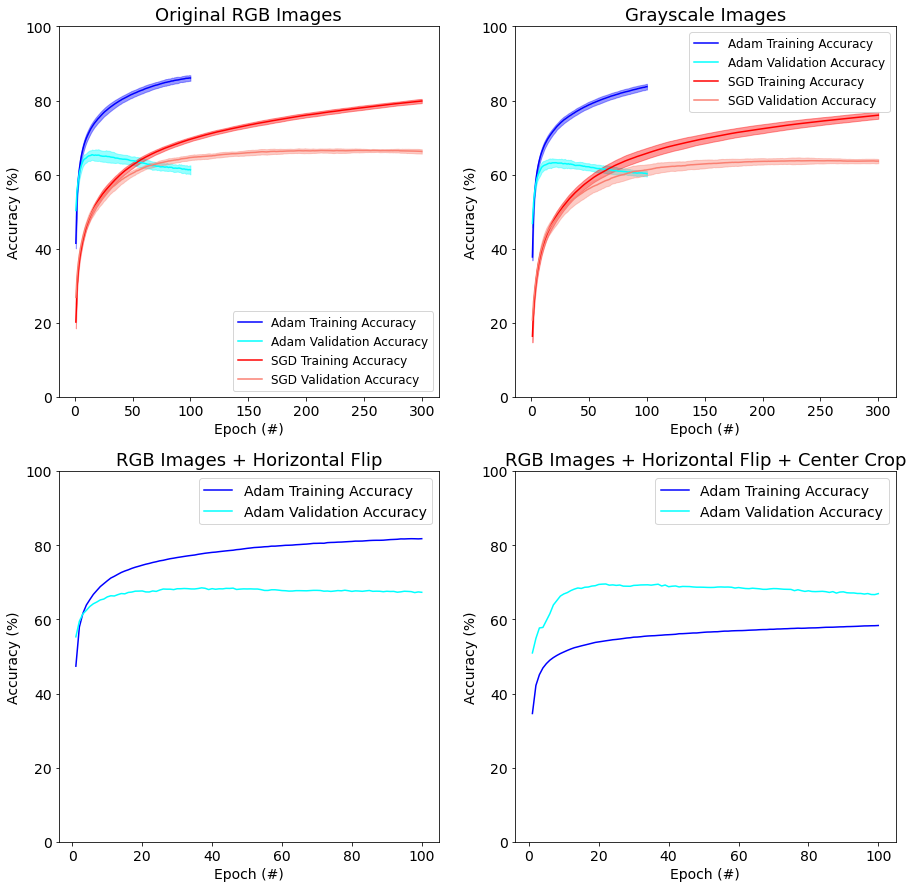

In [ ]:
epoch1=np.arange(1,101)
epoch2=np.arange(1,301)
fig1 = plt.figure(1, figsize=[15,15])

# RGB
#Adam
plt.subplot(2,2,1)

# adam
# training accuracy
mean_adam = np.mean(rgb_org_adam_training_accuracy, axis=0)
std_adam = np.std(rgb_org_adam_training_accuracy, axis=0)
plt.plot(epoch1, mean_adam, color = 'blue', linewidth=1.5)
plt.fill_between(epoch1, mean_adam - std_adam, mean_adam + std_adam,
                color='blue', alpha=0.4)

# validation accuracy
mean_adam = np.mean(rgb_org_adam_validation_accuracy, axis=0)
std_adam = np.std(rgb_org_adam_validation_accuracy, axis=0)
plt.plot(epoch1, mean_adam, color = 'cyan', linewidth=1.5)
plt.fill_between(epoch1, mean_adam - std_adam, mean_adam + std_adam,
                color='cyan', alpha=0.4)

# SGD
# training accuracy
mean_sgd = np.mean(rgb_org_sgd_training_accuracy, axis=0)
std_sgd = np.std(rgb_org_sgd_training_accuracy, axis=0)
plt.plot(epoch2, mean_sgd, color = 'red', linewidth=1.5)
plt.fill_between(epoch2, mean_sgd - std_sgd, mean_sgd + std_sgd,
                color='red', alpha=0.4)

# validation accuracy
mean_sgd = np.mean(rgb_org_sgd_validation_accuracy, axis=0)
std_sgd = np.std(rgb_org_sgd_validation_accuracy, axis=0)
plt.plot(epoch2, mean_sgd, color = 'salmon', linewidth=1.5)
plt.fill_between(epoch2, mean_sgd - std_sgd, mean_sgd + std_sgd,
                color='salmon', alpha=0.4)

plt.title('Original RGB Images', fontsize=18)
plt.legend(['Adam Training Accuracy', 'Adam Validation Accuracy', 'SGD Training Accuracy', 'SGD Validation Accuracy'], fontsize=12)
plt.xlabel('Epoch (#)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,100])

# Grayscale
#Adam
plt.subplot(2,2,2)

# adam
# training accuracy
mean_adam = np.mean(grayscale_adam_training_accuracy, axis=0)
std_adam = np.std(grayscale_adam_training_accuracy, axis=0)
plt.plot(epoch1, mean_adam, color = 'blue', linewidth=1.5)
plt.fill_between(epoch1, mean_adam - std_adam, mean_adam + std_adam,
                color='blue', alpha=0.4)

# validation accuracy
mean_adam = np.mean(grayscale_adam_validation_accuracy, axis=0)
std_adam = np.std(grayscale_adam_validation_accuracy, axis=0)
plt.plot(epoch1, mean_adam, color = 'cyan', linewidth=1.5)
plt.fill_between(epoch1, mean_adam - std_adam, mean_adam + std_adam,
                color='cyan', alpha=0.4)

# SGD
# training accuracy
mean_sgd = np.mean(grayscale_sgd_training_accuracy, axis=0)
std_sgd = np.std(grayscale_sgd_training_accuracy, axis=0)
plt.plot(epoch2, mean_sgd, color = 'red', linewidth=1.5)
plt.fill_between(epoch2, mean_sgd - std_sgd, mean_sgd + std_sgd,
                color='red', alpha=0.4)

# validation accuracy
mean_sgd = np.mean(grayscale_sgd_validation_accuracy, axis=0)
std_sgd = np.std(grayscale_sgd_validation_accuracy, axis=0)
plt.plot(epoch2, mean_sgd, color = 'salmon', linewidth=1.5)
plt.fill_between(epoch2, mean_sgd - std_sgd, mean_sgd + std_sgd,
                color='salmon', alpha=0.4)

plt.title('Grayscale Images', fontsize=18)
plt.legend(['Adam Training Accuracy', 'Adam Validation Accuracy', 'SGD Training Accuracy', 'SGD Validation Accuracy'], fontsize=12)
plt.xlabel('Epoch (#)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,100])

# RGB + Flip
#Adam
plt.subplot(2,2,3)

# adam
# training accuracy
plt.plot(epoch1, np.squeeze(rgb_flip_adam_training_accuracy), color = 'blue', linewidth=1.5)

# validation accuracy
plt.plot(epoch1, np.squeeze(rgb_flip_adam_validation_accuracy), color = 'cyan', linewidth=1.5)
plt.title('RGB Images + Horizontal Flip', fontsize=18)
plt.legend(['Adam Training Accuracy', 'Adam Validation Accuracy'], fontsize=14)
plt.xlabel('Epoch (#)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,100])

# RGB + Flip + Crop
#Adam
plt.subplot(2,2,4)

# adam
# training accuracy
plt.plot(epoch1, np.squeeze(rbg_flip_crop_training_accuracy), color = 'blue', linewidth=1.5)

# validation accuracy
plt.plot(epoch1, np.squeeze(rbg_flip_crop_validation_accuracy), color = 'cyan', linewidth=1.5)
plt.title('RGB Images + Horizontal Flip + Center Crop', fontsize=18)
plt.legend(['Adam Training Accuracy', 'Adam Validation Accuracy'], fontsize=14)
plt.xlabel('Epoch (#)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,100])

fig1.savefig('fig2_augmentation_comparasion.png', dpi =300)

### Fig. 2 Final RGB train (accuracy and loss 1x2 fig)

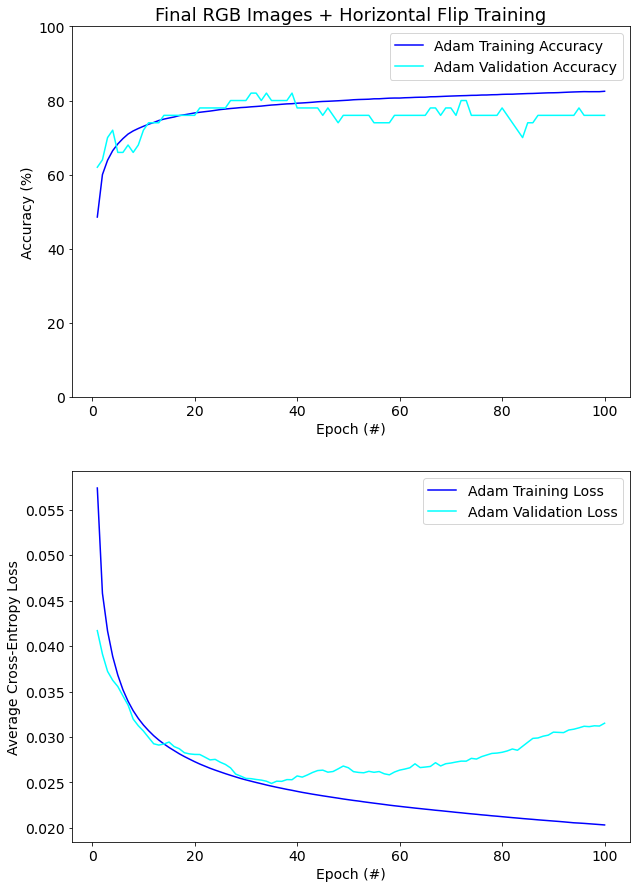

In [ ]:
epoch1=np.arange(1,101)
fig2 = plt.figure(1, figsize=[10,15])

# RGB
#Adam
plt.subplot(2,1,1)

# training accuracy
plt.plot(epoch1, np.squeeze(final_rgb_flip_training_accuracy), color = 'blue', linewidth=1.5)

# validation accuracy
plt.plot(epoch1, np.squeeze(final_rgb_flip_validation_accuracy), color = 'cyan', linewidth=1.5)
plt.title('Final RGB Images + Horizontal Flip Training', fontsize=18)
plt.legend(['Adam Training Accuracy', 'Adam Validation Accuracy'], fontsize=14)
plt.xlabel('Epoch (#)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,100])

plt.subplot(2,1,2)

# training accuracy
plt.plot(epoch1, np.squeeze(final_rgb_flip_training_loss), color = 'blue', linewidth=1.5)

# validation accuracy
plt.plot(epoch1, np.squeeze(final_rgb_flip_validation_loss), color = 'cyan', linewidth=1.5)
plt.legend(['Adam Training Loss', 'Adam Validation Loss'], fontsize=14)
plt.xlabel('Epoch (#)', fontsize=14)
plt.ylabel('Average Cross-Entropy Loss', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig2.savefig('fig3_final_network.png', dpi =300)

### Fig.3 CV across all training session


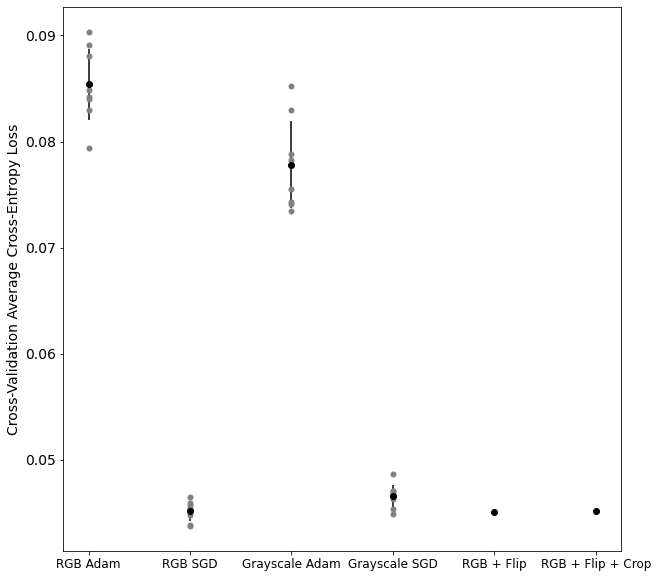

In [ ]:
fig3=plt.figure(1, figsize=[10, 10])
# original RGB
# adam
mean = np.mean(rgb_org_adam_validation_loss[:,-1])
std = np.std(rgb_org_adam_validation_loss[:,-1])
plt.plot(np.ones(rgb_org_adam_validation_loss.shape[0]), rgb_org_adam_validation_loss[:,-1], linestyle='none', marker='.', markersize=10, color='gray')
plt.errorbar(np.array(1), mean, yerr=std, color='black', markersize=12, marker='.')

# adam
mean = np.mean(rgb_org_sgd_validation_loss[:,-1])
std = np.std(rgb_org_sgd_validation_loss[:,-1])
plt.plot(2*np.ones(rgb_org_sgd_validation_loss.shape[0]), rgb_org_sgd_validation_loss[:,-1], linestyle='none', marker='.', markersize=10, color='gray')
plt.errorbar(np.array(2), mean, yerr=std, color='black', markersize=12, marker='.')

# grayscale
# adam
mean = np.mean(grayscale_adam_validation_loss[:,-1])
std = np.std(grayscale_adam_validation_loss[:,-1])
plt.plot(3*np.ones(grayscale_adam_validation_loss.shape[0]), grayscale_adam_validation_loss[:,-1], linestyle='none', marker='.', markersize=10, color='gray')
plt.errorbar(np.array(3), mean, yerr=std, color='black', markersize=12, marker='.')

# adam
mean = np.mean(grayscale_sgd_validation_loss[:,-1])
std = np.std(grayscale_sgd_validation_loss[:,-1])
plt.plot(4*np.ones(grayscale_sgd_validation_loss.shape[0]), grayscale_sgd_validation_loss[:,-1], linestyle='none', marker='.', markersize=10, color='gray')
plt.errorbar(np.array(4), mean, yerr=std, color='black', markersize=12, marker='.')

# RGB + Horizontal Flip
# adam
plt.plot(np.array(5), rgb_flip_adam_validation_loss[0,-1], color='black', markersize=12, marker='.')

# RGB + Horizontal Flip + Center Crop
# adam
plt.plot(np.array(6), rbg_flip_crop_validation_loss[0,-1], color='black', markersize=12, marker='.')

plt.ylabel('Cross-Validation Average Cross-Entropy Loss', fontsize=14)
plt.yticks(fontsize=14)
x=np.arange(1,7)
plt.xticks(x,['RGB Adam', 'RGB SGD', 'Grayscale Adam', 'Grayscale SGD', 'RGB + Flip', 'RGB + Flip + Crop'], fontsize=12)

fig3.savefig('fig4_cross_validation.png', dpi =300)

### Fig. 4. Confusion matrices of RGB and RBG flip


In [ ]:
rgb_confusion=np.zeros((10,10))
rgb_flip_confusion=np.zeros((10,10))

for j in range(10):
  true_label_loc=np.where(rgb_adam_true[0,:] == j)[0]
  for i in range(10):
    isolate_pred=rgb_adam_pred[0,true_label_loc]
    rgb_confusion[j,i] = len(np.where(isolate_pred ==i)[0])

pred_squeeze = np.squeeze(rgb_flip_adam_pred)
for j in range(10):
  curr_true_label = np.squeeze(rgb_flip_adam_true)
  true_label_loc=np.where(curr_true_label == j)[0]
  for i in range(10):

    isolate_pred=pred_squeeze[true_label_loc]
    rgb_flip_confusion[j,i] = len(np.where(isolate_pred ==i)[0])

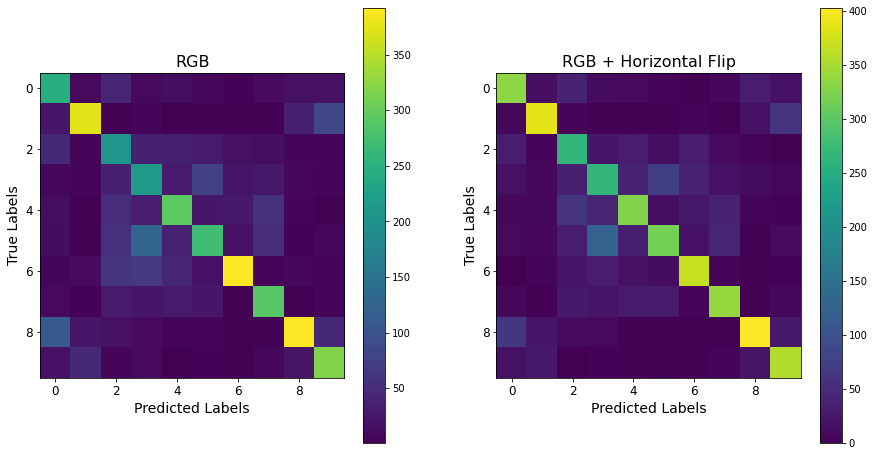

In [ ]:
fig4 = plt.figure(1, figsize=[15,8])
plt.subplot(1,2,1)
plt.imshow(rgb_confusion)
plt.colorbar()
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('RGB', fontsize=16)

plt.subplot(1,2,2)
plt.imshow(rgb_flip_confusion)
plt.colorbar()
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('RGB + Horizontal Flip', fontsize=16)

fig4.savefig('fig5_confusion_matrices.png', dpi=300)